Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns

Version = "v41" # Feature engineering based on Feature importance with v39 notebook

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

In [12]:
# For feature fngineering
importance_cols = pd.read_csv("../input/moa-annot-data/importance_cols_df.v39.csv")
importance_cols

acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                       df_g-122                              c-30   
1                  clusters_df_c                         c_all_max   
2                          cnt_0                    clusters_g_all   
3                      c_all_min                          df_g-707   
4                        df_g-51                        clusters_g   
5                       df_c_min                          df_c_min   
6                          cnt_2                             g-514   
7                       df_g-736                          df_g-640   
8                          g-244                            df_c-6   
9                           c-73                          df_g-597   

  acetylcholinesterase_inhibitor adenosine_receptor_antagonist  \
0                      c_all_max                clusters_c_all   
1                      c_all_min                      df_c_min   
2                 clusters_g_all                      df_g-148   
3                   clusters_d_g                 clusters_df_c   
4                        df_c-68                  df_g_max_min   
5                       df_c_min                       df_c-11   
6                       df_g-708                      df_g-469   
7                       df_g-467                clusters_g_all   
8                        d_g-705                      df_g-218   
9                       df_g-514                       df_c-64   

  adrenergic_receptor_agonist adrenergic_receptor_antagonist akt_inhibitor  \
0                       g-385                       df_g-547           g-8   
1                         g-8                       df_g-741       df_c-44   
2                       g-231                          g-231          g-29   
3                clusters_d_g                   clusters_d_g          g-58   
4                     d_g-705                       df_g-707       d_g-570   
5                     d_g-153                         df_c-6       df_c-48   
6                df_g_max_min                       df_g-622         g-699   
7                       g-705                        df_g-72         g-422   
8                     df_c-76                        df_g-15         g-458   
9                       g-337                 clusters_c_all         g-207   

  androgen_receptor_antagonist anesthetic_-_local antioxidant  ...  \
0                   clusters_g           df_g-104  clusters_g  ...   
1                     df_g-605               c-80   c_all_min  ...   
2                 clusters_d_g               g-24    df_c_min  ...   
3                        g-660      clusters_df_c        c-25  ...   
4                        g-513             df_c-1    df_g-206  ...   
5                        g-537             df_c-8       g-231  ...   
6                     df_g-482           df_g-537    df_g-707  ...   
7                     df_g-444           df_g-454       g-114  ...   
8                        g-295           df_g-155    df_g-658  ...   
9                      d_g-112           df_g-658       g-137  ...   

  raf_inhibitor retinoid_receptor_agonist serotonin_receptor_agonist  \
0          c-34                  df_g-387                  c_all_max   
1      df_g-769                     g-632               clusters_d_g   
2         g-635                     g-678                    d_g-324   
3         g-189                     g-635                    d_g-159   
4       df_c-65                     g-464             clusters_g_all   
5         g-207                     g-189                 clusters_g   
6          g-91                     g-128                   df_g-327   
7         g-522                     g-183                   df_g-638   
8         g-357                   d_g-684                   df_g-111   
9       d_g-674                   d_g-112                       g-58   

  serotonin_receptor_antagonist sodium_channel_inhibitor src_inhibitor  \
0      

# Training Utils

In [13]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [14]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [15]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    #target_rate *= (-0.001*target.sum()+1.1)
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, X_test, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [16]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:, 0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [17]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [18]:
def Feature_Engineering(target_col, X_train_df, X_test_df):
    
    selected_cols = importance_cols[target_col]
    
    _X_train_df = X_train_df[selected_cols].copy()
    _X_test_df = X_test_df[selected_cols].copy()
    
    _X_train_df['WHERE'] = 'train'
    _X_test_df['WHERE'] = 'test'
    _X_data = _X_train_df.append(_X_test_df)
    _X_data = _X_data.reset_index(drop=True)
  
    _cluster = create_cluster(_X_data, selected_cols, target_col, n_clusters)
    _cluster = _cluster[selected_cols]

    _stats = fe_stats(_X_data, selected_cols, target_col)
    _stats = _stats[selected_cols]
    
    _X_data = pd.concat([_X_data, _cluster], axis=1)
    _X_data = pd.concat([_X_data, _stats], axis=1)
    
    _X_train = _X_data[_X_data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
    _X_test = _X_data[_X_data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)
    
    return _X_train, _X_test
    

In [19]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    if target_col in importance_cols.columns:
        X, X_test = Feature_Engineering(target_col, X, X_test)
    
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, X_test, feature_importance_df

In [20]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [21]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [22]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [23]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [24]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [25]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [26]:
# clipping

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [27]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [29]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [30]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [31]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [32]:
std_df = data.iloc[:, 4:].copy()

In [33]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [34]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  2               0               0  
5                  1               4               5  
36                 2               0               0  
38                 4               4               2  
39                 0               6               1  
...              ...             ...             ...  
27754              4               0               2  
27759              0               2               1  
27768              4               0               2  
27784              1               3               3  
27794              2               3               0  

[27796 rows x 8 columns]

In [35]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  cnt_6  cnt_5  cnt_4  \
0                  2               0               0      1      1      1   
5                  1               4               5      1      1      1   
36                 2               0               0      1      1      1   
38                 4               4               2      1      0      2   
39                 0               6               1      1      2      0   
...              ...             ...             ...    ...    ...    ...   
27754              4               0               2      2      0      2   
27759              0               2               1      0      1      1   
27768              4               0               2      1      0      3   
27784              1               3               3      0      1      1   
27794              2               3               0      0      0      1   

       cnt_3  cnt_2  cnt_1  cnt_0  
0          0      2      4      3  
5          2      1      5      2  
36         0      2      3      4  
38         1      3      3      2  
39         0      2      4      3  
...      ...    ...    ...    ...  
27754      0      3      1      4  
27759      0      1      6      4  
27768      2      2      1      3  
27784      4      0      4      2  
27794      3      3      1      3  

[27796 rows x 15 columns]

In [36]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    MAX, MIN = df_[features].max(axis = 1), df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min'] = (MAX * MIN)**2
    
    df_[f'{kind}_kurt'] = Kurt**3
    df_[f'{kind}_skew'] = Skew**3
    df_[f'{kind}_max_kurt'] = MAX * Kurt
    df_[f'{kind}_max_skew'] = MAX * Skew
    df_[f'{kind}_kurt_skew'] = Kurt * Skew
    
    df_[f'{kind}_sum'] = (df_[features].sum(axis = 1))**3
    df_[f'{kind}_mean'] = (df_[features].mean(axis = 1))**3
    df_[f'{kind}_median'] = (df_[features].median(axis = 1))**3
    df_[f'{kind}_mad'] = (df_[features].mad(axis = 1))**3
    df_[f'{kind}_std'] = (df_[features].std(axis = 1))**3

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    
    return stats

In [37]:
stats = detect_stats(data, feature_list, kind_list)
stats

d_g_max_skew  d_g_kurt_skew       d_g_sum      d_g_mean  d_g_median  \
0          1.773997       1.122617 -1.278176e+03 -2.778042e-06   -0.000164   
5         -0.810013      -0.668520  4.686249e+04  1.018529e-04    0.000493   
36         0.774587       0.831640  2.368342e+02  5.147454e-07   -0.000019   
38         0.607893       0.323852  1.909071e+03  4.149255e-06    0.000007   
39        -0.867726      -0.279692  1.404200e+04  3.051948e-05    0.001977   
...             ...            ...           ...           ...         ...   
27754      1.124029       0.487651 -4.176693e+03 -9.077801e-06   -0.000059   
27759     -0.603212      -0.187947 -3.668553e+05 -7.973389e-04   -0.001380   
27768      2.355228       1.710186  1.291874e+02  2.807813e-07   -0.000040   
27784     -0.465225      -0.172956 -6.489317e+04 -1.410416e-04   -0.000112   
27794      0.452458       0.229407  2.381521e+06  5.176098e-03    0.027547   

        d_g_mad   d_g_std   d_c_max   d_c_min  d_c_max_min  ...   c_all_kurt  \
0      0.421547  0.921185  1.479033 -0.843085     1.554884  ...   702.924851   
5      0.450344  1.019499  1.859501 -0.862363     2.571423  ...   119.845739   
36     0.460320  1.141932  0.980110 -1.090500     1.142353  ...  1105.732838   
38     0.553510  1.126814  1.185165 -1.179324     1.953547  ...     0.012519   
39     2.540625  5.120534 -0.393566 -1.898526     0.558301  ...    -3.218037   
...         ...       ...       ...       ...          ...  ...          ...   
27754  0.459287  0.896787  1.800581 -1.739289     9.807738  ...    29.828422   
27759  1.934329  3.692947  0.980837 -2.611712     6.562119  ...    -2.327266   
27768  0.862901  1.992174  2.611712 -1.468736    14.714241  ...   270.636976   
27784  0.540292  1.000059  1.177806 -2.101746     6.127853  ...     3.647902   
27794  0.681515  1.388882  1.717725 -1.621529     7.758125  ...    -0.000630   

       c_all_skew  c_all_max_kurt  c_all_max_skew  c_all_kurt_skew  \
0       -6.600307       19.580500       -4.130876       -16.678526   
5        1.274329       25.634344        5.636921         5.345251   
36      -9.744666       16.710012       -3.451562       -22.087118   
38      -0.001557        0.421912       -0.210613        -0.026914   
39       0.276399       -2.778375        1.225855        -0.961706   
...           ...             ...             ...              ...   
27754   -0.219709        6.451519       -1.255263        -1.871369   
27759    0.186799       -2.454153        1.058631        -0.757543   
27768   -3.786773       16.893553       -4.070818       -10.082126   
27784    0.000002        2.470916        0.021522         0.020641   
27794   -0.002918       -0.147276       -0.245468         0.012252   

          c_all_sum    c_all_mean  c_all_median  c_all_mad  c_all_std  
0      1.200612e+04  4.446710e-04  6.841772e-03   0.288784   0.812540  
5      2.433312e+07  9.012267e-01  7.215851e-01   0.573522   2.324385  
36    -6.350024e+02 -2.351861e-05  8.186017e-05   0.246688   0.682099  
38    -3.831963e+04 -1.419245e-03 -9.070147e-04   0.130688   0.284034  
39    -1.693883e+06 -6.273639e-02 -1.606729e+00   2.088183   2.623831  
...             ...           ...           ...        ...        ...  
27754 -5.882616e+04 -2.178747e-03 -5.373233e-04   0.333428   0.633158  
27759 -2.156482e+06 -7.986971e-02 -1.098727e+00   1.533818   2.067397  
27768 -5.987463e+03 -2.217579e-04 -1.400804e-07   0.521840   1.280537  
27784 -9.736824e+05 -3.606231e-02 -2.744378e-01   0.443372   0.740543  
27794  6.709705e+00  2.485076e-07 -2.467269e-07   0.194441   0.389256  

[27796 rows x 72 columns]

In [38]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [39]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [40]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
1      id_000779bfc        1        2        0           0           2   
2      id_000a6266a        1        1        0           0           0   
3      id_0015fd391        1        1        0           4           4   
4      id_001626bd3        1        2        1           0           2   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0           3           4   
27792  id_ff925dd0d        1        0        0           0           6   
27793  id_ffb710450        1        2        0           6           2   
27794  id_ffbb869f2        1        1        1           3           2   
27795  id_ffd5800b6        1        2        0           6           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
1                 3             0              6              2  ...   
2                 3             6              6              4  ...   
3                 1             1              0              0  ...   
4                 3             0              3              2  ...   
...             ...           ...            ...            ...  ...   
27791             5             1              6              1  ...   
27792             3             0              6              2  ...   
27793             4             0              6              2  ...   
27794             2             4              3              2  ...   
27795             5             4              6              2  ...   

        df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96   df_c-97  \
0     -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858 -1.087786   
1      0.049251 -0.364980 -0.411534 -0.993055 -0.505091 -2.033104 -1.679158   
2      0.677642 -0.326261 -0.181815  1.284691  0.177076  0.673657  0.134245   
3      0.697360  1.661223  1.303584  1.045894  1.235752  1.330177  1.019721   
4     -1.383713  0.367819  0.458141 -0.214427 -0.170683 -1.534088 -0.953044   
...         ...       ...       ...       ...       ...       ...       ...   
27791  0.725136  0.251124 -0.237973  0.804368  0.541400  1.233284  1.193864   
27792 -0.573386  0.499728 -0.284930 -0.160010  0.692818 -1.153627  0.220772   
27793  0.336446 -0.411697 -1.622411 -0.091706 -0.568255 -1.100391 -0.169549   
27794  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664 -0.742805   
27795 -1.542277 -0.071571 -0.236615 -0.937521  0.202393  0.283034 -1.284479   

        df_c-98   df_c-99  WHERE  
0     -1.717424 -1.652775  train  
1     -0.856646 -0.482696  train  
2      1.168034 -0.911960  train  
3      0.531517  1.067496  train  
4      0.237818 -0.033880  train  
...         ...       ...    ...  
27791  0.415900  0.771102   test  
27792 -0.327231 -0.125243   test  
27793  0.531853  0.109870   test  
27794 -0.091712 -0.628309   test  
27795  0.111258 -1.282890   test  

[27796 rows x 2708 columns]

In [41]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1331 columns: ['cnt_6' 'cnt_5' 'cnt_4' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [43]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 337 columns


# Modeling

In [44]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [45]:
def select_importance_cols(feature_importance_df, num=10):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [46]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207654	valid_1's binary_logloss: 0.0285712
[200]	training's binary_logloss: 0.00227765	valid_1's binary_logloss: 0.0061275
[300]	training's binary_logloss: 0.00065705	valid_1's binary_logloss: 0.00274193
[400]	training's binary_logloss: 0.000358311	valid_1's binary_logloss: 0.00190596
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000297562	valid_1's binary_logloss: 0.00172484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209929	valid_1's binary_logloss: 0.0273365
[200]	training's binary_logloss: 0.00233577	valid_1's binary_logloss: 0.00480518
[300]	training's binary_logloss: 0.000661446	valid_1's binary_logloss: 0.00201389
[400]	training's binary_logloss: 0.000361218	valid_1's binary_logloss: 0.00128735
[500]	training's binary_logloss: 0.000302354	valid_1's binary_logloss: 0.001155
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0014473, Threshold: 0.0023325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071, Num_p_label: 80.0, conf_0:0.00210, conf_1:0.00257
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0023325
Num_p_label: 15.0, Expected: 2.8, Adj_threshold_2: 0.0123325
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_3: 0.0223325
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_4: 0.0323325
threshold: 0.0323325, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020411	valid_1's binary_logloss: 0.0271998
[200]	training's binary_logloss: 0.00214777	valid_1's binary_logloss: 0.00553101
[300]	training's binary_logloss: 0.000617806	valid_1's binary_logloss: 0.0025217
[400]	training's binary_logloss: 0.00034521	valid_1's binary_logloss: 0.00173066
[500]	training's binary_logloss: 0.000292146	valid_1's binary_logloss: 0.00159946
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000289451	valid_1's binary_logloss: 0.0015936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209811	valid_1's binary_logloss: 0.0259374
[200]	training's binary_logloss: 0.00226416	valid_1's binary_logloss: 0.00352066
[300]	training's binary_logloss: 0.000645072	valid_1's binary_logloss: 0.00118545
[400]	training's binary_logloss: 0.00035637	valid_1's binary_logloss: 0.000719346
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0679774, Threshold: 0.0323325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00071, Num_p_label: 14.0, conf_0:0.02910, conf_1:0.03557
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_1: 0.0323325
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_2: 0.0423325
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_3: 0.0523325
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_4: 0.0623325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_5: 0.0723325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.0823325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_7: 0.0923325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_8: 0.1023325
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_9: 0.1123325
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_10: 0.1223325
threshold: 0.1223325, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020411	valid_1's binary_logloss: 0.0271998
[200]	training's binary_logloss: 0.00214777	valid_1's binary_logloss: 0.00553101
[300]	training's binary_logloss: 0.000617806	valid_1's binary_logloss: 0.0025217
[400]	training's binary_logloss: 0.00034521	valid_1's binary_logloss: 0.00173066
[500]	training's binary_logloss: 0.000292146	valid_1's binary_logloss: 0.00159946
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000289451	valid_1's binary_logloss: 0.0015936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209811	valid_1's binary_logloss: 0.0259374
[200]	training's binary_logloss: 0.00226416	valid_1's binary_logloss: 0.00352066
[300]	training's binary_logloss: 0.000645072	valid_1's binary_logloss: 0.00118545
[400]	training's binary_logloss: 0.00035637	valid_1's binary_logloss: 0.000719346
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0679774, Threshold: 0.1223325, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00071, Num_p_label: 5.0, conf_0:0.11010, conf_1:0.13457
threshold: 0.1223325, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


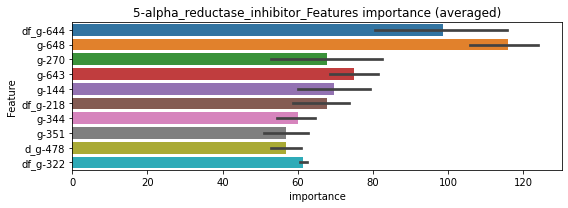

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110013	valid_1's binary_logloss: 0.0165212
[200]	training's binary_logloss: 0.00117163	valid_1's binary_logloss: 0.00485293
[300]	training's binary_logloss: 0.000327155	valid_1's binary_logloss: 0.00367784
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0003216	valid_1's binary_logloss: 0.00365927


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110897	valid_1's binary_logloss: 0.0158711
[200]	training's binary_logloss: 0.00120819	valid_1's binary_logloss: 0.00359285
[300]	training's binary_logloss: 0.000337181	valid_1's binary_logloss: 0.00207565
[400]	training's binary_logloss: 0.000182184	valid_1's binary_logloss: 0.00183778
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000154071	valid_1's binary_logloss: 0.00179215


5-alpha_reductase_inhibitor logloss: 0.0027258271813884473
11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257771	valid_1's binary_logloss: 0.0338181
[200]	training's binary_logloss: 0.00306292	valid_1's binary_logloss: 0.00621072
[300]	training's binary_logloss: 0.000852352	valid_1's binary_logloss: 0.00241023
[400]	training's binary_logloss: 0.00044864	valid_1's binary_logloss: 0.00149808
[500]	training's binary_logloss: 0.000346864	valid_1's binary_logloss: 0.0012398
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000337494	valid_1's binary_logloss: 0.00122321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256444	valid_1's binary_logloss: 0.0366757
[200]	training's binary_logloss: 0.00311317	valid_1's binary_logloss: 0.00668559
[300]	training's binary_logloss: 0.000865918	valid_1's binary_logloss: 0.00253883
[400]	training's binary_logloss: 0.000456494	valid_1's binary_logloss: 0.00157381
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0019622, Threshold: 0.0029647, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00267, conf_1:0.00326
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0029647
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0129647
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.0229647
threshold: 0.0229647, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248363	valid_1's binary_logloss: 0.0317733
[200]	training's binary_logloss: 0.00296972	valid_1's binary_logloss: 0.00591969
[300]	training's binary_logloss: 0.000840959	valid_1's binary_logloss: 0.00237661
[400]	training's binary_logloss: 0.000441709	valid_1's binary_logloss: 0.00149164
[500]	training's binary_logloss: 0.000352984	valid_1's binary_logloss: 0.00129438
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00034076	valid_1's binary_logloss: 0.00126504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245283	valid_1's binary_logloss: 0.0344702
[200]	training's binary_logloss: 0.00290303	valid_1's binary_logloss: 0.00650632
[300]	training's binary_logloss: 0.000822274	valid_1's binary_logloss: 0.0025587
[400]	training's binary_logloss: 0.000437174	valid_1's binary_logloss: 0.00162789
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1452638, Threshold: 0.0229647, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.02067, conf_1:0.02526
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.0229647
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0329647
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.0429647
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.0529647
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_5: 0.0629647
threshold: 0.0629647, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248363	valid_1's binary_logloss: 0.0317733
[200]	training's binary_logloss: 0.00296972	valid_1's binary_logloss: 0.00591969
[300]	training's binary_logloss: 0.000840959	valid_1's binary_logloss: 0.00237661
[400]	training's binary_logloss: 0.000441709	valid_1's binary_logloss: 0.00149164
[500]	training's binary_logloss: 0.000352984	valid_1's binary_logloss: 0.00129438
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00034076	valid_1's binary_logloss: 0.00126504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245283	valid_1's binary_logloss: 0.0344702
[200]	training's binary_logloss: 0.00290303	valid_1's binary_logloss: 0.00650632
[300]	training's binary_logloss: 0.000822274	valid_1's binary_logloss: 0.0025587
[400]	training's binary_logloss: 0.000437174	valid_1's binary_logloss: 0.00162789
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1452638, Threshold: 0.0629647, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.05667, conf_1:0.06926
threshold: 0.0629647, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


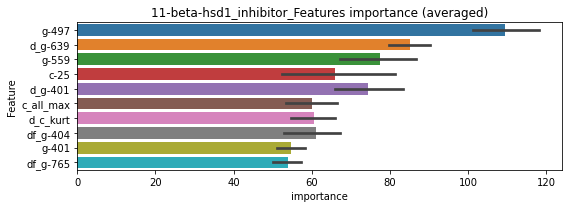

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013919	valid_1's binary_logloss: 0.0188336
[200]	training's binary_logloss: 0.00168778	valid_1's binary_logloss: 0.00479737
[300]	training's binary_logloss: 0.000452185	valid_1's binary_logloss: 0.00317242
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000266503	valid_1's binary_logloss: 0.0029713


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014123	valid_1's binary_logloss: 0.020872
[200]	training's binary_logloss: 0.00167379	valid_1's binary_logloss: 0.00515142
[300]	training's binary_logloss: 0.000447765	valid_1's binary_logloss: 0.00277393
[400]	training's binary_logloss: 0.000229634	valid_1's binary_logloss: 0.00235611
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000186456	valid_1's binary_logloss: 0.00225883


11-beta-hsd1_inhibitor logloss: 0.0026151104304479784
acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335916	valid_1's binary_logloss: 0.0485654
[200]	training's binary_logloss: 0.00466795	valid_1's binary_logloss: 0.010721
[300]	training's binary_logloss: 0.00125877	valid_1's binary_logloss: 0.00451147
[400]	training's binary_logloss: 0.000614068	valid_1's binary_logloss: 0.00286808
[500]	training's binary_logloss: 0.000437449	valid_1's binary_logloss: 0.00237724
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000432661	valid_1's binary_logloss: 0.00235834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325065	valid_1's binary_logloss: 0.0452667
[200]	training's binary_logloss: 0.00461483	valid_1's binary_logloss: 0.00845122
[300]	training's binary_logloss: 0.00125585	valid_1's binary_logloss: 0.00284624
[400]	training's binary_logloss: 0.000622225	valid_1's binary_logloss: 0.00164
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0025014, Threshold: 0.0034527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00311, conf_1:0.00380
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0034527
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0134527
threshold: 0.0134527, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330999	valid_1's binary_logloss: 0.0467498
[200]	training's binary_logloss: 0.00453181	valid_1's binary_logloss: 0.0101947
[300]	training's binary_logloss: 0.00123509	valid_1's binary_logloss: 0.00419997
[400]	training's binary_logloss: 0.000607529	valid_1's binary_logloss: 0.00258668
[500]	training's binary_logloss: 0.000433053	valid_1's binary_logloss: 0.00213359
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000418222	valid_1's binary_logloss: 0.00210012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332381	valid_1's binary_logloss: 0.0435265
[200]	training's binary_logloss: 0.00450585	valid_1's binary_logloss: 0.00756904
[300]	training's binary_logloss: 0.00124884	valid_1's binary_logloss: 0.00248552
[400]	training's binary_logloss: 0.000620631	valid_1's binary_logloss: 0.00137981
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0876558, Threshold: 0.0134527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.01211, conf_1:0.01480
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.0134527
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.0234527
threshold: 0.0234527, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330999	valid_1's binary_logloss: 0.0467498
[200]	training's binary_logloss: 0.00453181	valid_1's binary_logloss: 0.0101947
[300]	training's binary_logloss: 0.00123509	valid_1's binary_logloss: 0.00419997
[400]	training's binary_logloss: 0.000607529	valid_1's binary_logloss: 0.00258668
[500]	training's binary_logloss: 0.000433053	valid_1's binary_logloss: 0.00213359
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000418222	valid_1's binary_logloss: 0.00210012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332381	valid_1's binary_logloss: 0.0435265
[200]	training's binary_logloss: 0.00450585	valid_1's binary_logloss: 0.00756904
[300]	training's binary_logloss: 0.00124884	valid_1's binary_logloss: 0.00248552
[400]	training's binary_logloss: 0.000620631	valid_1's binary_logloss: 0.00137981
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0876558, Threshold: 0.0234527, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.02111, conf_1:0.02580
threshold: 0.0234527, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


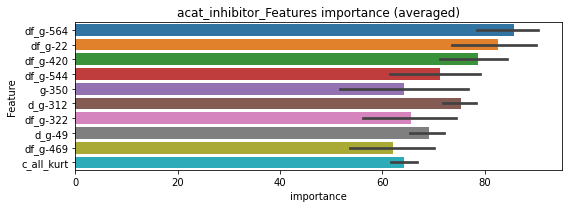

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186987	valid_1's binary_logloss: 0.0321872
[200]	training's binary_logloss: 0.00253486	valid_1's binary_logloss: 0.0123152
[300]	training's binary_logloss: 0.000649908	valid_1's binary_logloss: 0.00911928
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000371512	valid_1's binary_logloss: 0.00869543


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184201	valid_1's binary_logloss: 0.0265743
[200]	training's binary_logloss: 0.002522	valid_1's binary_logloss: 0.00613107
[300]	training's binary_logloss: 0.000671259	valid_1's binary_logloss: 0.00319714
[400]	training's binary_logloss: 0.000323484	valid_1's binary_logloss: 0.00263502
[500]	training's binary_logloss: 0.000226209	valid_1's binary_logloss: 0.00248364
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000223647	valid_1's binary_logloss: 0.00248347


acat_inhibitor logloss: 0.005589451995296462
acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152873	valid_1's binary_logloss: 0.253349
[200]	training's binary_logloss: 0.0942389	valid_1's binary_logloss: 0.232372
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0804465	valid_1's binary_logloss: 0.230993
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.902


[100]	training's binary_logloss: 0.168952	valid_1's binary_logloss: 0.241549
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.115371	valid_1's binary_logloss: 0.218171


y_Threshold: 0.1656134, Threshold: 0.2588593, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 439 → Positive_corect_labels: 497/3471
p_label_rate: 0.0200904 Vs.target_rate: 0.00798, Num_p_label: 80.0, conf_0:0.23297, conf_1:0.28475
threshold: 0.2588593, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 497.0/3471, y_label_rate: 0.1431864
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723701	valid_1's binary_logloss: 0.13409
[200]	training's binary_logloss: 0.0272096	valid_1's binary_logloss: 0.100123
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0171203	valid_1's binary_logloss: 0.0940485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785453	valid_1's binary_logloss: 0.128351
[200]	training's binary_logloss: 0.0310176	valid_1's binary_logloss: 0.094474


2 / 3 AUC score:0.987
y_Threshold: 0.1612212, Threshold: 0.2588593, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 450.0/3377
p_label_rate: 0.0236062 Vs.target_rate: 0.00798, Num_p_label: 94.0, conf_0:0.23297, conf_1:0.28475
threshold: 0.2588593, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 450.0/3377, y_label_rate: 0.1332544
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0148127	valid_1's binary_logloss: 0.0865485
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0143253	valid_1's binary_logloss: 0.0861213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583367	valid_1's binary_logloss: 0.0927947
[200]	training's binary_logloss: 0.0196741	valid_1's binary_logloss: 0.0586506
[300]	training's binary_logloss: 0.00840235	valid_1's binary_logloss: 0.0495938
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00840235	valid_1's binary_logloss: 0.0495938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061691	valid_1's binary_logloss: 0.109369
[200]	training's binary_logloss: 0.0214583	valid_1's binary_logloss: 0.0716978
[300]	training's binary_logloss: 0.00912682	valid_1's binary_logloss: 0.0603256
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00621377	valid_1's binary_

3 / 3 AUC score:0.998
y_Threshold: 0.0998156, Threshold: 0.2588593, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 431.0/3339
p_label_rate: 0.0170768 Vs.target_rate: 0.00798, Num_p_label: 68.0, conf_0:0.23297, conf_1:0.28475
threshold: 0.2588593, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 499.0/7321, y_label_rate: 0.0681601


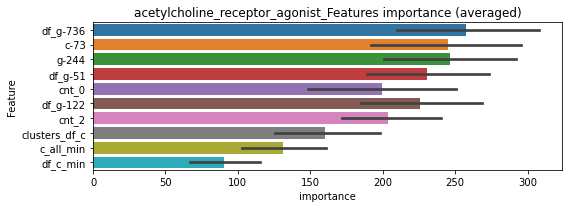

len(train_index) : 3660
len(valid_index) : 3661
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395064	valid_1's binary_logloss: 0.0692706
[200]	training's binary_logloss: 0.0146702	valid_1's binary_logloss: 0.0499017


len(train_index) : 3661
len(valid_index) : 3660
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[300]	training's binary_logloss: 0.00656975	valid_1's binary_logloss: 0.0428123
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00639438	valid_1's binary_logloss: 0.0426138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042808	valid_1's binary_logloss: 0.0775654
[200]	training's binary_logloss: 0.0151401	valid_1's binary_logloss: 0.0549818


acetylcholine_receptor_agonist logloss: 0.04582402162064833


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.007209	valid_1's binary_logloss: 0.0490351


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394


neg labels: 3289 → selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202113	valid_1's binary_logloss: 0.32241
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.172811	valid_1's binary_logloss: 0.317667
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.817
y_Threshold: 0.2001541, Threshold: 0.2906755, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 638 → Positive_corect_labels: 394/3251
p_label_rate: 0.0200904 Vs.target_rate: 0.01264, Num_p_label: 80.0, conf_0:0.26161, conf_1:0.31974
threshold: 0.2906755, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 394.0/3251, y_label_rate: 0.1211935
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.224305	valid_1's binary_logloss: 0.302981
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.201122	valid_1's binary_logloss: 0.300139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786018	valid_1's binary_logloss: 0.137598
[200]	training's binary_logloss: 0.0318645	valid_1's binary_logloss: 0.106034
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0234545	valid_1's binary_logloss: 0.0997597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802753	valid_1's binary_logloss: 0.129386
[200]	training's binary_logloss: 0.0325322	valid_1's binary_logloss: 0.095394


2 / 3 AUC score:0.986
y_Threshold: 0.1493115, Threshold: 0.2906755, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 347.0/3157
p_label_rate: 0.0253641 Vs.target_rate: 0.01264, Num_p_label: 101.0, conf_0:0.26161, conf_1:0.31974
threshold: 0.2906755, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 347.0/3157, y_label_rate: 0.1099145
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0151248	valid_1's binary_logloss: 0.0869605
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0157315	valid_1's binary_logloss: 0.0866159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532819	valid_1's binary_logloss: 0.0900795
[200]	training's binary_logloss: 0.0179975	valid_1's binary_logloss: 0.0626389
[300]	training's binary_logloss: 0.00776469	valid_1's binary_logloss: 0.0544188
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00641362	valid_1's binary_logloss: 0.0532272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551739	valid_1's binary_logloss: 0.095328
[200]	training's binary_logloss: 0.0180255	valid_1's binary_logloss: 0.061876
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0112797	valid_1's binary_logloss: 0.0552144


3 / 3 AUC score:0.995
y_Threshold: 0.1607968, Threshold: 0.2906755, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 327.0/3117
p_label_rate: 0.0246107 Vs.target_rate: 0.01264, Num_p_label: 98.0, conf_0:0.26161, conf_1:0.31974
threshold: 0.2906755, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 425.0/7099, y_label_rate: 0.0598676


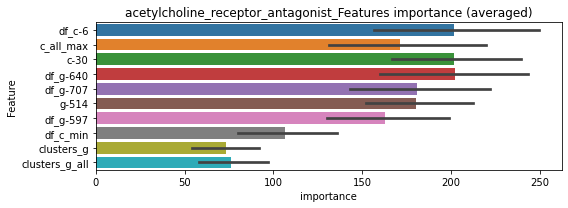

len(train_index) : 3549
len(valid_index) : 3550
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373914	valid_1's binary_logloss: 0.06231
[200]	training's binary_logloss: 0.0133744	valid_1's binary_logloss: 0.0417009
[300]	training's binary_logloss: 0.00584935	valid_1's binary_logloss: 0.0366107


len(train_index) : 3550
len(valid_index) : 3549
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00529817	valid_1's binary_logloss: 0.0364438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399627	valid_1's binary_logloss: 0.0624282
[200]	training's binary_logloss: 0.0142074	valid_1's binary_logloss: 0.0399536
[300]	training's binary_logloss: 0.00634478	valid_1's binary_logloss: 0.0336911
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00423702	valid_1's binary_logloss: 0.032054


acetylcholine_receptor_antagonist logloss: 0.034249250184526646
acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960152	valid_1's binary_logloss: 0.163115
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0466011	valid_1's binary_logloss: 0.141163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10572	valid_1's binary_logloss: 0.1501
[200]	training's binary_logloss: 0.0514444	valid_1's binary_logloss: 0.11957


1 / 3 AUC score:0.970
y_Threshold: 0.1186392, Threshold: 0.2093620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 260 → Positive_corect_labels: 591/3671
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.18843, conf_1:0.23030
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.2093620
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_2: 0.2193620
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_3: 0.2293620


[300]	training's binary_logloss: 0.0265906	valid_1's binary_logloss: 0.11125
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0240619	valid_1's binary_logloss: 0.110329


Num_p_label: 66.0, Expected: 12.2, Adj_threshold_4: 0.2393620
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_5: 0.2493620
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_6: 0.2593620
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_7: 0.2693620
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_8: 0.2793620
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_9: 0.2893620
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_10: 0.2993620
threshold: 0.3093620, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 591.0/3671, y_label_rate: 0.1609916
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701621	valid_1's binary_logloss: 0.0932038
[200]	training's binary_logloss: 0.0235531	valid_1's binary_logloss: 0.0521414
[300]	training's binary_logloss: 0.00961345	valid_1's binary_logloss: 0.0388598
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00589063	valid_1's binary_logloss: 0.0348475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633608	valid_1's binary_logloss: 0.101874
[200]	training's binary_logloss: 0.0195657	valid_1's binary_logloss: 0.0587756
[300]	training's binary_logloss: 0.00820254	valid_1's binary_logloss: 0.0468441
[400]	training's binary_logloss: 0.00433303	valid_1's binary_logloss: 0.0417422
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00363032	valid_1's binary_logloss: 0.0406382


2 / 3 AUC score:0.998
y_Threshold: 0.2194906, Threshold: 0.3093620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 568.0/3625
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.27843, conf_1:0.34030
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.3093620
Num_p_label: 77.0, Expected: 12.2, Adj_threshold_2: 0.3193620
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_3: 0.3293620
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_4: 0.3393620
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_5: 0.3493620
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_6: 0.3593620
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_7: 0.3693620
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_8: 0.3793620
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_9: 0.3893620
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_10: 0.3993620
threshold: 0.4093620, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 568.0/3625, y_label_rate: 0.15668

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528792	valid_1's binary_logloss: 0.0903922
[200]	training's binary_logloss: 0.0154667	valid_1's binary_logloss: 0.0551057
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00711624	valid_1's binary_logloss: 0.0470499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647363	valid_1's binary_logloss: 0.0835247
[200]	training's binary_logloss: 0.018852	valid_1's binary_logloss: 0.0378872
[300]	training's binary_logloss: 0.00737427	valid_1's binary_logloss: 0.0248212
[400]	training's binary_logloss: 0.00387327	valid_1's binary_logloss: 0.0185406
[500]	training's binary_logloss: 0.0025667	valid_1's binary_logloss: 0.0163396
[600]	training's binary_logloss: 0.00194211	valid_1's binary_logloss: 0.014822
[700]	training's binary_logloss: 0.0016399	valid_1's binary_logloss: 0.014117
[800]	training's binary_logloss: 0.00143161	valid_1'

3 / 3 AUC score:0.999
y_Threshold: 0.1330455, Threshold: 0.4093620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 552.0/3593
p_label_rate: 0.0153189 Vs.target_rate: 0.00307, Num_p_label: 61.0, conf_0:0.36843, conf_1:0.45030
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_1: 0.4093620
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_2: 0.4193620
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_3: 0.4293620
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_4: 0.4393620
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_5: 0.4493620
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_6: 0.4593620
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_7: 0.4693620
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_8: 0.4793620
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_9: 0.4893620
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_10: 0.4993620
threshold: 0.5093620, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 600.0/7575, y_label_rate: 0.07920

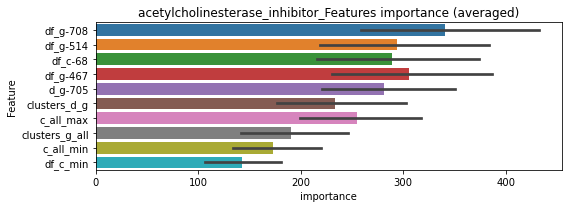

len(train_index) : 3787
len(valid_index) : 3788
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327684	valid_1's binary_logloss: 0.0496457
[200]	training's binary_logloss: 0.0100577	valid_1's binary_logloss: 0.0269355
[300]	training's binary_logloss: 0.00420914	valid_1's binary_logloss: 0.0204563
[400]	training's binary_logloss: 0.00222117	valid_1's binary_logloss: 0.0178966
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00195885	valid_1's binary_logloss: 0.0174287


len(train_index) : 3788
len(valid_index) : 3787
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375572	valid_1's binary_logloss: 0.051981
[200]	training's binary_logloss: 0.0123965	valid_1's binary_logloss: 0.0290058
[300]	training's binary_logloss: 0.00520429	valid_1's binary_logloss: 0.0219858
[400]	training's binary_logloss: 0.00261874	valid_1's binary_logloss: 0.0188142
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00221133	valid_1's binary_logloss: 0.0182125


acetylcholinesterase_inhibitor logloss: 0.017820561388766684
adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454392	valid_1's binary_logloss: 0.0905917
[200]	training's binary_logloss: 0.00849006	valid_1's binary_logloss: 0.042479
[300]	training's binary_logloss: 0.0024632	valid_1's binary_logloss: 0.0300157
[400]	training's binary_logloss: 0.00115183	valid_1's binary_logloss: 0.0265171
[500]	training's binary_logloss: 0.000724284	valid_1's binary_logloss: 0.0244195
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000752165	valid_1's binary_logloss: 0.0243893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461375	valid_1's binary_logloss: 0.0824931
[200]	training's binary_logloss: 0.00856836	valid_1's binary_logloss: 0.0331786
[300]	training's binary_logloss: 0.00247346	valid_1's binary_logloss: 0.0225896
[400]	training's binary_logloss: 0.00119492	valid_1's binary_logloss: 0.0193695
Early stopping, best iteration is:
[432]	trai

1 / 3 AUC score:1.000
y_Threshold: 0.0066145, Threshold: 0.0101798, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.00916, conf_1:0.01120
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0101798
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.0201798
Num_p_label: 6.0, Expected: 9.0, Adj_threshold_3: 0.0301798
threshold: 0.0301798, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449675	valid_1's binary_logloss: 0.0881726
[200]	training's binary_logloss: 0.00831703	valid_1's binary_logloss: 0.0408322
[300]	training's binary_logloss: 0.0024163	valid_1's binary_logloss: 0.0290004
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00132244	valid_1's binary_logloss: 0.0253271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468268	valid_1's binary_logloss: 0.0826498
[200]	training's binary_logloss: 0.00852348	valid_1's binary_logloss: 0.0332025
[300]	training's binary_logloss: 0.00250934	valid_1's binary_logloss: 0.0225679
[400]	training's binary_logloss: 0.0011921	valid_1's binary_logloss: 0.0194758
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000957759	valid_1's binary_logloss: 0.0190568


2 / 3 AUC score:1.000
y_Threshold: 0.0330104, Threshold: 0.0301798, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0087896 Vs.target_rate: 0.00227, Num_p_label: 35.0, conf_0:0.02716, conf_1:0.03320
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_1: 0.0301798
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.0401798
Num_p_label: 13.0, Expected: 9.0, Adj_threshold_3: 0.0501798
threshold: 0.0501798, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450397	valid_1's binary_logloss: 0.0876346
[200]	training's binary_logloss: 0.00839359	valid_1's binary_logloss: 0.0403146
[300]	training's binary_logloss: 0.00243526	valid_1's binary_logloss: 0.0267719
[400]	training's binary_logloss: 0.00115794	valid_1's binary_logloss: 0.0217899
[500]	training's binary_logloss: 0.000732258	valid_1's binary_logloss: 0.0200968
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000740822	valid_1's binary_logloss: 0.0200803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470677	valid_1's binary_logloss: 0.0834943
[200]	training's binary_logloss: 0.0085862	valid_1's binary_logloss: 0.0313716
[300]	training's binary_logloss: 0.00251316	valid_1's binary_logloss: 0.0185437
[400]	training's binary_logloss: 0.00118598	valid_1's binary_logloss: 0.0143101
[500]	training's binary_logloss: 0.000743878

3 / 3 AUC score:1.000
y_Threshold: 0.0605724, Threshold: 0.0501798, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0030136 Vs.target_rate: 0.00227, Num_p_label: 12.0, conf_0:0.04516, conf_1:0.05520
threshold: 0.0501798, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 662.0/7775, y_label_rate: 0.0851447


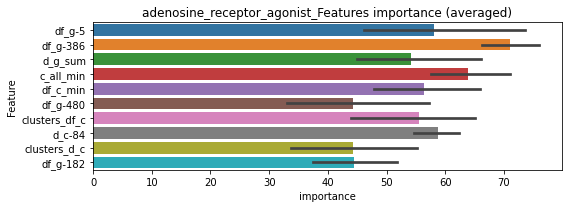

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254054	valid_1's binary_logloss: 0.0559486
[200]	training's binary_logloss: 0.00466604	valid_1's binary_logloss: 0.028903
[300]	training's binary_logloss: 0.00132965	valid_1's binary_logloss: 0.0225963
[400]	training's binary_logloss: 0.000614827	valid_1's binary_logloss: 0.0210387
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000535892	valid_1's binary_logloss: 0.0207178


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257024	valid_1's binary_logloss: 0.052253
[200]	training's binary_logloss: 0.00490043	valid_1's binary_logloss: 0.024425
[300]	training's binary_logloss: 0.00141827	valid_1's binary_logloss: 0.0170678
[400]	training's binary_logloss: 0.000654569	valid_1's binary_logloss: 0.0147545
[500]	training's binary_logloss: 0.000408221	valid_1's binary_logloss: 0.01403
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000352139	valid_1's binary_logloss: 0.0138652


adenosine_receptor_agonist logloss: 0.017291957291753632
adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1087	valid_1's binary_logloss: 0.16427
[200]	training's binary_logloss: 0.0543571	valid_1's binary_logloss: 0.135574
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0430279	valid_1's binary_logloss: 0.133015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109871	valid_1's binary_logloss: 0.166243
[200]	training's binary_logloss: 0.0552298	valid_1's binary_logloss: 0.137373
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0472268	valid_1's binary_logloss: 0.134269


1 / 3 AUC score:0.964
y_Threshold: 0.1187821, Threshold: 0.2160712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 290 → Positive_corect_labels: 575/3637
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.19446, conf_1:0.23768
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.2160712
Num_p_label: 71.0, Expected: 16.1, Adj_threshold_2: 0.2260712
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_3: 0.2360712
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_4: 0.2460712
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_5: 0.2560712
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_6: 0.2660712
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_7: 0.2760712
Num_p_label: 38.0, Expected: 16.1, Adj_threshold_8: 0.2860712
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_9: 0.2960712
Num_p_label: 32.0, Expected: 16.1, Adj_threshold_10: 0.3060712
threshold: 0.3060712, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 575.0/3637, y_label_rate: 0.158097

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646233	valid_1's binary_logloss: 0.108663
[200]	training's binary_logloss: 0.020015	valid_1's binary_logloss: 0.0688891
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0103128	valid_1's binary_logloss: 0.0614676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070905	valid_1's binary_logloss: 0.087952
[200]	training's binary_logloss: 0.0246617	valid_1's binary_logloss: 0.0471063
[300]	training's binary_logloss: 0.0108723	valid_1's binary_logloss: 0.0339941


2 / 3 AUC score:0.998
y_Threshold: 0.1534114, Threshold: 0.3060712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 553.0/3593
p_label_rate: 0.0175791 Vs.target_rate: 0.00403, Num_p_label: 70.0, conf_0:0.27546, conf_1:0.33668
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_1: 0.3060712
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_2: 0.3160712
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_3: 0.3260712
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_4: 0.3360712
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_5: 0.3460712
Num_p_label: 58.0, Expected: 16.1, Adj_threshold_6: 0.3560712


[400]	training's binary_logloss: 0.00570752	valid_1's binary_logloss: 0.0298151
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00590387	valid_1's binary_logloss: 0.0297606


Num_p_label: 56.0, Expected: 16.1, Adj_threshold_7: 0.3660712
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_8: 0.3760712
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_9: 0.3860712
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_10: 0.3960712
threshold: 0.4060712, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 553.0/3593, y_label_rate: 0.1539104
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584211	valid_1's binary_logloss: 0.0789785
[200]	training's binary_logloss: 0.0172979	valid_1's binary_logloss: 0.0420834
[300]	training's binary_logloss: 0.00689408	valid_1's binary_logloss: 0.0322869
[400]	training's binary_logloss: 0.00351666	valid_1's binary_logloss: 0.0281951
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00311592	valid_1's binary_logloss: 0.0275059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557221	valid_1's binary_logloss: 0.0854335
[200]	training's binary_logloss: 0.0162438	valid_1's binary_logloss: 0.0463106


3 / 3 AUC score:0.999
y_Threshold: 0.1489107, Threshold: 0.4060712, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 541.0/3569
p_label_rate: 0.0135610 Vs.target_rate: 0.00403, Num_p_label: 54.0, conf_0:0.36546, conf_1:0.44668
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_1: 0.4060712
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_2: 0.4160712
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_3: 0.4260712
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_4: 0.4360712
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_5: 0.4460712
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_6: 0.4560712
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_7: 0.4660712
Num_p_label: 44.0, Expected: 16.1, Adj_threshold_8: 0.4760712


[300]	training's binary_logloss: 0.00646772	valid_1's binary_logloss: 0.034024
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00580746	valid_1's binary_logloss: 0.0331942


Num_p_label: 43.0, Expected: 16.1, Adj_threshold_9: 0.4860712
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_10: 0.4960712
threshold: 0.5060712, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 582.0/7551, y_label_rate: 0.0770759


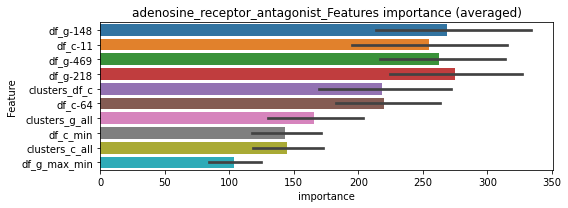

len(train_index) : 3775
len(valid_index) : 3776
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387017	valid_1's binary_logloss: 0.0543034
[200]	training's binary_logloss: 0.0135987	valid_1's binary_logloss: 0.0313792
[300]	training's binary_logloss: 0.00551941	valid_1's binary_logloss: 0.0249412
[400]	training's binary_logloss: 0.00282412	valid_1's binary_logloss: 0.0226513
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00278666	valid_1's binary_logloss: 0.0226288


len(train_index) : 3776
len(valid_index) : 3775
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340027	valid_1's binary_logloss: 0.0567917
[200]	training's binary_logloss: 0.0104797	valid_1's binary_logloss: 0.0331913
[300]	training's binary_logloss: 0.00446216	valid_1's binary_logloss: 0.0272599
[400]	training's binary_logloss: 0.00222457	valid_1's binary_logloss: 0.025134
[500]	training's binary_logloss: 0.00143007	valid_1's binary_logloss: 0.023489
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00125835	valid_1's binary_logloss: 0.0229768


adenosine_receptor_antagonist logloss: 0.022802807621023925
adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214299	valid_1's binary_logloss: 0.0273252
[200]	training's binary_logloss: 0.0024225	valid_1's binary_logloss: 0.00491177
[300]	training's binary_logloss: 0.000665716	valid_1's binary_logloss: 0.00199271
[400]	training's binary_logloss: 0.00035041	valid_1's binary_logloss: 0.00129537
[500]	training's binary_logloss: 0.000282799	valid_1's binary_logloss: 0.00118042
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00028138	valid_1's binary_logloss: 0.00117754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215193	valid_1's binary_logloss: 0.0258536
[200]	training's binary_logloss: 0.00237424	valid_1's binary_logloss: 0.00351724
[300]	training's binary_logloss: 0.000662445	valid_1's binary_logloss: 0.00116909
[400]	training's binary_logloss: 0.000360601	valid_1's binary_logloss: 0.000693364
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0013836, Threshold: 0.0026760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00241, conf_1:0.00294
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0026760
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0126760
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0226760
threshold: 0.0226760, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213867	valid_1's binary_logloss: 0.0263539
[200]	training's binary_logloss: 0.00229503	valid_1's binary_logloss: 0.00419162
[300]	training's binary_logloss: 0.000631705	valid_1's binary_logloss: 0.00157115
[400]	training's binary_logloss: 0.000344287	valid_1's binary_logloss: 0.000990639
[500]	training's binary_logloss: 0.000282834	valid_1's binary_logloss: 0.000866269
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000277121	valid_1's binary_logloss: 0.000855201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217019	valid_1's binary_logloss: 0.0253127
[200]	training's binary_logloss: 0.00223488	valid_1's binary_logloss: 0.00303751
[300]	training's binary_logloss: 0.000614283	valid_1's binary_logloss: 0.00091952
[400]	training's binary_logloss: 0.000339327	valid_1's binary_logloss: 0.000528822
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1236035, Threshold: 0.0226760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.02041, conf_1:0.02494
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.0226760
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0326760
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0426760
threshold: 0.0426760, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213867	valid_1's binary_logloss: 0.0263539
[200]	training's binary_logloss: 0.00229503	valid_1's binary_logloss: 0.00419162
[300]	training's binary_logloss: 0.000631705	valid_1's binary_logloss: 0.00157115
[400]	training's binary_logloss: 0.000344287	valid_1's binary_logloss: 0.000990639
[500]	training's binary_logloss: 0.000282834	valid_1's binary_logloss: 0.000866269
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000277121	valid_1's binary_logloss: 0.000855201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217019	valid_1's binary_logloss: 0.0253127
[200]	training's binary_logloss: 0.00223488	valid_1's binary_logloss: 0.00303751
[300]	training's binary_logloss: 0.000614283	valid_1's binary_logloss: 0.00091952
[400]	training's binary_logloss: 0.000339327	valid_1's binary_logloss: 0.000528822
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1236035, Threshold: 0.0426760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.03841, conf_1:0.04694
threshold: 0.0426760, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


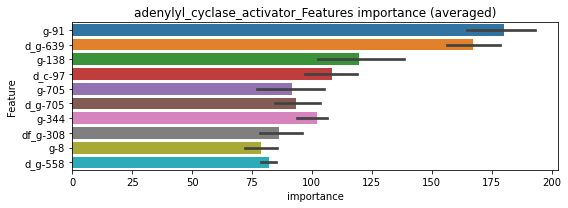

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109198	valid_1's binary_logloss: 0.0176782
[200]	training's binary_logloss: 0.00113583	valid_1's binary_logloss: 0.00647706
[300]	training's binary_logloss: 0.000308661	valid_1's binary_logloss: 0.00529377
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000187388	valid_1's binary_logloss: 0.00504353


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115404	valid_1's binary_logloss: 0.0137818
[200]	training's binary_logloss: 0.0012262	valid_1's binary_logloss: 0.00248683
[300]	training's binary_logloss: 0.000341525	valid_1's binary_logloss: 0.00138962
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000194985	valid_1's binary_logloss: 0.00120984


adenylyl_cyclase_activator logloss: 0.003126930791002646
adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16821	valid_1's binary_logloss: 0.299627
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.149304	valid_1's binary_logloss: 0.29539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194615	valid_1's binary_logloss: 0.284703
[200]	training's binary_logloss: 0.131876	valid_1's binary_logloss: 0.262996


1 / 3 AUC score:0.866
y_Threshold: 0.1903328, Threshold: 0.3371414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 563 → Positive_corect_labels: 432/3329
p_label_rate: 0.0200904 Vs.target_rate: 0.01134, Num_p_label: 80.0, conf_0:0.30343, conf_1:0.37086
threshold: 0.3371414, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 432.0/3329, y_label_rate: 0.1297687
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.110785	valid_1's binary_logloss: 0.26075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741701	valid_1's binary_logloss: 0.137638
[200]	training's binary_logloss: 0.0279438	valid_1's binary_logloss: 0.107045
[300]	training's binary_logloss: 0.0127913	valid_1's binary_logloss: 0.100422
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0102058	valid_1's binary_logloss: 0.0992958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727699	valid_1's binary_logloss: 0.138741
[200]	training's binary_logloss: 0.0270846	valid_1's binary_logloss: 0.105586


2 / 3 AUC score:0.987
y_Threshold: 0.1537579, Threshold: 0.3371414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 106 → Positive_corect_labels: 379.0/3223
p_label_rate: 0.0411853 Vs.target_rate: 0.01134, Num_p_label: 164.0, conf_0:0.30343, conf_1:0.37086
Num_p_label: 164.0, Expected: 45.1, Adj_threshold_1: 0.3371414
Num_p_label: 159.0, Expected: 45.1, Adj_threshold_2: 0.3471414
Num_p_label: 154.0, Expected: 45.1, Adj_threshold_3: 0.3571414
Num_p_label: 144.0, Expected: 45.1, Adj_threshold_4: 0.3671414
Num_p_label: 142.0, Expected: 45.1, Adj_threshold_5: 0.3771414
Num_p_label: 141.0, Expected: 45.1, Adj_threshold_6: 0.3871414
Num_p_label: 137.0, Expected: 45.1, Adj_threshold_7: 0.3971414
Num_p_label: 133.0, Expected: 45.1, Adj_threshold_8: 0.4071414
Num_p_label: 128.0, Expected: 45.1, Adj_threshold_9: 0.4171414
Num_p_label: 125.0, Expected: 45.1, Adj_threshold_10: 0.4271414
threshold: 0.4371414, positive_p_label: 119.0/3982, p_label_rate: 0.0298845


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0174408	valid_1's binary_logloss: 0.100903


positive_y_label: 379.0/3223, y_label_rate: 0.1175923
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523645	valid_1's binary_logloss: 0.0852505
[200]	training's binary_logloss: 0.0164931	valid_1's binary_logloss: 0.053171
[300]	training's binary_logloss: 0.00693264	valid_1's binary_logloss: 0.045024
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00481105	valid_1's binary_logloss: 0.0436227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055049	valid_1's binary_logloss: 0.1029
[200]	training's binary_logloss: 0.0164601	valid_1's binary_logloss: 0.0599139


3 / 3 AUC score:0.998
y_Threshold: 0.1851669, Threshold: 0.4371414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 362.0/3189
p_label_rate: 0.0291311 Vs.target_rate: 0.01134, Num_p_label: 116.0, conf_0:0.39343, conf_1:0.48086
threshold: 0.4371414, positive_p_label: 116.0/3982, p_label_rate: 0.0291311


[300]	training's binary_logloss: 0.00685446	valid_1's binary_logloss: 0.0473727
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00554278	valid_1's binary_logloss: 0.044802


positive_y_label: 478.0/7171, y_label_rate: 0.0666574


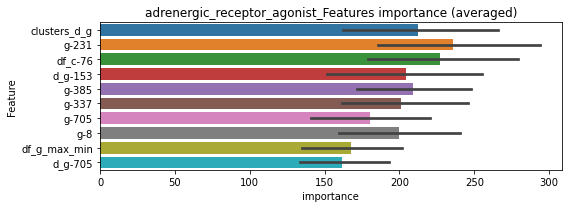

len(train_index) : 3585
len(valid_index) : 3586
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351926	valid_1's binary_logloss: 0.0674663
[200]	training's binary_logloss: 0.0120688	valid_1's binary_logloss: 0.0456909
[300]	training's binary_logloss: 0.00526095	valid_1's binary_logloss: 0.03911


len(train_index) : 3586
len(valid_index) : 3585
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0043289	valid_1's binary_logloss: 0.0387558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396491	valid_1's binary_logloss: 0.0701729
[200]	training's binary_logloss: 0.0132631	valid_1's binary_logloss: 0.044154
[300]	training's binary_logloss: 0.00586381	valid_1's binary_logloss: 0.0368743
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00456564	valid_1's binary_logloss: 0.0347508


adrenergic_receptor_agonist logloss: 0.036753575015816865
adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227335	valid_1's binary_logloss: 0.361487
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.188106	valid_1's binary_logloss: 0.355228
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.779
y_Threshold: 0.2135557, Threshold: 0.2974557, pos_neg_ratio: 0.8000000


[100]	training's binary_logloss: 0.241889	valid_1's binary_logloss: 0.341638
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.190582	valid_1's binary_logloss: 0.335633


Remove_noisy_labels: 718 → Positive_corect_labels: 351/3156
p_label_rate: 0.0200904 Vs.target_rate: 0.01512, Num_p_label: 80.0, conf_0:0.26771, conf_1:0.32720
threshold: 0.2974557, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 351.0/3156, y_label_rate: 0.1112167
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889372	valid_1's binary_logloss: 0.177061
[200]	training's binary_logloss: 0.0380602	valid_1's binary_logloss: 0.152255
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0352243	valid_1's binary_logloss: 0.150343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963814	valid_1's binary_logloss: 0.155315
[200]	training's binary_logloss: 0.0438956	valid_1's binary_logloss: 0.128756
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0318214	valid_1's binary_logloss: 0.124975


2 / 3 AUC score:0.963
y_Threshold: 0.1875797, Threshold: 0.2974557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 272.0/2998
p_label_rate: 0.0303867 Vs.target_rate: 0.01512, Num_p_label: 121.0, conf_0:0.26771, conf_1:0.32720
threshold: 0.2974557, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 272.0/2998, y_label_rate: 0.0907272
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554724	valid_1's binary_logloss: 0.098901
[200]	training's binary_logloss: 0.0195896	valid_1's binary_logloss: 0.0757137
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0128599	valid_1's binary_logloss: 0.0710908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052611	valid_1's binary_logloss: 0.112605
[200]	training's binary_logloss: 0.0190662	valid_1's binary_logloss: 0.084733
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0142153	valid_1's binary_logloss: 0.0809043


3 / 3 AUC score:0.991
y_Threshold: 0.1399213, Threshold: 0.2974557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 235.0/2924
p_label_rate: 0.0293822 Vs.target_rate: 0.01512, Num_p_label: 117.0, conf_0:0.26771, conf_1:0.32720
threshold: 0.2974557, positive_p_label: 117.0/3982, p_label_rate: 0.0293822
positive_y_label: 352.0/6906, y_label_rate: 0.0509702


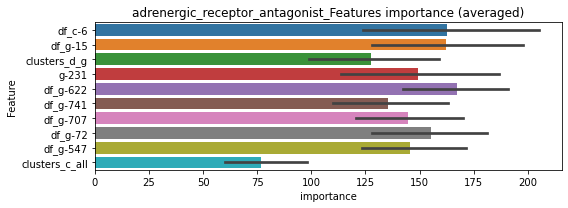

len(train_index) : 3453
len(valid_index) : 3453
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376044	valid_1's binary_logloss: 0.0675765
[200]	training's binary_logloss: 0.0143091	valid_1's binary_logloss: 0.0513833
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00945102	valid_1's binary_logloss: 0.0477417


len(train_index) : 3453
len(valid_index) : 3453
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363337	valid_1's binary_logloss: 0.0695471


adrenergic_receptor_antagonist logloss: 0.050729982744988134


[200]	training's binary_logloss: 0.0137802	valid_1's binary_logloss: 0.053846
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.013481	valid_1's binary_logloss: 0.0537182


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790709	valid_1's binary_logloss: 0.149954
[200]	training's binary_logloss: 0.0334948	valid_1's binary_logloss: 0.127004
[300]	training's binary_logloss: 0.0148296	valid_1's binary_logloss: 0.119811
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0136869	valid_1's binary_logloss: 0.119302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093881	valid_1's binary_logloss: 0.126953
[200]	training's binary_logloss: 0.0451632	valid_1's binary_logloss: 0.0889045
[300]	training's binary_logloss: 0.0190598	valid_1's binary_logloss: 0.0747358
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00965478	valid_1's binary_logloss: 0.0686897


1 / 3 AUC score:0.990
y_Threshold: 0.1022810, Threshold: 0.4157586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 190 → Positive_corect_labels: 626/3743
p_label_rate: 0.0200904 Vs.target_rate: 0.00277, Num_p_label: 80.0, conf_0:0.37418, conf_1:0.45733
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.4157586
Num_p_label: 79.0, Expected: 11.0, Adj_threshold_2: 0.4257586
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_3: 0.4357586
Num_p_label: 74.0, Expected: 11.0, Adj_threshold_4: 0.4457586
Num_p_label: 71.0, Expected: 11.0, Adj_threshold_5: 0.4557586
Num_p_label: 69.0, Expected: 11.0, Adj_threshold_6: 0.4657586
Num_p_label: 66.0, Expected: 11.0, Adj_threshold_7: 0.4757586
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_8: 0.4857586
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_9: 0.4957586
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_10: 0.5057586
threshold: 0.5157586, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 626.0/3743, y_label_rate: 0.167245

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614681	valid_1's binary_logloss: 0.101388
[200]	training's binary_logloss: 0.019824	valid_1's binary_logloss: 0.0645371
[300]	training's binary_logloss: 0.00785558	valid_1's binary_logloss: 0.0539214
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0053244	valid_1's binary_logloss: 0.0514191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620947	valid_1's binary_logloss: 0.102421
[200]	training's binary_logloss: 0.0188914	valid_1's binary_logloss: 0.0612063
[300]	training's binary_logloss: 0.00777158	valid_1's binary_logloss: 0.0505102
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00437192	valid_1's binary_logloss: 0.0467032


2 / 3 AUC score:0.997
y_Threshold: 0.1731904, Threshold: 0.5157586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 595.0/3681
p_label_rate: 0.0291311 Vs.target_rate: 0.00277, Num_p_label: 116.0, conf_0:0.46418, conf_1:0.56733
Num_p_label: 116.0, Expected: 11.0, Adj_threshold_1: 0.5157586
Num_p_label: 112.0, Expected: 11.0, Adj_threshold_2: 0.5257586
Num_p_label: 109.0, Expected: 11.0, Adj_threshold_3: 0.5357586
Num_p_label: 106.0, Expected: 11.0, Adj_threshold_4: 0.5457586
Num_p_label: 105.0, Expected: 11.0, Adj_threshold_5: 0.5557586
Num_p_label: 104.0, Expected: 11.0, Adj_threshold_6: 0.5657586
Num_p_label: 103.0, Expected: 11.0, Adj_threshold_7: 0.5757586
Num_p_label: 101.0, Expected: 11.0, Adj_threshold_8: 0.5857586
Num_p_label: 98.0, Expected: 11.0, Adj_threshold_9: 0.5957586
Num_p_label: 95.0, Expected: 11.0, Adj_threshold_10: 0.6057586
threshold: 0.6157586, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 595.0/3681, y_label_rate

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507132	valid_1's binary_logloss: 0.0821152
[200]	training's binary_logloss: 0.0134818	valid_1's binary_logloss: 0.0469481
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00601574	valid_1's binary_logloss: 0.0407617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486813	valid_1's binary_logloss: 0.0978562
[200]	training's binary_logloss: 0.0123348	valid_1's binary_logloss: 0.0633596
[300]	training's binary_logloss: 0.00464624	valid_1's binary_logloss: 0.0572696
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00370135	valid_1's binary_logloss: 0.0558449


3 / 3 AUC score:0.996
y_Threshold: 0.2156562, Threshold: 0.6157586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 564.0/3619
p_label_rate: 0.0271220 Vs.target_rate: 0.00277, Num_p_label: 108.0, conf_0:0.55418, conf_1:0.67733
Num_p_label: 108.0, Expected: 11.0, Adj_threshold_1: 0.6157586
Num_p_label: 106.0, Expected: 11.0, Adj_threshold_2: 0.6257586
Num_p_label: 106.0, Expected: 11.0, Adj_threshold_3: 0.6357586
Num_p_label: 105.0, Expected: 11.0, Adj_threshold_4: 0.6457586
Num_p_label: 103.0, Expected: 11.0, Adj_threshold_5: 0.6557586
Num_p_label: 101.0, Expected: 11.0, Adj_threshold_6: 0.6657586
Num_p_label: 98.0, Expected: 11.0, Adj_threshold_7: 0.6757586
Num_p_label: 98.0, Expected: 11.0, Adj_threshold_8: 0.6857586
Num_p_label: 98.0, Expected: 11.0, Adj_threshold_9: 0.6957586
Num_p_label: 98.0, Expected: 11.0, Adj_threshold_10: 0.7057586
threshold: 0.7157586, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 662.0/7601, y_label_rate: 

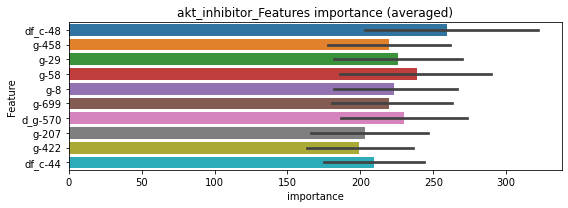

len(train_index) : 3800
len(valid_index) : 3801
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238511	valid_1's binary_logloss: 0.0581306


len(train_index) : 3801
len(valid_index) : 3800
================================= fold 2/2 akt_inhibitor=================================


[200]	training's binary_logloss: 0.00604867	valid_1's binary_logloss: 0.0427224
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00454781	valid_1's binary_logloss: 0.0419357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273722	valid_1's binary_logloss: 0.0453587
[200]	training's binary_logloss: 0.00737612	valid_1's binary_logloss: 0.0296035


akt_inhibitor logloss: 0.034712123862424324


[300]	training's binary_logloss: 0.00297019	valid_1's binary_logloss: 0.0274961
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00298774	valid_1's binary_logloss: 0.0274867


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246789	valid_1's binary_logloss: 0.0342483
[200]	training's binary_logloss: 0.0029951	valid_1's binary_logloss: 0.00640519
[300]	training's binary_logloss: 0.000838997	valid_1's binary_logloss: 0.00249224
[400]	training's binary_logloss: 0.000441565	valid_1's binary_logloss: 0.00156667
[500]	training's binary_logloss: 0.000344513	valid_1's binary_logloss: 0.00134062
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00034484	valid_1's binary_logloss: 0.00133999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250385	valid_1's binary_logloss: 0.0302111
[200]	training's binary_logloss: 0.00297606	valid_1's binary_logloss: 0.0047414
[300]	training's binary_logloss: 0.000837894	valid_1's binary_logloss: 0.00169397
[400]	training's binary_logloss: 0.00044436	valid_1's binary_logloss: 0.000992744
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0016975, Threshold: 0.0026275, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00236, conf_1:0.00289
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0026275
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_2: 0.0126275
threshold: 0.0126275, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244992	valid_1's binary_logloss: 0.0337869
[200]	training's binary_logloss: 0.00294035	valid_1's binary_logloss: 0.00588246
[300]	training's binary_logloss: 0.000822025	valid_1's binary_logloss: 0.00209052
[400]	training's binary_logloss: 0.000432543	valid_1's binary_logloss: 0.00128404
[500]	training's binary_logloss: 0.000344406	valid_1's binary_logloss: 0.00109992
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000339722	valid_1's binary_logloss: 0.0010914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241854	valid_1's binary_logloss: 0.0290743
[200]	training's binary_logloss: 0.00285036	valid_1's binary_logloss: 0.00485156
[300]	training's binary_logloss: 0.000801374	valid_1's binary_logloss: 0.00179023
[400]	training's binary_logloss: 0.000427457	valid_1's binary_logloss: 0.00111968
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1240182, Threshold: 0.0126275, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0070316 Vs.target_rate: 0.00080, Num_p_label: 28.0, conf_0:0.01136, conf_1:0.01389
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_1: 0.0126275
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.0226275
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.0326275
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.0426275
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.0526275
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_6: 0.0626275
threshold: 0.0626275, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244992	valid_1's binary_logloss: 0.0337869
[200]	training's binary_logloss: 0.00294035	valid_1's binary_logloss: 0.00588246
[300]	training's binary_logloss: 0.000822025	valid_1's binary_logloss: 0.00209052
[400]	training's binary_logloss: 0.000432543	valid_1's binary_logloss: 0.00128404
[500]	training's binary_logloss: 0.000344406	valid_1's binary_logloss: 0.00109992
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000339722	valid_1's binary_logloss: 0.0010914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241854	valid_1's binary_logloss: 0.0290743
[200]	training's binary_logloss: 0.00285036	valid_1's binary_logloss: 0.00485156
[300]	training's binary_logloss: 0.000801374	valid_1's binary_logloss: 0.00179023
[400]	training's binary_logloss: 0.000427457	valid_1's binary_logloss: 0.00111968
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1240182, Threshold: 0.0626275, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00080, Num_p_label: 3.0, conf_0:0.05636, conf_1:0.06889
threshold: 0.0626275, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


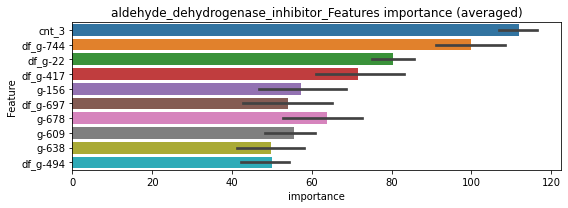

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129694	valid_1's binary_logloss: 0.0199524
[200]	training's binary_logloss: 0.00153091	valid_1's binary_logloss: 0.00468819
[300]	training's binary_logloss: 0.000419467	valid_1's binary_logloss: 0.0028545
[400]	training's binary_logloss: 0.000217884	valid_1's binary_logloss: 0.0025958
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000227424	valid_1's binary_logloss: 0.00258299


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133283	valid_1's binary_logloss: 0.0177605
[200]	training's binary_logloss: 0.00158703	valid_1's binary_logloss: 0.00392164
[300]	training's binary_logloss: 0.00043055	valid_1's binary_logloss: 0.00227908
[400]	training's binary_logloss: 0.000224794	valid_1's binary_logloss: 0.00199042
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000197343	valid_1's binary_logloss: 0.00194263


aldehyde_dehydrogenase_inhibitor logloss: 0.0022628468108868475
alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350184	valid_1's binary_logloss: 0.0629426
[200]	training's binary_logloss: 0.00521497	valid_1's binary_logloss: 0.0240916
[300]	training's binary_logloss: 0.00152496	valid_1's binary_logloss: 0.015539
[400]	training's binary_logloss: 0.000753899	valid_1's binary_logloss: 0.0125755
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000523186	valid_1's binary_logloss: 0.011569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353855	valid_1's binary_logloss: 0.0622653
[200]	training's binary_logloss: 0.00580761	valid_1's binary_logloss: 0.0218454
[300]	training's binary_logloss: 0.00166926	valid_1's binary_logloss: 0.0123639
[400]	training's binary_logloss: 0.000797082	valid_1's binary_logloss: 0.00907565
[500]	training's binary_logloss: 0.000537397	valid_1's binary_logloss: 0.0082505
Early stopping, best iteration is:
[491]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0061133, Threshold: 0.0169035, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.01521, conf_1:0.01859
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0169035
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_2: 0.0269035
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_3: 0.0369035
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_4: 0.0469035
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_5: 0.0569035
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_6: 0.0669035
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_7: 0.0769035
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_8: 0.0869035
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_9: 0.0969035
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_10: 0.1069035
threshold: 0.1169035, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332712	valid_1's binary_logloss: 0.0599567
[200]	training's binary_logloss: 0.00488803	valid_1's binary_logloss: 0.0190357
[300]	training's binary_logloss: 0.00142523	valid_1's binary_logloss: 0.0112492
[400]	training's binary_logloss: 0.000703878	valid_1's binary_logloss: 0.00848512
[500]	training's binary_logloss: 0.000480986	valid_1's binary_logloss: 0.00749566
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000444265	valid_1's binary_logloss: 0.00734311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032971	valid_1's binary_logloss: 0.0594847
[200]	training's binary_logloss: 0.00491521	valid_1's binary_logloss: 0.019977
[300]	training's binary_logloss: 0.00142725	valid_1's binary_logloss: 0.0112614
[400]	training's binary_logloss: 0.000711595	valid_1's binary_logloss: 0.00841812
Early stopping, best iteration is:
[487

2 / 3 AUC score:1.000
y_Threshold: 0.2737965, Threshold: 0.1169035, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0173280 Vs.target_rate: 0.00176, Num_p_label: 69.0, conf_0:0.10521, conf_1:0.12859
Num_p_label: 69.0, Expected: 7.0, Adj_threshold_1: 0.1169035
Num_p_label: 64.0, Expected: 7.0, Adj_threshold_2: 0.1269035
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_3: 0.1369035
Num_p_label: 54.0, Expected: 7.0, Adj_threshold_4: 0.1469035
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_5: 0.1569035
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_6: 0.1669035
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_7: 0.1769035
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_8: 0.1869035
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_9: 0.1969035
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_10: 0.2069035
threshold: 0.2169035, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322544	valid_1's binary_logloss: 0.0691923
[200]	training's binary_logloss: 0.00478845	valid_1's binary_logloss: 0.0332203
[300]	training's binary_logloss: 0.00139541	valid_1's binary_logloss: 0.0249421
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00100207	valid_1's binary_logloss: 0.0233903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330792	valid_1's binary_logloss: 0.0610161
[200]	training's binary_logloss: 0.0047881	valid_1's binary_logloss: 0.0185139
[300]	training's binary_logloss: 0.00139323	valid_1's binary_logloss: 0.00978401
[400]	training's binary_logloss: 0.00070221	valid_1's binary_logloss: 0.00718777
[500]	training's binary_logloss: 0.00047538	valid_1's binary_logloss: 0.00586684
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000445681	valid_1's binary_logloss: 0.00567333


3 / 3 AUC score:1.000
y_Threshold: 0.0649087, Threshold: 0.2169035, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0110497 Vs.target_rate: 0.00176, Num_p_label: 44.0, conf_0:0.19521, conf_1:0.23859
Num_p_label: 44.0, Expected: 7.0, Adj_threshold_1: 0.2169035
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_2: 0.2269035
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_3: 0.2369035
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_4: 0.2469035
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_5: 0.2569035
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_6: 0.2669035
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_7: 0.2769035
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_8: 0.2869035
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_9: 0.2969035
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_10: 0.3069035
threshold: 0.3169035, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 679.0/7772, y_label_rate: 0.0873649


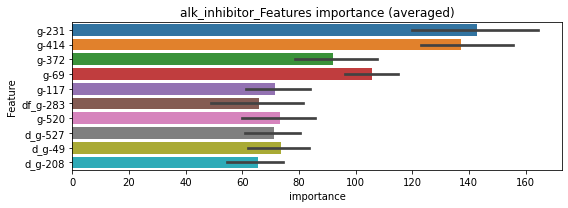

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184186	valid_1's binary_logloss: 0.0345395
[200]	training's binary_logloss: 0.00272359	valid_1's binary_logloss: 0.0136124
[300]	training's binary_logloss: 0.000790884	valid_1's binary_logloss: 0.00929805
[400]	training's binary_logloss: 0.000394208	valid_1's binary_logloss: 0.00829306
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000384789	valid_1's binary_logloss: 0.00824211


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186854	valid_1's binary_logloss: 0.0385721
[200]	training's binary_logloss: 0.00278151	valid_1's binary_logloss: 0.0174379
[300]	training's binary_logloss: 0.00079886	valid_1's binary_logloss: 0.0132498
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000445432	valid_1's binary_logloss: 0.0120893


alk_inhibitor logloss: 0.010165713459812282
ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019639	valid_1's binary_logloss: 0.024219
[200]	training's binary_logloss: 0.00209183	valid_1's binary_logloss: 0.00374535
[300]	training's binary_logloss: 0.000595936	valid_1's binary_logloss: 0.00133149
[400]	training's binary_logloss: 0.000332427	valid_1's binary_logloss: 0.000824741
[500]	training's binary_logloss: 0.000287096	valid_1's binary_logloss: 0.000734232
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000286934	valid_1's binary_logloss: 0.000734045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195054	valid_1's binary_logloss: 0.0238095
[200]	training's binary_logloss: 0.00211549	valid_1's binary_logloss: 0.00431452
[300]	training's binary_logloss: 0.000604989	valid_1's binary_logloss: 0.00215997
[400]	training's binary_logloss: 0.000344011	valid_1's binary_logloss: 0.00161608
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0012367, Threshold: 0.0020733, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00187, conf_1:0.00228
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020733
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0120733
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0220733
threshold: 0.0220733, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193402	valid_1's binary_logloss: 0.0228472
[200]	training's binary_logloss: 0.00199909	valid_1's binary_logloss: 0.00305438
[300]	training's binary_logloss: 0.000580373	valid_1's binary_logloss: 0.00101382
[400]	training's binary_logloss: 0.000327977	valid_1's binary_logloss: 0.000616638
[500]	training's binary_logloss: 0.000284667	valid_1's binary_logloss: 0.000548089
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000284271	valid_1's binary_logloss: 0.000547298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193816	valid_1's binary_logloss: 0.0222477
[200]	training's binary_logloss: 0.00199615	valid_1's binary_logloss: 0.00326209
[300]	training's binary_logloss: 0.000577538	valid_1's binary_logloss: 0.001512
[400]	training's binary_logloss: 0.000330089	valid_1's binary_logloss: 0.00119157
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0527951, Threshold: 0.0220733, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00050, Num_p_label: 14.0, conf_0:0.01987, conf_1:0.02428
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.0220733
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0320733
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0420733
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0520733
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_5: 0.0620733
threshold: 0.0620733, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193402	valid_1's binary_logloss: 0.0228472
[200]	training's binary_logloss: 0.00199909	valid_1's binary_logloss: 0.00305438
[300]	training's binary_logloss: 0.000580373	valid_1's binary_logloss: 0.00101382
[400]	training's binary_logloss: 0.000327977	valid_1's binary_logloss: 0.000616638
[500]	training's binary_logloss: 0.000284667	valid_1's binary_logloss: 0.000548089
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000284271	valid_1's binary_logloss: 0.000547298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193816	valid_1's binary_logloss: 0.0222477
[200]	training's binary_logloss: 0.00199615	valid_1's binary_logloss: 0.00326209
[300]	training's binary_logloss: 0.000577538	valid_1's binary_logloss: 0.001512
[400]	training's binary_logloss: 0.000330089	valid_1's binary_logloss: 0.00119157
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0527951, Threshold: 0.0620733, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.05587, conf_1:0.06828
threshold: 0.0620733, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


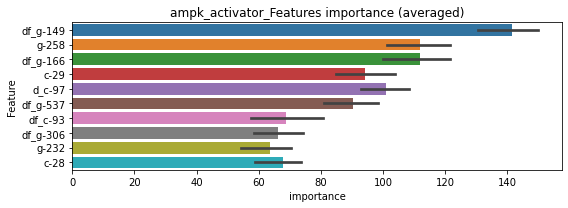

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105494	valid_1's binary_logloss: 0.014983
[200]	training's binary_logloss: 0.0010782	valid_1's binary_logloss: 0.00453345
[300]	training's binary_logloss: 0.000300952	valid_1's binary_logloss: 0.00371405
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000274685	valid_1's binary_logloss: 0.00365074


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106745	valid_1's binary_logloss: 0.0132948
[200]	training's binary_logloss: 0.00110985	valid_1's binary_logloss: 0.0023316
[300]	training's binary_logloss: 0.000308816	valid_1's binary_logloss: 0.00128747
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00018096	valid_1's binary_logloss: 0.00111184


ampk_activator logloss: 0.002381291421637366
analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191587	valid_1's binary_logloss: 0.0259838
[200]	training's binary_logloss: 0.00196779	valid_1's binary_logloss: 0.00496541
[300]	training's binary_logloss: 0.000572814	valid_1's binary_logloss: 0.00248826
[400]	training's binary_logloss: 0.000322153	valid_1's binary_logloss: 0.00173144
[500]	training's binary_logloss: 0.00027911	valid_1's binary_logloss: 0.00162628
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000276599	valid_1's binary_logloss: 0.00162163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191816	valid_1's binary_logloss: 0.0212369
[200]	training's binary_logloss: 0.00197792	valid_1's binary_logloss: 0.00259558
[300]	training's binary_logloss: 0.00056907	valid_1's binary_logloss: 0.000869252
[400]	training's binary_logloss: 0.00031874	valid_1's binary_logloss: 0.000518921
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0010665, Threshold: 0.0015602, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00140, conf_1:0.00172
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015602
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0115602
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0215602
threshold: 0.0215602, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188913	valid_1's binary_logloss: 0.0250511
[200]	training's binary_logloss: 0.00190867	valid_1's binary_logloss: 0.00419704
[300]	training's binary_logloss: 0.000549415	valid_1's binary_logloss: 0.0019072
[400]	training's binary_logloss: 0.000313652	valid_1's binary_logloss: 0.00135562
[500]	training's binary_logloss: 0.000274848	valid_1's binary_logloss: 0.00128255
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000273389	valid_1's binary_logloss: 0.00127971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191898	valid_1's binary_logloss: 0.0208226
[200]	training's binary_logloss: 0.00192072	valid_1's binary_logloss: 0.0023695
[300]	training's binary_logloss: 0.000552479	valid_1's binary_logloss: 0.000762952
[400]	training's binary_logloss: 0.000313246	valid_1's binary_logloss: 0.00045694
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0620831, Threshold: 0.0215602, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.01940, conf_1:0.02372
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.0215602
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0315602
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0415602
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.0515602
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0615602
threshold: 0.0615602, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188913	valid_1's binary_logloss: 0.0250511
[200]	training's binary_logloss: 0.00190867	valid_1's binary_logloss: 0.00419704
[300]	training's binary_logloss: 0.000549415	valid_1's binary_logloss: 0.0019072
[400]	training's binary_logloss: 0.000313652	valid_1's binary_logloss: 0.00135562
[500]	training's binary_logloss: 0.000274848	valid_1's binary_logloss: 0.00128255
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000273389	valid_1's binary_logloss: 0.00127971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191898	valid_1's binary_logloss: 0.0208226
[200]	training's binary_logloss: 0.00192072	valid_1's binary_logloss: 0.0023695
[300]	training's binary_logloss: 0.000552479	valid_1's binary_logloss: 0.000762952
[400]	training's binary_logloss: 0.000313246	valid_1's binary_logloss: 0.00045694
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0620831, Threshold: 0.0615602, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.05540, conf_1:0.06772
threshold: 0.0615602, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


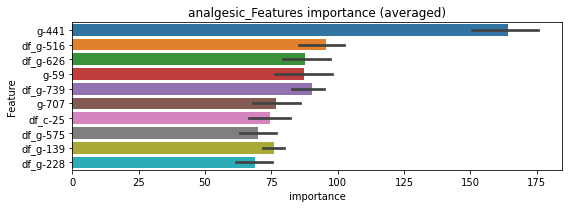

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101813	valid_1's binary_logloss: 0.0162938
[200]	training's binary_logloss: 0.000999	valid_1's binary_logloss: 0.00423438
[300]	training's binary_logloss: 0.000278214	valid_1's binary_logloss: 0.00329454
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000299291	valid_1's binary_logloss: 0.0032896


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104344	valid_1's binary_logloss: 0.0140882
[200]	training's binary_logloss: 0.00104754	valid_1's binary_logloss: 0.00489532


analgesic logloss: 0.004035614377743114


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00076384	valid_1's binary_logloss: 0.00478163


androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411772	valid_1's binary_logloss: 0.0836383
[200]	training's binary_logloss: 0.00757555	valid_1's binary_logloss: 0.038128
[300]	training's binary_logloss: 0.00217921	valid_1's binary_logloss: 0.0277172
[400]	training's binary_logloss: 0.00102554	valid_1's binary_logloss: 0.0242099
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000730493	valid_1's binary_logloss: 0.0231914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453151	valid_1's binary_logloss: 0.0695157
[200]	training's binary_logloss: 0.00864387	valid_1's binary_logloss: 0.0227253
[300]	training's binary_logloss: 0.00245782	valid_1's binary_logloss: 0.0115881
[400]	training's binary_logloss: 0.00113274	valid_1's binary_logloss: 0.00823093
[500]	training's binary_logloss: 0.000710236	valid_1's binary_logloss: 0.00706269
[600]	training's binary_logloss: 0.0005571

1 / 3 AUC score:1.000
y_Threshold: 0.0049924, Threshold: 0.0081215, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00731, conf_1:0.00893
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0081215
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.0181215
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.0281215
threshold: 0.0281215, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405504	valid_1's binary_logloss: 0.0785938
[200]	training's binary_logloss: 0.00704558	valid_1's binary_logloss: 0.0359983
[300]	training's binary_logloss: 0.00206346	valid_1's binary_logloss: 0.0252914
[400]	training's binary_logloss: 0.000986314	valid_1's binary_logloss: 0.0218633
[500]	training's binary_logloss: 0.000643664	valid_1's binary_logloss: 0.0204177
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000655877	valid_1's binary_logloss: 0.0203189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463033	valid_1's binary_logloss: 0.0676603
[200]	training's binary_logloss: 0.0085206	valid_1's binary_logloss: 0.020997
[300]	training's binary_logloss: 0.0024191	valid_1's binary_logloss: 0.010796
[400]	training's binary_logloss: 0.00112527	valid_1's binary_logloss: 0.00757902
[500]	training's binary_logloss: 0.000711252	

2 / 3 AUC score:1.000
y_Threshold: 0.0350217, Threshold: 0.0281215, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0072828 Vs.target_rate: 0.00202, Num_p_label: 29.0, conf_0:0.02531, conf_1:0.03093
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_1: 0.0281215
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_2: 0.0381215
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_3: 0.0481215
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_4: 0.0581215
threshold: 0.0581215, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415772	valid_1's binary_logloss: 0.0744752
[200]	training's binary_logloss: 0.00757386	valid_1's binary_logloss: 0.0320012
[300]	training's binary_logloss: 0.00219438	valid_1's binary_logloss: 0.0217533
[400]	training's binary_logloss: 0.00104368	valid_1's binary_logloss: 0.0187551
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00104368	valid_1's binary_logloss: 0.0187551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426167	valid_1's binary_logloss: 0.0723092
[200]	training's binary_logloss: 0.00740187	valid_1's binary_logloss: 0.0278401
[300]	training's binary_logloss: 0.00220107	valid_1's binary_logloss: 0.0166904
[400]	training's binary_logloss: 0.001066	valid_1's binary_logloss: 0.0131416
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00081901	valid_1's binary_logloss: 0.0121064


3 / 3 AUC score:1.000
y_Threshold: 0.0424725, Threshold: 0.0581215, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0042692 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.05231, conf_1:0.06393
threshold: 0.0581215, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 671.0/7783, y_label_rate: 0.0862135


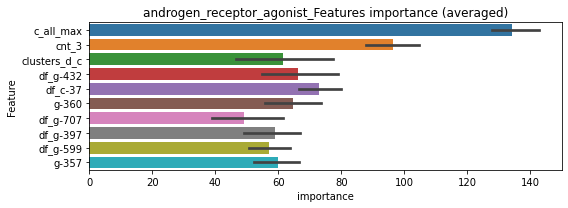

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024117	valid_1's binary_logloss: 0.0495206
[200]	training's binary_logloss: 0.0043633	valid_1's binary_logloss: 0.026381
[300]	training's binary_logloss: 0.00123931	valid_1's binary_logloss: 0.0225083
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000700187	valid_1's binary_logloss: 0.022117


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252711	valid_1's binary_logloss: 0.0455804
[200]	training's binary_logloss: 0.00495097	valid_1's binary_logloss: 0.0237274
[300]	training's binary_logloss: 0.00138245	valid_1's binary_logloss: 0.0179038
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000721014	valid_1's binary_logloss: 0.0167198


androgen_receptor_agonist logloss: 0.019418774574232658
androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114013	valid_1's binary_logloss: 0.176482
[200]	training's binary_logloss: 0.0585628	valid_1's binary_logloss: 0.141442
[300]	training's binary_logloss: 0.0291208	valid_1's binary_logloss: 0.130855
[400]	training's binary_logloss: 0.015583	valid_1's binary_logloss: 0.123698
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.015583	valid_1's binary_logloss: 0.123698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122033	valid_1's binary_logloss: 0.168751
[200]	training's binary_logloss: 0.061042	valid_1's binary_logloss: 0.130483
[300]	training's binary_logloss: 0.0314088	valid_1's binary_logloss: 0.115695


1 / 3 AUC score:0.977
y_Threshold: 0.1258603, Threshold: 0.3046675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 248 → Positive_corect_labels: 596/3680
p_label_rate: 0.0200904 Vs.target_rate: 0.00374, Num_p_label: 80.0, conf_0:0.27420, conf_1:0.33513
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.3046675
Num_p_label: 71.0, Expected: 14.9, Adj_threshold_2: 0.3146675
Num_p_label: 68.0, Expected: 14.9, Adj_threshold_3: 0.3246675
Num_p_label: 67.0, Expected: 14.9, Adj_threshold_4: 0.3346675
Num_p_label: 59.0, Expected: 14.9, Adj_threshold_5: 0.3446675
Num_p_label: 55.0, Expected: 14.9, Adj_threshold_6: 0.3546675
Num_p_label: 52.0, Expected: 14.9, Adj_threshold_7: 0.3646675


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0249229	valid_1's binary_logloss: 0.113591


Num_p_label: 48.0, Expected: 14.9, Adj_threshold_8: 0.3746675
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_9: 0.3846675
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_10: 0.3946675
threshold: 0.4046675, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 596.0/3680, y_label_rate: 0.1619565
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811324	valid_1's binary_logloss: 0.122836
[200]	training's binary_logloss: 0.0311439	valid_1's binary_logloss: 0.0774297
[300]	training's binary_logloss: 0.0134108	valid_1's binary_logloss: 0.0599388
[400]	training's binary_logloss: 0.00681552	valid_1's binary_logloss: 0.053637
[500]	training's binary_logloss: 0.00414555	valid_1's binary_logloss: 0.0496579
[600]	training's binary_logloss: 0.00294968	valid_1's binary_logloss: 0.047469
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00236004	valid_1's binary_logloss: 0.0452375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792397	valid_1's binary_logloss: 0.123595
[200]	training's binary_logloss: 0.0283039	valid_1's binary_logloss: 0.0836426
[300]	training's binary_logloss: 0.0120359	valid_1's binary_logloss: 0.0711151
[400]	training's binary_logloss: 0.00596063	valid_1's

2 / 3 AUC score:0.996
y_Threshold: 0.1957872, Threshold: 0.4046675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 564.0/3616
p_label_rate: 0.0208438 Vs.target_rate: 0.00374, Num_p_label: 83.0, conf_0:0.36420, conf_1:0.44513
Num_p_label: 83.0, Expected: 14.9, Adj_threshold_1: 0.4046675
Num_p_label: 79.0, Expected: 14.9, Adj_threshold_2: 0.4146675
Num_p_label: 79.0, Expected: 14.9, Adj_threshold_3: 0.4246675
Num_p_label: 77.0, Expected: 14.9, Adj_threshold_4: 0.4346675
Num_p_label: 74.0, Expected: 14.9, Adj_threshold_5: 0.4446675
Num_p_label: 73.0, Expected: 14.9, Adj_threshold_6: 0.4546675
Num_p_label: 73.0, Expected: 14.9, Adj_threshold_7: 0.4646675
Num_p_label: 70.0, Expected: 14.9, Adj_threshold_8: 0.4746675
Num_p_label: 68.0, Expected: 14.9, Adj_threshold_9: 0.4846675
Num_p_label: 67.0, Expected: 14.9, Adj_threshold_10: 0.4946675
threshold: 0.5046675, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 564.0/3616, y_label_rate: 0.15597

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652758	valid_1's binary_logloss: 0.099341
[200]	training's binary_logloss: 0.0213283	valid_1's binary_logloss: 0.0595595
[300]	training's binary_logloss: 0.00871906	valid_1's binary_logloss: 0.0479255
[400]	training's binary_logloss: 0.00455405	valid_1's binary_logloss: 0.0415439
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00436163	valid_1's binary_logloss: 0.0412319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650497	valid_1's binary_logloss: 0.107644
[200]	training's binary_logloss: 0.0210343	valid_1's binary_logloss: 0.0688405


3 / 3 AUC score:0.997
y_Threshold: 0.2406330, Threshold: 0.5046675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 538.0/3564
p_label_rate: 0.0158212 Vs.target_rate: 0.00374, Num_p_label: 63.0, conf_0:0.45420, conf_1:0.55513
Num_p_label: 63.0, Expected: 14.9, Adj_threshold_1: 0.5046675
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_2: 0.5146675
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_3: 0.5246675
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_4: 0.5346675
Num_p_label: 58.0, Expected: 14.9, Adj_threshold_5: 0.5446675
Num_p_label: 57.0, Expected: 14.9, Adj_threshold_6: 0.5546675
Num_p_label: 54.0, Expected: 14.9, Adj_threshold_7: 0.5646675
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_8: 0.5746675


[300]	training's binary_logloss: 0.00844648	valid_1's binary_logloss: 0.0563631
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00809144	valid_1's binary_logloss: 0.0558478


Num_p_label: 52.0, Expected: 14.9, Adj_threshold_9: 0.5846675
Num_p_label: 51.0, Expected: 14.9, Adj_threshold_10: 0.5946675
threshold: 0.6046675, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 588.0/7546, y_label_rate: 0.0779221


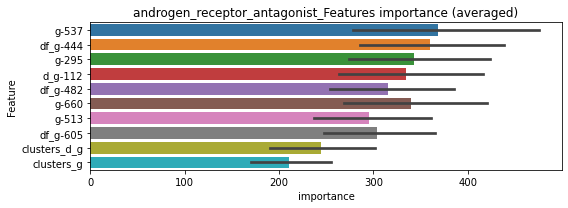

len(train_index) : 3773
len(valid_index) : 3773
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394887	valid_1's binary_logloss: 0.0589387
[200]	training's binary_logloss: 0.0134767	valid_1's binary_logloss: 0.0363464
[300]	training's binary_logloss: 0.00580392	valid_1's binary_logloss: 0.0299406
[400]	training's binary_logloss: 0.00292782	valid_1's binary_logloss: 0.0267081
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0019866	valid_1's binary_logloss: 0.0254529


len(train_index) : 3773
len(valid_index) : 3773
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357885	valid_1's binary_logloss: 0.0567639
[200]	training's binary_logloss: 0.0114618	valid_1's binary_logloss: 0.0344354
[300]	training's binary_logloss: 0.00478065	valid_1's binary_logloss: 0.0279638
[400]	training's binary_logloss: 0.00244598	valid_1's binary_logloss: 0.0255252
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00209132	valid_1's binary_logloss: 0.024794


androgen_receptor_antagonist logloss: 0.025123449610083552
anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103746	valid_1's binary_logloss: 0.179566
[200]	training's binary_logloss: 0.0479622	valid_1's binary_logloss: 0.151449
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0465689	valid_1's binary_logloss: 0.15096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124136	valid_1's binary_logloss: 0.173211
[200]	training's binary_logloss: 0.0581351	valid_1's binary_logloss: 0.131032


1 / 3 AUC score:0.969
y_Threshold: 0.1751576, Threshold: 0.2927516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 270 → Positive_corect_labels: 586/3661
p_label_rate: 0.0200904 Vs.target_rate: 0.00336, Num_p_label: 80.0, conf_0:0.26348, conf_1:0.32203
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.2927516
Num_p_label: 75.0, Expected: 13.4, Adj_threshold_2: 0.3027516
Num_p_label: 68.0, Expected: 13.4, Adj_threshold_3: 0.3127516
Num_p_label: 65.0, Expected: 13.4, Adj_threshold_4: 0.3227516
Num_p_label: 61.0, Expected: 13.4, Adj_threshold_5: 0.3327516
Num_p_label: 57.0, Expected: 13.4, Adj_threshold_6: 0.3427516
Num_p_label: 50.0, Expected: 13.4, Adj_threshold_7: 0.3527516
Num_p_label: 45.0, Expected: 13.4, Adj_threshold_8: 0.3627516
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_9: 0.3727516
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_10: 0.3827516
threshold: 0.3927516, positive_p_label: 35.0/3982, p_label_rate: 0.0087896


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0395349	valid_1's binary_logloss: 0.121138


positive_y_label: 586.0/3661, y_label_rate: 0.1600656
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782981	valid_1's binary_logloss: 0.119488
[200]	training's binary_logloss: 0.0271817	valid_1's binary_logloss: 0.0759976
[300]	training's binary_logloss: 0.0108156	valid_1's binary_logloss: 0.0632934
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00645194	valid_1's binary_logloss: 0.0575918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740523	valid_1's binary_logloss: 0.133655
[200]	training's binary_logloss: 0.0265094	valid_1's binary_logloss: 0.0847347
[300]	training's binary_logloss: 0.011574	valid_1's binary_logloss: 0.0712956
[400]	training's binary_logloss: 0.00570609	valid_1's binary_logloss: 0.0634207
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00607398	valid_1's binary_logloss: 0.0632936


2 / 3 AUC score:0.995
y_Threshold: 0.2136730, Threshold: 0.3927516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 550.0/3589
p_label_rate: 0.0243596 Vs.target_rate: 0.00336, Num_p_label: 97.0, conf_0:0.35348, conf_1:0.43203
Num_p_label: 97.0, Expected: 13.4, Adj_threshold_1: 0.3927516
Num_p_label: 91.0, Expected: 13.4, Adj_threshold_2: 0.4027516
Num_p_label: 86.0, Expected: 13.4, Adj_threshold_3: 0.4127516
Num_p_label: 85.0, Expected: 13.4, Adj_threshold_4: 0.4227516
Num_p_label: 78.0, Expected: 13.4, Adj_threshold_5: 0.4327516
Num_p_label: 76.0, Expected: 13.4, Adj_threshold_6: 0.4427516
Num_p_label: 74.0, Expected: 13.4, Adj_threshold_7: 0.4527516
Num_p_label: 71.0, Expected: 13.4, Adj_threshold_8: 0.4627516
Num_p_label: 71.0, Expected: 13.4, Adj_threshold_9: 0.4727516
Num_p_label: 69.0, Expected: 13.4, Adj_threshold_10: 0.4827516
threshold: 0.4927516, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 550.0/3589, y_label_rate: 0.15324

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674274	valid_1's binary_logloss: 0.10668
[200]	training's binary_logloss: 0.0213037	valid_1's binary_logloss: 0.0599881
[300]	training's binary_logloss: 0.00827185	valid_1's binary_logloss: 0.0418058
[400]	training's binary_logloss: 0.00408291	valid_1's binary_logloss: 0.035095
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00381434	valid_1's binary_logloss: 0.0340346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595526	valid_1's binary_logloss: 0.101229
[200]	training's binary_logloss: 0.0176045	valid_1's binary_logloss: 0.0620012


3 / 3 AUC score:0.998
y_Threshold: 0.2310721, Threshold: 0.4927516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 529.0/3547
p_label_rate: 0.0208438 Vs.target_rate: 0.00336, Num_p_label: 83.0, conf_0:0.44348, conf_1:0.54203
Num_p_label: 83.0, Expected: 13.4, Adj_threshold_1: 0.4927516
Num_p_label: 79.0, Expected: 13.4, Adj_threshold_2: 0.5027516
Num_p_label: 75.0, Expected: 13.4, Adj_threshold_3: 0.5127516
Num_p_label: 74.0, Expected: 13.4, Adj_threshold_4: 0.5227516
Num_p_label: 70.0, Expected: 13.4, Adj_threshold_5: 0.5327516
Num_p_label: 64.0, Expected: 13.4, Adj_threshold_6: 0.5427516
Num_p_label: 63.0, Expected: 13.4, Adj_threshold_7: 0.5527516
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_8: 0.5627516
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_9: 0.5727516
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_10: 0.5827516
threshold: 0.5927516, positive_p_label: 56.0/3982, p_label_rate: 0.0140633


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0110551	valid_1's binary_logloss: 0.0579255


positive_y_label: 585.0/7529, y_label_rate: 0.0776996


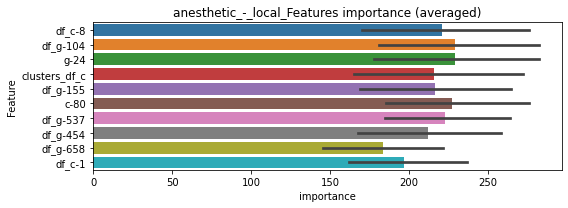

len(train_index) : 3764
len(valid_index) : 3765
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458612	valid_1's binary_logloss: 0.0741272
[200]	training's binary_logloss: 0.015299	valid_1's binary_logloss: 0.0427349
[300]	training's binary_logloss: 0.00645304	valid_1's binary_logloss: 0.0344717
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00343284	valid_1's binary_logloss: 0.0305311


len(train_index) : 3765
len(valid_index) : 3764
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03969	valid_1's binary_logloss: 0.0656537
[200]	training's binary_logloss: 0.0138993	valid_1's binary_logloss: 0.0428117
[300]	training's binary_logloss: 0.00578533	valid_1's binary_logloss: 0.0357627


anesthetic_-_local logloss: 0.03246290323595071


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00428438	valid_1's binary_logloss: 0.0343952


angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415289	valid_1's binary_logloss: 0.0650602
[200]	training's binary_logloss: 0.00717197	valid_1's binary_logloss: 0.0196415
[300]	training's binary_logloss: 0.00191619	valid_1's binary_logloss: 0.00904102
[400]	training's binary_logloss: 0.000884153	valid_1's binary_logloss: 0.0063208
[500]	training's binary_logloss: 0.000565488	valid_1's binary_logloss: 0.00496922
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000516383	valid_1's binary_logloss: 0.00477389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432104	valid_1's binary_logloss: 0.0644663
[200]	training's binary_logloss: 0.00721694	valid_1's binary_logloss: 0.0190966
[300]	training's binary_logloss: 0.00191314	valid_1's binary_logloss: 0.0096296
[400]	training's binary_logloss: 0.000896564	valid_1's binary_logloss: 0.00689376
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0042304, Threshold: 0.0064219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00578, conf_1:0.00706
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064219
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0164219
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0264219
threshold: 0.0264219, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409443	valid_1's binary_logloss: 0.0620308
[200]	training's binary_logloss: 0.00678566	valid_1's binary_logloss: 0.0178343
[300]	training's binary_logloss: 0.00186186	valid_1's binary_logloss: 0.00844918
[400]	training's binary_logloss: 0.00089453	valid_1's binary_logloss: 0.00631038
[500]	training's binary_logloss: 0.000565039	valid_1's binary_logloss: 0.00497093
[600]	training's binary_logloss: 0.000478822	valid_1's binary_logloss: 0.00467963
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00047796	valid_1's binary_logloss: 0.00467806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405726	valid_1's binary_logloss: 0.0614474
[200]	training's binary_logloss: 0.00647976	valid_1's binary_logloss: 0.0161839
[300]	training's binary_logloss: 0.00180138	valid_1's binary_logloss: 0.00787103
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0834675, Threshold: 0.0264219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0060271 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.02378, conf_1:0.02906
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0264219
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0364219
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0464219
threshold: 0.0464219, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409443	valid_1's binary_logloss: 0.0620308
[200]	training's binary_logloss: 0.00678566	valid_1's binary_logloss: 0.0178343
[300]	training's binary_logloss: 0.00186186	valid_1's binary_logloss: 0.00844918
[400]	training's binary_logloss: 0.00089453	valid_1's binary_logloss: 0.00631038
[500]	training's binary_logloss: 0.000565039	valid_1's binary_logloss: 0.00497093
[600]	training's binary_logloss: 0.000478822	valid_1's binary_logloss: 0.00467963
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00047796	valid_1's binary_logloss: 0.00467806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405726	valid_1's binary_logloss: 0.0614474
[200]	training's binary_logloss: 0.00647976	valid_1's binary_logloss: 0.0161839
[300]	training's binary_logloss: 0.00180138	valid_1's binary_logloss: 0.00787103
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0834675, Threshold: 0.0464219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.04178, conf_1:0.05106
threshold: 0.0464219, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


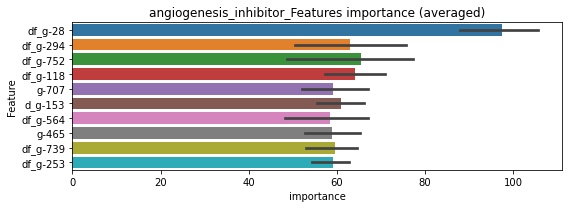

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237925	valid_1's binary_logloss: 0.0397723
[200]	training's binary_logloss: 0.00383848	valid_1's binary_logloss: 0.0152976
[300]	training's binary_logloss: 0.00102289	valid_1's binary_logloss: 0.0113207
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000708475	valid_1's binary_logloss: 0.0109664


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231014	valid_1's binary_logloss: 0.0427434
[200]	training's binary_logloss: 0.00379551	valid_1's binary_logloss: 0.017109
[300]	training's binary_logloss: 0.00102491	valid_1's binary_logloss: 0.0123002
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000742422	valid_1's binary_logloss: 0.0117588


angiogenesis_inhibitor logloss: 0.011362581442800791
angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389556	valid_1's binary_logloss: 0.0635789
[200]	training's binary_logloss: 0.00618423	valid_1's binary_logloss: 0.0216451
[300]	training's binary_logloss: 0.00175919	valid_1's binary_logloss: 0.0139044
[400]	training's binary_logloss: 0.000841928	valid_1's binary_logloss: 0.0115011
[500]	training's binary_logloss: 0.000557703	valid_1's binary_logloss: 0.010623
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00054033	valid_1's binary_logloss: 0.0105537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412729	valid_1's binary_logloss: 0.0684996
[200]	training's binary_logloss: 0.00681953	valid_1's binary_logloss: 0.0203154
[300]	training's binary_logloss: 0.00187403	valid_1's binary_logloss: 0.00942662
[400]	training's binary_logloss: 0.000870216	valid_1's binary_logloss: 0.00613733
[500]	training's binary_logloss: 0.000562

1 / 3 AUC score:1.000
y_Threshold: 0.0045024, Threshold: 0.0068621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00618, conf_1:0.00755
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0068621
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.0168621
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_3: 0.0268621
threshold: 0.0268621, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384196	valid_1's binary_logloss: 0.0617348
[200]	training's binary_logloss: 0.00595799	valid_1's binary_logloss: 0.0202041
[300]	training's binary_logloss: 0.00170441	valid_1's binary_logloss: 0.0126163
[400]	training's binary_logloss: 0.000821168	valid_1's binary_logloss: 0.0105174
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000650627	valid_1's binary_logloss: 0.0100796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408894	valid_1's binary_logloss: 0.0656974
[200]	training's binary_logloss: 0.00667079	valid_1's binary_logloss: 0.0182242
[300]	training's binary_logloss: 0.00185838	valid_1's binary_logloss: 0.00807765
[400]	training's binary_logloss: 0.000873996	valid_1's binary_logloss: 0.00517758
[500]	training's binary_logloss: 0.000571214	valid_1's binary_logloss: 0.00410121
Early stopping, best iteration is:
[51

2 / 3 AUC score:1.000
y_Threshold: 0.0349109, Threshold: 0.0268621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0065294 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.02418, conf_1:0.02955
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.0268621
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.0368621
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0468621
threshold: 0.0468621, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384196	valid_1's binary_logloss: 0.0617348
[200]	training's binary_logloss: 0.00595799	valid_1's binary_logloss: 0.0202041
[300]	training's binary_logloss: 0.00170441	valid_1's binary_logloss: 0.0126163
[400]	training's binary_logloss: 0.000821168	valid_1's binary_logloss: 0.0105174
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000650627	valid_1's binary_logloss: 0.0100796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408894	valid_1's binary_logloss: 0.0656974
[200]	training's binary_logloss: 0.00667079	valid_1's binary_logloss: 0.0182242
[300]	training's binary_logloss: 0.00185838	valid_1's binary_logloss: 0.00807765
[400]	training's binary_logloss: 0.000873996	valid_1's binary_logloss: 0.00517758
[500]	training's binary_logloss: 0.000571214	valid_1's binary_logloss: 0.00410121
Early stopping, best iteration is:
[51

3 / 3 AUC score:1.000
y_Threshold: 0.0349109, Threshold: 0.0468621, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00155, Num_p_label: 11.0, conf_0:0.04218, conf_1:0.05155
threshold: 0.0468621, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


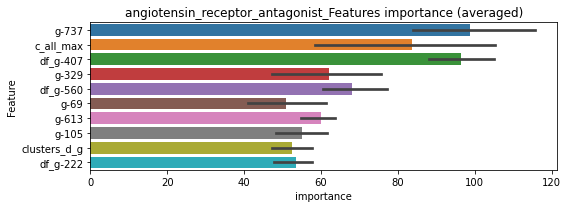

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226996	valid_1's binary_logloss: 0.0396186
[200]	training's binary_logloss: 0.00359253	valid_1's binary_logloss: 0.015824
[300]	training's binary_logloss: 0.000982904	valid_1's binary_logloss: 0.0120811
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000710915	valid_1's binary_logloss: 0.0117217


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232894	valid_1's binary_logloss: 0.0342985
[200]	training's binary_logloss: 0.00414393	valid_1's binary_logloss: 0.0115262
[300]	training's binary_logloss: 0.00110625	valid_1's binary_logloss: 0.00713397
[400]	training's binary_logloss: 0.00050562	valid_1's binary_logloss: 0.00600734
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000431005	valid_1's binary_logloss: 0.00587485


angiotensin_receptor_antagonist logloss: 0.00879866308178601
anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517968	valid_1's binary_logloss: 0.102488
[200]	training's binary_logloss: 0.0109262	valid_1's binary_logloss: 0.0484433
[300]	training's binary_logloss: 0.00329636	valid_1's binary_logloss: 0.0340677
[400]	training's binary_logloss: 0.00148487	valid_1's binary_logloss: 0.0287969
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00133739	valid_1's binary_logloss: 0.0285301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569472	valid_1's binary_logloss: 0.0964696
[200]	training's binary_logloss: 0.0121336	valid_1's binary_logloss: 0.0384884
[300]	training's binary_logloss: 0.00349233	valid_1's binary_logloss: 0.0206063
[400]	training's binary_logloss: 0.00157482	valid_1's binary_logloss: 0.0149945
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.0011513	valid_1's binary_logloss: 0.0135724


1 / 3 AUC score:1.000
y_Threshold: 0.0119334, Threshold: 0.0182859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.01646, conf_1:0.02011
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0182859
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.0282859
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_3: 0.0382859
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.0482859
threshold: 0.0482859, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 653.0/3796, y_label_rate: 0.1720232
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503303	valid_1's binary_logloss: 0.112415
[200]	training's binary_logloss: 0.0101349	valid_1's binary_logloss: 0.0632757
[300]	training's binary_logloss: 0.00303737	valid_1's binary_logloss: 0.0499849
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00196102	valid_1's binary_logloss: 0.0477628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537074	valid_1's binary_logloss: 0.103833
[200]	training's binary_logloss: 0.0113797	valid_1's binary_logloss: 0.0501453
[300]	training's binary_logloss: 0.00328628	valid_1's binary_logloss: 0.0349294
[400]	training's binary_logloss: 0.00149114	valid_1's binary_logloss: 0.0308308
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00112646	valid_1's binary_logloss: 0.0298799


2 / 3 AUC score:1.000
y_Threshold: 0.0358102, Threshold: 0.0482859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 645.0/3780
p_label_rate: 0.0150678 Vs.target_rate: 0.00307, Num_p_label: 60.0, conf_0:0.04346, conf_1:0.05311
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_1: 0.0482859
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0582859
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_3: 0.0682859
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_4: 0.0782859
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_5: 0.0882859
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.0982859
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.1082859
threshold: 0.1082859, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/3780, y_label_rate: 0.1706349
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478093	valid_1's binary_logloss: 0.116113
[200]	training's binary_logloss: 0.0093292	valid_1's binary_logloss: 0.0659353
[300]	training's binary_logloss: 0.00277462	valid_1's binary_logloss: 0.0525229
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00221058	valid_1's binary_logloss: 0.0520209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530027	valid_1's binary_logloss: 0.101971
[200]	training's binary_logloss: 0.0107072	valid_1's binary_logloss: 0.0512018
[300]	training's binary_logloss: 0.00311159	valid_1's binary_logloss: 0.0384234
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00178331	valid_1's binary_logloss: 0.0358021


3 / 3 AUC score:0.999
y_Threshold: 0.0380448, Threshold: 0.1082859, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3764
p_label_rate: 0.0047715 Vs.target_rate: 0.00307, Num_p_label: 19.0, conf_0:0.09746, conf_1:0.11911
threshold: 0.1082859, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/7746, y_label_rate: 0.0846889


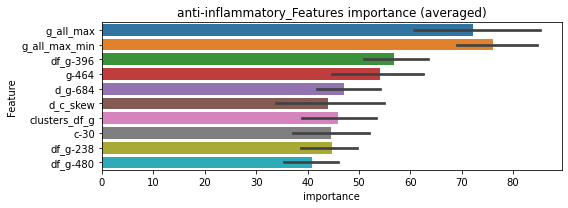

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266738	valid_1's binary_logloss: 0.0538132
[200]	training's binary_logloss: 0.00527579	valid_1's binary_logloss: 0.0269576
[300]	training's binary_logloss: 0.00154578	valid_1's binary_logloss: 0.0202602
[400]	training's binary_logloss: 0.000704906	valid_1's binary_logloss: 0.017894
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000511545	valid_1's binary_logloss: 0.0171939


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304837	valid_1's binary_logloss: 0.0589927
[200]	training's binary_logloss: 0.00614259	valid_1's binary_logloss: 0.0286058
[300]	training's binary_logloss: 0.00175562	valid_1's binary_logloss: 0.020881
[400]	training's binary_logloss: 0.00077705	valid_1's binary_logloss: 0.0188882
[500]	training's binary_logloss: 0.000468666	valid_1's binary_logloss: 0.0178797
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000426132	valid_1's binary_logloss: 0.0177132


anti-inflammatory logloss: 0.01745358174262061
antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286551	valid_1's binary_logloss: 0.0490425
[200]	training's binary_logloss: 0.00372037	valid_1's binary_logloss: 0.0157997
[300]	training's binary_logloss: 0.00105775	valid_1's binary_logloss: 0.00876104
[400]	training's binary_logloss: 0.000529544	valid_1's binary_logloss: 0.00655884
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000412076	valid_1's binary_logloss: 0.00614305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289858	valid_1's binary_logloss: 0.0391396
[200]	training's binary_logloss: 0.00387488	valid_1's binary_logloss: 0.00750221
[300]	training's binary_logloss: 0.00110589	valid_1's binary_logloss: 0.00308058
[400]	training's binary_logloss: 0.000553025	valid_1's binary_logloss: 0.0020298
[500]	training's binary_logloss: 0.000413729	valid_1's binary_logloss: 0.00180797
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0022738, Threshold: 0.0359681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.03237, conf_1:0.03956
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0359681
Num_p_label: 68.0, Expected: 4.0, Adj_threshold_2: 0.0459681
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_3: 0.0559681
Num_p_label: 50.0, Expected: 4.0, Adj_threshold_4: 0.0659681
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_5: 0.0759681
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_6: 0.0859681
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_7: 0.0959681
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_8: 0.1059681
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_9: 0.1159681
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_10: 0.1259681
threshold: 0.1359681, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270796	valid_1's binary_logloss: 0.0452647
[200]	training's binary_logloss: 0.00344441	valid_1's binary_logloss: 0.0137512
[300]	training's binary_logloss: 0.000982095	valid_1's binary_logloss: 0.0079495
[400]	training's binary_logloss: 0.000511551	valid_1's binary_logloss: 0.00619103
[500]	training's binary_logloss: 0.000385756	valid_1's binary_logloss: 0.00559897
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000384025	valid_1's binary_logloss: 0.00558524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281043	valid_1's binary_logloss: 0.0378214
[200]	training's binary_logloss: 0.00362949	valid_1's binary_logloss: 0.00675605
[300]	training's binary_logloss: 0.00101494	valid_1's binary_logloss: 0.00243376
[400]	training's binary_logloss: 0.000518422	valid_1's binary_logloss: 0.00149189
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1143847, Threshold: 0.1359681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0291311 Vs.target_rate: 0.00101, Num_p_label: 116.0, conf_0:0.12237, conf_1:0.14956
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_1: 0.1359681
Num_p_label: 116.0, Expected: 4.0, Adj_threshold_2: 0.1459681
Num_p_label: 115.0, Expected: 4.0, Adj_threshold_3: 0.1559681
Num_p_label: 114.0, Expected: 4.0, Adj_threshold_4: 0.1659681
Num_p_label: 111.0, Expected: 4.0, Adj_threshold_5: 0.1759681
Num_p_label: 107.0, Expected: 4.0, Adj_threshold_6: 0.1859681
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_7: 0.1959681
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_8: 0.2059681
Num_p_label: 106.0, Expected: 4.0, Adj_threshold_9: 0.2159681
Num_p_label: 104.0, Expected: 4.0, Adj_threshold_10: 0.2259681
threshold: 0.2359681, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 657.0/3810, y_label_rate: 0.1724

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270796	valid_1's binary_logloss: 0.0452647
[200]	training's binary_logloss: 0.00344441	valid_1's binary_logloss: 0.0137512
[300]	training's binary_logloss: 0.000982095	valid_1's binary_logloss: 0.0079495
[400]	training's binary_logloss: 0.000511551	valid_1's binary_logloss: 0.00619103
[500]	training's binary_logloss: 0.000385756	valid_1's binary_logloss: 0.00559897
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000384025	valid_1's binary_logloss: 0.00558524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281043	valid_1's binary_logloss: 0.0378214
[200]	training's binary_logloss: 0.00362949	valid_1's binary_logloss: 0.00675605
[300]	training's binary_logloss: 0.00101494	valid_1's binary_logloss: 0.00243376
[400]	training's binary_logloss: 0.000518422	valid_1's binary_logloss: 0.00149189
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1143847, Threshold: 0.2359681, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0258664 Vs.target_rate: 0.00101, Num_p_label: 103.0, conf_0:0.21237, conf_1:0.25956
Num_p_label: 103.0, Expected: 4.0, Adj_threshold_1: 0.2359681
Num_p_label: 103.0, Expected: 4.0, Adj_threshold_2: 0.2459681
Num_p_label: 100.0, Expected: 4.0, Adj_threshold_3: 0.2559681
Num_p_label: 100.0, Expected: 4.0, Adj_threshold_4: 0.2659681
Num_p_label: 98.0, Expected: 4.0, Adj_threshold_5: 0.2759681
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_6: 0.2859681
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_7: 0.2959681
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_8: 0.3059681
Num_p_label: 94.0, Expected: 4.0, Adj_threshold_9: 0.3159681
Num_p_label: 90.0, Expected: 4.0, Adj_threshold_10: 0.3259681
threshold: 0.3359681, positive_p_label: 87.0/3982, p_label_rate: 0.0218483
positive_y_label: 744.0/7792, y_label_rate: 0.0954825


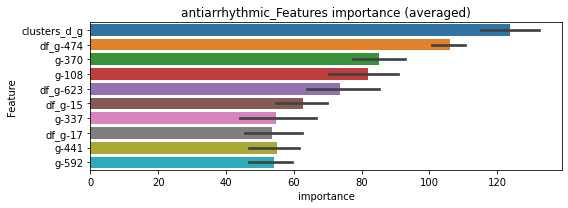

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191758	valid_1's binary_logloss: 0.0281649
[200]	training's binary_logloss: 0.0027321	valid_1's binary_logloss: 0.0102575
[300]	training's binary_logloss: 0.000770405	valid_1's binary_logloss: 0.00760745
[400]	training's binary_logloss: 0.000379964	valid_1's binary_logloss: 0.00697105
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000390464	valid_1's binary_logloss: 0.00696181


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184193	valid_1's binary_logloss: 0.0296448
[200]	training's binary_logloss: 0.00257417	valid_1's binary_logloss: 0.0107789
[300]	training's binary_logloss: 0.000710441	valid_1's binary_logloss: 0.00829284
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000594817	valid_1's binary_logloss: 0.00814602


antiarrhythmic logloss: 0.007553916658793802
antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389462	valid_1's binary_logloss: 0.0601289
[200]	training's binary_logloss: 0.00654216	valid_1's binary_logloss: 0.0208304
[300]	training's binary_logloss: 0.0018758	valid_1's binary_logloss: 0.013086
[400]	training's binary_logloss: 0.000926699	valid_1's binary_logloss: 0.0114974
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000733512	valid_1's binary_logloss: 0.0108899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415353	valid_1's binary_logloss: 0.0655091
[200]	training's binary_logloss: 0.00713074	valid_1's binary_logloss: 0.0216058
[300]	training's binary_logloss: 0.00202882	valid_1's binary_logloss: 0.0115238
[400]	training's binary_logloss: 0.000961664	valid_1's binary_logloss: 0.00848865
[500]	training's binary_logloss: 0.000620152	valid_1's binary_logloss: 0.00749917
Early stopping, best iteration is:
[545]	

1 / 3 AUC score:1.000
y_Threshold: 0.0046158, Threshold: 0.0103141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181, Num_p_label: 80.0, conf_0:0.00928, conf_1:0.01135
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0103141
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_2: 0.0203141
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_3: 0.0303141
threshold: 0.0303141, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381656	valid_1's binary_logloss: 0.0600413
[200]	training's binary_logloss: 0.00602413	valid_1's binary_logloss: 0.0204692
[300]	training's binary_logloss: 0.00177839	valid_1's binary_logloss: 0.0131543
[400]	training's binary_logloss: 0.000893749	valid_1's binary_logloss: 0.0110112
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00074278	valid_1's binary_logloss: 0.010698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413141	valid_1's binary_logloss: 0.0665113
[200]	training's binary_logloss: 0.00700264	valid_1's binary_logloss: 0.0222019
[300]	training's binary_logloss: 0.00197828	valid_1's binary_logloss: 0.0119798
[400]	training's binary_logloss: 0.000934375	valid_1's binary_logloss: 0.00889334
[500]	training's binary_logloss: 0.000608245	valid_1's binary_logloss: 0.00772147
Early stopping, best iteration is:
[520]	

2 / 3 AUC score:1.000
y_Threshold: 0.0304413, Threshold: 0.0303141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0102963 Vs.target_rate: 0.00181, Num_p_label: 41.0, conf_0:0.02728, conf_1:0.03335
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_1: 0.0303141
Num_p_label: 33.0, Expected: 7.2, Adj_threshold_2: 0.0403141
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_3: 0.0503141
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_4: 0.0603141
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_5: 0.0703141
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_6: 0.0803141
threshold: 0.0803141, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389006	valid_1's binary_logloss: 0.0607429
[200]	training's binary_logloss: 0.00627728	valid_1's binary_logloss: 0.0184366
[300]	training's binary_logloss: 0.00182465	valid_1's binary_logloss: 0.00976817
[400]	training's binary_logloss: 0.00089212	valid_1's binary_logloss: 0.00728151
[500]	training's binary_logloss: 0.000595199	valid_1's binary_logloss: 0.00615991
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000536481	valid_1's binary_logloss: 0.00589162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414984	valid_1's binary_logloss: 0.0667204
[200]	training's binary_logloss: 0.00699916	valid_1's binary_logloss: 0.0221295
[300]	training's binary_logloss: 0.00196999	valid_1's binary_logloss: 0.0127902
[400]	training's binary_logloss: 0.000929739	valid_1's binary_logloss: 0.00987699
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0284364, Threshold: 0.0803141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0022602 Vs.target_rate: 0.00181, Num_p_label: 9.0, conf_0:0.07228, conf_1:0.08835
threshold: 0.0803141, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7785, y_label_rate: 0.0852922


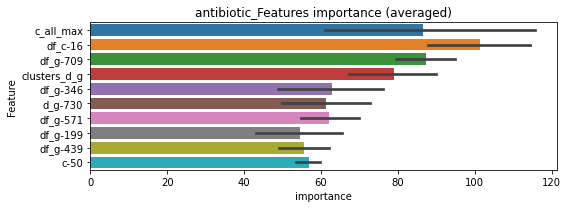

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226211	valid_1's binary_logloss: 0.0403343
[200]	training's binary_logloss: 0.00367272	valid_1's binary_logloss: 0.0171982
[300]	training's binary_logloss: 0.00103321	valid_1's binary_logloss: 0.0133416
[400]	training's binary_logloss: 0.000483223	valid_1's binary_logloss: 0.0126679
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000499847	valid_1's binary_logloss: 0.0126166


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214849	valid_1's binary_logloss: 0.0414133
[200]	training's binary_logloss: 0.00363897	valid_1's binary_logloss: 0.0179935
[300]	training's binary_logloss: 0.00102314	valid_1's binary_logloss: 0.0130797
[400]	training's binary_logloss: 0.000488246	valid_1's binary_logloss: 0.0115656
[500]	training's binary_logloss: 0.000315949	valid_1's binary_logloss: 0.0108349
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00029424	valid_1's binary_logloss: 0.0107562


antibiotic logloss: 0.01168650835821815
anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252788	valid_1's binary_logloss: 0.031365
[200]	training's binary_logloss: 0.00309289	valid_1's binary_logloss: 0.00536806
[300]	training's binary_logloss: 0.000851761	valid_1's binary_logloss: 0.0019804
[400]	training's binary_logloss: 0.000449402	valid_1's binary_logloss: 0.00125527
[500]	training's binary_logloss: 0.000354856	valid_1's binary_logloss: 0.00108776
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00035028	valid_1's binary_logloss: 0.00108395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248974	valid_1's binary_logloss: 0.0367189
[200]	training's binary_logloss: 0.00304412	valid_1's binary_logloss: 0.00848744
[300]	training's binary_logloss: 0.000865697	valid_1's binary_logloss: 0.00522267
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000865697	valid_1's binary_logloss: 0.00522267

1 / 3 AUC score:1.000
y_Threshold: 0.0031475, Threshold: 0.0049322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00444, conf_1:0.00543
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0049322
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.0149322
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0249322
threshold: 0.0249322, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239212	valid_1's binary_logloss: 0.0329808
[200]	training's binary_logloss: 0.00282767	valid_1's binary_logloss: 0.00745947
[300]	training's binary_logloss: 0.000803137	valid_1's binary_logloss: 0.00339317
[400]	training's binary_logloss: 0.000439589	valid_1's binary_logloss: 0.00233552
[500]	training's binary_logloss: 0.000353065	valid_1's binary_logloss: 0.00205279
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000349799	valid_1's binary_logloss: 0.00204067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024364	valid_1's binary_logloss: 0.0340311
[200]	training's binary_logloss: 0.00296228	valid_1's binary_logloss: 0.00845996
[300]	training's binary_logloss: 0.000832892	valid_1's binary_logloss: 0.0041644
[400]	training's binary_logloss: 0.000439165	valid_1's binary_logloss: 0.00335079
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0393530, Threshold: 0.0249322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.02244, conf_1:0.02743
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.0249322
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0349322
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0449322
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0549322
threshold: 0.0549322, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239212	valid_1's binary_logloss: 0.0329808
[200]	training's binary_logloss: 0.00282767	valid_1's binary_logloss: 0.00745947
[300]	training's binary_logloss: 0.000803137	valid_1's binary_logloss: 0.00339317
[400]	training's binary_logloss: 0.000439589	valid_1's binary_logloss: 0.00233552
[500]	training's binary_logloss: 0.000353065	valid_1's binary_logloss: 0.00205279
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000349799	valid_1's binary_logloss: 0.00204067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024364	valid_1's binary_logloss: 0.0340311
[200]	training's binary_logloss: 0.00296228	valid_1's binary_logloss: 0.00845996
[300]	training's binary_logloss: 0.000832892	valid_1's binary_logloss: 0.0041644
[400]	training's binary_logloss: 0.000439165	valid_1's binary_logloss: 0.00335079
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0393530, Threshold: 0.0549322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04944, conf_1:0.06043
threshold: 0.0549322, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


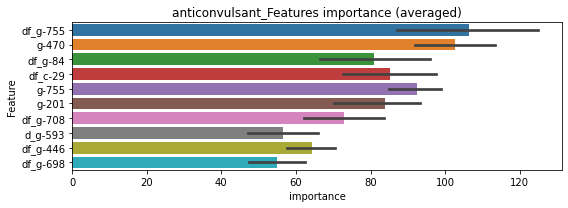

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138562	valid_1's binary_logloss: 0.0223304
[200]	training's binary_logloss: 0.00164623	valid_1's binary_logloss: 0.00893197
[300]	training's binary_logloss: 0.000442502	valid_1's binary_logloss: 0.00785339
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000487015	valid_1's binary_logloss: 0.00785231


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145981	valid_1's binary_logloss: 0.019635
[200]	training's binary_logloss: 0.0018141	valid_1's binary_logloss: 0.00505863
[300]	training's binary_logloss: 0.000487563	valid_1's binary_logloss: 0.00294831
[400]	training's binary_logloss: 0.000246953	valid_1's binary_logloss: 0.00262318
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000230685	valid_1's binary_logloss: 0.00259165


anticonvulsant logloss: 0.005222316517071422
antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285554	valid_1's binary_logloss: 0.0460827
[200]	training's binary_logloss: 0.00390914	valid_1's binary_logloss: 0.0133974
[300]	training's binary_logloss: 0.00111523	valid_1's binary_logloss: 0.00704799
[400]	training's binary_logloss: 0.00056557	valid_1's binary_logloss: 0.00521414
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000416552	valid_1's binary_logloss: 0.00468507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306809	valid_1's binary_logloss: 0.0424329
[200]	training's binary_logloss: 0.00419117	valid_1's binary_logloss: 0.00947915
[300]	training's binary_logloss: 0.00116462	valid_1's binary_logloss: 0.00425562
[400]	training's binary_logloss: 0.000579253	valid_1's binary_logloss: 0.00287629
[500]	training's binary_logloss: 0.000415019	valid_1's binary_logloss: 0.00247079
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0020163, Threshold: 0.0034603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00311, conf_1:0.00381
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0034603
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0134603
threshold: 0.0134603, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293731	valid_1's binary_logloss: 0.045967
[200]	training's binary_logloss: 0.00391284	valid_1's binary_logloss: 0.0125064
[300]	training's binary_logloss: 0.00110668	valid_1's binary_logloss: 0.00668029
[400]	training's binary_logloss: 0.000562728	valid_1's binary_logloss: 0.00507548
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000422477	valid_1's binary_logloss: 0.00467128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304078	valid_1's binary_logloss: 0.0416992
[200]	training's binary_logloss: 0.00396269	valid_1's binary_logloss: 0.00911568
[300]	training's binary_logloss: 0.00112194	valid_1's binary_logloss: 0.00420939
[400]	training's binary_logloss: 0.000568715	valid_1's binary_logloss: 0.0030548
[500]	training's binary_logloss: 0.000411402	valid_1's binary_logloss: 0.0026051
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0316994, Threshold: 0.0134603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00109, Num_p_label: 15.0, conf_0:0.01211, conf_1:0.01481
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.0134603
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_2: 0.0234603
threshold: 0.0234603, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293731	valid_1's binary_logloss: 0.045967
[200]	training's binary_logloss: 0.00391284	valid_1's binary_logloss: 0.0125064
[300]	training's binary_logloss: 0.00110668	valid_1's binary_logloss: 0.00668029
[400]	training's binary_logloss: 0.000562728	valid_1's binary_logloss: 0.00507548
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000422477	valid_1's binary_logloss: 0.00467128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304078	valid_1's binary_logloss: 0.0416992
[200]	training's binary_logloss: 0.00396269	valid_1's binary_logloss: 0.00911568
[300]	training's binary_logloss: 0.00112194	valid_1's binary_logloss: 0.00420939
[400]	training's binary_logloss: 0.000568715	valid_1's binary_logloss: 0.0030548
[500]	training's binary_logloss: 0.000411402	valid_1's binary_logloss: 0.0026051
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0316994, Threshold: 0.0234603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.02111, conf_1:0.02581
threshold: 0.0234603, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7790, y_label_rate: 0.0851091


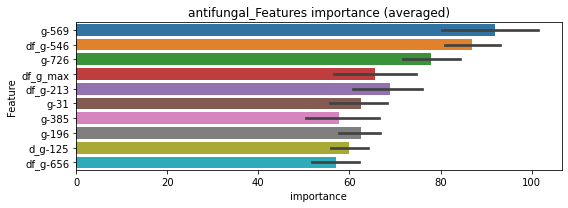

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155164	valid_1's binary_logloss: 0.0263019
[200]	training's binary_logloss: 0.0020853	valid_1's binary_logloss: 0.00957858
[300]	training's binary_logloss: 0.000584315	valid_1's binary_logloss: 0.00744278
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000440089	valid_1's binary_logloss: 0.00727524


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161862	valid_1's binary_logloss: 0.0280017
[200]	training's binary_logloss: 0.00216792	valid_1's binary_logloss: 0.010625
[300]	training's binary_logloss: 0.000607189	valid_1's binary_logloss: 0.00739486
[400]	training's binary_logloss: 0.000299858	valid_1's binary_logloss: 0.00664937
[500]	training's binary_logloss: 0.00021342	valid_1's binary_logloss: 0.00645768
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000216225	valid_1's binary_logloss: 0.00645173


antifungal logloss: 0.006863482377564414
antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234988	valid_1's binary_logloss: 0.0301431
[200]	training's binary_logloss: 0.00279126	valid_1's binary_logloss: 0.00555833
[300]	training's binary_logloss: 0.000791862	valid_1's binary_logloss: 0.00234815
[400]	training's binary_logloss: 0.000426821	valid_1's binary_logloss: 0.00164124
[500]	training's binary_logloss: 0.000334145	valid_1's binary_logloss: 0.00139444
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000331302	valid_1's binary_logloss: 0.00138996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236401	valid_1's binary_logloss: 0.0321468
[200]	training's binary_logloss: 0.00283534	valid_1's binary_logloss: 0.00666365
[300]	training's binary_logloss: 0.00081161	valid_1's binary_logloss: 0.00299921
[400]	training's binary_logloss: 0.000433503	valid_1's binary_logloss: 0.00213809
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0015518, Threshold: 0.0022299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00201, conf_1:0.00245
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0022299
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0122299
threshold: 0.0122299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230266	valid_1's binary_logloss: 0.0289785
[200]	training's binary_logloss: 0.00271438	valid_1's binary_logloss: 0.00559692
[300]	training's binary_logloss: 0.000786708	valid_1's binary_logloss: 0.00261747
[400]	training's binary_logloss: 0.000423682	valid_1's binary_logloss: 0.00189028
[500]	training's binary_logloss: 0.000337898	valid_1's binary_logloss: 0.00171596
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000329627	valid_1's binary_logloss: 0.00170573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231204	valid_1's binary_logloss: 0.0307778
[200]	training's binary_logloss: 0.00269089	valid_1's binary_logloss: 0.00602557
[300]	training's binary_logloss: 0.000785807	valid_1's binary_logloss: 0.00284937
[400]	training's binary_logloss: 0.000422766	valid_1's binary_logloss: 0.00195752
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0419953, Threshold: 0.0122299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.01101, conf_1:0.01345
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.0122299
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0222299
threshold: 0.0222299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230266	valid_1's binary_logloss: 0.0289785
[200]	training's binary_logloss: 0.00271438	valid_1's binary_logloss: 0.00559692
[300]	training's binary_logloss: 0.000786708	valid_1's binary_logloss: 0.00261747
[400]	training's binary_logloss: 0.000423682	valid_1's binary_logloss: 0.00189028
[500]	training's binary_logloss: 0.000337898	valid_1's binary_logloss: 0.00171596
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000329627	valid_1's binary_logloss: 0.00170573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231204	valid_1's binary_logloss: 0.0307778
[200]	training's binary_logloss: 0.00269089	valid_1's binary_logloss: 0.00602557
[300]	training's binary_logloss: 0.000785807	valid_1's binary_logloss: 0.00284937
[400]	training's binary_logloss: 0.000422766	valid_1's binary_logloss: 0.00195752
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0419953, Threshold: 0.0222299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.02001, conf_1:0.02445
threshold: 0.0222299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


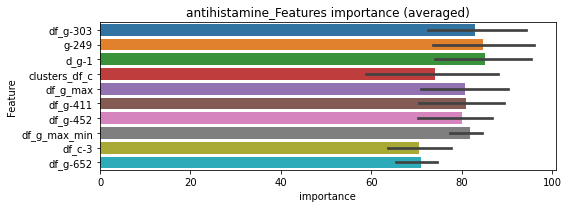

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121956	valid_1's binary_logloss: 0.021272
[200]	training's binary_logloss: 0.00142951	valid_1's binary_logloss: 0.00852058
[300]	training's binary_logloss: 0.000395253	valid_1's binary_logloss: 0.00785009
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000434269	valid_1's binary_logloss: 0.00782653


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131973	valid_1's binary_logloss: 0.0176248
[200]	training's binary_logloss: 0.00162453	valid_1's binary_logloss: 0.0043314
[300]	training's binary_logloss: 0.000461162	valid_1's binary_logloss: 0.00261101
[400]	training's binary_logloss: 0.000239341	valid_1's binary_logloss: 0.00224784
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000206723	valid_1's binary_logloss: 0.00220746


antihistamine logloss: 0.005017354416089486
antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233703	valid_1's binary_logloss: 0.0288421
[200]	training's binary_logloss: 0.00281541	valid_1's binary_logloss: 0.00498111
[300]	training's binary_logloss: 0.0008103	valid_1's binary_logloss: 0.00190168
[400]	training's binary_logloss: 0.000432252	valid_1's binary_logloss: 0.00124239
[500]	training's binary_logloss: 0.000344253	valid_1's binary_logloss: 0.00108108
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000337128	valid_1's binary_logloss: 0.00107027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230777	valid_1's binary_logloss: 0.032984
[200]	training's binary_logloss: 0.00276914	valid_1's binary_logloss: 0.007456
[300]	training's binary_logloss: 0.00079201	valid_1's binary_logloss: 0.00363655
[400]	training's binary_logloss: 0.000431414	valid_1's binary_logloss: 0.00264713
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0015642, Threshold: 0.0024840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00224, conf_1:0.00273
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024840
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0124840
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0224840
threshold: 0.0224840, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231892	valid_1's binary_logloss: 0.0290053
[200]	training's binary_logloss: 0.00268383	valid_1's binary_logloss: 0.00552329
[300]	training's binary_logloss: 0.000770731	valid_1's binary_logloss: 0.00287957
[400]	training's binary_logloss: 0.000425821	valid_1's binary_logloss: 0.00233582
[500]	training's binary_logloss: 0.000341559	valid_1's binary_logloss: 0.00214606
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000344848	valid_1's binary_logloss: 0.00214577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235835	valid_1's binary_logloss: 0.0299245
[200]	training's binary_logloss: 0.00276131	valid_1's binary_logloss: 0.00524977
[300]	training's binary_logloss: 0.000796709	valid_1's binary_logloss: 0.00241367
[400]	training's binary_logloss: 0.000432847	valid_1's binary_logloss: 0.00174482
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0284586, Threshold: 0.0224840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.02024, conf_1:0.02473
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0224840
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0324840
threshold: 0.0324840, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231892	valid_1's binary_logloss: 0.0290053
[200]	training's binary_logloss: 0.00268383	valid_1's binary_logloss: 0.00552329
[300]	training's binary_logloss: 0.000770731	valid_1's binary_logloss: 0.00287957
[400]	training's binary_logloss: 0.000425821	valid_1's binary_logloss: 0.00233582
[500]	training's binary_logloss: 0.000341559	valid_1's binary_logloss: 0.00214606
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000344848	valid_1's binary_logloss: 0.00214577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235835	valid_1's binary_logloss: 0.0299245
[200]	training's binary_logloss: 0.00276131	valid_1's binary_logloss: 0.00524977
[300]	training's binary_logloss: 0.000796709	valid_1's binary_logloss: 0.00241367
[400]	training's binary_logloss: 0.000432847	valid_1's binary_logloss: 0.00174482
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0284586, Threshold: 0.0324840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.02924, conf_1:0.03573
threshold: 0.0324840, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


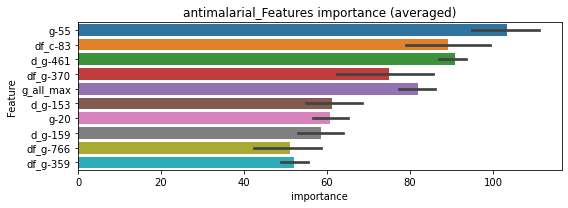

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124792	valid_1's binary_logloss: 0.0178975
[200]	training's binary_logloss: 0.00144238	valid_1's binary_logloss: 0.00570096
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000584295	valid_1's binary_logloss: 0.00492518


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012589	valid_1's binary_logloss: 0.0178454
[200]	training's binary_logloss: 0.00149256	valid_1's binary_logloss: 0.00439137
[300]	training's binary_logloss: 0.000419232	valid_1's binary_logloss: 0.00266783
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000239856	valid_1's binary_logloss: 0.00232963


antimalarial logloss: 0.0036275722231281873
antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939061	valid_1's binary_logloss: 0.154448
[200]	training's binary_logloss: 0.0432302	valid_1's binary_logloss: 0.124572
[300]	training's binary_logloss: 0.0221934	valid_1's binary_logloss: 0.115998
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0205909	valid_1's binary_logloss: 0.115046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104981	valid_1's binary_logloss: 0.146668
[200]	training's binary_logloss: 0.0522794	valid_1's binary_logloss: 0.115811
[300]	training's binary_logloss: 0.0253256	valid_1's binary_logloss: 0.105436


1 / 3 AUC score:0.981
y_Threshold: 0.0932047, Threshold: 0.2161887, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 232 → Positive_corect_labels: 605/3701
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.19457, conf_1:0.23781
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.2161887
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_2: 0.2261887
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_3: 0.2361887


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0140654	valid_1's binary_logloss: 0.100671


Num_p_label: 63.0, Expected: 12.2, Adj_threshold_4: 0.2461887
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_5: 0.2561887
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_6: 0.2661887
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_7: 0.2761887
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_8: 0.2861887
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_9: 0.2961887
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_10: 0.3061887
threshold: 0.3161887, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 605.0/3701, y_label_rate: 0.1634693
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660317	valid_1's binary_logloss: 0.106473
[200]	training's binary_logloss: 0.022989	valid_1's binary_logloss: 0.0707224
[300]	training's binary_logloss: 0.00995057	valid_1's binary_logloss: 0.0615739
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00648094	valid_1's binary_logloss: 0.0586848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666759	valid_1's binary_logloss: 0.102698
[200]	training's binary_logloss: 0.0235687	valid_1's binary_logloss: 0.0697231


2 / 3 AUC score:0.996
y_Threshold: 0.2222652, Threshold: 0.3161887, pos_neg_ratio: 0.8000000


[300]	training's binary_logloss: 0.00989862	valid_1's binary_logloss: 0.0600106
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00735475	valid_1's binary_logloss: 0.05803


Remove_noisy_labels: 72 → Positive_corect_labels: 569.0/3629
p_label_rate: 0.0238574 Vs.target_rate: 0.00307, Num_p_label: 95.0, conf_0:0.28457, conf_1:0.34781
Num_p_label: 95.0, Expected: 12.2, Adj_threshold_1: 0.3161887
Num_p_label: 91.0, Expected: 12.2, Adj_threshold_2: 0.3261887
Num_p_label: 89.0, Expected: 12.2, Adj_threshold_3: 0.3361887
Num_p_label: 87.0, Expected: 12.2, Adj_threshold_4: 0.3461887
Num_p_label: 85.0, Expected: 12.2, Adj_threshold_5: 0.3561887
Num_p_label: 83.0, Expected: 12.2, Adj_threshold_6: 0.3661887
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_7: 0.3761887
Num_p_label: 79.0, Expected: 12.2, Adj_threshold_8: 0.3861887
Num_p_label: 76.0, Expected: 12.2, Adj_threshold_9: 0.3961887
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_10: 0.4061887
threshold: 0.4161887, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 569.0/3629, y_label_rate: 0.1567925
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552853	valid_1's binary_logloss: 0.0820953
[200]	training's binary_logloss: 0.0168453	valid_1's binary_logloss: 0.0417101
[300]	training's binary_logloss: 0.00661179	valid_1's binary_logloss: 0.030023
[400]	training's binary_logloss: 0.00350612	valid_1's binary_logloss: 0.0256428
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00280992	valid_1's binary_logloss: 0.0246555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564295	valid_1's binary_logloss: 0.0874166
[200]	training's binary_logloss: 0.0172938	valid_1's binary_logloss: 0.0539692
[300]	training's binary_logloss: 0.00678361	valid_1's binary_logloss: 0.0435786


3 / 3 AUC score:0.999
y_Threshold: 0.1571442, Threshold: 0.4161887, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 552.0/3595
p_label_rate: 0.0155701 Vs.target_rate: 0.00307, Num_p_label: 62.0, conf_0:0.37457, conf_1:0.45781
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_1: 0.4161887
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_2: 0.4261887
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_3: 0.4361887
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_4: 0.4461887
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_5: 0.4561887
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_6: 0.4661887
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_7: 0.4761887


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00461192	valid_1's binary_logloss: 0.040893


Num_p_label: 51.0, Expected: 12.2, Adj_threshold_8: 0.4861887
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_9: 0.4961887
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_10: 0.5061887
threshold: 0.5161887, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 601.0/7577, y_label_rate: 0.0793190


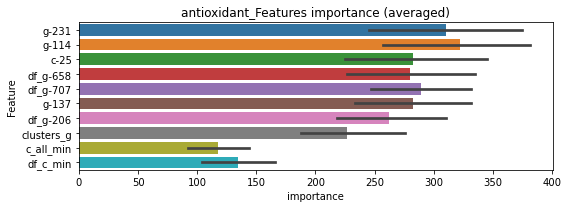

len(train_index) : 3788
len(valid_index) : 3789
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364249	valid_1's binary_logloss: 0.0482621
[200]	training's binary_logloss: 0.0118429	valid_1's binary_logloss: 0.0278279
[300]	training's binary_logloss: 0.0050867	valid_1's binary_logloss: 0.0221662
[400]	training's binary_logloss: 0.00260346	valid_1's binary_logloss: 0.0192751


len(train_index) : 3789
len(valid_index) : 3788


Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00236098	valid_1's binary_logloss: 0.0190061


================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311527	valid_1's binary_logloss: 0.0646
[200]	training's binary_logloss: 0.00920727	valid_1's binary_logloss: 0.0448743
[300]	training's binary_logloss: 0.00375754	valid_1's binary_logloss: 0.039212


antioxidant logloss: 0.02865182382671971


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00318059	valid_1's binary_logloss: 0.0383001


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373351	valid_1's binary_logloss: 0.0623613
[200]	training's binary_logloss: 0.00587194	valid_1's binary_logloss: 0.0210588
[300]	training's binary_logloss: 0.00163002	valid_1's binary_logloss: 0.011655
[400]	training's binary_logloss: 0.000789063	valid_1's binary_logloss: 0.00877978
[500]	training's binary_logloss: 0.000522509	valid_1's binary_logloss: 0.00769029
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000482864	valid_1's binary_logloss: 0.00749091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391138	valid_1's binary_logloss: 0.062141
[200]	training's binary_logloss: 0.00646413	valid_1's binary_logloss: 0.0198734
[300]	training's binary_logloss: 0.00176183	valid_1's binary_logloss: 0.010624
[400]	training's binary_logloss: 0.000831109	valid_1's binary_logloss: 0.00793742
[500]	training's binary_logloss: 0.00054

1 / 3 AUC score:1.000
y_Threshold: 0.0037881, Threshold: 0.0065466, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00589, conf_1:0.00720
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0065466
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.0165466
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0265466
threshold: 0.0265466, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375886	valid_1's binary_logloss: 0.0638723
[200]	training's binary_logloss: 0.0057909	valid_1's binary_logloss: 0.021038
[300]	training's binary_logloss: 0.00163095	valid_1's binary_logloss: 0.0118722
[400]	training's binary_logloss: 0.000787433	valid_1's binary_logloss: 0.00853172
[500]	training's binary_logloss: 0.000514449	valid_1's binary_logloss: 0.00738158
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000458537	valid_1's binary_logloss: 0.00714916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372908	valid_1's binary_logloss: 0.0602908
[200]	training's binary_logloss: 0.00580796	valid_1's binary_logloss: 0.0166403
[300]	training's binary_logloss: 0.00165043	valid_1's binary_logloss: 0.00890118
[400]	training's binary_logloss: 0.000798676	valid_1's binary_logloss: 0.00662523
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0346082, Threshold: 0.0265466, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0075339 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.02389, conf_1:0.02920
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.0265466
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0365466
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.0465466
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0565466
threshold: 0.0565466, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375886	valid_1's binary_logloss: 0.0638723
[200]	training's binary_logloss: 0.0057909	valid_1's binary_logloss: 0.021038
[300]	training's binary_logloss: 0.00163095	valid_1's binary_logloss: 0.0118722
[400]	training's binary_logloss: 0.000787433	valid_1's binary_logloss: 0.00853172
[500]	training's binary_logloss: 0.000514449	valid_1's binary_logloss: 0.00738158
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000458537	valid_1's binary_logloss: 0.00714916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372908	valid_1's binary_logloss: 0.0602908
[200]	training's binary_logloss: 0.00580796	valid_1's binary_logloss: 0.0166403
[300]	training's binary_logloss: 0.00165043	valid_1's binary_logloss: 0.00890118
[400]	training's binary_logloss: 0.000798676	valid_1's binary_logloss: 0.00662523
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0346082, Threshold: 0.0565466, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.05089, conf_1:0.06220
threshold: 0.0565466, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


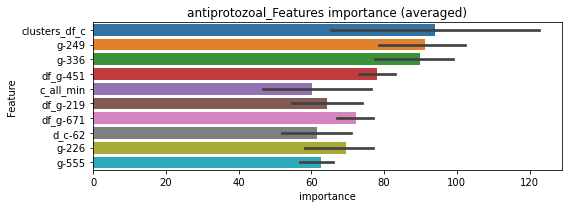

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210318	valid_1's binary_logloss: 0.0355547
[200]	training's binary_logloss: 0.00333464	valid_1's binary_logloss: 0.0128615
[300]	training's binary_logloss: 0.000898323	valid_1's binary_logloss: 0.00913958
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000560384	valid_1's binary_logloss: 0.00865117


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217307	valid_1's binary_logloss: 0.0380832
[200]	training's binary_logloss: 0.00346748	valid_1's binary_logloss: 0.0139994
[300]	training's binary_logloss: 0.000954949	valid_1's binary_logloss: 0.00859036
[400]	training's binary_logloss: 0.000444234	valid_1's binary_logloss: 0.00694519
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000297786	valid_1's binary_logloss: 0.00638558


antiprotozoal logloss: 0.007518522564208731
antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285907	valid_1's binary_logloss: 0.042685
[200]	training's binary_logloss: 0.0037525	valid_1's binary_logloss: 0.00945084
[300]	training's binary_logloss: 0.00105348	valid_1's binary_logloss: 0.00405555
[400]	training's binary_logloss: 0.000524083	valid_1's binary_logloss: 0.00264653
[500]	training's binary_logloss: 0.000382352	valid_1's binary_logloss: 0.00223584
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000374258	valid_1's binary_logloss: 0.00221442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288502	valid_1's binary_logloss: 0.0381817
[200]	training's binary_logloss: 0.00382848	valid_1's binary_logloss: 0.00712629
[300]	training's binary_logloss: 0.00106311	valid_1's binary_logloss: 0.00252231
[400]	training's binary_logloss: 0.000535919	valid_1's binary_logloss: 0.00142835
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0024437, Threshold: 0.0034895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097, Num_p_label: 80.0, conf_0:0.00314, conf_1:0.00384
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0034895
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_2: 0.0134895
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_3: 0.0234895
threshold: 0.0234895, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283296	valid_1's binary_logloss: 0.0405419
[200]	training's binary_logloss: 0.00362139	valid_1's binary_logloss: 0.00765695
[300]	training's binary_logloss: 0.00102149	valid_1's binary_logloss: 0.00299322
[400]	training's binary_logloss: 0.000512005	valid_1's binary_logloss: 0.00182078
[500]	training's binary_logloss: 0.000380674	valid_1's binary_logloss: 0.00149706
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000371241	valid_1's binary_logloss: 0.00147482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284186	valid_1's binary_logloss: 0.0366868
[200]	training's binary_logloss: 0.00362302	valid_1's binary_logloss: 0.00619536
[300]	training's binary_logloss: 0.00101178	valid_1's binary_logloss: 0.00207756
[400]	training's binary_logloss: 0.0005096	valid_1's binary_logloss: 0.0011803
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1380791, Threshold: 0.0234895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0035158 Vs.target_rate: 0.00097, Num_p_label: 14.0, conf_0:0.02114, conf_1:0.02584
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_1: 0.0234895
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_2: 0.0334895
threshold: 0.0334895, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283296	valid_1's binary_logloss: 0.0405419
[200]	training's binary_logloss: 0.00362139	valid_1's binary_logloss: 0.00765695
[300]	training's binary_logloss: 0.00102149	valid_1's binary_logloss: 0.00299322
[400]	training's binary_logloss: 0.000512005	valid_1's binary_logloss: 0.00182078
[500]	training's binary_logloss: 0.000380674	valid_1's binary_logloss: 0.00149706
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000371241	valid_1's binary_logloss: 0.00147482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284186	valid_1's binary_logloss: 0.0366868
[200]	training's binary_logloss: 0.00362302	valid_1's binary_logloss: 0.00619536
[300]	training's binary_logloss: 0.00101178	valid_1's binary_logloss: 0.00207756
[400]	training's binary_logloss: 0.0005096	valid_1's binary_logloss: 0.0011803
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1380791, Threshold: 0.0334895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00097, Num_p_label: 6.0, conf_0:0.03014, conf_1:0.03684
threshold: 0.0334895, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


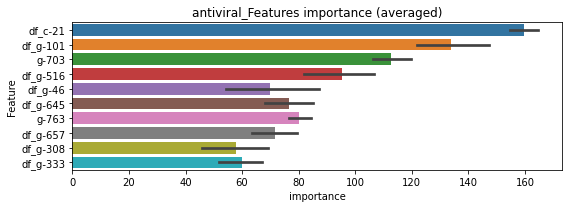

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146981	valid_1's binary_logloss: 0.0236367
[200]	training's binary_logloss: 0.00188103	valid_1's binary_logloss: 0.00755888
[300]	training's binary_logloss: 0.000512429	valid_1's binary_logloss: 0.0057304
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000441435	valid_1's binary_logloss: 0.00561633


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152052	valid_1's binary_logloss: 0.0258142
[200]	training's binary_logloss: 0.00196483	valid_1's binary_logloss: 0.00709596
[300]	training's binary_logloss: 0.000547558	valid_1's binary_logloss: 0.00397349
[400]	training's binary_logloss: 0.000275125	valid_1's binary_logloss: 0.00322495
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000230945	valid_1's binary_logloss: 0.00306561


antiviral logloss: 0.004341132885529438
apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461082	valid_1's binary_logloss: 0.0821018
[200]	training's binary_logloss: 0.00813073	valid_1's binary_logloss: 0.0333774
[300]	training's binary_logloss: 0.0023114	valid_1's binary_logloss: 0.0227489
[400]	training's binary_logloss: 0.00109497	valid_1's binary_logloss: 0.0194378
[500]	training's binary_logloss: 0.000691997	valid_1's binary_logloss: 0.0181107
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000708592	valid_1's binary_logloss: 0.0180624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452334	valid_1's binary_logloss: 0.0698605
[200]	training's binary_logloss: 0.00819559	valid_1's binary_logloss: 0.0236125
[300]	training's binary_logloss: 0.00237894	valid_1's binary_logloss: 0.0132563
[400]	training's binary_logloss: 0.00113704	valid_1's binary_logloss: 0.0105795
[500]	training's binary_logloss: 0.000723438

1 / 3 AUC score:1.000
y_Threshold: 0.0044097, Threshold: 0.0597721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206, Num_p_label: 80.0, conf_0:0.05379, conf_1:0.06575
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0597721
Num_p_label: 76.0, Expected: 8.2, Adj_threshold_2: 0.0697721
Num_p_label: 75.0, Expected: 8.2, Adj_threshold_3: 0.0797721
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_4: 0.0897721
Num_p_label: 68.0, Expected: 8.2, Adj_threshold_5: 0.0997721
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_6: 0.1097721
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_7: 0.1197721
Num_p_label: 62.0, Expected: 8.2, Adj_threshold_8: 0.1297721
Num_p_label: 59.0, Expected: 8.2, Adj_threshold_9: 0.1397721
Num_p_label: 55.0, Expected: 8.2, Adj_threshold_10: 0.1497721
threshold: 0.1597721, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425904	valid_1's binary_logloss: 0.0738926
[200]	training's binary_logloss: 0.00743147	valid_1's binary_logloss: 0.0279496
[300]	training's binary_logloss: 0.00216214	valid_1's binary_logloss: 0.0181878
[400]	training's binary_logloss: 0.0010423	valid_1's binary_logloss: 0.0150892
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000938158	valid_1's binary_logloss: 0.0148695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044266	valid_1's binary_logloss: 0.0678734
[200]	training's binary_logloss: 0.00772603	valid_1's binary_logloss: 0.0222958
[300]	training's binary_logloss: 0.00225514	valid_1's binary_logloss: 0.0132418
[400]	training's binary_logloss: 0.0010793	valid_1's binary_logloss: 0.0104719
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0011047	valid_1's binary_logloss: 0.0104225


2 / 3 AUC score:1.000
y_Threshold: 0.0600060, Threshold: 0.1597721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0286288 Vs.target_rate: 0.00206, Num_p_label: 114.0, conf_0:0.14379, conf_1:0.17575
Num_p_label: 114.0, Expected: 8.2, Adj_threshold_1: 0.1597721
Num_p_label: 113.0, Expected: 8.2, Adj_threshold_2: 0.1697721
Num_p_label: 113.0, Expected: 8.2, Adj_threshold_3: 0.1797721
Num_p_label: 109.0, Expected: 8.2, Adj_threshold_4: 0.1897721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_5: 0.1997721
Num_p_label: 104.0, Expected: 8.2, Adj_threshold_6: 0.2097721
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_7: 0.2197721
Num_p_label: 101.0, Expected: 8.2, Adj_threshold_8: 0.2297721
Num_p_label: 100.0, Expected: 8.2, Adj_threshold_9: 0.2397721
Num_p_label: 100.0, Expected: 8.2, Adj_threshold_10: 0.2497721
threshold: 0.2597721, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 652.0/3797, y_label_rate: 0.17171

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437741	valid_1's binary_logloss: 0.0651912
[200]	training's binary_logloss: 0.00746747	valid_1's binary_logloss: 0.0197244
[300]	training's binary_logloss: 0.0021508	valid_1's binary_logloss: 0.00997622
[400]	training's binary_logloss: 0.00103774	valid_1's binary_logloss: 0.00727846
[500]	training's binary_logloss: 0.00066704	valid_1's binary_logloss: 0.00601104
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000567102	valid_1's binary_logloss: 0.00575111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435686	valid_1's binary_logloss: 0.0733018
[200]	training's binary_logloss: 0.00753871	valid_1's binary_logloss: 0.0252252
[300]	training's binary_logloss: 0.00213089	valid_1's binary_logloss: 0.015997
[400]	training's binary_logloss: 0.00102873	valid_1's binary_logloss: 0.0140561
[500]	training's binary_logloss: 0.0006668

3 / 3 AUC score:1.000
y_Threshold: 0.0588774, Threshold: 0.2597721, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0278754 Vs.target_rate: 0.00206, Num_p_label: 111.0, conf_0:0.23379, conf_1:0.28575
Num_p_label: 111.0, Expected: 8.2, Adj_threshold_1: 0.2597721
Num_p_label: 110.0, Expected: 8.2, Adj_threshold_2: 0.2697721
Num_p_label: 110.0, Expected: 8.2, Adj_threshold_3: 0.2797721
Num_p_label: 109.0, Expected: 8.2, Adj_threshold_4: 0.2897721
Num_p_label: 107.0, Expected: 8.2, Adj_threshold_5: 0.2997721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_6: 0.3097721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_7: 0.3197721
Num_p_label: 106.0, Expected: 8.2, Adj_threshold_8: 0.3297721
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_9: 0.3397721
Num_p_label: 102.0, Expected: 8.2, Adj_threshold_10: 0.3497721
threshold: 0.3597721, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 752.0/7777, y_label_rate: 0.0966

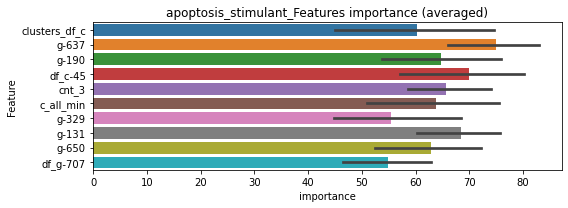

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261695	valid_1's binary_logloss: 0.0494723
[200]	training's binary_logloss: 0.00435324	valid_1's binary_logloss: 0.0227658
[300]	training's binary_logloss: 0.00123819	valid_1's binary_logloss: 0.0168817
[400]	training's binary_logloss: 0.000573751	valid_1's binary_logloss: 0.014845
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000570747	valid_1's binary_logloss: 0.0148342


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261637	valid_1's binary_logloss: 0.0434672
[200]	training's binary_logloss: 0.00461548	valid_1's binary_logloss: 0.0167617
[300]	training's binary_logloss: 0.0012899	valid_1's binary_logloss: 0.0104654
[400]	training's binary_logloss: 0.000601683	valid_1's binary_logloss: 0.00871768
[500]	training's binary_logloss: 0.000380738	valid_1's binary_logloss: 0.00800613
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000338899	valid_1's binary_logloss: 0.00787656


apoptosis_stimulant logloss: 0.011355850384954869
aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406845	valid_1's binary_logloss: 0.0758727
[200]	training's binary_logloss: 0.00773354	valid_1's binary_logloss: 0.029727
[300]	training's binary_logloss: 0.0021641	valid_1's binary_logloss: 0.0177952
[400]	training's binary_logloss: 0.00102489	valid_1's binary_logloss: 0.0145147
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000688948	valid_1's binary_logloss: 0.0129038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452314	valid_1's binary_logloss: 0.0709088
[200]	training's binary_logloss: 0.0083077	valid_1's binary_logloss: 0.0237284
[300]	training's binary_logloss: 0.00239198	valid_1's binary_logloss: 0.0115692
[400]	training's binary_logloss: 0.00111295	valid_1's binary_logloss: 0.00803763
[500]	training's binary_logloss: 0.000713462	valid_1's binary_logloss: 0.00665235
[600]	training's binary_logloss: 0.000563153

1 / 3 AUC score:1.000
y_Threshold: 0.0043927, Threshold: 0.0070225, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197, Num_p_label: 80.0, conf_0:0.00632, conf_1:0.00772
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0070225
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_2: 0.0170225
threshold: 0.0170225, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430005	valid_1's binary_logloss: 0.0732529
[200]	training's binary_logloss: 0.00795312	valid_1's binary_logloss: 0.02643
[300]	training's binary_logloss: 0.00226734	valid_1's binary_logloss: 0.015034
[400]	training's binary_logloss: 0.00105626	valid_1's binary_logloss: 0.012017
[500]	training's binary_logloss: 0.000678938	valid_1's binary_logloss: 0.0107589
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000684368	valid_1's binary_logloss: 0.010739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436943	valid_1's binary_logloss: 0.0679311
[200]	training's binary_logloss: 0.00788155	valid_1's binary_logloss: 0.0219034
[300]	training's binary_logloss: 0.00230325	valid_1's binary_logloss: 0.0109989
[400]	training's binary_logloss: 0.00108114	valid_1's binary_logloss: 0.00753757
[500]	training's binary_logloss: 0.000693809	va

2 / 3 AUC score:1.000
y_Threshold: 0.0587923, Threshold: 0.0170225, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00197, Num_p_label: 33.0, conf_0:0.01532, conf_1:0.01872
Num_p_label: 33.0, Expected: 7.9, Adj_threshold_1: 0.0170225
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_2: 0.0270225
Num_p_label: 9.0, Expected: 7.9, Adj_threshold_3: 0.0370225
threshold: 0.0370225, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430005	valid_1's binary_logloss: 0.0732529
[200]	training's binary_logloss: 0.00795312	valid_1's binary_logloss: 0.02643
[300]	training's binary_logloss: 0.00226734	valid_1's binary_logloss: 0.015034
[400]	training's binary_logloss: 0.00105626	valid_1's binary_logloss: 0.012017
[500]	training's binary_logloss: 0.000678938	valid_1's binary_logloss: 0.0107589
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000684368	valid_1's binary_logloss: 0.010739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436943	valid_1's binary_logloss: 0.0679311
[200]	training's binary_logloss: 0.00788155	valid_1's binary_logloss: 0.0219034
[300]	training's binary_logloss: 0.00230325	valid_1's binary_logloss: 0.0109989
[400]	training's binary_logloss: 0.00108114	valid_1's binary_logloss: 0.00753757
[500]	training's binary_logloss: 0.000693809	va

3 / 3 AUC score:1.000
y_Threshold: 0.0587923, Threshold: 0.0370225, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0022602 Vs.target_rate: 0.00197, Num_p_label: 9.0, conf_0:0.03332, conf_1:0.04072
threshold: 0.0370225, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


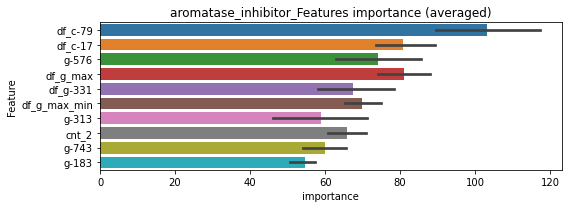

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239775	valid_1's binary_logloss: 0.0502964
[200]	training's binary_logloss: 0.00428179	valid_1's binary_logloss: 0.0253033
[300]	training's binary_logloss: 0.00118578	valid_1's binary_logloss: 0.0200272
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000611839	valid_1's binary_logloss: 0.0188016


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261294	valid_1's binary_logloss: 0.0445333
[200]	training's binary_logloss: 0.00490002	valid_1's binary_logloss: 0.0176857
[300]	training's binary_logloss: 0.00136239	valid_1's binary_logloss: 0.0106516
[400]	training's binary_logloss: 0.000606443	valid_1's binary_logloss: 0.00865407
[500]	training's binary_logloss: 0.000380374	valid_1's binary_logloss: 0.00799638
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00039042	valid_1's binary_logloss: 0.00798019


aromatase_inhibitor logloss: 0.013391602534183387
atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154849	valid_1's binary_logloss: 0.0163362
[200]	training's binary_logloss: 0.0012447	valid_1's binary_logloss: 0.00149367
[300]	training's binary_logloss: 0.000336773	valid_1's binary_logloss: 0.00048534
[400]	training's binary_logloss: 0.000211829	valid_1's binary_logloss: 0.000317092
[500]	training's binary_logloss: 0.000187643	valid_1's binary_logloss: 0.000282582
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000185609	valid_1's binary_logloss: 0.000279417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01548	valid_1's binary_logloss: 0.0177869
[200]	training's binary_logloss: 0.00123062	valid_1's binary_logloss: 0.00247911
[300]	training's binary_logloss: 0.000330413	valid_1's binary_logloss: 0.00144612
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000325589	valid_1's binary_logloss: 0.00143

1 / 3 AUC score:1.000
y_Threshold: 0.0009508, Threshold: 0.0017579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00158, conf_1:0.00193
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0017579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0117579
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0217579
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0317579
threshold: 0.0317579, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015893	valid_1's binary_logloss: 0.0163354
[200]	training's binary_logloss: 0.00124295	valid_1's binary_logloss: 0.00134093
[300]	training's binary_logloss: 0.000319151	valid_1's binary_logloss: 0.000367726
[400]	training's binary_logloss: 0.000201508	valid_1's binary_logloss: 0.000238929
[500]	training's binary_logloss: 0.000180301	valid_1's binary_logloss: 0.000213799
[600]	training's binary_logloss: 0.000175492	valid_1's binary_logloss: 0.000207944
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00017432	valid_1's binary_logloss: 0.000206556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158954	valid_1's binary_logloss: 0.0163483
[200]	training's binary_logloss: 0.00124821	valid_1's binary_logloss: 0.0013381
[300]	training's binary_logloss: 0.000320717	valid_1's binary_logloss: 0.000367252
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1806944, Threshold: 0.0317579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0055249 Vs.target_rate: 0.00025, Num_p_label: 22.0, conf_0:0.02858, conf_1:0.03493
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_1: 0.0317579
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_2: 0.0417579
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.0517579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.0617579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_5: 0.0717579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.0817579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_7: 0.0917579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.1017579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_9: 0.1117579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_10: 0.1217579
threshold: 0.1317579, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015893	valid_1's binary_logloss: 0.0163354
[200]	training's binary_logloss: 0.00124295	valid_1's binary_logloss: 0.00134093
[300]	training's binary_logloss: 0.000319151	valid_1's binary_logloss: 0.000367726
[400]	training's binary_logloss: 0.000201508	valid_1's binary_logloss: 0.000238929
[500]	training's binary_logloss: 0.000180301	valid_1's binary_logloss: 0.000213799
[600]	training's binary_logloss: 0.000175492	valid_1's binary_logloss: 0.000207944
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00017432	valid_1's binary_logloss: 0.000206556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158954	valid_1's binary_logloss: 0.0163483
[200]	training's binary_logloss: 0.00124821	valid_1's binary_logloss: 0.0013381
[300]	training's binary_logloss: 0.000320717	valid_1's binary_logloss: 0.000367252
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1806944, Threshold: 0.1317579, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[759]	training's binary_logloss: 0.000171307	valid_1's binary_logloss: 0.000205041


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.11858, conf_1:0.14493
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.1317579
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.1417579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.1517579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.1617579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.1717579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_6: 0.1817579
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.1917579
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.2017579
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_9: 0.2117579
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_10: 0.2217579
threshold: 0.2317579, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


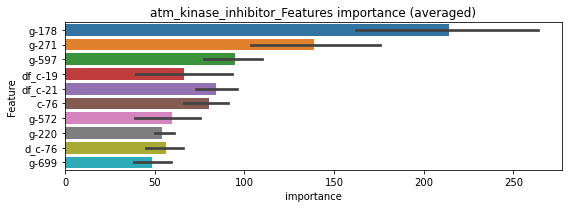

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00846621	valid_1's binary_logloss: 0.0117204
[200]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.00397055


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000215357	valid_1's binary_logloss: 0.00349545


================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0086692	valid_1's binary_logloss: 0.00918277
[200]	training's binary_logloss: 0.000718524	valid_1's binary_logloss: 0.00125994
[300]	training's binary_logloss: 0.000188155	valid_1's binary_logloss: 0.000684666


atm_kinase_inhibitor logloss: 0.002079413991899802


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000144774	valid_1's binary_logloss: 0.000663012


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162418	valid_1's binary_logloss: 0.0175188
[200]	training's binary_logloss: 0.00142071	valid_1's binary_logloss: 0.00188671
[300]	training's binary_logloss: 0.000397353	valid_1's binary_logloss: 0.000681838
[400]	training's binary_logloss: 0.000240006	valid_1's binary_logloss: 0.000441028
[500]	training's binary_logloss: 0.000213967	valid_1's binary_logloss: 0.00039763
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000213967	valid_1's binary_logloss: 0.00039763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016573	valid_1's binary_logloss: 0.0177749
[200]	training's binary_logloss: 0.00144731	valid_1's binary_logloss: 0.00172533
[300]	training's binary_logloss: 0.000399107	valid_1's binary_logloss: 0.000528809
[400]	training's binary_logloss: 0.000239286	valid_1's binary_logloss: 0.000330861
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006719, Threshold: 0.0009772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00088, conf_1:0.00107
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009772
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0109772
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.0209772
threshold: 0.0209772, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016465	valid_1's binary_logloss: 0.0174452
[200]	training's binary_logloss: 0.00139693	valid_1's binary_logloss: 0.00166799
[300]	training's binary_logloss: 0.000382445	valid_1's binary_logloss: 0.000520727
[400]	training's binary_logloss: 0.000236176	valid_1's binary_logloss: 0.000334001
[500]	training's binary_logloss: 0.000207947	valid_1's binary_logloss: 0.000296815
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000204436	valid_1's binary_logloss: 0.000292139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167052	valid_1's binary_logloss: 0.0176189
[200]	training's binary_logloss: 0.00141336	valid_1's binary_logloss: 0.00159213
[300]	training's binary_logloss: 0.000384388	valid_1's binary_logloss: 0.000462299
[400]	training's binary_logloss: 0.000234961	valid_1's binary_logloss: 0.00028613
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1689024, Threshold: 0.0209772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00029, Num_p_label: 15.0, conf_0:0.01888, conf_1:0.02307
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_1: 0.0209772
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_2: 0.0309772
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.0409772
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0509772
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0609772
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.0709772
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_7: 0.0809772
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.0909772
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_9: 0.1009772
threshold: 0.1009772, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016465	valid_1's binary_logloss: 0.0174452
[200]	training's binary_logloss: 0.00139693	valid_1's binary_logloss: 0.00166799
[300]	training's binary_logloss: 0.000382445	valid_1's binary_logloss: 0.000520727
[400]	training's binary_logloss: 0.000236176	valid_1's binary_logloss: 0.000334001
[500]	training's binary_logloss: 0.000207947	valid_1's binary_logloss: 0.000296815
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000204436	valid_1's binary_logloss: 0.000292139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167052	valid_1's binary_logloss: 0.0176189
[200]	training's binary_logloss: 0.00141336	valid_1's binary_logloss: 0.00159213
[300]	training's binary_logloss: 0.000384388	valid_1's binary_logloss: 0.000462299
[400]	training's binary_logloss: 0.000234961	valid_1's binary_logloss: 0.00028613
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1689024, Threshold: 0.1009772, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.09088, conf_1:0.11107
threshold: 0.1009772, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


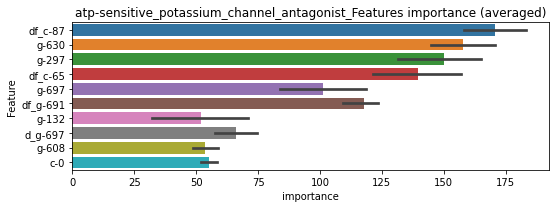

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00877235	valid_1's binary_logloss: 0.0102299
[200]	training's binary_logloss: 0.000733096	valid_1's binary_logloss: 0.00165152
[300]	training's binary_logloss: 0.000200396	valid_1's binary_logloss: 0.00104473
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000185383	valid_1's binary_logloss: 0.00102433


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0087148	valid_1's binary_logloss: 0.0101087
[200]	training's binary_logloss: 0.00071754	valid_1's binary_logloss: 0.00198766


atp-sensitive_potassium_channel_antagonist logloss: 0.0012617047697387996


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00022	valid_1's binary_logloss: 0.00149908


atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153452	valid_1's binary_logloss: 0.0184078
[200]	training's binary_logloss: 0.00118019	valid_1's binary_logloss: 0.00352018
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000428038	valid_1's binary_logloss: 0.00268616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157726	valid_1's binary_logloss: 0.0160365
[200]	training's binary_logloss: 0.00126413	valid_1's binary_logloss: 0.00173993
[300]	training's binary_logloss: 0.000325139	valid_1's binary_logloss: 0.000799452
[400]	training's binary_logloss: 0.000204275	valid_1's binary_logloss: 0.000625839
[500]	training's binary_logloss: 0.000181083	valid_1's binary_logloss: 0.00059839
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000175983	valid_1's binary_logloss: 0.000587644


1 / 3 AUC score:1.000
y_Threshold: 0.0007767, Threshold: 0.0020764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00187, conf_1:0.00228
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020764
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.0120764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.0220764
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.0320764
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.0420764
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.0520764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.0620764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.0720764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.0820764
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.0920764
threshold: 0.1020764, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015705	valid_1's binary_logloss: 0.016577
[200]	training's binary_logloss: 0.00117149	valid_1's binary_logloss: 0.00142357
[300]	training's binary_logloss: 0.000273844	valid_1's binary_logloss: 0.000372877
[400]	training's binary_logloss: 0.000175421	valid_1's binary_logloss: 0.000250602
[500]	training's binary_logloss: 0.00015628	valid_1's binary_logloss: 0.000225205
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000152932	valid_1's binary_logloss: 0.000220493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154995	valid_1's binary_logloss: 0.0154916
[200]	training's binary_logloss: 0.00113779	valid_1's binary_logloss: 0.00117599
[300]	training's binary_logloss: 0.000268194	valid_1's binary_logloss: 0.000299932
[400]	training's binary_logloss: 0.000173387	valid_1's binary_logloss: 0.00020123
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1955810, Threshold: 0.1020764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.09187, conf_1:0.11228
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.1020764
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_2: 0.1120764
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.1220764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_4: 0.1320764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_5: 0.1420764
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_6: 0.1520764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_7: 0.1620764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_8: 0.1720764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_9: 0.1820764
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_10: 0.1920764
threshold: 0.2020764, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015705	valid_1's binary_logloss: 0.016577
[200]	training's binary_logloss: 0.00117149	valid_1's binary_logloss: 0.00142357
[300]	training's binary_logloss: 0.000273844	valid_1's binary_logloss: 0.000372877
[400]	training's binary_logloss: 0.000175421	valid_1's binary_logloss: 0.000250602
[500]	training's binary_logloss: 0.00015628	valid_1's binary_logloss: 0.000225205
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000152932	valid_1's binary_logloss: 0.000220493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154995	valid_1's binary_logloss: 0.0154916
[200]	training's binary_logloss: 0.00113779	valid_1's binary_logloss: 0.00117599
[300]	training's binary_logloss: 0.000268194	valid_1's binary_logloss: 0.000299932
[400]	training's binary_logloss: 0.000173387	valid_1's binary_logloss: 0.00020123
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1955810, Threshold: 0.2020764, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0032647 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.18187, conf_1:0.22228
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.2020764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.2120764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.2220764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.2320764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.2420764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.2520764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.2620764
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.2720764
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.2820764
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_10: 0.2920764
threshold: 0.3020764, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7794, y_label_rate: 0.0858353


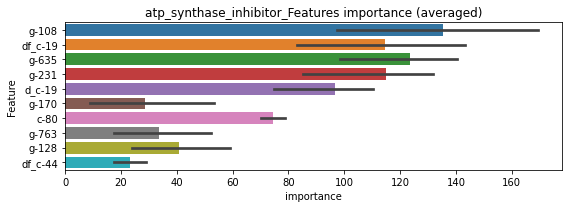

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00867322	valid_1's binary_logloss: 0.011447
[200]	training's binary_logloss: 0.000696203	valid_1's binary_logloss: 0.00304984
[300]	training's binary_logloss: 0.00017159	valid_1's binary_logloss: 0.00236475
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000163314	valid_1's binary_logloss: 0.00235291


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00876393	valid_1's binary_logloss: 0.00995771
[200]	training's binary_logloss: 0.00069795	valid_1's binary_logloss: 0.00208209


atp_synthase_inhibitor logloss: 0.002018025745025025


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000194132	valid_1's binary_logloss: 0.00168315


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130406	valid_1's binary_logloss: 0.201617
[200]	training's binary_logloss: 0.0662048	valid_1's binary_logloss: 0.163517
[300]	training's binary_logloss: 0.0343255	valid_1's binary_logloss: 0.146527
[400]	training's binary_logloss: 0.0190811	valid_1's binary_logloss: 0.140551
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0190811	valid_1's binary_logloss: 0.140551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128481	valid_1's binary_logloss: 0.213745
[200]	training's binary_logloss: 0.0670529	valid_1's binary_logloss: 0.1777
[300]	training's binary_logloss: 0.0334334	valid_1's binary_logloss: 0.163373
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0329435	valid_1's binary_logloss: 0.162963


1 / 3 AUC score:0.972
y_Threshold: 0.1800221, Threshold: 0.4839374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 282 → Positive_corect_labels: 579/3645
p_label_rate: 0.0200904 Vs.target_rate: 0.00407, Num_p_label: 80.0, conf_0:0.43554, conf_1:0.53233
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.4839374
Num_p_label: 76.0, Expected: 16.2, Adj_threshold_2: 0.4939374
Num_p_label: 72.0, Expected: 16.2, Adj_threshold_3: 0.5039374
Num_p_label: 68.0, Expected: 16.2, Adj_threshold_4: 0.5139374
Num_p_label: 64.0, Expected: 16.2, Adj_threshold_5: 0.5239374
Num_p_label: 61.0, Expected: 16.2, Adj_threshold_6: 0.5339374
Num_p_label: 59.0, Expected: 16.2, Adj_threshold_7: 0.5439374
Num_p_label: 56.0, Expected: 16.2, Adj_threshold_8: 0.5539374
Num_p_label: 51.0, Expected: 16.2, Adj_threshold_9: 0.5639374
Num_p_label: 50.0, Expected: 16.2, Adj_threshold_10: 0.5739374
threshold: 0.5839374, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 579.0/3645, y_label_rate: 0.158847

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821977	valid_1's binary_logloss: 0.141384
[200]	training's binary_logloss: 0.0314598	valid_1's binary_logloss: 0.0974402
[300]	training's binary_logloss: 0.013787	valid_1's binary_logloss: 0.0818781
[400]	training's binary_logloss: 0.00691108	valid_1's binary_logloss: 0.0759503
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00651406	valid_1's binary_logloss: 0.075347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823163	valid_1's binary_logloss: 0.148388
[200]	training's binary_logloss: 0.0322083	valid_1's binary_logloss: 0.108775
[300]	training's binary_logloss: 0.0138262	valid_1's binary_logloss: 0.0932422


2 / 3 AUC score:0.989
y_Threshold: 0.2472208, Threshold: 0.5839374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 531.0/3549
p_label_rate: 0.0286288 Vs.target_rate: 0.00407, Num_p_label: 114.0, conf_0:0.52554, conf_1:0.64233
Num_p_label: 114.0, Expected: 16.2, Adj_threshold_1: 0.5839374
Num_p_label: 112.0, Expected: 16.2, Adj_threshold_2: 0.5939374
Num_p_label: 109.0, Expected: 16.2, Adj_threshold_3: 0.6039374
Num_p_label: 106.0, Expected: 16.2, Adj_threshold_4: 0.6139374
Num_p_label: 105.0, Expected: 16.2, Adj_threshold_5: 0.6239374
Num_p_label: 104.0, Expected: 16.2, Adj_threshold_6: 0.6339374
Num_p_label: 99.0, Expected: 16.2, Adj_threshold_7: 0.6439374
Num_p_label: 94.0, Expected: 16.2, Adj_threshold_8: 0.6539374
Num_p_label: 88.0, Expected: 16.2, Adj_threshold_9: 0.6639374


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0100195	valid_1's binary_logloss: 0.0903941


Num_p_label: 87.0, Expected: 16.2, Adj_threshold_10: 0.6739374
threshold: 0.6839374, positive_p_label: 81.0/3982, p_label_rate: 0.0203415
positive_y_label: 531.0/3549, y_label_rate: 0.1496196
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590602	valid_1's binary_logloss: 0.125488
[200]	training's binary_logloss: 0.0181118	valid_1's binary_logloss: 0.0871421
[300]	training's binary_logloss: 0.00729338	valid_1's binary_logloss: 0.078107
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00652131	valid_1's binary_logloss: 0.077573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063628	valid_1's binary_logloss: 0.108423
[200]	training's binary_logloss: 0.0197321	valid_1's binary_logloss: 0.0682821
[300]	training's binary_logloss: 0.00813054	valid_1's binary_logloss: 0.0587645


3 / 3 AUC score:0.991
y_Threshold: 0.2382544, Threshold: 0.6839374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 494.0/3475
p_label_rate: 0.0248619 Vs.target_rate: 0.00407, Num_p_label: 99.0, conf_0:0.61554, conf_1:0.75233
Num_p_label: 99.0, Expected: 16.2, Adj_threshold_1: 0.6839374
Num_p_label: 95.0, Expected: 16.2, Adj_threshold_2: 0.6939374
Num_p_label: 93.0, Expected: 16.2, Adj_threshold_3: 0.7039374
Num_p_label: 92.0, Expected: 16.2, Adj_threshold_4: 0.7139374
Num_p_label: 91.0, Expected: 16.2, Adj_threshold_5: 0.7239374
Num_p_label: 90.0, Expected: 16.2, Adj_threshold_6: 0.7339374
Num_p_label: 89.0, Expected: 16.2, Adj_threshold_7: 0.7439374
Num_p_label: 86.0, Expected: 16.2, Adj_threshold_8: 0.7539374


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00586699	valid_1's binary_logloss: 0.0559275


Num_p_label: 82.0, Expected: 16.2, Adj_threshold_9: 0.7639374
Num_p_label: 79.0, Expected: 16.2, Adj_threshold_10: 0.7739374
threshold: 0.7839374, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 570.0/7457, y_label_rate: 0.0764382


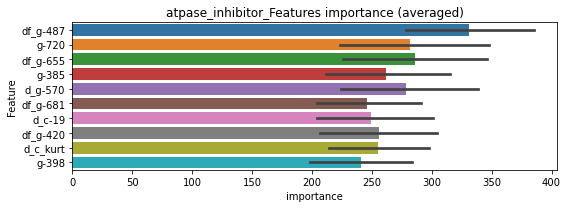

len(train_index) : 3728
len(valid_index) : 3729
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342476	valid_1's binary_logloss: 0.0667165
[200]	training's binary_logloss: 0.0109706	valid_1's binary_logloss: 0.0486934
[300]	training's binary_logloss: 0.00464835	valid_1's binary_logloss: 0.0441619
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00296386	valid_1's binary_logloss: 0.0430803


len(train_index) : 3729
len(valid_index) : 3728
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366999	valid_1's binary_logloss: 0.0688608
[200]	training's binary_logloss: 0.0116034	valid_1's binary_logloss: 0.049595


atpase_inhibitor logloss: 0.04298017388143222


[300]	training's binary_logloss: 0.00491474	valid_1's binary_logloss: 0.0428801
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00491474	valid_1's binary_logloss: 0.0428801


atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195478	valid_1's binary_logloss: 0.0274262
[200]	training's binary_logloss: 0.00199922	valid_1's binary_logloss: 0.0059254
[300]	training's binary_logloss: 0.00057331	valid_1's binary_logloss: 0.0032484
[400]	training's binary_logloss: 0.000325733	valid_1's binary_logloss: 0.00259737
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000280797	valid_1's binary_logloss: 0.00244198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197902	valid_1's binary_logloss: 0.0248769
[200]	training's binary_logloss: 0.00202973	valid_1's binary_logloss: 0.00450014
[300]	training's binary_logloss: 0.000579329	valid_1's binary_logloss: 0.00205731
[400]	training's binary_logloss: 0.000335052	valid_1's binary_logloss: 0.00145935
[500]	training's binary_logloss: 0.000284992	valid_1's binary_logloss: 0.00135165
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0017642, Threshold: 0.0043756, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00394, conf_1:0.00481
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0043756
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_2: 0.0143756
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_3: 0.0243756
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_4: 0.0343756
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_5: 0.0443756
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.0543756
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_7: 0.0643756
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.0743756
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.0843756
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_10: 0.0943756
threshold: 0.1043756, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195214	valid_1's binary_logloss: 0.0250214
[200]	training's binary_logloss: 0.00184379	valid_1's binary_logloss: 0.00358153
[300]	training's binary_logloss: 0.000496652	valid_1's binary_logloss: 0.00139278
[400]	training's binary_logloss: 0.000292546	valid_1's binary_logloss: 0.000944357
[500]	training's binary_logloss: 0.000258983	valid_1's binary_logloss: 0.000878412
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00025521	valid_1's binary_logloss: 0.000874206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198703	valid_1's binary_logloss: 0.0235823
[200]	training's binary_logloss: 0.00191744	valid_1's binary_logloss: 0.00371944
[300]	training's binary_logloss: 0.000512598	valid_1's binary_logloss: 0.00150708
[400]	training's binary_logloss: 0.000298276	valid_1's binary_logloss: 0.00112245
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1777247, Threshold: 0.1043756, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0133099 Vs.target_rate: 0.00080, Num_p_label: 53.0, conf_0:0.09394, conf_1:0.11481
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_1: 0.1043756
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_2: 0.1143756
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_3: 0.1243756
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_4: 0.1343756
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_5: 0.1443756
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_6: 0.1543756
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_7: 0.1643756
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_8: 0.1743756
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_9: 0.1843756
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_10: 0.1943756
threshold: 0.2043756, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195214	valid_1's binary_logloss: 0.0250214
[200]	training's binary_logloss: 0.00184379	valid_1's binary_logloss: 0.00358153
[300]	training's binary_logloss: 0.000496652	valid_1's binary_logloss: 0.00139278
[400]	training's binary_logloss: 0.000292546	valid_1's binary_logloss: 0.000944357
[500]	training's binary_logloss: 0.000258983	valid_1's binary_logloss: 0.000878412
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00025521	valid_1's binary_logloss: 0.000874206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198703	valid_1's binary_logloss: 0.0235823
[200]	training's binary_logloss: 0.00191744	valid_1's binary_logloss: 0.00371944
[300]	training's binary_logloss: 0.000512598	valid_1's binary_logloss: 0.00150708
[400]	training's binary_logloss: 0.000298276	valid_1's binary_logloss: 0.00112245
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1777247, Threshold: 0.2043756, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00080, Num_p_label: 36.0, conf_0:0.18394, conf_1:0.22481
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_1: 0.2043756
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_2: 0.2143756
Num_p_label: 33.0, Expected: 3.2, Adj_threshold_3: 0.2243756
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_4: 0.2343756
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_5: 0.2443756
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_6: 0.2543756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_7: 0.2643756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_8: 0.2743756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_9: 0.2843756
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_10: 0.2943756
threshold: 0.3043756, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 685.0/7793, y_label_rate: 0.0878994


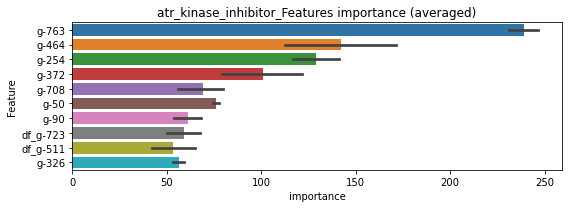

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111277	valid_1's binary_logloss: 0.0200721
[200]	training's binary_logloss: 0.00122933	valid_1's binary_logloss: 0.00850918
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000405833	valid_1's binary_logloss: 0.007609


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114645	valid_1's binary_logloss: 0.0183735
[200]	training's binary_logloss: 0.00125047	valid_1's binary_logloss: 0.00723866
[300]	training's binary_logloss: 0.000342249	valid_1's binary_logloss: 0.00623931
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000229751	valid_1's binary_logloss: 0.00605369


atr_kinase_inhibitor logloss: 0.006831445375449584
aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3273


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645135	valid_1's binary_logloss: 0.108585
[200]	training's binary_logloss: 0.0239179	valid_1's binary_logloss: 0.0887668
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0158046	valid_1's binary_logloss: 0.0864161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682935	valid_1's binary_logloss: 0.110169
[200]	training's binary_logloss: 0.0268317	valid_1's binary_logloss: 0.0835596


1 / 3 AUC score:0.992
y_Threshold: 0.1099127, Threshold: 0.4278387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 640/3767
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.38505, conf_1:0.47062
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.4278387
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_2: 0.4378387
Num_p_label: 78.0, Expected: 16.1, Adj_threshold_3: 0.4478387
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_4: 0.4578387
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_5: 0.4678387
Num_p_label: 71.0, Expected: 16.1, Adj_threshold_6: 0.4778387
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_7: 0.4878387
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_8: 0.4978387
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_9: 0.5078387
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_10: 0.5178387
threshold: 0.5278387, positive_p_label: 62.0/3982, p_label_rate: 0.0155701


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0155496	valid_1's binary_logloss: 0.0798763


positive_y_label: 640.0/3767, y_label_rate: 0.1698965
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410696	valid_1's binary_logloss: 0.0875765
[200]	training's binary_logloss: 0.00923563	valid_1's binary_logloss: 0.0601208
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0071306	valid_1's binary_logloss: 0.058168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427542	valid_1's binary_logloss: 0.0690266
[200]	training's binary_logloss: 0.00998089	valid_1's binary_logloss: 0.03656
[300]	training's binary_logloss: 0.0038135	valid_1's binary_logloss: 0.029133
[400]	training's binary_logloss: 0.0021039	valid_1's binary_logloss: 0.0265814
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00169487	valid_1's binary_logloss: 0.0262351


2 / 3 AUC score:0.997
y_Threshold: 0.2281576, Threshold: 0.5278387, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 614.0/3715
p_label_rate: 0.0273732 Vs.target_rate: 0.00403, Num_p_label: 109.0, conf_0:0.47505, conf_1:0.58062
Num_p_label: 109.0, Expected: 16.1, Adj_threshold_1: 0.5278387
Num_p_label: 108.0, Expected: 16.1, Adj_threshold_2: 0.5378387
Num_p_label: 107.0, Expected: 16.1, Adj_threshold_3: 0.5478387
Num_p_label: 104.0, Expected: 16.1, Adj_threshold_4: 0.5578387
Num_p_label: 103.0, Expected: 16.1, Adj_threshold_5: 0.5678387
Num_p_label: 103.0, Expected: 16.1, Adj_threshold_6: 0.5778387
Num_p_label: 101.0, Expected: 16.1, Adj_threshold_7: 0.5878387
Num_p_label: 99.0, Expected: 16.1, Adj_threshold_8: 0.5978387
Num_p_label: 98.0, Expected: 16.1, Adj_threshold_9: 0.6078387
Num_p_label: 98.0, Expected: 16.1, Adj_threshold_10: 0.6178387
threshold: 0.6278387, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 614.0/3715, y_label_rate:

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035807	valid_1's binary_logloss: 0.0627751
[200]	training's binary_logloss: 0.00734477	valid_1's binary_logloss: 0.030419
[300]	training's binary_logloss: 0.00264749	valid_1's binary_logloss: 0.0216837
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00162508	valid_1's binary_logloss: 0.0192563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361288	valid_1's binary_logloss: 0.0617677


3 / 3 AUC score:1.000
y_Threshold: 0.2483557, Threshold: 0.6278387, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.0075397	valid_1's binary_logloss: 0.0332539
[300]	training's binary_logloss: 0.00274733	valid_1's binary_logloss: 0.025409
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00285671	valid_1's binary_logloss: 0.0253999


Remove_noisy_labels: 20 → Positive_corect_labels: 604.0/3695
p_label_rate: 0.0243596 Vs.target_rate: 0.00403, Num_p_label: 97.0, conf_0:0.56505, conf_1:0.69062
Num_p_label: 97.0, Expected: 16.1, Adj_threshold_1: 0.6278387
Num_p_label: 95.0, Expected: 16.1, Adj_threshold_2: 0.6378387
Num_p_label: 94.0, Expected: 16.1, Adj_threshold_3: 0.6478387
Num_p_label: 94.0, Expected: 16.1, Adj_threshold_4: 0.6578387
Num_p_label: 94.0, Expected: 16.1, Adj_threshold_5: 0.6678387
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_6: 0.6778387
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_7: 0.6878387
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_8: 0.6978387
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_9: 0.7078387
Num_p_label: 93.0, Expected: 16.1, Adj_threshold_10: 0.7178387
threshold: 0.7278387, positive_p_label: 92.0/3982, p_label_rate: 0.0231040
positive_y_label: 696.0/7677, y_label_rate: 0.0906604


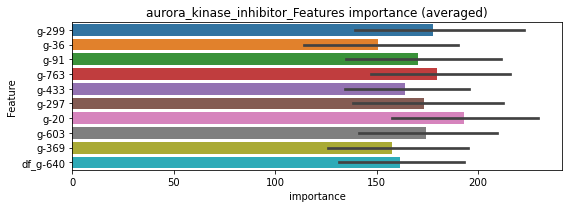

len(train_index) : 3838
len(valid_index) : 3839
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224145	valid_1's binary_logloss: 0.0402434
[200]	training's binary_logloss: 0.00524204	valid_1's binary_logloss: 0.0231604
[300]	training's binary_logloss: 0.00208616	valid_1's binary_logloss: 0.0192435
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00137806	valid_1's binary_logloss: 0.0183771


len(train_index) : 3839
len(valid_index) : 3838
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207564	valid_1's binary_logloss: 0.0417784
[200]	training's binary_logloss: 0.00440046	valid_1's binary_logloss: 0.0263066
[300]	training's binary_logloss: 0.00170325	valid_1's binary_logloss: 0.0229439
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00171673	valid_1's binary_logloss: 0.0229374


aurora_kinase_inhibitor logloss: 0.020656927320922804
autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160307	valid_1's binary_logloss: 0.0175897
[200]	training's binary_logloss: 0.0013669	valid_1's binary_logloss: 0.00239752
[300]	training's binary_logloss: 0.000368117	valid_1's binary_logloss: 0.00104279
[400]	training's binary_logloss: 0.000222188	valid_1's binary_logloss: 0.000794859
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000201931	valid_1's binary_logloss: 0.000762771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163244	valid_1's binary_logloss: 0.0184403
[200]	training's binary_logloss: 0.00136786	valid_1's binary_logloss: 0.00240846
[300]	training's binary_logloss: 0.000366752	valid_1's binary_logloss: 0.000817769
[400]	training's binary_logloss: 0.000223119	valid_1's binary_logloss: 0.000528219


1 / 3 AUC score:1.000
y_Threshold: 0.0005858, Threshold: 0.0010958, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000202774	valid_1's binary_logloss: 0.000492151


Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00099, conf_1:0.00121
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0110958
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0210958
threshold: 0.0210958, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162325	valid_1's binary_logloss: 0.0175384
[200]	training's binary_logloss: 0.00134542	valid_1's binary_logloss: 0.00242075
[300]	training's binary_logloss: 0.000360753	valid_1's binary_logloss: 0.00113085
[400]	training's binary_logloss: 0.000220288	valid_1's binary_logloss: 0.000917508
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000196134	valid_1's binary_logloss: 0.000881055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016585	valid_1's binary_logloss: 0.0188271
[200]	training's binary_logloss: 0.00135591	valid_1's binary_logloss: 0.00257196
[300]	training's binary_logloss: 0.000359504	valid_1's binary_logloss: 0.000971475
[400]	training's binary_logloss: 0.00022185	valid_1's binary_logloss: 0.000719478
[500]	training's binary_logloss: 0.000197803	valid_1's binary_logloss: 0.000658117
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0695192, Threshold: 0.0210958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.01899, conf_1:0.02321
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0210958
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0310958
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0410958
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0510958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0610958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0710958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0810958
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0910958
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1010958
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.1110958
threshold: 0.1110958, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162325	valid_1's binary_logloss: 0.0175384
[200]	training's binary_logloss: 0.00134542	valid_1's binary_logloss: 0.00242075
[300]	training's binary_logloss: 0.000360753	valid_1's binary_logloss: 0.00113085
[400]	training's binary_logloss: 0.000220288	valid_1's binary_logloss: 0.000917508
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000196134	valid_1's binary_logloss: 0.000881055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016585	valid_1's binary_logloss: 0.0188271
[200]	training's binary_logloss: 0.00135591	valid_1's binary_logloss: 0.00257196
[300]	training's binary_logloss: 0.000359504	valid_1's binary_logloss: 0.000971475
[400]	training's binary_logloss: 0.00022185	valid_1's binary_logloss: 0.000719478
[500]	training's binary_logloss: 0.000197803	valid_1's binary_logloss: 0.000658117
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0695192, Threshold: 0.1110958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.09999, conf_1:0.12221
threshold: 0.1110958, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


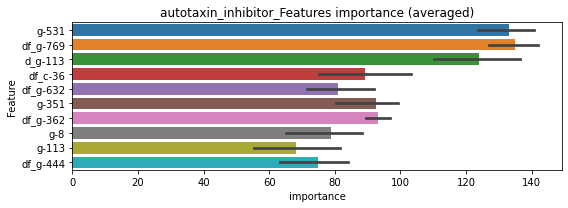

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00858657	valid_1's binary_logloss: 0.0112469
[200]	training's binary_logloss: 0.000707356	valid_1's binary_logloss: 0.00381256


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000251314	valid_1's binary_logloss: 0.00327999


================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00871042	valid_1's binary_logloss: 0.0104438
[200]	training's binary_logloss: 0.000733671	valid_1's binary_logloss: 0.00204205
[300]	training's binary_logloss: 0.000190064	valid_1's binary_logloss: 0.00148825
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000175871	valid_1's binary_logloss: 0.00148085


autotaxin_inhibitor logloss: 0.002380537088020143
bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880245	valid_1's binary_logloss: 0.137076
[200]	training's binary_logloss: 0.0316094	valid_1's binary_logloss: 0.102349
[300]	training's binary_logloss: 0.0143276	valid_1's binary_logloss: 0.0965009
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.012869	valid_1's binary_logloss: 0.0955018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926737	valid_1's binary_logloss: 0.133578
[200]	training's binary_logloss: 0.0379942	valid_1's binary_logloss: 0.0936658
[300]	training's binary_logloss: 0.0169576	valid_1's binary_logloss: 0.0819531


1 / 3 AUC score:0.988
y_Threshold: 0.0822192, Threshold: 0.1887190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 212 → Positive_corect_labels: 615/3722
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.16985, conf_1:0.20759
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.1887190
Num_p_label: 72.0, Expected: 10.0, Adj_threshold_2: 0.1987190
Num_p_label: 70.0, Expected: 10.0, Adj_threshold_3: 0.2087190
Num_p_label: 63.0, Expected: 10.0, Adj_threshold_4: 0.2187190
Num_p_label: 61.0, Expected: 10.0, Adj_threshold_5: 0.2287190
Num_p_label: 56.0, Expected: 10.0, Adj_threshold_6: 0.2387190


[400]	training's binary_logloss: 0.00888197	valid_1's binary_logloss: 0.0777758
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00935997	valid_1's binary_logloss: 0.0775367


Num_p_label: 51.0, Expected: 10.0, Adj_threshold_7: 0.2487190
Num_p_label: 48.0, Expected: 10.0, Adj_threshold_8: 0.2587190
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_9: 0.2687190
Num_p_label: 38.0, Expected: 10.0, Adj_threshold_10: 0.2787190
threshold: 0.2887190, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 615.0/3722, y_label_rate: 0.1652337
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656122	valid_1's binary_logloss: 0.0929648
[200]	training's binary_logloss: 0.0199285	valid_1's binary_logloss: 0.0501896
[300]	training's binary_logloss: 0.00773413	valid_1's binary_logloss: 0.0396668
[400]	training's binary_logloss: 0.00390547	valid_1's binary_logloss: 0.0360105
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00285697	valid_1's binary_logloss: 0.0351078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664289	valid_1's binary_logloss: 0.0999231
[200]	training's binary_logloss: 0.0198887	valid_1's binary_logloss: 0.0540683
[300]	training's binary_logloss: 0.00784983	valid_1's binary_logloss: 0.039773


2 / 3 AUC score:0.999
y_Threshold: 0.1484160, Threshold: 0.2887190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 596.0/3684
p_label_rate: 0.0223506 Vs.target_rate: 0.00252, Num_p_label: 89.0, conf_0:0.25985, conf_1:0.31759
Num_p_label: 89.0, Expected: 10.0, Adj_threshold_1: 0.2887190
Num_p_label: 86.0, Expected: 10.0, Adj_threshold_2: 0.2987190
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_3: 0.3087190
Num_p_label: 79.0, Expected: 10.0, Adj_threshold_4: 0.3187190
Num_p_label: 76.0, Expected: 10.0, Adj_threshold_5: 0.3287190
Num_p_label: 74.0, Expected: 10.0, Adj_threshold_6: 0.3387190
Num_p_label: 71.0, Expected: 10.0, Adj_threshold_7: 0.3487190
Num_p_label: 66.0, Expected: 10.0, Adj_threshold_8: 0.3587190


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00563731	valid_1's binary_logloss: 0.0373786


Num_p_label: 64.0, Expected: 10.0, Adj_threshold_9: 0.3687190
Num_p_label: 62.0, Expected: 10.0, Adj_threshold_10: 0.3787190
threshold: 0.3887190, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 596.0/3684, y_label_rate: 0.1617807
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590142	valid_1's binary_logloss: 0.0810891
[200]	training's binary_logloss: 0.0164613	valid_1's binary_logloss: 0.0390554
[300]	training's binary_logloss: 0.00635769	valid_1's binary_logloss: 0.0279137
[400]	training's binary_logloss: 0.00325722	valid_1's binary_logloss: 0.0231051
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00228721	valid_1's binary_logloss: 0.0216034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554881	valid_1's binary_logloss: 0.093322
[200]	training's binary_logloss: 0.0151618	valid_1's binary_logloss: 0.0522266
[300]	training's binary_logloss: 0.00542782	valid_1's binary_logloss: 0.0382362


3 / 3 AUC score:0.999
y_Threshold: 0.1986542, Threshold: 0.3887190, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 582.0/3656
p_label_rate: 0.0178302 Vs.target_rate: 0.00252, Num_p_label: 71.0, conf_0:0.34985, conf_1:0.42759
Num_p_label: 71.0, Expected: 10.0, Adj_threshold_1: 0.3887190
Num_p_label: 71.0, Expected: 10.0, Adj_threshold_2: 0.3987190
Num_p_label: 68.0, Expected: 10.0, Adj_threshold_3: 0.4087190
Num_p_label: 66.0, Expected: 10.0, Adj_threshold_4: 0.4187190
Num_p_label: 61.0, Expected: 10.0, Adj_threshold_5: 0.4287190


[400]	training's binary_logloss: 0.00280425	valid_1's binary_logloss: 0.032651
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00274861	valid_1's binary_logloss: 0.0325324


Num_p_label: 58.0, Expected: 10.0, Adj_threshold_6: 0.4387190
Num_p_label: 58.0, Expected: 10.0, Adj_threshold_7: 0.4487190
Num_p_label: 56.0, Expected: 10.0, Adj_threshold_8: 0.4587190
Num_p_label: 55.0, Expected: 10.0, Adj_threshold_9: 0.4687190
Num_p_label: 54.0, Expected: 10.0, Adj_threshold_10: 0.4787190
threshold: 0.4887190, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 635.0/7638, y_label_rate: 0.0831369


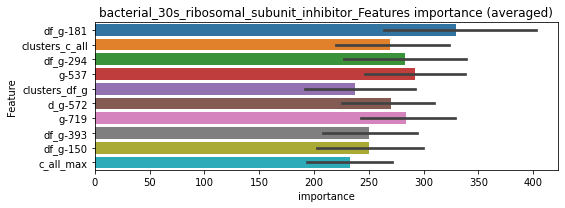

len(train_index) : 3819
len(valid_index) : 3819
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355778	valid_1's binary_logloss: 0.0530177
[200]	training's binary_logloss: 0.010167	valid_1's binary_logloss: 0.02999
[300]	training's binary_logloss: 0.00384326	valid_1's binary_logloss: 0.0232697
[400]	training's binary_logloss: 0.00200592	valid_1's binary_logloss: 0.0212762
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00197491	valid_1's binary_logloss: 0.0212244


len(train_index) : 3819
len(valid_index) : 3819
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346195	valid_1's binary_logloss: 0.055305
[200]	training's binary_logloss: 0.010101	valid_1's binary_logloss: 0.0320506
[300]	training's binary_logloss: 0.00404367	valid_1's binary_logloss: 0.0242769
[400]	training's binary_logloss: 0.00209173	valid_1's binary_logloss: 0.0219656
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00183359	valid_1's binary_logloss: 0.0213617


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.021293040613850112
bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932702	valid_1's binary_logloss: 0.158748
[200]	training's binary_logloss: 0.0401973	valid_1's binary_logloss: 0.134601
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0286956	valid_1's binary_logloss: 0.132044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950411	valid_1's binary_logloss: 0.141804
[200]	training's binary_logloss: 0.0472222	valid_1's binary_logloss: 0.116909
[300]	training's binary_logloss: 0.0241552	valid_1's binary_logloss: 0.11092


1 / 3 AUC score:0.969
y_Threshold: 0.0812326, Threshold: 0.1763631, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 270 → Positive_corect_labels: 586/3662
p_label_rate: 0.0200904 Vs.target_rate: 0.00336, Num_p_label: 80.0, conf_0:0.15873, conf_1:0.19400
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.1763631
Num_p_label: 77.0, Expected: 13.4, Adj_threshold_2: 0.1863631
Num_p_label: 69.0, Expected: 13.4, Adj_threshold_3: 0.1963631
Num_p_label: 63.0, Expected: 13.4, Adj_threshold_4: 0.2063631
Num_p_label: 56.0, Expected: 13.4, Adj_threshold_5: 0.2163631
Num_p_label: 51.0, Expected: 13.4, Adj_threshold_6: 0.2263631


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0199921	valid_1's binary_logloss: 0.109896


Num_p_label: 45.0, Expected: 13.4, Adj_threshold_7: 0.2363631
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_8: 0.2463631
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_9: 0.2563631
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_10: 0.2663631
threshold: 0.2763631, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 586.0/3662, y_label_rate: 0.1600218
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542647	valid_1's binary_logloss: 0.0904599
[200]	training's binary_logloss: 0.0149636	valid_1's binary_logloss: 0.0576016
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0087126	valid_1's binary_logloss: 0.0536114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600696	valid_1's binary_logloss: 0.0974036
[200]	training's binary_logloss: 0.0170801	valid_1's binary_logloss: 0.0547145
[300]	training's binary_logloss: 0.00684406	valid_1's binary_logloss: 0.045171
[400]	training's binary_logloss: 0.00374787	valid_1's binary_logloss: 0.0413695
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00391498	valid_1's binary_logloss: 0.0411139


2 / 3 AUC score:0.998
y_Threshold: 0.1231291, Threshold: 0.2763631, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 560.0/3610
p_label_rate: 0.0148167 Vs.target_rate: 0.00336, Num_p_label: 59.0, conf_0:0.24873, conf_1:0.30400
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_1: 0.2763631
Num_p_label: 58.0, Expected: 13.4, Adj_threshold_2: 0.2863631
Num_p_label: 57.0, Expected: 13.4, Adj_threshold_3: 0.2963631
Num_p_label: 55.0, Expected: 13.4, Adj_threshold_4: 0.3063631
Num_p_label: 53.0, Expected: 13.4, Adj_threshold_5: 0.3163631
Num_p_label: 52.0, Expected: 13.4, Adj_threshold_6: 0.3263631
Num_p_label: 51.0, Expected: 13.4, Adj_threshold_7: 0.3363631
Num_p_label: 50.0, Expected: 13.4, Adj_threshold_8: 0.3463631
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_9: 0.3563631
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_10: 0.3663631
threshold: 0.3763631, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 560.0/3610, y_label_rate: 0.15512

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481794	valid_1's binary_logloss: 0.0747767
[200]	training's binary_logloss: 0.0123913	valid_1's binary_logloss: 0.036717
[300]	training's binary_logloss: 0.00486875	valid_1's binary_logloss: 0.0265339
[400]	training's binary_logloss: 0.00262286	valid_1's binary_logloss: 0.0225745
[500]	training's binary_logloss: 0.00181984	valid_1's binary_logloss: 0.0213794
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00165641	valid_1's binary_logloss: 0.0209761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492677	valid_1's binary_logloss: 0.0753283
[200]	training's binary_logloss: 0.0129461	valid_1's binary_logloss: 0.037048
[300]	training's binary_logloss: 0.00491453	valid_1's binary_logloss: 0.0270648


3 / 3 AUC score:1.000
y_Threshold: 0.1366462, Threshold: 0.3763631, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 550.0/3590
p_label_rate: 0.0095429 Vs.target_rate: 0.00336, Num_p_label: 38.0, conf_0:0.33873, conf_1:0.41400
threshold: 0.3763631, positive_p_label: 38.0/3982, p_label_rate: 0.0095429


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00292827	valid_1's binary_logloss: 0.0239387


positive_y_label: 588.0/7572, y_label_rate: 0.0776545


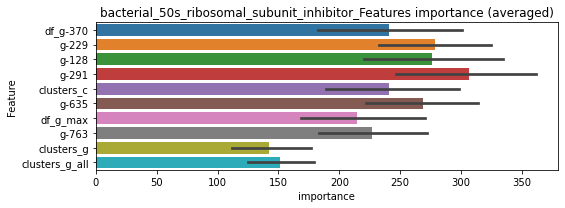

len(train_index) : 3786
len(valid_index) : 3786
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284119	valid_1's binary_logloss: 0.0431769
[200]	training's binary_logloss: 0.00780949	valid_1's binary_logloss: 0.022842
[300]	training's binary_logloss: 0.00287053	valid_1's binary_logloss: 0.0168991
[400]	training's binary_logloss: 0.00158689	valid_1's binary_logloss: 0.0144595
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0014203	valid_1's binary_logloss: 0.014148


len(train_index) : 3786
len(valid_index) : 3786
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264275	valid_1's binary_logloss: 0.0439507
[200]	training's binary_logloss: 0.00694633	valid_1's binary_logloss: 0.0244166
[300]	training's binary_logloss: 0.00281354	valid_1's binary_logloss: 0.0202506


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.01688004410188947


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00202593	valid_1's binary_logloss: 0.019612


bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327969	valid_1's binary_logloss: 0.0568017
[200]	training's binary_logloss: 0.00509246	valid_1's binary_logloss: 0.0246174
[300]	training's binary_logloss: 0.00147692	valid_1's binary_logloss: 0.0175981
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000829931	valid_1's binary_logloss: 0.0159685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358377	valid_1's binary_logloss: 0.0539448
[200]	training's binary_logloss: 0.00569571	valid_1's binary_logloss: 0.0160662
[300]	training's binary_logloss: 0.00160043	valid_1's binary_logloss: 0.00853367
[400]	training's binary_logloss: 0.000782286	valid_1's binary_logloss: 0.00656957
[500]	training's binary_logloss: 0.000523994	valid_1's binary_logloss: 0.00574164
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000485683	valid_1's binary_logloss: 0.00562022


1 / 3 AUC score:1.000
y_Threshold: 0.0048108, Threshold: 0.0074723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00673, conf_1:0.00822
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0074723
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.0174723
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0274723
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.0374723
threshold: 0.0374723, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338651	valid_1's binary_logloss: 0.0545645
[200]	training's binary_logloss: 0.00508512	valid_1's binary_logloss: 0.0201756
[300]	training's binary_logloss: 0.00144689	valid_1's binary_logloss: 0.0136263
[400]	training's binary_logloss: 0.000726793	valid_1's binary_logloss: 0.0121851
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000549787	valid_1's binary_logloss: 0.0116649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344075	valid_1's binary_logloss: 0.0530494
[200]	training's binary_logloss: 0.00524278	valid_1's binary_logloss: 0.0151126
[300]	training's binary_logloss: 0.00152246	valid_1's binary_logloss: 0.00818737
[400]	training's binary_logloss: 0.000761201	valid_1's binary_logloss: 0.00626908
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000534721	valid_1's binary_logloss: 0.00527433


2 / 3 AUC score:1.000
y_Threshold: 0.0505851, Threshold: 0.0374723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.03373, conf_1:0.04122
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0374723
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0474723
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0574723
threshold: 0.0574723, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334133	valid_1's binary_logloss: 0.0536235
[200]	training's binary_logloss: 0.00509527	valid_1's binary_logloss: 0.0176023
[300]	training's binary_logloss: 0.00146718	valid_1's binary_logloss: 0.0106733
[400]	training's binary_logloss: 0.000733191	valid_1's binary_logloss: 0.00870831
[500]	training's binary_logloss: 0.000498019	valid_1's binary_logloss: 0.00788975
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000507903	valid_1's binary_logloss: 0.00786997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335101	valid_1's binary_logloss: 0.054271
[200]	training's binary_logloss: 0.0051116	valid_1's binary_logloss: 0.0155002
[300]	training's binary_logloss: 0.00144401	valid_1's binary_logloss: 0.00911398
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000907248	valid_1's binary_logloss: 0.00800243


3 / 3 AUC score:1.000
y_Threshold: 0.0393822, Threshold: 0.0574723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.05173, conf_1:0.06322
threshold: 0.0574723, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 669.0/7787, y_label_rate: 0.0859124


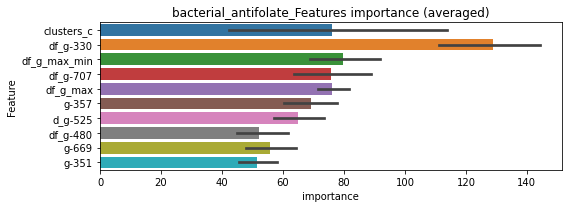

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185898	valid_1's binary_logloss: 0.0402926
[200]	training's binary_logloss: 0.00282285	valid_1's binary_logloss: 0.0208677
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00135944	valid_1's binary_logloss: 0.0185993


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190451	valid_1's binary_logloss: 0.0329933
[200]	training's binary_logloss: 0.00300315	valid_1's binary_logloss: 0.0119907
[300]	training's binary_logloss: 0.000854991	valid_1's binary_logloss: 0.00888022
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000567865	valid_1's binary_logloss: 0.00833112


bacterial_antifolate logloss: 0.013465886154326813
bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283


neg labels: 3289 → selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163572	valid_1's binary_logloss: 0.254466
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.11553	valid_1's binary_logloss: 0.238235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179087	valid_1's binary_logloss: 0.251002
[200]	training's binary_logloss: 0.113137	valid_1's binary_logloss: 0.228697


1 / 3 AUC score:0.904
y_Threshold: 0.1756370, Threshold: 0.2980195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 467 → Positive_corect_labels: 483/3443
p_label_rate: 0.0200904 Vs.target_rate: 0.00806, Num_p_label: 80.0, conf_0:0.26822, conf_1:0.32782
threshold: 0.2980195, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 483.0/3443, y_label_rate: 0.1402846
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0900186	valid_1's binary_logloss: 0.222047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790102	valid_1's binary_logloss: 0.141571
[200]	training's binary_logloss: 0.0330734	valid_1's binary_logloss: 0.105409
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0182835	valid_1's binary_logloss: 0.0975397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840513	valid_1's binary_logloss: 0.128591
[200]	training's binary_logloss: 0.0352505	valid_1's binary_logloss: 0.0872218


2 / 3 AUC score:0.988
y_Threshold: 0.1730137, Threshold: 0.2980195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 435.0/3347
p_label_rate: 0.0306379 Vs.target_rate: 0.00806, Num_p_label: 122.0, conf_0:0.26822, conf_1:0.32782
Num_p_label: 122.0, Expected: 32.1, Adj_threshold_1: 0.2980195
Num_p_label: 115.0, Expected: 32.1, Adj_threshold_2: 0.3080195
Num_p_label: 109.0, Expected: 32.1, Adj_threshold_3: 0.3180195
Num_p_label: 102.0, Expected: 32.1, Adj_threshold_4: 0.3280195
Num_p_label: 94.0, Expected: 32.1, Adj_threshold_5: 0.3380195
Num_p_label: 92.0, Expected: 32.1, Adj_threshold_6: 0.3480195
Num_p_label: 85.0, Expected: 32.1, Adj_threshold_7: 0.3580195
Num_p_label: 79.0, Expected: 32.1, Adj_threshold_8: 0.3680195
Num_p_label: 76.0, Expected: 32.1, Adj_threshold_9: 0.3780195
Num_p_label: 72.0, Expected: 32.1, Adj_threshold_10: 0.3880195
threshold: 0.3980195, positive_p_label: 65.0/3982, p_label_rate: 0.0163235


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0190409	valid_1's binary_logloss: 0.0775648


positive_y_label: 435.0/3347, y_label_rate: 0.1299671
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639302	valid_1's binary_logloss: 0.10365
[200]	training's binary_logloss: 0.0209211	valid_1's binary_logloss: 0.0613144
[300]	training's binary_logloss: 0.00888904	valid_1's binary_logloss: 0.0503053
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00572877	valid_1's binary_logloss: 0.0474375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602126	valid_1's binary_logloss: 0.107498
[200]	training's binary_logloss: 0.0207693	valid_1's binary_logloss: 0.0677214
[300]	training's binary_logloss: 0.00855926	valid_1's binary_logloss: 0.0541036


3 / 3 AUC score:0.999
y_Threshold: 0.1151370, Threshold: 0.3980195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 417.0/3311
p_label_rate: 0.0150678 Vs.target_rate: 0.00806, Num_p_label: 60.0, conf_0:0.35822, conf_1:0.43782
threshold: 0.3980195, positive_p_label: 60.0/3982, p_label_rate: 0.0150678


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00526379	valid_1's binary_logloss: 0.0513437


positive_y_label: 477.0/7293, y_label_rate: 0.0654052


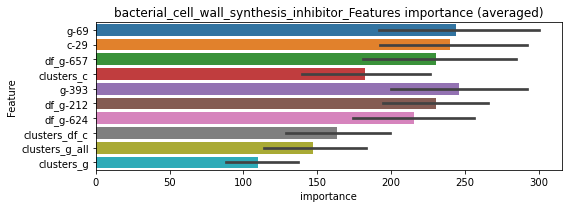

len(train_index) : 3646
len(valid_index) : 3647
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406689	valid_1's binary_logloss: 0.0667829
[200]	training's binary_logloss: 0.0153695	valid_1's binary_logloss: 0.0431321
[300]	training's binary_logloss: 0.00691455	valid_1's binary_logloss: 0.037446
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00562941	valid_1's binary_logloss: 0.0354332


len(train_index) : 3647
len(valid_index) : 3646
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377827	valid_1's binary_logloss: 0.0748447
[200]	training's binary_logloss: 0.0135911	valid_1's binary_logloss: 0.0529681
[300]	training's binary_logloss: 0.00603252	valid_1's binary_logloss: 0.0472348


bacterial_cell_wall_synthesis_inhibitor logloss: 0.04059719172136493


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00481573	valid_1's binary_logloss: 0.0457626


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972284	valid_1's binary_logloss: 0.154445
[200]	training's binary_logloss: 0.0426147	valid_1's binary_logloss: 0.122584
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0303044	valid_1's binary_logloss: 0.117708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100839	valid_1's binary_logloss: 0.150052
[200]	training's binary_logloss: 0.0464441	valid_1's binary_logloss: 0.117739
[300]	training's binary_logloss: 0.0227475	valid_1's binary_logloss: 0.110656
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0202575	valid_1's binary_logloss: 0.109775


1 / 3 AUC score:0.975
y_Threshold: 0.0987688, Threshold: 0.1909203, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 252 → Positive_corect_labels: 594/3676
p_label_rate: 0.0200904 Vs.target_rate: 0.00374, Num_p_label: 80.0, conf_0:0.17183, conf_1:0.21001
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.1909203
Num_p_label: 70.0, Expected: 14.9, Adj_threshold_2: 0.2009203
Num_p_label: 62.0, Expected: 14.9, Adj_threshold_3: 0.2109203
Num_p_label: 54.0, Expected: 14.9, Adj_threshold_4: 0.2209203
Num_p_label: 52.0, Expected: 14.9, Adj_threshold_5: 0.2309203
Num_p_label: 49.0, Expected: 14.9, Adj_threshold_6: 0.2409203
Num_p_label: 44.0, Expected: 14.9, Adj_threshold_7: 0.2509203
Num_p_label: 42.0, Expected: 14.9, Adj_threshold_8: 0.2609203
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_9: 0.2709203
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_10: 0.2809203
threshold: 0.2909203, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 594.0/3676, y_label_rate: 0.161588

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06394	valid_1's binary_logloss: 0.109423
[200]	training's binary_logloss: 0.0205805	valid_1's binary_logloss: 0.0703201
[300]	training's binary_logloss: 0.00814056	valid_1's binary_logloss: 0.0612463
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0070008	valid_1's binary_logloss: 0.0603494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667307	valid_1's binary_logloss: 0.1004
[200]	training's binary_logloss: 0.0227498	valid_1's binary_logloss: 0.0611534
[300]	training's binary_logloss: 0.00996954	valid_1's binary_logloss: 0.0515959
[400]	training's binary_logloss: 0.00509626	valid_1's binary_logloss: 0.0462052
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00413045	valid_1's binary_logloss: 0.0455152


2 / 3 AUC score:0.997
y_Threshold: 0.1265343, Threshold: 0.2909203, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 566.0/3620
p_label_rate: 0.0170768 Vs.target_rate: 0.00374, Num_p_label: 68.0, conf_0:0.26183, conf_1:0.32001
Num_p_label: 68.0, Expected: 14.9, Adj_threshold_1: 0.2909203
Num_p_label: 61.0, Expected: 14.9, Adj_threshold_2: 0.3009203
Num_p_label: 60.0, Expected: 14.9, Adj_threshold_3: 0.3109203
Num_p_label: 60.0, Expected: 14.9, Adj_threshold_4: 0.3209203
Num_p_label: 57.0, Expected: 14.9, Adj_threshold_5: 0.3309203
Num_p_label: 55.0, Expected: 14.9, Adj_threshold_6: 0.3409203
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_7: 0.3509203
Num_p_label: 49.0, Expected: 14.9, Adj_threshold_8: 0.3609203
Num_p_label: 45.0, Expected: 14.9, Adj_threshold_9: 0.3709203
Num_p_label: 44.0, Expected: 14.9, Adj_threshold_10: 0.3809203
threshold: 0.3909203, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 566.0/3620, y_label_rate: 0.15635

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568242	valid_1's binary_logloss: 0.0840391
[200]	training's binary_logloss: 0.0162649	valid_1's binary_logloss: 0.0426396
[300]	training's binary_logloss: 0.00659887	valid_1's binary_logloss: 0.0311498
[400]	training's binary_logloss: 0.00355643	valid_1's binary_logloss: 0.0274737
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00311684	valid_1's binary_logloss: 0.0268719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542991	valid_1's binary_logloss: 0.0798579
[200]	training's binary_logloss: 0.0155841	valid_1's binary_logloss: 0.0395346
[300]	training's binary_logloss: 0.00618184	valid_1's binary_logloss: 0.0288588
[400]	training's binary_logloss: 0.00329478	valid_1's binary_logloss: 0.0240115
[500]	training's binary_logloss: 0.00219021	valid_1's binary_logloss: 0.0225857
Early stopping, best iteration is:
[518]	traini

3 / 3 AUC score:0.999
y_Threshold: 0.1292128, Threshold: 0.3909203, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 556.0/3600
p_label_rate: 0.0115520 Vs.target_rate: 0.00374, Num_p_label: 46.0, conf_0:0.35183, conf_1:0.43001
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_1: 0.3909203
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_2: 0.4009203
Num_p_label: 42.0, Expected: 14.9, Adj_threshold_3: 0.4109203
Num_p_label: 41.0, Expected: 14.9, Adj_threshold_4: 0.4209203
Num_p_label: 41.0, Expected: 14.9, Adj_threshold_5: 0.4309203
Num_p_label: 39.0, Expected: 14.9, Adj_threshold_6: 0.4409203
Num_p_label: 39.0, Expected: 14.9, Adj_threshold_7: 0.4509203
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_8: 0.4609203
Num_p_label: 36.0, Expected: 14.9, Adj_threshold_9: 0.4709203
Num_p_label: 35.0, Expected: 14.9, Adj_threshold_10: 0.4809203
threshold: 0.4909203, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 591.0/7582, y_label_rate: 0.07794

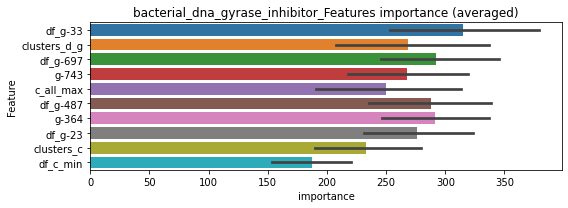

len(train_index) : 3791
len(valid_index) : 3791
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350259	valid_1's binary_logloss: 0.0554349
[200]	training's binary_logloss: 0.0107714	valid_1's binary_logloss: 0.0315579
[300]	training's binary_logloss: 0.00447731	valid_1's binary_logloss: 0.025675
[400]	training's binary_logloss: 0.00237254	valid_1's binary_logloss: 0.023607
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00216786	valid_1's binary_logloss: 0.0232148


len(train_index) : 3791
len(valid_index) : 3791
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323252	valid_1's binary_logloss: 0.0525343
[200]	training's binary_logloss: 0.00969516	valid_1's binary_logloss: 0.0295052
[300]	training's binary_logloss: 0.00390408	valid_1's binary_logloss: 0.0250976


bacterial_dna_gyrase_inhibitor logloss: 0.02412141640020107


Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00408115	valid_1's binary_logloss: 0.025028


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134843	valid_1's binary_logloss: 0.208938
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0750676	valid_1's binary_logloss: 0.182381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140864	valid_1's binary_logloss: 0.18904
[200]	training's binary_logloss: 0.077164	valid_1's binary_logloss: 0.157545


1 / 3 AUC score:0.953
y_Threshold: 0.1699202, Threshold: 0.2836408, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 329 → Positive_corect_labels: 555/3596
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.25528, conf_1:0.31200
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.2836408
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_2: 0.2936408
Num_p_label: 63.0, Expected: 19.2, Adj_threshold_3: 0.3036408
Num_p_label: 53.0, Expected: 19.2, Adj_threshold_4: 0.3136408
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_5: 0.3236408
Num_p_label: 37.0, Expected: 19.2, Adj_threshold_6: 0.3336408
threshold: 0.3336408, positive_p_label: 37.0/3982, p_label_rate: 0.0092918


[300]	training's binary_logloss: 0.0460551	valid_1's binary_logloss: 0.146932
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0473419	valid_1's binary_logloss: 0.146457


positive_y_label: 555.0/3596, y_label_rate: 0.1543382
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841159	valid_1's binary_logloss: 0.135548
[200]	training's binary_logloss: 0.0296134	valid_1's binary_logloss: 0.0903514
[300]	training's binary_logloss: 0.0131399	valid_1's binary_logloss: 0.0781797
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00784229	valid_1's binary_logloss: 0.0728072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082723	valid_1's binary_logloss: 0.125186
[200]	training's binary_logloss: 0.0324872	valid_1's binary_logloss: 0.0849501


2 / 3 AUC score:0.993
y_Threshold: 0.1877544, Threshold: 0.3336408, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 512.0/3510
p_label_rate: 0.0263687 Vs.target_rate: 0.00483, Num_p_label: 105.0, conf_0:0.30028, conf_1:0.36700
Num_p_label: 105.0, Expected: 19.2, Adj_threshold_1: 0.3336408


[300]	training's binary_logloss: 0.015148	valid_1's binary_logloss: 0.0708949
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0117922	valid_1's binary_logloss: 0.0676706


Num_p_label: 99.0, Expected: 19.2, Adj_threshold_2: 0.3436408
Num_p_label: 95.0, Expected: 19.2, Adj_threshold_3: 0.3536408
Num_p_label: 92.0, Expected: 19.2, Adj_threshold_4: 0.3636408
Num_p_label: 89.0, Expected: 19.2, Adj_threshold_5: 0.3736408
Num_p_label: 86.0, Expected: 19.2, Adj_threshold_6: 0.3836408
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_7: 0.3936408
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_8: 0.4036408
Num_p_label: 74.0, Expected: 19.2, Adj_threshold_9: 0.4136408
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_10: 0.4236408
threshold: 0.4336408, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 512.0/3510, y_label_rate: 0.1458689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615043	valid_1's binary_logloss: 0.106245
[200]	training's binary_logloss: 0.0188567	valid_1's binary_logloss: 0.0612461
[300]	training's binary_logloss: 0.00773908	valid_1's binary_logloss: 0.0491597
[400]	training's binary_logloss: 0.0040319	valid_1's binary_logloss: 0.0441806
[500]	training's binary_logloss: 0.00254769	valid_1's binary_logloss: 0.0416999
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00255776	valid_1's binary_logloss: 0.0416901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677778	valid_1's binary_logloss: 0.0836033
[200]	training's binary_logloss: 0.0223367	valid_1's binary_logloss: 0.0435456
[300]	training's binary_logloss: 0.00904683	valid_1's binary_logloss: 0.0305929
[400]	training's binary_logloss: 0.00466422	valid_1's binary_logloss: 0.024847
Early stopping, best iteration is:
[451]	training'

3 / 3 AUC score:0.999
y_Threshold: 0.1746375, Threshold: 0.4336408, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 495.0/3476
p_label_rate: 0.0160723 Vs.target_rate: 0.00483, Num_p_label: 64.0, conf_0:0.39028, conf_1:0.47700
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_1: 0.4336408
Num_p_label: 62.0, Expected: 19.2, Adj_threshold_2: 0.4436408
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_3: 0.4536408
Num_p_label: 57.0, Expected: 19.2, Adj_threshold_4: 0.4636408
Num_p_label: 56.0, Expected: 19.2, Adj_threshold_5: 0.4736408
Num_p_label: 54.0, Expected: 19.2, Adj_threshold_6: 0.4836408
Num_p_label: 51.0, Expected: 19.2, Adj_threshold_7: 0.4936408
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_8: 0.5036408
Num_p_label: 46.0, Expected: 19.2, Adj_threshold_9: 0.5136408
Num_p_label: 45.0, Expected: 19.2, Adj_threshold_10: 0.5236408
threshold: 0.5336408, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 540.0/7458, y_label_rate: 0.07240

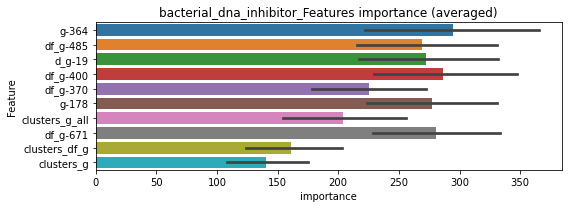

len(train_index) : 3729
len(valid_index) : 3729
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433152	valid_1's binary_logloss: 0.0720666
[200]	training's binary_logloss: 0.0130485	valid_1's binary_logloss: 0.0449558
[300]	training's binary_logloss: 0.00565382	valid_1's binary_logloss: 0.0384563


len(train_index) : 3729
len(valid_index) : 3729
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00352741	valid_1's binary_logloss: 0.0354018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446282	valid_1's binary_logloss: 0.0634941
[200]	training's binary_logloss: 0.0151207	valid_1's binary_logloss: 0.0346028
[300]	training's binary_logloss: 0.00631029	valid_1's binary_logloss: 0.025677
[400]	training's binary_logloss: 0.00304413	valid_1's binary_logloss: 0.0216561
[500]	training's binary_logloss: 0.00187311	valid_1's binary_logloss: 0.0197672
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00174369	valid_1's binary_logloss: 0.0195299


bacterial_dna_inhibitor logloss: 0.02746581353384311
bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232063	valid_1's binary_logloss: 0.0312292
[200]	training's binary_logloss: 0.00274914	valid_1's binary_logloss: 0.0059322
[300]	training's binary_logloss: 0.000781489	valid_1's binary_logloss: 0.00255944
[400]	training's binary_logloss: 0.000419761	valid_1's binary_logloss: 0.00169262
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000350253	valid_1's binary_logloss: 0.00151084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024365	valid_1's binary_logloss: 0.0313381
[200]	training's binary_logloss: 0.00291866	valid_1's binary_logloss: 0.00504854
[300]	training's binary_logloss: 0.000813562	valid_1's binary_logloss: 0.00176932
[400]	training's binary_logloss: 0.000430668	valid_1's binary_logloss: 0.00113803
[500]	training's binary_logloss: 0.000353346	valid_1's binary_logloss: 0.0010046
[600]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0014973, Threshold: 0.0026625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00240, conf_1:0.00293
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0026625
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.0126625
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.0226625
threshold: 0.0226625, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236902	valid_1's binary_logloss: 0.0313871
[200]	training's binary_logloss: 0.00269628	valid_1's binary_logloss: 0.00555504
[300]	training's binary_logloss: 0.000756954	valid_1's binary_logloss: 0.00231062
[400]	training's binary_logloss: 0.000402426	valid_1's binary_logloss: 0.00154922
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000343109	valid_1's binary_logloss: 0.00140309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237908	valid_1's binary_logloss: 0.0294576
[200]	training's binary_logloss: 0.00276351	valid_1's binary_logloss: 0.00400875
[300]	training's binary_logloss: 0.000777447	valid_1's binary_logloss: 0.00128538
[400]	training's binary_logloss: 0.000408291	valid_1's binary_logloss: 0.000725541
[500]	training's binary_logloss: 0.000337891	valid_1's binary_logloss: 0.000612812
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1457968, Threshold: 0.0226625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.02040, conf_1:0.02493
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.0226625
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.0326625
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0426625
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.0526625
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.0626625
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.0726625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.0826625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.0926625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.1026625
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.1126625
threshold: 0.1226625, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236902	valid_1's binary_logloss: 0.0313871
[200]	training's binary_logloss: 0.00269628	valid_1's binary_logloss: 0.00555504
[300]	training's binary_logloss: 0.000756954	valid_1's binary_logloss: 0.00231062
[400]	training's binary_logloss: 0.000402426	valid_1's binary_logloss: 0.00154922
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000343109	valid_1's binary_logloss: 0.00140309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237908	valid_1's binary_logloss: 0.0294576
[200]	training's binary_logloss: 0.00276351	valid_1's binary_logloss: 0.00400875
[300]	training's binary_logloss: 0.000777447	valid_1's binary_logloss: 0.00128538
[400]	training's binary_logloss: 0.000408291	valid_1's binary_logloss: 0.000725541
[500]	training's binary_logloss: 0.000337891	valid_1's binary_logloss: 0.000612812
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1457968, Threshold: 0.1226625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.11040, conf_1:0.13493
threshold: 0.1226625, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


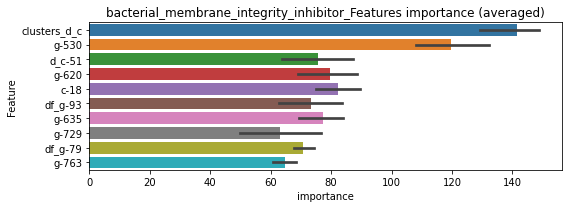

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123044	valid_1's binary_logloss: 0.0201608
[200]	training's binary_logloss: 0.00137386	valid_1's binary_logloss: 0.00685709
[300]	training's binary_logloss: 0.000384398	valid_1's binary_logloss: 0.00551739
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000234859	valid_1's binary_logloss: 0.00536435


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012589	valid_1's binary_logloss: 0.0160268
[200]	training's binary_logloss: 0.00155335	valid_1's binary_logloss: 0.00280418
[300]	training's binary_logloss: 0.000406116	valid_1's binary_logloss: 0.00131623
[400]	training's binary_logloss: 0.000215767	valid_1's binary_logloss: 0.000995943
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000187009	valid_1's binary_logloss: 0.000941514


bacterial_membrane_integrity_inhibitor logloss: 0.0031529315661288342
bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030486	valid_1's binary_logloss: 0.049039
[200]	training's binary_logloss: 0.00425719	valid_1's binary_logloss: 0.015544
[300]	training's binary_logloss: 0.00120487	valid_1's binary_logloss: 0.00860341
[400]	training's binary_logloss: 0.000595236	valid_1's binary_logloss: 0.00630591
[500]	training's binary_logloss: 0.00042563	valid_1's binary_logloss: 0.00577542
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000421829	valid_1's binary_logloss: 0.00575439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313345	valid_1's binary_logloss: 0.0522494
[200]	training's binary_logloss: 0.00432486	valid_1's binary_logloss: 0.0186814
[300]	training's binary_logloss: 0.00122243	valid_1's binary_logloss: 0.0142382
[400]	training's binary_logloss: 0.00060825	valid_1's binary_logloss: 0.0127656
Early stopping, best iteration is:
[410]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0037224, Threshold: 0.0929520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.08366, conf_1:0.10225
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0929520
Num_p_label: 77.0, Expected: 5.2, Adj_threshold_2: 0.1029520
Num_p_label: 75.0, Expected: 5.2, Adj_threshold_3: 0.1129520
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_4: 0.1229520
Num_p_label: 69.0, Expected: 5.2, Adj_threshold_5: 0.1329520
Num_p_label: 66.0, Expected: 5.2, Adj_threshold_6: 0.1429520
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_7: 0.1529520
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_8: 0.1629520
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_9: 0.1729520
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_10: 0.1829520
threshold: 0.1929520, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282218	valid_1's binary_logloss: 0.0430124
[200]	training's binary_logloss: 0.00377175	valid_1's binary_logloss: 0.0112341
[300]	training's binary_logloss: 0.00108109	valid_1's binary_logloss: 0.0053773
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000635498	valid_1's binary_logloss: 0.00411263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293554	valid_1's binary_logloss: 0.0448803
[200]	training's binary_logloss: 0.0038872	valid_1's binary_logloss: 0.0149235


2 / 3 AUC score:1.000
y_Threshold: 0.0638828, Threshold: 0.1929520, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00126507	valid_1's binary_logloss: 0.0100087


Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0359116 Vs.target_rate: 0.00130, Num_p_label: 143.0, conf_0:0.17366, conf_1:0.21225
Num_p_label: 143.0, Expected: 5.2, Adj_threshold_1: 0.1929520
Num_p_label: 139.0, Expected: 5.2, Adj_threshold_2: 0.2029520
Num_p_label: 138.0, Expected: 5.2, Adj_threshold_3: 0.2129520
Num_p_label: 136.0, Expected: 5.2, Adj_threshold_4: 0.2229520
Num_p_label: 132.0, Expected: 5.2, Adj_threshold_5: 0.2329520
Num_p_label: 128.0, Expected: 5.2, Adj_threshold_6: 0.2429520
Num_p_label: 127.0, Expected: 5.2, Adj_threshold_7: 0.2529520
Num_p_label: 126.0, Expected: 5.2, Adj_threshold_8: 0.2629520
Num_p_label: 125.0, Expected: 5.2, Adj_threshold_9: 0.2729520
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_10: 0.2829520
threshold: 0.2929520, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286951	valid_1's binary_logloss: 0.0472159
[200]	training's binary_logloss: 0.00386119	valid_1's binary_logloss: 0.0136698
[300]	training's binary_logloss: 0.00110725	valid_1's binary_logloss: 0.0071763
[400]	training's binary_logloss: 0.000548197	valid_1's binary_logloss: 0.00515212
[500]	training's binary_logloss: 0.000388962	valid_1's binary_logloss: 0.00389606
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000387552	valid_1's binary_logloss: 0.00389515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286133	valid_1's binary_logloss: 0.0451275
[200]	training's binary_logloss: 0.0037974	valid_1's binary_logloss: 0.0120172
[300]	training's binary_logloss: 0.00107878	valid_1's binary_logloss: 0.00578244
[400]	training's binary_logloss: 0.000537128	valid_1's binary_logloss: 0.00405502
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1250350, Threshold: 0.2929520, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0308890 Vs.target_rate: 0.00130, Num_p_label: 123.0, conf_0:0.26366, conf_1:0.32225
Num_p_label: 123.0, Expected: 5.2, Adj_threshold_1: 0.2929520
Num_p_label: 121.0, Expected: 5.2, Adj_threshold_2: 0.3029520
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_3: 0.3129520
Num_p_label: 118.0, Expected: 5.2, Adj_threshold_4: 0.3229520
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_5: 0.3329520
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_6: 0.3429520
Num_p_label: 115.0, Expected: 5.2, Adj_threshold_7: 0.3529520
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_8: 0.3629520
Num_p_label: 113.0, Expected: 5.2, Adj_threshold_9: 0.3729520
Num_p_label: 112.0, Expected: 5.2, Adj_threshold_10: 0.3829520
threshold: 0.3929520, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 764.0/7785, y_label_rate: 0.0981

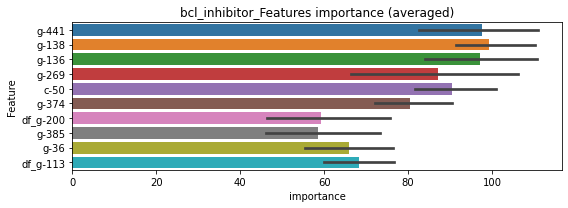

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187488	valid_1's binary_logloss: 0.035688
[200]	training's binary_logloss: 0.00259377	valid_1's binary_logloss: 0.0141169
[300]	training's binary_logloss: 0.000732113	valid_1's binary_logloss: 0.0100065
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000446817	valid_1's binary_logloss: 0.00936754


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185252	valid_1's binary_logloss: 0.029978
[200]	training's binary_logloss: 0.00266918	valid_1's binary_logloss: 0.0124117
[300]	training's binary_logloss: 0.000757346	valid_1's binary_logloss: 0.00992852
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000571289	valid_1's binary_logloss: 0.00968849


bcl_inhibitor logloss: 0.009527994567161956
bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331489	valid_1's binary_logloss: 0.0559837
[200]	training's binary_logloss: 0.00496811	valid_1's binary_logloss: 0.0205098
[300]	training's binary_logloss: 0.00141217	valid_1's binary_logloss: 0.0133515
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000805977	valid_1's binary_logloss: 0.0115086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319757	valid_1's binary_logloss: 0.0506402
[200]	training's binary_logloss: 0.00484216	valid_1's binary_logloss: 0.017129
[300]	training's binary_logloss: 0.00138141	valid_1's binary_logloss: 0.0105768
[400]	training's binary_logloss: 0.000686068	valid_1's binary_logloss: 0.00900836
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000531981	valid_1's binary_logloss: 0.00866079


1 / 3 AUC score:1.000
y_Threshold: 0.0044983, Threshold: 0.0092194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160, Num_p_label: 80.0, conf_0:0.00830, conf_1:0.01014
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0092194
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_2: 0.0192194
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_3: 0.0292194
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_4: 0.0392194
Num_p_label: 11.0, Expected: 6.4, Adj_threshold_5: 0.0492194
threshold: 0.0492194, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312486	valid_1's binary_logloss: 0.0529631
[200]	training's binary_logloss: 0.00455769	valid_1's binary_logloss: 0.0173922
[300]	training's binary_logloss: 0.00130293	valid_1's binary_logloss: 0.0103241
[400]	training's binary_logloss: 0.000660211	valid_1's binary_logloss: 0.00829098
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000527115	valid_1's binary_logloss: 0.00778568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306614	valid_1's binary_logloss: 0.0450033
[200]	training's binary_logloss: 0.00453293	valid_1's binary_logloss: 0.0125371
[300]	training's binary_logloss: 0.00132704	valid_1's binary_logloss: 0.00758419
[400]	training's binary_logloss: 0.000663726	valid_1's binary_logloss: 0.00629948
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000677365	valid_1's binary_logloss: 0.00629613


2 / 3 AUC score:1.000
y_Threshold: 0.0454656, Threshold: 0.0492194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0160723 Vs.target_rate: 0.00160, Num_p_label: 64.0, conf_0:0.04430, conf_1:0.05414
Num_p_label: 64.0, Expected: 6.4, Adj_threshold_1: 0.0492194
Num_p_label: 51.0, Expected: 6.4, Adj_threshold_2: 0.0592194
Num_p_label: 45.0, Expected: 6.4, Adj_threshold_3: 0.0692194
Num_p_label: 42.0, Expected: 6.4, Adj_threshold_4: 0.0792194
Num_p_label: 33.0, Expected: 6.4, Adj_threshold_5: 0.0892194
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_6: 0.0992194
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_7: 0.1092194
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_8: 0.1192194
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_9: 0.1292194
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_10: 0.1392194
threshold: 0.1492194, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309407	valid_1's binary_logloss: 0.0508648
[200]	training's binary_logloss: 0.00454593	valid_1's binary_logloss: 0.0173607
[300]	training's binary_logloss: 0.00130935	valid_1's binary_logloss: 0.0103647
[400]	training's binary_logloss: 0.000648651	valid_1's binary_logloss: 0.00855994
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000509429	valid_1's binary_logloss: 0.00795076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297473	valid_1's binary_logloss: 0.0495141
[200]	training's binary_logloss: 0.00434724	valid_1's binary_logloss: 0.017736
[300]	training's binary_logloss: 0.00127416	valid_1's binary_logloss: 0.0109866
[400]	training's binary_logloss: 0.000643409	valid_1's binary_logloss: 0.00925162
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000643409	valid_1's binary_logloss: 0.00925162


3 / 3 AUC score:1.000
y_Threshold: 0.0443966, Threshold: 0.1492194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0070316 Vs.target_rate: 0.00160, Num_p_label: 28.0, conf_0:0.13430, conf_1:0.16414
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_1: 0.1492194
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_2: 0.1592194
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_3: 0.1692194
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_4: 0.1792194
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_5: 0.1892194
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_6: 0.1992194
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_7: 0.2092194
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_8: 0.2192194
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_9: 0.2292194
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_10: 0.2392194
threshold: 0.2492194, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 672.0/7785, y_label_rate: 0.0863198


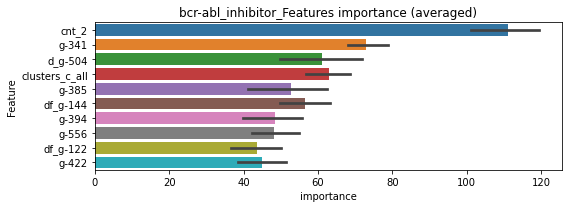

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169691	valid_1's binary_logloss: 0.0333862
[200]	training's binary_logloss: 0.00263911	valid_1's binary_logloss: 0.0132172
[300]	training's binary_logloss: 0.000692813	valid_1's binary_logloss: 0.00903544
[400]	training's binary_logloss: 0.000343776	valid_1's binary_logloss: 0.00839188
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000359794	valid_1's binary_logloss: 0.00832992


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168395	valid_1's binary_logloss: 0.0277216
[200]	training's binary_logloss: 0.00250998	valid_1's binary_logloss: 0.0101203
[300]	training's binary_logloss: 0.000711475	valid_1's binary_logloss: 0.0072921
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000418567	valid_1's binary_logloss: 0.00672502


bcr-abl_inhibitor logloss: 0.007527572842258842
benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914705	valid_1's binary_logloss: 0.152629
[200]	training's binary_logloss: 0.0356811	valid_1's binary_logloss: 0.116097
[300]	training's binary_logloss: 0.0162895	valid_1's binary_logloss: 0.109112
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0169207	valid_1's binary_logloss: 0.108694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925999	valid_1's binary_logloss: 0.154945
[200]	training's binary_logloss: 0.0380211	valid_1's binary_logloss: 0.117986
[300]	training's binary_logloss: 0.0181187	valid_1's binary_logloss: 0.104609


1 / 3 AUC score:0.984


[400]	training's binary_logloss: 0.0093204	valid_1's binary_logloss: 0.0990413
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00945163	valid_1's binary_logloss: 0.0990372


y_Threshold: 0.1011225, Threshold: 0.2257478, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 230 → Positive_corect_labels: 606/3702
p_label_rate: 0.0200904 Vs.target_rate: 0.00281, Num_p_label: 80.0, conf_0:0.20317, conf_1:0.24832
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.2257478
Num_p_label: 74.0, Expected: 11.2, Adj_threshold_2: 0.2357478
Num_p_label: 73.0, Expected: 11.2, Adj_threshold_3: 0.2457478
Num_p_label: 69.0, Expected: 11.2, Adj_threshold_4: 0.2557478
Num_p_label: 63.0, Expected: 11.2, Adj_threshold_5: 0.2657478
Num_p_label: 61.0, Expected: 11.2, Adj_threshold_6: 0.2757478
Num_p_label: 58.0, Expected: 11.2, Adj_threshold_7: 0.2857478
Num_p_label: 54.0, Expected: 11.2, Adj_threshold_8: 0.2957478
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_9: 0.3057478
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_10: 0.3157478
threshold: 0.3257478, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 606.0/3702, y_label_rate: 0.1636953
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545636	valid_1's binary_logloss: 0.107131
[200]	training's binary_logloss: 0.0152255	valid_1's binary_logloss: 0.0669835
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0101308	valid_1's binary_logloss: 0.0604465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068816	valid_1's binary_logloss: 0.100329
[200]	training's binary_logloss: 0.0216352	valid_1's binary_logloss: 0.0530649
[300]	training's binary_logloss: 0.00870284	valid_1's binary_logloss: 0.0368991
[400]	training's binary_logloss: 0.00456131	valid_1's binary_logloss: 0.0309155


2 / 3 AUC score:0.998
y_Threshold: 0.1966338, Threshold: 0.3257478, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00341665	valid_1's binary_logloss: 0.0284582


Remove_noisy_labels: 56 → Positive_corect_labels: 578.0/3646
p_label_rate: 0.0296334 Vs.target_rate: 0.00281, Num_p_label: 118.0, conf_0:0.29317, conf_1:0.35832
Num_p_label: 118.0, Expected: 11.2, Adj_threshold_1: 0.3257478
Num_p_label: 116.0, Expected: 11.2, Adj_threshold_2: 0.3357478
Num_p_label: 114.0, Expected: 11.2, Adj_threshold_3: 0.3457478
Num_p_label: 111.0, Expected: 11.2, Adj_threshold_4: 0.3557478
Num_p_label: 108.0, Expected: 11.2, Adj_threshold_5: 0.3657478
Num_p_label: 106.0, Expected: 11.2, Adj_threshold_6: 0.3757478
Num_p_label: 102.0, Expected: 11.2, Adj_threshold_7: 0.3857478
Num_p_label: 101.0, Expected: 11.2, Adj_threshold_8: 0.3957478
Num_p_label: 98.0, Expected: 11.2, Adj_threshold_9: 0.4057478
Num_p_label: 94.0, Expected: 11.2, Adj_threshold_10: 0.4157478
threshold: 0.4257478, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 578.0/3646, y_label_rate: 0.1585299
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484636	valid_1's binary_logloss: 0.0861174
[200]	training's binary_logloss: 0.0126413	valid_1's binary_logloss: 0.045658
[300]	training's binary_logloss: 0.00494562	valid_1's binary_logloss: 0.0344679
[400]	training's binary_logloss: 0.00276377	valid_1's binary_logloss: 0.03062
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00204958	valid_1's binary_logloss: 0.0287935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534675	valid_1's binary_logloss: 0.076202
[200]	training's binary_logloss: 0.0143291	valid_1's binary_logloss: 0.0347947
[300]	training's binary_logloss: 0.00548714	valid_1's binary_logloss: 0.0226535
[400]	training's binary_logloss: 0.00295573	valid_1's binary_logloss: 0.0182948
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00209474	valid_1's binary_logloss: 0.0162104


3 / 3 AUC score:0.999
y_Threshold: 0.2300953, Threshold: 0.4257478, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 570.0/3630
p_label_rate: 0.0253641 Vs.target_rate: 0.00281, Num_p_label: 101.0, conf_0:0.38317, conf_1:0.46832
Num_p_label: 101.0, Expected: 11.2, Adj_threshold_1: 0.4257478
Num_p_label: 100.0, Expected: 11.2, Adj_threshold_2: 0.4357478
Num_p_label: 100.0, Expected: 11.2, Adj_threshold_3: 0.4457478
Num_p_label: 99.0, Expected: 11.2, Adj_threshold_4: 0.4557478
Num_p_label: 96.0, Expected: 11.2, Adj_threshold_5: 0.4657478
Num_p_label: 95.0, Expected: 11.2, Adj_threshold_6: 0.4757478
Num_p_label: 95.0, Expected: 11.2, Adj_threshold_7: 0.4857478
Num_p_label: 93.0, Expected: 11.2, Adj_threshold_8: 0.4957478
Num_p_label: 90.0, Expected: 11.2, Adj_threshold_9: 0.5057478
Num_p_label: 87.0, Expected: 11.2, Adj_threshold_10: 0.5157478
threshold: 0.5257478, positive_p_label: 84.0/3982, p_label_rate: 0.0210949
positive_y_label: 654.0/7612, y_label_rate: 0.0

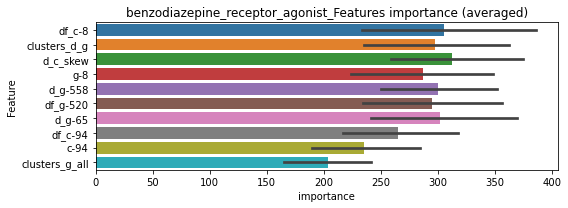

len(train_index) : 3806
len(valid_index) : 3806
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325016	valid_1's binary_logloss: 0.0597751
[200]	training's binary_logloss: 0.00891026	valid_1's binary_logloss: 0.0334694
[300]	training's binary_logloss: 0.00370363	valid_1's binary_logloss: 0.0261959
[400]	training's binary_logloss: 0.00200469	valid_1's binary_logloss: 0.0229197
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00194426	valid_1's binary_logloss: 0.0226136


len(train_index) : 3806
len(valid_index) : 3806
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351044	valid_1's binary_logloss: 0.0541695
[200]	training's binary_logloss: 0.01001	valid_1's binary_logloss: 0.0284865
[300]	training's binary_logloss: 0.00417156	valid_1's binary_logloss: 0.0208191
[400]	training's binary_logloss: 0.00223358	valid_1's binary_logloss: 0.017628
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00165495	valid_1's binary_logloss: 0.0165821


benzodiazepine_receptor_agonist logloss: 0.01959788869660908
beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310839	valid_1's binary_logloss: 0.0457386
[200]	training's binary_logloss: 0.00421961	valid_1's binary_logloss: 0.0130789
[300]	training's binary_logloss: 0.0011657	valid_1's binary_logloss: 0.00831343
[400]	training's binary_logloss: 0.000581133	valid_1's binary_logloss: 0.0072193
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000468404	valid_1's binary_logloss: 0.00702203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312575	valid_1's binary_logloss: 0.0430812
[200]	training's binary_logloss: 0.00432863	valid_1's binary_logloss: 0.00828851
[300]	training's binary_logloss: 0.00119312	valid_1's binary_logloss: 0.0031396
[400]	training's binary_logloss: 0.000604602	valid_1's binary_logloss: 0.00199451
[500]	training's binary_logloss: 0.000425982	valid_1's binary_logloss: 0.00156923
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0025326, Threshold: 0.0044179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00398, conf_1:0.00486
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0044179
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0144179
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0244179
threshold: 0.0244179, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305297	valid_1's binary_logloss: 0.0449576
[200]	training's binary_logloss: 0.00406593	valid_1's binary_logloss: 0.0126457
[300]	training's binary_logloss: 0.00115187	valid_1's binary_logloss: 0.00814541
[400]	training's binary_logloss: 0.000586184	valid_1's binary_logloss: 0.00719973
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000442612	valid_1's binary_logloss: 0.00688909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310561	valid_1's binary_logloss: 0.0413992
[200]	training's binary_logloss: 0.00429929	valid_1's binary_logloss: 0.00781296
[300]	training's binary_logloss: 0.00119495	valid_1's binary_logloss: 0.00306295
[400]	training's binary_logloss: 0.000603426	valid_1's binary_logloss: 0.00187165
[500]	training's binary_logloss: 0.000423277	valid_1's binary_logloss: 0.00148134
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0108880, Threshold: 0.0244179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.02198, conf_1:0.02686
threshold: 0.0244179, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294388	valid_1's binary_logloss: 0.0437525
[200]	training's binary_logloss: 0.00391601	valid_1's binary_logloss: 0.00866831
[300]	training's binary_logloss: 0.00110399	valid_1's binary_logloss: 0.00355516
[400]	training's binary_logloss: 0.000565033	valid_1's binary_logloss: 0.00235957
[500]	training's binary_logloss: 0.000414515	valid_1's binary_logloss: 0.00199147
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000407442	valid_1's binary_logloss: 0.00197641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297709	valid_1's binary_logloss: 0.0437432
[200]	training's binary_logloss: 0.00405538	valid_1's binary_logloss: 0.0109161
[300]	training's binary_logloss: 0.00114916	valid_1's binary_logloss: 0.00473328
[400]	training's binary_logloss: 0.000578426	valid_1's binary_logloss: 0.00318708
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0728395, Threshold: 0.0244179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0040181 Vs.target_rate: 0.00101, Num_p_label: 16.0, conf_0:0.02198, conf_1:0.02686
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.0244179
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0344179
threshold: 0.0344179, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 662.0/7788, y_label_rate: 0.0850026


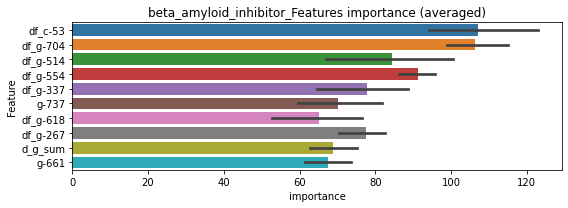

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172463	valid_1's binary_logloss: 0.0281853
[200]	training's binary_logloss: 0.00232828	valid_1's binary_logloss: 0.0105068
[300]	training's binary_logloss: 0.000632143	valid_1's binary_logloss: 0.00840615
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000426872	valid_1's binary_logloss: 0.00811022


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172708	valid_1's binary_logloss: 0.0246767
[200]	training's binary_logloss: 0.00229994	valid_1's binary_logloss: 0.00691625
[300]	training's binary_logloss: 0.000630552	valid_1's binary_logloss: 0.00470344
[400]	training's binary_logloss: 0.000312878	valid_1's binary_logloss: 0.00431293
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00029876	valid_1's binary_logloss: 0.00428861


beta_amyloid_inhibitor logloss: 0.006199419666229118
bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805639	valid_1's binary_logloss: 0.129458
[200]	training's binary_logloss: 0.0317312	valid_1's binary_logloss: 0.0985368
[300]	training's binary_logloss: 0.0135293	valid_1's binary_logloss: 0.0898738
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0117838	valid_1's binary_logloss: 0.0888565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868155	valid_1's binary_logloss: 0.139319
[200]	training's binary_logloss: 0.0375902	valid_1's binary_logloss: 0.112167
[300]	training's binary_logloss: 0.0161789	valid_1's binary_logloss: 0.103001


1 / 3 AUC score:0.989
y_Threshold: 0.0943617, Threshold: 0.3246409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 623/3735
p_label_rate: 0.0200904 Vs.target_rate: 0.00286, Num_p_label: 80.0, conf_0:0.29218, conf_1:0.35710
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.3246409
Num_p_label: 78.0, Expected: 11.4, Adj_threshold_2: 0.3346409
Num_p_label: 73.0, Expected: 11.4, Adj_threshold_3: 0.3446409
Num_p_label: 71.0, Expected: 11.4, Adj_threshold_4: 0.3546409
Num_p_label: 70.0, Expected: 11.4, Adj_threshold_5: 0.3646409
Num_p_label: 68.0, Expected: 11.4, Adj_threshold_6: 0.3746409
Num_p_label: 68.0, Expected: 11.4, Adj_threshold_7: 0.3846409


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00865044	valid_1's binary_logloss: 0.0995777


Num_p_label: 66.0, Expected: 11.4, Adj_threshold_8: 0.3946409
Num_p_label: 65.0, Expected: 11.4, Adj_threshold_9: 0.4046409
Num_p_label: 64.0, Expected: 11.4, Adj_threshold_10: 0.4146409
threshold: 0.4246409, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 623.0/3735, y_label_rate: 0.1668005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498079	valid_1's binary_logloss: 0.0926013
[200]	training's binary_logloss: 0.0148804	valid_1's binary_logloss: 0.0668654
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0148804	valid_1's binary_logloss: 0.0668654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569053	valid_1's binary_logloss: 0.083944
[200]	training's binary_logloss: 0.0157219	valid_1's binary_logloss: 0.0506061
[300]	training's binary_logloss: 0.0058033	valid_1's binary_logloss: 0.0410218
[400]	training's binary_logloss: 0.00295764	valid_1's binary_logloss: 0.0372261


2 / 3 AUC score:0.995
y_Threshold: 0.3362166, Threshold: 0.4246409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 591.0/3671
p_label_rate: 0.0308890 Vs.target_rate: 0.00286, Num_p_label: 123.0, conf_0:0.38218, conf_1:0.46710
Num_p_label: 123.0, Expected: 11.4, Adj_threshold_1: 0.4246409
Num_p_label: 122.0, Expected: 11.4, Adj_threshold_2: 0.4346409


Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00233204	valid_1's binary_logloss: 0.0360385


Num_p_label: 122.0, Expected: 11.4, Adj_threshold_3: 0.4446409
Num_p_label: 120.0, Expected: 11.4, Adj_threshold_4: 0.4546409
Num_p_label: 116.0, Expected: 11.4, Adj_threshold_5: 0.4646409
Num_p_label: 116.0, Expected: 11.4, Adj_threshold_6: 0.4746409
Num_p_label: 112.0, Expected: 11.4, Adj_threshold_7: 0.4846409
Num_p_label: 112.0, Expected: 11.4, Adj_threshold_8: 0.4946409
Num_p_label: 109.0, Expected: 11.4, Adj_threshold_9: 0.5046409
Num_p_label: 108.0, Expected: 11.4, Adj_threshold_10: 0.5146409
threshold: 0.5246409, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 591.0/3671, y_label_rate: 0.1609916
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398765	valid_1's binary_logloss: 0.065926
[200]	training's binary_logloss: 0.00938412	valid_1's binary_logloss: 0.0438372
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00568582	valid_1's binary_logloss: 0.0403308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425731	valid_1's binary_logloss: 0.0645448
[200]	training's binary_logloss: 0.0106223	valid_1's binary_logloss: 0.0328644
[300]	training's binary_logloss: 0.00385768	valid_1's binary_logloss: 0.0251913
[400]	training's binary_logloss: 0.00206453	valid_1's binary_logloss: 0.0228577
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00180569	valid_1's binary_logloss: 0.0225198


3 / 3 AUC score:0.998
y_Threshold: 0.2320145, Threshold: 0.5246409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 571.0/3631
p_label_rate: 0.0281266 Vs.target_rate: 0.00286, Num_p_label: 112.0, conf_0:0.47218, conf_1:0.57710
Num_p_label: 112.0, Expected: 11.4, Adj_threshold_1: 0.5246409
Num_p_label: 111.0, Expected: 11.4, Adj_threshold_2: 0.5346409
Num_p_label: 111.0, Expected: 11.4, Adj_threshold_3: 0.5446409
Num_p_label: 110.0, Expected: 11.4, Adj_threshold_4: 0.5546409
Num_p_label: 107.0, Expected: 11.4, Adj_threshold_5: 0.5646409
Num_p_label: 107.0, Expected: 11.4, Adj_threshold_6: 0.5746409
Num_p_label: 106.0, Expected: 11.4, Adj_threshold_7: 0.5846409
Num_p_label: 105.0, Expected: 11.4, Adj_threshold_8: 0.5946409
Num_p_label: 104.0, Expected: 11.4, Adj_threshold_9: 0.6046409
Num_p_label: 103.0, Expected: 11.4, Adj_threshold_10: 0.6146409
threshold: 0.6246409, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 674.0/7613, y_label_r

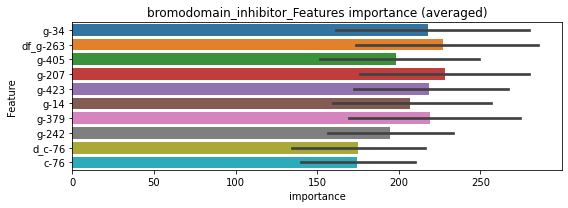

len(train_index) : 3806
len(valid_index) : 3807
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246908	valid_1's binary_logloss: 0.0407548
[200]	training's binary_logloss: 0.0063254	valid_1's binary_logloss: 0.0234481
[300]	training's binary_logloss: 0.00239689	valid_1's binary_logloss: 0.0204891


len(train_index) : 3807
len(valid_index) : 3806
================================= fold 2/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00139759	valid_1's binary_logloss: 0.0191589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241385	valid_1's binary_logloss: 0.0435451
[200]	training's binary_logloss: 0.00579856	valid_1's binary_logloss: 0.0268818


bromodomain_inhibitor logloss: 0.02148876252301477


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0026489	valid_1's binary_logloss: 0.0238192


btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301722	valid_1's binary_logloss: 0.0572393
[200]	training's binary_logloss: 0.00405506	valid_1's binary_logloss: 0.0209293
[300]	training's binary_logloss: 0.00114561	valid_1's binary_logloss: 0.0124348
[400]	training's binary_logloss: 0.000579007	valid_1's binary_logloss: 0.00964149
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000465995	valid_1's binary_logloss: 0.00909057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279233	valid_1's binary_logloss: 0.047306
[200]	training's binary_logloss: 0.00379659	valid_1's binary_logloss: 0.0176468
[300]	training's binary_logloss: 0.00110079	valid_1's binary_logloss: 0.0136325
[400]	training's binary_logloss: 0.000557844	valid_1's binary_logloss: 0.0127814
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000583226	valid_1's binary_logloss: 0.0127389


1 / 3 AUC score:1.000
y_Threshold: 0.0037756, Threshold: 0.0071860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00122, Num_p_label: 80.0, conf_0:0.00647, conf_1:0.00790
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0071860
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_2: 0.0171860
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_3: 0.0271860
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_4: 0.0371860
threshold: 0.0371860, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286106	valid_1's binary_logloss: 0.0474177
[200]	training's binary_logloss: 0.00373154	valid_1's binary_logloss: 0.0116069
[300]	training's binary_logloss: 0.00106546	valid_1's binary_logloss: 0.00582945
[400]	training's binary_logloss: 0.000550124	valid_1's binary_logloss: 0.00391261
[500]	training's binary_logloss: 0.000398497	valid_1's binary_logloss: 0.0032608
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000374743	valid_1's binary_logloss: 0.00314842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028868	valid_1's binary_logloss: 0.0413406
[200]	training's binary_logloss: 0.00392639	valid_1's binary_logloss: 0.00859874
[300]	training's binary_logloss: 0.00112449	valid_1's binary_logloss: 0.0032694
[400]	training's binary_logloss: 0.000565962	valid_1's binary_logloss: 0.0019774
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0740798, Threshold: 0.0371860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0047715 Vs.target_rate: 0.00122, Num_p_label: 19.0, conf_0:0.03347, conf_1:0.04090
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_1: 0.0371860
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_2: 0.0471860
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_3: 0.0571860
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_4: 0.0671860
threshold: 0.0671860, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286106	valid_1's binary_logloss: 0.0474177
[200]	training's binary_logloss: 0.00373154	valid_1's binary_logloss: 0.0116069
[300]	training's binary_logloss: 0.00106546	valid_1's binary_logloss: 0.00582945
[400]	training's binary_logloss: 0.000550124	valid_1's binary_logloss: 0.00391261
[500]	training's binary_logloss: 0.000398497	valid_1's binary_logloss: 0.0032608
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.000374743	valid_1's binary_logloss: 0.00314842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028868	valid_1's binary_logloss: 0.0413406
[200]	training's binary_logloss: 0.00392639	valid_1's binary_logloss: 0.00859874
[300]	training's binary_logloss: 0.00112449	valid_1's binary_logloss: 0.0032694
[400]	training's binary_logloss: 0.000565962	valid_1's binary_logloss: 0.0019774
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0740798, Threshold: 0.0671860, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00122, Num_p_label: 9.0, conf_0:0.06047, conf_1:0.07390
threshold: 0.0671860, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7788, y_label_rate: 0.0852594


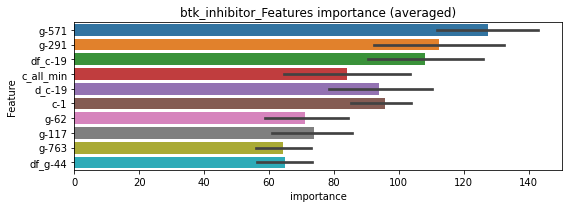

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154079	valid_1's binary_logloss: 0.0255843
[200]	training's binary_logloss: 0.0020312	valid_1's binary_logloss: 0.00907696
[300]	training's binary_logloss: 0.000573571	valid_1's binary_logloss: 0.00707884
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000341597	valid_1's binary_logloss: 0.00674631


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159085	valid_1's binary_logloss: 0.0274034
[200]	training's binary_logloss: 0.00213208	valid_1's binary_logloss: 0.0100907
[300]	training's binary_logloss: 0.000605176	valid_1's binary_logloss: 0.00732426
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000530616	valid_1's binary_logloss: 0.00716743


btk_inhibitor logloss: 0.006956870635334785
calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184979	valid_1's binary_logloss: 0.0278422
[200]	training's binary_logloss: 0.00189182	valid_1's binary_logloss: 0.00697362
[300]	training's binary_logloss: 0.000536719	valid_1's binary_logloss: 0.00334852
[400]	training's binary_logloss: 0.000301795	valid_1's binary_logloss: 0.00249035
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000264846	valid_1's binary_logloss: 0.00236497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185047	valid_1's binary_logloss: 0.0201866
[200]	training's binary_logloss: 0.00188432	valid_1's binary_logloss: 0.00251271
[300]	training's binary_logloss: 0.00053637	valid_1's binary_logloss: 0.000873173
[400]	training's binary_logloss: 0.000304303	valid_1's binary_logloss: 0.00055556
[500]	training's binary_logloss: 0.000261549	valid_1's binary_logloss: 0.000492966
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0009180, Threshold: 0.0016415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00148, conf_1:0.00181
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016415
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0116415
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0216415
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.0316415
threshold: 0.0316415, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185911	valid_1's binary_logloss: 0.0277512
[200]	training's binary_logloss: 0.00182018	valid_1's binary_logloss: 0.00736641
[300]	training's binary_logloss: 0.000518682	valid_1's binary_logloss: 0.00413866
[400]	training's binary_logloss: 0.00029731	valid_1's binary_logloss: 0.00323506
[500]	training's binary_logloss: 0.000254171	valid_1's binary_logloss: 0.0030595
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000253705	valid_1's binary_logloss: 0.00305891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187656	valid_1's binary_logloss: 0.0202451
[200]	training's binary_logloss: 0.00184067	valid_1's binary_logloss: 0.00222985
[300]	training's binary_logloss: 0.000525834	valid_1's binary_logloss: 0.000690391
[400]	training's binary_logloss: 0.000301596	valid_1's binary_logloss: 0.000409659
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0481262, Threshold: 0.0316415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.02848, conf_1:0.03481
threshold: 0.0316415, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185911	valid_1's binary_logloss: 0.0277512
[200]	training's binary_logloss: 0.00182018	valid_1's binary_logloss: 0.00736641
[300]	training's binary_logloss: 0.000518682	valid_1's binary_logloss: 0.00413866
[400]	training's binary_logloss: 0.00029731	valid_1's binary_logloss: 0.00323506
[500]	training's binary_logloss: 0.000254171	valid_1's binary_logloss: 0.0030595
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000253705	valid_1's binary_logloss: 0.00305891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187656	valid_1's binary_logloss: 0.0202451
[200]	training's binary_logloss: 0.00184067	valid_1's binary_logloss: 0.00222985
[300]	training's binary_logloss: 0.000525834	valid_1's binary_logloss: 0.000690391
[400]	training's binary_logloss: 0.000301596	valid_1's binary_logloss: 0.000409659
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0481262, Threshold: 0.0316415, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.02848, conf_1:0.03481
threshold: 0.0316415, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


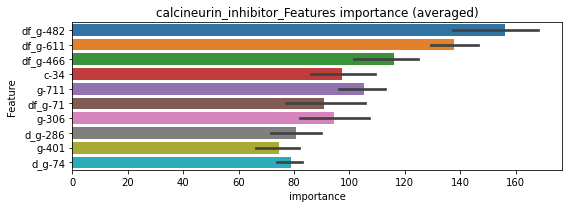

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00994776	valid_1's binary_logloss: 0.0157877
[200]	training's binary_logloss: 0.000968057	valid_1's binary_logloss: 0.00538095


len(train_index) : 3897
len(valid_index) : 3897


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000404696	valid_1's binary_logloss: 0.0049177


================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103759	valid_1's binary_logloss: 0.0123741
[200]	training's binary_logloss: 0.00104933	valid_1's binary_logloss: 0.00233569
[300]	training's binary_logloss: 0.000299079	valid_1's binary_logloss: 0.00141994
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000184503	valid_1's binary_logloss: 0.0013283


calcineurin_inhibitor logloss: 0.0031230004110079147
calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198691	valid_1's binary_logloss: 0.318109
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.164377	valid_1's binary_logloss: 0.313174
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.822
y_Threshold: 0.2069814, Threshold: 0.3370519, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 633 → Positive_corect_labels: 397/3258
p_label_rate: 0.0200904 Vs.target_rate: 0.01180, Num_p_label: 80.0, conf_0:0.30335, conf_1:0.37076
threshold: 0.3370519, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 397.0/3258, y_label_rate: 0.1218539
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.199036	valid_1's binary_logloss: 0.33209
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.167637	valid_1's binary_logloss: 0.323775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775784	valid_1's binary_logloss: 0.137178
[200]	training's binary_logloss: 0.031513	valid_1's binary_logloss: 0.110241
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.025301	valid_1's binary_logloss: 0.106384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755798	valid_1's binary_logloss: 0.138973
[200]	training's binary_logloss: 0.0300983	valid_1's binary_logloss: 0.110506


2 / 3 AUC score:0.979
y_Threshold: 0.1735915, Threshold: 0.3370519, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 339.0/3142
p_label_rate: 0.0379206 Vs.target_rate: 0.01180, Num_p_label: 151.0, conf_0:0.30335, conf_1:0.37076
Num_p_label: 151.0, Expected: 47.0, Adj_threshold_1: 0.3370519
Num_p_label: 146.0, Expected: 47.0, Adj_threshold_2: 0.3470519
Num_p_label: 142.0, Expected: 47.0, Adj_threshold_3: 0.3570519
Num_p_label: 135.0, Expected: 47.0, Adj_threshold_4: 0.3670519
Num_p_label: 130.0, Expected: 47.0, Adj_threshold_5: 0.3770519
Num_p_label: 128.0, Expected: 47.0, Adj_threshold_6: 0.3870519
Num_p_label: 123.0, Expected: 47.0, Adj_threshold_7: 0.3970519
Num_p_label: 119.0, Expected: 47.0, Adj_threshold_8: 0.4070519
Num_p_label: 118.0, Expected: 47.0, Adj_threshold_9: 0.4170519


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.019036	valid_1's binary_logloss: 0.104309


Num_p_label: 116.0, Expected: 47.0, Adj_threshold_10: 0.4270519
threshold: 0.4370519, positive_p_label: 114.0/3982, p_label_rate: 0.0286288
positive_y_label: 339.0/3142, y_label_rate: 0.1078931
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525474	valid_1's binary_logloss: 0.0999152
[200]	training's binary_logloss: 0.0165081	valid_1's binary_logloss: 0.0699535
[300]	training's binary_logloss: 0.00668861	valid_1's binary_logloss: 0.0608597
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0054199	valid_1's binary_logloss: 0.0596463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521211	valid_1's binary_logloss: 0.0996062


3 / 3 AUC score:0.995
y_Threshold: 0.1651200, Threshold: 0.4370519, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 309.0/3082
p_label_rate: 0.0238574 Vs.target_rate: 0.01180, Num_p_label: 95.0, conf_0:0.39335, conf_1:0.48076
threshold: 0.4370519, positive_p_label: 95.0/3982, p_label_rate: 0.0238574
positive_y_label: 404.0/7064, y_label_rate: 0.0571914


[200]	training's binary_logloss: 0.0170329	valid_1's binary_logloss: 0.0698242
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0128023	valid_1's binary_logloss: 0.0663763


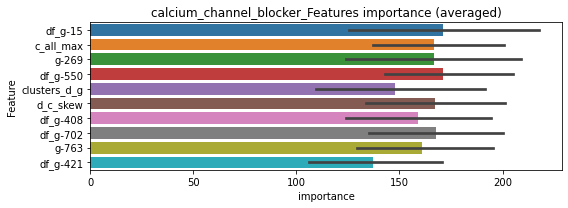

len(train_index) : 3532
len(valid_index) : 3532
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334704	valid_1's binary_logloss: 0.0604687
[200]	training's binary_logloss: 0.0112055	valid_1's binary_logloss: 0.0444506
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00582589	valid_1's binary_logloss: 0.0400577


len(train_index) : 3532
len(valid_index) : 3532
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309317	valid_1's binary_logloss: 0.0650392
[200]	training's binary_logloss: 0.0101024	valid_1's binary_logloss: 0.049371


calcium_channel_blocker logloss: 0.042647943715640256


[300]	training's binary_logloss: 0.0041865	valid_1's binary_logloss: 0.0452382
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0041865	valid_1's binary_logloss: 0.0452382


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441495	valid_1's binary_logloss: 0.0725849
[200]	training's binary_logloss: 0.00782832	valid_1's binary_logloss: 0.0279536
[300]	training's binary_logloss: 0.00209216	valid_1's binary_logloss: 0.0175261
[400]	training's binary_logloss: 0.000971849	valid_1's binary_logloss: 0.0138765
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000862928	valid_1's binary_logloss: 0.0134639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448524	valid_1's binary_logloss: 0.0770924
[200]	training's binary_logloss: 0.00797658	valid_1's binary_logloss: 0.0294695
[300]	training's binary_logloss: 0.00220453	valid_1's binary_logloss: 0.0172314
[400]	training's binary_logloss: 0.00101767	valid_1's binary_logloss: 0.0132242
[500]	training's binary_logloss: 0.000644147	valid_1's binary_logloss: 0.0119912
[600]	training's binary_logloss: 0.0005181

1 / 3 AUC score:1.000
y_Threshold: 0.0049133, Threshold: 0.0077983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00702, conf_1:0.00858
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0077983
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0177983
Num_p_label: 5.0, Expected: 7.0, Adj_threshold_3: 0.0277983
threshold: 0.0277983, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423349	valid_1's binary_logloss: 0.0705664
[200]	training's binary_logloss: 0.00738409	valid_1's binary_logloss: 0.0247027
[300]	training's binary_logloss: 0.00200166	valid_1's binary_logloss: 0.0140102
[400]	training's binary_logloss: 0.000942017	valid_1's binary_logloss: 0.0108907
[500]	training's binary_logloss: 0.000614385	valid_1's binary_logloss: 0.00958782
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000627569	valid_1's binary_logloss: 0.00952781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434196	valid_1's binary_logloss: 0.0762068
[200]	training's binary_logloss: 0.00761186	valid_1's binary_logloss: 0.0314193
[300]	training's binary_logloss: 0.00213292	valid_1's binary_logloss: 0.020543
[400]	training's binary_logloss: 0.00100054	valid_1's binary_logloss: 0.0166194
Early stopping, best iteration is:
[399]	

2 / 3 AUC score:1.000
y_Threshold: 0.0342853, Threshold: 0.0277983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0065294 Vs.target_rate: 0.00176, Num_p_label: 26.0, conf_0:0.02502, conf_1:0.03058
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.0277983
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.0377983
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0477983
threshold: 0.0477983, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040544	valid_1's binary_logloss: 0.0633555
[200]	training's binary_logloss: 0.00702259	valid_1's binary_logloss: 0.018898
[300]	training's binary_logloss: 0.00200573	valid_1's binary_logloss: 0.00898568
[400]	training's binary_logloss: 0.000960355	valid_1's binary_logloss: 0.00616672
[500]	training's binary_logloss: 0.00062169	valid_1's binary_logloss: 0.00499089
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000546268	valid_1's binary_logloss: 0.00470829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044603	valid_1's binary_logloss: 0.080599
[200]	training's binary_logloss: 0.00761839	valid_1's binary_logloss: 0.0292993
[300]	training's binary_logloss: 0.00213694	valid_1's binary_logloss: 0.0166314
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00107252	valid_1's binary_logloss: 0.0134212


3 / 3 AUC score:1.000
y_Threshold: 0.0372595, Threshold: 0.0477983, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0022602 Vs.target_rate: 0.00176, Num_p_label: 9.0, conf_0:0.04302, conf_1:0.05258
threshold: 0.0477983, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7786, y_label_rate: 0.0852813


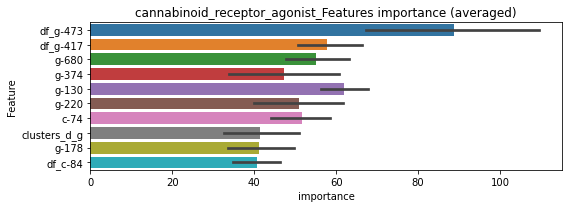

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233259	valid_1's binary_logloss: 0.0420299
[200]	training's binary_logloss: 0.00394356	valid_1's binary_logloss: 0.0182517
[300]	training's binary_logloss: 0.00108219	valid_1's binary_logloss: 0.0134896
[400]	training's binary_logloss: 0.000496267	valid_1's binary_logloss: 0.0125897
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000371845	valid_1's binary_logloss: 0.0122911


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235143	valid_1's binary_logloss: 0.0457737
[200]	training's binary_logloss: 0.00409281	valid_1's binary_logloss: 0.0199381
[300]	training's binary_logloss: 0.00113665	valid_1's binary_logloss: 0.0126673
[400]	training's binary_logloss: 0.000519953	valid_1's binary_logloss: 0.0107041
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000408846	valid_1's binary_logloss: 0.0101781


cannabinoid_receptor_agonist logloss: 0.011234634644831125
cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451515	valid_1's binary_logloss: 0.0838855
[200]	training's binary_logloss: 0.0087662	valid_1's binary_logloss: 0.0397999
[300]	training's binary_logloss: 0.00249456	valid_1's binary_logloss: 0.0274718
[400]	training's binary_logloss: 0.00115522	valid_1's binary_logloss: 0.0235541
[500]	training's binary_logloss: 0.000722719	valid_1's binary_logloss: 0.0223534
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000750878	valid_1's binary_logloss: 0.0222008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522243	valid_1's binary_logloss: 0.0865112
[200]	training's binary_logloss: 0.0102132	valid_1's binary_logloss: 0.0392841
[300]	training's binary_logloss: 0.00288484	valid_1's binary_logloss: 0.025611
[400]	training's binary_logloss: 0.00131379	valid_1's binary_logloss: 0.0207038
[500]	training's binary_logloss: 0.000814234	v

1 / 3 AUC score:1.000
y_Threshold: 0.0061047, Threshold: 0.0091109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00231, Num_p_label: 80.0, conf_0:0.00820, conf_1:0.01002
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0091109
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_2: 0.0191109
Num_p_label: 11.0, Expected: 9.2, Adj_threshold_3: 0.0291109
threshold: 0.0291109, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483939	valid_1's binary_logloss: 0.0845943
[200]	training's binary_logloss: 0.00893011	valid_1's binary_logloss: 0.036972
[300]	training's binary_logloss: 0.00261133	valid_1's binary_logloss: 0.0250231
[400]	training's binary_logloss: 0.00120733	valid_1's binary_logloss: 0.020902
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000877562	valid_1's binary_logloss: 0.0197155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498505	valid_1's binary_logloss: 0.0908338
[200]	training's binary_logloss: 0.00933345	valid_1's binary_logloss: 0.0366486
[300]	training's binary_logloss: 0.00272761	valid_1's binary_logloss: 0.0231901
[400]	training's binary_logloss: 0.00124813	valid_1's binary_logloss: 0.0183487
[500]	training's binary_logloss: 0.000773678	valid_1's binary_logloss: 0.0160042
Early stopping, best iteration is:
[540]	trai

2 / 3 AUC score:1.000
y_Threshold: 0.0458124, Threshold: 0.0291109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0077850 Vs.target_rate: 0.00231, Num_p_label: 31.0, conf_0:0.02620, conf_1:0.03202
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_1: 0.0291109
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_2: 0.0391109
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_3: 0.0491109
threshold: 0.0491109, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047361	valid_1's binary_logloss: 0.0791246
[200]	training's binary_logloss: 0.00911368	valid_1's binary_logloss: 0.0281536
[300]	training's binary_logloss: 0.00262462	valid_1's binary_logloss: 0.0152096
[400]	training's binary_logloss: 0.00122114	valid_1's binary_logloss: 0.011227
[500]	training's binary_logloss: 0.000762184	valid_1's binary_logloss: 0.00955519
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000700905	valid_1's binary_logloss: 0.00934239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480874	valid_1's binary_logloss: 0.0776871
[200]	training's binary_logloss: 0.00932009	valid_1's binary_logloss: 0.0295795
[300]	training's binary_logloss: 0.00269268	valid_1's binary_logloss: 0.0181235
[400]	training's binary_logloss: 0.00125639	valid_1's binary_logloss: 0.0138591
[500]	training's binary_logloss: 0.00078158

3 / 3 AUC score:1.000
y_Threshold: 0.0356990, Threshold: 0.0491109, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0030136 Vs.target_rate: 0.00231, Num_p_label: 12.0, conf_0:0.04420, conf_1:0.05402
threshold: 0.0491109, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 665.0/7780, y_label_rate: 0.0854756


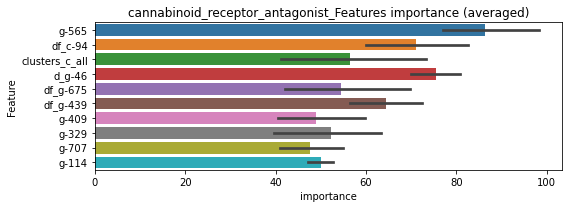

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284321	valid_1's binary_logloss: 0.0577229
[200]	training's binary_logloss: 0.00529597	valid_1's binary_logloss: 0.0306466
[300]	training's binary_logloss: 0.00150004	valid_1's binary_logloss: 0.0253541
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00166023	valid_1's binary_logloss: 0.0252652


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266521	valid_1's binary_logloss: 0.0531009
[200]	training's binary_logloss: 0.0051336	valid_1's binary_logloss: 0.0271443
[300]	training's binary_logloss: 0.00146567	valid_1's binary_logloss: 0.0207075
[400]	training's binary_logloss: 0.000661537	valid_1's binary_logloss: 0.0184562
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000531713	valid_1's binary_logloss: 0.0177978


cannabinoid_receptor_antagonist logloss: 0.021531518423988046


neg labels: 3289 → selected neg labels: 3283


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037951	valid_1's binary_logloss: 0.0587775
[200]	training's binary_logloss: 0.00654457	valid_1's binary_logloss: 0.017522
[300]	training's binary_logloss: 0.00174172	valid_1's binary_logloss: 0.00880927
[400]	training's binary_logloss: 0.000838061	valid_1's binary_logloss: 0.00637886
[500]	training's binary_logloss: 0.000550081	valid_1's binary_logloss: 0.00533327
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00050764	valid_1's binary_logloss: 0.00515116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403256	valid_1's binary_logloss: 0.0663151
[200]	training's binary_logloss: 0.00672919	valid_1's binary_logloss: 0.0246102
[300]	training's binary_logloss: 0.00183681	valid_1's binary_logloss: 0.0160702
[400]	training's binary_logloss: 0.000868911	valid_1's binary_logloss: 0.0138416
Early stopping, best iteration is:
[410]

1 / 3 AUC score:1.000
y_Threshold: 0.0046200, Threshold: 0.0061197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00551, conf_1:0.00673
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0061197
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0161197
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0261197
threshold: 0.0261197, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390752	valid_1's binary_logloss: 0.0570222
[200]	training's binary_logloss: 0.00637558	valid_1's binary_logloss: 0.0147583
[300]	training's binary_logloss: 0.00181671	valid_1's binary_logloss: 0.00612635
[400]	training's binary_logloss: 0.000862543	valid_1's binary_logloss: 0.00393899
[500]	training's binary_logloss: 0.000567364	valid_1's binary_logloss: 0.00313007
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000498511	valid_1's binary_logloss: 0.00289714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386262	valid_1's binary_logloss: 0.0636161
[200]	training's binary_logloss: 0.00596433	valid_1's binary_logloss: 0.0200439
[300]	training's binary_logloss: 0.00169054	valid_1's binary_logloss: 0.011565
[400]	training's binary_logloss: 0.000817922	valid_1's binary_logloss: 0.00897764
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0866133, Threshold: 0.0261197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0050226 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.02351, conf_1:0.02873
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0261197
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0361197
threshold: 0.0361197, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390752	valid_1's binary_logloss: 0.0570222
[200]	training's binary_logloss: 0.00637558	valid_1's binary_logloss: 0.0147583
[300]	training's binary_logloss: 0.00181671	valid_1's binary_logloss: 0.00612635
[400]	training's binary_logloss: 0.000862543	valid_1's binary_logloss: 0.00393899
[500]	training's binary_logloss: 0.000567364	valid_1's binary_logloss: 0.00313007
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000498511	valid_1's binary_logloss: 0.00289714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386262	valid_1's binary_logloss: 0.0636161
[200]	training's binary_logloss: 0.00596433	valid_1's binary_logloss: 0.0200439
[300]	training's binary_logloss: 0.00169054	valid_1's binary_logloss: 0.011565
[400]	training's binary_logloss: 0.000817922	valid_1's binary_logloss: 0.00897764
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0866133, Threshold: 0.0361197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.03251, conf_1:0.03973
threshold: 0.0361197, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


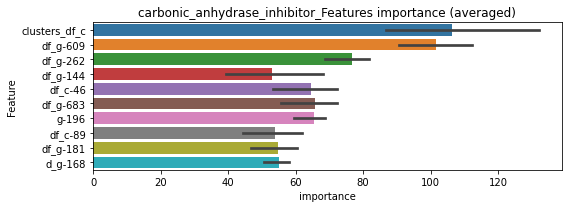

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209853	valid_1's binary_logloss: 0.0357508
[200]	training's binary_logloss: 0.00341426	valid_1's binary_logloss: 0.0140609
[300]	training's binary_logloss: 0.000959755	valid_1's binary_logloss: 0.0104528
[400]	training's binary_logloss: 0.00045097	valid_1's binary_logloss: 0.00988678
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000476137	valid_1's binary_logloss: 0.00982561


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225028	valid_1's binary_logloss: 0.040612
[200]	training's binary_logloss: 0.00364829	valid_1's binary_logloss: 0.0180637
[300]	training's binary_logloss: 0.00100208	valid_1's binary_logloss: 0.0132005
[400]	training's binary_logloss: 0.000462497	valid_1's binary_logloss: 0.0118561
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000347321	valid_1's binary_logloss: 0.0115259


carbonic_anhydrase_inhibitor logloss: 0.010675667000998073
casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335718	valid_1's binary_logloss: 0.0520379
[200]	training's binary_logloss: 0.00535164	valid_1's binary_logloss: 0.0146953
[300]	training's binary_logloss: 0.00153148	valid_1's binary_logloss: 0.00706035
[400]	training's binary_logloss: 0.000759738	valid_1's binary_logloss: 0.00492894
[500]	training's binary_logloss: 0.000510603	valid_1's binary_logloss: 0.00418037
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000463517	valid_1's binary_logloss: 0.00401727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034148	valid_1's binary_logloss: 0.0490099
[200]	training's binary_logloss: 0.00538212	valid_1's binary_logloss: 0.0117931
[300]	training's binary_logloss: 0.00156333	valid_1's binary_logloss: 0.00468703
[400]	training's binary_logloss: 0.000774169	valid_1's binary_logloss: 0.00287433
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0028513, Threshold: 0.0049917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00449, conf_1:0.00549
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0049917
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0149917
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_3: 0.0249917
threshold: 0.0249917, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331602	valid_1's binary_logloss: 0.051088
[200]	training's binary_logloss: 0.00501936	valid_1's binary_logloss: 0.0132422
[300]	training's binary_logloss: 0.00146692	valid_1's binary_logloss: 0.00662613
[400]	training's binary_logloss: 0.000737699	valid_1's binary_logloss: 0.00485184
[500]	training's binary_logloss: 0.000501043	valid_1's binary_logloss: 0.00414586
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000451093	valid_1's binary_logloss: 0.00400107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340538	valid_1's binary_logloss: 0.0478715
[200]	training's binary_logloss: 0.00525202	valid_1's binary_logloss: 0.010639
[300]	training's binary_logloss: 0.00151043	valid_1's binary_logloss: 0.00411754
[400]	training's binary_logloss: 0.000747326	valid_1's binary_logloss: 0.00242581
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0675719, Threshold: 0.0249917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0055249 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.02249, conf_1:0.02749
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.0249917
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0349917
threshold: 0.0349917, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331602	valid_1's binary_logloss: 0.051088
[200]	training's binary_logloss: 0.00501936	valid_1's binary_logloss: 0.0132422
[300]	training's binary_logloss: 0.00146692	valid_1's binary_logloss: 0.00662613
[400]	training's binary_logloss: 0.000737699	valid_1's binary_logloss: 0.00485184
[500]	training's binary_logloss: 0.000501043	valid_1's binary_logloss: 0.00414586
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000451093	valid_1's binary_logloss: 0.00400107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340538	valid_1's binary_logloss: 0.0478715
[200]	training's binary_logloss: 0.00525202	valid_1's binary_logloss: 0.010639
[300]	training's binary_logloss: 0.00151043	valid_1's binary_logloss: 0.00411754
[400]	training's binary_logloss: 0.000747326	valid_1's binary_logloss: 0.00242581
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0675719, Threshold: 0.0349917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.03149, conf_1:0.03849
threshold: 0.0349917, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


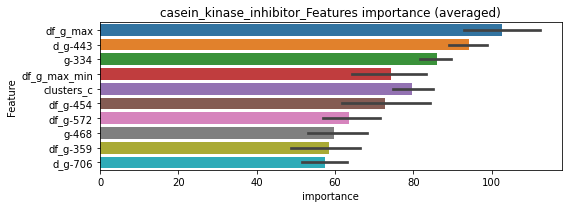

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175334	valid_1's binary_logloss: 0.0345332
[200]	training's binary_logloss: 0.00272164	valid_1's binary_logloss: 0.016073
[300]	training's binary_logloss: 0.000781101	valid_1's binary_logloss: 0.0125454
[400]	training's binary_logloss: 0.000386368	valid_1's binary_logloss: 0.0116725
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000326121	valid_1's binary_logloss: 0.0115126


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176663	valid_1's binary_logloss: 0.0303109
[200]	training's binary_logloss: 0.00271922	valid_1's binary_logloss: 0.0108699
[300]	training's binary_logloss: 0.000809701	valid_1's binary_logloss: 0.00731652
[400]	training's binary_logloss: 0.000402445	valid_1's binary_logloss: 0.00625124
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000330177	valid_1's binary_logloss: 0.00603631


casein_kinase_inhibitor logloss: 0.008774813949277009
caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242811	valid_1's binary_logloss: 0.0303138
[200]	training's binary_logloss: 0.00291312	valid_1's binary_logloss: 0.00512719
[300]	training's binary_logloss: 0.000819695	valid_1's binary_logloss: 0.00185198
[400]	training's binary_logloss: 0.000428971	valid_1's binary_logloss: 0.00111116
[500]	training's binary_logloss: 0.000348539	valid_1's binary_logloss: 0.000954902
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000341406	valid_1's binary_logloss: 0.000940659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241428	valid_1's binary_logloss: 0.0338743
[200]	training's binary_logloss: 0.0029678	valid_1's binary_logloss: 0.00699456
[300]	training's binary_logloss: 0.000831873	valid_1's binary_logloss: 0.00300312
[400]	training's binary_logloss: 0.000429863	valid_1's binary_logloss: 0.00202347
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0016993, Threshold: 0.0028950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00261, conf_1:0.00318
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028950
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0128950
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0228950
threshold: 0.0228950, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237809	valid_1's binary_logloss: 0.0293425
[200]	training's binary_logloss: 0.00280804	valid_1's binary_logloss: 0.00466992
[300]	training's binary_logloss: 0.00081018	valid_1's binary_logloss: 0.00168472
[400]	training's binary_logloss: 0.000423827	valid_1's binary_logloss: 0.000983354
[500]	training's binary_logloss: 0.000340861	valid_1's binary_logloss: 0.000833242
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000334738	valid_1's binary_logloss: 0.000824835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237014	valid_1's binary_logloss: 0.0324356
[200]	training's binary_logloss: 0.0028158	valid_1's binary_logloss: 0.00776353
[300]	training's binary_logloss: 0.000797802	valid_1's binary_logloss: 0.00413079
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000474793	valid_1's binary_logloss: 0.0033

2 / 3 AUC score:1.000
y_Threshold: 0.0231554, Threshold: 0.0228950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.02061, conf_1:0.02518
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.0228950
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0328950
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0428950
threshold: 0.0428950, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237809	valid_1's binary_logloss: 0.0293425
[200]	training's binary_logloss: 0.00280804	valid_1's binary_logloss: 0.00466992
[300]	training's binary_logloss: 0.00081018	valid_1's binary_logloss: 0.00168472
[400]	training's binary_logloss: 0.000423827	valid_1's binary_logloss: 0.000983354
[500]	training's binary_logloss: 0.000340861	valid_1's binary_logloss: 0.000833242
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000334738	valid_1's binary_logloss: 0.000824835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237014	valid_1's binary_logloss: 0.0324356
[200]	training's binary_logloss: 0.0028158	valid_1's binary_logloss: 0.00776353
[300]	training's binary_logloss: 0.000797802	valid_1's binary_logloss: 0.00413079
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000474793	valid_1's binary_logloss: 0.0033

3 / 3 AUC score:1.000
y_Threshold: 0.0231554, Threshold: 0.0428950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.03861, conf_1:0.04718
threshold: 0.0428950, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


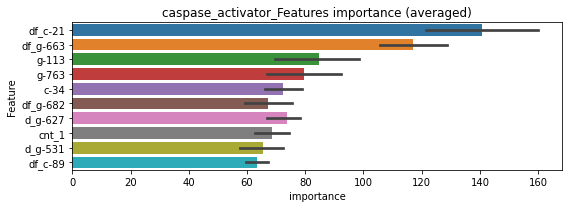

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127129	valid_1's binary_logloss: 0.0197215
[200]	training's binary_logloss: 0.00149202	valid_1's binary_logloss: 0.00701851
[300]	training's binary_logloss: 0.000413157	valid_1's binary_logloss: 0.00606318
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000369654	valid_1's binary_logloss: 0.00600592


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133054	valid_1's binary_logloss: 0.0173907
[200]	training's binary_logloss: 0.00164401	valid_1's binary_logloss: 0.00346814
[300]	training's binary_logloss: 0.000451046	valid_1's binary_logloss: 0.00192775
[400]	training's binary_logloss: 0.000229347	valid_1's binary_logloss: 0.00163194
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000188131	valid_1's binary_logloss: 0.00156272


caspase_activator logloss: 0.0037843175632338998
catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230785	valid_1's binary_logloss: 0.0312818
[200]	training's binary_logloss: 0.00278334	valid_1's binary_logloss: 0.00636354
[300]	training's binary_logloss: 0.000797396	valid_1's binary_logloss: 0.00296628
[400]	training's binary_logloss: 0.000425065	valid_1's binary_logloss: 0.00215492
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000343933	valid_1's binary_logloss: 0.00192297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240522	valid_1's binary_logloss: 0.0340937
[200]	training's binary_logloss: 0.00288063	valid_1's binary_logloss: 0.00696442
[300]	training's binary_logloss: 0.000822729	valid_1's binary_logloss: 0.00324065
[400]	training's binary_logloss: 0.00043528	valid_1's binary_logloss: 0.00232334
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00036709	valid_1's binary_logloss: 0.0021395

1 / 3 AUC score:1.000
y_Threshold: 0.0014063, Threshold: 0.0019867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00179, conf_1:0.00219
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019867
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0119867
threshold: 0.0119867, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234223	valid_1's binary_logloss: 0.0311858
[200]	training's binary_logloss: 0.00273966	valid_1's binary_logloss: 0.00637171
[300]	training's binary_logloss: 0.000791117	valid_1's binary_logloss: 0.00317858
[400]	training's binary_logloss: 0.000425121	valid_1's binary_logloss: 0.0023455
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00035212	valid_1's binary_logloss: 0.00214169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241708	valid_1's binary_logloss: 0.0340825
[200]	training's binary_logloss: 0.00284012	valid_1's binary_logloss: 0.00714269
[300]	training's binary_logloss: 0.000809644	valid_1's binary_logloss: 0.00327783
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000513302	valid_1's binary_logloss: 0.0024999


2 / 3 AUC score:1.000
y_Threshold: 0.0539178, Threshold: 0.0119867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.01079, conf_1:0.01319
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0119867
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0219867
threshold: 0.0219867, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234223	valid_1's binary_logloss: 0.0311858
[200]	training's binary_logloss: 0.00273966	valid_1's binary_logloss: 0.00637171
[300]	training's binary_logloss: 0.000791117	valid_1's binary_logloss: 0.00317858
[400]	training's binary_logloss: 0.000425121	valid_1's binary_logloss: 0.0023455
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00035212	valid_1's binary_logloss: 0.00214169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241708	valid_1's binary_logloss: 0.0340825
[200]	training's binary_logloss: 0.00284012	valid_1's binary_logloss: 0.00714269
[300]	training's binary_logloss: 0.000809644	valid_1's binary_logloss: 0.00327783
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000513302	valid_1's binary_logloss: 0.0024999


3 / 3 AUC score:1.000
y_Threshold: 0.0539178, Threshold: 0.0219867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.01979, conf_1:0.02419
threshold: 0.0219867, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


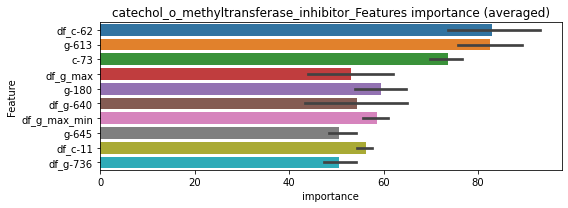

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128367	valid_1's binary_logloss: 0.019028
[200]	training's binary_logloss: 0.00147317	valid_1's binary_logloss: 0.00602245
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000543013	valid_1's binary_logloss: 0.00495442


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126205	valid_1's binary_logloss: 0.0171218
[200]	training's binary_logloss: 0.00149828	valid_1's binary_logloss: 0.00389322
[300]	training's binary_logloss: 0.000424184	valid_1's binary_logloss: 0.00220608
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000271322	valid_1's binary_logloss: 0.00196609


catechol_o_methyltransferase_inhibitor logloss: 0.00346044295344663
cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105347	valid_1's binary_logloss: 0.181777
[200]	training's binary_logloss: 0.0524243	valid_1's binary_logloss: 0.160193
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0515427	valid_1's binary_logloss: 0.160033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128157	valid_1's binary_logloss: 0.160412
[200]	training's binary_logloss: 0.067923	valid_1's binary_logloss: 0.128018
[300]	training's binary_logloss: 0.0390299	valid_1's binary_logloss: 0.117441
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0240422	valid_1's binary_logloss: 0.114106


1 / 3 AUC score:0.964
y_Threshold: 0.1180670, Threshold: 0.2095207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 288 → Positive_corect_labels: 576/3638
p_label_rate: 0.0200904 Vs.target_rate: 0.00428, Num_p_label: 80.0, conf_0:0.18857, conf_1:0.23047
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.2095207
Num_p_label: 70.0, Expected: 17.1, Adj_threshold_2: 0.2195207
Num_p_label: 64.0, Expected: 17.1, Adj_threshold_3: 0.2295207
Num_p_label: 57.0, Expected: 17.1, Adj_threshold_4: 0.2395207
Num_p_label: 56.0, Expected: 17.1, Adj_threshold_5: 0.2495207
Num_p_label: 49.0, Expected: 17.1, Adj_threshold_6: 0.2595207
Num_p_label: 42.0, Expected: 17.1, Adj_threshold_7: 0.2695207
Num_p_label: 38.0, Expected: 17.1, Adj_threshold_8: 0.2795207
Num_p_label: 35.0, Expected: 17.1, Adj_threshold_9: 0.2895207
Num_p_label: 27.0, Expected: 17.1, Adj_threshold_10: 0.2995207
threshold: 0.2995207, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 576.0/3638, y_label_rate: 0.158328

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690519	valid_1's binary_logloss: 0.10828
[200]	training's binary_logloss: 0.026351	valid_1's binary_logloss: 0.0723407
[300]	training's binary_logloss: 0.0116294	valid_1's binary_logloss: 0.0633904
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00662389	valid_1's binary_logloss: 0.0591257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692933	valid_1's binary_logloss: 0.112623
[200]	training's binary_logloss: 0.0244755	valid_1's binary_logloss: 0.0790673


2 / 3 AUC score:0.994
y_Threshold: 0.1409460, Threshold: 0.2995207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 544.0/3574


[300]	training's binary_logloss: 0.0105014	valid_1's binary_logloss: 0.069813
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00767727	valid_1's binary_logloss: 0.067852


p_label_rate: 0.0145655 Vs.target_rate: 0.00428, Num_p_label: 58.0, conf_0:0.26957, conf_1:0.32947
Num_p_label: 58.0, Expected: 17.1, Adj_threshold_1: 0.2995207
Num_p_label: 56.0, Expected: 17.1, Adj_threshold_2: 0.3095207
Num_p_label: 52.0, Expected: 17.1, Adj_threshold_3: 0.3195207
Num_p_label: 48.0, Expected: 17.1, Adj_threshold_4: 0.3295207
Num_p_label: 45.0, Expected: 17.1, Adj_threshold_5: 0.3395207
Num_p_label: 44.0, Expected: 17.1, Adj_threshold_6: 0.3495207
Num_p_label: 44.0, Expected: 17.1, Adj_threshold_7: 0.3595207
Num_p_label: 40.0, Expected: 17.1, Adj_threshold_8: 0.3695207
Num_p_label: 38.0, Expected: 17.1, Adj_threshold_9: 0.3795207
Num_p_label: 36.0, Expected: 17.1, Adj_threshold_10: 0.3895207
threshold: 0.3995207, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 544.0/3574, y_label_rate: 0.1522104
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523345	valid_1's binary_logloss: 0.0966853
[200]	training's binary_logloss: 0.0157985	valid_1's binary_logloss: 0.069414
[300]	training's binary_logloss: 0.00637876	valid_1's binary_logloss: 0.0595482
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00627963	valid_1's binary_logloss: 0.059396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05567	valid_1's binary_logloss: 0.0862689
[200]	training's binary_logloss: 0.0167372	valid_1's binary_logloss: 0.05079
[300]	training's binary_logloss: 0.00685912	valid_1's binary_logloss: 0.043021
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00451115	valid_1's binary_logloss: 0.0405242


3 / 3 AUC score:0.997
y_Threshold: 0.1329964, Threshold: 0.3995207, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 519.0/3524
p_label_rate: 0.0105475 Vs.target_rate: 0.00428, Num_p_label: 42.0, conf_0:0.35957, conf_1:0.43947
threshold: 0.3995207, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 561.0/7506, y_label_rate: 0.0747402


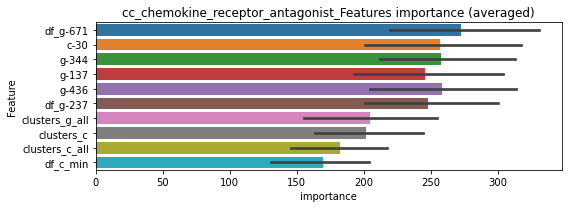

len(train_index) : 3753
len(valid_index) : 3753
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313743	valid_1's binary_logloss: 0.0548324
[200]	training's binary_logloss: 0.0102855	valid_1's binary_logloss: 0.0370122
[300]	training's binary_logloss: 0.00419778	valid_1's binary_logloss: 0.0326881


len(train_index) : 3753
len(valid_index) : 3753
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00353509	valid_1's binary_logloss: 0.0324224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321298	valid_1's binary_logloss: 0.0481673
[200]	training's binary_logloss: 0.00989935	valid_1's binary_logloss: 0.027814
[300]	training's binary_logloss: 0.00425949	valid_1's binary_logloss: 0.0227109
[400]	training's binary_logloss: 0.00224086	valid_1's binary_logloss: 0.0202329


cc_chemokine_receptor_antagonist logloss: 0.026116172765582934


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00193623	valid_1's binary_logloss: 0.01981


cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234097	valid_1's binary_logloss: 0.0296439
[200]	training's binary_logloss: 0.00278616	valid_1's binary_logloss: 0.00482837
[300]	training's binary_logloss: 0.000789216	valid_1's binary_logloss: 0.0016882
[400]	training's binary_logloss: 0.000424487	valid_1's binary_logloss: 0.00101448
[500]	training's binary_logloss: 0.000339055	valid_1's binary_logloss: 0.000848447
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000334525	valid_1's binary_logloss: 0.00084025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237754	valid_1's binary_logloss: 0.0317311
[200]	training's binary_logloss: 0.00277842	valid_1's binary_logloss: 0.00572442
[300]	training's binary_logloss: 0.000793439	valid_1's binary_logloss: 0.0022329
[400]	training's binary_logloss: 0.00042758	valid_1's binary_logloss: 0.00141876
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0020996, Threshold: 0.0031636, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00285, conf_1:0.00348
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0031636
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0131636
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0231636
threshold: 0.0231636, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231111	valid_1's binary_logloss: 0.0283232
[200]	training's binary_logloss: 0.00267224	valid_1's binary_logloss: 0.00449679
[300]	training's binary_logloss: 0.000766882	valid_1's binary_logloss: 0.00150818
[400]	training's binary_logloss: 0.000418133	valid_1's binary_logloss: 0.000920554
[500]	training's binary_logloss: 0.000342283	valid_1's binary_logloss: 0.00078851
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000340974	valid_1's binary_logloss: 0.000785357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230714	valid_1's binary_logloss: 0.0303803
[200]	training's binary_logloss: 0.00262814	valid_1's binary_logloss: 0.0051413
[300]	training's binary_logloss: 0.000757642	valid_1's binary_logloss: 0.00201897
[400]	training's binary_logloss: 0.000412659	valid_1's binary_logloss: 0.00125173
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1373470, Threshold: 0.0231636, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.02085, conf_1:0.02548
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0231636
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0331636
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0431636
threshold: 0.0431636, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231111	valid_1's binary_logloss: 0.0283232
[200]	training's binary_logloss: 0.00267224	valid_1's binary_logloss: 0.00449679
[300]	training's binary_logloss: 0.000766882	valid_1's binary_logloss: 0.00150818
[400]	training's binary_logloss: 0.000418133	valid_1's binary_logloss: 0.000920554
[500]	training's binary_logloss: 0.000342283	valid_1's binary_logloss: 0.00078851
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000340974	valid_1's binary_logloss: 0.000785357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230714	valid_1's binary_logloss: 0.0303803
[200]	training's binary_logloss: 0.00262814	valid_1's binary_logloss: 0.0051413
[300]	training's binary_logloss: 0.000757642	valid_1's binary_logloss: 0.00201897
[400]	training's binary_logloss: 0.000412659	valid_1's binary_logloss: 0.00125173
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1373470, Threshold: 0.0431636, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.03885, conf_1:0.04748
threshold: 0.0431636, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


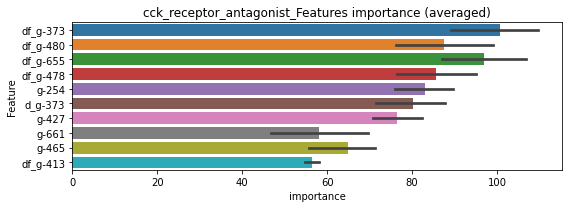

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125914	valid_1's binary_logloss: 0.0220265
[200]	training's binary_logloss: 0.00139776	valid_1's binary_logloss: 0.0103079
[300]	training's binary_logloss: 0.000388863	valid_1's binary_logloss: 0.00932228
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00036595	valid_1's binary_logloss: 0.00925438


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134192	valid_1's binary_logloss: 0.0191417
[200]	training's binary_logloss: 0.00160983	valid_1's binary_logloss: 0.00524899
[300]	training's binary_logloss: 0.000445203	valid_1's binary_logloss: 0.00318382
[400]	training's binary_logloss: 0.000231205	valid_1's binary_logloss: 0.00270831
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000220409	valid_1's binary_logloss: 0.00268661


cck_receptor_antagonist logloss: 0.005970915875582025
cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676


neg labels: 3289 → selected neg labels: 3263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046005	valid_1's binary_logloss: 0.121115
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0128166	valid_1's binary_logloss: 0.109418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448645	valid_1's binary_logloss: 0.119347
[200]	training's binary_logloss: 0.0088492	valid_1's binary_logloss: 0.0987334


1 / 3 AUC score:0.978
y_Threshold: 0.0437692, Threshold: 0.3859927, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00861125	valid_1's binary_logloss: 0.0985648


Remove_noisy_labels: 213 → Positive_corect_labels: 611/3702
p_label_rate: 0.0200904 Vs.target_rate: 0.01478, Num_p_label: 80.0, conf_0:0.34739, conf_1:0.42459
threshold: 0.3859927, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 611.0/3702, y_label_rate: 0.1650459
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341591	valid_1's binary_logloss: 0.070339
[200]	training's binary_logloss: 0.00593424	valid_1's binary_logloss: 0.0484559
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00530197	valid_1's binary_logloss: 0.0478588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328431	valid_1's binary_logloss: 0.0805655


2 / 3 AUC score:0.994
y_Threshold: 0.1502274, Threshold: 0.3859927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 578.0/3636
p_label_rate: 0.0660472 Vs.target_rate: 0.01478, Num_p_label: 263.0, conf_0:0.34739, conf_1:0.42459
Num_p_label: 263.0, Expected: 58.9, Adj_threshold_1: 0.3859927
Num_p_label: 260.0, Expected: 58.9, Adj_threshold_2: 0.3959927
Num_p_label: 259.0, Expected: 58.9, Adj_threshold_3: 0.4059927
Num_p_label: 256.0, Expected: 58.9, Adj_threshold_4: 0.4159927


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00666073	valid_1's binary_logloss: 0.0645172


Num_p_label: 254.0, Expected: 58.9, Adj_threshold_5: 0.4259927
Num_p_label: 253.0, Expected: 58.9, Adj_threshold_6: 0.4359927
Num_p_label: 252.0, Expected: 58.9, Adj_threshold_7: 0.4459927
Num_p_label: 252.0, Expected: 58.9, Adj_threshold_8: 0.4559927
Num_p_label: 249.0, Expected: 58.9, Adj_threshold_9: 0.4659927
Num_p_label: 247.0, Expected: 58.9, Adj_threshold_10: 0.4759927
threshold: 0.4859927, positive_p_label: 245.0/3982, p_label_rate: 0.0615269
positive_y_label: 578.0/3636, y_label_rate: 0.1589659
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249831	valid_1's binary_logloss: 0.0673374
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0111195	valid_1's binary_logloss: 0.0596739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027922	valid_1's binary_logloss: 0.0447782
[200]	training's binary_logloss: 0.00386525	valid_1's binary_logloss: 0.0242048


3 / 3 AUC score:0.994
y_Threshold: 0.1082496, Threshold: 0.4859927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 556.0/3592
p_label_rate: 0.0735811 Vs.target_rate: 0.01478, Num_p_label: 293.0, conf_0:0.43739, conf_1:0.53459
Num_p_label: 293.0, Expected: 58.9, Adj_threshold_1: 0.4859927


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00229678	valid_1's binary_logloss: 0.022747


Num_p_label: 291.0, Expected: 58.9, Adj_threshold_2: 0.4959927
Num_p_label: 289.0, Expected: 58.9, Adj_threshold_3: 0.5059927
Num_p_label: 284.0, Expected: 58.9, Adj_threshold_4: 0.5159927
Num_p_label: 282.0, Expected: 58.9, Adj_threshold_5: 0.5259927
Num_p_label: 279.0, Expected: 58.9, Adj_threshold_6: 0.5359927
Num_p_label: 278.0, Expected: 58.9, Adj_threshold_7: 0.5459927
Num_p_label: 278.0, Expected: 58.9, Adj_threshold_8: 0.5559927
Num_p_label: 277.0, Expected: 58.9, Adj_threshold_9: 0.5659927
Num_p_label: 277.0, Expected: 58.9, Adj_threshold_10: 0.5759927
threshold: 0.5859927, positive_p_label: 277.0/3982, p_label_rate: 0.0695630
positive_y_label: 833.0/7574, y_label_rate: 0.1099815


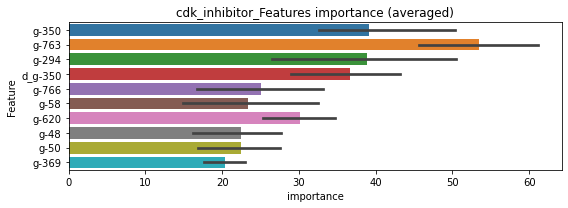

len(train_index) : 3787
len(valid_index) : 3787
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171108	valid_1's binary_logloss: 0.0342832
[200]	training's binary_logloss: 0.00219924	valid_1's binary_logloss: 0.0226236


len(train_index) : 3787
len(valid_index) : 3787


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00147581	valid_1's binary_logloss: 0.0221687


================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170755	valid_1's binary_logloss: 0.0277299
[200]	training's binary_logloss: 0.00218349	valid_1's binary_logloss: 0.0164456
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000958955	valid_1's binary_logloss: 0.0155556


cdk_inhibitor logloss: 0.018862148962175605
chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740134	valid_1's binary_logloss: 0.120606
[200]	training's binary_logloss: 0.0280761	valid_1's binary_logloss: 0.0875992
[300]	training's binary_logloss: 0.0122683	valid_1's binary_logloss: 0.0788582
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0113912	valid_1's binary_logloss: 0.0782588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084921	valid_1's binary_logloss: 0.117597
[200]	training's binary_logloss: 0.0333183	valid_1's binary_logloss: 0.0741382
[300]	training's binary_logloss: 0.0152644	valid_1's binary_logloss: 0.0591501
[400]	training's binary_logloss: 0.00789219	valid_1's binary_logloss: 0.053315
[500]	training's binary_logloss: 0.00459009	valid_1's binary_logloss: 0.0501581
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00412914	valid_1's binary_logloss: 0.0498048


1 / 3 AUC score:0.994
y_Threshold: 0.0662790, Threshold: 0.1487081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 170 → Positive_corect_labels: 637/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.13384, conf_1:0.16358
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.1487081
Num_p_label: 72.0, Expected: 9.0, Adj_threshold_2: 0.1587081
Num_p_label: 70.0, Expected: 9.0, Adj_threshold_3: 0.1687081
Num_p_label: 65.0, Expected: 9.0, Adj_threshold_4: 0.1787081
Num_p_label: 60.0, Expected: 9.0, Adj_threshold_5: 0.1887081
Num_p_label: 59.0, Expected: 9.0, Adj_threshold_6: 0.1987081
Num_p_label: 50.0, Expected: 9.0, Adj_threshold_7: 0.2087081
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_8: 0.2187081
Num_p_label: 46.0, Expected: 9.0, Adj_threshold_9: 0.2287081
Num_p_label: 44.0, Expected: 9.0, Adj_threshold_10: 0.2387081
threshold: 0.2487081, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 637.0/3766, y_label_rate: 0.1691450
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620385	valid_1's binary_logloss: 0.0884444
[200]	training's binary_logloss: 0.0192625	valid_1's binary_logloss: 0.0477896
[300]	training's binary_logloss: 0.00802359	valid_1's binary_logloss: 0.036406
[400]	training's binary_logloss: 0.00414302	valid_1's binary_logloss: 0.032024
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00438654	valid_1's binary_logloss: 0.0319115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060144	valid_1's binary_logloss: 0.0978349
[200]	training's binary_logloss: 0.0171595	valid_1's binary_logloss: 0.0568089
[300]	training's binary_logloss: 0.00721374	valid_1's binary_logloss: 0.0479255
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00461105	valid_1's binary_logloss: 0.0448208


2 / 3 AUC score:0.998
y_Threshold: 0.1896123, Threshold: 0.2487081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 618.0/3728
p_label_rate: 0.0251130 Vs.target_rate: 0.00227, Num_p_label: 100.0, conf_0:0.22384, conf_1:0.27358
Num_p_label: 100.0, Expected: 9.0, Adj_threshold_1: 0.2487081
Num_p_label: 99.0, Expected: 9.0, Adj_threshold_2: 0.2587081
Num_p_label: 98.0, Expected: 9.0, Adj_threshold_3: 0.2687081
Num_p_label: 95.0, Expected: 9.0, Adj_threshold_4: 0.2787081
Num_p_label: 93.0, Expected: 9.0, Adj_threshold_5: 0.2887081
Num_p_label: 90.0, Expected: 9.0, Adj_threshold_6: 0.2987081
Num_p_label: 90.0, Expected: 9.0, Adj_threshold_7: 0.3087081
Num_p_label: 87.0, Expected: 9.0, Adj_threshold_8: 0.3187081
Num_p_label: 84.0, Expected: 9.0, Adj_threshold_9: 0.3287081
Num_p_label: 81.0, Expected: 9.0, Adj_threshold_10: 0.3387081
threshold: 0.3487081, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 618.0/3728, y_label_rate: 0.1657725
=====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570037	valid_1's binary_logloss: 0.0803708
[200]	training's binary_logloss: 0.0152784	valid_1's binary_logloss: 0.0388766
[300]	training's binary_logloss: 0.00617595	valid_1's binary_logloss: 0.0266055
[400]	training's binary_logloss: 0.00328202	valid_1's binary_logloss: 0.0223232
[500]	training's binary_logloss: 0.00216568	valid_1's binary_logloss: 0.0205295
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00177807	valid_1's binary_logloss: 0.0197483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522265	valid_1's binary_logloss: 0.0829766
[200]	training's binary_logloss: 0.0141253	valid_1's binary_logloss: 0.041214
[300]	training's binary_logloss: 0.00536493	valid_1's binary_logloss: 0.029073


3 / 3 AUC score:1.000
y_Threshold: 0.1635554, Threshold: 0.3487081, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.00287379	valid_1's binary_logloss: 0.0259419
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00252035	valid_1's binary_logloss: 0.0255829


Remove_noisy_labels: 22 → Positive_corect_labels: 607.0/3706
p_label_rate: 0.0190859 Vs.target_rate: 0.00227, Num_p_label: 76.0, conf_0:0.31384, conf_1:0.38358
Num_p_label: 76.0, Expected: 9.0, Adj_threshold_1: 0.3487081
Num_p_label: 73.0, Expected: 9.0, Adj_threshold_2: 0.3587081
Num_p_label: 70.0, Expected: 9.0, Adj_threshold_3: 0.3687081
Num_p_label: 68.0, Expected: 9.0, Adj_threshold_4: 0.3787081
Num_p_label: 67.0, Expected: 9.0, Adj_threshold_5: 0.3887081
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_6: 0.3987081
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_7: 0.4087081
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_8: 0.4187081
Num_p_label: 65.0, Expected: 9.0, Adj_threshold_9: 0.4287081
Num_p_label: 63.0, Expected: 9.0, Adj_threshold_10: 0.4387081
threshold: 0.4487081, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 666.0/7688, y_label_rate: 0.0866285


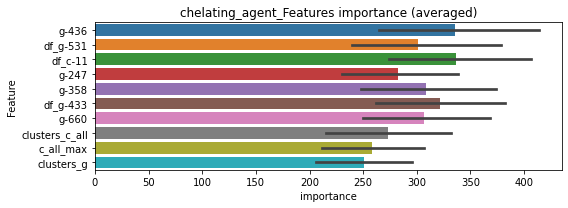

len(train_index) : 3844
len(valid_index) : 3844
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355383	valid_1's binary_logloss: 0.0529627
[200]	training's binary_logloss: 0.0106095	valid_1's binary_logloss: 0.0284787
[300]	training's binary_logloss: 0.00428681	valid_1's binary_logloss: 0.0213787
[400]	training's binary_logloss: 0.00230621	valid_1's binary_logloss: 0.0190474
[500]	training's binary_logloss: 0.00152654	valid_1's binary_logloss: 0.0176797
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00147246	valid_1's binary_logloss: 0.0175661


len(train_index) : 3844
len(valid_index) : 3844
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325621	valid_1's binary_logloss: 0.0559525
[200]	training's binary_logloss: 0.00924931	valid_1's binary_logloss: 0.0337115
[300]	training's binary_logloss: 0.00379127	valid_1's binary_logloss: 0.0282877
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00297175	valid_1's binary_logloss: 0.0272747


chelating_agent logloss: 0.022420422797676816
chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194275	valid_1's binary_logloss: 0.0248734
[200]	training's binary_logloss: 0.00202407	valid_1's binary_logloss: 0.00415767
[300]	training's binary_logloss: 0.000566238	valid_1's binary_logloss: 0.00183148
[400]	training's binary_logloss: 0.000318536	valid_1's binary_logloss: 0.0013405
[500]	training's binary_logloss: 0.00026744	valid_1's binary_logloss: 0.00119784
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000260804	valid_1's binary_logloss: 0.00118106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189869	valid_1's binary_logloss: 0.0230752
[200]	training's binary_logloss: 0.00196379	valid_1's binary_logloss: 0.00422474
[300]	training's binary_logloss: 0.000563009	valid_1's binary_logloss: 0.00245564
[400]	training's binary_logloss: 0.000319902	valid_1's binary_logloss: 0.00202716
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0018937, Threshold: 0.0072723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00655, conf_1:0.00800
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0072723
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_2: 0.0172723
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_3: 0.0272723
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_4: 0.0372723
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_5: 0.0472723
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_6: 0.0572723
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_7: 0.0672723
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_8: 0.0772723
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_9: 0.0872723
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_10: 0.0972723
threshold: 0.1072723, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187513	valid_1's binary_logloss: 0.023099
[200]	training's binary_logloss: 0.00175765	valid_1's binary_logloss: 0.00306148
[300]	training's binary_logloss: 0.000473809	valid_1's binary_logloss: 0.00112659
[400]	training's binary_logloss: 0.000274307	valid_1's binary_logloss: 0.000769763
[500]	training's binary_logloss: 0.000234452	valid_1's binary_logloss: 0.000690155
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000232454	valid_1's binary_logloss: 0.000685815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185442	valid_1's binary_logloss: 0.0209504
[200]	training's binary_logloss: 0.0017605	valid_1's binary_logloss: 0.00241997
[300]	training's binary_logloss: 0.000472206	valid_1's binary_logloss: 0.000794272
[400]	training's binary_logloss: 0.00027308	valid_1's binary_logloss: 0.000513653
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.2474970, Threshold: 0.1072723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0160723 Vs.target_rate: 0.00101, Num_p_label: 64.0, conf_0:0.09655, conf_1:0.11800
Num_p_label: 64.0, Expected: 4.0, Adj_threshold_1: 0.1072723
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_2: 0.1172723
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_3: 0.1272723
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_4: 0.1372723
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_5: 0.1472723
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_6: 0.1572723
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_7: 0.1672723
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_8: 0.1772723
Num_p_label: 51.0, Expected: 4.0, Adj_threshold_9: 0.1872723
Num_p_label: 49.0, Expected: 4.0, Adj_threshold_10: 0.1972723
threshold: 0.2072723, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187513	valid_1's binary_logloss: 0.023099
[200]	training's binary_logloss: 0.00175765	valid_1's binary_logloss: 0.00306148
[300]	training's binary_logloss: 0.000473809	valid_1's binary_logloss: 0.00112659
[400]	training's binary_logloss: 0.000274307	valid_1's binary_logloss: 0.000769763
[500]	training's binary_logloss: 0.000234452	valid_1's binary_logloss: 0.000690155
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000232454	valid_1's binary_logloss: 0.000685815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185442	valid_1's binary_logloss: 0.0209504
[200]	training's binary_logloss: 0.0017605	valid_1's binary_logloss: 0.00241997
[300]	training's binary_logloss: 0.000472206	valid_1's binary_logloss: 0.000794272
[400]	training's binary_logloss: 0.00027308	valid_1's binary_logloss: 0.000513653
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.2474970, Threshold: 0.2072723, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0120542 Vs.target_rate: 0.00101, Num_p_label: 48.0, conf_0:0.18655, conf_1:0.22800
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_1: 0.2072723
Num_p_label: 46.0, Expected: 4.0, Adj_threshold_2: 0.2172723
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_3: 0.2272723
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_4: 0.2372723
Num_p_label: 42.0, Expected: 4.0, Adj_threshold_5: 0.2472723
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_6: 0.2572723
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_7: 0.2672723
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_8: 0.2772723
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_9: 0.2872723
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_10: 0.2972723
threshold: 0.3072723, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 691.0/7792, y_label_rate: 0.0886807


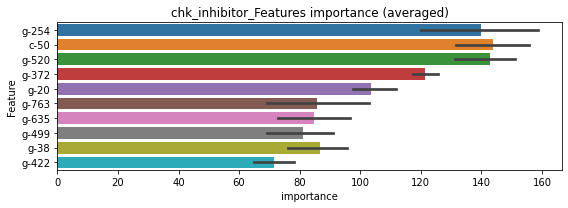

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110589	valid_1's binary_logloss: 0.0184988
[200]	training's binary_logloss: 0.0011907	valid_1's binary_logloss: 0.00779063


len(train_index) : 3896
len(valid_index) : 3896


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000429082	valid_1's binary_logloss: 0.00686344


================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113713	valid_1's binary_logloss: 0.0174155
[200]	training's binary_logloss: 0.00122157	valid_1's binary_logloss: 0.00587782
[300]	training's binary_logloss: 0.00034436	valid_1's binary_logloss: 0.00468879
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000243338	valid_1's binary_logloss: 0.00450631


chk_inhibitor logloss: 0.005684872136892044
chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388696	valid_1's binary_logloss: 0.0663454
[200]	training's binary_logloss: 0.00639167	valid_1's binary_logloss: 0.0225442
[300]	training's binary_logloss: 0.00181502	valid_1's binary_logloss: 0.0131506
[400]	training's binary_logloss: 0.000884829	valid_1's binary_logloss: 0.0102169
[500]	training's binary_logloss: 0.000578284	valid_1's binary_logloss: 0.00909882
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000586477	valid_1's binary_logloss: 0.00903635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413121	valid_1's binary_logloss: 0.0695211
[200]	training's binary_logloss: 0.00688096	valid_1's binary_logloss: 0.0233674
[300]	training's binary_logloss: 0.0019435	valid_1's binary_logloss: 0.0131964
[400]	training's binary_logloss: 0.000929949	valid_1's binary_logloss: 0.00984995
[500]	training's binary_logloss: 0.0006

1 / 3 AUC score:1.000
y_Threshold: 0.0046751, Threshold: 0.0077440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00697, conf_1:0.00852
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0077440
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_2: 0.0177440
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_3: 0.0277440
threshold: 0.0277440, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387844	valid_1's binary_logloss: 0.0653503
[200]	training's binary_logloss: 0.00625934	valid_1's binary_logloss: 0.020256
[300]	training's binary_logloss: 0.00177998	valid_1's binary_logloss: 0.0108584
[400]	training's binary_logloss: 0.000864256	valid_1's binary_logloss: 0.00820053
[500]	training's binary_logloss: 0.000577637	valid_1's binary_logloss: 0.00709881
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000521446	valid_1's binary_logloss: 0.00674045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395265	valid_1's binary_logloss: 0.064641
[200]	training's binary_logloss: 0.00655443	valid_1's binary_logloss: 0.0209511
[300]	training's binary_logloss: 0.00189567	valid_1's binary_logloss: 0.0117244
[400]	training's binary_logloss: 0.000906657	valid_1's binary_logloss: 0.00917332
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.0487917, Threshold: 0.0277440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0077850 Vs.target_rate: 0.00176, Num_p_label: 31.0, conf_0:0.02497, conf_1:0.03052
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_1: 0.0277440
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_2: 0.0377440
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_3: 0.0477440
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.0577440
threshold: 0.0577440, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387844	valid_1's binary_logloss: 0.0653503
[200]	training's binary_logloss: 0.00625934	valid_1's binary_logloss: 0.020256
[300]	training's binary_logloss: 0.00177998	valid_1's binary_logloss: 0.0108584
[400]	training's binary_logloss: 0.000864256	valid_1's binary_logloss: 0.00820053
[500]	training's binary_logloss: 0.000577637	valid_1's binary_logloss: 0.00709881
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000521446	valid_1's binary_logloss: 0.00674045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395265	valid_1's binary_logloss: 0.064641
[200]	training's binary_logloss: 0.00655443	valid_1's binary_logloss: 0.0209511
[300]	training's binary_logloss: 0.00189567	valid_1's binary_logloss: 0.0117244
[400]	training's binary_logloss: 0.000906657	valid_1's binary_logloss: 0.00917332
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0487917, Threshold: 0.0577440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0027624 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.05197, conf_1:0.06352
threshold: 0.0577440, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7788, y_label_rate: 0.0856446


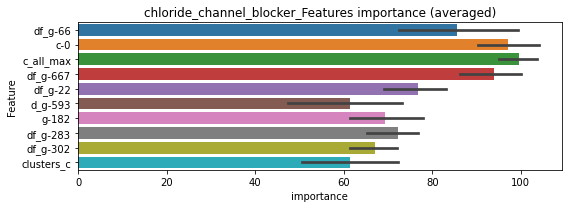

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208452	valid_1's binary_logloss: 0.0405976
[200]	training's binary_logloss: 0.00343345	valid_1's binary_logloss: 0.0178849
[300]	training's binary_logloss: 0.000969484	valid_1's binary_logloss: 0.0139382
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000561563	valid_1's binary_logloss: 0.0134163


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219929	valid_1's binary_logloss: 0.0398344
[200]	training's binary_logloss: 0.00375771	valid_1's binary_logloss: 0.0169344
[300]	training's binary_logloss: 0.00105831	valid_1's binary_logloss: 0.0117193
[400]	training's binary_logloss: 0.000497088	valid_1's binary_logloss: 0.010691
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000497088	valid_1's binary_logloss: 0.010691


chloride_channel_blocker logloss: 0.012053674692858977
cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784252	valid_1's binary_logloss: 0.128175
[200]	training's binary_logloss: 0.0293914	valid_1's binary_logloss: 0.0888142
[300]	training's binary_logloss: 0.0124126	valid_1's binary_logloss: 0.0761206
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0124126	valid_1's binary_logloss: 0.0761206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087473	valid_1's binary_logloss: 0.115208
[200]	training's binary_logloss: 0.0372073	valid_1's binary_logloss: 0.0734013
[300]	training's binary_logloss: 0.0165085	valid_1's binary_logloss: 0.0580013


1 / 3 AUC score:0.995
y_Threshold: 0.0909160, Threshold: 0.1984195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 635/3763
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.17858, conf_1:0.21826
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.1984195
Num_p_label: 78.0, Expected: 8.0, Adj_threshold_2: 0.2084195


[400]	training's binary_logloss: 0.00835601	valid_1's binary_logloss: 0.0502202
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00835601	valid_1's binary_logloss: 0.0502202


Num_p_label: 75.0, Expected: 8.0, Adj_threshold_3: 0.2184195
Num_p_label: 67.0, Expected: 8.0, Adj_threshold_4: 0.2284195
Num_p_label: 65.0, Expected: 8.0, Adj_threshold_5: 0.2384195
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_6: 0.2484195
Num_p_label: 59.0, Expected: 8.0, Adj_threshold_7: 0.2584195
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_8: 0.2684195
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_9: 0.2784195
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_10: 0.2884195
threshold: 0.2984195, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 635.0/3763, y_label_rate: 0.1687483
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622302	valid_1's binary_logloss: 0.0909841
[200]	training's binary_logloss: 0.0193062	valid_1's binary_logloss: 0.0444315
[300]	training's binary_logloss: 0.0078159	valid_1's binary_logloss: 0.0302756
[400]	training's binary_logloss: 0.00409825	valid_1's binary_logloss: 0.024767
[500]	training's binary_logloss: 0.00264019	valid_1's binary_logloss: 0.0225982
[600]	training's binary_logloss: 0.00195088	valid_1's binary_logloss: 0.0210703
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.0018604	valid_1's binary_logloss: 0.0207859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611414	valid_1's binary_logloss: 0.090842
[200]	training's binary_logloss: 0.0183082	valid_1's binary_logloss: 0.0476442
[300]	training's binary_logloss: 0.00734773	valid_1's binary_logloss: 0.0360404
[400]	training's binary_logloss: 0.00374192	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.1909111, Threshold: 0.2984195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 618.0/3729
p_label_rate: 0.0298845 Vs.target_rate: 0.00202, Num_p_label: 119.0, conf_0:0.26858, conf_1:0.32826
Num_p_label: 119.0, Expected: 8.0, Adj_threshold_1: 0.2984195
Num_p_label: 116.0, Expected: 8.0, Adj_threshold_2: 0.3084195
Num_p_label: 111.0, Expected: 8.0, Adj_threshold_3: 0.3184195
Num_p_label: 111.0, Expected: 8.0, Adj_threshold_4: 0.3284195
Num_p_label: 110.0, Expected: 8.0, Adj_threshold_5: 0.3384195
Num_p_label: 106.0, Expected: 8.0, Adj_threshold_6: 0.3484195
Num_p_label: 105.0, Expected: 8.0, Adj_threshold_7: 0.3584195
Num_p_label: 100.0, Expected: 8.0, Adj_threshold_8: 0.3684195
Num_p_label: 97.0, Expected: 8.0, Adj_threshold_9: 0.3784195
Num_p_label: 97.0, Expected: 8.0, Adj_threshold_10: 0.3884195
threshold: 0.3984195, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 618.0/3729, y_label_rate: 0.165728

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053925	valid_1's binary_logloss: 0.082041
[200]	training's binary_logloss: 0.0154971	valid_1's binary_logloss: 0.0391832
[300]	training's binary_logloss: 0.00570425	valid_1's binary_logloss: 0.0255078
[400]	training's binary_logloss: 0.00305227	valid_1's binary_logloss: 0.0209694
[500]	training's binary_logloss: 0.00204206	valid_1's binary_logloss: 0.0185622
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00164003	valid_1's binary_logloss: 0.0177647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060164	valid_1's binary_logloss: 0.089154
[200]	training's binary_logloss: 0.0183718	valid_1's binary_logloss: 0.0450554
[300]	training's binary_logloss: 0.00693416	valid_1's binary_logloss: 0.0307981


3 / 3 AUC score:1.000
y_Threshold: 0.2103196, Threshold: 0.3984195, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 611.0/3715
p_label_rate: 0.0215972 Vs.target_rate: 0.00202, Num_p_label: 86.0, conf_0:0.35858, conf_1:0.43826
Num_p_label: 86.0, Expected: 8.0, Adj_threshold_1: 0.3984195
Num_p_label: 85.0, Expected: 8.0, Adj_threshold_2: 0.4084195
Num_p_label: 84.0, Expected: 8.0, Adj_threshold_3: 0.4184195
Num_p_label: 82.0, Expected: 8.0, Adj_threshold_4: 0.4284195
Num_p_label: 79.0, Expected: 8.0, Adj_threshold_5: 0.4384195
Num_p_label: 78.0, Expected: 8.0, Adj_threshold_6: 0.4484195


[400]	training's binary_logloss: 0.00351287	valid_1's binary_logloss: 0.0245188
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00356326	valid_1's binary_logloss: 0.0244764


Num_p_label: 74.0, Expected: 8.0, Adj_threshold_7: 0.4584195
Num_p_label: 73.0, Expected: 8.0, Adj_threshold_8: 0.4684195
Num_p_label: 72.0, Expected: 8.0, Adj_threshold_9: 0.4784195
Num_p_label: 72.0, Expected: 8.0, Adj_threshold_10: 0.4884195
threshold: 0.4984195, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 682.0/7697, y_label_rate: 0.0886060


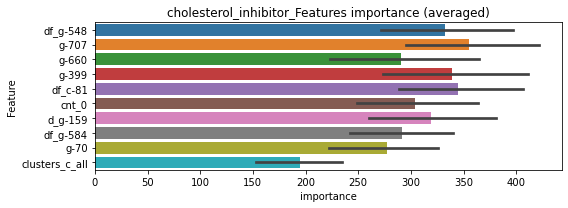

len(train_index) : 3848
len(valid_index) : 3849
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354423	valid_1's binary_logloss: 0.0567685
[200]	training's binary_logloss: 0.0110267	valid_1's binary_logloss: 0.0326608
[300]	training's binary_logloss: 0.00457295	valid_1's binary_logloss: 0.0255874
[400]	training's binary_logloss: 0.00238539	valid_1's binary_logloss: 0.0236219
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00231546	valid_1's binary_logloss: 0.0235708


len(train_index) : 3849
len(valid_index) : 3848
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397477	valid_1's binary_logloss: 0.0627536
[200]	training's binary_logloss: 0.0124308	valid_1's binary_logloss: 0.0348726
[300]	training's binary_logloss: 0.00521106	valid_1's binary_logloss: 0.0258627
[400]	training's binary_logloss: 0.00266315	valid_1's binary_logloss: 0.0225166
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.0021432	valid_1's binary_logloss: 0.0218794


cholesterol_inhibitor logloss: 0.022725185783928452
cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482673	valid_1's binary_logloss: 0.089192
[200]	training's binary_logloss: 0.0095684	valid_1's binary_logloss: 0.0419924
[300]	training's binary_logloss: 0.00264383	valid_1's binary_logloss: 0.0282875
[400]	training's binary_logloss: 0.00120817	valid_1's binary_logloss: 0.0246124
[500]	training's binary_logloss: 0.000762722	valid_1's binary_logloss: 0.0227944
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000651262	valid_1's binary_logloss: 0.0222382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490441	valid_1's binary_logloss: 0.0921857
[200]	training's binary_logloss: 0.00934456	valid_1's binary_logloss: 0.0436588
[300]	training's binary_logloss: 0.00270876	valid_1's binary_logloss: 0.0316783
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00133179	valid_1's binary_logloss: 0.0291356


1 / 3 AUC score:0.999
y_Threshold: 0.0071010, Threshold: 0.0124653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00227, Num_p_label: 80.0, conf_0:0.01122, conf_1:0.01371
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0124653
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_2: 0.0224653
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_3: 0.0324653
threshold: 0.0324653, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489687	valid_1's binary_logloss: 0.0835209
[200]	training's binary_logloss: 0.00906856	valid_1's binary_logloss: 0.033644
[300]	training's binary_logloss: 0.00253954	valid_1's binary_logloss: 0.0221076
[400]	training's binary_logloss: 0.00117637	valid_1's binary_logloss: 0.0181003
[500]	training's binary_logloss: 0.000755271	valid_1's binary_logloss: 0.0167729
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000613687	valid_1's binary_logloss: 0.0162631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478362	valid_1's binary_logloss: 0.0872452
[200]	training's binary_logloss: 0.00912368	valid_1's binary_logloss: 0.035322
[300]	training's binary_logloss: 0.00264149	valid_1's binary_logloss: 0.0209403
[400]	training's binary_logloss: 0.00122567	valid_1's binary_logloss: 0.0162378
[500]	training's binary_logloss: 0.000781107	

2 / 3 AUC score:1.000
y_Threshold: 0.0366822, Threshold: 0.0324653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3792
p_label_rate: 0.0082873 Vs.target_rate: 0.00227, Num_p_label: 33.0, conf_0:0.02922, conf_1:0.03571
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_1: 0.0324653
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.0424653
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_3: 0.0524653
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_4: 0.0624653
threshold: 0.0624653, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463445	valid_1's binary_logloss: 0.0807154
[200]	training's binary_logloss: 0.00870252	valid_1's binary_logloss: 0.0299024
[300]	training's binary_logloss: 0.0025251	valid_1's binary_logloss: 0.017014
[400]	training's binary_logloss: 0.00118804	valid_1's binary_logloss: 0.0126507
[500]	training's binary_logloss: 0.000751658	valid_1's binary_logloss: 0.0110208
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00070408	valid_1's binary_logloss: 0.0107261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498755	valid_1's binary_logloss: 0.0849601
[200]	training's binary_logloss: 0.00941352	valid_1's binary_logloss: 0.0340786
[300]	training's binary_logloss: 0.00268663	valid_1's binary_logloss: 0.0213849
[400]	training's binary_logloss: 0.00124196	valid_1's binary_logloss: 0.0173765
[500]	training's binary_logloss: 0.000782809	v

3 / 3 AUC score:1.000
y_Threshold: 0.0491818, Threshold: 0.0624653, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0035158 Vs.target_rate: 0.00227, Num_p_label: 14.0, conf_0:0.05622, conf_1:0.06871
threshold: 0.0624653, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 663.0/7772, y_label_rate: 0.0853062


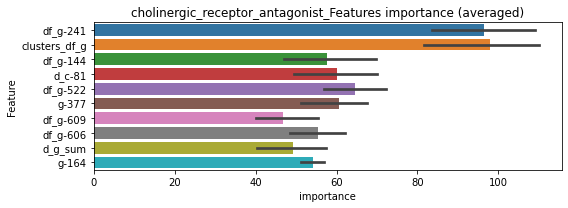

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254188	valid_1's binary_logloss: 0.0561686
[200]	training's binary_logloss: 0.00487617	valid_1's binary_logloss: 0.0307789
[300]	training's binary_logloss: 0.00138577	valid_1's binary_logloss: 0.0260008
[400]	training's binary_logloss: 0.000628632	valid_1's binary_logloss: 0.02483
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000577825	valid_1's binary_logloss: 0.0247844


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025735	valid_1's binary_logloss: 0.0513872
[200]	training's binary_logloss: 0.00488658	valid_1's binary_logloss: 0.0247197
[300]	training's binary_logloss: 0.00142625	valid_1's binary_logloss: 0.0175719
[400]	training's binary_logloss: 0.000656034	valid_1's binary_logloss: 0.0151522
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000446772	valid_1's binary_logloss: 0.0141907


cholinergic_receptor_antagonist logloss: 0.019487558924241852
coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319249	valid_1's binary_logloss: 0.045161
[200]	training's binary_logloss: 0.004285	valid_1's binary_logloss: 0.0101736
[300]	training's binary_logloss: 0.00117371	valid_1's binary_logloss: 0.00422824
[400]	training's binary_logloss: 0.000581499	valid_1's binary_logloss: 0.00277979
[500]	training's binary_logloss: 0.00041135	valid_1's binary_logloss: 0.00232663
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000406448	valid_1's binary_logloss: 0.00231822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330484	valid_1's binary_logloss: 0.0448715
[200]	training's binary_logloss: 0.00454698	valid_1's binary_logloss: 0.00926952
[300]	training's binary_logloss: 0.00121606	valid_1's binary_logloss: 0.00356209
[400]	training's binary_logloss: 0.000595708	valid_1's binary_logloss: 0.00213815
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0023249, Threshold: 0.0034351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00309, conf_1:0.00378
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0034351
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0134351
threshold: 0.0134351, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307914	valid_1's binary_logloss: 0.0437267
[200]	training's binary_logloss: 0.00411798	valid_1's binary_logloss: 0.00969313
[300]	training's binary_logloss: 0.00112681	valid_1's binary_logloss: 0.00414453
[400]	training's binary_logloss: 0.000565057	valid_1's binary_logloss: 0.0027366
[500]	training's binary_logloss: 0.00041559	valid_1's binary_logloss: 0.00230297
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000411921	valid_1's binary_logloss: 0.00228932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03159	valid_1's binary_logloss: 0.0432131
[200]	training's binary_logloss: 0.00427599	valid_1's binary_logloss: 0.00835535
[300]	training's binary_logloss: 0.00117256	valid_1's binary_logloss: 0.00293481
[400]	training's binary_logloss: 0.000582541	valid_1's binary_logloss: 0.00168932
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0786422, Threshold: 0.0134351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0057760 Vs.target_rate: 0.00101, Num_p_label: 23.0, conf_0:0.01209, conf_1:0.01478
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_1: 0.0134351
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0234351
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0334351
threshold: 0.0334351, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307914	valid_1's binary_logloss: 0.0437267
[200]	training's binary_logloss: 0.00411798	valid_1's binary_logloss: 0.00969313
[300]	training's binary_logloss: 0.00112681	valid_1's binary_logloss: 0.00414453
[400]	training's binary_logloss: 0.000565057	valid_1's binary_logloss: 0.0027366
[500]	training's binary_logloss: 0.00041559	valid_1's binary_logloss: 0.00230297
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000411921	valid_1's binary_logloss: 0.00228932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03159	valid_1's binary_logloss: 0.0432131
[200]	training's binary_logloss: 0.00427599	valid_1's binary_logloss: 0.00835535
[300]	training's binary_logloss: 0.00117256	valid_1's binary_logloss: 0.00293481
[400]	training's binary_logloss: 0.000582541	valid_1's binary_logloss: 0.00168932
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0786422, Threshold: 0.0334351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.03009, conf_1:0.03678
threshold: 0.0334351, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


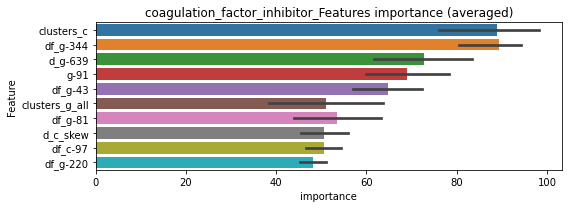

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172753	valid_1's binary_logloss: 0.0268089
[200]	training's binary_logloss: 0.00223853	valid_1's binary_logloss: 0.00840756
[300]	training's binary_logloss: 0.000593499	valid_1's binary_logloss: 0.00636854
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000446656	valid_1's binary_logloss: 0.00627114


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169616	valid_1's binary_logloss: 0.0261979
[200]	training's binary_logloss: 0.00231047	valid_1's binary_logloss: 0.0079122
[300]	training's binary_logloss: 0.000619632	valid_1's binary_logloss: 0.00468395
[400]	training's binary_logloss: 0.000304065	valid_1's binary_logloss: 0.00390427
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000280908	valid_1's binary_logloss: 0.00380261


coagulation_factor_inhibitor logloss: 0.005036876024330296
corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264291	valid_1's binary_logloss: 0.0448128
[200]	training's binary_logloss: 0.00348515	valid_1's binary_logloss: 0.0176537
[300]	training's binary_logloss: 0.00100471	valid_1's binary_logloss: 0.0128985
[400]	training's binary_logloss: 0.000519239	valid_1's binary_logloss: 0.0115131
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000406724	valid_1's binary_logloss: 0.010991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027624	valid_1's binary_logloss: 0.0459501
[200]	training's binary_logloss: 0.00373383	valid_1's binary_logloss: 0.0165133
[300]	training's binary_logloss: 0.001088	valid_1's binary_logloss: 0.0116109
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000599666	valid_1's binary_logloss: 0.0104758


1 / 3 AUC score:1.000
y_Threshold: 0.0024178, Threshold: 0.0064534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00581, conf_1:0.00710
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064534
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_2: 0.0164534
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.0264534
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_4: 0.0364534
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_5: 0.0464534
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_6: 0.0564534
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_7: 0.0664534
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.0764534
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_9: 0.0864534
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_10: 0.0964534
threshold: 0.1064534, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251766	valid_1's binary_logloss: 0.0355029
[200]	training's binary_logloss: 0.00305045	valid_1's binary_logloss: 0.00871006
[300]	training's binary_logloss: 0.000850655	valid_1's binary_logloss: 0.00480952
[400]	training's binary_logloss: 0.000443513	valid_1's binary_logloss: 0.0038842
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000369227	valid_1's binary_logloss: 0.0036702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253705	valid_1's binary_logloss: 0.0358774
[200]	training's binary_logloss: 0.00308569	valid_1's binary_logloss: 0.00993665
[300]	training's binary_logloss: 0.000863484	valid_1's binary_logloss: 0.00658788


2 / 3 AUC score:1.000
y_Threshold: 0.0355070, Threshold: 0.1064534, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000477214	valid_1's binary_logloss: 0.00579455


Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0107986 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.09581, conf_1:0.11710
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.1064534
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.1164534
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_3: 0.1264534
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_4: 0.1364534
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_5: 0.1464534
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_6: 0.1564534
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_7: 0.1664534
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.1764534
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_9: 0.1864534
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_10: 0.1964534
threshold: 0.2064534, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255194	valid_1's binary_logloss: 0.0367107
[200]	training's binary_logloss: 0.0030976	valid_1's binary_logloss: 0.00814775
[300]	training's binary_logloss: 0.000856295	valid_1's binary_logloss: 0.00378958
[400]	training's binary_logloss: 0.000445574	valid_1's binary_logloss: 0.00257679
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000447877	valid_1's binary_logloss: 0.00257403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240779	valid_1's binary_logloss: 0.0474262
[200]	training's binary_logloss: 0.0028783	valid_1's binary_logloss: 0.0183008
[300]	training's binary_logloss: 0.000810297	valid_1's binary_logloss: 0.0135563
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000712391	valid_1's binary_logloss: 0.0132298


3 / 3 AUC score:1.000
y_Threshold: 0.0438343, Threshold: 0.2064534, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0090407 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.18581, conf_1:0.22710
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.2064534
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_2: 0.2164534
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_3: 0.2264534
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_4: 0.2364534
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_5: 0.2464534
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_6: 0.2564534
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_7: 0.2664534
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_8: 0.2764534
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_9: 0.2864534
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_10: 0.2964534
threshold: 0.3064534, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 686.0/7788, y_label_rate: 0.0880842


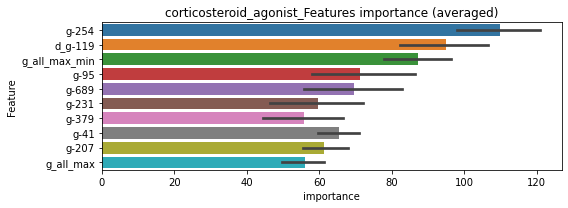

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131691	valid_1's binary_logloss: 0.031519
[200]	training's binary_logloss: 0.00158695	valid_1's binary_logloss: 0.016602
[300]	training's binary_logloss: 0.000444961	valid_1's binary_logloss: 0.0133084
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000281754	valid_1's binary_logloss: 0.012651


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134705	valid_1's binary_logloss: 0.0216639
[200]	training's binary_logloss: 0.00165299	valid_1's binary_logloss: 0.00559859
[300]	training's binary_logloss: 0.000471643	valid_1's binary_logloss: 0.00314721
[400]	training's binary_logloss: 0.000243747	valid_1's binary_logloss: 0.00247514
[500]	training's binary_logloss: 0.000181825	valid_1's binary_logloss: 0.00229034
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00018378	valid_1's binary_logloss: 0.00228254


corticosteroid_agonist logloss: 0.0074667545360155236
cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863


neg labels: 3289 → selected neg labels: 3215


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.274851	valid_1's binary_logloss: 0.414036
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.294379	valid_1's binary_logloss: 0.40838


1 / 3 AUC score:0.708
y_Threshold: 0.2351760, Threshold: 0.3710948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 895 → Positive_corect_labels: 260/2963
p_label_rate: 0.0200904 Vs.target_rate: 0.01827, Num_p_label: 80.0, conf_0:0.33399, conf_1:0.40820
threshold: 0.3710948, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 260.0/2963, y_label_rate: 0.0877489
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685573	valid_1's binary_logloss: 0.157589
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0352877	valid_1's binary_logloss: 0.147672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075627	valid_1's binary_logloss: 0.148073
[200]	training's binary_logloss: 0.0340085	valid_1's binary_logloss: 0.129928


2 / 3 AUC score:0.955
y_Threshold: 0.2104385, Threshold: 0.3710948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 177.0/2797
p_label_rate: 0.0647916 Vs.target_rate: 0.01827, Num_p_label: 258.0, conf_0:0.33399, conf_1:0.40820
Num_p_label: 258.0, Expected: 72.7, Adj_threshold_1: 0.3710948
Num_p_label: 252.0, Expected: 72.7, Adj_threshold_2: 0.3810948
Num_p_label: 247.0, Expected: 72.7, Adj_threshold_3: 0.3910948
Num_p_label: 238.0, Expected: 72.7, Adj_threshold_4: 0.4010948
Num_p_label: 230.0, Expected: 72.7, Adj_threshold_5: 0.4110948
Num_p_label: 225.0, Expected: 72.7, Adj_threshold_6: 0.4210948
Num_p_label: 217.0, Expected: 72.7, Adj_threshold_7: 0.4310948
Num_p_label: 203.0, Expected: 72.7, Adj_threshold_8: 0.4410948
Num_p_label: 195.0, Expected: 72.7, Adj_threshold_9: 0.4510948
Num_p_label: 185.0, Expected: 72.7, Adj_threshold_10: 0.4610948
threshold: 0.4710948, positive_p_label: 181.0/3982, p_label_rate: 0.0454545


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0244261	valid_1's binary_logloss: 0.127773


positive_y_label: 177.0/2797, y_label_rate: 0.0632821
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331083	valid_1's binary_logloss: 0.093566
[200]	training's binary_logloss: 0.0102825	valid_1's binary_logloss: 0.0798862
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00776803	valid_1's binary_logloss: 0.0780479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374959	valid_1's binary_logloss: 0.0754793
[200]	training's binary_logloss: 0.0119817	valid_1's binary_logloss: 0.0527706
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00849698	valid_1's binary_logloss: 0.0483765


3 / 3 AUC score:0.989
y_Threshold: 0.1949804, Threshold: 0.4710948, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 149.0/2741
p_label_rate: 0.0454545 Vs.target_rate: 0.01827, Num_p_label: 181.0, conf_0:0.42399, conf_1:0.51820
threshold: 0.4710948, positive_p_label: 181.0/3982, p_label_rate: 0.0454545
positive_y_label: 330.0/6723, y_label_rate: 0.0490852


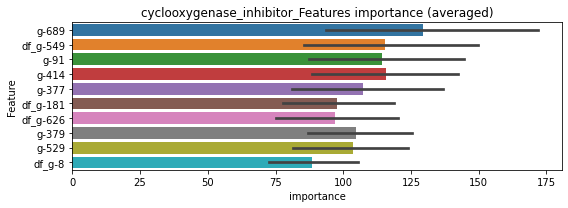

len(train_index) : 3361
len(valid_index) : 3362
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251101	valid_1's binary_logloss: 0.0614529


len(train_index) : 3362
len(valid_index) : 3361
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[200]	training's binary_logloss: 0.00832865	valid_1's binary_logloss: 0.0496671
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00698006	valid_1's binary_logloss: 0.0485936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265384	valid_1's binary_logloss: 0.0648777
[200]	training's binary_logloss: 0.00885636	valid_1's binary_logloss: 0.0488586
[300]	training's binary_logloss: 0.00403201	valid_1's binary_logloss: 0.0444393


cyclooxygenase_inhibitor logloss: 0.04574447114701961


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00280637	valid_1's binary_logloss: 0.0428945


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102367	valid_1's binary_logloss: 0.17258
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0548761	valid_1's binary_logloss: 0.149961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113567	valid_1's binary_logloss: 0.164472
[200]	training's binary_logloss: 0.0629212	valid_1's binary_logloss: 0.136461
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0594169	valid_1's binary_logloss: 0.135226


1 / 3 AUC score:0.961
y_Threshold: 0.1575971, Threshold: 0.2139979, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 296 → Positive_corect_labels: 572/3632
p_label_rate: 0.0200904 Vs.target_rate: 0.00437, Num_p_label: 80.0, conf_0:0.19260, conf_1:0.23540
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.2139979
Num_p_label: 73.0, Expected: 17.4, Adj_threshold_2: 0.2239979
Num_p_label: 66.0, Expected: 17.4, Adj_threshold_3: 0.2339979
Num_p_label: 58.0, Expected: 17.4, Adj_threshold_4: 0.2439979
Num_p_label: 54.0, Expected: 17.4, Adj_threshold_5: 0.2539979
Num_p_label: 50.0, Expected: 17.4, Adj_threshold_6: 0.2639979
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_7: 0.2739979
Num_p_label: 38.0, Expected: 17.4, Adj_threshold_8: 0.2839979
Num_p_label: 35.0, Expected: 17.4, Adj_threshold_9: 0.2939979
Num_p_label: 33.0, Expected: 17.4, Adj_threshold_10: 0.3039979
threshold: 0.3039979, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 572.0/3632, y_label_rate: 0.157489

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655561	valid_1's binary_logloss: 0.1006
[200]	training's binary_logloss: 0.0237185	valid_1's binary_logloss: 0.0627096
[300]	training's binary_logloss: 0.00974087	valid_1's binary_logloss: 0.0470061
[400]	training's binary_logloss: 0.00520123	valid_1's binary_logloss: 0.0415837
[500]	training's binary_logloss: 0.00331062	valid_1's binary_logloss: 0.0386838
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00266337	valid_1's binary_logloss: 0.0374439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650044	valid_1's binary_logloss: 0.0993493
[200]	training's binary_logloss: 0.0223925	valid_1's binary_logloss: 0.0603234
[300]	training's binary_logloss: 0.00982286	valid_1's binary_logloss: 0.0483976


2 / 3 AUC score:0.998
y_Threshold: 0.1645895, Threshold: 0.3039979, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 552.0/3592
p_label_rate: 0.0138122 Vs.target_rate: 0.00437, Num_p_label: 55.0, conf_0:0.27360, conf_1:0.33440
Num_p_label: 55.0, Expected: 17.4, Adj_threshold_1: 0.3039979
Num_p_label: 53.0, Expected: 17.4, Adj_threshold_2: 0.3139979
Num_p_label: 48.0, Expected: 17.4, Adj_threshold_3: 0.3239979
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_4: 0.3339979
Num_p_label: 45.0, Expected: 17.4, Adj_threshold_5: 0.3439979
Num_p_label: 41.0, Expected: 17.4, Adj_threshold_6: 0.3539979
Num_p_label: 41.0, Expected: 17.4, Adj_threshold_7: 0.3639979


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00573542	valid_1's binary_logloss: 0.0436003


Num_p_label: 38.0, Expected: 17.4, Adj_threshold_8: 0.3739979
Num_p_label: 36.0, Expected: 17.4, Adj_threshold_9: 0.3839979
Num_p_label: 34.0, Expected: 17.4, Adj_threshold_10: 0.3939979
threshold: 0.3939979, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 552.0/3592, y_label_rate: 0.1536748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571554	valid_1's binary_logloss: 0.0861455
[200]	training's binary_logloss: 0.0175586	valid_1's binary_logloss: 0.0464676
[300]	training's binary_logloss: 0.0073648	valid_1's binary_logloss: 0.0337595
[400]	training's binary_logloss: 0.00390644	valid_1's binary_logloss: 0.0284185
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00347673	valid_1's binary_logloss: 0.0276866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575468	valid_1's binary_logloss: 0.0841685
[200]	training's binary_logloss: 0.0185539	valid_1's binary_logloss: 0.0480438
[300]	training's binary_logloss: 0.00799367	valid_1's binary_logloss: 0.0370377


3 / 3 AUC score:0.999
y_Threshold: 0.1542965, Threshold: 0.3939979, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 540.0/3568
p_label_rate: 0.0082873 Vs.target_rate: 0.00437, Num_p_label: 33.0, conf_0:0.35460, conf_1:0.43340
threshold: 0.3939979, positive_p_label: 33.0/3982, p_label_rate: 0.0082873


[400]	training's binary_logloss: 0.00410229	valid_1's binary_logloss: 0.0314619
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0040757	valid_1's binary_logloss: 0.0314472


positive_y_label: 573.0/7550, y_label_rate: 0.0758940


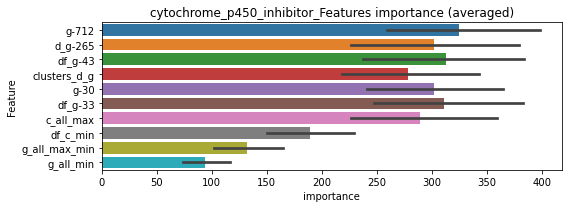

len(train_index) : 3775
len(valid_index) : 3775
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334089	valid_1's binary_logloss: 0.0534789
[200]	training's binary_logloss: 0.0109157	valid_1's binary_logloss: 0.0336894
[300]	training's binary_logloss: 0.004557	valid_1's binary_logloss: 0.0289353
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00281213	valid_1's binary_logloss: 0.0273436


len(train_index) : 3775
len(valid_index) : 3775
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330913	valid_1's binary_logloss: 0.0525724
[200]	training's binary_logloss: 0.0110526	valid_1's binary_logloss: 0.0323879
[300]	training's binary_logloss: 0.00468838	valid_1's binary_logloss: 0.0254403
[400]	training's binary_logloss: 0.00249147	valid_1's binary_logloss: 0.0226377


cytochrome_p450_inhibitor logloss: 0.024730565819640737


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00221672	valid_1's binary_logloss: 0.0221175


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297348	valid_1's binary_logloss: 0.0427798
[200]	training's binary_logloss: 0.00421633	valid_1's binary_logloss: 0.0100512
[300]	training's binary_logloss: 0.00119904	valid_1's binary_logloss: 0.00483184
[400]	training's binary_logloss: 0.000614575	valid_1's binary_logloss: 0.00349445
[500]	training's binary_logloss: 0.000429001	valid_1's binary_logloss: 0.00295847
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000410212	valid_1's binary_logloss: 0.00291019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302675	valid_1's binary_logloss: 0.0452371
[200]	training's binary_logloss: 0.00435873	valid_1's binary_logloss: 0.0119605
[300]	training's binary_logloss: 0.00127272	valid_1's binary_logloss: 0.00737184
[400]	training's binary_logloss: 0.000640059	valid_1's binary_logloss: 0.00608611
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0023799, Threshold: 0.0033117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00298, conf_1:0.00364
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0033117
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0133117
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0233117
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.0333117
threshold: 0.0333117, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288165	valid_1's binary_logloss: 0.0404926
[200]	training's binary_logloss: 0.00402188	valid_1's binary_logloss: 0.00897248
[300]	training's binary_logloss: 0.00115785	valid_1's binary_logloss: 0.00393323
[400]	training's binary_logloss: 0.000597562	valid_1's binary_logloss: 0.00263461
[500]	training's binary_logloss: 0.000422815	valid_1's binary_logloss: 0.00213087
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000410359	valid_1's binary_logloss: 0.00209513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290683	valid_1's binary_logloss: 0.0447611
[200]	training's binary_logloss: 0.00395489	valid_1's binary_logloss: 0.0105893
[300]	training's binary_logloss: 0.00115633	valid_1's binary_logloss: 0.00569897
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000636984	valid_1's binary_logloss: 0.00490275

2 / 3 AUC score:1.000
y_Threshold: 0.0157498, Threshold: 0.0333117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0060271 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.02998, conf_1:0.03664
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.0333117
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0433117
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.0533117
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.0633117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.0733117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.0833117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.0933117
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.1033117
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_9: 0.1133117
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_10: 0.1233117
threshold: 0.1333117, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288165	valid_1's binary_logloss: 0.0404926
[200]	training's binary_logloss: 0.00402188	valid_1's binary_logloss: 0.00897248
[300]	training's binary_logloss: 0.00115785	valid_1's binary_logloss: 0.00393323
[400]	training's binary_logloss: 0.000597562	valid_1's binary_logloss: 0.00263461
[500]	training's binary_logloss: 0.000422815	valid_1's binary_logloss: 0.00213087
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000410359	valid_1's binary_logloss: 0.00209513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290683	valid_1's binary_logloss: 0.0447611
[200]	training's binary_logloss: 0.00395489	valid_1's binary_logloss: 0.0105893
[300]	training's binary_logloss: 0.00115633	valid_1's binary_logloss: 0.00569897
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000636984	valid_1's binary_logloss: 0.00490275

3 / 3 AUC score:1.000
y_Threshold: 0.0157498, Threshold: 0.1333117, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.11998, conf_1:0.14664
threshold: 0.1333117, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


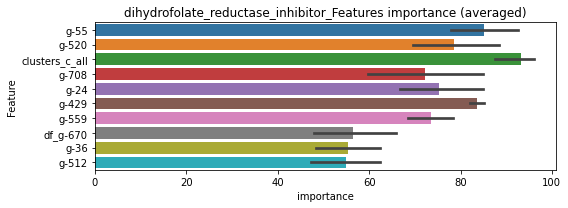

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150572	valid_1's binary_logloss: 0.0265327
[200]	training's binary_logloss: 0.00206913	valid_1's binary_logloss: 0.00896829
[300]	training's binary_logloss: 0.000592959	valid_1's binary_logloss: 0.00590001
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000332807	valid_1's binary_logloss: 0.00516579


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151852	valid_1's binary_logloss: 0.0232718
[200]	training's binary_logloss: 0.00204824	valid_1's binary_logloss: 0.00604859
[300]	training's binary_logloss: 0.000594566	valid_1's binary_logloss: 0.00341604
[400]	training's binary_logloss: 0.00029987	valid_1's binary_logloss: 0.00282167
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000226215	valid_1's binary_logloss: 0.0026566


dihydrofolate_reductase_inhibitor logloss: 0.003911354873335797
dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303626	valid_1's binary_logloss: 0.0464051
[200]	training's binary_logloss: 0.00410837	valid_1's binary_logloss: 0.0119175
[300]	training's binary_logloss: 0.00112887	valid_1's binary_logloss: 0.00554791
[400]	training's binary_logloss: 0.000560154	valid_1's binary_logloss: 0.00380802
[500]	training's binary_logloss: 0.000404717	valid_1's binary_logloss: 0.00328534
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000399104	valid_1's binary_logloss: 0.00327264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299922	valid_1's binary_logloss: 0.0383629
[200]	training's binary_logloss: 0.00413959	valid_1's binary_logloss: 0.00731129
[300]	training's binary_logloss: 0.00116029	valid_1's binary_logloss: 0.00260125
[400]	training's binary_logloss: 0.000577251	valid_1's binary_logloss: 0.0014615
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0021910, Threshold: 0.0038150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00343, conf_1:0.00420
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038150
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_2: 0.0138150
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.0238150
threshold: 0.0238150, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297638	valid_1's binary_logloss: 0.0437408
[200]	training's binary_logloss: 0.00389999	valid_1's binary_logloss: 0.0101525
[300]	training's binary_logloss: 0.00108649	valid_1's binary_logloss: 0.00444421
[400]	training's binary_logloss: 0.000546785	valid_1's binary_logloss: 0.00294912
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295035	valid_1's binary_logloss: 0.0369407
[200]	training's binary_logloss: 0.00393811	valid_1's binary_logloss: 0.00682257
[300]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.00244503
[400]	training's binary_logloss: 0.000555319	valid_1's binary_logloss: 0.00141015
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0885754, Threshold: 0.0238150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.02143, conf_1:0.02620
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.0238150
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0338150
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.0438150
threshold: 0.0438150, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297638	valid_1's binary_logloss: 0.0437408
[200]	training's binary_logloss: 0.00389999	valid_1's binary_logloss: 0.0101525
[300]	training's binary_logloss: 0.00108649	valid_1's binary_logloss: 0.00444421
[400]	training's binary_logloss: 0.000546785	valid_1's binary_logloss: 0.00294912
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000399035	valid_1's binary_logloss: 0.00249896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295035	valid_1's binary_logloss: 0.0369407
[200]	training's binary_logloss: 0.00393811	valid_1's binary_logloss: 0.00682257
[300]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.00244503
[400]	training's binary_logloss: 0.000555319	valid_1's binary_logloss: 0.00141015
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0885754, Threshold: 0.0438150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00105, Num_p_label: 5.0, conf_0:0.03943, conf_1:0.04820
threshold: 0.0438150, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


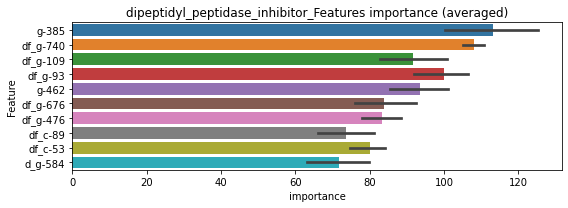

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167203	valid_1's binary_logloss: 0.0250435
[200]	training's binary_logloss: 0.00218731	valid_1's binary_logloss: 0.00769982
[300]	training's binary_logloss: 0.00058282	valid_1's binary_logloss: 0.00554939
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00034949	valid_1's binary_logloss: 0.00526817


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169317	valid_1's binary_logloss: 0.0242333
[200]	training's binary_logloss: 0.00225496	valid_1's binary_logloss: 0.00574795
[300]	training's binary_logloss: 0.00061119	valid_1's binary_logloss: 0.00274806
[400]	training's binary_logloss: 0.000300996	valid_1's binary_logloss: 0.00212158
[500]	training's binary_logloss: 0.000211681	valid_1's binary_logloss: 0.00196526
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000201237	valid_1's binary_logloss: 0.00194265


dipeptidyl_peptidase_inhibitor logloss: 0.003605409082474439
diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156476	valid_1's binary_logloss: 0.016242
[200]	training's binary_logloss: 0.00130474	valid_1's binary_logloss: 0.00158281
[300]	training's binary_logloss: 0.00035456	valid_1's binary_logloss: 0.000569972
[400]	training's binary_logloss: 0.000218988	valid_1's binary_logloss: 0.000402373
[500]	training's binary_logloss: 0.000191293	valid_1's binary_logloss: 0.00036744
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000188884	valid_1's binary_logloss: 0.000363717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159018	valid_1's binary_logloss: 0.0176188
[200]	training's binary_logloss: 0.00131065	valid_1's binary_logloss: 0.00204009
[300]	training's binary_logloss: 0.000352784	valid_1's binary_logloss: 0.000773093
[400]	training's binary_logloss: 0.000217733	valid_1's binary_logloss: 0.000540519
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006043, Threshold: 0.0010998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00099, conf_1:0.00121
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010998
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0110998
threshold: 0.0110998, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159798	valid_1's binary_logloss: 0.0167197
[200]	training's binary_logloss: 0.00130012	valid_1's binary_logloss: 0.00145596
[300]	training's binary_logloss: 0.000347106	valid_1's binary_logloss: 0.000415095
[400]	training's binary_logloss: 0.000216195	valid_1's binary_logloss: 0.000262858
[500]	training's binary_logloss: 0.000190607	valid_1's binary_logloss: 0.00023284
[600]	training's binary_logloss: 0.000185268	valid_1's binary_logloss: 0.000226623
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000185164	valid_1's binary_logloss: 0.000226499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161226	valid_1's binary_logloss: 0.0181277
[200]	training's binary_logloss: 0.00130993	valid_1's binary_logloss: 0.00243497
[300]	training's binary_logloss: 0.00035119	valid_1's binary_logloss: 0.00129575
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0556231, Threshold: 0.0110998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.00999, conf_1:0.01221
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.0110998
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0210998
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0310998
threshold: 0.0310998, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159798	valid_1's binary_logloss: 0.0167197
[200]	training's binary_logloss: 0.00130012	valid_1's binary_logloss: 0.00145596
[300]	training's binary_logloss: 0.000347106	valid_1's binary_logloss: 0.000415095
[400]	training's binary_logloss: 0.000216195	valid_1's binary_logloss: 0.000262858
[500]	training's binary_logloss: 0.000190607	valid_1's binary_logloss: 0.00023284
[600]	training's binary_logloss: 0.000185268	valid_1's binary_logloss: 0.000226623
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.000185164	valid_1's binary_logloss: 0.000226499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161226	valid_1's binary_logloss: 0.0181277
[200]	training's binary_logloss: 0.00130993	valid_1's binary_logloss: 0.00243497
[300]	training's binary_logloss: 0.00035119	valid_1's binary_logloss: 0.00129575
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0556231, Threshold: 0.0310998, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.02799, conf_1:0.03421
threshold: 0.0310998, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


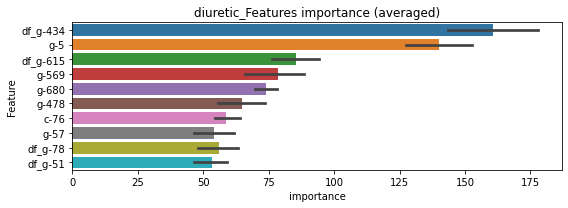

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00849041	valid_1's binary_logloss: 0.00945143
[200]	training's binary_logloss: 0.000691713	valid_1's binary_logloss: 0.00167809


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000217723	valid_1's binary_logloss: 0.00129189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00850136	valid_1's binary_logloss: 0.0102456
[200]	training's binary_logloss: 0.000680482	valid_1's binary_logloss: 0.00237854
[300]	training's binary_logloss: 0.000179959	valid_1's binary_logloss: 0.00188218


diuretic logloss: 0.0015747183140413417


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000146166	valid_1's binary_logloss: 0.00185762


dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401167	valid_1's binary_logloss: 0.0770961
[200]	training's binary_logloss: 0.00690299	valid_1's binary_logloss: 0.0288988
[300]	training's binary_logloss: 0.0020439	valid_1's binary_logloss: 0.0171085
[400]	training's binary_logloss: 0.000988655	valid_1's binary_logloss: 0.0130093
[500]	training's binary_logloss: 0.000646089	valid_1's binary_logloss: 0.0114909
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000586656	valid_1's binary_logloss: 0.0111366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423098	valid_1's binary_logloss: 0.0699792
[200]	training's binary_logloss: 0.00754114	valid_1's binary_logloss: 0.0220251
[300]	training's binary_logloss: 0.00215796	valid_1's binary_logloss: 0.0112536
[400]	training's binary_logloss: 0.00104289	valid_1's binary_logloss: 0.00815558
[500]	training's binary_logloss: 0.0006717

1 / 3 AUC score:1.000
y_Threshold: 0.0057970, Threshold: 0.0094862, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00854, conf_1:0.01043
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0094862
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0194862
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.0294862
threshold: 0.0294862, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040713	valid_1's binary_logloss: 0.0735336
[200]	training's binary_logloss: 0.00676347	valid_1's binary_logloss: 0.0259139
[300]	training's binary_logloss: 0.00201315	valid_1's binary_logloss: 0.0150927
[400]	training's binary_logloss: 0.000978699	valid_1's binary_logloss: 0.0115761
[500]	training's binary_logloss: 0.0006382	valid_1's binary_logloss: 0.0101753
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000553221	valid_1's binary_logloss: 0.00975721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415205	valid_1's binary_logloss: 0.0711632
[200]	training's binary_logloss: 0.00715136	valid_1's binary_logloss: 0.0223064
[300]	training's binary_logloss: 0.0020791	valid_1's binary_logloss: 0.0114188
[400]	training's binary_logloss: 0.00099426	valid_1's binary_logloss: 0.00810025
[500]	training's binary_logloss: 0.000643355

2 / 3 AUC score:1.000
y_Threshold: 0.0537149, Threshold: 0.0294862, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0110497 Vs.target_rate: 0.00202, Num_p_label: 44.0, conf_0:0.02654, conf_1:0.03243
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_1: 0.0294862
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0394862
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_3: 0.0494862
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_4: 0.0594862
threshold: 0.0594862, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040713	valid_1's binary_logloss: 0.0735336
[200]	training's binary_logloss: 0.00676347	valid_1's binary_logloss: 0.0259139
[300]	training's binary_logloss: 0.00201315	valid_1's binary_logloss: 0.0150927
[400]	training's binary_logloss: 0.000978699	valid_1's binary_logloss: 0.0115761
[500]	training's binary_logloss: 0.0006382	valid_1's binary_logloss: 0.0101753
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000553221	valid_1's binary_logloss: 0.00975721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415205	valid_1's binary_logloss: 0.0711632
[200]	training's binary_logloss: 0.00715136	valid_1's binary_logloss: 0.0223064
[300]	training's binary_logloss: 0.0020791	valid_1's binary_logloss: 0.0114188
[400]	training's binary_logloss: 0.00099426	valid_1's binary_logloss: 0.00810025
[500]	training's binary_logloss: 0.000643355

3 / 3 AUC score:1.000
y_Threshold: 0.0537149, Threshold: 0.0594862, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0040181 Vs.target_rate: 0.00202, Num_p_label: 16.0, conf_0:0.05354, conf_1:0.06543
threshold: 0.0594862, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 672.0/7787, y_label_rate: 0.0862977


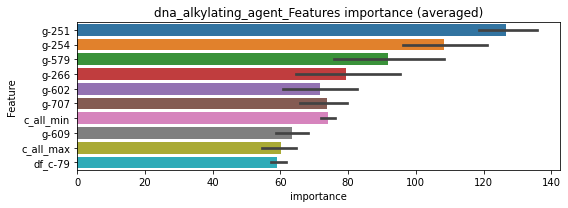

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221486	valid_1's binary_logloss: 0.0491947
[200]	training's binary_logloss: 0.00385506	valid_1's binary_logloss: 0.0239423
[300]	training's binary_logloss: 0.0010882	valid_1's binary_logloss: 0.0184944
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000600217	valid_1's binary_logloss: 0.01718


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231198	valid_1's binary_logloss: 0.0474221
[200]	training's binary_logloss: 0.00384788	valid_1's binary_logloss: 0.0222636
[300]	training's binary_logloss: 0.00116429	valid_1's binary_logloss: 0.0182919
[400]	training's binary_logloss: 0.00055943	valid_1's binary_logloss: 0.0168067
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000522536	valid_1's binary_logloss: 0.0167575


dna_alkylating_agent logloss: 0.01696879182212125
dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338


neg labels: 3289 → selected neg labels: 3229


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.253538	valid_1's binary_logloss: 0.375314


1 / 3 AUC score:0.734
y_Threshold: 0.2122541, Threshold: 0.3614596, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 786 → Positive_corect_labels: 317/3088
p_label_rate: 0.0200904 Vs.target_rate: 0.01688, Num_p_label: 80.0, conf_0:0.32531, conf_1:0.39761
threshold: 0.3614596, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.279488	valid_1's binary_logloss: 0.40102


positive_y_label: 317.0/3088, y_label_rate: 0.1026554
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609421	valid_1's binary_logloss: 0.137669
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0274364	valid_1's binary_logloss: 0.124139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649936	valid_1's binary_logloss: 0.146921
[200]	training's binary_logloss: 0.0257188	valid_1's binary_logloss: 0.124184
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0270164	valid_1's binary_logloss: 0.124118


2 / 3 AUC score:0.964
y_Threshold: 0.1926773, Threshold: 0.3614596, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 247.0/2948
p_label_rate: 0.0647916 Vs.target_rate: 0.01688, Num_p_label: 258.0, conf_0:0.32531, conf_1:0.39761
Num_p_label: 258.0, Expected: 67.2, Adj_threshold_1: 0.3614596
Num_p_label: 257.0, Expected: 67.2, Adj_threshold_2: 0.3714596
Num_p_label: 249.0, Expected: 67.2, Adj_threshold_3: 0.3814596
Num_p_label: 241.0, Expected: 67.2, Adj_threshold_4: 0.3914596
Num_p_label: 236.0, Expected: 67.2, Adj_threshold_5: 0.4014596
Num_p_label: 226.0, Expected: 67.2, Adj_threshold_6: 0.4114596
Num_p_label: 221.0, Expected: 67.2, Adj_threshold_7: 0.4214596
Num_p_label: 211.0, Expected: 67.2, Adj_threshold_8: 0.4314596
Num_p_label: 208.0, Expected: 67.2, Adj_threshold_9: 0.4414596
Num_p_label: 199.0, Expected: 67.2, Adj_threshold_10: 0.4514596
threshold: 0.4614596, positive_p_label: 195.0/3982, p_label_rate: 0.0489704
positive_y_label: 247.0/2948, y_label_

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369515	valid_1's binary_logloss: 0.0730772
[200]	training's binary_logloss: 0.0109369	valid_1's binary_logloss: 0.0480447
[300]	training's binary_logloss: 0.00495702	valid_1's binary_logloss: 0.04182
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00373293	valid_1's binary_logloss: 0.0401209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346335	valid_1's binary_logloss: 0.0966874


3 / 3 AUC score:0.996
y_Threshold: 0.2149990, Threshold: 0.4614596, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 220.0/2894
p_label_rate: 0.0590156 Vs.target_rate: 0.01688, Num_p_label: 235.0, conf_0:0.41531, conf_1:0.50761
Num_p_label: 235.0, Expected: 67.2, Adj_threshold_1: 0.4614596


[200]	training's binary_logloss: 0.0097569	valid_1's binary_logloss: 0.0678689
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00515964	valid_1's binary_logloss: 0.0590452


Num_p_label: 235.0, Expected: 67.2, Adj_threshold_2: 0.4714596
Num_p_label: 229.0, Expected: 67.2, Adj_threshold_3: 0.4814596
Num_p_label: 223.0, Expected: 67.2, Adj_threshold_4: 0.4914596
Num_p_label: 217.0, Expected: 67.2, Adj_threshold_5: 0.5014596
Num_p_label: 214.0, Expected: 67.2, Adj_threshold_6: 0.5114596
Num_p_label: 210.0, Expected: 67.2, Adj_threshold_7: 0.5214596
Num_p_label: 206.0, Expected: 67.2, Adj_threshold_8: 0.5314596
Num_p_label: 203.0, Expected: 67.2, Adj_threshold_9: 0.5414596
Num_p_label: 201.0, Expected: 67.2, Adj_threshold_10: 0.5514596
threshold: 0.5614596, positive_p_label: 197.0/3982, p_label_rate: 0.0494726
positive_y_label: 417.0/6876, y_label_rate: 0.0606457


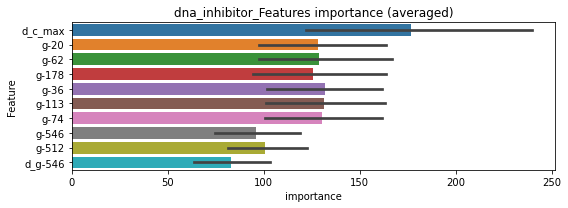

len(train_index) : 3438
len(valid_index) : 3438
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236876	valid_1's binary_logloss: 0.0595149
[200]	training's binary_logloss: 0.00658777	valid_1's binary_logloss: 0.0446065
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0031054	valid_1's binary_logloss: 0.0412708


len(train_index) : 3438
len(valid_index) : 3438
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247765	valid_1's binary_logloss: 0.0553666


dna_inhibitor logloss: 0.03977172983584653


[200]	training's binary_logloss: 0.00710334	valid_1's binary_logloss: 0.0395875
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00517855	valid_1's binary_logloss: 0.0382726


dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136209	valid_1's binary_logloss: 0.21726
[200]	training's binary_logloss: 0.0733589	valid_1's binary_logloss: 0.184767
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0629945	valid_1's binary_logloss: 0.181638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151028	valid_1's binary_logloss: 0.2052
[200]	training's binary_logloss: 0.086153	valid_1's binary_logloss: 0.174124
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0740748	valid_1's binary_logloss: 0.172199


1 / 3 AUC score:0.941
y_Threshold: 0.1482508, Threshold: 0.2660268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 347 → Positive_corect_labels: 545/3573
p_label_rate: 0.0200904 Vs.target_rate: 0.00508, Num_p_label: 80.0, conf_0:0.23942, conf_1:0.29263
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.2660268
Num_p_label: 65.0, Expected: 20.2, Adj_threshold_2: 0.2760268
Num_p_label: 63.0, Expected: 20.2, Adj_threshold_3: 0.2860268
Num_p_label: 58.0, Expected: 20.2, Adj_threshold_4: 0.2960268
Num_p_label: 51.0, Expected: 20.2, Adj_threshold_5: 0.3060268
Num_p_label: 48.0, Expected: 20.2, Adj_threshold_6: 0.3160268
Num_p_label: 45.0, Expected: 20.2, Adj_threshold_7: 0.3260268
Num_p_label: 41.0, Expected: 20.2, Adj_threshold_8: 0.3360268
Num_p_label: 38.0, Expected: 20.2, Adj_threshold_9: 0.3460268
threshold: 0.3460268, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 545.0/3573, y_label_rate: 0.1525329
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831971	valid_1's binary_logloss: 0.128663
[200]	training's binary_logloss: 0.0315642	valid_1's binary_logloss: 0.0827529
[300]	training's binary_logloss: 0.0144054	valid_1's binary_logloss: 0.0698037
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0085014	valid_1's binary_logloss: 0.0655217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921205	valid_1's binary_logloss: 0.136521
[200]	training's binary_logloss: 0.0339948	valid_1's binary_logloss: 0.0874046
[300]	training's binary_logloss: 0.0146774	valid_1's binary_logloss: 0.0710962
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00835981	valid_1's binary_logloss: 0.065469


2 / 3 AUC score:0.995
y_Threshold: 0.1610533, Threshold: 0.3460268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 515.0/3513
p_label_rate: 0.0193370 Vs.target_rate: 0.00508, Num_p_label: 77.0, conf_0:0.31142, conf_1:0.38063
Num_p_label: 77.0, Expected: 20.2, Adj_threshold_1: 0.3460268
Num_p_label: 75.0, Expected: 20.2, Adj_threshold_2: 0.3560268
Num_p_label: 71.0, Expected: 20.2, Adj_threshold_3: 0.3660268
Num_p_label: 65.0, Expected: 20.2, Adj_threshold_4: 0.3760268
Num_p_label: 63.0, Expected: 20.2, Adj_threshold_5: 0.3860268
Num_p_label: 63.0, Expected: 20.2, Adj_threshold_6: 0.3960268
Num_p_label: 61.0, Expected: 20.2, Adj_threshold_7: 0.4060268
Num_p_label: 60.0, Expected: 20.2, Adj_threshold_8: 0.4160268
Num_p_label: 58.0, Expected: 20.2, Adj_threshold_9: 0.4260268
Num_p_label: 53.0, Expected: 20.2, Adj_threshold_10: 0.4360268
threshold: 0.4460268, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 515.0/3513, y_label_rate: 0.14659

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726702	valid_1's binary_logloss: 0.109166
[200]	training's binary_logloss: 0.0240504	valid_1's binary_logloss: 0.0624874
[300]	training's binary_logloss: 0.0102437	valid_1's binary_logloss: 0.0484937
[400]	training's binary_logloss: 0.00512143	valid_1's binary_logloss: 0.0435185
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00462857	valid_1's binary_logloss: 0.0431522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831366	valid_1's binary_logloss: 0.123522
[200]	training's binary_logloss: 0.0280731	valid_1's binary_logloss: 0.0705208
[300]	training's binary_logloss: 0.011136	valid_1's binary_logloss: 0.0535977
[400]	training's binary_logloss: 0.00557578	valid_1's binary_logloss: 0.0473411
[500]	training's binary_logloss: 0.0034009	valid_1's binary_logloss: 0.0433589
Early stopping, best iteration is:
[570]	training's b

3 / 3 AUC score:0.999
y_Threshold: 0.0927984, Threshold: 0.4460268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 500.0/3483
p_label_rate: 0.0155701 Vs.target_rate: 0.00508, Num_p_label: 62.0, conf_0:0.40142, conf_1:0.49063
Num_p_label: 62.0, Expected: 20.2, Adj_threshold_1: 0.4460268
Num_p_label: 60.0, Expected: 20.2, Adj_threshold_2: 0.4560268
Num_p_label: 57.0, Expected: 20.2, Adj_threshold_3: 0.4660268
Num_p_label: 56.0, Expected: 20.2, Adj_threshold_4: 0.4760268
Num_p_label: 54.0, Expected: 20.2, Adj_threshold_5: 0.4860268
Num_p_label: 53.0, Expected: 20.2, Adj_threshold_6: 0.4960268
Num_p_label: 52.0, Expected: 20.2, Adj_threshold_7: 0.5060268
Num_p_label: 52.0, Expected: 20.2, Adj_threshold_8: 0.5160268
Num_p_label: 50.0, Expected: 20.2, Adj_threshold_9: 0.5260268
Num_p_label: 48.0, Expected: 20.2, Adj_threshold_10: 0.5360268
threshold: 0.5460268, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 547.0/7465, y_label_rate: 0.07327

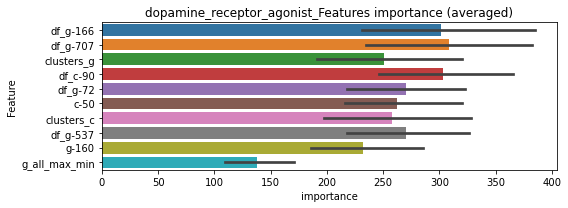

len(train_index) : 3732
len(valid_index) : 3733
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452882	valid_1's binary_logloss: 0.0764938
[200]	training's binary_logloss: 0.0161773	valid_1's binary_logloss: 0.0521473
[300]	training's binary_logloss: 0.00713917	valid_1's binary_logloss: 0.045415
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00506732	valid_1's binary_logloss: 0.0437076


len(train_index) : 3733
len(valid_index) : 3732
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511105	valid_1's binary_logloss: 0.0690822
[200]	training's binary_logloss: 0.017521	valid_1's binary_logloss: 0.0376398
[300]	training's binary_logloss: 0.00769471	valid_1's binary_logloss: 0.0278475
[400]	training's binary_logloss: 0.00371779	valid_1's binary_logloss: 0.0236171
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00301144	valid_1's binary_logloss: 0.0229826


dopamine_receptor_agonist logloss: 0.033346475425382556
dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701


neg labels: 3289 → selected neg labels: 3221


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240629	valid_1's binary_logloss: 0.387448
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.226321	valid_1's binary_logloss: 0.386604
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.723
y_Threshold: 0.2218195, Threshold: 0.3466498, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 823 → Positive_corect_labels: 297/3042
p_label_rate: 0.0200904 Vs.target_rate: 0.01780, Num_p_label: 80.0, conf_0:0.31198, conf_1:0.38131
threshold: 0.3466498, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 297.0/3042, y_label_rate: 0.0976331
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.271369	valid_1's binary_logloss: 0.391142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771333	valid_1's binary_logloss: 0.140559
[200]	training's binary_logloss: 0.0300674	valid_1's binary_logloss: 0.121577
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0305431	valid_1's binary_logloss: 0.121443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702592	valid_1's binary_logloss: 0.147028


2 / 3 AUC score:0.970
y_Threshold: 0.2025136, Threshold: 0.3466498, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 223.0/2894
p_label_rate: 0.0554997 Vs.target_rate: 0.01780, Num_p_label: 221.0, conf_0:0.31198, conf_1:0.38131
Num_p_label: 221.0, Expected: 70.9, Adj_threshold_1: 0.3466498
Num_p_label: 215.0, Expected: 70.9, Adj_threshold_2: 0.3566498
Num_p_label: 208.0, Expected: 70.9, Adj_threshold_3: 0.3666498
Num_p_label: 202.0, Expected: 70.9, Adj_threshold_4: 0.3766498
Num_p_label: 197.0, Expected: 70.9, Adj_threshold_5: 0.3866498
Num_p_label: 192.0, Expected: 70.9, Adj_threshold_6: 0.3966498
Num_p_label: 186.0, Expected: 70.9, Adj_threshold_7: 0.4066498
Num_p_label: 177.0, Expected: 70.9, Adj_threshold_8: 0.4166498
Num_p_label: 170.0, Expected: 70.9, Adj_threshold_9: 0.4266498
Num_p_label: 165.0, Expected: 70.9, Adj_threshold_10: 0.4366498
threshold: 0.4466498, positive_p_label: 158.0/3982, p_label_rate: 0.0396786
positive_y_label: 223.0/2894, y_label_

Early stopping, best iteration is:
[184]	training's binary_logloss: 0.031747	valid_1's binary_logloss: 0.127757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394507	valid_1's binary_logloss: 0.0931998
[200]	training's binary_logloss: 0.0113458	valid_1's binary_logloss: 0.0679115
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00926746	valid_1's binary_logloss: 0.065827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376379	valid_1's binary_logloss: 0.0918509
[200]	training's binary_logloss: 0.0109351	valid_1's binary_logloss: 0.0678044
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00766382	valid_1's binary_logloss: 0.0642252


3 / 3 AUC score:0.993
y_Threshold: 0.1628867, Threshold: 0.4466498, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 191.0/2830
p_label_rate: 0.0484681 Vs.target_rate: 0.01780, Num_p_label: 193.0, conf_0:0.40198, conf_1:0.49131
threshold: 0.4466498, positive_p_label: 193.0/3982, p_label_rate: 0.0484681
positive_y_label: 384.0/6812, y_label_rate: 0.0563711


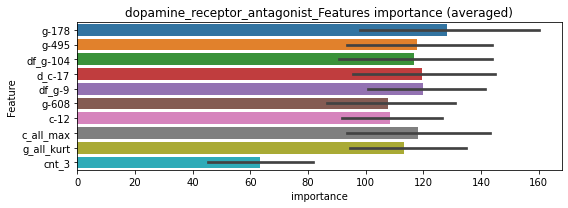

len(train_index) : 3406
len(valid_index) : 3406
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282458	valid_1's binary_logloss: 0.065494
[200]	training's binary_logloss: 0.00891453	valid_1's binary_logloss: 0.0503631
[300]	training's binary_logloss: 0.00377094	valid_1's binary_logloss: 0.0459603


len(train_index) : 3406
len(valid_index) : 3406
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00309778	valid_1's binary_logloss: 0.0451665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304862	valid_1's binary_logloss: 0.0575625
[200]	training's binary_logloss: 0.00986819	valid_1's binary_logloss: 0.0400841


dopamine_receptor_antagonist logloss: 0.038708946249245535


[300]	training's binary_logloss: 0.0042828	valid_1's binary_logloss: 0.0330555
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00349674	valid_1's binary_logloss: 0.0322514


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765937	valid_1's binary_logloss: 0.15885
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0411877	valid_1's binary_logloss: 0.147976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873608	valid_1's binary_logloss: 0.14331
[200]	training's binary_logloss: 0.0420255	valid_1's binary_logloss: 0.121942
[300]	training's binary_logloss: 0.0219281	valid_1's binary_logloss: 0.115786
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0196938	valid_1's binary_logloss: 0.114492


1 / 3 AUC score:0.973
y_Threshold: 0.1227483, Threshold: 0.6615934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 246 → Positive_corect_labels: 595/3670
p_label_rate: 0.0200904 Vs.target_rate: 0.01411, Num_p_label: 80.0, conf_0:0.59543, conf_1:0.72775
threshold: 0.6615934, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 595.0/3670, y_label_rate: 0.1621253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405938	valid_1's binary_logloss: 0.0819826
[200]	training's binary_logloss: 0.00899363	valid_1's binary_logloss: 0.0559174
[300]	training's binary_logloss: 0.00320022	valid_1's binary_logloss: 0.0504246
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00315692	valid_1's binary_logloss: 0.0503471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429024	valid_1's binary_logloss: 0.0678782
[200]	training's binary_logloss: 0.0103207	valid_1's binary_logloss: 0.0376065
[300]	training's binary_logloss: 0.00406861	valid_1's binary_logloss: 0.0311401


2 / 3 AUC score:0.997
y_Threshold: 0.2459970, Threshold: 0.6615934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 571.0/3622
p_label_rate: 0.0331492 Vs.target_rate: 0.01411, Num_p_label: 132.0, conf_0:0.59543, conf_1:0.72775
threshold: 0.6615934, positive_p_label: 132.0/3982, p_label_rate: 0.0331492
positive_y_label: 571.0/3622, y_label_rate: 0.1576477
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00240908	valid_1's binary_logloss: 0.0289661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336744	valid_1's binary_logloss: 0.0605316
[200]	training's binary_logloss: 0.00675467	valid_1's binary_logloss: 0.0335319
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00356376	valid_1's binary_logloss: 0.0284231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364601	valid_1's binary_logloss: 0.0496367
[200]	training's binary_logloss: 0.00758741	valid_1's binary_logloss: 0.0209452
[300]	training's binary_logloss: 0.00278779	valid_1's binary_logloss: 0.0145031
[400]	training's binary_logloss: 0.0014777	valid_1's binary_logloss: 0.0119048
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00122777	valid_1's binary_logloss: 0.011357


3 / 3 AUC score:1.000
y_Threshold: 0.3219735, Threshold: 0.6615934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 557.0/3594
p_label_rate: 0.0359116 Vs.target_rate: 0.01411, Num_p_label: 143.0, conf_0:0.59543, conf_1:0.72775
threshold: 0.6615934, positive_p_label: 143.0/3982, p_label_rate: 0.0359116
positive_y_label: 700.0/7576, y_label_rate: 0.0923970


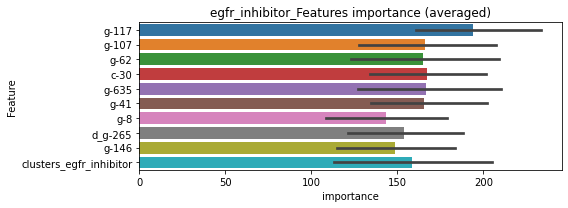

len(train_index) : 3788
len(valid_index) : 3788
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205656	valid_1's binary_logloss: 0.037174
[200]	training's binary_logloss: 0.00468859	valid_1's binary_logloss: 0.0245328


len(train_index) : 3788
len(valid_index) : 3788
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00242485	valid_1's binary_logloss: 0.0221957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214684	valid_1's binary_logloss: 0.0334316
[200]	training's binary_logloss: 0.00473819	valid_1's binary_logloss: 0.0173724
[300]	training's binary_logloss: 0.00182738	valid_1's binary_logloss: 0.0145468
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00126704	valid_1's binary_logloss: 0.0137854


egfr_inhibitor logloss: 0.017990554495485686
elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205058	valid_1's binary_logloss: 0.0262082
[200]	training's binary_logloss: 0.00223146	valid_1's binary_logloss: 0.00447446
[300]	training's binary_logloss: 0.000634208	valid_1's binary_logloss: 0.00183072
[400]	training's binary_logloss: 0.000341554	valid_1's binary_logloss: 0.00121843
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000296373	valid_1's binary_logloss: 0.00116412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020379	valid_1's binary_logloss: 0.0244172
[200]	training's binary_logloss: 0.0022254	valid_1's binary_logloss: 0.00399631
[300]	training's binary_logloss: 0.000630867	valid_1's binary_logloss: 0.00159688
[400]	training's binary_logloss: 0.000346956	valid_1's binary_logloss: 0.00106388
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00029786	valid_1's binary_logloss: 0.00097612

1 / 3 AUC score:1.000
y_Threshold: 0.0010516, Threshold: 0.0014851, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00134, conf_1:0.00163
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0014851
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0114851
threshold: 0.0114851, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205128	valid_1's binary_logloss: 0.026652
[200]	training's binary_logloss: 0.00217151	valid_1's binary_logloss: 0.00430089
[300]	training's binary_logloss: 0.00060807	valid_1's binary_logloss: 0.00180367
[400]	training's binary_logloss: 0.000341248	valid_1's binary_logloss: 0.00126532
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000302905	valid_1's binary_logloss: 0.00119258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205974	valid_1's binary_logloss: 0.0257044
[200]	training's binary_logloss: 0.00221756	valid_1's binary_logloss: 0.00396493
[300]	training's binary_logloss: 0.000620692	valid_1's binary_logloss: 0.00142779
[400]	training's binary_logloss: 0.000342539	valid_1's binary_logloss: 0.000915765
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000297899	valid_1's binary_logloss: 0.000845

2 / 3 AUC score:1.000
y_Threshold: 0.1074550, Threshold: 0.0114851, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.01034, conf_1:0.01263
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.0114851
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0214851
threshold: 0.0214851, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205128	valid_1's binary_logloss: 0.026652
[200]	training's binary_logloss: 0.00217151	valid_1's binary_logloss: 0.00430089
[300]	training's binary_logloss: 0.00060807	valid_1's binary_logloss: 0.00180367
[400]	training's binary_logloss: 0.000341248	valid_1's binary_logloss: 0.00126532
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000302905	valid_1's binary_logloss: 0.00119258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205974	valid_1's binary_logloss: 0.0257044
[200]	training's binary_logloss: 0.00221756	valid_1's binary_logloss: 0.00396493
[300]	training's binary_logloss: 0.000620692	valid_1's binary_logloss: 0.00142779
[400]	training's binary_logloss: 0.000342539	valid_1's binary_logloss: 0.000915765
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000297899	valid_1's binary_logloss: 0.000845

3 / 3 AUC score:1.000
y_Threshold: 0.1074550, Threshold: 0.0214851, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.01934, conf_1:0.02363
threshold: 0.0214851, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


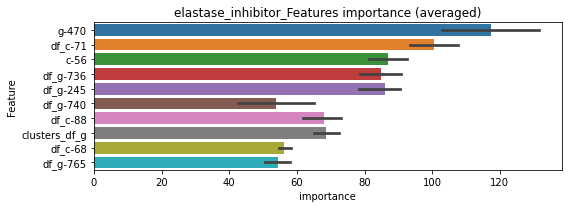

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109388	valid_1's binary_logloss: 0.0152445
[200]	training's binary_logloss: 0.0011265	valid_1's binary_logloss: 0.00339061
[300]	training's binary_logloss: 0.00030715	valid_1's binary_logloss: 0.00216185
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000187835	valid_1's binary_logloss: 0.00193134


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108561	valid_1's binary_logloss: 0.0132594
[200]	training's binary_logloss: 0.00114727	valid_1's binary_logloss: 0.00205709
[300]	training's binary_logloss: 0.000315715	valid_1's binary_logloss: 0.00080117
[400]	training's binary_logloss: 0.00017028	valid_1's binary_logloss: 0.000548052
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000147236	valid_1's binary_logloss: 0.000507696


elastase_inhibitor logloss: 0.0012195228097083028
erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264233	valid_1's binary_logloss: 0.0368951
[200]	training's binary_logloss: 0.00335477	valid_1's binary_logloss: 0.00718686
[300]	training's binary_logloss: 0.000955455	valid_1's binary_logloss: 0.00278079
[400]	training's binary_logloss: 0.000499381	valid_1's binary_logloss: 0.00176471
[500]	training's binary_logloss: 0.000381231	valid_1's binary_logloss: 0.00148213
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000376487	valid_1's binary_logloss: 0.00147432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273321	valid_1's binary_logloss: 0.0374322
[200]	training's binary_logloss: 0.00346431	valid_1's binary_logloss: 0.00745872
[300]	training's binary_logloss: 0.000969013	valid_1's binary_logloss: 0.00307429
[400]	training's binary_logloss: 0.000497925	valid_1's binary_logloss: 0.00199824
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0015206, Threshold: 0.0024632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084, Num_p_label: 80.0, conf_0:0.00222, conf_1:0.00271
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0024632
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.0124632
threshold: 0.0124632, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263331	valid_1's binary_logloss: 0.0385716
[200]	training's binary_logloss: 0.00329534	valid_1's binary_logloss: 0.00784399
[300]	training's binary_logloss: 0.000934586	valid_1's binary_logloss: 0.003093
[400]	training's binary_logloss: 0.000489108	valid_1's binary_logloss: 0.00201117
[500]	training's binary_logloss: 0.00038283	valid_1's binary_logloss: 0.00172365
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000381006	valid_1's binary_logloss: 0.00172084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266219	valid_1's binary_logloss: 0.0349507
[200]	training's binary_logloss: 0.00336716	valid_1's binary_logloss: 0.00637119
[300]	training's binary_logloss: 0.000954328	valid_1's binary_logloss: 0.00250619
[400]	training's binary_logloss: 0.000493576	valid_1's binary_logloss: 0.0015831
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1059136, Threshold: 0.0124632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.01122, conf_1:0.01371
threshold: 0.0124632, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263331	valid_1's binary_logloss: 0.0385716
[200]	training's binary_logloss: 0.00329534	valid_1's binary_logloss: 0.00784399
[300]	training's binary_logloss: 0.000934586	valid_1's binary_logloss: 0.003093
[400]	training's binary_logloss: 0.000489108	valid_1's binary_logloss: 0.00201117
[500]	training's binary_logloss: 0.00038283	valid_1's binary_logloss: 0.00172365
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000381006	valid_1's binary_logloss: 0.00172084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266219	valid_1's binary_logloss: 0.0349507
[200]	training's binary_logloss: 0.00336716	valid_1's binary_logloss: 0.00637119
[300]	training's binary_logloss: 0.000954328	valid_1's binary_logloss: 0.00250619
[400]	training's binary_logloss: 0.000493576	valid_1's binary_logloss: 0.0015831
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1059136, Threshold: 0.0124632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00084, Num_p_label: 8.0, conf_0:0.01122, conf_1:0.01371
threshold: 0.0124632, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7790, y_label_rate: 0.0852375


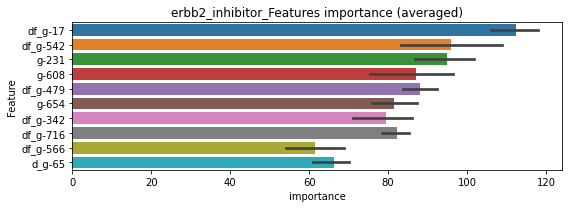

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146715	valid_1's binary_logloss: 0.0254372
[200]	training's binary_logloss: 0.00183584	valid_1's binary_logloss: 0.0114315
[300]	training's binary_logloss: 0.000500021	valid_1's binary_logloss: 0.0100405
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00054301	valid_1's binary_logloss: 0.00998585


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151514	valid_1's binary_logloss: 0.0210896
[200]	training's binary_logloss: 0.00198101	valid_1's binary_logloss: 0.00641915
[300]	training's binary_logloss: 0.000550151	valid_1's binary_logloss: 0.00456767
[400]	training's binary_logloss: 0.000274015	valid_1's binary_logloss: 0.00411581
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000241049	valid_1's binary_logloss: 0.00407016


erbb2_inhibitor logloss: 0.007028002502048618
estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095


neg labels: 3289 → selected neg labels: 3265


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137446	valid_1's binary_logloss: 0.230814
[200]	training's binary_logloss: 0.0779715	valid_1's binary_logloss: 0.213276
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0770003	valid_1's binary_logloss: 0.213237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149863	valid_1's binary_logloss: 0.201594


1 / 3 AUC score:0.926
y_Threshold: 0.1597386, Threshold: 0.2579163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 407 → Positive_corect_labels: 515/3511
p_label_rate: 0.0200904 Vs.target_rate: 0.00663, Num_p_label: 80.0, conf_0:0.23212, conf_1:0.28371
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.2579163
Num_p_label: 69.0, Expected: 26.4, Adj_threshold_2: 0.2679163
Num_p_label: 57.0, Expected: 26.4, Adj_threshold_3: 0.2779163
Num_p_label: 50.0, Expected: 26.4, Adj_threshold_4: 0.2879163
threshold: 0.2879163, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 515.0/3511, y_label_rate: 0.1466819
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0906677	valid_1's binary_logloss: 0.182646
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0948284	valid_1's binary_logloss: 0.182562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059119	valid_1's binary_logloss: 0.110754
[200]	training's binary_logloss: 0.0201098	valid_1's binary_logloss: 0.083466
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0137915	valid_1's binary_logloss: 0.0806013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712404	valid_1's binary_logloss: 0.10025
[200]	training's binary_logloss: 0.0258396	valid_1's binary_logloss: 0.0633324


2 / 3 AUC score:0.993
y_Threshold: 0.1428370, Threshold: 0.2879163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 478.0/3437
p_label_rate: 0.0170768 Vs.target_rate: 0.00663, Num_p_label: 68.0, conf_0:0.25912, conf_1:0.31671
threshold: 0.2879163, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 478.0/3437, y_label_rate: 0.1390748
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0115009	valid_1's binary_logloss: 0.0536275
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0115009	valid_1's binary_logloss: 0.0536275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048095	valid_1's binary_logloss: 0.0715062
[200]	training's binary_logloss: 0.014965	valid_1's binary_logloss: 0.0412522
[300]	training's binary_logloss: 0.0062583	valid_1's binary_logloss: 0.0318968
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00556078	valid_1's binary_logloss: 0.0313917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466065	valid_1's binary_logloss: 0.0872377
[200]	training's binary_logloss: 0.0133849	valid_1's binary_logloss: 0.0506909


3 / 3 AUC score:0.999
y_Threshold: 0.1207919, Threshold: 0.2879163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 465.0/3411
p_label_rate: 0.0113009 Vs.target_rate: 0.00663, Num_p_label: 45.0, conf_0:0.25912, conf_1:0.31671
threshold: 0.2879163, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 510.0/7393, y_label_rate: 0.0689842


[300]	training's binary_logloss: 0.00558363	valid_1's binary_logloss: 0.0420032
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00578448	valid_1's binary_logloss: 0.0417892


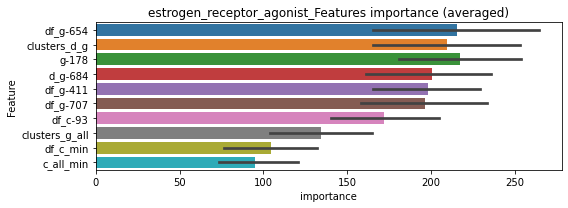

len(train_index) : 3696
len(valid_index) : 3697
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277995	valid_1's binary_logloss: 0.0593184
[200]	training's binary_logloss: 0.00791468	valid_1's binary_logloss: 0.0372461
[300]	training's binary_logloss: 0.00330731	valid_1's binary_logloss: 0.0317465


len(train_index) : 3697
len(valid_index) : 3696
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00206028	valid_1's binary_logloss: 0.0302722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303421	valid_1's binary_logloss: 0.0473122
[200]	training's binary_logloss: 0.00956896	valid_1's binary_logloss: 0.0280138
[300]	training's binary_logloss: 0.00399035	valid_1's binary_logloss: 0.0236118
[400]	training's binary_logloss: 0.00215382	valid_1's binary_logloss: 0.0220494
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0022308	valid_1's binary_logloss: 0.0219888


estrogen_receptor_agonist logloss: 0.026131072713144573
estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404346	valid_1's binary_logloss: 0.083846
[200]	training's binary_logloss: 0.00734898	valid_1's binary_logloss: 0.042353
[300]	training's binary_logloss: 0.00209353	valid_1's binary_logloss: 0.0334337
[400]	training's binary_logloss: 0.00100489	valid_1's binary_logloss: 0.0312405
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00101538	valid_1's binary_logloss: 0.0312112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431315	valid_1's binary_logloss: 0.0678633
[200]	training's binary_logloss: 0.00789828	valid_1's binary_logloss: 0.0234545
[300]	training's binary_logloss: 0.00232818	valid_1's binary_logloss: 0.0128689
[400]	training's binary_logloss: 0.00110255	valid_1's binary_logloss: 0.00997539
[500]	training's binary_logloss: 0.000701114	valid_1's binary_logloss: 0.0084755
Early stopping, best iteration is:
[587]	trai

1 / 3 AUC score:0.997
y_Threshold: 0.0048138, Threshold: 0.0082656, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00744, conf_1:0.00909
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0082656
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.0182656
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0282656
threshold: 0.0282656, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423818	valid_1's binary_logloss: 0.0798312
[200]	training's binary_logloss: 0.00760442	valid_1's binary_logloss: 0.03037
[300]	training's binary_logloss: 0.00215889	valid_1's binary_logloss: 0.0185979
[400]	training's binary_logloss: 0.00103256	valid_1's binary_logloss: 0.0152161
[500]	training's binary_logloss: 0.000666946	valid_1's binary_logloss: 0.0139198
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000670797	valid_1's binary_logloss: 0.0139082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401441	valid_1's binary_logloss: 0.0796812
[200]	training's binary_logloss: 0.00711865	valid_1's binary_logloss: 0.0336575
[300]	training's binary_logloss: 0.00210384	valid_1's binary_logloss: 0.0238024
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00124488	valid_1's binary_logloss: 0.0207972


2 / 3 AUC score:1.000
y_Threshold: 0.0355409, Threshold: 0.0282656, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0090407 Vs.target_rate: 0.00202, Num_p_label: 36.0, conf_0:0.02544, conf_1:0.03109
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_1: 0.0282656
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.0382656
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.0482656
threshold: 0.0482656, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385777	valid_1's binary_logloss: 0.079899
[200]	training's binary_logloss: 0.00678619	valid_1's binary_logloss: 0.0382182
[300]	training's binary_logloss: 0.00200395	valid_1's binary_logloss: 0.0288848
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00155157	valid_1's binary_logloss: 0.0276171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415594	valid_1's binary_logloss: 0.0707019
[200]	training's binary_logloss: 0.0075788	valid_1's binary_logloss: 0.0261049
[300]	training's binary_logloss: 0.00219885	valid_1's binary_logloss: 0.0148096
[400]	training's binary_logloss: 0.00105334	valid_1's binary_logloss: 0.0112409
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000859168	valid_1's binary_logloss: 0.0105558


3 / 3 AUC score:1.000
y_Threshold: 0.0339313, Threshold: 0.0482656, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0062783 Vs.target_rate: 0.00202, Num_p_label: 25.0, conf_0:0.04344, conf_1:0.05309
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.0482656
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.0582656
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.0682656
threshold: 0.0682656, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 662.0/7781, y_label_rate: 0.0850790


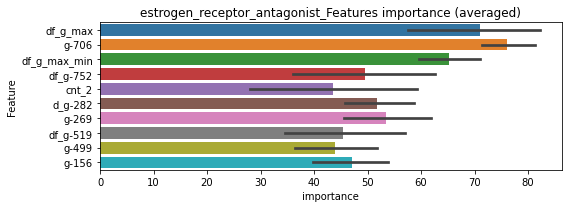

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229122	valid_1's binary_logloss: 0.046067
[200]	training's binary_logloss: 0.00401346	valid_1's binary_logloss: 0.0238489
[300]	training's binary_logloss: 0.00113866	valid_1's binary_logloss: 0.018768
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000909406	valid_1's binary_logloss: 0.018213


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224015	valid_1's binary_logloss: 0.0442409
[200]	training's binary_logloss: 0.00423999	valid_1's binary_logloss: 0.0181747
[300]	training's binary_logloss: 0.00123488	valid_1's binary_logloss: 0.0116535
[400]	training's binary_logloss: 0.000582967	valid_1's binary_logloss: 0.00967419
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000407283	valid_1's binary_logloss: 0.00904398


estrogen_receptor_antagonist logloss: 0.013629068867504065


neg labels: 3289 → selected neg labels: 3283


faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035113	valid_1's binary_logloss: 0.0575904
[200]	training's binary_logloss: 0.00537198	valid_1's binary_logloss: 0.0157298
[300]	training's binary_logloss: 0.00148994	valid_1's binary_logloss: 0.00738471
[400]	training's binary_logloss: 0.000732456	valid_1's binary_logloss: 0.00521132
[500]	training's binary_logloss: 0.000502185	valid_1's binary_logloss: 0.00434093
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000446145	valid_1's binary_logloss: 0.00413735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355896	valid_1's binary_logloss: 0.0539161
[200]	training's binary_logloss: 0.00563409	valid_1's binary_logloss: 0.0145983
[300]	training's binary_logloss: 0.00158756	valid_1's binary_logloss: 0.00624978
[400]	training's binary_logloss: 0.000772586	valid_1's binary_logloss: 0.00391624
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0059242, Threshold: 0.0158518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.01427, conf_1:0.01744
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0158518
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_2: 0.0258518
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.0358518
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.0458518
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0558518
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_6: 0.0658518
threshold: 0.0658518, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333165	valid_1's binary_logloss: 0.0554012
[200]	training's binary_logloss: 0.00486923	valid_1's binary_logloss: 0.0143413
[300]	training's binary_logloss: 0.00140535	valid_1's binary_logloss: 0.00661667
[400]	training's binary_logloss: 0.000692583	valid_1's binary_logloss: 0.00446281
[500]	training's binary_logloss: 0.000480766	valid_1's binary_logloss: 0.00365003
[600]	training's binary_logloss: 0.000424229	valid_1's binary_logloss: 0.0034415
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000424348	valid_1's binary_logloss: 0.00344127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344576	valid_1's binary_logloss: 0.0498498
[200]	training's binary_logloss: 0.00526932	valid_1's binary_logloss: 0.0116342
[300]	training's binary_logloss: 0.0014816	valid_1's binary_logloss: 0.00459205
[400]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.1950102, Threshold: 0.0658518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0168257 Vs.target_rate: 0.00151, Num_p_label: 67.0, conf_0:0.05927, conf_1:0.07244
Num_p_label: 67.0, Expected: 6.0, Adj_threshold_1: 0.0658518
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_2: 0.0758518
Num_p_label: 51.0, Expected: 6.0, Adj_threshold_3: 0.0858518
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_4: 0.0958518
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_5: 0.1058518
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_6: 0.1158518
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_7: 0.1258518
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_8: 0.1358518
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_9: 0.1458518
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_10: 0.1558518
threshold: 0.1658518, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333165	valid_1's binary_logloss: 0.0554012
[200]	training's binary_logloss: 0.00486923	valid_1's binary_logloss: 0.0143413
[300]	training's binary_logloss: 0.00140535	valid_1's binary_logloss: 0.00661667
[400]	training's binary_logloss: 0.000692583	valid_1's binary_logloss: 0.00446281
[500]	training's binary_logloss: 0.000480766	valid_1's binary_logloss: 0.00365003
[600]	training's binary_logloss: 0.000424229	valid_1's binary_logloss: 0.0034415
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000424348	valid_1's binary_logloss: 0.00344127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344576	valid_1's binary_logloss: 0.0498498
[200]	training's binary_logloss: 0.00526932	valid_1's binary_logloss: 0.0116342
[300]	training's binary_logloss: 0.0014816	valid_1's binary_logloss: 0.00459205
[400]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.1950102, Threshold: 0.1658518, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.14927, conf_1:0.18244
threshold: 0.1658518, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7789, y_label_rate: 0.0864039


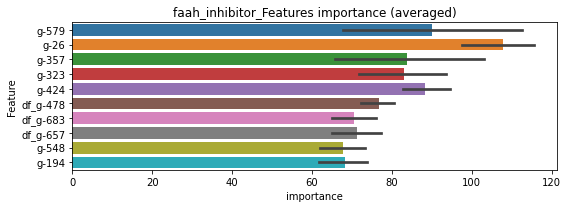

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183752	valid_1's binary_logloss: 0.0366435
[200]	training's binary_logloss: 0.00279798	valid_1's binary_logloss: 0.0164245
[300]	training's binary_logloss: 0.000810501	valid_1's binary_logloss: 0.0131965
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000626228	valid_1's binary_logloss: 0.0129813


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207807	valid_1's binary_logloss: 0.0364863
[200]	training's binary_logloss: 0.003189	valid_1's binary_logloss: 0.0128941
[300]	training's binary_logloss: 0.00089463	valid_1's binary_logloss: 0.00870006
[400]	training's binary_logloss: 0.000428943	valid_1's binary_logloss: 0.0076958
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000451109	valid_1's binary_logloss: 0.00764705


faah_inhibitor logloss: 0.010314525584753976
farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182511	valid_1's binary_logloss: 0.02114
[200]	training's binary_logloss: 0.00177443	valid_1's binary_logloss: 0.00293515
[300]	training's binary_logloss: 0.000486947	valid_1's binary_logloss: 0.00115865
[400]	training's binary_logloss: 0.000282241	valid_1's binary_logloss: 0.000838592
[500]	training's binary_logloss: 0.000238021	valid_1's binary_logloss: 0.000766516
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000233335	valid_1's binary_logloss: 0.000754972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182372	valid_1's binary_logloss: 0.0210857
[200]	training's binary_logloss: 0.00177413	valid_1's binary_logloss: 0.00315453
[300]	training's binary_logloss: 0.000485457	valid_1's binary_logloss: 0.00147195
[400]	training's binary_logloss: 0.000279274	valid_1's binary_logloss: 0.00111412
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0010984, Threshold: 0.0025582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00230, conf_1:0.00281
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025582
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_2: 0.0125582
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.0225582
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.0325582
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0425582
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.0525582
threshold: 0.0525582, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018168	valid_1's binary_logloss: 0.0208903
[200]	training's binary_logloss: 0.00169136	valid_1's binary_logloss: 0.0026852
[300]	training's binary_logloss: 0.000450854	valid_1's binary_logloss: 0.000946289
[400]	training's binary_logloss: 0.000262497	valid_1's binary_logloss: 0.000626023
[500]	training's binary_logloss: 0.000228923	valid_1's binary_logloss: 0.000569538
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000226504	valid_1's binary_logloss: 0.000564882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184947	valid_1's binary_logloss: 0.0212905
[200]	training's binary_logloss: 0.00177447	valid_1's binary_logloss: 0.00283199
[300]	training's binary_logloss: 0.000494734	valid_1's binary_logloss: 0.00114976
[400]	training's binary_logloss: 0.000297731	valid_1's binary_logloss: 0.000838333
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1540389, Threshold: 0.0525582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00076, Num_p_label: 36.0, conf_0:0.04730, conf_1:0.05781
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_1: 0.0525582
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_2: 0.0625582
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.0725582
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_4: 0.0825582
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_5: 0.0925582
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_6: 0.1025582
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_7: 0.1125582
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_8: 0.1225582
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.1325582
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_10: 0.1425582
threshold: 0.1525582, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018168	valid_1's binary_logloss: 0.0208903
[200]	training's binary_logloss: 0.00169136	valid_1's binary_logloss: 0.0026852
[300]	training's binary_logloss: 0.000450854	valid_1's binary_logloss: 0.000946289
[400]	training's binary_logloss: 0.000262497	valid_1's binary_logloss: 0.000626023
[500]	training's binary_logloss: 0.000228923	valid_1's binary_logloss: 0.000569538
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.000226504	valid_1's binary_logloss: 0.000564882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184947	valid_1's binary_logloss: 0.0212905
[200]	training's binary_logloss: 0.00177447	valid_1's binary_logloss: 0.00283199
[300]	training's binary_logloss: 0.000494734	valid_1's binary_logloss: 0.00114976
[400]	training's binary_logloss: 0.000297731	valid_1's binary_logloss: 0.000838333
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1540389, Threshold: 0.1525582, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.13730, conf_1:0.16781
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.1525582
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.1625582
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.1725582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.1825582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.1925582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.2025582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.2125582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_8: 0.2225582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_9: 0.2325582
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_10: 0.2425582
threshold: 0.2525582, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 672.0/7793, y_label_rate: 0.0862312


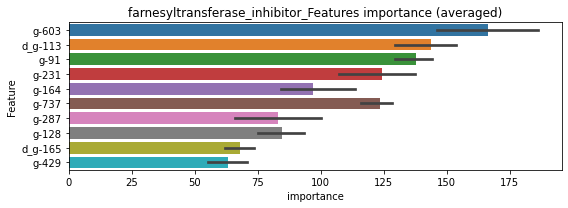

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100136	valid_1's binary_logloss: 0.016264
[200]	training's binary_logloss: 0.000968063	valid_1's binary_logloss: 0.00674813
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000320662	valid_1's binary_logloss: 0.0060128


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103653	valid_1's binary_logloss: 0.0134694
[200]	training's binary_logloss: 0.00106176	valid_1's binary_logloss: 0.00325159
[300]	training's binary_logloss: 0.000289132	valid_1's binary_logloss: 0.0022506
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000174645	valid_1's binary_logloss: 0.00211566


farnesyltransferase_inhibitor logloss: 0.004064478972469839
fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288312	valid_1's binary_logloss: 0.0433085
[200]	training's binary_logloss: 0.00389629	valid_1's binary_logloss: 0.0104756
[300]	training's binary_logloss: 0.00110158	valid_1's binary_logloss: 0.00492676
[400]	training's binary_logloss: 0.000558691	valid_1's binary_logloss: 0.00353058
[500]	training's binary_logloss: 0.000404999	valid_1's binary_logloss: 0.00304525
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000388928	valid_1's binary_logloss: 0.00302646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303122	valid_1's binary_logloss: 0.0397009
[200]	training's binary_logloss: 0.00411679	valid_1's binary_logloss: 0.0081224
[300]	training's binary_logloss: 0.00117152	valid_1's binary_logloss: 0.00321577
[400]	training's binary_logloss: 0.000584737	valid_1's binary_logloss: 0.00195714
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0025760, Threshold: 0.0046906, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00422, conf_1:0.00516
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0046906
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0146906
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_3: 0.0246906
threshold: 0.0246906, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281561	valid_1's binary_logloss: 0.0418836
[200]	training's binary_logloss: 0.00373498	valid_1's binary_logloss: 0.010587
[300]	training's binary_logloss: 0.00105087	valid_1's binary_logloss: 0.00522112
[400]	training's binary_logloss: 0.000540681	valid_1's binary_logloss: 0.00385151
[500]	training's binary_logloss: 0.000399611	valid_1's binary_logloss: 0.00341924
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000389977	valid_1's binary_logloss: 0.00338266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292886	valid_1's binary_logloss: 0.0374712
[200]	training's binary_logloss: 0.00392636	valid_1's binary_logloss: 0.00707588
[300]	training's binary_logloss: 0.00112139	valid_1's binary_logloss: 0.00281785
[400]	training's binary_logloss: 0.000565802	valid_1's binary_logloss: 0.00168345
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0430610, Threshold: 0.0246906, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.02222, conf_1:0.02716
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0246906
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.0346906
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_3: 0.0446906
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.0546906
threshold: 0.0546906, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281561	valid_1's binary_logloss: 0.0418836
[200]	training's binary_logloss: 0.00373498	valid_1's binary_logloss: 0.010587
[300]	training's binary_logloss: 0.00105087	valid_1's binary_logloss: 0.00522112
[400]	training's binary_logloss: 0.000540681	valid_1's binary_logloss: 0.00385151
[500]	training's binary_logloss: 0.000399611	valid_1's binary_logloss: 0.00341924
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000389977	valid_1's binary_logloss: 0.00338266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292886	valid_1's binary_logloss: 0.0374712
[200]	training's binary_logloss: 0.00392636	valid_1's binary_logloss: 0.00707588
[300]	training's binary_logloss: 0.00112139	valid_1's binary_logloss: 0.00281785
[400]	training's binary_logloss: 0.000565802	valid_1's binary_logloss: 0.00168345
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0430610, Threshold: 0.0546906, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.04922, conf_1:0.06016
threshold: 0.0546906, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


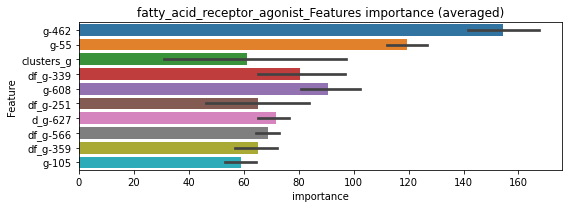

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155431	valid_1's binary_logloss: 0.0242935
[200]	training's binary_logloss: 0.00206776	valid_1's binary_logloss: 0.00811084
[300]	training's binary_logloss: 0.0005619	valid_1's binary_logloss: 0.00663465
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000474217	valid_1's binary_logloss: 0.00654865


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163483	valid_1's binary_logloss: 0.0224635
[200]	training's binary_logloss: 0.00221016	valid_1's binary_logloss: 0.00481809
[300]	training's binary_logloss: 0.000619774	valid_1's binary_logloss: 0.00217635
[400]	training's binary_logloss: 0.00031024	valid_1's binary_logloss: 0.00166944
[500]	training's binary_logloss: 0.000220265	valid_1's binary_logloss: 0.00154753
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000224241	valid_1's binary_logloss: 0.00154666


fatty_acid_receptor_agonist logloss: 0.004047651763114223
fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355204	valid_1's binary_logloss: 0.0563266
[200]	training's binary_logloss: 0.00571939	valid_1's binary_logloss: 0.0172635
[300]	training's binary_logloss: 0.00166732	valid_1's binary_logloss: 0.00902855
[400]	training's binary_logloss: 0.000826972	valid_1's binary_logloss: 0.00673996
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000685679	valid_1's binary_logloss: 0.00611668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355602	valid_1's binary_logloss: 0.0617158
[200]	training's binary_logloss: 0.00563277	valid_1's binary_logloss: 0.0207851
[300]	training's binary_logloss: 0.00164731	valid_1's binary_logloss: 0.012101
[400]	training's binary_logloss: 0.000832993	valid_1's binary_logloss: 0.00955275
[500]	training's binary_logloss: 0.000551206	valid_1's binary_logloss: 0.00818363
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0054339, Threshold: 0.0149125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00210, Num_p_label: 80.0, conf_0:0.01342, conf_1:0.01640
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0149125
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_2: 0.0249125
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_3: 0.0349125
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_4: 0.0449125
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_5: 0.0549125
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_6: 0.0649125
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_7: 0.0749125
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_8: 0.0849125
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_9: 0.0949125
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_10: 0.1049125
threshold: 0.1149125, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334121	valid_1's binary_logloss: 0.0515242
[200]	training's binary_logloss: 0.00518427	valid_1's binary_logloss: 0.0144108
[300]	training's binary_logloss: 0.00151969	valid_1's binary_logloss: 0.0074167
[400]	training's binary_logloss: 0.000750951	valid_1's binary_logloss: 0.00537658
[500]	training's binary_logloss: 0.000514782	valid_1's binary_logloss: 0.00452291
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0004822	valid_1's binary_logloss: 0.00442263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335017	valid_1's binary_logloss: 0.0567685
[200]	training's binary_logloss: 0.00511396	valid_1's binary_logloss: 0.017233
[300]	training's binary_logloss: 0.00146934	valid_1's binary_logloss: 0.00929074
[400]	training's binary_logloss: 0.000735747	valid_1's binary_logloss: 0.00710229
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.1071601, Threshold: 0.1149125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0130588 Vs.target_rate: 0.00210, Num_p_label: 52.0, conf_0:0.10342, conf_1:0.12640
Num_p_label: 52.0, Expected: 8.4, Adj_threshold_1: 0.1149125
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_2: 0.1249125
Num_p_label: 44.0, Expected: 8.4, Adj_threshold_3: 0.1349125
Num_p_label: 42.0, Expected: 8.4, Adj_threshold_4: 0.1449125
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_5: 0.1549125
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_6: 0.1649125
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_7: 0.1749125
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_8: 0.1849125
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_9: 0.1949125
Num_p_label: 29.0, Expected: 8.4, Adj_threshold_10: 0.2049125
threshold: 0.2149125, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334121	valid_1's binary_logloss: 0.0515242
[200]	training's binary_logloss: 0.00518427	valid_1's binary_logloss: 0.0144108
[300]	training's binary_logloss: 0.00151969	valid_1's binary_logloss: 0.0074167
[400]	training's binary_logloss: 0.000750951	valid_1's binary_logloss: 0.00537658
[500]	training's binary_logloss: 0.000514782	valid_1's binary_logloss: 0.00452291
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0004822	valid_1's binary_logloss: 0.00442263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335017	valid_1's binary_logloss: 0.0567685
[200]	training's binary_logloss: 0.00511396	valid_1's binary_logloss: 0.017233
[300]	training's binary_logloss: 0.00146934	valid_1's binary_logloss: 0.00929074
[400]	training's binary_logloss: 0.000735747	valid_1's binary_logloss: 0.00710229
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.1071601, Threshold: 0.2149125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0065294 Vs.target_rate: 0.00210, Num_p_label: 26.0, conf_0:0.19342, conf_1:0.23640
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_1: 0.2149125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_2: 0.2249125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_3: 0.2349125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_4: 0.2449125
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_5: 0.2549125
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_6: 0.2649125
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_7: 0.2749125
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_8: 0.2849125
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_9: 0.2949125
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_10: 0.3049125
threshold: 0.3149125, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 674.0/7784, y_label_rate: 0.0865879


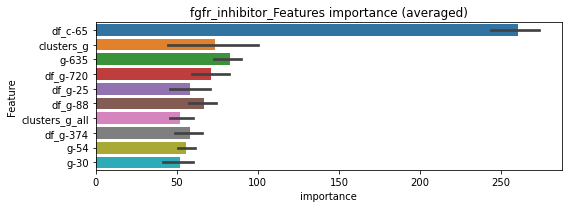

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185256	valid_1's binary_logloss: 0.0398758
[200]	training's binary_logloss: 0.00304166	valid_1's binary_logloss: 0.0186539
[300]	training's binary_logloss: 0.000814893	valid_1's binary_logloss: 0.0130587
[400]	training's binary_logloss: 0.000397653	valid_1's binary_logloss: 0.0115741
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000288268	valid_1's binary_logloss: 0.0110316


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019267	valid_1's binary_logloss: 0.0353642
[200]	training's binary_logloss: 0.00288899	valid_1's binary_logloss: 0.0123459
[300]	training's binary_logloss: 0.000832938	valid_1's binary_logloss: 0.00748331
[400]	training's binary_logloss: 0.000421582	valid_1's binary_logloss: 0.00626709
[500]	training's binary_logloss: 0.000287446	valid_1's binary_logloss: 0.00586065
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000264781	valid_1's binary_logloss: 0.00573603


fgfr_inhibitor logloss: 0.008383800940466157
flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985085	valid_1's binary_logloss: 0.182532
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0707581	valid_1's binary_logloss: 0.177029
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.951
y_Threshold: 0.1799730, Threshold: 0.5913169, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 308 → Positive_corect_labels: 566/3618
p_label_rate: 0.0200904 Vs.target_rate: 0.01172, Num_p_label: 80.0, conf_0:0.53219, conf_1:0.65045
threshold: 0.5913169, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 566.0/3618, y_label_rate: 0.1564400
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.0976773	valid_1's binary_logloss: 0.182928
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0779156	valid_1's binary_logloss: 0.178866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433221	valid_1's binary_logloss: 0.073081
[200]	training's binary_logloss: 0.0117146	valid_1's binary_logloss: 0.0477535
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00906243	valid_1's binary_logloss: 0.046357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408095	valid_1's binary_logloss: 0.0763401
[200]	training's binary_logloss: 0.0104874	valid_1's binary_logloss: 0.0534381


2 / 3 AUC score:0.995
y_Threshold: 0.3625739, Threshold: 0.5913169, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 538.0/3562
p_label_rate: 0.0547464 Vs.target_rate: 0.01172, Num_p_label: 218.0, conf_0:0.53219, conf_1:0.65045
Num_p_label: 218.0, Expected: 46.7, Adj_threshold_1: 0.5913169
Num_p_label: 211.0, Expected: 46.7, Adj_threshold_2: 0.6013169
Num_p_label: 207.0, Expected: 46.7, Adj_threshold_3: 0.6113169
Num_p_label: 202.0, Expected: 46.7, Adj_threshold_4: 0.6213169
Num_p_label: 200.0, Expected: 46.7, Adj_threshold_5: 0.6313169
Num_p_label: 198.0, Expected: 46.7, Adj_threshold_6: 0.6413169
Num_p_label: 196.0, Expected: 46.7, Adj_threshold_7: 0.6513169
Num_p_label: 193.0, Expected: 46.7, Adj_threshold_8: 0.6613169
Num_p_label: 190.0, Expected: 46.7, Adj_threshold_9: 0.6713169
Num_p_label: 184.0, Expected: 46.7, Adj_threshold_10: 0.6813169
threshold: 0.6913169, positive_p_label: 182.0/3982, p_label_rate: 0.0457057


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00451877	valid_1's binary_logloss: 0.0483392


positive_y_label: 538.0/3562, y_label_rate: 0.1510387
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321028	valid_1's binary_logloss: 0.048449
[200]	training's binary_logloss: 0.0068947	valid_1's binary_logloss: 0.0239715
[300]	training's binary_logloss: 0.00253334	valid_1's binary_logloss: 0.018636
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00236465	valid_1's binary_logloss: 0.0182543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343052	valid_1's binary_logloss: 0.0685309


3 / 3 AUC score:0.999
y_Threshold: 0.2215417, Threshold: 0.6913169, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 521.0/3528
p_label_rate: 0.0570065 Vs.target_rate: 0.01172, Num_p_label: 227.0, conf_0:0.62219, conf_1:0.76045
Num_p_label: 227.0, Expected: 46.7, Adj_threshold_1: 0.6913169
Num_p_label: 226.0, Expected: 46.7, Adj_threshold_2: 0.7013169
Num_p_label: 224.0, Expected: 46.7, Adj_threshold_3: 0.7113169
Num_p_label: 222.0, Expected: 46.7, Adj_threshold_4: 0.7213169
Num_p_label: 218.0, Expected: 46.7, Adj_threshold_5: 0.7313169
Num_p_label: 216.0, Expected: 46.7, Adj_threshold_6: 0.7413169
Num_p_label: 214.0, Expected: 46.7, Adj_threshold_7: 0.7513169
Num_p_label: 213.0, Expected: 46.7, Adj_threshold_8: 0.7613169
Num_p_label: 207.0, Expected: 46.7, Adj_threshold_9: 0.7713169
Num_p_label: 201.0, Expected: 46.7, Adj_threshold_10: 0.7813169
threshold: 0.7913169, positive_p_label: 197.0/3982, p_label_rate: 0.0494726


[200]	training's binary_logloss: 0.00709416	valid_1's binary_logloss: 0.0462451
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00529439	valid_1's binary_logloss: 0.0441977


positive_y_label: 718.0/7510, y_label_rate: 0.0956059


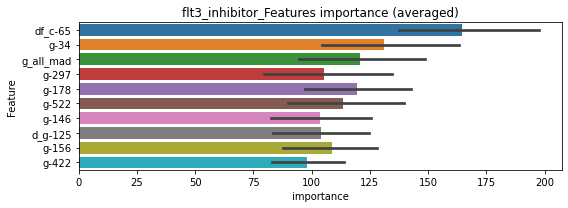

len(train_index) : 3755
len(valid_index) : 3755
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249238	valid_1's binary_logloss: 0.0370351
[200]	training's binary_logloss: 0.00622417	valid_1's binary_logloss: 0.0212015
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00280956	valid_1's binary_logloss: 0.018879


len(train_index) : 3755
len(valid_index) : 3755
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228351	valid_1's binary_logloss: 0.0421202


flt3_inhibitor logloss: 0.023113261263145096


[200]	training's binary_logloss: 0.00505462	valid_1's binary_logloss: 0.0287493
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00292053	valid_1's binary_logloss: 0.0273475


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186156	valid_1's binary_logloss: 0.0222635
[200]	training's binary_logloss: 0.00179297	valid_1's binary_logloss: 0.00447101
[300]	training's binary_logloss: 0.000479443	valid_1's binary_logloss: 0.00273882
[400]	training's binary_logloss: 0.000278436	valid_1's binary_logloss: 0.00226753
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000257923	valid_1's binary_logloss: 0.00220829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186012	valid_1's binary_logloss: 0.0223719
[200]	training's binary_logloss: 0.0018081	valid_1's binary_logloss: 0.0034355
[300]	training's binary_logloss: 0.000503231	valid_1's binary_logloss: 0.00154926
[400]	training's binary_logloss: 0.000284086	valid_1's binary_logloss: 0.00116596
[500]	training's binary_logloss: 0.000242849	valid_1's binary_logloss: 0.00107821
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0012361, Threshold: 0.0035660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00321, conf_1:0.00392
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0035660
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_2: 0.0135660
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_3: 0.0235660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.0335660
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_5: 0.0435660
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.0535660
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.0635660
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.0735660
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.0835660
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.0935660
threshold: 0.1035660, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182624	valid_1's binary_logloss: 0.0203381
[200]	training's binary_logloss: 0.00170582	valid_1's binary_logloss: 0.00274655
[300]	training's binary_logloss: 0.000440555	valid_1's binary_logloss: 0.000934566
[400]	training's binary_logloss: 0.000252746	valid_1's binary_logloss: 0.000591287
[500]	training's binary_logloss: 0.000220486	valid_1's binary_logloss: 0.000533406
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000216774	valid_1's binary_logloss: 0.000527896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180667	valid_1's binary_logloss: 0.0212789
[200]	training's binary_logloss: 0.00168863	valid_1's binary_logloss: 0.00267075
[300]	training's binary_logloss: 0.000442158	valid_1's binary_logloss: 0.000875716
[400]	training's binary_logloss: 0.000253327	valid_1's binary_logloss: 0.000549823


2 / 3 AUC score:1.000
y_Threshold: 0.1608196, Threshold: 0.1035660, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000217494	valid_1's binary_logloss: 0.00048271


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0075339 Vs.target_rate: 0.00076, Num_p_label: 30.0, conf_0:0.09321, conf_1:0.11392
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.1035660
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.1135660
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.1235660
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.1335660
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.1435660
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_6: 0.1535660
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_7: 0.1635660
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_8: 0.1735660
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_9: 0.1835660
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_10: 0.1935660
threshold: 0.2035660, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182624	valid_1's binary_logloss: 0.0203381
[200]	training's binary_logloss: 0.00170582	valid_1's binary_logloss: 0.00274655
[300]	training's binary_logloss: 0.000440555	valid_1's binary_logloss: 0.000934566
[400]	training's binary_logloss: 0.000252746	valid_1's binary_logloss: 0.000591287
[500]	training's binary_logloss: 0.000220486	valid_1's binary_logloss: 0.000533406
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000216774	valid_1's binary_logloss: 0.000527896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180667	valid_1's binary_logloss: 0.0212789
[200]	training's binary_logloss: 0.00168863	valid_1's binary_logloss: 0.00267075
[300]	training's binary_logloss: 0.000442158	valid_1's binary_logloss: 0.000875716
[400]	training's binary_logloss: 0.000253327	valid_1's binary_logloss: 0.000549823
Early stopping, best iter

3 / 3 AUC score:1.000
y_Threshold: 0.1608196, Threshold: 0.2035660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.18321, conf_1:0.22392
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.2035660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.2135660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.2235660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.2335660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.2435660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.2535660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.2635660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.2735660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.2835660
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_10: 0.2935660
threshold: 0.3035660, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 674.0/7793, y_label_rate: 0.0864879


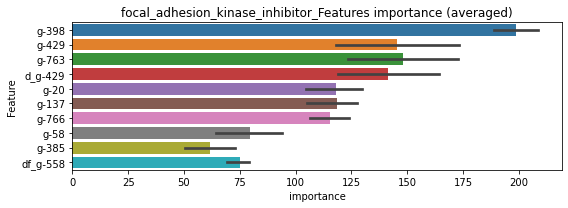

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100247	valid_1's binary_logloss: 0.0178141
[200]	training's binary_logloss: 0.000978748	valid_1's binary_logloss: 0.00825218


len(train_index) : 3897
len(valid_index) : 3896


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.000750184	valid_1's binary_logloss: 0.0080629


================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104623	valid_1's binary_logloss: 0.0135443
[200]	training's binary_logloss: 0.00108581	valid_1's binary_logloss: 0.00400957
[300]	training's binary_logloss: 0.000291724	valid_1's binary_logloss: 0.00312649
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000209734	valid_1's binary_logloss: 0.00301232


focal_adhesion_kinase_inhibitor logloss: 0.0055379341795264445
free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233164	valid_1's binary_logloss: 0.0304662
[200]	training's binary_logloss: 0.00274652	valid_1's binary_logloss: 0.00620061
[300]	training's binary_logloss: 0.000786513	valid_1's binary_logloss: 0.00279841
[400]	training's binary_logloss: 0.00041973	valid_1's binary_logloss: 0.00190608
[500]	training's binary_logloss: 0.00033576	valid_1's binary_logloss: 0.00173934
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000332594	valid_1's binary_logloss: 0.00172481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239849	valid_1's binary_logloss: 0.0340413
[200]	training's binary_logloss: 0.00286316	valid_1's binary_logloss: 0.00625057
[300]	training's binary_logloss: 0.000793278	valid_1's binary_logloss: 0.00275268
[400]	training's binary_logloss: 0.000421668	valid_1's binary_logloss: 0.00196394
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0016733, Threshold: 0.0027682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00249, conf_1:0.00304
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0027682
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0127682
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0227682
threshold: 0.0227682, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230176	valid_1's binary_logloss: 0.0302684
[200]	training's binary_logloss: 0.00265168	valid_1's binary_logloss: 0.00664131
[300]	training's binary_logloss: 0.000761477	valid_1's binary_logloss: 0.00324572
[400]	training's binary_logloss: 0.000410156	valid_1's binary_logloss: 0.00239882
[500]	training's binary_logloss: 0.000333005	valid_1's binary_logloss: 0.00218486
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000330633	valid_1's binary_logloss: 0.00217152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024336	valid_1's binary_logloss: 0.035315
[200]	training's binary_logloss: 0.00283952	valid_1's binary_logloss: 0.00662707
[300]	training's binary_logloss: 0.000795764	valid_1's binary_logloss: 0.00285107
[400]	training's binary_logloss: 0.000425287	valid_1's binary_logloss: 0.00193194
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0621786, Threshold: 0.0227682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.02049, conf_1:0.02504
threshold: 0.0227682, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230176	valid_1's binary_logloss: 0.0302684
[200]	training's binary_logloss: 0.00265168	valid_1's binary_logloss: 0.00664131
[300]	training's binary_logloss: 0.000761477	valid_1's binary_logloss: 0.00324572
[400]	training's binary_logloss: 0.000410156	valid_1's binary_logloss: 0.00239882
[500]	training's binary_logloss: 0.000333005	valid_1's binary_logloss: 0.00218486
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000330633	valid_1's binary_logloss: 0.00217152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024336	valid_1's binary_logloss: 0.035315
[200]	training's binary_logloss: 0.00283952	valid_1's binary_logloss: 0.00662707
[300]	training's binary_logloss: 0.000795764	valid_1's binary_logloss: 0.00285107
[400]	training's binary_logloss: 0.000425287	valid_1's binary_logloss: 0.00193194
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0621786, Threshold: 0.0227682, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.02049, conf_1:0.02504
threshold: 0.0227682, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7793, y_label_rate: 0.0854613


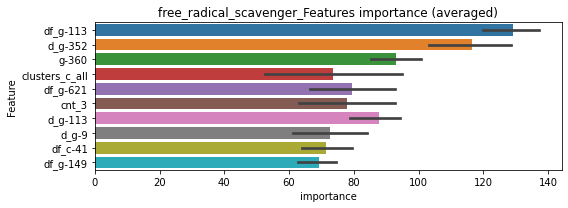

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131863	valid_1's binary_logloss: 0.0224252
[200]	training's binary_logloss: 0.0015476	valid_1's binary_logloss: 0.0090532
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000662263	valid_1's binary_logloss: 0.0080706


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133334	valid_1's binary_logloss: 0.0182393
[200]	training's binary_logloss: 0.00160335	valid_1's binary_logloss: 0.00542665
[300]	training's binary_logloss: 0.000449428	valid_1's binary_logloss: 0.00421695
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000353114	valid_1's binary_logloss: 0.00417005


free_radical_scavenger logloss: 0.006120576045728971
fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276665	valid_1's binary_logloss: 0.0410167
[200]	training's binary_logloss: 0.00358576	valid_1's binary_logloss: 0.00879389
[300]	training's binary_logloss: 0.00101213	valid_1's binary_logloss: 0.0034157
[400]	training's binary_logloss: 0.00051705	valid_1's binary_logloss: 0.00211198
[500]	training's binary_logloss: 0.000381713	valid_1's binary_logloss: 0.00174785
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000362231	valid_1's binary_logloss: 0.00170844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277799	valid_1's binary_logloss: 0.035864
[200]	training's binary_logloss: 0.00357787	valid_1's binary_logloss: 0.00618528
[300]	training's binary_logloss: 0.0010177	valid_1's binary_logloss: 0.0021796
[400]	training's binary_logloss: 0.000520483	valid_1's binary_logloss: 0.00129046
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0018170, Threshold: 0.0032669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097, Num_p_label: 80.0, conf_0:0.00294, conf_1:0.00359
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0032669
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.0132669
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_3: 0.0232669
threshold: 0.0232669, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265185	valid_1's binary_logloss: 0.0394992
[200]	training's binary_logloss: 0.00336315	valid_1's binary_logloss: 0.00797474
[300]	training's binary_logloss: 0.000968343	valid_1's binary_logloss: 0.00322759
[400]	training's binary_logloss: 0.000500554	valid_1's binary_logloss: 0.00198627
[500]	training's binary_logloss: 0.000375449	valid_1's binary_logloss: 0.00165283
[600]	training's binary_logloss: 0.000355327	valid_1's binary_logloss: 0.00160237
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000354979	valid_1's binary_logloss: 0.00160194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280004	valid_1's binary_logloss: 0.0342957
[200]	training's binary_logloss: 0.00354929	valid_1's binary_logloss: 0.00535798
[300]	training's binary_logloss: 0.000997482	valid_1's binary_logloss: 0.00177691
[400]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1488202, Threshold: 0.0232669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00097, Num_p_label: 16.0, conf_0:0.02094, conf_1:0.02559
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.0232669
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_2: 0.0332669
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_3: 0.0432669
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_4: 0.0532669
threshold: 0.0532669, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265185	valid_1's binary_logloss: 0.0394992
[200]	training's binary_logloss: 0.00336315	valid_1's binary_logloss: 0.00797474
[300]	training's binary_logloss: 0.000968343	valid_1's binary_logloss: 0.00322759
[400]	training's binary_logloss: 0.000500554	valid_1's binary_logloss: 0.00198627
[500]	training's binary_logloss: 0.000375449	valid_1's binary_logloss: 0.00165283
[600]	training's binary_logloss: 0.000355327	valid_1's binary_logloss: 0.00160237
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.000354979	valid_1's binary_logloss: 0.00160194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280004	valid_1's binary_logloss: 0.0342957
[200]	training's binary_logloss: 0.00354929	valid_1's binary_logloss: 0.00535798
[300]	training's binary_logloss: 0.000997482	valid_1's binary_logloss: 0.00177691
[400]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1488202, Threshold: 0.0532669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0010045 Vs.target_rate: 0.00097, Num_p_label: 4.0, conf_0:0.04794, conf_1:0.05859
threshold: 0.0532669, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7792, y_label_rate: 0.0848306


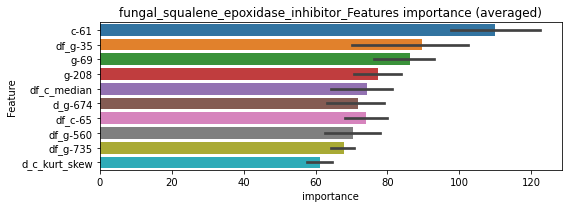

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144002	valid_1's binary_logloss: 0.021918
[200]	training's binary_logloss: 0.00176667	valid_1's binary_logloss: 0.00626506
[300]	training's binary_logloss: 0.00049518	valid_1's binary_logloss: 0.00428185
[400]	training's binary_logloss: 0.00025266	valid_1's binary_logloss: 0.00385397
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000262679	valid_1's binary_logloss: 0.00384891


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152336	valid_1's binary_logloss: 0.0230818
[200]	training's binary_logloss: 0.0020114	valid_1's binary_logloss: 0.00704037
[300]	training's binary_logloss: 0.000543261	valid_1's binary_logloss: 0.00419422
[400]	training's binary_logloss: 0.000264176	valid_1's binary_logloss: 0.00322095
[500]	training's binary_logloss: 0.000191757	valid_1's binary_logloss: 0.00290917
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000187441	valid_1's binary_logloss: 0.00289496


fungal_squalene_epoxidase_inhibitor logloss: 0.003371930978874297
gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107941	valid_1's binary_logloss: 0.174765
[200]	training's binary_logloss: 0.0536648	valid_1's binary_logloss: 0.150489
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0365029	valid_1's binary_logloss: 0.145943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118647	valid_1's binary_logloss: 0.172936
[200]	training's binary_logloss: 0.0614729	valid_1's binary_logloss: 0.141226
[300]	training's binary_logloss: 0.0344316	valid_1's binary_logloss: 0.133048
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0329822	valid_1's binary_logloss: 0.132872


1 / 3 AUC score:0.963
y_Threshold: 0.1228298, Threshold: 0.2400239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 286 → Positive_corect_labels: 577/3640
p_label_rate: 0.0200904 Vs.target_rate: 0.00445, Num_p_label: 80.0, conf_0:0.21602, conf_1:0.26403
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.2400239
Num_p_label: 72.0, Expected: 17.7, Adj_threshold_2: 0.2500239
Num_p_label: 67.0, Expected: 17.7, Adj_threshold_3: 0.2600239
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_4: 0.2700239
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_5: 0.2800239
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_6: 0.2900239
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_7: 0.3000239
Num_p_label: 41.0, Expected: 17.7, Adj_threshold_8: 0.3100239
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_9: 0.3200239
Num_p_label: 33.0, Expected: 17.7, Adj_threshold_10: 0.3300239
threshold: 0.3300239, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 577.0/3640, y_label_rate: 0.158516

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702274	valid_1's binary_logloss: 0.118285
[200]	training's binary_logloss: 0.024914	valid_1's binary_logloss: 0.0792393
[300]	training's binary_logloss: 0.0105646	valid_1's binary_logloss: 0.0677327
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0100844	valid_1's binary_logloss: 0.0671783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778419	valid_1's binary_logloss: 0.122242
[200]	training's binary_logloss: 0.0276144	valid_1's binary_logloss: 0.0787256
[300]	training's binary_logloss: 0.01236	valid_1's binary_logloss: 0.0668645
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0127101	valid_1's binary_logloss: 0.0665406


2 / 3 AUC score:0.995
y_Threshold: 0.1873977, Threshold: 0.3300239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 76 → Positive_corect_labels: 539.0/3564
p_label_rate: 0.0158212 Vs.target_rate: 0.00445, Num_p_label: 63.0, conf_0:0.29702, conf_1:0.36303
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_1: 0.3300239
Num_p_label: 61.0, Expected: 17.7, Adj_threshold_2: 0.3400239
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_3: 0.3500239
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_4: 0.3600239
Num_p_label: 53.0, Expected: 17.7, Adj_threshold_5: 0.3700239
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_6: 0.3800239
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_7: 0.3900239
Num_p_label: 46.0, Expected: 17.7, Adj_threshold_8: 0.4000239
Num_p_label: 39.0, Expected: 17.7, Adj_threshold_9: 0.4100239
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_10: 0.4200239
threshold: 0.4200239, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 539.0/3564, y_label_rate: 0.15123

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062031	valid_1's binary_logloss: 0.0987007
[200]	training's binary_logloss: 0.0196815	valid_1's binary_logloss: 0.0592723
[300]	training's binary_logloss: 0.00788134	valid_1's binary_logloss: 0.0476451
[400]	training's binary_logloss: 0.00426359	valid_1's binary_logloss: 0.0442883
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00413761	valid_1's binary_logloss: 0.0440869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586514	valid_1's binary_logloss: 0.086243
[200]	training's binary_logloss: 0.0186734	valid_1's binary_logloss: 0.0469233
[300]	training's binary_logloss: 0.00789919	valid_1's binary_logloss: 0.0355713
[400]	training's binary_logloss: 0.00423691	valid_1's binary_logloss: 0.0313275
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00400048	valid_1's binary_logloss: 0.0308946


3 / 3 AUC score:0.998
y_Threshold: 0.1498458, Threshold: 0.4200239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 526.0/3538
p_label_rate: 0.0105475 Vs.target_rate: 0.00445, Num_p_label: 42.0, conf_0:0.37802, conf_1:0.46203
threshold: 0.4200239, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 568.0/7520, y_label_rate: 0.0755319


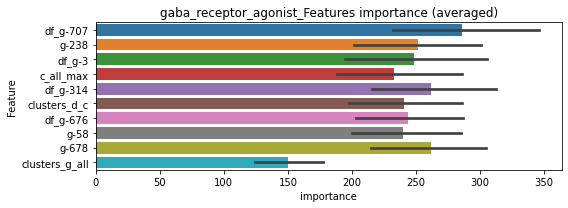

len(train_index) : 3760
len(valid_index) : 3760
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341689	valid_1's binary_logloss: 0.0659944
[200]	training's binary_logloss: 0.011037	valid_1's binary_logloss: 0.0456238
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00627854	valid_1's binary_logloss: 0.0410947


len(train_index) : 3760
len(valid_index) : 3760
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038369	valid_1's binary_logloss: 0.0594924
[200]	training's binary_logloss: 0.0127868	valid_1's binary_logloss: 0.0381324
[300]	training's binary_logloss: 0.0054532	valid_1's binary_logloss: 0.0328322


gaba_receptor_agonist logloss: 0.036447220189338596


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0038651	valid_1's binary_logloss: 0.0317997
neg labels: 3289 → selected neg labels: 3263


gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147912	valid_1's binary_logloss: 0.222401
[200]	training's binary_logloss: 0.0856665	valid_1's binary_logloss: 0.203814
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0822176	valid_1's binary_logloss: 0.203152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154028	valid_1's binary_logloss: 0.220515


1 / 3 AUC score:0.919
y_Threshold: 0.1607525, Threshold: 0.2308417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 413 → Positive_corect_labels: 511/3502
p_label_rate: 0.0200904 Vs.target_rate: 0.00693, Num_p_label: 80.0, conf_0:0.20776, conf_1:0.25393
threshold: 0.2308417, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.103034	valid_1's binary_logloss: 0.200833


positive_y_label: 511.0/3502, y_label_rate: 0.1459166
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716703	valid_1's binary_logloss: 0.121614
[200]	training's binary_logloss: 0.0293916	valid_1's binary_logloss: 0.0906035
[300]	training's binary_logloss: 0.0134791	valid_1's binary_logloss: 0.0833169
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.010334	valid_1's binary_logloss: 0.0816478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802954	valid_1's binary_logloss: 0.11958
[200]	training's binary_logloss: 0.0312426	valid_1's binary_logloss: 0.0763657
[300]	training's binary_logloss: 0.0136011	valid_1's binary_logloss: 0.0657374
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00831105	valid_1's binary_logloss: 0.0634726


2 / 3 AUC score:0.992
y_Threshold: 0.1635939, Threshold: 0.2308417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 472.0/3424
p_label_rate: 0.0200904 Vs.target_rate: 0.00693, Num_p_label: 80.0, conf_0:0.20776, conf_1:0.25393
threshold: 0.2308417, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 472.0/3424, y_label_rate: 0.1378505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564639	valid_1's binary_logloss: 0.0954838
[200]	training's binary_logloss: 0.018337	valid_1's binary_logloss: 0.0523295
[300]	training's binary_logloss: 0.00800651	valid_1's binary_logloss: 0.0409175
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00533795	valid_1's binary_logloss: 0.0377149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588261	valid_1's binary_logloss: 0.083684
[200]	training's binary_logloss: 0.0198728	valid_1's binary_logloss: 0.0482362
[300]	training's binary_logloss: 0.00821987	valid_1's binary_logloss: 0.037736
[400]	training's binary_logloss: 0.00417381	valid_1's binary_logloss: 0.0320709
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00349199	valid_1's binary_logloss: 0.0310958


3 / 3 AUC score:1.000
y_Threshold: 0.1331600, Threshold: 0.2308417, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 461.0/3402
p_label_rate: 0.0173280 Vs.target_rate: 0.00693, Num_p_label: 69.0, conf_0:0.20776, conf_1:0.25393
threshold: 0.2308417, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 530.0/7384, y_label_rate: 0.0717768


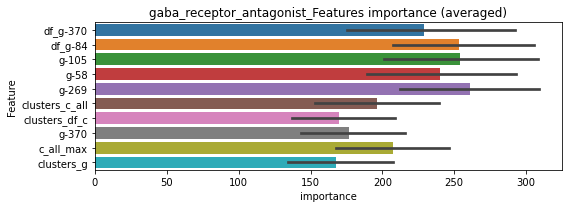

len(train_index) : 3692
len(valid_index) : 3692
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378898	valid_1's binary_logloss: 0.0579341
[200]	training's binary_logloss: 0.012562	valid_1's binary_logloss: 0.0355908
[300]	training's binary_logloss: 0.00562038	valid_1's binary_logloss: 0.0304055
[400]	training's binary_logloss: 0.00295767	valid_1's binary_logloss: 0.028027
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00230486	valid_1's binary_logloss: 0.0271061


len(train_index) : 3692
len(valid_index) : 3692
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381671	valid_1's binary_logloss: 0.0594034
[200]	training's binary_logloss: 0.013357	valid_1's binary_logloss: 0.0398246


gaba_receptor_antagonist logloss: 0.030373506320382566


[300]	training's binary_logloss: 0.00580268	valid_1's binary_logloss: 0.0345009
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00514972	valid_1's binary_logloss: 0.033641


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362378	valid_1's binary_logloss: 0.065721
[200]	training's binary_logloss: 0.00562356	valid_1's binary_logloss: 0.0237172
[300]	training's binary_logloss: 0.00166824	valid_1's binary_logloss: 0.0156391
[400]	training's binary_logloss: 0.000821807	valid_1's binary_logloss: 0.0130325
[500]	training's binary_logloss: 0.000545585	valid_1's binary_logloss: 0.0121059
[600]	training's binary_logloss: 0.000443267	valid_1's binary_logloss: 0.0116454
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000448013	valid_1's binary_logloss: 0.0116376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352132	valid_1's binary_logloss: 0.0660863
[200]	training's binary_logloss: 0.00538799	valid_1's binary_logloss: 0.0269776
[300]	training's binary_logloss: 0.00159249	valid_1's binary_logloss: 0.0198084
[400]	training's binary_logloss: 0.0007797

1 / 3 AUC score:1.000
y_Threshold: 0.0041894, Threshold: 0.0068318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.00615, conf_1:0.00752
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0068318
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_2: 0.0168318
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_3: 0.0268318
threshold: 0.0268318, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353907	valid_1's binary_logloss: 0.0632385
[200]	training's binary_logloss: 0.00529084	valid_1's binary_logloss: 0.0245073
[300]	training's binary_logloss: 0.00155049	valid_1's binary_logloss: 0.0183428
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000986694	valid_1's binary_logloss: 0.0171921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344089	valid_1's binary_logloss: 0.0703541
[200]	training's binary_logloss: 0.00517703	valid_1's binary_logloss: 0.0327214
[300]	training's binary_logloss: 0.0014997	valid_1's binary_logloss: 0.0258473
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000934105	valid_1's binary_logloss: 0.0246297


2 / 3 AUC score:0.999
y_Threshold: 0.0209088, Threshold: 0.0268318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0123054 Vs.target_rate: 0.00235, Num_p_label: 49.0, conf_0:0.02415, conf_1:0.02952
Num_p_label: 49.0, Expected: 9.4, Adj_threshold_1: 0.0268318
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_2: 0.0368318
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_3: 0.0468318
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_4: 0.0568318
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_5: 0.0668318
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_6: 0.0768318
threshold: 0.0768318, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336725	valid_1's binary_logloss: 0.0592742
[200]	training's binary_logloss: 0.00503084	valid_1's binary_logloss: 0.0176608
[300]	training's binary_logloss: 0.0014674	valid_1's binary_logloss: 0.0100754
[400]	training's binary_logloss: 0.000726138	valid_1's binary_logloss: 0.00802345
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000614807	valid_1's binary_logloss: 0.00763937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339558	valid_1's binary_logloss: 0.0601639
[200]	training's binary_logloss: 0.00513321	valid_1's binary_logloss: 0.0198695
[300]	training's binary_logloss: 0.00148944	valid_1's binary_logloss: 0.0117196
[400]	training's binary_logloss: 0.000729407	valid_1's binary_logloss: 0.00932724
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000604763	valid_1's binary_logloss: 0.00884425


3 / 3 AUC score:1.000
y_Threshold: 0.0429355, Threshold: 0.0768318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0040181 Vs.target_rate: 0.00235, Num_p_label: 16.0, conf_0:0.06915, conf_1:0.08452
threshold: 0.0768318, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 663.0/7768, y_label_rate: 0.0853502


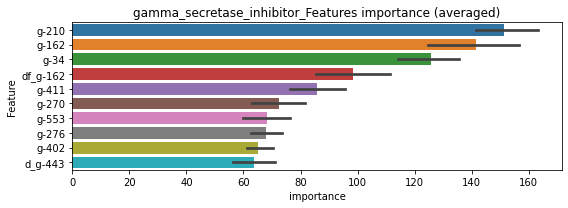

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178814	valid_1's binary_logloss: 0.0436624
[200]	training's binary_logloss: 0.00278124	valid_1's binary_logloss: 0.0254181
[300]	training's binary_logloss: 0.000738916	valid_1's binary_logloss: 0.0226177
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000561987	valid_1's binary_logloss: 0.0222863


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180836	valid_1's binary_logloss: 0.0359568
[200]	training's binary_logloss: 0.00276871	valid_1's binary_logloss: 0.0153165
[300]	training's binary_logloss: 0.000787524	valid_1's binary_logloss: 0.0108829
[400]	training's binary_logloss: 0.000381497	valid_1's binary_logloss: 0.00973397
[500]	training's binary_logloss: 0.000255838	valid_1's binary_logloss: 0.00932875
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000252963	valid_1's binary_logloss: 0.00931238


gamma_secretase_inhibitor logloss: 0.015799341997430095
glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682


neg labels: 3289 → selected neg labels: 3253


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039786	valid_1's binary_logloss: 0.0770284
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0158384	valid_1's binary_logloss: 0.0674026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470946	valid_1's binary_logloss: 0.0634721


1 / 3 AUC score:0.991
y_Threshold: 0.0317364, Threshold: 0.1115082, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 163 → Positive_corect_labels: 634/3740
p_label_rate: 0.0200904 Vs.target_rate: 0.01117, Num_p_label: 80.0, conf_0:0.10036, conf_1:0.12266
threshold: 0.1115082, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 634.0/3740, y_label_rate: 0.1695187
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0132852	valid_1's binary_logloss: 0.0500717
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.010679	valid_1's binary_logloss: 0.0496873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288722	valid_1's binary_logloss: 0.0408238
[200]	training's binary_logloss: 0.00511485	valid_1's binary_logloss: 0.0225133
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00533274	valid_1's binary_logloss: 0.0224202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249108	valid_1's binary_logloss: 0.0442266
[200]	training's binary_logloss: 0.00359073	valid_1's binary_logloss: 0.0280732


2 / 3 AUC score:0.996
y_Threshold: 0.1022711, Threshold: 0.1115082, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 620.0/3712
p_label_rate: 0.0283777 Vs.target_rate: 0.01117, Num_p_label: 113.0, conf_0:0.10036, conf_1:0.12266
threshold: 0.1115082, positive_p_label: 113.0/3982, p_label_rate: 0.0283777
positive_y_label: 620.0/3712, y_label_rate: 0.1670259
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00273494	valid_1's binary_logloss: 0.0277658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02038	valid_1's binary_logloss: 0.036471
[200]	training's binary_logloss: 0.00227387	valid_1's binary_logloss: 0.0182352
[300]	training's binary_logloss: 0.000636963	valid_1's binary_logloss: 0.0158637
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00061389	valid_1's binary_logloss: 0.015807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222293	valid_1's binary_logloss: 0.0289749
[200]	training's binary_logloss: 0.00277107	valid_1's binary_logloss: 0.0111518
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0015781	valid_1's binary_logloss: 0.0103384


3 / 3 AUC score:1.000
y_Threshold: 0.0646592, Threshold: 0.1115082, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 614.0/3700
p_label_rate: 0.0243596 Vs.target_rate: 0.01117, Num_p_label: 97.0, conf_0:0.10036, conf_1:0.12266
threshold: 0.1115082, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 711.0/7682, y_label_rate: 0.0925540


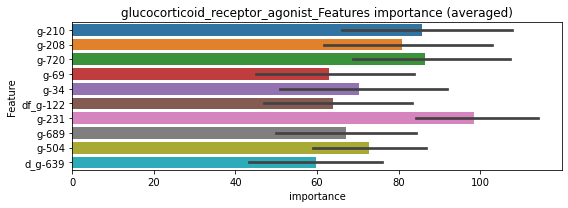

len(train_index) : 3841
len(valid_index) : 3841
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147848	valid_1's binary_logloss: 0.0260868


len(train_index) : 3841
len(valid_index) : 3841


[200]	training's binary_logloss: 0.00230409	valid_1's binary_logloss: 0.0142659
[300]	training's binary_logloss: 0.000753243	valid_1's binary_logloss: 0.0128949
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000786643	valid_1's binary_logloss: 0.0128883


================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151847	valid_1's binary_logloss: 0.0239275


glucocorticoid_receptor_agonist logloss: 0.012207488483234297


[200]	training's binary_logloss: 0.00239601	valid_1's binary_logloss: 0.0123879
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.001245	valid_1's binary_logloss: 0.0115267


glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188719	valid_1's binary_logloss: 0.0242968
[200]	training's binary_logloss: 0.00196617	valid_1's binary_logloss: 0.00439511
[300]	training's binary_logloss: 0.000568002	valid_1's binary_logloss: 0.00236385
[400]	training's binary_logloss: 0.000321543	valid_1's binary_logloss: 0.00189231
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000286902	valid_1's binary_logloss: 0.00182003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192099	valid_1's binary_logloss: 0.0230455
[200]	training's binary_logloss: 0.00201255	valid_1's binary_logloss: 0.00338915
[300]	training's binary_logloss: 0.000583215	valid_1's binary_logloss: 0.00130616
[400]	training's binary_logloss: 0.000325679	valid_1's binary_logloss: 0.000854401
[500]	training's binary_logloss: 0.000279583	valid_1's binary_logloss: 0.000769147
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0010216, Threshold: 0.0016752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055, Num_p_label: 80.0, conf_0:0.00151, conf_1:0.00184
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0016752
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_2: 0.0116752
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.0216752
threshold: 0.0216752, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192952	valid_1's binary_logloss: 0.0237372
[200]	training's binary_logloss: 0.00199849	valid_1's binary_logloss: 0.00405598
[300]	training's binary_logloss: 0.000564745	valid_1's binary_logloss: 0.00211614
[400]	training's binary_logloss: 0.000316886	valid_1's binary_logloss: 0.0017606
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000285347	valid_1's binary_logloss: 0.00170544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193293	valid_1's binary_logloss: 0.0228925
[200]	training's binary_logloss: 0.00199207	valid_1's binary_logloss: 0.00373208
[300]	training's binary_logloss: 0.000563666	valid_1's binary_logloss: 0.00164216
[400]	training's binary_logloss: 0.000319835	valid_1's binary_logloss: 0.00118768
[500]	training's binary_logloss: 0.000273274	valid_1's binary_logloss: 0.00110175
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0239287, Threshold: 0.0216752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00055, Num_p_label: 9.0, conf_0:0.01951, conf_1:0.02384
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_1: 0.0216752
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.0316752
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.0416752
threshold: 0.0416752, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192952	valid_1's binary_logloss: 0.0237372
[200]	training's binary_logloss: 0.00199849	valid_1's binary_logloss: 0.00405598
[300]	training's binary_logloss: 0.000564745	valid_1's binary_logloss: 0.00211614
[400]	training's binary_logloss: 0.000316886	valid_1's binary_logloss: 0.0017606
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000285347	valid_1's binary_logloss: 0.00170544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193293	valid_1's binary_logloss: 0.0228925
[200]	training's binary_logloss: 0.00199207	valid_1's binary_logloss: 0.00373208
[300]	training's binary_logloss: 0.000563666	valid_1's binary_logloss: 0.00164216
[400]	training's binary_logloss: 0.000319835	valid_1's binary_logloss: 0.00118768
[500]	training's binary_logloss: 0.000273274	valid_1's binary_logloss: 0.00110175
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0239287, Threshold: 0.0416752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.03751, conf_1:0.04584
threshold: 0.0416752, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


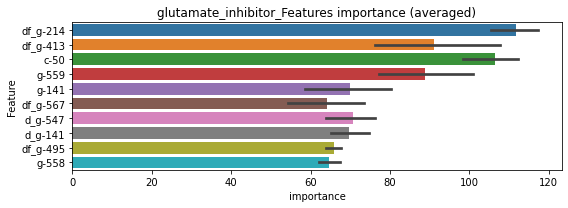

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102822	valid_1's binary_logloss: 0.0174108
[200]	training's binary_logloss: 0.00104353	valid_1's binary_logloss: 0.00806063
[300]	training's binary_logloss: 0.000292217	valid_1's binary_logloss: 0.0072221
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000263408	valid_1's binary_logloss: 0.00718346


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105132	valid_1's binary_logloss: 0.0133051
[200]	training's binary_logloss: 0.0010747	valid_1's binary_logloss: 0.00280755
[300]	training's binary_logloss: 0.000299816	valid_1's binary_logloss: 0.00194896
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000189283	valid_1's binary_logloss: 0.00185827


glutamate_inhibitor logloss: 0.004520867194772183
glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115444	valid_1's binary_logloss: 0.174849
[200]	training's binary_logloss: 0.0485364	valid_1's binary_logloss: 0.123215
[300]	training's binary_logloss: 0.0244315	valid_1's binary_logloss: 0.109395
[400]	training's binary_logloss: 0.0134745	valid_1's binary_logloss: 0.103012
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0131241	valid_1's binary_logloss: 0.102966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111674	valid_1's binary_logloss: 0.158332
[200]	training's binary_logloss: 0.0492617	valid_1's binary_logloss: 0.112826
[300]	training's binary_logloss: 0.0223753	valid_1's binary_logloss: 0.0981289


1 / 3 AUC score:0.985
y_Threshold: 0.0970278, Threshold: 0.2531098, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 222 → Positive_corect_labels: 610/3710
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.22780, conf_1:0.27842
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.2531098


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0148043	valid_1's binary_logloss: 0.094206


Num_p_label: 73.0, Expected: 12.4, Adj_threshold_2: 0.2631098
Num_p_label: 65.0, Expected: 12.4, Adj_threshold_3: 0.2731098
Num_p_label: 61.0, Expected: 12.4, Adj_threshold_4: 0.2831098
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_5: 0.2931098
Num_p_label: 55.0, Expected: 12.4, Adj_threshold_6: 0.3031098
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_7: 0.3131098
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_8: 0.3231098
Num_p_label: 45.0, Expected: 12.4, Adj_threshold_9: 0.3331098
Num_p_label: 41.0, Expected: 12.4, Adj_threshold_10: 0.3431098
threshold: 0.3531098, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 610.0/3710, y_label_rate: 0.1644205
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837824	valid_1's binary_logloss: 0.121059
[200]	training's binary_logloss: 0.0267741	valid_1's binary_logloss: 0.0674852
[300]	training's binary_logloss: 0.0105677	valid_1's binary_logloss: 0.0501517
[400]	training's binary_logloss: 0.00531782	valid_1's binary_logloss: 0.044074
[500]	training's binary_logloss: 0.00326407	valid_1's binary_logloss: 0.0421316
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00332918	valid_1's binary_logloss: 0.0420047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867506	valid_1's binary_logloss: 0.125631
[200]	training's binary_logloss: 0.028974	valid_1's binary_logloss: 0.0727264
[300]	training's binary_logloss: 0.0120806	valid_1's binary_logloss: 0.0540676
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00839339	valid_1's binary_logloss: 0.0488896


2 / 3 AUC score:0.997
y_Threshold: 0.2286649, Threshold: 0.3531098, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 586.0/3662
p_label_rate: 0.0246107 Vs.target_rate: 0.00311, Num_p_label: 98.0, conf_0:0.31780, conf_1:0.38842
Num_p_label: 98.0, Expected: 12.4, Adj_threshold_1: 0.3531098
Num_p_label: 97.0, Expected: 12.4, Adj_threshold_2: 0.3631098
Num_p_label: 92.0, Expected: 12.4, Adj_threshold_3: 0.3731098
Num_p_label: 87.0, Expected: 12.4, Adj_threshold_4: 0.3831098
Num_p_label: 84.0, Expected: 12.4, Adj_threshold_5: 0.3931098
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_6: 0.4031098
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_7: 0.4131098
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_8: 0.4231098
Num_p_label: 73.0, Expected: 12.4, Adj_threshold_9: 0.4331098
Num_p_label: 70.0, Expected: 12.4, Adj_threshold_10: 0.4431098
threshold: 0.4531098, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 586.0/3662, y_label_rate: 0.16002

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760217	valid_1's binary_logloss: 0.127952
[200]	training's binary_logloss: 0.0246137	valid_1's binary_logloss: 0.0786493
[300]	training's binary_logloss: 0.0100975	valid_1's binary_logloss: 0.062647
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00571895	valid_1's binary_logloss: 0.0565028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738416	valid_1's binary_logloss: 0.110305
[200]	training's binary_logloss: 0.0220852	valid_1's binary_logloss: 0.0649543
[300]	training's binary_logloss: 0.00930251	valid_1's binary_logloss: 0.0524182
[400]	training's binary_logloss: 0.00453331	valid_1's binary_logloss: 0.0461183
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00417193	valid_1's binary_logloss: 0.0457696


3 / 3 AUC score:0.997
y_Threshold: 0.1544354, Threshold: 0.4531098, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 555.0/3600
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.40780, conf_1:0.49842
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.4531098
Num_p_label: 77.0, Expected: 12.4, Adj_threshold_2: 0.4631098
Num_p_label: 75.0, Expected: 12.4, Adj_threshold_3: 0.4731098
Num_p_label: 73.0, Expected: 12.4, Adj_threshold_4: 0.4831098
Num_p_label: 72.0, Expected: 12.4, Adj_threshold_5: 0.4931098
Num_p_label: 71.0, Expected: 12.4, Adj_threshold_6: 0.5031098
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_7: 0.5131098
Num_p_label: 65.0, Expected: 12.4, Adj_threshold_8: 0.5231098
Num_p_label: 63.0, Expected: 12.4, Adj_threshold_9: 0.5331098
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_10: 0.5431098
threshold: 0.5531098, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 612.0/7582, y_label_rate: 0.08071

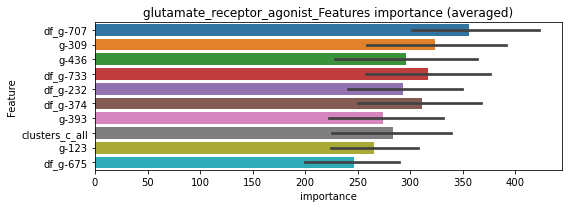

len(train_index) : 3791
len(valid_index) : 3791
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047257	valid_1's binary_logloss: 0.0746088
[200]	training's binary_logloss: 0.0165217	valid_1's binary_logloss: 0.0443046
[300]	training's binary_logloss: 0.00663452	valid_1's binary_logloss: 0.0338423
[400]	training's binary_logloss: 0.00317477	valid_1's binary_logloss: 0.0276341
[500]	training's binary_logloss: 0.00188504	valid_1's binary_logloss: 0.0248676
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00144372	valid_1's binary_logloss: 0.0236311


len(train_index) : 3791
len(valid_index) : 3791
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505481	valid_1's binary_logloss: 0.0714232
[200]	training's binary_logloss: 0.016092	valid_1's binary_logloss: 0.03959
[300]	training's binary_logloss: 0.00687567	valid_1's binary_logloss: 0.0309839
[400]	training's binary_logloss: 0.0034885	valid_1's binary_logloss: 0.0270051
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00213947	valid_1's binary_logloss: 0.0251374


glutamate_receptor_agonist logloss: 0.024384241046710168
glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105


neg labels: 3289 → selected neg labels: 3226


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.246809	valid_1's binary_logloss: 0.358672
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.764
y_Threshold: 0.2043424, Threshold: 0.2673586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 760 → Positive_corect_labels: 330/3111
p_label_rate: 0.0200904 Vs.target_rate: 0.01541, Num_p_label: 80.0, conf_0:0.24062, conf_1:0.29409
threshold: 0.2673586, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 330.0/3111, y_label_rate: 0.1060752
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.252271	valid_1's binary_logloss: 0.344152
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.242373	valid_1's binary_logloss: 0.343225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712586	valid_1's binary_logloss: 0.147363
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.034904	valid_1's binary_logloss: 0.129562
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.968
y_Threshold: 0.1690387, Threshold: 0.2673586, pos_neg_ratio: 0.8000000


[100]	training's binary_logloss: 0.0782973	valid_1's binary_logloss: 0.138847
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0364559	valid_1's binary_logloss: 0.121742


Remove_noisy_labels: 132 → Positive_corect_labels: 264.0/2979
p_label_rate: 0.0328980 Vs.target_rate: 0.01541, Num_p_label: 131.0, conf_0:0.24062, conf_1:0.29409
threshold: 0.2673586, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 264.0/2979, y_label_rate: 0.0886203
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426407	valid_1's binary_logloss: 0.0887785
[200]	training's binary_logloss: 0.0149915	valid_1's binary_logloss: 0.0672715
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0137091	valid_1's binary_logloss: 0.0663082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431086	valid_1's binary_logloss: 0.0869898
[200]	training's binary_logloss: 0.0149247	valid_1's binary_logloss: 0.0665605
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0113335	valid_1's binary_logloss: 0.0651191


3 / 3 AUC score:0.992
y_Threshold: 0.1442220, Threshold: 0.2673586, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 236.0/2923
p_label_rate: 0.0258664 Vs.target_rate: 0.01541, Num_p_label: 103.0, conf_0:0.24062, conf_1:0.29409
threshold: 0.2673586, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 339.0/6905, y_label_rate: 0.0490949


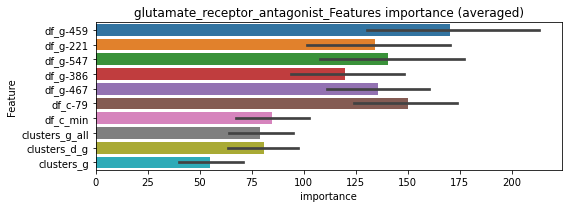

len(train_index) : 3452
len(valid_index) : 3453
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309192	valid_1's binary_logloss: 0.0624607


len(train_index) : 3453
len(valid_index) : 3452
================================= fold 2/2 glutamate_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0110231	valid_1's binary_logloss: 0.0482977
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00878798	valid_1's binary_logloss: 0.0469724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301948	valid_1's binary_logloss: 0.0608072
[200]	training's binary_logloss: 0.0105316	valid_1's binary_logloss: 0.0467702


glutamate_receptor_antagonist logloss: 0.04561274000174738


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00740593	valid_1's binary_logloss: 0.0442527


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233097	valid_1's binary_logloss: 0.0318318
[200]	training's binary_logloss: 0.00279442	valid_1's binary_logloss: 0.00597223
[300]	training's binary_logloss: 0.000780197	valid_1's binary_logloss: 0.00210029
[400]	training's binary_logloss: 0.000415614	valid_1's binary_logloss: 0.00122778
[500]	training's binary_logloss: 0.000336064	valid_1's binary_logloss: 0.00103519
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000335625	valid_1's binary_logloss: 0.00103387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238661	valid_1's binary_logloss: 0.0289007
[200]	training's binary_logloss: 0.00278737	valid_1's binary_logloss: 0.00462203
[300]	training's binary_logloss: 0.000786602	valid_1's binary_logloss: 0.0017202
[400]	training's binary_logloss: 0.00042223	valid_1's binary_logloss: 0.00105021
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0019998, Threshold: 0.0037743, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00340, conf_1:0.00415
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0037743
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.0137743
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0237743
threshold: 0.0237743, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023042	valid_1's binary_logloss: 0.030124
[200]	training's binary_logloss: 0.00261014	valid_1's binary_logloss: 0.00519398
[300]	training's binary_logloss: 0.000746278	valid_1's binary_logloss: 0.00198049
[400]	training's binary_logloss: 0.000404941	valid_1's binary_logloss: 0.00121824
[500]	training's binary_logloss: 0.000331261	valid_1's binary_logloss: 0.00105667
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000328299	valid_1's binary_logloss: 0.00105132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.0268774
[200]	training's binary_logloss: 0.00259049	valid_1's binary_logloss: 0.00366645
[300]	training's binary_logloss: 0.000742281	valid_1's binary_logloss: 0.00123753
[400]	training's binary_logloss: 0.00040322	valid_1's binary_logloss: 0.000716869
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1360834, Threshold: 0.0237743, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.02140, conf_1:0.02615
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.0237743
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.0337743
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.0437743
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.0537743
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.0637743
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.0737743
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.0837743
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_8: 0.0937743
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.1037743
threshold: 0.1037743, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023042	valid_1's binary_logloss: 0.030124
[200]	training's binary_logloss: 0.00261014	valid_1's binary_logloss: 0.00519398
[300]	training's binary_logloss: 0.000746278	valid_1's binary_logloss: 0.00198049
[400]	training's binary_logloss: 0.000404941	valid_1's binary_logloss: 0.00121824
[500]	training's binary_logloss: 0.000331261	valid_1's binary_logloss: 0.00105667
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000328299	valid_1's binary_logloss: 0.00105132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.0268774
[200]	training's binary_logloss: 0.00259049	valid_1's binary_logloss: 0.00366645
[300]	training's binary_logloss: 0.000742281	valid_1's binary_logloss: 0.00123753
[400]	training's binary_logloss: 0.00040322	valid_1's binary_logloss: 0.000716869
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1360834, Threshold: 0.1037743, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.09340, conf_1:0.11415
threshold: 0.1037743, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


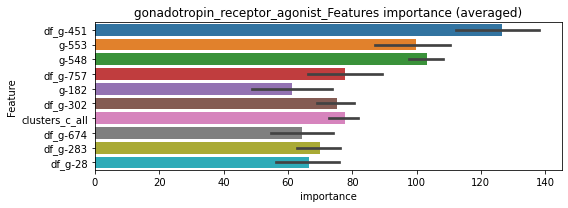

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127149	valid_1's binary_logloss: 0.0190409
[200]	training's binary_logloss: 0.0014699	valid_1's binary_logloss: 0.00564038
[300]	training's binary_logloss: 0.000403681	valid_1's binary_logloss: 0.00431728
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000275544	valid_1's binary_logloss: 0.00414926


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128939	valid_1's binary_logloss: 0.0156527
[200]	training's binary_logloss: 0.00150469	valid_1's binary_logloss: 0.00333589
[300]	training's binary_logloss: 0.000416136	valid_1's binary_logloss: 0.00189904
[400]	training's binary_logloss: 0.000219631	valid_1's binary_logloss: 0.00157891
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000175149	valid_1's binary_logloss: 0.00151074


gonadotropin_receptor_agonist logloss: 0.0028301702157517835
gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355592	valid_1's binary_logloss: 0.0742373
[200]	training's binary_logloss: 0.00590604	valid_1's binary_logloss: 0.032202
[300]	training's binary_logloss: 0.00166771	valid_1's binary_logloss: 0.0225723
[400]	training's binary_logloss: 0.000802486	valid_1's binary_logloss: 0.0185618
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000627123	valid_1's binary_logloss: 0.0177191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351819	valid_1's binary_logloss: 0.0713396
[200]	training's binary_logloss: 0.0054478	valid_1's binary_logloss: 0.0288642
[300]	training's binary_logloss: 0.0016132	valid_1's binary_logloss: 0.0204815
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000846793	valid_1's binary_logloss: 0.0177053


1 / 3 AUC score:1.000
y_Threshold: 0.0042174, Threshold: 0.0065966, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.00594, conf_1:0.00726
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0065966
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_2: 0.0165966
threshold: 0.0165966, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354553	valid_1's binary_logloss: 0.0668256
[200]	training's binary_logloss: 0.00544719	valid_1's binary_logloss: 0.0274159
[300]	training's binary_logloss: 0.00159905	valid_1's binary_logloss: 0.0192363
[400]	training's binary_logloss: 0.000784506	valid_1's binary_logloss: 0.0166181
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000770065	valid_1's binary_logloss: 0.0165547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347076	valid_1's binary_logloss: 0.0702425
[200]	training's binary_logloss: 0.00539912	valid_1's binary_logloss: 0.0275819
[300]	training's binary_logloss: 0.00157624	valid_1's binary_logloss: 0.0180712
[400]	training's binary_logloss: 0.000778434	valid_1's binary_logloss: 0.0152181
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000617429	valid_1's binary_logloss: 0.0144105


2 / 3 AUC score:1.000
y_Threshold: 0.0170506, Threshold: 0.0165966, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0085384 Vs.target_rate: 0.00252, Num_p_label: 34.0, conf_0:0.01494, conf_1:0.01826
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_1: 0.0165966
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_2: 0.0265966
threshold: 0.0265966, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347418	valid_1's binary_logloss: 0.0589782
[200]	training's binary_logloss: 0.00542725	valid_1's binary_logloss: 0.0205953
[300]	training's binary_logloss: 0.00159751	valid_1's binary_logloss: 0.0126618
[400]	training's binary_logloss: 0.000786555	valid_1's binary_logloss: 0.0104964
[500]	training's binary_logloss: 0.000525656	valid_1's binary_logloss: 0.00954469
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000490196	valid_1's binary_logloss: 0.00948846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348244	valid_1's binary_logloss: 0.0625516
[200]	training's binary_logloss: 0.00533946	valid_1's binary_logloss: 0.0222762
[300]	training's binary_logloss: 0.00157422	valid_1's binary_logloss: 0.0129463
[400]	training's binary_logloss: 0.000781952	valid_1's binary_logloss: 0.0101841
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0160945, Threshold: 0.0265966, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0047715 Vs.target_rate: 0.00252, Num_p_label: 19.0, conf_0:0.02394, conf_1:0.02926
threshold: 0.0265966, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 671.0/7778, y_label_rate: 0.0862690


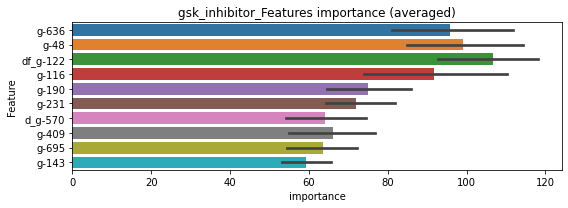

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176671	valid_1's binary_logloss: 0.0441703
[200]	training's binary_logloss: 0.00266859	valid_1's binary_logloss: 0.0262755
[300]	training's binary_logloss: 0.000784635	valid_1's binary_logloss: 0.0230091
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000851507	valid_1's binary_logloss: 0.0229349


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188662	valid_1's binary_logloss: 0.0340579
[200]	training's binary_logloss: 0.00285482	valid_1's binary_logloss: 0.0143304
[300]	training's binary_logloss: 0.000831292	valid_1's binary_logloss: 0.0107605
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000460928	valid_1's binary_logloss: 0.00983474


gsk_inhibitor logloss: 0.016384838499241834
hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974754	valid_1's binary_logloss: 0.159609
[200]	training's binary_logloss: 0.0402916	valid_1's binary_logloss: 0.12664
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0251189	valid_1's binary_logloss: 0.120891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963327	valid_1's binary_logloss: 0.170841
[200]	training's binary_logloss: 0.0392322	valid_1's binary_logloss: 0.135966
[300]	training's binary_logloss: 0.0186564	valid_1's binary_logloss: 0.129315
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0193239	valid_1's binary_logloss: 0.12925


1 / 3 AUC score:0.976
y_Threshold: 0.1102094, Threshold: 0.2785272, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 258 → Positive_corect_labels: 592/3674
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.25067, conf_1:0.30638
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.2785272
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_2: 0.2885272
Num_p_label: 70.0, Expected: 12.0, Adj_threshold_3: 0.2985272
Num_p_label: 69.0, Expected: 12.0, Adj_threshold_4: 0.3085272
Num_p_label: 68.0, Expected: 12.0, Adj_threshold_5: 0.3185272
Num_p_label: 65.0, Expected: 12.0, Adj_threshold_6: 0.3285272
Num_p_label: 63.0, Expected: 12.0, Adj_threshold_7: 0.3385272
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_8: 0.3485272
Num_p_label: 54.0, Expected: 12.0, Adj_threshold_9: 0.3585272
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_10: 0.3685272
threshold: 0.3785272, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 592.0/3674, y_label_rate: 0.161132

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636058	valid_1's binary_logloss: 0.103578
[200]	training's binary_logloss: 0.0209412	valid_1's binary_logloss: 0.0582643
[300]	training's binary_logloss: 0.00872604	valid_1's binary_logloss: 0.0436929
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00515462	valid_1's binary_logloss: 0.0380525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672509	valid_1's binary_logloss: 0.118481
[200]	training's binary_logloss: 0.0196408	valid_1's binary_logloss: 0.0759745
[300]	training's binary_logloss: 0.00760362	valid_1's binary_logloss: 0.0653076
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00444888	valid_1's binary_logloss: 0.0610637


2 / 3 AUC score:0.998
y_Threshold: 0.1655501, Threshold: 0.3785272, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 562.0/3614
p_label_rate: 0.0273732 Vs.target_rate: 0.00302, Num_p_label: 109.0, conf_0:0.34067, conf_1:0.41638
Num_p_label: 109.0, Expected: 12.0, Adj_threshold_1: 0.3785272
Num_p_label: 106.0, Expected: 12.0, Adj_threshold_2: 0.3885272
Num_p_label: 100.0, Expected: 12.0, Adj_threshold_3: 0.3985272
Num_p_label: 98.0, Expected: 12.0, Adj_threshold_4: 0.4085272
Num_p_label: 93.0, Expected: 12.0, Adj_threshold_5: 0.4185272
Num_p_label: 89.0, Expected: 12.0, Adj_threshold_6: 0.4285272
Num_p_label: 88.0, Expected: 12.0, Adj_threshold_7: 0.4385272
Num_p_label: 82.0, Expected: 12.0, Adj_threshold_8: 0.4485272
Num_p_label: 78.0, Expected: 12.0, Adj_threshold_9: 0.4585272
Num_p_label: 74.0, Expected: 12.0, Adj_threshold_10: 0.4685272
threshold: 0.4785272, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 562.0/3614, y_label_rate: 0.1

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582154	valid_1's binary_logloss: 0.0983932
[200]	training's binary_logloss: 0.0163439	valid_1's binary_logloss: 0.0527125
[300]	training's binary_logloss: 0.00615926	valid_1's binary_logloss: 0.0393402
[400]	training's binary_logloss: 0.00326759	valid_1's binary_logloss: 0.0345695
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00326759	valid_1's binary_logloss: 0.0345695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564932	valid_1's binary_logloss: 0.0978699
[200]	training's binary_logloss: 0.0159827	valid_1's binary_logloss: 0.0520861
[300]	training's binary_logloss: 0.00628912	valid_1's binary_logloss: 0.038614
[400]	training's binary_logloss: 0.00333502	valid_1's binary_logloss: 0.033078


3 / 3 AUC score:0.999


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00233975	valid_1's binary_logloss: 0.0314246


y_Threshold: 0.1741089, Threshold: 0.4785272, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 549.0/3588
p_label_rate: 0.0188348 Vs.target_rate: 0.00302, Num_p_label: 75.0, conf_0:0.43067, conf_1:0.52638
Num_p_label: 75.0, Expected: 12.0, Adj_threshold_1: 0.4785272
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_2: 0.4885272
Num_p_label: 71.0, Expected: 12.0, Adj_threshold_3: 0.4985272
Num_p_label: 71.0, Expected: 12.0, Adj_threshold_4: 0.5085272
Num_p_label: 68.0, Expected: 12.0, Adj_threshold_5: 0.5185272
Num_p_label: 63.0, Expected: 12.0, Adj_threshold_6: 0.5285272
Num_p_label: 63.0, Expected: 12.0, Adj_threshold_7: 0.5385272
Num_p_label: 63.0, Expected: 12.0, Adj_threshold_8: 0.5485272
Num_p_label: 62.0, Expected: 12.0, Adj_threshold_9: 0.5585272
Num_p_label: 61.0, Expected: 12.0, Adj_threshold_10: 0.5685272
threshold: 0.5785272, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 610.0/7570, y_label_rate: 0.0805812


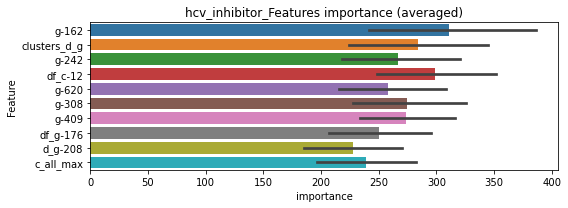

len(train_index) : 3785
len(valid_index) : 3785
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382189	valid_1's binary_logloss: 0.0654264
[200]	training's binary_logloss: 0.0115067	valid_1's binary_logloss: 0.0389044
[300]	training's binary_logloss: 0.00458826	valid_1's binary_logloss: 0.0300949
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00270382	valid_1's binary_logloss: 0.0273703


len(train_index) : 3785
len(valid_index) : 3785
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385298	valid_1's binary_logloss: 0.0733511
[200]	training's binary_logloss: 0.0121164	valid_1's binary_logloss: 0.0477016
[300]	training's binary_logloss: 0.00480137	valid_1's binary_logloss: 0.0397596
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00360214	valid_1's binary_logloss: 0.0371771


hcv_inhibitor logloss: 0.032273735824181624
hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613495	valid_1's binary_logloss: 0.0944376
[200]	training's binary_logloss: 0.0189336	valid_1's binary_logloss: 0.0614768
[300]	training's binary_logloss: 0.00743107	valid_1's binary_logloss: 0.053643
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.006809	valid_1's binary_logloss: 0.0531059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602257	valid_1's binary_logloss: 0.0959496
[200]	training's binary_logloss: 0.0203963	valid_1's binary_logloss: 0.06666


1 / 3 AUC score:0.996
y_Threshold: 0.0564587, Threshold: 0.2599316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 151 → Positive_corect_labels: 644/3774
p_label_rate: 0.0200904 Vs.target_rate: 0.00445, Num_p_label: 80.0, conf_0:0.23394, conf_1:0.28592
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.2599316
Num_p_label: 77.0, Expected: 17.7, Adj_threshold_2: 0.2699316
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_3: 0.2799316
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_4: 0.2899316
Num_p_label: 70.0, Expected: 17.7, Adj_threshold_5: 0.2999316
Num_p_label: 68.0, Expected: 17.7, Adj_threshold_6: 0.3099316


[300]	training's binary_logloss: 0.00774022	valid_1's binary_logloss: 0.0592364
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00780523	valid_1's binary_logloss: 0.0591601


Num_p_label: 64.0, Expected: 17.7, Adj_threshold_7: 0.3199316
Num_p_label: 60.0, Expected: 17.7, Adj_threshold_8: 0.3299316
Num_p_label: 60.0, Expected: 17.7, Adj_threshold_9: 0.3399316
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_10: 0.3499316
threshold: 0.3599316, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 644.0/3774, y_label_rate: 0.1706412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418953	valid_1's binary_logloss: 0.0846336
[200]	training's binary_logloss: 0.00937562	valid_1's binary_logloss: 0.0511749
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00415422	valid_1's binary_logloss: 0.0449404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459172	valid_1's binary_logloss: 0.0661752
[200]	training's binary_logloss: 0.0113343	valid_1's binary_logloss: 0.0305631
[300]	training's binary_logloss: 0.00405088	valid_1's binary_logloss: 0.0206673
[400]	training's binary_logloss: 0.00216098	valid_1's binary_logloss: 0.0170433
[500]	training's binary_logloss: 0.0014742	valid_1's binary_logloss: 0.0150886
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00119615	valid_1's binary_logloss: 0.0142634


2 / 3 AUC score:0.999
y_Threshold: 0.2076008, Threshold: 0.3599316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 628.0/3742
p_label_rate: 0.0341537 Vs.target_rate: 0.00445, Num_p_label: 136.0, conf_0:0.32394, conf_1:0.39592
Num_p_label: 136.0, Expected: 17.7, Adj_threshold_1: 0.3599316
Num_p_label: 136.0, Expected: 17.7, Adj_threshold_2: 0.3699316
Num_p_label: 134.0, Expected: 17.7, Adj_threshold_3: 0.3799316
Num_p_label: 134.0, Expected: 17.7, Adj_threshold_4: 0.3899316
Num_p_label: 131.0, Expected: 17.7, Adj_threshold_5: 0.3999316
Num_p_label: 125.0, Expected: 17.7, Adj_threshold_6: 0.4099316
Num_p_label: 122.0, Expected: 17.7, Adj_threshold_7: 0.4199316
Num_p_label: 120.0, Expected: 17.7, Adj_threshold_8: 0.4299316
Num_p_label: 114.0, Expected: 17.7, Adj_threshold_9: 0.4399316
Num_p_label: 112.0, Expected: 17.7, Adj_threshold_10: 0.4499316
threshold: 0.4599316, positive_p_label: 107.0/3982, p_label_rate: 0.0268709
positive_y_label: 628.0/3742, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386695	valid_1's binary_logloss: 0.0676688
[200]	training's binary_logloss: 0.00852794	valid_1's binary_logloss: 0.0390171
[300]	training's binary_logloss: 0.00305285	valid_1's binary_logloss: 0.0318902
[400]	training's binary_logloss: 0.00163511	valid_1's binary_logloss: 0.0296549
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00172629	valid_1's binary_logloss: 0.0295567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396843	valid_1's binary_logloss: 0.0686818
[200]	training's binary_logloss: 0.00878983	valid_1's binary_logloss: 0.0387328
[300]	training's binary_logloss: 0.00314138	valid_1's binary_logloss: 0.0317001


3 / 3 AUC score:0.999
y_Threshold: 0.1468547, Threshold: 0.4599316, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 610.0/3706
p_label_rate: 0.0278754 Vs.target_rate: 0.00445, Num_p_label: 111.0, conf_0:0.41394, conf_1:0.50592
Num_p_label: 111.0, Expected: 17.7, Adj_threshold_1: 0.4599316
Num_p_label: 107.0, Expected: 17.7, Adj_threshold_2: 0.4699316
Num_p_label: 105.0, Expected: 17.7, Adj_threshold_3: 0.4799316
Num_p_label: 102.0, Expected: 17.7, Adj_threshold_4: 0.4899316
Num_p_label: 102.0, Expected: 17.7, Adj_threshold_5: 0.4999316


[400]	training's binary_logloss: 0.00171659	valid_1's binary_logloss: 0.0300111
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00164142	valid_1's binary_logloss: 0.0298019


Num_p_label: 101.0, Expected: 17.7, Adj_threshold_6: 0.5099316
Num_p_label: 97.0, Expected: 17.7, Adj_threshold_7: 0.5199316
Num_p_label: 94.0, Expected: 17.7, Adj_threshold_8: 0.5299316
Num_p_label: 92.0, Expected: 17.7, Adj_threshold_9: 0.5399316
Num_p_label: 89.0, Expected: 17.7, Adj_threshold_10: 0.5499316
threshold: 0.5599316, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 696.0/7688, y_label_rate: 0.0905307


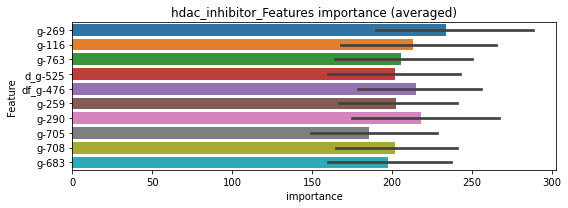

len(train_index) : 3844
len(valid_index) : 3844
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233234	valid_1's binary_logloss: 0.0487679


len(train_index) : 3844
len(valid_index) : 3844


[200]	training's binary_logloss: 0.00544092	valid_1's binary_logloss: 0.0321336
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00333977	valid_1's binary_logloss: 0.0300862


================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242459	valid_1's binary_logloss: 0.0435443
[200]	training's binary_logloss: 0.00586866	valid_1's binary_logloss: 0.0292817
[300]	training's binary_logloss: 0.00227608	valid_1's binary_logloss: 0.0262093
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00228849	valid_1's binary_logloss: 0.026195


hdac_inhibitor logloss: 0.028140585832144852
histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746757	valid_1's binary_logloss: 0.122168
[200]	training's binary_logloss: 0.0282627	valid_1's binary_logloss: 0.0857716
[300]	training's binary_logloss: 0.0123976	valid_1's binary_logloss: 0.0766157
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0110675	valid_1's binary_logloss: 0.0755984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706994	valid_1's binary_logloss: 0.11059
[200]	training's binary_logloss: 0.0261815	valid_1's binary_logloss: 0.0791222
[300]	training's binary_logloss: 0.0116191	valid_1's binary_logloss: 0.0734351
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.011434	valid_1's binary_logloss: 0.0732457


1 / 3 AUC score:0.990
y_Threshold: 0.0643155, Threshold: 0.1268232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 192 → Positive_corect_labels: 625/3742
p_label_rate: 0.0200904 Vs.target_rate: 0.00248, Num_p_label: 80.0, conf_0:0.11414, conf_1:0.13951
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.1268232
Num_p_label: 75.0, Expected: 9.9, Adj_threshold_2: 0.1368232
Num_p_label: 65.0, Expected: 9.9, Adj_threshold_3: 0.1468232
Num_p_label: 61.0, Expected: 9.9, Adj_threshold_4: 0.1568232
Num_p_label: 54.0, Expected: 9.9, Adj_threshold_5: 0.1668232
Num_p_label: 48.0, Expected: 9.9, Adj_threshold_6: 0.1768232
Num_p_label: 46.0, Expected: 9.9, Adj_threshold_7: 0.1868232
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_8: 0.1968232
Num_p_label: 37.0, Expected: 9.9, Adj_threshold_9: 0.2068232
Num_p_label: 31.0, Expected: 9.9, Adj_threshold_10: 0.2168232
threshold: 0.2268232, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 625.0/3742, y_label_rate: 0.1670230
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516078	valid_1's binary_logloss: 0.084642
[200]	training's binary_logloss: 0.0140796	valid_1's binary_logloss: 0.0472731
[300]	training's binary_logloss: 0.00552229	valid_1's binary_logloss: 0.0389222
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00444096	valid_1's binary_logloss: 0.037949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597526	valid_1's binary_logloss: 0.0864898
[200]	training's binary_logloss: 0.0175338	valid_1's binary_logloss: 0.0439426
[300]	training's binary_logloss: 0.00746563	valid_1's binary_logloss: 0.0351885


2 / 3 AUC score:0.999
y_Threshold: 0.1186913, Threshold: 0.2268232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 609.0/3710
p_label_rate: 0.0153189 Vs.target_rate: 0.00248, Num_p_label: 61.0, conf_0:0.20414, conf_1:0.24951
Num_p_label: 61.0, Expected: 9.9, Adj_threshold_1: 0.2268232
Num_p_label: 57.0, Expected: 9.9, Adj_threshold_2: 0.2368232
Num_p_label: 52.0, Expected: 9.9, Adj_threshold_3: 0.2468232
Num_p_label: 51.0, Expected: 9.9, Adj_threshold_4: 0.2568232
Num_p_label: 48.0, Expected: 9.9, Adj_threshold_5: 0.2668232
Num_p_label: 45.0, Expected: 9.9, Adj_threshold_6: 0.2768232
Num_p_label: 43.0, Expected: 9.9, Adj_threshold_7: 0.2868232


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0042376	valid_1's binary_logloss: 0.0320755


Num_p_label: 42.0, Expected: 9.9, Adj_threshold_8: 0.2968232
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_9: 0.3068232
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_10: 0.3168232
threshold: 0.3268232, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 609.0/3710, y_label_rate: 0.1641509
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486094	valid_1's binary_logloss: 0.0784927
[200]	training's binary_logloss: 0.0127395	valid_1's binary_logloss: 0.0432375
[300]	training's binary_logloss: 0.00481034	valid_1's binary_logloss: 0.0354873
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00435205	valid_1's binary_logloss: 0.0351681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477026	valid_1's binary_logloss: 0.0815792
[200]	training's binary_logloss: 0.0112529	valid_1's binary_logloss: 0.0418827
[300]	training's binary_logloss: 0.00446626	valid_1's binary_logloss: 0.0330371


3 / 3 AUC score:0.999
y_Threshold: 0.1042755, Threshold: 0.3268232, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.00246903	valid_1's binary_logloss: 0.0304469
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00216307	valid_1's binary_logloss: 0.0299252


Remove_noisy_labels: 26 → Positive_corect_labels: 596.0/3684
p_label_rate: 0.0105475 Vs.target_rate: 0.00248, Num_p_label: 42.0, conf_0:0.29414, conf_1:0.35951
Num_p_label: 42.0, Expected: 9.9, Adj_threshold_1: 0.3268232
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_2: 0.3368232
Num_p_label: 38.0, Expected: 9.9, Adj_threshold_3: 0.3468232
Num_p_label: 36.0, Expected: 9.9, Adj_threshold_4: 0.3568232
Num_p_label: 32.0, Expected: 9.9, Adj_threshold_5: 0.3668232
Num_p_label: 29.0, Expected: 9.9, Adj_threshold_6: 0.3768232
Num_p_label: 29.0, Expected: 9.9, Adj_threshold_7: 0.3868232
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_8: 0.3968232
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_9: 0.4068232
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_10: 0.4168232
threshold: 0.4268232, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 620.0/7666, y_label_rate: 0.0808766


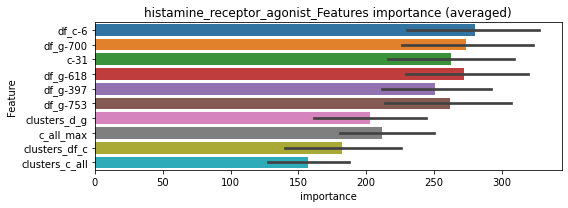

len(train_index) : 3833
len(valid_index) : 3833
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270694	valid_1's binary_logloss: 0.0501063
[200]	training's binary_logloss: 0.00660154	valid_1's binary_logloss: 0.0274002
[300]	training's binary_logloss: 0.00250857	valid_1's binary_logloss: 0.0228367


len(train_index) : 3833
len(valid_index) : 3833
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00161684	valid_1's binary_logloss: 0.0216306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289167	valid_1's binary_logloss: 0.0405302
[200]	training's binary_logloss: 0.00855714	valid_1's binary_logloss: 0.0196974
[300]	training's binary_logloss: 0.00354406	valid_1's binary_logloss: 0.0141483
[400]	training's binary_logloss: 0.00185941	valid_1's binary_logloss: 0.0116003
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00184671	valid_1's binary_logloss: 0.0115933


histamine_receptor_agonist logloss: 0.01661196191344027
histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173576	valid_1's binary_logloss: 0.273767
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.123825	valid_1's binary_logloss: 0.260701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185236	valid_1's binary_logloss: 0.268902
[200]	training's binary_logloss: 0.11629	valid_1's binary_logloss: 0.25425
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.114325	valid_1's binary_logloss: 0.254191


1 / 3 AUC score:0.874
y_Threshold: 0.1841549, Threshold: 0.2843815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 521 → Positive_corect_labels: 454/3377
p_label_rate: 0.0200904 Vs.target_rate: 0.01012, Num_p_label: 80.0, conf_0:0.25594, conf_1:0.31282
threshold: 0.2843815, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 454.0/3377, y_label_rate: 0.1344389
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794114	valid_1's binary_logloss: 0.127471
[200]	training's binary_logloss: 0.030575	valid_1's binary_logloss: 0.0972288
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0163045	valid_1's binary_logloss: 0.0902318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799348	valid_1's binary_logloss: 0.136825
[200]	training's binary_logloss: 0.030031	valid_1's binary_logloss: 0.104661
[300]	training's binary_logloss: 0.0133293	valid_1's binary_logloss: 0.0951745
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0134623	valid_1's binary_logloss: 0.095046


2 / 3 AUC score:0.989
y_Threshold: 0.1380373, Threshold: 0.2843815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 102 → Positive_corect_labels: 403.0/3275
p_label_rate: 0.0253641 Vs.target_rate: 0.01012, Num_p_label: 101.0, conf_0:0.25594, conf_1:0.31282
threshold: 0.2843815, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 403.0/3275, y_label_rate: 0.1230534
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577369	valid_1's binary_logloss: 0.0940882
[200]	training's binary_logloss: 0.0181719	valid_1's binary_logloss: 0.0589736
[300]	training's binary_logloss: 0.00776138	valid_1's binary_logloss: 0.0476768
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00515521	valid_1's binary_logloss: 0.0460648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527303	valid_1's binary_logloss: 0.0937744
[200]	training's binary_logloss: 0.015864	valid_1's binary_logloss: 0.0624896
[300]	training's binary_logloss: 0.00647032	valid_1's binary_logloss: 0.0513448
[400]	training's binary_logloss: 0.00353084	valid_1's binary_logloss: 0.0480887
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00373734	valid_1's binary_logloss: 0.0477084


3 / 3 AUC score:0.998
y_Threshold: 0.1495224, Threshold: 0.2843815, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 383.0/3235
p_label_rate: 0.0256153 Vs.target_rate: 0.01012, Num_p_label: 102.0, conf_0:0.25594, conf_1:0.31282
threshold: 0.2843815, positive_p_label: 102.0/3982, p_label_rate: 0.0256153
positive_y_label: 485.0/7217, y_label_rate: 0.0672024


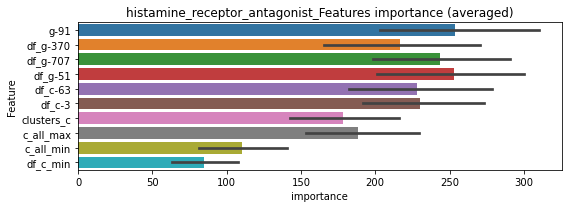

len(train_index) : 3608
len(valid_index) : 3609
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396863	valid_1's binary_logloss: 0.0620792
[200]	training's binary_logloss: 0.014145	valid_1's binary_logloss: 0.0400874
[300]	training's binary_logloss: 0.00616156	valid_1's binary_logloss: 0.0334579
[400]	training's binary_logloss: 0.00329398	valid_1's binary_logloss: 0.0307687
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00310453	valid_1's binary_logloss: 0.0307364


len(train_index) : 3609
len(valid_index) : 3608
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388194	valid_1's binary_logloss: 0.0666358
[200]	training's binary_logloss: 0.0133714	valid_1's binary_logloss: 0.0449388


histamine_receptor_antagonist logloss: 0.03551753696730398


[300]	training's binary_logloss: 0.00576045	valid_1's binary_logloss: 0.04038
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00587099	valid_1's binary_logloss: 0.0403


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242765	valid_1's binary_logloss: 0.0338385
[200]	training's binary_logloss: 0.00296449	valid_1's binary_logloss: 0.0061731
[300]	training's binary_logloss: 0.000846308	valid_1's binary_logloss: 0.0023091
[400]	training's binary_logloss: 0.00044494	valid_1's binary_logloss: 0.00140274
[500]	training's binary_logloss: 0.000340031	valid_1's binary_logloss: 0.00116101
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000332585	valid_1's binary_logloss: 0.00114424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024974	valid_1's binary_logloss: 0.0384828
[200]	training's binary_logloss: 0.00301223	valid_1's binary_logloss: 0.0077152
[300]	training's binary_logloss: 0.000853485	valid_1's binary_logloss: 0.00362865
[400]	training's binary_logloss: 0.000449891	valid_1's binary_logloss: 0.00278872
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0013846, Threshold: 0.0022239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00200, conf_1:0.00245
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0022239
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_2: 0.0122239
threshold: 0.0122239, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245681	valid_1's binary_logloss: 0.0342366
[200]	training's binary_logloss: 0.00293632	valid_1's binary_logloss: 0.00607104
[300]	training's binary_logloss: 0.000836856	valid_1's binary_logloss: 0.00222637
[400]	training's binary_logloss: 0.000445325	valid_1's binary_logloss: 0.00137321
[500]	training's binary_logloss: 0.000340573	valid_1's binary_logloss: 0.00114746
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000336785	valid_1's binary_logloss: 0.00113997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250337	valid_1's binary_logloss: 0.0376261
[200]	training's binary_logloss: 0.00297782	valid_1's binary_logloss: 0.00739746
[300]	training's binary_logloss: 0.000843531	valid_1's binary_logloss: 0.00342521
[400]	training's binary_logloss: 0.000445962	valid_1's binary_logloss: 0.00263063
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0374274, Threshold: 0.0122239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122239, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245681	valid_1's binary_logloss: 0.0342366
[200]	training's binary_logloss: 0.00293632	valid_1's binary_logloss: 0.00607104
[300]	training's binary_logloss: 0.000836856	valid_1's binary_logloss: 0.00222637
[400]	training's binary_logloss: 0.000445325	valid_1's binary_logloss: 0.00137321
[500]	training's binary_logloss: 0.000340573	valid_1's binary_logloss: 0.00114746
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000336785	valid_1's binary_logloss: 0.00113997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250337	valid_1's binary_logloss: 0.0376261
[200]	training's binary_logloss: 0.00297782	valid_1's binary_logloss: 0.00739746
[300]	training's binary_logloss: 0.000843531	valid_1's binary_logloss: 0.00342521
[400]	training's binary_logloss: 0.000445962	valid_1's binary_logloss: 0.00263063
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0374274, Threshold: 0.0122239, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00101, Num_p_label: 6.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122239, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


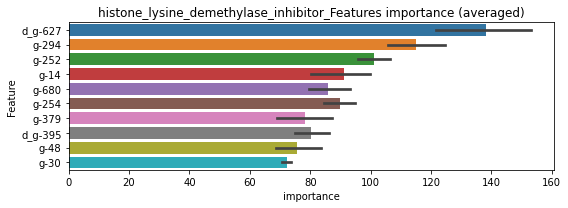

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127303	valid_1's binary_logloss: 0.022355
[200]	training's binary_logloss: 0.00149113	valid_1's binary_logloss: 0.00863549
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000458538	valid_1's binary_logloss: 0.00748293


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131023	valid_1's binary_logloss: 0.0198467
[200]	training's binary_logloss: 0.00154131	valid_1's binary_logloss: 0.00446199
[300]	training's binary_logloss: 0.000436565	valid_1's binary_logloss: 0.00258557
[400]	training's binary_logloss: 0.000227127	valid_1's binary_logloss: 0.00222479
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000231059	valid_1's binary_logloss: 0.00221923


histone_lysine_demethylase_inhibitor logloss: 0.004851080702827674


neg labels: 3289 → selected neg labels: 3283


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297151	valid_1's binary_logloss: 0.0550894
[200]	training's binary_logloss: 0.00416987	valid_1's binary_logloss: 0.0186405
[300]	training's binary_logloss: 0.00119716	valid_1's binary_logloss: 0.0127277
[400]	training's binary_logloss: 0.000603659	valid_1's binary_logloss: 0.0109183
[500]	training's binary_logloss: 0.00042761	valid_1's binary_logloss: 0.0103533
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000409321	valid_1's binary_logloss: 0.0102668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305939	valid_1's binary_logloss: 0.0500914
[200]	training's binary_logloss: 0.00437876	valid_1's binary_logloss: 0.0124404
[300]	training's binary_logloss: 0.00124512	valid_1's binary_logloss: 0.00575486
[400]	training's binary_logloss: 0.00063309	valid_1's binary_logloss: 0.00385127
[500]	training's binary_logloss: 0.000438

1 / 3 AUC score:1.000
y_Threshold: 0.0025430, Threshold: 0.0042940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134, Num_p_label: 80.0, conf_0:0.00386, conf_1:0.00472
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0042940
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_2: 0.0142940
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_3: 0.0242940
threshold: 0.0242940, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029963	valid_1's binary_logloss: 0.0574996
[200]	training's binary_logloss: 0.00413626	valid_1's binary_logloss: 0.0194942
[300]	training's binary_logloss: 0.00118054	valid_1's binary_logloss: 0.0125945
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000719032	valid_1's binary_logloss: 0.0115066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311501	valid_1's binary_logloss: 0.0512921
[200]	training's binary_logloss: 0.00437823	valid_1's binary_logloss: 0.0125013
[300]	training's binary_logloss: 0.00125959	valid_1's binary_logloss: 0.00590624
[400]	training's binary_logloss: 0.000636341	valid_1's binary_logloss: 0.00409891
[500]	training's binary_logloss: 0.00044192	valid_1's binary_logloss: 0.00336485
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000401703	valid_1's binary_logloss: 0.0031398


2 / 3 AUC score:1.000
y_Threshold: 0.0211037, Threshold: 0.0242940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00134, Num_p_label: 33.0, conf_0:0.02186, conf_1:0.02672
Num_p_label: 33.0, Expected: 5.4, Adj_threshold_1: 0.0242940
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_2: 0.0342940
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_3: 0.0442940
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_4: 0.0542940
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_5: 0.0642940
threshold: 0.0642940, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03011	valid_1's binary_logloss: 0.0467188
[200]	training's binary_logloss: 0.00424237	valid_1's binary_logloss: 0.0109681
[300]	training's binary_logloss: 0.00121115	valid_1's binary_logloss: 0.00459225
[400]	training's binary_logloss: 0.000616875	valid_1's binary_logloss: 0.00295774
[500]	training's binary_logloss: 0.000432012	valid_1's binary_logloss: 0.00240473
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000397126	valid_1's binary_logloss: 0.0022884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303557	valid_1's binary_logloss: 0.0477577
[200]	training's binary_logloss: 0.00420725	valid_1's binary_logloss: 0.0117628
[300]	training's binary_logloss: 0.00121748	valid_1's binary_logloss: 0.00549664
[400]	training's binary_logloss: 0.000616862	valid_1's binary_logloss: 0.00356833
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1128864, Threshold: 0.0642940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00134, Num_p_label: 10.0, conf_0:0.05786, conf_1:0.07072
threshold: 0.0642940, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


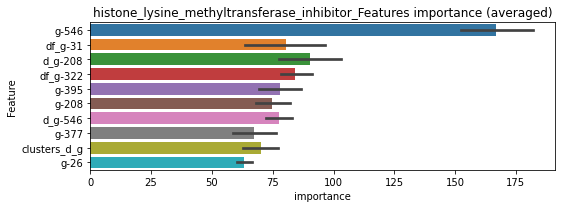

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162343	valid_1's binary_logloss: 0.030828
[200]	training's binary_logloss: 0.002231	valid_1's binary_logloss: 0.0131446
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000722925	valid_1's binary_logloss: 0.0109392


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164969	valid_1's binary_logloss: 0.0274162
[200]	training's binary_logloss: 0.00236368	valid_1's binary_logloss: 0.00831293
[300]	training's binary_logloss: 0.000685214	valid_1's binary_logloss: 0.0052952
[400]	training's binary_logloss: 0.000336082	valid_1's binary_logloss: 0.0047575
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000265913	valid_1's binary_logloss: 0.00461555


histone_lysine_methyltransferase_inhibitor logloss: 0.007777765581787678
hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859936	valid_1's binary_logloss: 0.143884
[200]	training's binary_logloss: 0.0362219	valid_1's binary_logloss: 0.106365
[300]	training's binary_logloss: 0.0172394	valid_1's binary_logloss: 0.097338
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0142858	valid_1's binary_logloss: 0.0968763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949677	valid_1's binary_logloss: 0.133212
[200]	training's binary_logloss: 0.0443736	valid_1's binary_logloss: 0.099936
[300]	training's binary_logloss: 0.0230855	valid_1's binary_logloss: 0.0910193
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0147339	valid_1's binary_logloss: 0.0871669


1 / 3 AUC score:0.988
y_Threshold: 0.0761555, Threshold: 0.1476626, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 218 → Positive_corect_labels: 612/3715
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.13290, conf_1:0.16243
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.1476626
Num_p_label: 69.0, Expected: 12.0, Adj_threshold_2: 0.1576626
Num_p_label: 62.0, Expected: 12.0, Adj_threshold_3: 0.1676626
Num_p_label: 57.0, Expected: 12.0, Adj_threshold_4: 0.1776626
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_5: 0.1876626
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_6: 0.1976626
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_7: 0.2076626
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_8: 0.2176626
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_9: 0.2276626
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_10: 0.2376626
threshold: 0.2476626, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 612.0/3715, y_label_rate: 0.164737

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702135	valid_1's binary_logloss: 0.118505
[200]	training's binary_logloss: 0.0230495	valid_1's binary_logloss: 0.0757888
[300]	training's binary_logloss: 0.00994751	valid_1's binary_logloss: 0.0651856
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00606811	valid_1's binary_logloss: 0.0597825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689204	valid_1's binary_logloss: 0.0998248
[200]	training's binary_logloss: 0.0235207	valid_1's binary_logloss: 0.0595055
[300]	training's binary_logloss: 0.00999052	valid_1's binary_logloss: 0.0477413
[400]	training's binary_logloss: 0.00519564	valid_1's binary_logloss: 0.0428196


2 / 3 AUC score:0.997
y_Threshold: 0.1580444, Threshold: 0.2476626, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 585.0/3661
p_label_rate: 0.0148167 Vs.target_rate: 0.00302, Num_p_label: 59.0, conf_0:0.22290, conf_1:0.27243


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00406638	valid_1's binary_logloss: 0.0417005


Num_p_label: 59.0, Expected: 12.0, Adj_threshold_1: 0.2476626
Num_p_label: 56.0, Expected: 12.0, Adj_threshold_2: 0.2576626
Num_p_label: 56.0, Expected: 12.0, Adj_threshold_3: 0.2676626
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_4: 0.2776626
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_5: 0.2876626
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_6: 0.2976626
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_7: 0.3076626
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_8: 0.3176626
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_9: 0.3276626
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_10: 0.3376626
threshold: 0.3476626, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 585.0/3661, y_label_rate: 0.1597924
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568762	valid_1's binary_logloss: 0.104479
[200]	training's binary_logloss: 0.0177686	valid_1's binary_logloss: 0.0617464
[300]	training's binary_logloss: 0.00701202	valid_1's binary_logloss: 0.0470575
[400]	training's binary_logloss: 0.0036669	valid_1's binary_logloss: 0.0420561
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.0025132	valid_1's binary_logloss: 0.0399039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061386	valid_1's binary_logloss: 0.0879532
[200]	training's binary_logloss: 0.0184455	valid_1's binary_logloss: 0.0461061
[300]	training's binary_logloss: 0.00745002	valid_1's binary_logloss: 0.0354638
[400]	training's binary_logloss: 0.003938	valid_1's binary_logloss: 0.0330491
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00322725	valid_1's binary_logloss: 0.0320145


3 / 3 AUC score:0.999
y_Threshold: 0.1574730, Threshold: 0.3476626, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 565.0/3621
p_label_rate: 0.0110497 Vs.target_rate: 0.00302, Num_p_label: 44.0, conf_0:0.31290, conf_1:0.38243
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_1: 0.3476626
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_2: 0.3576626
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_3: 0.3676626
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_4: 0.3776626
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_5: 0.3876626
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_6: 0.3976626
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_7: 0.4076626
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_8: 0.4176626
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_9: 0.4276626
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_10: 0.4376626
threshold: 0.4476626, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 592.0/7603, y_label_rate: 0.07786

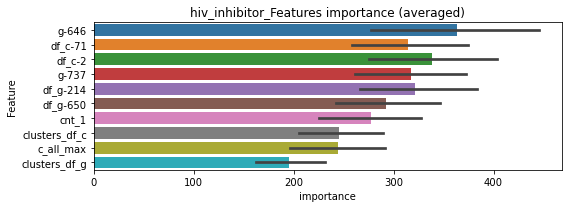

len(train_index) : 3801
len(valid_index) : 3802
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326828	valid_1's binary_logloss: 0.0546233
[200]	training's binary_logloss: 0.0105215	valid_1's binary_logloss: 0.0354171
[300]	training's binary_logloss: 0.00422943	valid_1's binary_logloss: 0.0305284


len(train_index) : 3802
len(valid_index) : 3801
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00245922	valid_1's binary_logloss: 0.029157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348417	valid_1's binary_logloss: 0.0543017
[200]	training's binary_logloss: 0.0115895	valid_1's binary_logloss: 0.0333957
[300]	training's binary_logloss: 0.00484987	valid_1's binary_logloss: 0.026667
[400]	training's binary_logloss: 0.00237258	valid_1's binary_logloss: 0.0240767
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00199526	valid_1's binary_logloss: 0.0236033


hiv_inhibitor logloss: 0.02638048518786168
hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607246	valid_1's binary_logloss: 0.0945534
[200]	training's binary_logloss: 0.0206932	valid_1's binary_logloss: 0.0786108
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0163388	valid_1's binary_logloss: 0.077557
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.990


[100]	training's binary_logloss: 0.0580066	valid_1's binary_logloss: 0.107463
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0224406	valid_1's binary_logloss: 0.094033


y_Threshold: 0.0963181, Threshold: 0.5955445, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 630/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.01188, Num_p_label: 80.0, conf_0:0.53599, conf_1:0.65510
threshold: 0.5955445, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 630.0/3754, y_label_rate: 0.1678210
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346005	valid_1's binary_logloss: 0.05142
[200]	training's binary_logloss: 0.00732544	valid_1's binary_logloss: 0.0305184
[300]	training's binary_logloss: 0.0025582	valid_1's binary_logloss: 0.0284393
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00217126	valid_1's binary_logloss: 0.0279143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331529	valid_1's binary_logloss: 0.0496809
[200]	training's binary_logloss: 0.00661878	valid_1's binary_logloss: 0.0262862
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00289199	valid_1's binary_logloss: 0.0221826


2 / 3 AUC score:0.997
y_Threshold: 0.2559332, Threshold: 0.5955445, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 616.0/3726
p_label_rate: 0.0409342 Vs.target_rate: 0.01188, Num_p_label: 163.0, conf_0:0.53599, conf_1:0.65510
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_1: 0.5955445
Num_p_label: 161.0, Expected: 47.3, Adj_threshold_2: 0.6055445
Num_p_label: 159.0, Expected: 47.3, Adj_threshold_3: 0.6155445
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_4: 0.6255445
Num_p_label: 153.0, Expected: 47.3, Adj_threshold_5: 0.6355445
Num_p_label: 152.0, Expected: 47.3, Adj_threshold_6: 0.6455445
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_7: 0.6555445
Num_p_label: 145.0, Expected: 47.3, Adj_threshold_8: 0.6655445
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_9: 0.6755445
Num_p_label: 142.0, Expected: 47.3, Adj_threshold_10: 0.6855445
threshold: 0.6955445, positive_p_label: 138.0/3982, p_label_rate: 0.0346560
positive_y_label: 616.0/3726, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285036	valid_1's binary_logloss: 0.0377414
[200]	training's binary_logloss: 0.00526183	valid_1's binary_logloss: 0.0144154
[300]	training's binary_logloss: 0.00173654	valid_1's binary_logloss: 0.00997929
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00113966	valid_1's binary_logloss: 0.00886289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279488	valid_1's binary_logloss: 0.0362655
[200]	training's binary_logloss: 0.00482405	valid_1's binary_logloss: 0.0156903
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00255183	valid_1's binary_logloss: 0.0138862


3 / 3 AUC score:1.000
y_Threshold: 0.2461286, Threshold: 0.6955445, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 611.0/3716
p_label_rate: 0.0421899 Vs.target_rate: 0.01188, Num_p_label: 168.0, conf_0:0.62599, conf_1:0.76510
Num_p_label: 168.0, Expected: 47.3, Adj_threshold_1: 0.6955445
Num_p_label: 166.0, Expected: 47.3, Adj_threshold_2: 0.7055445
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_3: 0.7155445
Num_p_label: 162.0, Expected: 47.3, Adj_threshold_4: 0.7255445
Num_p_label: 158.0, Expected: 47.3, Adj_threshold_5: 0.7355445
Num_p_label: 157.0, Expected: 47.3, Adj_threshold_6: 0.7455445
Num_p_label: 156.0, Expected: 47.3, Adj_threshold_7: 0.7555445
Num_p_label: 153.0, Expected: 47.3, Adj_threshold_8: 0.7655445
Num_p_label: 151.0, Expected: 47.3, Adj_threshold_9: 0.7755445
Num_p_label: 148.0, Expected: 47.3, Adj_threshold_10: 0.7855445
threshold: 0.7955445, positive_p_label: 146.0/3982, p_label_rate: 0.0366650
positive_y_label: 757.0/7698, y_label_r

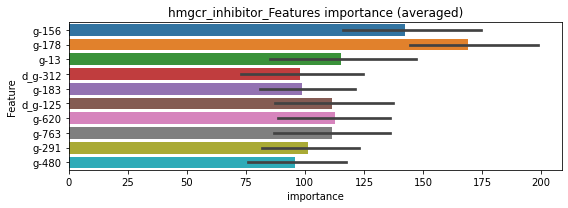

len(train_index) : 3849
len(valid_index) : 3849
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186494	valid_1's binary_logloss: 0.0287332
[200]	training's binary_logloss: 0.00389515	valid_1's binary_logloss: 0.015575
[300]	training's binary_logloss: 0.00142882	valid_1's binary_logloss: 0.0133093
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00151662	valid_1's binary_logloss: 0.013297


len(train_index) : 3849
len(valid_index) : 3849
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197439	valid_1's binary_logloss: 0.0314821
[200]	training's binary_logloss: 0.004274	valid_1's binary_logloss: 0.0176643
[300]	training's binary_logloss: 0.0015925	valid_1's binary_logloss: 0.0148996
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00144127	valid_1's binary_logloss: 0.0147031


hmgcr_inhibitor logloss: 0.01400008800784603
hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270348	valid_1's binary_logloss: 0.0490718
[200]	training's binary_logloss: 0.0035887	valid_1's binary_logloss: 0.0202842
[300]	training's binary_logloss: 0.00104344	valid_1's binary_logloss: 0.0157048
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000972976	valid_1's binary_logloss: 0.0154881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276513	valid_1's binary_logloss: 0.0570368
[200]	training's binary_logloss: 0.00358927	valid_1's binary_logloss: 0.0291776
[300]	training's binary_logloss: 0.00102392	valid_1's binary_logloss: 0.0239525
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000962467	valid_1's binary_logloss: 0.0238818


1 / 3 AUC score:1.000
y_Threshold: 0.0038354, Threshold: 0.0156266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 131 → Positive_corect_labels: 655/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00391, Num_p_label: 80.0, conf_0:0.01406, conf_1:0.01719
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0156266
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_2: 0.0256266
Num_p_label: 57.0, Expected: 15.6, Adj_threshold_3: 0.0356266
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_4: 0.0456266
Num_p_label: 47.0, Expected: 15.6, Adj_threshold_5: 0.0556266
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_6: 0.0656266
Num_p_label: 37.0, Expected: 15.6, Adj_threshold_7: 0.0756266
Num_p_label: 31.0, Expected: 15.6, Adj_threshold_8: 0.0856266
threshold: 0.0856266, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 655.0/3799, y_label_rate: 0.1724138
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271085	valid_1's binary_logloss: 0.0469241
[200]	training's binary_logloss: 0.00341247	valid_1's binary_logloss: 0.0186698
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00245498	valid_1's binary_logloss: 0.0173117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027608	valid_1's binary_logloss: 0.0544935
[200]	training's binary_logloss: 0.00350171	valid_1's binary_logloss: 0.0283825
[300]	training's binary_logloss: 0.000992967	valid_1's binary_logloss: 0.0235322


2 / 3 AUC score:1.000


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000790604	valid_1's binary_logloss: 0.023067


y_Threshold: 0.0307929, Threshold: 0.0856266, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3789
p_label_rate: 0.0183325 Vs.target_rate: 0.00391, Num_p_label: 73.0, conf_0:0.07706, conf_1:0.09419
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_1: 0.0856266
Num_p_label: 71.0, Expected: 15.6, Adj_threshold_2: 0.0956266
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_3: 0.1056266
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_4: 0.1156266
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_5: 0.1256266
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_6: 0.1356266
Num_p_label: 63.0, Expected: 15.6, Adj_threshold_7: 0.1456266
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_8: 0.1556266
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_9: 0.1656266
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_10: 0.1756266
threshold: 0.1856266, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 650.0/3789, y_label_rate: 0.1715492
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273151	valid_1's binary_logloss: 0.0384697
[200]	training's binary_logloss: 0.00357105	valid_1's binary_logloss: 0.0105087
[300]	training's binary_logloss: 0.00101809	valid_1's binary_logloss: 0.00636878
[400]	training's binary_logloss: 0.000527819	valid_1's binary_logloss: 0.00525786
[500]	training's binary_logloss: 0.000386973	valid_1's binary_logloss: 0.00469789
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000387713	valid_1's binary_logloss: 0.00469565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264674	valid_1's binary_logloss: 0.0666156
[200]	training's binary_logloss: 0.0031237	valid_1's binary_logloss: 0.0441588


3 / 3 AUC score:0.999
y_Threshold: 0.0276819, Threshold: 0.1856266, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00208285	valid_1's binary_logloss: 0.0423026


Remove_noisy_labels: 14 → Positive_corect_labels: 643.0/3775
p_label_rate: 0.0125565 Vs.target_rate: 0.00391, Num_p_label: 50.0, conf_0:0.16706, conf_1:0.20419
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_1: 0.1856266
Num_p_label: 49.0, Expected: 15.6, Adj_threshold_2: 0.1956266
Num_p_label: 46.0, Expected: 15.6, Adj_threshold_3: 0.2056266
Num_p_label: 46.0, Expected: 15.6, Adj_threshold_4: 0.2156266
Num_p_label: 44.0, Expected: 15.6, Adj_threshold_5: 0.2256266
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_6: 0.2356266
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_7: 0.2456266
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_8: 0.2556266
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_9: 0.2656266
Num_p_label: 39.0, Expected: 15.6, Adj_threshold_10: 0.2756266
threshold: 0.2856266, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 682.0/7757, y_label_rate: 0.0879206


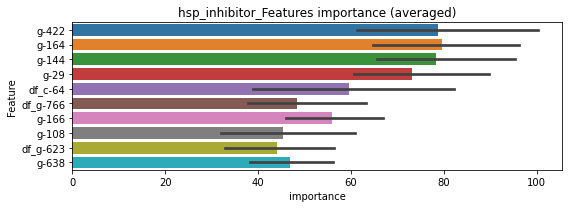

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147237	valid_1's binary_logloss: 0.0378376
[200]	training's binary_logloss: 0.00188722	valid_1's binary_logloss: 0.0259291
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00135015	valid_1's binary_logloss: 0.0250496


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149037	valid_1's binary_logloss: 0.0423279


hsp_inhibitor logloss: 0.030222744524197705


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00337372	valid_1's binary_logloss: 0.0353973


igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342207	valid_1's binary_logloss: 0.05068
[200]	training's binary_logloss: 0.00513591	valid_1's binary_logloss: 0.0127414
[300]	training's binary_logloss: 0.00145928	valid_1's binary_logloss: 0.00622608
[400]	training's binary_logloss: 0.000723483	valid_1's binary_logloss: 0.00422063
[500]	training's binary_logloss: 0.000488811	valid_1's binary_logloss: 0.00351109
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000441244	valid_1's binary_logloss: 0.00336437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330952	valid_1's binary_logloss: 0.0562854
[200]	training's binary_logloss: 0.00493774	valid_1's binary_logloss: 0.0168421
[300]	training's binary_logloss: 0.00141745	valid_1's binary_logloss: 0.00919841
[400]	training's binary_logloss: 0.000701524	valid_1's binary_logloss: 0.00702979
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0051177, Threshold: 0.0081924, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00737, conf_1:0.00901
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0081924
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_2: 0.0181924
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_3: 0.0281924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_4: 0.0381924
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_5: 0.0481924
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.0581924
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_7: 0.0681924
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_8: 0.0781924
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_9: 0.0881924
threshold: 0.0881924, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031632	valid_1's binary_logloss: 0.0464908
[200]	training's binary_logloss: 0.00445863	valid_1's binary_logloss: 0.0106204
[300]	training's binary_logloss: 0.0012892	valid_1's binary_logloss: 0.00489071
[400]	training's binary_logloss: 0.000655914	valid_1's binary_logloss: 0.00334657
[500]	training's binary_logloss: 0.000453179	valid_1's binary_logloss: 0.00281537
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000443234	valid_1's binary_logloss: 0.00279533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314107	valid_1's binary_logloss: 0.0510425
[200]	training's binary_logloss: 0.00440738	valid_1's binary_logloss: 0.0133358
[300]	training's binary_logloss: 0.00129403	valid_1's binary_logloss: 0.00709787
[400]	training's binary_logloss: 0.000647192	valid_1's binary_logloss: 0.00532728
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0598099, Threshold: 0.0881924, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0105475 Vs.target_rate: 0.00155, Num_p_label: 42.0, conf_0:0.07937, conf_1:0.09701
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_1: 0.0881924
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_2: 0.0981924
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_3: 0.1081924
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_4: 0.1181924
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_5: 0.1281924
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_6: 0.1381924
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_7: 0.1481924
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_8: 0.1581924
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_9: 0.1681924
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_10: 0.1781924
threshold: 0.1881924, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031017	valid_1's binary_logloss: 0.0494442
[200]	training's binary_logloss: 0.00434086	valid_1's binary_logloss: 0.0183637
[300]	training's binary_logloss: 0.00125293	valid_1's binary_logloss: 0.013296
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000718012	valid_1's binary_logloss: 0.0120647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317085	valid_1's binary_logloss: 0.0465187
[200]	training's binary_logloss: 0.00440584	valid_1's binary_logloss: 0.00997136
[300]	training's binary_logloss: 0.00127215	valid_1's binary_logloss: 0.00415062
[400]	training's binary_logloss: 0.00064865	valid_1's binary_logloss: 0.00270476
[500]	training's binary_logloss: 0.000457287	valid_1's binary_logloss: 0.00217056
[600]	training's binary_logloss: 0.000417748	valid_1's binary_logloss: 0.00207447
Early stopping, best iteration is:
[608

3 / 3 AUC score:1.000
y_Threshold: 0.0621554, Threshold: 0.1881924, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0075339 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.16937, conf_1:0.20701
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.1881924
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_2: 0.1981924
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_3: 0.2081924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_4: 0.2181924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_5: 0.2281924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_6: 0.2381924
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_7: 0.2481924
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_8: 0.2581924
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_9: 0.2681924
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_10: 0.2781924
threshold: 0.2881924, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 674.0/7782, y_label_rate: 0.0866101


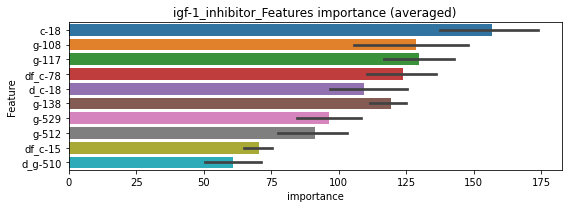

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177859	valid_1's binary_logloss: 0.0322681
[200]	training's binary_logloss: 0.00249414	valid_1's binary_logloss: 0.0127432
[300]	training's binary_logloss: 0.000722435	valid_1's binary_logloss: 0.00979869
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000501091	valid_1's binary_logloss: 0.00946966


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183578	valid_1's binary_logloss: 0.0321724
[200]	training's binary_logloss: 0.00273534	valid_1's binary_logloss: 0.0118284
[300]	training's binary_logloss: 0.000764984	valid_1's binary_logloss: 0.0086758
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000420892	valid_1's binary_logloss: 0.00796943


igf-1_inhibitor logloss: 0.00871954760925046
ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272091	valid_1's binary_logloss: 0.0485799
[200]	training's binary_logloss: 0.00356557	valid_1's binary_logloss: 0.0180883
[300]	training's binary_logloss: 0.00100876	valid_1's binary_logloss: 0.0121838
[400]	training's binary_logloss: 0.00052416	valid_1's binary_logloss: 0.0105122
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000423235	valid_1's binary_logloss: 0.00990893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283199	valid_1's binary_logloss: 0.0387683
[200]	training's binary_logloss: 0.0036816	valid_1's binary_logloss: 0.00814269
[300]	training's binary_logloss: 0.00106043	valid_1's binary_logloss: 0.00389347
[400]	training's binary_logloss: 0.000549832	valid_1's binary_logloss: 0.00293785
[500]	training's binary_logloss: 0.000415798	valid_1's binary_logloss: 0.00266222
Early stopping, best iteration is:
[50

1 / 3 AUC score:1.000
y_Threshold: 0.0026236, Threshold: 0.2541718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.22875, conf_1:0.27959
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.2541718
Num_p_label: 79.0, Expected: 5.0, Adj_threshold_2: 0.2641718
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_3: 0.2741718
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_4: 0.2841718
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_5: 0.2941718
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_6: 0.3041718
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_7: 0.3141718
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_8: 0.3241718
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_9: 0.3341718
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_10: 0.3441718
threshold: 0.3541718, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261288	valid_1's binary_logloss: 0.0442153
[200]	training's binary_logloss: 0.00321361	valid_1's binary_logloss: 0.0153707
[300]	training's binary_logloss: 0.000919376	valid_1's binary_logloss: 0.0109574
[400]	training's binary_logloss: 0.000492402	valid_1's binary_logloss: 0.00924182
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000396447	valid_1's binary_logloss: 0.00880322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269019	valid_1's binary_logloss: 0.0365752
[200]	training's binary_logloss: 0.00338628	valid_1's binary_logloss: 0.00684328
[300]	training's binary_logloss: 0.000977773	valid_1's binary_logloss: 0.00285398
[400]	training's binary_logloss: 0.000515624	valid_1's binary_logloss: 0.00187281
[500]	training's binary_logloss: 0.000388724	valid_1's binary_logloss: 0.0015428
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0841955, Threshold: 0.3541718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0258664 Vs.target_rate: 0.00126, Num_p_label: 103.0, conf_0:0.31875, conf_1:0.38959
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_1: 0.3541718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_2: 0.3641718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_3: 0.3741718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_4: 0.3841718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_5: 0.3941718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_6: 0.4041718
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_7: 0.4141718
Num_p_label: 101.0, Expected: 5.0, Adj_threshold_8: 0.4241718
Num_p_label: 101.0, Expected: 5.0, Adj_threshold_9: 0.4341718
Num_p_label: 101.0, Expected: 5.0, Adj_threshold_10: 0.4441718
threshold: 0.4541718, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 654.0/3804, y_label_rate: 0.1719

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262481	valid_1's binary_logloss: 0.0389169
[200]	training's binary_logloss: 0.00331696	valid_1's binary_logloss: 0.00885979
[300]	training's binary_logloss: 0.000946993	valid_1's binary_logloss: 0.00428747
[400]	training's binary_logloss: 0.000499405	valid_1's binary_logloss: 0.00307304
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000396387	valid_1's binary_logloss: 0.0027602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264672	valid_1's binary_logloss: 0.0344844
[200]	training's binary_logloss: 0.00332128	valid_1's binary_logloss: 0.00584184
[300]	training's binary_logloss: 0.000945186	valid_1's binary_logloss: 0.00208931
[400]	training's binary_logloss: 0.000501152	valid_1's binary_logloss: 0.00127973
[500]	training's binary_logloss: 0.000383985	valid_1's binary_logloss: 0.0010418
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.2327771, Threshold: 0.4541718, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0266198 Vs.target_rate: 0.00126, Num_p_label: 106.0, conf_0:0.40875, conf_1:0.49959
Num_p_label: 106.0, Expected: 5.0, Adj_threshold_1: 0.4541718
Num_p_label: 106.0, Expected: 5.0, Adj_threshold_2: 0.4641718
Num_p_label: 105.0, Expected: 5.0, Adj_threshold_3: 0.4741718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_4: 0.4841718
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_5: 0.4941718
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_6: 0.5041718
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_7: 0.5141718
Num_p_label: 100.0, Expected: 5.0, Adj_threshold_8: 0.5241718
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_9: 0.5341718
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_10: 0.5441718
threshold: 0.5541718, positive_p_label: 99.0/3982, p_label_rate: 0.0248619
positive_y_label: 753.0/7786, y_label_rate: 0.0967120

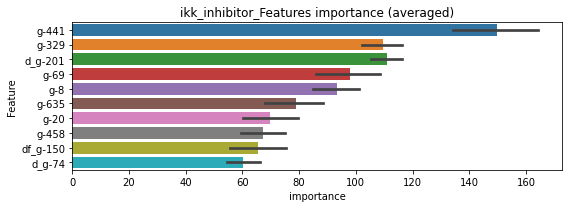

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161393	valid_1's binary_logloss: 0.0259208
[200]	training's binary_logloss: 0.00209689	valid_1's binary_logloss: 0.0081926
[300]	training's binary_logloss: 0.000575511	valid_1's binary_logloss: 0.00535242
[400]	training's binary_logloss: 0.000289679	valid_1's binary_logloss: 0.00442382
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00022471	valid_1's binary_logloss: 0.00422929


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160223	valid_1's binary_logloss: 0.0259971
[200]	training's binary_logloss: 0.0020923	valid_1's binary_logloss: 0.00871484
[300]	training's binary_logloss: 0.000571312	valid_1's binary_logloss: 0.00553647
[400]	training's binary_logloss: 0.000289898	valid_1's binary_logloss: 0.00452429
[500]	training's binary_logloss: 0.000214094	valid_1's binary_logloss: 0.00427056
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000214094	valid_1's binary_logloss: 0.00427056


ikk_inhibitor logloss: 0.004252493458424931
imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035913	valid_1's binary_logloss: 0.0531559
[200]	training's binary_logloss: 0.00534214	valid_1's binary_logloss: 0.0132127
[300]	training's binary_logloss: 0.00149114	valid_1's binary_logloss: 0.0057053
[400]	training's binary_logloss: 0.000728052	valid_1's binary_logloss: 0.00369598
[500]	training's binary_logloss: 0.000482654	valid_1's binary_logloss: 0.00295823
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00043033	valid_1's binary_logloss: 0.0027982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342985	valid_1's binary_logloss: 0.0551282
[200]	training's binary_logloss: 0.00523752	valid_1's binary_logloss: 0.0167004
[300]	training's binary_logloss: 0.00146949	valid_1's binary_logloss: 0.00999321
[400]	training's binary_logloss: 0.000713094	valid_1's binary_logloss: 0.00830444
Early stopping, best iteration is:
[417

1 / 3 AUC score:1.000
y_Threshold: 0.0034108, Threshold: 0.0063763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00574, conf_1:0.00701
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0063763
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_2: 0.0163763
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_3: 0.0263763
threshold: 0.0263763, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349979	valid_1's binary_logloss: 0.0519218
[200]	training's binary_logloss: 0.00513092	valid_1's binary_logloss: 0.0123005
[300]	training's binary_logloss: 0.00145298	valid_1's binary_logloss: 0.00514246
[400]	training's binary_logloss: 0.000709893	valid_1's binary_logloss: 0.00320681
[500]	training's binary_logloss: 0.000479742	valid_1's binary_logloss: 0.00247936
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000439352	valid_1's binary_logloss: 0.00239356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342145	valid_1's binary_logloss: 0.0549335
[200]	training's binary_logloss: 0.00505584	valid_1's binary_logloss: 0.016879
[300]	training's binary_logloss: 0.00142035	valid_1's binary_logloss: 0.0108127
[400]	training's binary_logloss: 0.000691945	valid_1's binary_logloss: 0.0094525
Early stopping, best iteration is:
[44

2 / 3 AUC score:1.000
y_Threshold: 0.0140146, Threshold: 0.0263763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0057760 Vs.target_rate: 0.00130, Num_p_label: 23.0, conf_0:0.02374, conf_1:0.02901
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_1: 0.0263763
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.0363763
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_3: 0.0463763
threshold: 0.0463763, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354407	valid_1's binary_logloss: 0.0544413
[200]	training's binary_logloss: 0.00512843	valid_1's binary_logloss: 0.0152354
[300]	training's binary_logloss: 0.0014304	valid_1's binary_logloss: 0.00790149
[400]	training's binary_logloss: 0.000695782	valid_1's binary_logloss: 0.00571464
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00052038	valid_1's binary_logloss: 0.00524431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351618	valid_1's binary_logloss: 0.0494827
[200]	training's binary_logloss: 0.00521743	valid_1's binary_logloss: 0.0113086
[300]	training's binary_logloss: 0.00147047	valid_1's binary_logloss: 0.00450031
[400]	training's binary_logloss: 0.000723808	valid_1's binary_logloss: 0.00289864
[500]	training's binary_logloss: 0.000489332	valid_1's binary_logloss: 0.0022888
[600]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0461786, Threshold: 0.0463763, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0015068 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.04174, conf_1:0.05101
threshold: 0.0463763, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7788, y_label_rate: 0.0848742


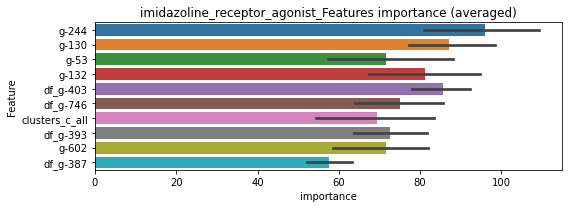

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184959	valid_1's binary_logloss: 0.0311876
[200]	training's binary_logloss: 0.0026524	valid_1's binary_logloss: 0.0117088
[300]	training's binary_logloss: 0.000741436	valid_1's binary_logloss: 0.0084433
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000389004	valid_1's binary_logloss: 0.00800208


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019662	valid_1's binary_logloss: 0.032295
[200]	training's binary_logloss: 0.00297271	valid_1's binary_logloss: 0.00991064
[300]	training's binary_logloss: 0.000814651	valid_1's binary_logloss: 0.00531654
[400]	training's binary_logloss: 0.000388276	valid_1's binary_logloss: 0.00402087
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0003781	valid_1's binary_logloss: 0.0039652


imidazoline_receptor_agonist logloss: 0.00598363925311262
immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959051	valid_1's binary_logloss: 0.144002
[200]	training's binary_logloss: 0.0451413	valid_1's binary_logloss: 0.108119
[300]	training's binary_logloss: 0.0222596	valid_1's binary_logloss: 0.0953688
[400]	training's binary_logloss: 0.011956	valid_1's binary_logloss: 0.0896547
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0105237	valid_1's binary_logloss: 0.0890995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961937	valid_1's binary_logloss: 0.150778
[200]	training's binary_logloss: 0.0425344	valid_1's binary_logloss: 0.110728
[300]	training's binary_logloss: 0.0217644	valid_1's binary_logloss: 0.0980676
[400]	training's binary_logloss: 0.0113805	valid_1's binary_logloss: 0.0915604
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00826107	valid_1's binary_logloss: 0.0899075


1 / 3 AUC score:0.988
y_Threshold: 0.0929220, Threshold: 0.3822063, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 202 → Positive_corect_labels: 620/3731
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.34399, conf_1:0.42043
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.3822063
Num_p_label: 77.0, Expected: 12.2, Adj_threshold_2: 0.3922063
Num_p_label: 76.0, Expected: 12.2, Adj_threshold_3: 0.4022063
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_4: 0.4122063
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_5: 0.4222063
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_6: 0.4322063
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_7: 0.4422063
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_8: 0.4522063
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_9: 0.4622063
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_10: 0.4722063
threshold: 0.4822063, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 620.0/3731, y_label_rate: 0.166175

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677775	valid_1's binary_logloss: 0.113847
[200]	training's binary_logloss: 0.0226146	valid_1's binary_logloss: 0.0779206
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0117696	valid_1's binary_logloss: 0.0692712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656174	valid_1's binary_logloss: 0.117592
[200]	training's binary_logloss: 0.0213939	valid_1's binary_logloss: 0.0811577
[300]	training's binary_logloss: 0.00922691	valid_1's binary_logloss: 0.0720134
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00972673	valid_1's binary_logloss: 0.0716907


2 / 3 AUC score:0.991
y_Threshold: 0.2472183, Threshold: 0.4822063, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 578.0/3647
p_label_rate: 0.0346560 Vs.target_rate: 0.00307, Num_p_label: 138.0, conf_0:0.43399, conf_1:0.53043
Num_p_label: 138.0, Expected: 12.2, Adj_threshold_1: 0.4822063
Num_p_label: 134.0, Expected: 12.2, Adj_threshold_2: 0.4922063
Num_p_label: 130.0, Expected: 12.2, Adj_threshold_3: 0.5022063
Num_p_label: 125.0, Expected: 12.2, Adj_threshold_4: 0.5122063
Num_p_label: 122.0, Expected: 12.2, Adj_threshold_5: 0.5222063
Num_p_label: 119.0, Expected: 12.2, Adj_threshold_6: 0.5322063
Num_p_label: 114.0, Expected: 12.2, Adj_threshold_7: 0.5422063
Num_p_label: 112.0, Expected: 12.2, Adj_threshold_8: 0.5522063
Num_p_label: 110.0, Expected: 12.2, Adj_threshold_9: 0.5622063
Num_p_label: 106.0, Expected: 12.2, Adj_threshold_10: 0.5722063
threshold: 0.5822063, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 578.0/3647, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498531	valid_1's binary_logloss: 0.0903902
[200]	training's binary_logloss: 0.0138722	valid_1's binary_logloss: 0.0524231
[300]	training's binary_logloss: 0.00561546	valid_1's binary_logloss: 0.0407421
[400]	training's binary_logloss: 0.00309192	valid_1's binary_logloss: 0.0358082
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00297933	valid_1's binary_logloss: 0.0353726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055117	valid_1's binary_logloss: 0.0796652
[200]	training's binary_logloss: 0.0161906	valid_1's binary_logloss: 0.0421416
[300]	training's binary_logloss: 0.00636916	valid_1's binary_logloss: 0.029271


3 / 3 AUC score:0.999
y_Threshold: 0.2068148, Threshold: 0.5822063, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 564.0/3619
p_label_rate: 0.0296334 Vs.target_rate: 0.00307, Num_p_label: 118.0, conf_0:0.52399, conf_1:0.64043
Num_p_label: 118.0, Expected: 12.2, Adj_threshold_1: 0.5822063


[400]	training's binary_logloss: 0.00333298	valid_1's binary_logloss: 0.0246907
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00311755	valid_1's binary_logloss: 0.0242494


Num_p_label: 117.0, Expected: 12.2, Adj_threshold_2: 0.5922063
Num_p_label: 116.0, Expected: 12.2, Adj_threshold_3: 0.6022063
Num_p_label: 116.0, Expected: 12.2, Adj_threshold_4: 0.6122063
Num_p_label: 115.0, Expected: 12.2, Adj_threshold_5: 0.6222063
Num_p_label: 109.0, Expected: 12.2, Adj_threshold_6: 0.6322063
Num_p_label: 108.0, Expected: 12.2, Adj_threshold_7: 0.6422063
Num_p_label: 106.0, Expected: 12.2, Adj_threshold_8: 0.6522063
Num_p_label: 103.0, Expected: 12.2, Adj_threshold_9: 0.6622063
Num_p_label: 102.0, Expected: 12.2, Adj_threshold_10: 0.6722063
threshold: 0.6822063, positive_p_label: 102.0/3982, p_label_rate: 0.0256153
positive_y_label: 666.0/7601, y_label_rate: 0.0876200


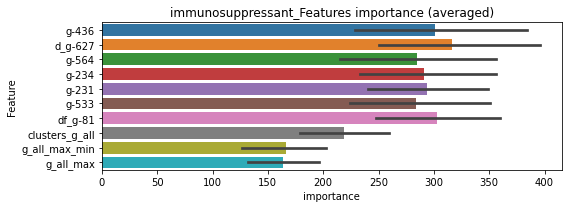

len(train_index) : 3800
len(valid_index) : 3801
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316965	valid_1's binary_logloss: 0.0615999
[200]	training's binary_logloss: 0.00942679	valid_1's binary_logloss: 0.0376266
[300]	training's binary_logloss: 0.00411119	valid_1's binary_logloss: 0.0322965
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00265994	valid_1's binary_logloss: 0.0299889


len(train_index) : 3801
len(valid_index) : 3800
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034209	valid_1's binary_logloss: 0.0581394
[200]	training's binary_logloss: 0.0109188	valid_1's binary_logloss: 0.0358215


immunosuppressant logloss: 0.03051524763551362


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00503652	valid_1's binary_logloss: 0.0310417


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353622	valid_1's binary_logloss: 0.0556517
[200]	training's binary_logloss: 0.00522148	valid_1's binary_logloss: 0.0139089
[300]	training's binary_logloss: 0.00144288	valid_1's binary_logloss: 0.00618366
[400]	training's binary_logloss: 0.000720187	valid_1's binary_logloss: 0.00409682
[500]	training's binary_logloss: 0.00049021	valid_1's binary_logloss: 0.00338216
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000449128	valid_1's binary_logloss: 0.00323685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347946	valid_1's binary_logloss: 0.0667818
[200]	training's binary_logloss: 0.00503052	valid_1's binary_logloss: 0.0304486
[300]	training's binary_logloss: 0.00140462	valid_1's binary_logloss: 0.0234717
[400]	training's binary_logloss: 0.000699995	valid_1's binary_logloss: 0.0211121
Early stopping, best iteration is:
[45

1 / 3 AUC score:1.000
y_Threshold: 0.0033293, Threshold: 0.0052709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00474, conf_1:0.00580
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0052709
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.0152709
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.0252709
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_4: 0.0352709
threshold: 0.0352709, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343718	valid_1's binary_logloss: 0.0540259
[200]	training's binary_logloss: 0.00502543	valid_1's binary_logloss: 0.0151045
[300]	training's binary_logloss: 0.00142537	valid_1's binary_logloss: 0.00828146
[400]	training's binary_logloss: 0.00069968	valid_1's binary_logloss: 0.00623079
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000521565	valid_1's binary_logloss: 0.00576179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339736	valid_1's binary_logloss: 0.055879
[200]	training's binary_logloss: 0.00489745	valid_1's binary_logloss: 0.0174334
[300]	training's binary_logloss: 0.00139382	valid_1's binary_logloss: 0.0104763
[400]	training's binary_logloss: 0.00069338	valid_1's binary_logloss: 0.008299
[500]	training's binary_logloss: 0.00047497	valid_1's binary_logloss: 0.00736392
Early stopping, best iteration is:
[541]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0381244, Threshold: 0.0352709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0047715 Vs.target_rate: 0.00126, Num_p_label: 19.0, conf_0:0.03174, conf_1:0.03880
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.0352709
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.0452709
threshold: 0.0452709, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343718	valid_1's binary_logloss: 0.0540259
[200]	training's binary_logloss: 0.00502543	valid_1's binary_logloss: 0.0151045
[300]	training's binary_logloss: 0.00142537	valid_1's binary_logloss: 0.00828146
[400]	training's binary_logloss: 0.00069968	valid_1's binary_logloss: 0.00623079
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000521565	valid_1's binary_logloss: 0.00576179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339736	valid_1's binary_logloss: 0.055879
[200]	training's binary_logloss: 0.00489745	valid_1's binary_logloss: 0.0174334
[300]	training's binary_logloss: 0.00139382	valid_1's binary_logloss: 0.0104763
[400]	training's binary_logloss: 0.00069338	valid_1's binary_logloss: 0.008299
[500]	training's binary_logloss: 0.00047497	valid_1's binary_logloss: 0.00736392
Early stopping, best iteration is:
[541]	t

3 / 3 AUC score:1.000
y_Threshold: 0.0381244, Threshold: 0.0452709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.04074, conf_1:0.04980
threshold: 0.0452709, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 663.0/7788, y_label_rate: 0.0851310


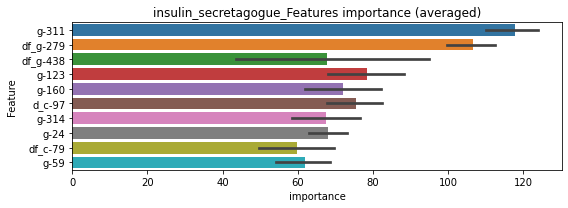

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200818	valid_1's binary_logloss: 0.0334855
[200]	training's binary_logloss: 0.00292002	valid_1's binary_logloss: 0.0118983
[300]	training's binary_logloss: 0.000757269	valid_1's binary_logloss: 0.00851591
[400]	training's binary_logloss: 0.000363465	valid_1's binary_logloss: 0.0080237
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000377367	valid_1's binary_logloss: 0.00800105


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191728	valid_1's binary_logloss: 0.0274507
[200]	training's binary_logloss: 0.00288916	valid_1's binary_logloss: 0.00760342
[300]	training's binary_logloss: 0.000804456	valid_1's binary_logloss: 0.00443761
[400]	training's binary_logloss: 0.000387873	valid_1's binary_logloss: 0.00368606
[500]	training's binary_logloss: 0.000259423	valid_1's binary_logloss: 0.00340834
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000249826	valid_1's binary_logloss: 0.00338849


insulin_secretagogue logloss: 0.005694769427186911


neg labels: 3289 → selected neg labels: 3281


insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343644	valid_1's binary_logloss: 0.0680075
[200]	training's binary_logloss: 0.00548514	valid_1's binary_logloss: 0.0292755
[300]	training's binary_logloss: 0.00163318	valid_1's binary_logloss: 0.0212499
[400]	training's binary_logloss: 0.000825201	valid_1's binary_logloss: 0.0191707
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000799706	valid_1's binary_logloss: 0.0191083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359538	valid_1's binary_logloss: 0.0663205
[200]	training's binary_logloss: 0.00586727	valid_1's binary_logloss: 0.0280343
[300]	training's binary_logloss: 0.00177002	valid_1's binary_logloss: 0.021016
[400]	training's binary_logloss: 0.000873215	valid_1's binary_logloss: 0.0188861
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000775346	valid_1's binary_logloss: 0.0184487


1 / 3 AUC score:1.000
y_Threshold: 0.0056490, Threshold: 0.0134414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00214, Num_p_label: 80.0, conf_0:0.01210, conf_1:0.01479
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0134414
Num_p_label: 32.0, Expected: 8.5, Adj_threshold_2: 0.0234414
Num_p_label: 20.0, Expected: 8.5, Adj_threshold_3: 0.0334414
Num_p_label: 14.0, Expected: 8.5, Adj_threshold_4: 0.0434414
threshold: 0.0434414, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364957	valid_1's binary_logloss: 0.058396
[200]	training's binary_logloss: 0.00584126	valid_1's binary_logloss: 0.0167771
[300]	training's binary_logloss: 0.00174758	valid_1's binary_logloss: 0.00903343
[400]	training's binary_logloss: 0.000856891	valid_1's binary_logloss: 0.00656192
[500]	training's binary_logloss: 0.000573381	valid_1's binary_logloss: 0.00580915
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000501569	valid_1's binary_logloss: 0.00567267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349068	valid_1's binary_logloss: 0.0646319
[200]	training's binary_logloss: 0.0053788	valid_1's binary_logloss: 0.0242953
[300]	training's binary_logloss: 0.00161694	valid_1's binary_logloss: 0.0164063
[400]	training's binary_logloss: 0.000814671	valid_1's binary_logloss: 0.0136961
Early stopping, best iteration is:
[431

2 / 3 AUC score:1.000
y_Threshold: 0.0332595, Threshold: 0.0434414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0092918 Vs.target_rate: 0.00214, Num_p_label: 37.0, conf_0:0.03910, conf_1:0.04779
Num_p_label: 37.0, Expected: 8.5, Adj_threshold_1: 0.0434414
Num_p_label: 30.0, Expected: 8.5, Adj_threshold_2: 0.0534414
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_3: 0.0634414
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_4: 0.0734414
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_5: 0.0834414
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_6: 0.0934414
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_7: 0.1034414
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_8: 0.1134414
threshold: 0.1134414, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345569	valid_1's binary_logloss: 0.0591311
[200]	training's binary_logloss: 0.00543353	valid_1's binary_logloss: 0.0201627
[300]	training's binary_logloss: 0.00164356	valid_1's binary_logloss: 0.0121451
[400]	training's binary_logloss: 0.000831962	valid_1's binary_logloss: 0.00986765
[500]	training's binary_logloss: 0.000558294	valid_1's binary_logloss: 0.00884343
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.000489651	valid_1's binary_logloss: 0.00861441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353885	valid_1's binary_logloss: 0.0578273
[200]	training's binary_logloss: 0.00568278	valid_1's binary_logloss: 0.0179344
[300]	training's binary_logloss: 0.00168945	valid_1's binary_logloss: 0.0097824
[400]	training's binary_logloss: 0.000842888	valid_1's binary_logloss: 0.00760769
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0253377, Threshold: 0.1134414, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0037670 Vs.target_rate: 0.00214, Num_p_label: 15.0, conf_0:0.10210, conf_1:0.12479
threshold: 0.1134414, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 669.0/7783, y_label_rate: 0.0859566


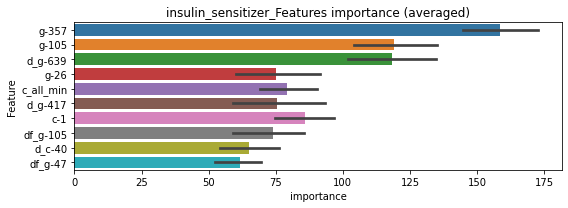

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189129	valid_1's binary_logloss: 0.0386033
[200]	training's binary_logloss: 0.00301305	valid_1's binary_logloss: 0.0180429
[300]	training's binary_logloss: 0.000891111	valid_1's binary_logloss: 0.0145235
[400]	training's binary_logloss: 0.000436836	valid_1's binary_logloss: 0.013842
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000410889	valid_1's binary_logloss: 0.0137758


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185171	valid_1's binary_logloss: 0.036159
[200]	training's binary_logloss: 0.00290223	valid_1's binary_logloss: 0.0138747
[300]	training's binary_logloss: 0.000877974	valid_1's binary_logloss: 0.00981592
[400]	training's binary_logloss: 0.000437425	valid_1's binary_logloss: 0.00879046
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000416114	valid_1's binary_logloss: 0.00870246


insulin_sensitizer logloss: 0.011239469046317384
integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385494	valid_1's binary_logloss: 0.0715736
[200]	training's binary_logloss: 0.00665702	valid_1's binary_logloss: 0.0297676
[300]	training's binary_logloss: 0.00191631	valid_1's binary_logloss: 0.0189013
[400]	training's binary_logloss: 0.000933996	valid_1's binary_logloss: 0.0155541
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000808971	valid_1's binary_logloss: 0.0150881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040993	valid_1's binary_logloss: 0.0676978
[200]	training's binary_logloss: 0.00741658	valid_1's binary_logloss: 0.0260646
[300]	training's binary_logloss: 0.00209387	valid_1's binary_logloss: 0.0153392
[400]	training's binary_logloss: 0.000993589	valid_1's binary_logloss: 0.011833
[500]	training's binary_logloss: 0.000635948	valid_1's binary_logloss: 0.0104899
[600]	training's binary_logloss: 0.00052344

1 / 3 AUC score:1.000
y_Threshold: 0.0041849, Threshold: 0.0059564, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176, Num_p_label: 80.0, conf_0:0.00536, conf_1:0.00655
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0059564
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.0159564
Num_p_label: 3.0, Expected: 7.0, Adj_threshold_3: 0.0259564
threshold: 0.0259564, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374366	valid_1's binary_logloss: 0.0702094
[200]	training's binary_logloss: 0.00627704	valid_1's binary_logloss: 0.0291032
[300]	training's binary_logloss: 0.00181073	valid_1's binary_logloss: 0.0187212
[400]	training's binary_logloss: 0.000902929	valid_1's binary_logloss: 0.0155959
[500]	training's binary_logloss: 0.000598082	valid_1's binary_logloss: 0.0144216
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000543267	valid_1's binary_logloss: 0.0140321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390864	valid_1's binary_logloss: 0.0670506
[200]	training's binary_logloss: 0.00674222	valid_1's binary_logloss: 0.0232078
[300]	training's binary_logloss: 0.00197154	valid_1's binary_logloss: 0.0137991
[400]	training's binary_logloss: 0.000959546	valid_1's binary_logloss: 0.0112014
[500]	training's binary_logloss: 0.000624

2 / 3 AUC score:1.000
y_Threshold: 0.0194848, Threshold: 0.0259564, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0052737 Vs.target_rate: 0.00176, Num_p_label: 21.0, conf_0:0.02336, conf_1:0.02855
threshold: 0.0259564, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385589	valid_1's binary_logloss: 0.0629306
[200]	training's binary_logloss: 0.00659	valid_1's binary_logloss: 0.0223009
[300]	training's binary_logloss: 0.00189829	valid_1's binary_logloss: 0.0128531
[400]	training's binary_logloss: 0.000924209	valid_1's binary_logloss: 0.010081
[500]	training's binary_logloss: 0.00059592	valid_1's binary_logloss: 0.00891507
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00059592	valid_1's binary_logloss: 0.00891507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384281	valid_1's binary_logloss: 0.0620627
[200]	training's binary_logloss: 0.00659843	valid_1's binary_logloss: 0.019428
[300]	training's binary_logloss: 0.00195863	valid_1's binary_logloss: 0.0103562
[400]	training's binary_logloss: 0.000947511	valid_1's binary_logloss: 0.00725006
[500]	training's binary_logloss: 0.000626985	

3 / 3 AUC score:1.000
y_Threshold: 0.0455502, Threshold: 0.0259564, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0055249 Vs.target_rate: 0.00176, Num_p_label: 22.0, conf_0:0.02336, conf_1:0.02855
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_1: 0.0259564
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0359564
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0459564
threshold: 0.0459564, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 664.0/7784, y_label_rate: 0.0853032


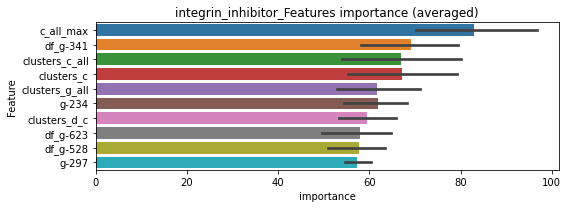

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210866	valid_1's binary_logloss: 0.0390405
[200]	training's binary_logloss: 0.00347915	valid_1's binary_logloss: 0.0194545
[300]	training's binary_logloss: 0.00100358	valid_1's binary_logloss: 0.0158436
[400]	training's binary_logloss: 0.000474818	valid_1's binary_logloss: 0.0153719
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000383678	valid_1's binary_logloss: 0.0151493


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213261	valid_1's binary_logloss: 0.0374459
[200]	training's binary_logloss: 0.00370238	valid_1's binary_logloss: 0.0145229
[300]	training's binary_logloss: 0.00104443	valid_1's binary_logloss: 0.00950064
[400]	training's binary_logloss: 0.000496874	valid_1's binary_logloss: 0.00800424
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00040373	valid_1's binary_logloss: 0.00781326


integrin_inhibitor logloss: 0.011481274862480975
jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806602	valid_1's binary_logloss: 0.143457
[200]	training's binary_logloss: 0.0317565	valid_1's binary_logloss: 0.119942
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.030899	valid_1's binary_logloss: 0.119667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803548	valid_1's binary_logloss: 0.145307
[200]	training's binary_logloss: 0.0363977	valid_1's binary_logloss: 0.121344


1 / 3 AUC score:0.982
y_Threshold: 0.1242717, Threshold: 0.3737322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 248 → Positive_corect_labels: 596/3680
p_label_rate: 0.0200904 Vs.target_rate: 0.00386, Num_p_label: 80.0, conf_0:0.33636, conf_1:0.41111
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.3737322
Num_p_label: 76.0, Expected: 15.4, Adj_threshold_2: 0.3837322
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_3: 0.3937322
Num_p_label: 69.0, Expected: 15.4, Adj_threshold_4: 0.4037322
Num_p_label: 68.0, Expected: 15.4, Adj_threshold_5: 0.4137322
Num_p_label: 63.0, Expected: 15.4, Adj_threshold_6: 0.4237322
Num_p_label: 60.0, Expected: 15.4, Adj_threshold_7: 0.4337322
Num_p_label: 60.0, Expected: 15.4, Adj_threshold_8: 0.4437322
Num_p_label: 56.0, Expected: 15.4, Adj_threshold_9: 0.4537322
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_10: 0.4637322


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0218983	valid_1's binary_logloss: 0.115415


threshold: 0.4737322, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 596.0/3680, y_label_rate: 0.1619565
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489172	valid_1's binary_logloss: 0.079767
[200]	training's binary_logloss: 0.0126972	valid_1's binary_logloss: 0.0489448
[300]	training's binary_logloss: 0.00498433	valid_1's binary_logloss: 0.0428541
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0031791	valid_1's binary_logloss: 0.0412744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498978	valid_1's binary_logloss: 0.0847479
[200]	training's binary_logloss: 0.0135348	valid_1's binary_logloss: 0.0506613


2 / 3 AUC score:0.997
y_Threshold: 0.3137828, Threshold: 0.4737322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 567.0/3622
p_label_rate: 0.0349071 Vs.target_rate: 0.00386, Num_p_label: 139.0, conf_0:0.42636, conf_1:0.52111
Num_p_label: 139.0, Expected: 15.4, Adj_threshold_1: 0.4737322
Num_p_label: 136.0, Expected: 15.4, Adj_threshold_2: 0.4837322
Num_p_label: 132.0, Expected: 15.4, Adj_threshold_3: 0.4937322
Num_p_label: 129.0, Expected: 15.4, Adj_threshold_4: 0.5037322
Num_p_label: 127.0, Expected: 15.4, Adj_threshold_5: 0.5137322
Num_p_label: 123.0, Expected: 15.4, Adj_threshold_6: 0.5237322
Num_p_label: 117.0, Expected: 15.4, Adj_threshold_7: 0.5337322
Num_p_label: 115.0, Expected: 15.4, Adj_threshold_8: 0.5437322
Num_p_label: 110.0, Expected: 15.4, Adj_threshold_9: 0.5537322
Num_p_label: 107.0, Expected: 15.4, Adj_threshold_10: 0.5637322
threshold: 0.5737322, positive_p_label: 106.0/3982, p_label_rate: 0.0266198


[300]	training's binary_logloss: 0.00525951	valid_1's binary_logloss: 0.0423222
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00541798	valid_1's binary_logloss: 0.0422408


positive_y_label: 567.0/3622, y_label_rate: 0.1565433
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404511	valid_1's binary_logloss: 0.0700719
[200]	training's binary_logloss: 0.00888924	valid_1's binary_logloss: 0.0416938
[300]	training's binary_logloss: 0.00348789	valid_1's binary_logloss: 0.0358419
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00211604	valid_1's binary_logloss: 0.033428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422652	valid_1's binary_logloss: 0.0641636
[200]	training's binary_logloss: 0.00975605	valid_1's binary_logloss: 0.035047


3 / 3 AUC score:0.998
y_Threshold: 0.2027718, Threshold: 0.5737322, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 547.0/3582


[300]	training's binary_logloss: 0.00373792	valid_1's binary_logloss: 0.030212
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00251141	valid_1's binary_logloss: 0.0292228


p_label_rate: 0.0359116 Vs.target_rate: 0.00386, Num_p_label: 143.0, conf_0:0.51636, conf_1:0.63111
Num_p_label: 143.0, Expected: 15.4, Adj_threshold_1: 0.5737322
Num_p_label: 140.0, Expected: 15.4, Adj_threshold_2: 0.5837322
Num_p_label: 138.0, Expected: 15.4, Adj_threshold_3: 0.5937322
Num_p_label: 135.0, Expected: 15.4, Adj_threshold_4: 0.6037322
Num_p_label: 134.0, Expected: 15.4, Adj_threshold_5: 0.6137322
Num_p_label: 132.0, Expected: 15.4, Adj_threshold_6: 0.6237322
Num_p_label: 130.0, Expected: 15.4, Adj_threshold_7: 0.6337322
Num_p_label: 125.0, Expected: 15.4, Adj_threshold_8: 0.6437322
Num_p_label: 122.0, Expected: 15.4, Adj_threshold_9: 0.6537322
Num_p_label: 121.0, Expected: 15.4, Adj_threshold_10: 0.6637322
threshold: 0.6737322, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 665.0/7564, y_label_rate: 0.0879164


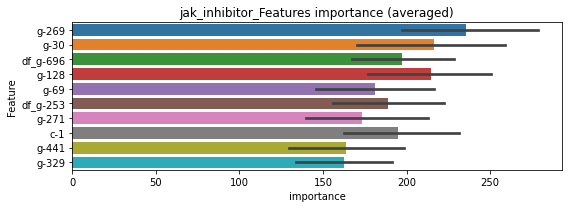

len(train_index) : 3782
len(valid_index) : 3782
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244689	valid_1's binary_logloss: 0.0581154
[200]	training's binary_logloss: 0.00610871	valid_1's binary_logloss: 0.0426268


len(train_index) : 3782
len(valid_index) : 3782
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00376475	valid_1's binary_logloss: 0.0413859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250259	valid_1's binary_logloss: 0.0499829
[200]	training's binary_logloss: 0.00682857	valid_1's binary_logloss: 0.0316094
[300]	training's binary_logloss: 0.00281605	valid_1's binary_logloss: 0.027184
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00192198	valid_1's binary_logloss: 0.0258768


jak_inhibitor logloss: 0.03363135039014467
kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801399	valid_1's binary_logloss: 0.14766
[200]	training's binary_logloss: 0.0342327	valid_1's binary_logloss: 0.138179
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0368689	valid_1's binary_logloss: 0.137269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821706	valid_1's binary_logloss: 0.135586
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0385913	valid_1's binary_logloss: 0.122194


1 / 3 AUC score:0.975
y_Threshold: 0.1076506, Threshold: 0.5347773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 254 → Positive_corect_labels: 593/3672
p_label_rate: 0.0200904 Vs.target_rate: 0.01146, Num_p_label: 80.0, conf_0:0.48130, conf_1:0.58826
threshold: 0.5347773, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 593.0/3672, y_label_rate: 0.1614924
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375741	valid_1's binary_logloss: 0.0669363
[200]	training's binary_logloss: 0.00873127	valid_1's binary_logloss: 0.0464213
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00516064	valid_1's binary_logloss: 0.0450427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429827	valid_1's binary_logloss: 0.0565117
[200]	training's binary_logloss: 0.00988577	valid_1's binary_logloss: 0.0282169


2 / 3 AUC score:0.993


[300]	training's binary_logloss: 0.00359879	valid_1's binary_logloss: 0.0244069
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00225337	valid_1's binary_logloss: 0.0237948


y_Threshold: 0.2773485, Threshold: 0.5347773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 577.0/3640
p_label_rate: 0.0381718 Vs.target_rate: 0.01146, Num_p_label: 152.0, conf_0:0.48130, conf_1:0.58826
Num_p_label: 152.0, Expected: 45.6, Adj_threshold_1: 0.5347773
Num_p_label: 151.0, Expected: 45.6, Adj_threshold_2: 0.5447773
Num_p_label: 150.0, Expected: 45.6, Adj_threshold_3: 0.5547773
Num_p_label: 149.0, Expected: 45.6, Adj_threshold_4: 0.5647773
Num_p_label: 148.0, Expected: 45.6, Adj_threshold_5: 0.5747773
Num_p_label: 146.0, Expected: 45.6, Adj_threshold_6: 0.5847773
Num_p_label: 146.0, Expected: 45.6, Adj_threshold_7: 0.5947773
Num_p_label: 144.0, Expected: 45.6, Adj_threshold_8: 0.6047773
Num_p_label: 144.0, Expected: 45.6, Adj_threshold_9: 0.6147773
Num_p_label: 144.0, Expected: 45.6, Adj_threshold_10: 0.6247773
threshold: 0.6347773, positive_p_label: 143.0/3982, p_label_rate: 0.0359116
positive_y_label: 577.0/3640, y_label_rate: 0.1585165
=======

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318858	valid_1's binary_logloss: 0.0459461
[200]	training's binary_logloss: 0.00612128	valid_1's binary_logloss: 0.0170157
[300]	training's binary_logloss: 0.00216586	valid_1's binary_logloss: 0.011811
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00133919	valid_1's binary_logloss: 0.0101438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315041	valid_1's binary_logloss: 0.0467202
[200]	training's binary_logloss: 0.0055683	valid_1's binary_logloss: 0.0196582
[300]	training's binary_logloss: 0.00193954	valid_1's binary_logloss: 0.0156053


3 / 3 AUC score:0.999
y_Threshold: 0.3364451, Threshold: 0.6347773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 572.0/3630
p_label_rate: 0.0359116 Vs.target_rate: 0.01146, Num_p_label: 143.0, conf_0:0.57130, conf_1:0.69826
Num_p_label: 143.0, Expected: 45.6, Adj_threshold_1: 0.6347773
Num_p_label: 141.0, Expected: 45.6, Adj_threshold_2: 0.6447773
Num_p_label: 138.0, Expected: 45.6, Adj_threshold_3: 0.6547773
Num_p_label: 136.0, Expected: 45.6, Adj_threshold_4: 0.6647773
Num_p_label: 133.0, Expected: 45.6, Adj_threshold_5: 0.6747773
Num_p_label: 131.0, Expected: 45.6, Adj_threshold_6: 0.6847773


[400]	training's binary_logloss: 0.00106011	valid_1's binary_logloss: 0.0142569
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000899082	valid_1's binary_logloss: 0.0139976


Num_p_label: 129.0, Expected: 45.6, Adj_threshold_7: 0.6947773
Num_p_label: 128.0, Expected: 45.6, Adj_threshold_8: 0.7047773
Num_p_label: 126.0, Expected: 45.6, Adj_threshold_9: 0.7147773
Num_p_label: 126.0, Expected: 45.6, Adj_threshold_10: 0.7247773
threshold: 0.7347773, positive_p_label: 124.0/3982, p_label_rate: 0.0311401
positive_y_label: 696.0/7612, y_label_rate: 0.0914346


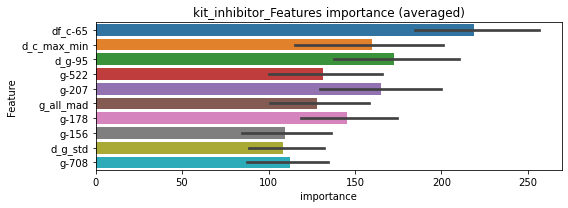

len(train_index) : 3806
len(valid_index) : 3806
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209975	valid_1's binary_logloss: 0.0335941
[200]	training's binary_logloss: 0.00427818	valid_1's binary_logloss: 0.0164243
[300]	training's binary_logloss: 0.00163184	valid_1's binary_logloss: 0.0134916


len(train_index) : 3806


[400]	training's binary_logloss: 0.000917179	valid_1's binary_logloss: 0.0125058
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000837887	valid_1's binary_logloss: 0.0123829


len(valid_index) : 3806
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211062	valid_1's binary_logloss: 0.0318834
[200]	training's binary_logloss: 0.00462408	valid_1's binary_logloss: 0.0144379
[300]	training's binary_logloss: 0.00170841	valid_1's binary_logloss: 0.010399


kit_inhibitor logloss: 0.010655667103558286


[400]	training's binary_logloss: 0.000921765	valid_1's binary_logloss: 0.00915829
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000770003	valid_1's binary_logloss: 0.00892841


laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160586	valid_1's binary_logloss: 0.0183296
[200]	training's binary_logloss: 0.00135983	valid_1's binary_logloss: 0.00282242
[300]	training's binary_logloss: 0.000371643	valid_1's binary_logloss: 0.00135537
[400]	training's binary_logloss: 0.000225362	valid_1's binary_logloss: 0.00105921
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000209553	valid_1's binary_logloss: 0.00103665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160703	valid_1's binary_logloss: 0.0170701
[200]	training's binary_logloss: 0.00138284	valid_1's binary_logloss: 0.00159819
[300]	training's binary_logloss: 0.000391868	valid_1's binary_logloss: 0.000491024
[400]	training's binary_logloss: 0.000223333	valid_1's binary_logloss: 0.000293838
[500]	training's binary_logloss: 0.000192131	valid_1's binary_logloss: 0.000255149
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0005531, Threshold: 0.0008690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00078, conf_1:0.00096
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0108690
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0208690
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0308690
threshold: 0.0308690, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163308	valid_1's binary_logloss: 0.0196806
[200]	training's binary_logloss: 0.00134088	valid_1's binary_logloss: 0.00355819
[300]	training's binary_logloss: 0.000360933	valid_1's binary_logloss: 0.00161837
[400]	training's binary_logloss: 0.000223786	valid_1's binary_logloss: 0.00128748
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164467	valid_1's binary_logloss: 0.0174677
[200]	training's binary_logloss: 0.00135475	valid_1's binary_logloss: 0.00155372
[300]	training's binary_logloss: 0.000361877	valid_1's binary_logloss: 0.000444621
[400]	training's binary_logloss: 0.000220942	valid_1's binary_logloss: 0.000277492
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0674150, Threshold: 0.0308690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.02778, conf_1:0.03396
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.0308690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0408690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0508690
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0608690
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0708690
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0808690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0908690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.1008690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1108690
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1208690
threshold: 0.1308690, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163308	valid_1's binary_logloss: 0.0196806
[200]	training's binary_logloss: 0.00134088	valid_1's binary_logloss: 0.00355819
[300]	training's binary_logloss: 0.000360933	valid_1's binary_logloss: 0.00161837
[400]	training's binary_logloss: 0.000223786	valid_1's binary_logloss: 0.00128748
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00019411	valid_1's binary_logloss: 0.00119284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164467	valid_1's binary_logloss: 0.0174677
[200]	training's binary_logloss: 0.00135475	valid_1's binary_logloss: 0.00155372
[300]	training's binary_logloss: 0.000361877	valid_1's binary_logloss: 0.000444621
[400]	training's binary_logloss: 0.000220942	valid_1's binary_logloss: 0.000277492
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0674150, Threshold: 0.1308690, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.11778, conf_1:0.14396
threshold: 0.1308690, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


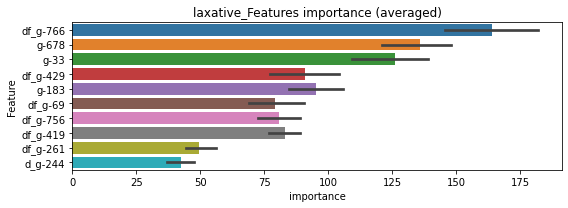

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865145	valid_1's binary_logloss: 0.0104961
[200]	training's binary_logloss: 0.000704487	valid_1's binary_logloss: 0.00228201
[300]	training's binary_logloss: 0.000188108	valid_1's binary_logloss: 0.00183856


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000172541	valid_1's binary_logloss: 0.00181151


================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00875626	valid_1's binary_logloss: 0.0104292
[200]	training's binary_logloss: 0.000725483	valid_1's binary_logloss: 0.00205316
[300]	training's binary_logloss: 0.00019299	valid_1's binary_logloss: 0.00147696
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000130046	valid_1's binary_logloss: 0.00141269


laxative logloss: 0.0016121249157845059
leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015834	valid_1's binary_logloss: 0.0167303
[200]	training's binary_logloss: 0.00132385	valid_1's binary_logloss: 0.00159491
[300]	training's binary_logloss: 0.000359001	valid_1's binary_logloss: 0.000488329
[400]	training's binary_logloss: 0.000218817	valid_1's binary_logloss: 0.000311467
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000194187	valid_1's binary_logloss: 0.000281751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160271	valid_1's binary_logloss: 0.0179917
[200]	training's binary_logloss: 0.00131669	valid_1's binary_logloss: 0.00168614
[300]	training's binary_logloss: 0.000354299	valid_1's binary_logloss: 0.000517523
[400]	training's binary_logloss: 0.000219657	valid_1's binary_logloss: 0.000326189
[500]	training's binary_logloss: 0.000192157	valid_1's binary_logloss: 0.000287312
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0005039, Threshold: 0.0008513, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00077, conf_1:0.00094
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008513
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108513
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208513
threshold: 0.0208513, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160239	valid_1's binary_logloss: 0.0172945
[200]	training's binary_logloss: 0.00130581	valid_1's binary_logloss: 0.00213788
[300]	training's binary_logloss: 0.000347759	valid_1's binary_logloss: 0.00096006
[400]	training's binary_logloss: 0.00021717	valid_1's binary_logloss: 0.000769441
[500]	training's binary_logloss: 0.000187836	valid_1's binary_logloss: 0.000725569
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000187353	valid_1's binary_logloss: 0.00072501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164384	valid_1's binary_logloss: 0.0182437
[200]	training's binary_logloss: 0.00134526	valid_1's binary_logloss: 0.00158123
[300]	training's binary_logloss: 0.000357373	valid_1's binary_logloss: 0.000436082
[400]	training's binary_logloss: 0.000219615	valid_1's binary_logloss: 0.000279112
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0711419, Threshold: 0.0208513, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025, Num_p_label: 12.0, conf_0:0.01877, conf_1:0.02294
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0208513
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.0308513
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0408513
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0508513
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0608513
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0708513
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0808513
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0908513
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1008513
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1108513
threshold: 0.1208513, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160239	valid_1's binary_logloss: 0.0172945
[200]	training's binary_logloss: 0.00130581	valid_1's binary_logloss: 0.00213788
[300]	training's binary_logloss: 0.000347759	valid_1's binary_logloss: 0.00096006
[400]	training's binary_logloss: 0.00021717	valid_1's binary_logloss: 0.000769441
[500]	training's binary_logloss: 0.000187836	valid_1's binary_logloss: 0.000725569
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000187353	valid_1's binary_logloss: 0.00072501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164384	valid_1's binary_logloss: 0.0182437
[200]	training's binary_logloss: 0.00134526	valid_1's binary_logloss: 0.00158123
[300]	training's binary_logloss: 0.000357373	valid_1's binary_logloss: 0.000436082
[400]	training's binary_logloss: 0.000219615	valid_1's binary_logloss: 0.000279112
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0711419, Threshold: 0.1208513, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.10877, conf_1:0.13294
threshold: 0.1208513, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


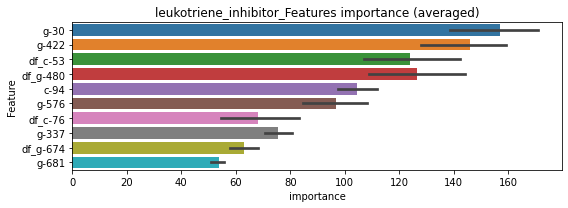

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00854811	valid_1's binary_logloss: 0.00983359
[200]	training's binary_logloss: 0.000685069	valid_1's binary_logloss: 0.00196026
[300]	training's binary_logloss: 0.000183033	valid_1's binary_logloss: 0.00147097
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000155486	valid_1's binary_logloss: 0.00144085


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00859581	valid_1's binary_logloss: 0.00989968
[200]	training's binary_logloss: 0.000694299	valid_1's binary_logloss: 0.00147679
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000244484	valid_1's binary_logloss: 0.00102802


leukotriene_inhibitor logloss: 0.0012344595676927403
leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852586	valid_1's binary_logloss: 0.140712
[200]	training's binary_logloss: 0.0353645	valid_1's binary_logloss: 0.102222
[300]	training's binary_logloss: 0.0162263	valid_1's binary_logloss: 0.0923662
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0103685	valid_1's binary_logloss: 0.0901858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841064	valid_1's binary_logloss: 0.121773
[200]	training's binary_logloss: 0.0379006	valid_1's binary_logloss: 0.0908632
[300]	training's binary_logloss: 0.0186271	valid_1's binary_logloss: 0.0833627
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0118557	valid_1's binary_logloss: 0.0803981


1 / 3 AUC score:0.986
y_Threshold: 0.0687175, Threshold: 0.1694994, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 212 → Positive_corect_labels: 616/3724
p_label_rate: 0.0200904 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.15255, conf_1:0.18645
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.1694994
Num_p_label: 79.0, Expected: 10.4, Adj_threshold_2: 0.1794994
Num_p_label: 71.0, Expected: 10.4, Adj_threshold_3: 0.1894994
Num_p_label: 66.0, Expected: 10.4, Adj_threshold_4: 0.1994994
Num_p_label: 60.0, Expected: 10.4, Adj_threshold_5: 0.2094994
Num_p_label: 57.0, Expected: 10.4, Adj_threshold_6: 0.2194994
Num_p_label: 54.0, Expected: 10.4, Adj_threshold_7: 0.2294994
Num_p_label: 48.0, Expected: 10.4, Adj_threshold_8: 0.2394994
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_9: 0.2494994
Num_p_label: 44.0, Expected: 10.4, Adj_threshold_10: 0.2594994
threshold: 0.2694994, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 616.0/3724, y_label_rate: 0.165413

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613359	valid_1's binary_logloss: 0.0961107
[200]	training's binary_logloss: 0.0203725	valid_1's binary_logloss: 0.0577412
[300]	training's binary_logloss: 0.00830332	valid_1's binary_logloss: 0.0442089
[400]	training's binary_logloss: 0.00421183	valid_1's binary_logloss: 0.0384812
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00294235	valid_1's binary_logloss: 0.0365075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061896	valid_1's binary_logloss: 0.0958059
[200]	training's binary_logloss: 0.0187919	valid_1's binary_logloss: 0.0540122
[300]	training's binary_logloss: 0.00743488	valid_1's binary_logloss: 0.0447176


2 / 3 AUC score:0.998
y_Threshold: 0.1730069, Threshold: 0.2694994, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 594.0/3680
p_label_rate: 0.0215972 Vs.target_rate: 0.00260, Num_p_label: 86.0, conf_0:0.24255, conf_1:0.29645


[400]	training's binary_logloss: 0.00377424	valid_1's binary_logloss: 0.0393192
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0033795	valid_1's binary_logloss: 0.0389079


Num_p_label: 86.0, Expected: 10.4, Adj_threshold_1: 0.2694994
Num_p_label: 85.0, Expected: 10.4, Adj_threshold_2: 0.2794994
Num_p_label: 81.0, Expected: 10.4, Adj_threshold_3: 0.2894994
Num_p_label: 78.0, Expected: 10.4, Adj_threshold_4: 0.2994994
Num_p_label: 76.0, Expected: 10.4, Adj_threshold_5: 0.3094994
Num_p_label: 74.0, Expected: 10.4, Adj_threshold_6: 0.3194994
Num_p_label: 70.0, Expected: 10.4, Adj_threshold_7: 0.3294994
Num_p_label: 68.0, Expected: 10.4, Adj_threshold_8: 0.3394994
Num_p_label: 66.0, Expected: 10.4, Adj_threshold_9: 0.3494994
Num_p_label: 63.0, Expected: 10.4, Adj_threshold_10: 0.3594994
threshold: 0.3694994, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 594.0/3680, y_label_rate: 0.1614130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521854	valid_1's binary_logloss: 0.0745486
[200]	training's binary_logloss: 0.0154627	valid_1's binary_logloss: 0.0384446
[300]	training's binary_logloss: 0.00618094	valid_1's binary_logloss: 0.0263089
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00381303	valid_1's binary_logloss: 0.0225675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550066	valid_1's binary_logloss: 0.0823969
[200]	training's binary_logloss: 0.0162626	valid_1's binary_logloss: 0.0393473
[300]	training's binary_logloss: 0.00623902	valid_1's binary_logloss: 0.0258233
[400]	training's binary_logloss: 0.00323462	valid_1's binary_logloss: 0.0205006
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00281247	valid_1's binary_logloss: 0.0198829


3 / 3 AUC score:1.000
y_Threshold: 0.1877209, Threshold: 0.3694994, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 586.0/3664
p_label_rate: 0.0193370 Vs.target_rate: 0.00260, Num_p_label: 77.0, conf_0:0.33255, conf_1:0.40645
Num_p_label: 77.0, Expected: 10.4, Adj_threshold_1: 0.3694994
Num_p_label: 75.0, Expected: 10.4, Adj_threshold_2: 0.3794994
Num_p_label: 72.0, Expected: 10.4, Adj_threshold_3: 0.3894994
Num_p_label: 70.0, Expected: 10.4, Adj_threshold_4: 0.3994994
Num_p_label: 69.0, Expected: 10.4, Adj_threshold_5: 0.4094994
Num_p_label: 68.0, Expected: 10.4, Adj_threshold_6: 0.4194994
Num_p_label: 66.0, Expected: 10.4, Adj_threshold_7: 0.4294994
Num_p_label: 61.0, Expected: 10.4, Adj_threshold_8: 0.4394994
Num_p_label: 60.0, Expected: 10.4, Adj_threshold_9: 0.4494994
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_10: 0.4594994
threshold: 0.4694994, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 643.0/7646, y_label_rate: 0.08409

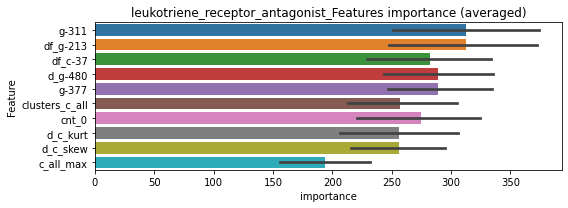

len(train_index) : 3823
len(valid_index) : 3823
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345885	valid_1's binary_logloss: 0.0577842
[200]	training's binary_logloss: 0.0111374	valid_1's binary_logloss: 0.0357157
[300]	training's binary_logloss: 0.00461676	valid_1's binary_logloss: 0.0289175
[400]	training's binary_logloss: 0.00240495	valid_1's binary_logloss: 0.0265508
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00202032	valid_1's binary_logloss: 0.0261526


len(train_index) : 3823
len(valid_index) : 3823
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328042	valid_1's binary_logloss: 0.054906
[200]	training's binary_logloss: 0.0106648	valid_1's binary_logloss: 0.0318126
[300]	training's binary_logloss: 0.00432029	valid_1's binary_logloss: 0.0239097
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00246594	valid_1's binary_logloss: 0.021238


leukotriene_receptor_antagonist logloss: 0.023695253272854443
lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195932	valid_1's binary_logloss: 0.0269814
[200]	training's binary_logloss: 0.0021104	valid_1's binary_logloss: 0.00533067
[300]	training's binary_logloss: 0.000593218	valid_1's binary_logloss: 0.00231165
[400]	training's binary_logloss: 0.000325182	valid_1's binary_logloss: 0.00159984
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000284615	valid_1's binary_logloss: 0.00151533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194676	valid_1's binary_logloss: 0.0223421
[200]	training's binary_logloss: 0.00207873	valid_1's binary_logloss: 0.00314115
[300]	training's binary_logloss: 0.000595155	valid_1's binary_logloss: 0.0010781
[400]	training's binary_logloss: 0.000331687	valid_1's binary_logloss: 0.000640761
[500]	training's binary_logloss: 0.00028432	valid_1's binary_logloss: 0.000556663
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0012341, Threshold: 0.0019218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00173, conf_1:0.00211
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019218
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0119218
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0219218
threshold: 0.0219218, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197373	valid_1's binary_logloss: 0.0246925
[200]	training's binary_logloss: 0.0020126	valid_1's binary_logloss: 0.00344467
[300]	training's binary_logloss: 0.00056407	valid_1's binary_logloss: 0.00129927
[400]	training's binary_logloss: 0.000319894	valid_1's binary_logloss: 0.000835145
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000277725	valid_1's binary_logloss: 0.000770132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195295	valid_1's binary_logloss: 0.0217646
[200]	training's binary_logloss: 0.00200041	valid_1's binary_logloss: 0.0025027
[300]	training's binary_logloss: 0.000572614	valid_1's binary_logloss: 0.000771145
[400]	training's binary_logloss: 0.000321509	valid_1's binary_logloss: 0.000447995
[500]	training's binary_logloss: 0.000282414	valid_1's binary_logloss: 0.000395117
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.1372327, Threshold: 0.0219218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0032647 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.01973, conf_1:0.02411
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.0219218
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0319218
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0419218
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.0519218
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0619218
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0719218
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0819218
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.0919218
threshold: 0.0919218, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197373	valid_1's binary_logloss: 0.0246925
[200]	training's binary_logloss: 0.0020126	valid_1's binary_logloss: 0.00344467
[300]	training's binary_logloss: 0.00056407	valid_1's binary_logloss: 0.00129927
[400]	training's binary_logloss: 0.000319894	valid_1's binary_logloss: 0.000835145
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000277725	valid_1's binary_logloss: 0.000770132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195295	valid_1's binary_logloss: 0.0217646
[200]	training's binary_logloss: 0.00200041	valid_1's binary_logloss: 0.0025027
[300]	training's binary_logloss: 0.000572614	valid_1's binary_logloss: 0.000771145
[400]	training's binary_logloss: 0.000321509	valid_1's binary_logloss: 0.000447995
[500]	training's binary_logloss: 0.000282414	valid_1's binary_logloss: 0.000395117
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.1372327, Threshold: 0.0919218, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.08273, conf_1:0.10111
threshold: 0.0919218, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


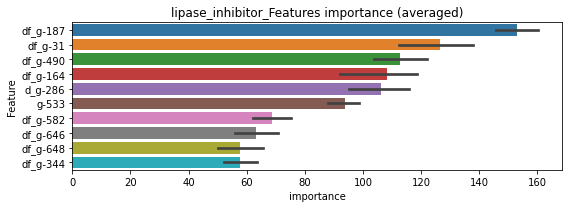

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102684	valid_1's binary_logloss: 0.0132448
[200]	training's binary_logloss: 0.00103656	valid_1's binary_logloss: 0.00298624
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000386744	valid_1's binary_logloss: 0.00230302


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106224	valid_1's binary_logloss: 0.0142382
[200]	training's binary_logloss: 0.00107676	valid_1's binary_logloss: 0.00265139
[300]	training's binary_logloss: 0.000294383	valid_1's binary_logloss: 0.00149076
[400]	training's binary_logloss: 0.000163714	valid_1's binary_logloss: 0.00125814
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000151723	valid_1's binary_logloss: 0.00124865


lipase_inhibitor logloss: 0.001775838438390341
lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895242	valid_1's binary_logloss: 0.140991
[200]	training's binary_logloss: 0.0418847	valid_1's binary_logloss: 0.103661
[300]	training's binary_logloss: 0.0198389	valid_1's binary_logloss: 0.0903867
[400]	training's binary_logloss: 0.00986412	valid_1's binary_logloss: 0.0846798
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00701433	valid_1's binary_logloss: 0.0830838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941837	valid_1's binary_logloss: 0.133613
[200]	training's binary_logloss: 0.0423627	valid_1's binary_logloss: 0.0937043
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0200162	valid_1's binary_logloss: 0.0793778


1 / 3 AUC score:0.990
y_Threshold: 0.0813095, Threshold: 0.2698708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 623/3737
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.24288, conf_1:0.29686
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.2698708
Num_p_label: 77.0, Expected: 10.2, Adj_threshold_2: 0.2798708
Num_p_label: 75.0, Expected: 10.2, Adj_threshold_3: 0.2898708
Num_p_label: 72.0, Expected: 10.2, Adj_threshold_4: 0.2998708
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_5: 0.3098708
Num_p_label: 66.0, Expected: 10.2, Adj_threshold_6: 0.3198708
Num_p_label: 63.0, Expected: 10.2, Adj_threshold_7: 0.3298708
Num_p_label: 60.0, Expected: 10.2, Adj_threshold_8: 0.3398708
Num_p_label: 58.0, Expected: 10.2, Adj_threshold_9: 0.3498708
Num_p_label: 55.0, Expected: 10.2, Adj_threshold_10: 0.3598708
threshold: 0.3698708, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 623.0/3737, y_label_rate: 0.166711

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634152	valid_1's binary_logloss: 0.114242
[200]	training's binary_logloss: 0.0202848	valid_1's binary_logloss: 0.0724646
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00903912	valid_1's binary_logloss: 0.0639097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739588	valid_1's binary_logloss: 0.0987895
[200]	training's binary_logloss: 0.0264401	valid_1's binary_logloss: 0.056282
[300]	training's binary_logloss: 0.0106531	valid_1's binary_logloss: 0.042945


2 / 3 AUC score:0.996


[400]	training's binary_logloss: 0.00529398	valid_1's binary_logloss: 0.0379511
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00474988	valid_1's binary_logloss: 0.0376115


y_Threshold: 0.2209399, Threshold: 0.3698708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 591.0/3673
p_label_rate: 0.0303867 Vs.target_rate: 0.00256, Num_p_label: 121.0, conf_0:0.33288, conf_1:0.40686
Num_p_label: 121.0, Expected: 10.2, Adj_threshold_1: 0.3698708
Num_p_label: 119.0, Expected: 10.2, Adj_threshold_2: 0.3798708
Num_p_label: 112.0, Expected: 10.2, Adj_threshold_3: 0.3898708
Num_p_label: 111.0, Expected: 10.2, Adj_threshold_4: 0.3998708
Num_p_label: 107.0, Expected: 10.2, Adj_threshold_5: 0.4098708
Num_p_label: 106.0, Expected: 10.2, Adj_threshold_6: 0.4198708
Num_p_label: 100.0, Expected: 10.2, Adj_threshold_7: 0.4298708
Num_p_label: 97.0, Expected: 10.2, Adj_threshold_8: 0.4398708
Num_p_label: 92.0, Expected: 10.2, Adj_threshold_9: 0.4498708
Num_p_label: 91.0, Expected: 10.2, Adj_threshold_10: 0.4598708
threshold: 0.4698708, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 591.0/3673, y_label_rate: 0.1609039
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055022	valid_1's binary_logloss: 0.0938602
[200]	training's binary_logloss: 0.0159932	valid_1's binary_logloss: 0.0504473
[300]	training's binary_logloss: 0.0062361	valid_1's binary_logloss: 0.0392831
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00397784	valid_1's binary_logloss: 0.0369538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572812	valid_1's binary_logloss: 0.0886061
[200]	training's binary_logloss: 0.0161457	valid_1's binary_logloss: 0.047162
[300]	training's binary_logloss: 0.00631246	valid_1's binary_logloss: 0.0354981
[400]	training's binary_logloss: 0.0034	valid_1's binary_logloss: 0.0320364
[500]	training's binary_logloss: 0.00224159	valid_1's binary_logloss: 0.0301304
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00190973	valid_1's binary_logloss: 0.0294143


3 / 3 AUC score:0.999
y_Threshold: 0.1379215, Threshold: 0.4698708, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 576.0/3643
p_label_rate: 0.0283777 Vs.target_rate: 0.00256, Num_p_label: 113.0, conf_0:0.42288, conf_1:0.51686
Num_p_label: 113.0, Expected: 10.2, Adj_threshold_1: 0.4698708
Num_p_label: 110.0, Expected: 10.2, Adj_threshold_2: 0.4798708
Num_p_label: 106.0, Expected: 10.2, Adj_threshold_3: 0.4898708
Num_p_label: 102.0, Expected: 10.2, Adj_threshold_4: 0.4998708
Num_p_label: 99.0, Expected: 10.2, Adj_threshold_5: 0.5098708
Num_p_label: 94.0, Expected: 10.2, Adj_threshold_6: 0.5198708
Num_p_label: 88.0, Expected: 10.2, Adj_threshold_7: 0.5298708
Num_p_label: 84.0, Expected: 10.2, Adj_threshold_8: 0.5398708
Num_p_label: 81.0, Expected: 10.2, Adj_threshold_9: 0.5498708
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_10: 0.5598708
threshold: 0.5698708, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 656.0/7625, y_label_rate: 0.

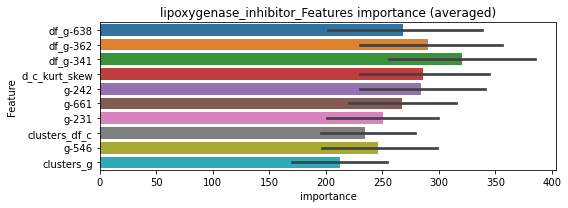

len(train_index) : 3812
len(valid_index) : 3813
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374073	valid_1's binary_logloss: 0.0598697
[200]	training's binary_logloss: 0.0123687	valid_1's binary_logloss: 0.036618
[300]	training's binary_logloss: 0.0056653	valid_1's binary_logloss: 0.0298549


len(train_index) : 3813
len(valid_index) : 3812
================================= fold 2/2 lipoxygenase_inhibitor=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00341879	valid_1's binary_logloss: 0.0276487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361898	valid_1's binary_logloss: 0.0690767
[200]	training's binary_logloss: 0.0122389	valid_1's binary_logloss: 0.0483665
[300]	training's binary_logloss: 0.00547832	valid_1's binary_logloss: 0.0427967
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00341339	valid_1's binary_logloss: 0.0413504


lipoxygenase_inhibitor logloss: 0.03449868396112334
lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151811	valid_1's binary_logloss: 0.016637
[200]	training's binary_logloss: 0.00118396	valid_1's binary_logloss: 0.00176282
[300]	training's binary_logloss: 0.000303105	valid_1's binary_logloss: 0.000711425
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000196362	valid_1's binary_logloss: 0.000588946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155515	valid_1's binary_logloss: 0.0161232
[200]	training's binary_logloss: 0.00122831	valid_1's binary_logloss: 0.00133866
[300]	training's binary_logloss: 0.000313055	valid_1's binary_logloss: 0.000365189
[400]	training's binary_logloss: 0.000195563	valid_1's binary_logloss: 0.000237592
[500]	training's binary_logloss: 0.000175756	valid_1's binary_logloss: 0.000215697
[600]	training's binary_logloss: 0.000170576	valid_1's binary_logloss: 0.000209691
[700]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0005543, Threshold: 0.0016338, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00147, conf_1:0.00180
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0016338
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0116338
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.0216338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0316338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0416338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0516338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0616338
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0716338
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.0816338
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.0916338
threshold: 0.1016338, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159275	valid_1's binary_logloss: 0.0169165
[200]	training's binary_logloss: 0.00123101	valid_1's binary_logloss: 0.00206814
[300]	training's binary_logloss: 0.000303073	valid_1's binary_logloss: 0.001016
[400]	training's binary_logloss: 0.000187874	valid_1's binary_logloss: 0.000841191
[500]	training's binary_logloss: 0.000168397	valid_1's binary_logloss: 0.000810078
[600]	training's binary_logloss: 0.000162229	valid_1's binary_logloss: 0.000803263
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.000160836	valid_1's binary_logloss: 0.00080171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159989	valid_1's binary_logloss: 0.0165616
[200]	training's binary_logloss: 0.00123069	valid_1's binary_logloss: 0.00133493
[300]	training's binary_logloss: 0.000302665	valid_1's binary_logloss: 0.00034368
[400]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0586626, Threshold: 0.1016338, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.09147, conf_1:0.11180
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.1016338
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.1116338
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.1216338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.1316338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.1416338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.1516338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.1616338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.1716338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.1816338
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.1916338
threshold: 0.2016338, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159275	valid_1's binary_logloss: 0.0169165
[200]	training's binary_logloss: 0.00123101	valid_1's binary_logloss: 0.00206814
[300]	training's binary_logloss: 0.000303073	valid_1's binary_logloss: 0.001016
[400]	training's binary_logloss: 0.000187874	valid_1's binary_logloss: 0.000841191
[500]	training's binary_logloss: 0.000168397	valid_1's binary_logloss: 0.000810078
[600]	training's binary_logloss: 0.000162229	valid_1's binary_logloss: 0.000803263
[700]	training's binary_logloss: 0.000159106	valid_1's binary_logloss: 0.000799797
[800]	training's binary_logloss: 0.000157585	valid_1's binary_logloss: 0.00079811
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.000157517	valid_1's binary_logloss: 0.000798034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159989	valid_1's binary_logloss: 0.0165616
[200]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.0586626, Threshold: 0.2016338, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.18147, conf_1:0.22180
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.2016338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.2116338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.2216338
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.2316338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.2416338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.2516338
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.2616338
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.2716338
threshold: 0.2716338, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


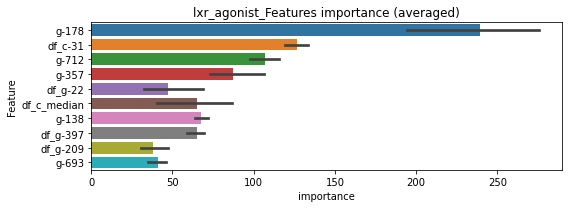

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00836711	valid_1's binary_logloss: 0.00903676
[200]	training's binary_logloss: 0.000647252	valid_1's binary_logloss: 0.00114765
[300]	training's binary_logloss: 0.000157996	valid_1's binary_logloss: 0.000563528
[400]	training's binary_logloss: 0.000101508	valid_1's binary_logloss: 0.000490455
Early stopping, best iteration is:
[465]	training's binary_logloss: 9.23204e-05	valid_1's binary_logloss: 0.000475447


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00848758	valid_1's binary_logloss: 0.00975256
[200]	training's binary_logloss: 0.000654893	valid_1's binary_logloss: 0.00208256
[300]	training's binary_logloss: 0.000165041	valid_1's binary_logloss: 0.00130278
[400]	training's binary_logloss: 0.000104608	valid_1's binary_logloss: 0.00114886
Early stopping, best iteration is:
[440]	training's binary_logloss: 9.70194e-05	valid_1's binary_logloss: 0.00113107


lxr_agonist logloss: 0.000803214494808453
mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024084	valid_1's binary_logloss: 0.037798
[200]	training's binary_logloss: 0.00307352	valid_1's binary_logloss: 0.0106073
[300]	training's binary_logloss: 0.000890721	valid_1's binary_logloss: 0.00580492
[400]	training's binary_logloss: 0.000468898	valid_1's binary_logloss: 0.00411825
[500]	training's binary_logloss: 0.000351478	valid_1's binary_logloss: 0.00365841
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000346481	valid_1's binary_logloss: 0.00363755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246935	valid_1's binary_logloss: 0.0360749
[200]	training's binary_logloss: 0.00315386	valid_1's binary_logloss: 0.00846255
[300]	training's binary_logloss: 0.000898303	valid_1's binary_logloss: 0.00409161
[400]	training's binary_logloss: 0.000469705	valid_1's binary_logloss: 0.00293486
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0037071, Threshold: 0.0090559, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00815, conf_1:0.00996
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0090559
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_2: 0.0190559
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_3: 0.0290559
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_4: 0.0390559
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_5: 0.0490559
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_6: 0.0590559
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_7: 0.0690559
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_8: 0.0790559
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_9: 0.0890559
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_10: 0.0990559
threshold: 0.1090559, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226224	valid_1's binary_logloss: 0.0304473
[200]	training's binary_logloss: 0.00262144	valid_1's binary_logloss: 0.00583368
[300]	training's binary_logloss: 0.000739275	valid_1's binary_logloss: 0.00254658
[400]	training's binary_logloss: 0.000398754	valid_1's binary_logloss: 0.00167322
[500]	training's binary_logloss: 0.000318179	valid_1's binary_logloss: 0.00147493
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000314773	valid_1's binary_logloss: 0.00146465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228987	valid_1's binary_logloss: 0.0321434
[200]	training's binary_logloss: 0.00267988	valid_1's binary_logloss: 0.00665802
[300]	training's binary_logloss: 0.000738537	valid_1's binary_logloss: 0.00317179
[400]	training's binary_logloss: 0.00040093	valid_1's binary_logloss: 0.00224893
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.5339102, Threshold: 0.1090559, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.09815, conf_1:0.11996
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.1090559
Num_p_label: 79.0, Expected: 5.2, Adj_threshold_2: 0.1190559
Num_p_label: 75.0, Expected: 5.2, Adj_threshold_3: 0.1290559
Num_p_label: 73.0, Expected: 5.2, Adj_threshold_4: 0.1390559
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_5: 0.1490559
Num_p_label: 70.0, Expected: 5.2, Adj_threshold_6: 0.1590559
Num_p_label: 68.0, Expected: 5.2, Adj_threshold_7: 0.1690559
Num_p_label: 65.0, Expected: 5.2, Adj_threshold_8: 0.1790559
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_9: 0.1890559
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_10: 0.1990559
threshold: 0.2090559, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226224	valid_1's binary_logloss: 0.0304473
[200]	training's binary_logloss: 0.00262144	valid_1's binary_logloss: 0.00583368
[300]	training's binary_logloss: 0.000739275	valid_1's binary_logloss: 0.00254658
[400]	training's binary_logloss: 0.000398754	valid_1's binary_logloss: 0.00167322
[500]	training's binary_logloss: 0.000318179	valid_1's binary_logloss: 0.00147493
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000314773	valid_1's binary_logloss: 0.00146465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228987	valid_1's binary_logloss: 0.0321434
[200]	training's binary_logloss: 0.00267988	valid_1's binary_logloss: 0.00665802
[300]	training's binary_logloss: 0.000738537	valid_1's binary_logloss: 0.00317179
[400]	training's binary_logloss: 0.00040093	valid_1's binary_logloss: 0.00224893
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.5339102, Threshold: 0.2090559, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0135610 Vs.target_rate: 0.00130, Num_p_label: 54.0, conf_0:0.18815, conf_1:0.22996
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_1: 0.2090559
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_2: 0.2190559
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_3: 0.2290559
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_4: 0.2390559
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_5: 0.2490559
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_6: 0.2590559
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_7: 0.2690559
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_8: 0.2790559
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_9: 0.2890559
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_10: 0.2990559
threshold: 0.3090559, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 699.0/7790, y_label_rate: 0.0897304


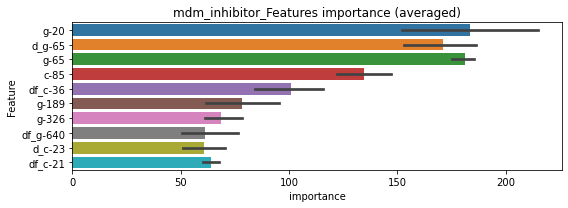

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139204	valid_1's binary_logloss: 0.0233926
[200]	training's binary_logloss: 0.0017696	valid_1's binary_logloss: 0.00900533
[300]	training's binary_logloss: 0.000500036	valid_1's binary_logloss: 0.00695435
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000308778	valid_1's binary_logloss: 0.00674375


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137929	valid_1's binary_logloss: 0.0245528
[200]	training's binary_logloss: 0.00177168	valid_1's binary_logloss: 0.0105386
[300]	training's binary_logloss: 0.000517728	valid_1's binary_logloss: 0.00850297
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000298931	valid_1's binary_logloss: 0.00801523


mdm_inhibitor logloss: 0.007379487597076632
mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297989	valid_1's binary_logloss: 0.0545066
[200]	training's binary_logloss: 0.00416592	valid_1's binary_logloss: 0.0250515
[300]	training's binary_logloss: 0.00119441	valid_1's binary_logloss: 0.0204031
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000829708	valid_1's binary_logloss: 0.0196504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308135	valid_1's binary_logloss: 0.0569462
[200]	training's binary_logloss: 0.00437101	valid_1's binary_logloss: 0.0215388
[300]	training's binary_logloss: 0.00124202	valid_1's binary_logloss: 0.0145721
[400]	training's binary_logloss: 0.000617116	valid_1's binary_logloss: 0.0122852
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000527134	valid_1's binary_logloss: 0.0119145


1 / 3 AUC score:1.000
y_Threshold: 0.0038951, Threshold: 0.0100831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00302, Num_p_label: 80.0, conf_0:0.00907, conf_1:0.01109
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0100831
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_2: 0.0200831
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_3: 0.0300831
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_4: 0.0400831
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_5: 0.0500831
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_6: 0.0600831
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_7: 0.0700831
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_8: 0.0800831
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_9: 0.0900831
Num_p_label: 26.0, Expected: 12.0, Adj_threshold_10: 0.1000831
threshold: 0.1100831, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 654.0/3799, y_label_rate: 0.172150

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293875	valid_1's binary_logloss: 0.0447293
[200]	training's binary_logloss: 0.00387786	valid_1's binary_logloss: 0.0129158
[300]	training's binary_logloss: 0.00109379	valid_1's binary_logloss: 0.00739675
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000595074	valid_1's binary_logloss: 0.00631819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292018	valid_1's binary_logloss: 0.0568259
[200]	training's binary_logloss: 0.00381095	valid_1's binary_logloss: 0.0233998
[300]	training's binary_logloss: 0.00107827	valid_1's binary_logloss: 0.0178376


2 / 3 AUC score:1.000
y_Threshold: 0.0401154, Threshold: 0.1100831, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000831453	valid_1's binary_logloss: 0.0169379


Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3795
p_label_rate: 0.0125565 Vs.target_rate: 0.00302, Num_p_label: 50.0, conf_0:0.09907, conf_1:0.12109
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_1: 0.1100831
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_2: 0.1200831
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_3: 0.1300831
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.1400831
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_5: 0.1500831
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_6: 0.1600831
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_7: 0.1700831
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_8: 0.1800831
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_9: 0.1900831
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_10: 0.2000831
threshold: 0.2100831, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295823	valid_1's binary_logloss: 0.0442209
[200]	training's binary_logloss: 0.00381238	valid_1's binary_logloss: 0.0130758
[300]	training's binary_logloss: 0.0010703	valid_1's binary_logloss: 0.0076817
[400]	training's binary_logloss: 0.000544321	valid_1's binary_logloss: 0.0062966
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000415229	valid_1's binary_logloss: 0.00587256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283448	valid_1's binary_logloss: 0.0613447
[200]	training's binary_logloss: 0.00366369	valid_1's binary_logloss: 0.0282166
[300]	training's binary_logloss: 0.00101567	valid_1's binary_logloss: 0.0205538
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000881433	valid_1's binary_logloss: 0.0199573


3 / 3 AUC score:1.000
y_Threshold: 0.0432940, Threshold: 0.2100831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3791
p_label_rate: 0.0102963 Vs.target_rate: 0.00302, Num_p_label: 41.0, conf_0:0.18907, conf_1:0.23109
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_1: 0.2100831
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_2: 0.2200831
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_3: 0.2300831
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_4: 0.2400831
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_5: 0.2500831
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_6: 0.2600831
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_7: 0.2700831
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_8: 0.2800831
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_9: 0.2900831
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_10: 0.3000831
threshold: 0.3100831, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 686.0/7773, y_label_rate: 0.088254

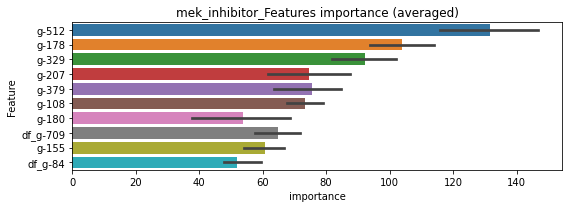

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156139	valid_1's binary_logloss: 0.0267146
[200]	training's binary_logloss: 0.00202758	valid_1's binary_logloss: 0.00943529
[300]	training's binary_logloss: 0.000562464	valid_1's binary_logloss: 0.00639865
[400]	training's binary_logloss: 0.000278404	valid_1's binary_logloss: 0.00561272
[500]	training's binary_logloss: 0.000197129	valid_1's binary_logloss: 0.00524548
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000200537	valid_1's binary_logloss: 0.00523075


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148551	valid_1's binary_logloss: 0.0277487
[200]	training's binary_logloss: 0.00190885	valid_1's binary_logloss: 0.0101125
[300]	training's binary_logloss: 0.000550781	valid_1's binary_logloss: 0.00648727
[400]	training's binary_logloss: 0.000285118	valid_1's binary_logloss: 0.00536793
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00027852	valid_1's binary_logloss: 0.00532196


mek_inhibitor logloss: 0.005276352013658807
membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101301	valid_1's binary_logloss: 0.154081
[200]	training's binary_logloss: 0.0425979	valid_1's binary_logloss: 0.114968
[300]	training's binary_logloss: 0.0195257	valid_1's binary_logloss: 0.107787
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.01272	valid_1's binary_logloss: 0.105849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100704	valid_1's binary_logloss: 0.140765
[200]	training's binary_logloss: 0.0428293	valid_1's binary_logloss: 0.0992751
[300]	training's binary_logloss: 0.0192219	valid_1's binary_logloss: 0.0886659
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0120626	valid_1's binary_logloss: 0.0859386


1 / 3 AUC score:0.985
y_Threshold: 0.0921028, Threshold: 0.2564124, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 212 → Positive_corect_labels: 615/3721
p_label_rate: 0.0200904 Vs.target_rate: 0.00311, Num_p_label: 80.0, conf_0:0.23077, conf_1:0.28205
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.2564124
Num_p_label: 76.0, Expected: 12.4, Adj_threshold_2: 0.2664124
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_3: 0.2764124
Num_p_label: 66.0, Expected: 12.4, Adj_threshold_4: 0.2864124
Num_p_label: 62.0, Expected: 12.4, Adj_threshold_5: 0.2964124
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_6: 0.3064124
Num_p_label: 55.0, Expected: 12.4, Adj_threshold_7: 0.3164124
Num_p_label: 51.0, Expected: 12.4, Adj_threshold_8: 0.3264124
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_9: 0.3364124
Num_p_label: 46.0, Expected: 12.4, Adj_threshold_10: 0.3464124
threshold: 0.3564124, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 615.0/3721, y_label_rate: 0.165278

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714171	valid_1's binary_logloss: 0.108661
[200]	training's binary_logloss: 0.0235666	valid_1's binary_logloss: 0.0675603
[300]	training's binary_logloss: 0.0094386	valid_1's binary_logloss: 0.0552911
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00596591	valid_1's binary_logloss: 0.0513993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731723	valid_1's binary_logloss: 0.0978462
[200]	training's binary_logloss: 0.0245918	valid_1's binary_logloss: 0.0522712
[300]	training's binary_logloss: 0.0101707	valid_1's binary_logloss: 0.0381697
[400]	training's binary_logloss: 0.00527022	valid_1's binary_logloss: 0.0322936


2 / 3 AUC score:0.998


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00359074	valid_1's binary_logloss: 0.0299524


y_Threshold: 0.2151920, Threshold: 0.3564124, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 594.0/3679
p_label_rate: 0.0218483 Vs.target_rate: 0.00311, Num_p_label: 87.0, conf_0:0.32077, conf_1:0.39205
Num_p_label: 87.0, Expected: 12.4, Adj_threshold_1: 0.3564124
Num_p_label: 84.0, Expected: 12.4, Adj_threshold_2: 0.3664124
Num_p_label: 82.0, Expected: 12.4, Adj_threshold_3: 0.3764124
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_4: 0.3864124
Num_p_label: 76.0, Expected: 12.4, Adj_threshold_5: 0.3964124
Num_p_label: 75.0, Expected: 12.4, Adj_threshold_6: 0.4064124
Num_p_label: 75.0, Expected: 12.4, Adj_threshold_7: 0.4164124
Num_p_label: 73.0, Expected: 12.4, Adj_threshold_8: 0.4264124
Num_p_label: 70.0, Expected: 12.4, Adj_threshold_9: 0.4364124
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_10: 0.4464124
threshold: 0.4564124, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 594.0/3679, y_label_rate: 0.1614569
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616231	valid_1's binary_logloss: 0.0969515
[200]	training's binary_logloss: 0.0172142	valid_1's binary_logloss: 0.0531221
[300]	training's binary_logloss: 0.00664428	valid_1's binary_logloss: 0.0430146
[400]	training's binary_logloss: 0.00350603	valid_1's binary_logloss: 0.0391268
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00286052	valid_1's binary_logloss: 0.0376996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641744	valid_1's binary_logloss: 0.0919389
[200]	training's binary_logloss: 0.0185279	valid_1's binary_logloss: 0.0490254
[300]	training's binary_logloss: 0.00759268	valid_1's binary_logloss: 0.0395316


3 / 3 AUC score:0.998


[400]	training's binary_logloss: 0.00395576	valid_1's binary_logloss: 0.0357954
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00348607	valid_1's binary_logloss: 0.0350245


y_Threshold: 0.1534380, Threshold: 0.4564124, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 575.0/3641
p_label_rate: 0.0155701 Vs.target_rate: 0.00311, Num_p_label: 62.0, conf_0:0.41077, conf_1:0.50205
Num_p_label: 62.0, Expected: 12.4, Adj_threshold_1: 0.4564124
Num_p_label: 59.0, Expected: 12.4, Adj_threshold_2: 0.4664124
Num_p_label: 57.0, Expected: 12.4, Adj_threshold_3: 0.4764124
Num_p_label: 53.0, Expected: 12.4, Adj_threshold_4: 0.4864124
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_5: 0.4964124
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_6: 0.5064124
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_7: 0.5164124
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_8: 0.5264124
Num_p_label: 44.0, Expected: 12.4, Adj_threshold_9: 0.5364124
Num_p_label: 44.0, Expected: 12.4, Adj_threshold_10: 0.5464124
threshold: 0.5564124, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 619.0/7623, y_label_rate: 0.0812016


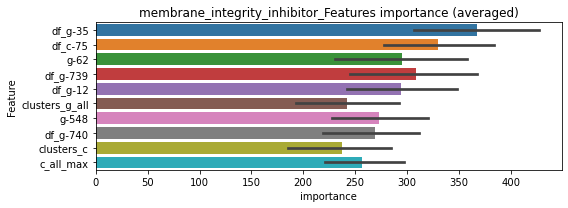

len(train_index) : 3811
len(valid_index) : 3812
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385841	valid_1's binary_logloss: 0.0611119
[200]	training's binary_logloss: 0.0118128	valid_1's binary_logloss: 0.0364995
[300]	training's binary_logloss: 0.00488303	valid_1's binary_logloss: 0.0295768
[400]	training's binary_logloss: 0.00249279	valid_1's binary_logloss: 0.0270318
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00177621	valid_1's binary_logloss: 0.0260142


len(train_index) : 3812
len(valid_index) : 3811
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391431	valid_1's binary_logloss: 0.0607472
[200]	training's binary_logloss: 0.0122946	valid_1's binary_logloss: 0.0357761
[300]	training's binary_logloss: 0.00504279	valid_1's binary_logloss: 0.0301854


membrane_integrity_inhibitor logloss: 0.027420351934939195


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00347733	valid_1's binary_logloss: 0.0288269


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303098	valid_1's binary_logloss: 0.0469421
[200]	training's binary_logloss: 0.00414097	valid_1's binary_logloss: 0.0119428
[300]	training's binary_logloss: 0.00115017	valid_1's binary_logloss: 0.00571713
[400]	training's binary_logloss: 0.000575875	valid_1's binary_logloss: 0.00382984
[500]	training's binary_logloss: 0.000408155	valid_1's binary_logloss: 0.00325973
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000399689	valid_1's binary_logloss: 0.00322786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309827	valid_1's binary_logloss: 0.0409471
[200]	training's binary_logloss: 0.00433539	valid_1's binary_logloss: 0.00843788
[300]	training's binary_logloss: 0.0012022	valid_1's binary_logloss: 0.00325876
[400]	training's binary_logloss: 0.000596452	valid_1's binary_logloss: 0.0020974
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0022857, Threshold: 0.0038228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00344, conf_1:0.00421
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038228
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.0138228
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.0238228
threshold: 0.0238228, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293613	valid_1's binary_logloss: 0.0451603
[200]	training's binary_logloss: 0.00390396	valid_1's binary_logloss: 0.0114765
[300]	training's binary_logloss: 0.00110651	valid_1's binary_logloss: 0.00572236
[400]	training's binary_logloss: 0.00055722	valid_1's binary_logloss: 0.00408804
[500]	training's binary_logloss: 0.000405331	valid_1's binary_logloss: 0.0035397
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000402739	valid_1's binary_logloss: 0.00353832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294299	valid_1's binary_logloss: 0.0388992
[200]	training's binary_logloss: 0.0039672	valid_1's binary_logloss: 0.0077007
[300]	training's binary_logloss: 0.00111338	valid_1's binary_logloss: 0.00296225
[400]	training's binary_logloss: 0.000563142	valid_1's binary_logloss: 0.00189973
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0833503, Threshold: 0.0238228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.02144, conf_1:0.02621
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0238228
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.0338228
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_3: 0.0438228
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.0538228
threshold: 0.0538228, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293613	valid_1's binary_logloss: 0.0451603
[200]	training's binary_logloss: 0.00390396	valid_1's binary_logloss: 0.0114765
[300]	training's binary_logloss: 0.00110651	valid_1's binary_logloss: 0.00572236
[400]	training's binary_logloss: 0.00055722	valid_1's binary_logloss: 0.00408804
[500]	training's binary_logloss: 0.000405331	valid_1's binary_logloss: 0.0035397
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000402739	valid_1's binary_logloss: 0.00353832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294299	valid_1's binary_logloss: 0.0388992
[200]	training's binary_logloss: 0.0039672	valid_1's binary_logloss: 0.0077007
[300]	training's binary_logloss: 0.00111338	valid_1's binary_logloss: 0.00296225
[400]	training's binary_logloss: 0.000563142	valid_1's binary_logloss: 0.00189973
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0833503, Threshold: 0.0538228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.04844, conf_1:0.05921
threshold: 0.0538228, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


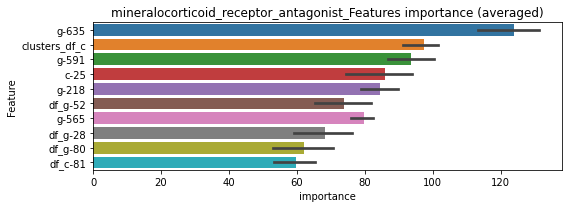

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159423	valid_1's binary_logloss: 0.0272293
[200]	training's binary_logloss: 0.00208591	valid_1's binary_logloss: 0.0111142
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000748808	valid_1's binary_logloss: 0.00951885


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167123	valid_1's binary_logloss: 0.02423
[200]	training's binary_logloss: 0.00225809	valid_1's binary_logloss: 0.00678522
[300]	training's binary_logloss: 0.000638231	valid_1's binary_logloss: 0.00409673
[400]	training's binary_logloss: 0.000314291	valid_1's binary_logloss: 0.00354973
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000283886	valid_1's binary_logloss: 0.0034893


mineralocorticoid_receptor_antagonist logloss: 0.006504077398294712
monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192033	valid_1's binary_logloss: 0.0248086
[200]	training's binary_logloss: 0.00202221	valid_1's binary_logloss: 0.00485097
[300]	training's binary_logloss: 0.000582139	valid_1's binary_logloss: 0.00237608
[400]	training's binary_logloss: 0.000323036	valid_1's binary_logloss: 0.00174881
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000286551	valid_1's binary_logloss: 0.00167385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193922	valid_1's binary_logloss: 0.0227134
[200]	training's binary_logloss: 0.00202372	valid_1's binary_logloss: 0.00309917
[300]	training's binary_logloss: 0.000583525	valid_1's binary_logloss: 0.00114916
[400]	training's binary_logloss: 0.000324343	valid_1's binary_logloss: 0.000716026
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000280183	valid_1's binary_logloss: 0.0006

1 / 3 AUC score:1.000
y_Threshold: 0.0010257, Threshold: 0.0017618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00159, conf_1:0.00194
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017618
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0117618
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0217618
threshold: 0.0217618, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192866	valid_1's binary_logloss: 0.0255926
[200]	training's binary_logloss: 0.00195121	valid_1's binary_logloss: 0.00497866
[300]	training's binary_logloss: 0.00056065	valid_1's binary_logloss: 0.00247585
[400]	training's binary_logloss: 0.000319932	valid_1's binary_logloss: 0.00194775
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000287739	valid_1's binary_logloss: 0.00185953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193291	valid_1's binary_logloss: 0.022756
[200]	training's binary_logloss: 0.00197298	valid_1's binary_logloss: 0.00323522
[300]	training's binary_logloss: 0.000564904	valid_1's binary_logloss: 0.00118152
[400]	training's binary_logloss: 0.000323409	valid_1's binary_logloss: 0.000790482
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000280068	valid_1's binary_logloss: 0.000712

2 / 3 AUC score:1.000
y_Threshold: 0.0644960, Threshold: 0.0217618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0027624 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.01959, conf_1:0.02394
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.0217618
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.0317618
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0417618
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0517618
threshold: 0.0517618, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192866	valid_1's binary_logloss: 0.0255926
[200]	training's binary_logloss: 0.00195121	valid_1's binary_logloss: 0.00497866
[300]	training's binary_logloss: 0.00056065	valid_1's binary_logloss: 0.00247585
[400]	training's binary_logloss: 0.000319932	valid_1's binary_logloss: 0.00194775
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000287739	valid_1's binary_logloss: 0.00185953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193291	valid_1's binary_logloss: 0.022756
[200]	training's binary_logloss: 0.00197298	valid_1's binary_logloss: 0.00323522
[300]	training's binary_logloss: 0.000564904	valid_1's binary_logloss: 0.00118152
[400]	training's binary_logloss: 0.000323409	valid_1's binary_logloss: 0.000790482
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000280068	valid_1's binary_logloss: 0.000712

3 / 3 AUC score:1.000
y_Threshold: 0.0644960, Threshold: 0.0517618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.04659, conf_1:0.05694
threshold: 0.0517618, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


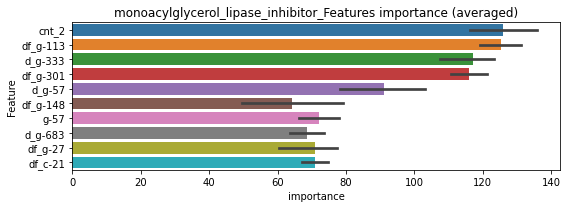

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103347	valid_1's binary_logloss: 0.0152537
[200]	training's binary_logloss: 0.0010342	valid_1's binary_logloss: 0.00423642
[300]	training's binary_logloss: 0.000289296	valid_1's binary_logloss: 0.00332017
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000216323	valid_1's binary_logloss: 0.00327532


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104781	valid_1's binary_logloss: 0.0126398
[200]	training's binary_logloss: 0.00108511	valid_1's binary_logloss: 0.00239866
[300]	training's binary_logloss: 0.000302271	valid_1's binary_logloss: 0.00144558
[400]	training's binary_logloss: 0.000167013	valid_1's binary_logloss: 0.00127057
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000161925	valid_1's binary_logloss: 0.00126531


monoacylglycerol_lipase_inhibitor logloss: 0.0022703158817381284
monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972874	valid_1's binary_logloss: 0.16519
[200]	training's binary_logloss: 0.0489855	valid_1's binary_logloss: 0.130295
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0274761	valid_1's binary_logloss: 0.118555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105518	valid_1's binary_logloss: 0.153112
[200]	training's binary_logloss: 0.0497458	valid_1's binary_logloss: 0.115151
[300]	training's binary_logloss: 0.0256893	valid_1's binary_logloss: 0.102302


1 / 3 AUC score:0.982
y_Threshold: 0.1170782, Threshold: 0.2520228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 238 → Positive_corect_labels: 601/3690
p_label_rate: 0.0200904 Vs.target_rate: 0.00357, Num_p_label: 80.0, conf_0:0.22682, conf_1:0.27723
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.2520228
Num_p_label: 71.0, Expected: 14.2, Adj_threshold_2: 0.2620228
Num_p_label: 68.0, Expected: 14.2, Adj_threshold_3: 0.2720228
Num_p_label: 63.0, Expected: 14.2, Adj_threshold_4: 0.2820228
Num_p_label: 58.0, Expected: 14.2, Adj_threshold_5: 0.2920228
Num_p_label: 56.0, Expected: 14.2, Adj_threshold_6: 0.3020228
Num_p_label: 54.0, Expected: 14.2, Adj_threshold_7: 0.3120228
Num_p_label: 51.0, Expected: 14.2, Adj_threshold_8: 0.3220228


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0169235	valid_1's binary_logloss: 0.097058


Num_p_label: 45.0, Expected: 14.2, Adj_threshold_9: 0.3320228
Num_p_label: 37.0, Expected: 14.2, Adj_threshold_10: 0.3420228
threshold: 0.3520228, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 601.0/3690, y_label_rate: 0.1628726
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678611	valid_1's binary_logloss: 0.108099
[200]	training's binary_logloss: 0.0239751	valid_1's binary_logloss: 0.0666761
[300]	training's binary_logloss: 0.0102412	valid_1's binary_logloss: 0.051562
[400]	training's binary_logloss: 0.00510204	valid_1's binary_logloss: 0.0460704
[500]	training's binary_logloss: 0.00326062	valid_1's binary_logloss: 0.0445051
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00332591	valid_1's binary_logloss: 0.0444099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774519	valid_1's binary_logloss: 0.117981
[200]	training's binary_logloss: 0.0268056	valid_1's binary_logloss: 0.0697634
[300]	training's binary_logloss: 0.0116082	valid_1's binary_logloss: 0.0561985


2 / 3 AUC score:0.997
y_Threshold: 0.2267280, Threshold: 0.3520228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 571.0/3630
p_label_rate: 0.0218483 Vs.target_rate: 0.00357, Num_p_label: 87.0, conf_0:0.31682, conf_1:0.38723
Num_p_label: 87.0, Expected: 14.2, Adj_threshold_1: 0.3520228
Num_p_label: 84.0, Expected: 14.2, Adj_threshold_2: 0.3620228
Num_p_label: 83.0, Expected: 14.2, Adj_threshold_3: 0.3720228
Num_p_label: 78.0, Expected: 14.2, Adj_threshold_4: 0.3820228
Num_p_label: 77.0, Expected: 14.2, Adj_threshold_5: 0.3920228


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00648892	valid_1's binary_logloss: 0.0503871


Num_p_label: 73.0, Expected: 14.2, Adj_threshold_6: 0.4020228
Num_p_label: 72.0, Expected: 14.2, Adj_threshold_7: 0.4120228
Num_p_label: 70.0, Expected: 14.2, Adj_threshold_8: 0.4220228
Num_p_label: 68.0, Expected: 14.2, Adj_threshold_9: 0.4320228
Num_p_label: 68.0, Expected: 14.2, Adj_threshold_10: 0.4420228
threshold: 0.4520228, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 571.0/3630, y_label_rate: 0.1573003
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694953	valid_1's binary_logloss: 0.106887
[200]	training's binary_logloss: 0.0215148	valid_1's binary_logloss: 0.053269
[300]	training's binary_logloss: 0.0086747	valid_1's binary_logloss: 0.0395992
[400]	training's binary_logloss: 0.00449697	valid_1's binary_logloss: 0.0327523
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00449697	valid_1's binary_logloss: 0.0327523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606714	valid_1's binary_logloss: 0.117802
[200]	training's binary_logloss: 0.0181724	valid_1's binary_logloss: 0.0695375
[300]	training's binary_logloss: 0.00777334	valid_1's binary_logloss: 0.0554233
[400]	training's binary_logloss: 0.0038796	valid_1's binary_logloss: 0.0495091
[500]	training's binary_logloss: 0.00246887	valid_1's binary_logloss: 0.0472192
Early stopping, best iteration is:
[500]	training's 

3 / 3 AUC score:0.999
y_Threshold: 0.1421638, Threshold: 0.4520228, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 552.0/3592
p_label_rate: 0.0128076 Vs.target_rate: 0.00357, Num_p_label: 51.0, conf_0:0.40682, conf_1:0.49723
Num_p_label: 51.0, Expected: 14.2, Adj_threshold_1: 0.4520228
Num_p_label: 51.0, Expected: 14.2, Adj_threshold_2: 0.4620228
Num_p_label: 46.0, Expected: 14.2, Adj_threshold_3: 0.4720228
Num_p_label: 46.0, Expected: 14.2, Adj_threshold_4: 0.4820228
Num_p_label: 44.0, Expected: 14.2, Adj_threshold_5: 0.4920228
Num_p_label: 43.0, Expected: 14.2, Adj_threshold_6: 0.5020228
Num_p_label: 43.0, Expected: 14.2, Adj_threshold_7: 0.5120228
Num_p_label: 41.0, Expected: 14.2, Adj_threshold_8: 0.5220228
Num_p_label: 40.0, Expected: 14.2, Adj_threshold_9: 0.5320228
Num_p_label: 40.0, Expected: 14.2, Adj_threshold_10: 0.5420228
threshold: 0.5520228, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 591.0/7574, y_label_rate: 0.07803

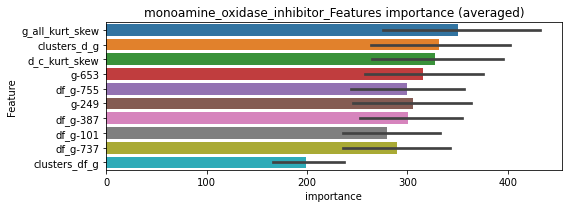

len(train_index) : 3787
len(valid_index) : 3787
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386864	valid_1's binary_logloss: 0.066773
[200]	training's binary_logloss: 0.0123683	valid_1's binary_logloss: 0.0396656
[300]	training's binary_logloss: 0.00519689	valid_1's binary_logloss: 0.0314901
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00349788	valid_1's binary_logloss: 0.0297554


len(train_index) : 3787
len(valid_index) : 3787
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039291	valid_1's binary_logloss: 0.068952
[200]	training's binary_logloss: 0.0132655	valid_1's binary_logloss: 0.0460724
[300]	training's binary_logloss: 0.00541439	valid_1's binary_logloss: 0.038888
[400]	training's binary_logloss: 0.00272003	valid_1's binary_logloss: 0.0359548
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00216869	valid_1's binary_logloss: 0.0353181


monoamine_oxidase_inhibitor logloss: 0.032536752720016375
monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214748	valid_1's binary_logloss: 0.0280082
[200]	training's binary_logloss: 0.00242986	valid_1's binary_logloss: 0.00457652
[300]	training's binary_logloss: 0.000692839	valid_1's binary_logloss: 0.00174274
[400]	training's binary_logloss: 0.000380169	valid_1's binary_logloss: 0.00109952
[500]	training's binary_logloss: 0.000310885	valid_1's binary_logloss: 0.000944429
[600]	training's binary_logloss: 0.000297476	valid_1's binary_logloss: 0.00090794
[700]	training's binary_logloss: 0.000295367	valid_1's binary_logloss: 0.000903545
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.000295145	valid_1's binary_logloss: 0.000902805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217651	valid_1's binary_logloss: 0.0277086
[200]	training's binary_logloss: 0.00247474	valid_1's binary_logloss: 0.00466555
[300]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0015619, Threshold: 0.0036354, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00327, conf_1:0.00400
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0036354
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_2: 0.0136354
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.0236354
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.0336354
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0436354
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.0536354
threshold: 0.0536354, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214243	valid_1's binary_logloss: 0.0271234
[200]	training's binary_logloss: 0.00236376	valid_1's binary_logloss: 0.00470187
[300]	training's binary_logloss: 0.000674646	valid_1's binary_logloss: 0.00171691
[400]	training's binary_logloss: 0.00037121	valid_1's binary_logloss: 0.00107814
[500]	training's binary_logloss: 0.000305926	valid_1's binary_logloss: 0.000943374
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000298343	valid_1's binary_logloss: 0.000923616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215485	valid_1's binary_logloss: 0.0266192
[200]	training's binary_logloss: 0.00236196	valid_1's binary_logloss: 0.00381479
[300]	training's binary_logloss: 0.00066675	valid_1's binary_logloss: 0.00126197
[400]	training's binary_logloss: 0.000365264	valid_1's binary_logloss: 0.000733877
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1077092, Threshold: 0.0536354, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0060271 Vs.target_rate: 0.00076, Num_p_label: 24.0, conf_0:0.04827, conf_1:0.05900
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_1: 0.0536354
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.0636354
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.0736354
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.0836354
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.0936354
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.1036354
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.1136354
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.1236354
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.1336354
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.1436354
threshold: 0.1536354, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214243	valid_1's binary_logloss: 0.0271234
[200]	training's binary_logloss: 0.00236376	valid_1's binary_logloss: 0.00470187
[300]	training's binary_logloss: 0.000674646	valid_1's binary_logloss: 0.00171691
[400]	training's binary_logloss: 0.00037121	valid_1's binary_logloss: 0.00107814
[500]	training's binary_logloss: 0.000305926	valid_1's binary_logloss: 0.000943374
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000298343	valid_1's binary_logloss: 0.000923616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215485	valid_1's binary_logloss: 0.0266192
[200]	training's binary_logloss: 0.00236196	valid_1's binary_logloss: 0.00381479
[300]	training's binary_logloss: 0.00066675	valid_1's binary_logloss: 0.00126197
[400]	training's binary_logloss: 0.000365264	valid_1's binary_logloss: 0.000733877
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1077092, Threshold: 0.1536354, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.13827, conf_1:0.16900
threshold: 0.1536354, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7793, y_label_rate: 0.0852047


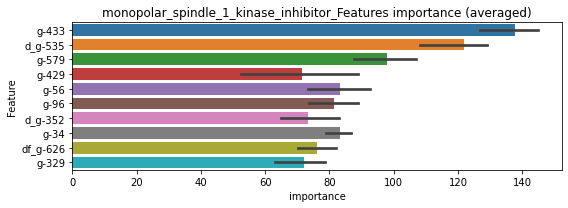

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115015	valid_1's binary_logloss: 0.0183649
[200]	training's binary_logloss: 0.00128522	valid_1's binary_logloss: 0.00702216
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000490009	valid_1's binary_logloss: 0.00601812


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117811	valid_1's binary_logloss: 0.0172037
[200]	training's binary_logloss: 0.00131449	valid_1's binary_logloss: 0.00454433
[300]	training's binary_logloss: 0.00037152	valid_1's binary_logloss: 0.00267758
[400]	training's binary_logloss: 0.000201485	valid_1's binary_logloss: 0.00231551
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000177781	valid_1's binary_logloss: 0.00228271


monopolar_spindle_1_kinase_inhibitor logloss: 0.004150654205437039
mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608


neg labels: 3289 → selected neg labels: 3267


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555458	valid_1's binary_logloss: 0.0953219
[200]	training's binary_logloss: 0.0190742	valid_1's binary_logloss: 0.0785883
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0187162	valid_1's binary_logloss: 0.0785281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530968	valid_1's binary_logloss: 0.102568
[200]	training's binary_logloss: 0.0177632	valid_1's binary_logloss: 0.0888539
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0174117	valid_1's binary_logloss: 0.0885599


1 / 3 AUC score:0.987
y_Threshold: 0.0568993, Threshold: 0.3306538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 193 → Positive_corect_labels: 622/3727
p_label_rate: 0.0200904 Vs.target_rate: 0.00546, Num_p_label: 80.0, conf_0:0.29759, conf_1:0.36372
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.3306538
Num_p_label: 77.0, Expected: 21.7, Adj_threshold_2: 0.3406538
Num_p_label: 76.0, Expected: 21.7, Adj_threshold_3: 0.3506538
Num_p_label: 76.0, Expected: 21.7, Adj_threshold_4: 0.3606538
Num_p_label: 75.0, Expected: 21.7, Adj_threshold_5: 0.3706538
Num_p_label: 72.0, Expected: 21.7, Adj_threshold_6: 0.3806538
Num_p_label: 71.0, Expected: 21.7, Adj_threshold_7: 0.3906538
Num_p_label: 69.0, Expected: 21.7, Adj_threshold_8: 0.4006538
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_9: 0.4106538
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_10: 0.4206538
threshold: 0.4306538, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 622.0/3727, y_label_rate: 0.166890

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341781	valid_1's binary_logloss: 0.0697369
[200]	training's binary_logloss: 0.00662855	valid_1's binary_logloss: 0.0472869
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00437797	valid_1's binary_logloss: 0.04552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034887	valid_1's binary_logloss: 0.0512812
[200]	training's binary_logloss: 0.00762356	valid_1's binary_logloss: 0.0281252


2 / 3 AUC score:0.998
y_Threshold: 0.0943633, Threshold: 0.4306538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 605.0/3693
p_label_rate: 0.0253641 Vs.target_rate: 0.00546, Num_p_label: 101.0, conf_0:0.38759, conf_1:0.47372
Num_p_label: 101.0, Expected: 21.7, Adj_threshold_1: 0.4306538
Num_p_label: 99.0, Expected: 21.7, Adj_threshold_2: 0.4406538
Num_p_label: 98.0, Expected: 21.7, Adj_threshold_3: 0.4506538
Num_p_label: 97.0, Expected: 21.7, Adj_threshold_4: 0.4606538
Num_p_label: 96.0, Expected: 21.7, Adj_threshold_5: 0.4706538
Num_p_label: 95.0, Expected: 21.7, Adj_threshold_6: 0.4806538
Num_p_label: 94.0, Expected: 21.7, Adj_threshold_7: 0.4906538
Num_p_label: 93.0, Expected: 21.7, Adj_threshold_8: 0.5006538
Num_p_label: 92.0, Expected: 21.7, Adj_threshold_9: 0.5106538
Num_p_label: 88.0, Expected: 21.7, Adj_threshold_10: 0.5206538
threshold: 0.5306538, positive_p_label: 87.0/3982, p_label_rate: 0.0218483


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0036381	valid_1's binary_logloss: 0.0251334


positive_y_label: 605.0/3693, y_label_rate: 0.1638234
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029839	valid_1's binary_logloss: 0.0508642
[200]	training's binary_logloss: 0.00516295	valid_1's binary_logloss: 0.0342576
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00326274	valid_1's binary_logloss: 0.0327422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292541	valid_1's binary_logloss: 0.0452293
[200]	training's binary_logloss: 0.00521906	valid_1's binary_logloss: 0.0237497
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0034587	valid_1's binary_logloss: 0.0220508


3 / 3 AUC score:0.999
y_Threshold: 0.0833087, Threshold: 0.5306538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 590.0/3663
p_label_rate: 0.0208438 Vs.target_rate: 0.00546, Num_p_label: 83.0, conf_0:0.47759, conf_1:0.58372
Num_p_label: 83.0, Expected: 21.7, Adj_threshold_1: 0.5306538
Num_p_label: 83.0, Expected: 21.7, Adj_threshold_2: 0.5406538
Num_p_label: 83.0, Expected: 21.7, Adj_threshold_3: 0.5506538
Num_p_label: 82.0, Expected: 21.7, Adj_threshold_4: 0.5606538
Num_p_label: 82.0, Expected: 21.7, Adj_threshold_5: 0.5706538
Num_p_label: 82.0, Expected: 21.7, Adj_threshold_6: 0.5806538
Num_p_label: 82.0, Expected: 21.7, Adj_threshold_7: 0.5906538
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_8: 0.6006538
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_9: 0.6106538
Num_p_label: 79.0, Expected: 21.7, Adj_threshold_10: 0.6206538
threshold: 0.6306538, positive_p_label: 79.0/3982, p_label_rate: 0.0198393
positive_y_label: 669.0/7645, y_label_rate: 0.08750

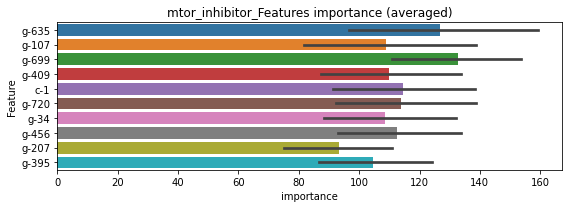

len(train_index) : 3822
len(valid_index) : 3823
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168221	valid_1's binary_logloss: 0.0328669


len(train_index) : 3823
len(valid_index) : 3822
================================= fold 2/2 mtor_inhibitor=================================


[200]	training's binary_logloss: 0.00304914	valid_1's binary_logloss: 0.0221206
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00185925	valid_1's binary_logloss: 0.0215518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171954	valid_1's binary_logloss: 0.0324705


mtor_inhibitor logloss: 0.020591312286569706


[200]	training's binary_logloss: 0.00302758	valid_1's binary_logloss: 0.0206346
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00195078	valid_1's binary_logloss: 0.0196306


mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448634	valid_1's binary_logloss: 0.0795175
[200]	training's binary_logloss: 0.00831315	valid_1's binary_logloss: 0.0334842
[300]	training's binary_logloss: 0.00233383	valid_1's binary_logloss: 0.0211063
[400]	training's binary_logloss: 0.00108659	valid_1's binary_logloss: 0.0172797
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000838015	valid_1's binary_logloss: 0.0161224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451751	valid_1's binary_logloss: 0.0696141
[200]	training's binary_logloss: 0.00817671	valid_1's binary_logloss: 0.0205109
[300]	training's binary_logloss: 0.00237186	valid_1's binary_logloss: 0.00982922
[400]	training's binary_logloss: 0.00112332	valid_1's binary_logloss: 0.00661592
[500]	training's binary_logloss: 0.000710028	valid_1's binary_logloss: 0.00543254
Early stopping, best iteration is:
[552]

1 / 3 AUC score:1.000
y_Threshold: 0.0059706, Threshold: 0.0090632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00816, conf_1:0.00997
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0090632
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.0190632
threshold: 0.0190632, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433822	valid_1's binary_logloss: 0.0770095
[200]	training's binary_logloss: 0.00779593	valid_1's binary_logloss: 0.0300917
[300]	training's binary_logloss: 0.00222301	valid_1's binary_logloss: 0.0188969
[400]	training's binary_logloss: 0.00104559	valid_1's binary_logloss: 0.0147457
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000983606	valid_1's binary_logloss: 0.0144701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458523	valid_1's binary_logloss: 0.0702207
[200]	training's binary_logloss: 0.00819686	valid_1's binary_logloss: 0.0200387
[300]	training's binary_logloss: 0.0024066	valid_1's binary_logloss: 0.00904806
[400]	training's binary_logloss: 0.00113845	valid_1's binary_logloss: 0.00577442
[500]	training's binary_logloss: 0.000718547	valid_1's binary_logloss: 0.00460379
[600]	training's binary_logloss: 0.000559

2 / 3 AUC score:1.000
y_Threshold: 0.0425728, Threshold: 0.0190632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0165746 Vs.target_rate: 0.00202, Num_p_label: 66.0, conf_0:0.01716, conf_1:0.02097
Num_p_label: 66.0, Expected: 8.0, Adj_threshold_1: 0.0190632
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0290632
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.0390632
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_4: 0.0490632
threshold: 0.0490632, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442076	valid_1's binary_logloss: 0.0721342
[200]	training's binary_logloss: 0.00799776	valid_1's binary_logloss: 0.0243633
[300]	training's binary_logloss: 0.00229978	valid_1's binary_logloss: 0.0126129
[400]	training's binary_logloss: 0.00108785	valid_1's binary_logloss: 0.00915793
[500]	training's binary_logloss: 0.00069496	valid_1's binary_logloss: 0.00792462
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000582464	valid_1's binary_logloss: 0.00746208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438519	valid_1's binary_logloss: 0.069833
[200]	training's binary_logloss: 0.00779189	valid_1's binary_logloss: 0.0226501
[300]	training's binary_logloss: 0.00224607	valid_1's binary_logloss: 0.0115881
[400]	training's binary_logloss: 0.0010766	valid_1's binary_logloss: 0.00838592
[500]	training's binary_logloss: 0.0006923

3 / 3 AUC score:1.000
y_Threshold: 0.0556667, Threshold: 0.0490632, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0027624 Vs.target_rate: 0.00202, Num_p_label: 11.0, conf_0:0.04416, conf_1:0.05397
threshold: 0.0490632, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 665.0/7783, y_label_rate: 0.0854426


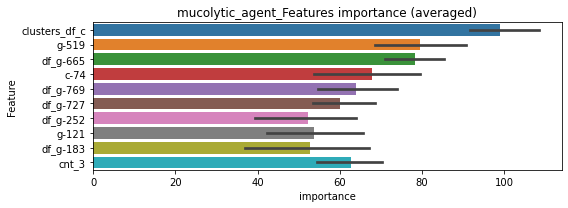

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238672	valid_1's binary_logloss: 0.0448757
[200]	training's binary_logloss: 0.0042697	valid_1's binary_logloss: 0.0197577
[300]	training's binary_logloss: 0.00122298	valid_1's binary_logloss: 0.0149859
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00116347	valid_1's binary_logloss: 0.0148713


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252294	valid_1's binary_logloss: 0.0486913
[200]	training's binary_logloss: 0.00459086	valid_1's binary_logloss: 0.0248563
[300]	training's binary_logloss: 0.00126403	valid_1's binary_logloss: 0.0197888
[400]	training's binary_logloss: 0.000580827	valid_1's binary_logloss: 0.0183281
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000552323	valid_1's binary_logloss: 0.0182193


mucolytic_agent logloss: 0.01654509701273066


neg labels: 3289 → selected neg labels: 3283


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388247	valid_1's binary_logloss: 0.0607525
[200]	training's binary_logloss: 0.00602695	valid_1's binary_logloss: 0.0179101
[300]	training's binary_logloss: 0.00164878	valid_1's binary_logloss: 0.00934512
[400]	training's binary_logloss: 0.000797617	valid_1's binary_logloss: 0.00709243
[500]	training's binary_logloss: 0.000525421	valid_1's binary_logloss: 0.00616023
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000461802	valid_1's binary_logloss: 0.00586428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385706	valid_1's binary_logloss: 0.0603468
[200]	training's binary_logloss: 0.00598439	valid_1's binary_logloss: 0.0170081
[300]	training's binary_logloss: 0.00168501	valid_1's binary_logloss: 0.00813149
[400]	training's binary_logloss: 0.000801428	valid_1's binary_logloss: 0.00566514
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0030716, Threshold: 0.0051649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00465, conf_1:0.00568
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0051649
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.0151649
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0251649
threshold: 0.0251649, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362789	valid_1's binary_logloss: 0.0573169
[200]	training's binary_logloss: 0.00540339	valid_1's binary_logloss: 0.0160826
[300]	training's binary_logloss: 0.00153977	valid_1's binary_logloss: 0.00824794
[400]	training's binary_logloss: 0.000754602	valid_1's binary_logloss: 0.00594843
[500]	training's binary_logloss: 0.000508223	valid_1's binary_logloss: 0.00512464
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000462656	valid_1's binary_logloss: 0.00494164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037805	valid_1's binary_logloss: 0.0578314
[200]	training's binary_logloss: 0.00581428	valid_1's binary_logloss: 0.0161293
[300]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.00757999
[400]	training's binary_logloss: 0.000806901	valid_1's binary_logloss: 0.00553031
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0321409, Threshold: 0.0251649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.02265, conf_1:0.02768
threshold: 0.0251649, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362789	valid_1's binary_logloss: 0.0573169
[200]	training's binary_logloss: 0.00540339	valid_1's binary_logloss: 0.0160826
[300]	training's binary_logloss: 0.00153977	valid_1's binary_logloss: 0.00824794
[400]	training's binary_logloss: 0.000754602	valid_1's binary_logloss: 0.00594843
[500]	training's binary_logloss: 0.000508223	valid_1's binary_logloss: 0.00512464
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000462656	valid_1's binary_logloss: 0.00494164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037805	valid_1's binary_logloss: 0.0578314
[200]	training's binary_logloss: 0.00581428	valid_1's binary_logloss: 0.0161293
[300]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.00757999
[400]	training's binary_logloss: 0.000806901	valid_1's binary_logloss: 0.00553031
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0321409, Threshold: 0.0251649, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0042692 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.02265, conf_1:0.02768
threshold: 0.0251649, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 673.0/7789, y_label_rate: 0.0864039


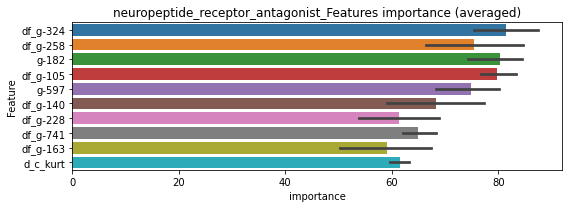

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217402	valid_1's binary_logloss: 0.0442615
[200]	training's binary_logloss: 0.00321855	valid_1's binary_logloss: 0.0208971
[300]	training's binary_logloss: 0.000872548	valid_1's binary_logloss: 0.0179006
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000913624	valid_1's binary_logloss: 0.0178472


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230739	valid_1's binary_logloss: 0.0396051
[200]	training's binary_logloss: 0.00361971	valid_1's binary_logloss: 0.0149082
[300]	training's binary_logloss: 0.000988025	valid_1's binary_logloss: 0.0121371
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000900191	valid_1's binary_logloss: 0.0120191


neuropeptide_receptor_antagonist logloss: 0.014933510967663285
nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3270
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535038	valid_1's binary_logloss: 0.120745
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0311789	valid_1's binary_logloss: 0.117476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043643	valid_1's binary_logloss: 0.151902


1 / 3 AUC score:0.934
y_Threshold: 0.0327964, Threshold: 0.9638585, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 406 → Positive_corect_labels: 735/3696
p_label_rate: 0.0200904 Vs.target_rate: 0.03494, Num_p_label: 80.0, conf_0:0.86747, conf_1:1.06024
threshold: 0.9638585, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.043643	valid_1's binary_logloss: 0.151902


positive_y_label: 735.0/3696, y_label_rate: 0.1988636
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193492	valid_1's binary_logloss: 0.0276846
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0030835	valid_1's binary_logloss: 0.0169164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196512	valid_1's binary_logloss: 0.0277587
[200]	training's binary_logloss: 0.00165923	valid_1's binary_logloss: 0.0147664
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0017363	valid_1's binary_logloss: 0.0147623


2 / 3 AUC score:0.998
y_Threshold: 0.1548055, Threshold: 0.9638585, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 16 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0364139 Vs.target_rate: 0.03494, Num_p_label: 145.0, conf_0:0.86747, conf_1:1.06024
threshold: 0.9638585, positive_p_label: 145.0/3982, p_label_rate: 0.0364139
positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161667	valid_1's binary_logloss: 0.0168846
[200]	training's binary_logloss: 0.001047	valid_1's binary_logloss: 0.00126548
[300]	training's binary_logloss: 0.000232336	valid_1's binary_logloss: 0.000323671
[400]	training's binary_logloss: 0.000153716	valid_1's binary_logloss: 0.000229977
[500]	training's binary_logloss: 0.000140008	valid_1's binary_logloss: 0.00021287
[600]	training's binary_logloss: 0.000136735	valid_1's binary_logloss: 0.00020873
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00013617	valid_1's binary_logloss: 0.000208087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161881	valid_1's binary_logloss: 0.0178791
[200]	training's binary_logloss: 0.00104508	valid_1's binary_logloss: 0.00293409
[300]	training's binary_logloss: 0.000231631	valid_1's binary_logloss: 0.00196137
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0678943, Threshold: 0.9638585, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 0 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0399297 Vs.target_rate: 0.03494, Num_p_label: 159.0, conf_0:0.86747, conf_1:1.06024
threshold: 0.9638585, positive_p_label: 159.0/3982, p_label_rate: 0.0399297
positive_y_label: 886.0/7662, y_label_rate: 0.1156356


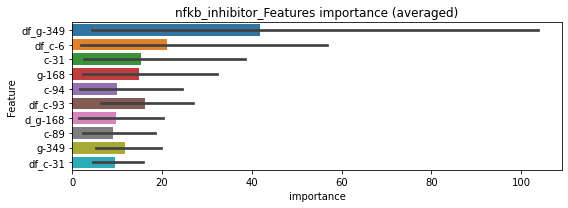

len(train_index) : 3831
len(valid_index) : 3831
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112082	valid_1's binary_logloss: 0.0130275
[200]	training's binary_logloss: 0.000865072	valid_1's binary_logloss: 0.00245457


len(train_index) : 3831
len(valid_index) : 3831


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000209285	valid_1's binary_logloss: 0.00182366


================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111187	valid_1's binary_logloss: 0.0132955
[200]	training's binary_logloss: 0.000781599	valid_1's binary_logloss: 0.00391961


nfkb_inhibitor logloss: 0.0027672009492450095


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000511472	valid_1's binary_logloss: 0.00371074


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189464	valid_1's binary_logloss: 0.0279929
[200]	training's binary_logloss: 0.00194061	valid_1's binary_logloss: 0.00643607
[300]	training's binary_logloss: 0.000548209	valid_1's binary_logloss: 0.00321939
[400]	training's binary_logloss: 0.00030647	valid_1's binary_logloss: 0.00238048
[500]	training's binary_logloss: 0.000269714	valid_1's binary_logloss: 0.00229434
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000269577	valid_1's binary_logloss: 0.0022941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189645	valid_1's binary_logloss: 0.0231341
[200]	training's binary_logloss: 0.00193467	valid_1's binary_logloss: 0.00399414
[300]	training's binary_logloss: 0.000551645	valid_1's binary_logloss: 0.00157905
[400]	training's binary_logloss: 0.000308584	valid_1's binary_logloss: 0.0010619
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0010414, Threshold: 0.0025141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00226, conf_1:0.00277
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0025141
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0125141
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0225141
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0325141
threshold: 0.0325141, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189396	valid_1's binary_logloss: 0.0268101
[200]	training's binary_logloss: 0.00187198	valid_1's binary_logloss: 0.00644707
[300]	training's binary_logloss: 0.000523813	valid_1's binary_logloss: 0.00343359
[400]	training's binary_logloss: 0.000297901	valid_1's binary_logloss: 0.00269025
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000267743	valid_1's binary_logloss: 0.00259515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189116	valid_1's binary_logloss: 0.0213227
[200]	training's binary_logloss: 0.00187486	valid_1's binary_logloss: 0.00293419
[300]	training's binary_logloss: 0.000531457	valid_1's binary_logloss: 0.00106492
[400]	training's binary_logloss: 0.000304231	valid_1's binary_logloss: 0.000725265


2 / 3 AUC score:1.000
y_Threshold: 0.0374402, Threshold: 0.0325141, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000267806	valid_1's binary_logloss: 0.000664681


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.02926, conf_1:0.03577
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.0325141
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0425141
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.0525141
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.0625141
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.0725141
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.0825141
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.0925141
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.1025141
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.1125141
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.1225141
threshold: 0.1325141, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189396	valid_1's binary_logloss: 0.0268101
[200]	training's binary_logloss: 0.00187198	valid_1's binary_logloss: 0.00644707
[300]	training's binary_logloss: 0.000523813	valid_1's binary_logloss: 0.00343359
[400]	training's binary_logloss: 0.000297901	valid_1's binary_logloss: 0.00269025
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000267743	valid_1's binary_logloss: 0.00259515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189116	valid_1's binary_logloss: 0.0213227
[200]	training's binary_logloss: 0.00187486	valid_1's binary_logloss: 0.00293419
[300]	training's binary_logloss: 0.000531457	valid_1's binary_logloss: 0.00106492
[400]	training's binary_logloss: 0.000304231	valid_1's binary_logloss: 0.000725265
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000267806	valid_1's binary_logloss: 0.0006

3 / 3 AUC score:1.000
y_Threshold: 0.0374402, Threshold: 0.1325141, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.11926, conf_1:0.14577
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.1325141
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.1425141
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.1525141
threshold: 0.1525141, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


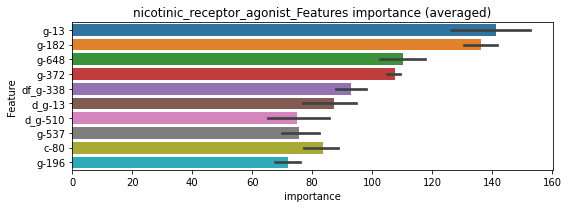

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00995764	valid_1's binary_logloss: 0.0159082
[200]	training's binary_logloss: 0.000969596	valid_1's binary_logloss: 0.00505774
[300]	training's binary_logloss: 0.000275079	valid_1's binary_logloss: 0.00404763
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000263824	valid_1's binary_logloss: 0.0040348


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101046	valid_1's binary_logloss: 0.0150942
[200]	training's binary_logloss: 0.00101718	valid_1's binary_logloss: 0.0056599
[300]	training's binary_logloss: 0.000282997	valid_1's binary_logloss: 0.00454737
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000300816	valid_1's binary_logloss: 0.00453863


nicotinic_receptor_agonist logloss: 0.004286713760134075
nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297115	valid_1's binary_logloss: 0.0471254
[200]	training's binary_logloss: 0.00408144	valid_1's binary_logloss: 0.0119211
[300]	training's binary_logloss: 0.0011664	valid_1's binary_logloss: 0.00610321
[400]	training's binary_logloss: 0.000593373	valid_1's binary_logloss: 0.0042732
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000452529	valid_1's binary_logloss: 0.0036621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310799	valid_1's binary_logloss: 0.0440348
[200]	training's binary_logloss: 0.00428407	valid_1's binary_logloss: 0.00989143
[300]	training's binary_logloss: 0.00120369	valid_1's binary_logloss: 0.00388223
[400]	training's binary_logloss: 0.000591968	valid_1's binary_logloss: 0.00241358
[500]	training's binary_logloss: 0.000413359	valid_1's binary_logloss: 0.00193697
[600]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0026179, Threshold: 0.0038409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00346, conf_1:0.00423
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0038409
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0138409
threshold: 0.0138409, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294133	valid_1's binary_logloss: 0.0450147
[200]	training's binary_logloss: 0.00403697	valid_1's binary_logloss: 0.0110124
[300]	training's binary_logloss: 0.00114219	valid_1's binary_logloss: 0.00427856
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000922787	valid_1's binary_logloss: 0.0039402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304424	valid_1's binary_logloss: 0.0416434
[200]	training's binary_logloss: 0.00409457	valid_1's binary_logloss: 0.00881046
[300]	training's binary_logloss: 0.00117082	valid_1's binary_logloss: 0.00374099
[400]	training's binary_logloss: 0.000585141	valid_1's binary_logloss: 0.00240871
[500]	training's binary_logloss: 0.000412925	valid_1's binary_logloss: 0.00198506
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000394632	valid_1's binary_logloss: 0.00194892


2 / 3 AUC score:1.000
y_Threshold: 0.0686164, Threshold: 0.0138409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0077850 Vs.target_rate: 0.00109, Num_p_label: 31.0, conf_0:0.01246, conf_1:0.01523
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_1: 0.0138409
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.0238409
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.0338409
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_4: 0.0438409
threshold: 0.0438409, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294133	valid_1's binary_logloss: 0.0450147
[200]	training's binary_logloss: 0.00403697	valid_1's binary_logloss: 0.0110124
[300]	training's binary_logloss: 0.00114219	valid_1's binary_logloss: 0.00427856
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000922787	valid_1's binary_logloss: 0.0039402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304424	valid_1's binary_logloss: 0.0416434
[200]	training's binary_logloss: 0.00409457	valid_1's binary_logloss: 0.00881046
[300]	training's binary_logloss: 0.00117082	valid_1's binary_logloss: 0.00374099
[400]	training's binary_logloss: 0.000585141	valid_1's binary_logloss: 0.00240871
[500]	training's binary_logloss: 0.000412925	valid_1's binary_logloss: 0.00198506
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000394632	valid_1's binary_logloss: 0.00194892


3 / 3 AUC score:1.000
y_Threshold: 0.0686164, Threshold: 0.0438409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.03946, conf_1:0.04823
threshold: 0.0438409, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


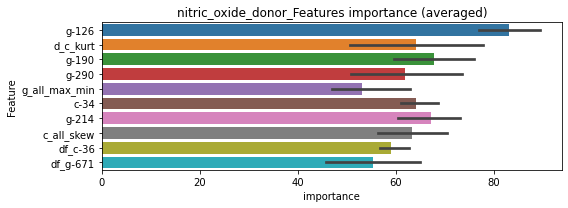

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159931	valid_1's binary_logloss: 0.0268726
[200]	training's binary_logloss: 0.00211306	valid_1's binary_logloss: 0.00960708
[300]	training's binary_logloss: 0.000591911	valid_1's binary_logloss: 0.00726713
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000461268	valid_1's binary_logloss: 0.00699869


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164965	valid_1's binary_logloss: 0.0302819
[200]	training's binary_logloss: 0.00222517	valid_1's binary_logloss: 0.0133587
[300]	training's binary_logloss: 0.000619302	valid_1's binary_logloss: 0.0104045
[400]	training's binary_logloss: 0.000305094	valid_1's binary_logloss: 0.00958626
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000288875	valid_1's binary_logloss: 0.00954776


nitric_oxide_donor logloss: 0.008273224043808461
nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350912	valid_1's binary_logloss: 0.0531241
[200]	training's binary_logloss: 0.00531252	valid_1's binary_logloss: 0.0145913
[300]	training's binary_logloss: 0.00145793	valid_1's binary_logloss: 0.006791
[400]	training's binary_logloss: 0.000710566	valid_1's binary_logloss: 0.00460794
[500]	training's binary_logloss: 0.000499585	valid_1's binary_logloss: 0.00392374
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000484296	valid_1's binary_logloss: 0.00388727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337519	valid_1's binary_logloss: 0.0523728
[200]	training's binary_logloss: 0.00500901	valid_1's binary_logloss: 0.0151133
[300]	training's binary_logloss: 0.00141755	valid_1's binary_logloss: 0.00780328
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000845075	valid_1's binary_logloss: 0.00587491


1 / 3 AUC score:1.000
y_Threshold: 0.0030862, Threshold: 0.1081935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122, Num_p_label: 80.0, conf_0:0.09737, conf_1:0.11901
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.1081935
Num_p_label: 75.0, Expected: 4.8, Adj_threshold_2: 0.1181935
Num_p_label: 72.0, Expected: 4.8, Adj_threshold_3: 0.1281935
Num_p_label: 72.0, Expected: 4.8, Adj_threshold_4: 0.1381935
Num_p_label: 70.0, Expected: 4.8, Adj_threshold_5: 0.1481935
Num_p_label: 66.0, Expected: 4.8, Adj_threshold_6: 0.1581935
Num_p_label: 60.0, Expected: 4.8, Adj_threshold_7: 0.1681935
Num_p_label: 53.0, Expected: 4.8, Adj_threshold_8: 0.1781935
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_9: 0.1881935
Num_p_label: 49.0, Expected: 4.8, Adj_threshold_10: 0.1981935
threshold: 0.2081935, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328487	valid_1's binary_logloss: 0.0481718
[200]	training's binary_logloss: 0.00480111	valid_1's binary_logloss: 0.0122958
[300]	training's binary_logloss: 0.00133656	valid_1's binary_logloss: 0.00590106
[400]	training's binary_logloss: 0.000667449	valid_1's binary_logloss: 0.00401524
[500]	training's binary_logloss: 0.000470081	valid_1's binary_logloss: 0.00340128
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000455266	valid_1's binary_logloss: 0.00336055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335846	valid_1's binary_logloss: 0.052261
[200]	training's binary_logloss: 0.00478396	valid_1's binary_logloss: 0.0121404
[300]	training's binary_logloss: 0.00132935	valid_1's binary_logloss: 0.00498319
[400]	training's binary_logloss: 0.000660044	valid_1's binary_logloss: 0.00308284
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.2001285, Threshold: 0.2081935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0334003 Vs.target_rate: 0.00122, Num_p_label: 133.0, conf_0:0.18737, conf_1:0.22901
Num_p_label: 133.0, Expected: 4.8, Adj_threshold_1: 0.2081935
Num_p_label: 133.0, Expected: 4.8, Adj_threshold_2: 0.2181935
Num_p_label: 132.0, Expected: 4.8, Adj_threshold_3: 0.2281935
Num_p_label: 131.0, Expected: 4.8, Adj_threshold_4: 0.2381935
Num_p_label: 126.0, Expected: 4.8, Adj_threshold_5: 0.2481935
Num_p_label: 124.0, Expected: 4.8, Adj_threshold_6: 0.2581935
Num_p_label: 123.0, Expected: 4.8, Adj_threshold_7: 0.2681935
Num_p_label: 122.0, Expected: 4.8, Adj_threshold_8: 0.2781935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_9: 0.2881935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_10: 0.2981935
threshold: 0.3081935, positive_p_label: 119.0/3982, p_label_rate: 0.0298845
positive_y_label: 656.0/3808, y_label_rate: 0.1722

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328487	valid_1's binary_logloss: 0.0481718
[200]	training's binary_logloss: 0.00480111	valid_1's binary_logloss: 0.0122958
[300]	training's binary_logloss: 0.00133656	valid_1's binary_logloss: 0.00590106
[400]	training's binary_logloss: 0.000667449	valid_1's binary_logloss: 0.00401524
[500]	training's binary_logloss: 0.000470081	valid_1's binary_logloss: 0.00340128
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000455266	valid_1's binary_logloss: 0.00336055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335846	valid_1's binary_logloss: 0.052261
[200]	training's binary_logloss: 0.00478396	valid_1's binary_logloss: 0.0121404
[300]	training's binary_logloss: 0.00132935	valid_1's binary_logloss: 0.00498319
[400]	training's binary_logloss: 0.000660044	valid_1's binary_logloss: 0.00308284
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.2001285, Threshold: 0.3081935, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0298845 Vs.target_rate: 0.00122, Num_p_label: 119.0, conf_0:0.27737, conf_1:0.33901
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_1: 0.3081935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_2: 0.3181935
Num_p_label: 119.0, Expected: 4.8, Adj_threshold_3: 0.3281935
Num_p_label: 117.0, Expected: 4.8, Adj_threshold_4: 0.3381935
Num_p_label: 115.0, Expected: 4.8, Adj_threshold_5: 0.3481935
Num_p_label: 113.0, Expected: 4.8, Adj_threshold_6: 0.3581935
Num_p_label: 113.0, Expected: 4.8, Adj_threshold_7: 0.3681935
Num_p_label: 112.0, Expected: 4.8, Adj_threshold_8: 0.3781935
Num_p_label: 111.0, Expected: 4.8, Adj_threshold_9: 0.3881935
Num_p_label: 111.0, Expected: 4.8, Adj_threshold_10: 0.3981935
threshold: 0.4081935, positive_p_label: 111.0/3982, p_label_rate: 0.0278754
positive_y_label: 767.0/7790, y_label_rate: 0.0984

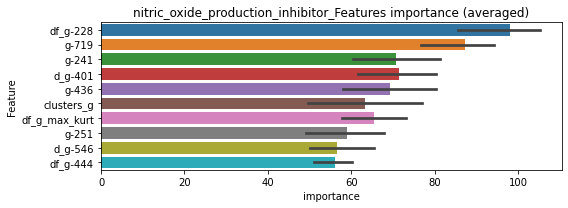

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213686	valid_1's binary_logloss: 0.0355662
[200]	training's binary_logloss: 0.0031941	valid_1's binary_logloss: 0.0146434
[300]	training's binary_logloss: 0.000856757	valid_1's binary_logloss: 0.0112825
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00074317	valid_1's binary_logloss: 0.0110549


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222578	valid_1's binary_logloss: 0.0317838
[200]	training's binary_logloss: 0.0035363	valid_1's binary_logloss: 0.00976388
[300]	training's binary_logloss: 0.00101013	valid_1's binary_logloss: 0.00621035
[400]	training's binary_logloss: 0.000477089	valid_1's binary_logloss: 0.00540419
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000459364	valid_1's binary_logloss: 0.00535676


nitric_oxide_production_inhibitor logloss: 0.00820581434671972
nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333722	valid_1's binary_logloss: 0.053304
[200]	training's binary_logloss: 0.0046818	valid_1's binary_logloss: 0.0149617
[300]	training's binary_logloss: 0.00129007	valid_1's binary_logloss: 0.00808727
[400]	training's binary_logloss: 0.000639271	valid_1's binary_logloss: 0.0058637
[500]	training's binary_logloss: 0.000445973	valid_1's binary_logloss: 0.00492523
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000423847	valid_1's binary_logloss: 0.00481281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334221	valid_1's binary_logloss: 0.0494442
[200]	training's binary_logloss: 0.00461468	valid_1's binary_logloss: 0.0115004
[300]	training's binary_logloss: 0.00127518	valid_1's binary_logloss: 0.00475844
[400]	training's binary_logloss: 0.000640961	valid_1's binary_logloss: 0.00330186
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0024745, Threshold: 0.0037580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00338, conf_1:0.00413
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0037580
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_2: 0.0137580
threshold: 0.0137580, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328946	valid_1's binary_logloss: 0.0513701
[200]	training's binary_logloss: 0.00446145	valid_1's binary_logloss: 0.0141843
[300]	training's binary_logloss: 0.00124324	valid_1's binary_logloss: 0.00780622
[400]	training's binary_logloss: 0.000623929	valid_1's binary_logloss: 0.00580839
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000475078	valid_1's binary_logloss: 0.00537248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033456	valid_1's binary_logloss: 0.0474006
[200]	training's binary_logloss: 0.00460039	valid_1's binary_logloss: 0.00997855
[300]	training's binary_logloss: 0.00126379	valid_1's binary_logloss: 0.0040882
[400]	training's binary_logloss: 0.000632628	valid_1's binary_logloss: 0.0027148
[500]	training's binary_logloss: 0.000446617	valid_1's binary_logloss: 0.00226049
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0286674, Threshold: 0.0137580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0075339 Vs.target_rate: 0.00109, Num_p_label: 30.0, conf_0:0.01238, conf_1:0.01513
Num_p_label: 30.0, Expected: 4.3, Adj_threshold_1: 0.0137580
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_2: 0.0237580
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.0337580
threshold: 0.0337580, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328946	valid_1's binary_logloss: 0.0513701
[200]	training's binary_logloss: 0.00446145	valid_1's binary_logloss: 0.0141843
[300]	training's binary_logloss: 0.00124324	valid_1's binary_logloss: 0.00780622
[400]	training's binary_logloss: 0.000623929	valid_1's binary_logloss: 0.00580839
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000475078	valid_1's binary_logloss: 0.00537248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033456	valid_1's binary_logloss: 0.0474006
[200]	training's binary_logloss: 0.00460039	valid_1's binary_logloss: 0.00997855
[300]	training's binary_logloss: 0.00126379	valid_1's binary_logloss: 0.0040882
[400]	training's binary_logloss: 0.000632628	valid_1's binary_logloss: 0.0027148
[500]	training's binary_logloss: 0.000446617	valid_1's binary_logloss: 0.00226049
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0286674, Threshold: 0.0337580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00109, Num_p_label: 5.0, conf_0:0.03038, conf_1:0.03713
threshold: 0.0337580, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


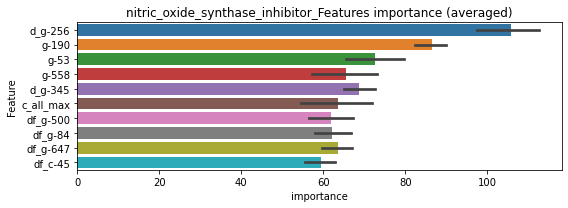

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175898	valid_1's binary_logloss: 0.0285876
[200]	training's binary_logloss: 0.00244779	valid_1's binary_logloss: 0.00990397
[300]	training's binary_logloss: 0.000652616	valid_1's binary_logloss: 0.00701054
[400]	training's binary_logloss: 0.0003247	valid_1's binary_logloss: 0.00665392
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000341781	valid_1's binary_logloss: 0.00661317


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186364	valid_1's binary_logloss: 0.026708
[200]	training's binary_logloss: 0.00267782	valid_1's binary_logloss: 0.0073128
[300]	training's binary_logloss: 0.00070772	valid_1's binary_logloss: 0.00393446
[400]	training's binary_logloss: 0.000337813	valid_1's binary_logloss: 0.00320679
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000279273	valid_1's binary_logloss: 0.00307648


nitric_oxide_synthase_inhibitor logloss: 0.004844822806633585
norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164751	valid_1's binary_logloss: 0.0182365
[200]	training's binary_logloss: 0.00147756	valid_1's binary_logloss: 0.00196038
[300]	training's binary_logloss: 0.00041366	valid_1's binary_logloss: 0.00059641
[400]	training's binary_logloss: 0.000246652	valid_1's binary_logloss: 0.000369719
[500]	training's binary_logloss: 0.000227621	valid_1's binary_logloss: 0.000341964
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000227621	valid_1's binary_logloss: 0.000341964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165123	valid_1's binary_logloss: 0.0184172
[200]	training's binary_logloss: 0.00148536	valid_1's binary_logloss: 0.00215639
[300]	training's binary_logloss: 0.000414835	valid_1's binary_logloss: 0.000727077
[400]	training's binary_logloss: 0.000247088	valid_1's binary_logloss: 0.000471202


1 / 3 AUC score:1.000
y_Threshold: 0.0006471, Threshold: 0.0009846, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000225324	valid_1's binary_logloss: 0.000435501


Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00089, conf_1:0.00108
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009846
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_2: 0.0109846
threshold: 0.0109846, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168869	valid_1's binary_logloss: 0.0187627
[200]	training's binary_logloss: 0.00147636	valid_1's binary_logloss: 0.002479
[300]	training's binary_logloss: 0.000408053	valid_1's binary_logloss: 0.00114044
[400]	training's binary_logloss: 0.000243972	valid_1's binary_logloss: 0.000857002
[500]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168254	valid_1's binary_logloss: 0.018696
[200]	training's binary_logloss: 0.00147666	valid_1's binary_logloss: 0.00248013
[300]	training's binary_logloss: 0.000406228	valid_1's binary_logloss: 0.00091563
[400]	training's binary_logloss: 0.000245971	valid_1's binary_logloss: 0.000636379
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0719063, Threshold: 0.0109846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00029, Num_p_label: 20.0, conf_0:0.00989, conf_1:0.01208
Num_p_label: 20.0, Expected: 1.2, Adj_threshold_1: 0.0109846
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0209846
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0309846
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.0409846
threshold: 0.0409846, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168869	valid_1's binary_logloss: 0.0187627
[200]	training's binary_logloss: 0.00147636	valid_1's binary_logloss: 0.002479
[300]	training's binary_logloss: 0.000408053	valid_1's binary_logloss: 0.00114044
[400]	training's binary_logloss: 0.000243972	valid_1's binary_logloss: 0.000857002
[500]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000220222	valid_1's binary_logloss: 0.000817833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168254	valid_1's binary_logloss: 0.018696
[200]	training's binary_logloss: 0.00147666	valid_1's binary_logloss: 0.00248013
[300]	training's binary_logloss: 0.000406228	valid_1's binary_logloss: 0.00091563
[400]	training's binary_logloss: 0.000245971	valid_1's binary_logloss: 0.000636379
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0719063, Threshold: 0.0409846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.03689, conf_1:0.04508
threshold: 0.0409846, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


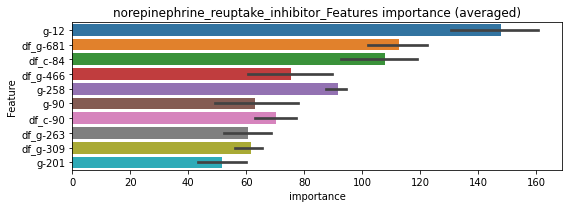

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00872152	valid_1's binary_logloss: 0.0106984
[200]	training's binary_logloss: 0.000745281	valid_1's binary_logloss: 0.00257423
[300]	training's binary_logloss: 0.000202313	valid_1's binary_logloss: 0.00202561
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000188933	valid_1's binary_logloss: 0.0020142


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00877845	valid_1's binary_logloss: 0.0100963
[200]	training's binary_logloss: 0.000756288	valid_1's binary_logloss: 0.00179675
[300]	training's binary_logloss: 0.000206042	valid_1's binary_logloss: 0.00081375
[400]	training's binary_logloss: 0.000122765	valid_1's binary_logloss: 0.000651907
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000112128	valid_1's binary_logloss: 0.000627008


norepinephrine_reuptake_inhibitor logloss: 0.0013206017202947416
nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206794	valid_1's binary_logloss: 0.0261648
[200]	training's binary_logloss: 0.00221586	valid_1's binary_logloss: 0.00550121
[300]	training's binary_logloss: 0.000633847	valid_1's binary_logloss: 0.00354012
[400]	training's binary_logloss: 0.000353491	valid_1's binary_logloss: 0.00295929
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000289502	valid_1's binary_logloss: 0.00273381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206248	valid_1's binary_logloss: 0.0244317
[200]	training's binary_logloss: 0.00221634	valid_1's binary_logloss: 0.00458839
[300]	training's binary_logloss: 0.00062931	valid_1's binary_logloss: 0.0030535
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000424024	valid_1's binary_logloss: 0.00277668


1 / 3 AUC score:1.000
y_Threshold: 0.0010687, Threshold: 0.0647032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.05823, conf_1:0.07117
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0647032
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_2: 0.0747032
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_3: 0.0847032
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_4: 0.0947032
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_5: 0.1047032
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_6: 0.1147032
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_7: 0.1247032
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_8: 0.1347032
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_9: 0.1447032
Num_p_label: 69.0, Expected: 3.0, Adj_threshold_10: 0.1547032
threshold: 0.1647032, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199127	valid_1's binary_logloss: 0.0234347
[200]	training's binary_logloss: 0.00195137	valid_1's binary_logloss: 0.00283079
[300]	training's binary_logloss: 0.000543392	valid_1's binary_logloss: 0.000933264
[400]	training's binary_logloss: 0.00030526	valid_1's binary_logloss: 0.000561026
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000281584	valid_1's binary_logloss: 0.000525624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200098	valid_1's binary_logloss: 0.0228225
[200]	training's binary_logloss: 0.00197362	valid_1's binary_logloss: 0.0026802
[300]	training's binary_logloss: 0.000554671	valid_1's binary_logloss: 0.000948722
[400]	training's binary_logloss: 0.00031014	valid_1's binary_logloss: 0.000611689
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000278163	valid_1's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.1582248, Threshold: 0.1647032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0261175 Vs.target_rate: 0.00076, Num_p_label: 104.0, conf_0:0.14823, conf_1:0.18117
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_1: 0.1647032
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_2: 0.1747032
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_3: 0.1847032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_4: 0.1947032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_5: 0.2047032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_6: 0.2147032
Num_p_label: 99.0, Expected: 3.0, Adj_threshold_7: 0.2247032
Num_p_label: 98.0, Expected: 3.0, Adj_threshold_8: 0.2347032
Num_p_label: 95.0, Expected: 3.0, Adj_threshold_9: 0.2447032
Num_p_label: 94.0, Expected: 3.0, Adj_threshold_10: 0.2547032
threshold: 0.2647032, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199127	valid_1's binary_logloss: 0.0234347
[200]	training's binary_logloss: 0.00195137	valid_1's binary_logloss: 0.00283079
[300]	training's binary_logloss: 0.000543392	valid_1's binary_logloss: 0.000933264
[400]	training's binary_logloss: 0.00030526	valid_1's binary_logloss: 0.000561026
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000281584	valid_1's binary_logloss: 0.000525624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200098	valid_1's binary_logloss: 0.0228225
[200]	training's binary_logloss: 0.00197362	valid_1's binary_logloss: 0.0026802
[300]	training's binary_logloss: 0.000554671	valid_1's binary_logloss: 0.000948722
[400]	training's binary_logloss: 0.00031014	valid_1's binary_logloss: 0.000611689
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000278163	valid_1's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.1582248, Threshold: 0.2647032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0233551 Vs.target_rate: 0.00076, Num_p_label: 93.0, conf_0:0.23823, conf_1:0.29117
Num_p_label: 93.0, Expected: 3.0, Adj_threshold_1: 0.2647032
Num_p_label: 92.0, Expected: 3.0, Adj_threshold_2: 0.2747032
Num_p_label: 92.0, Expected: 3.0, Adj_threshold_3: 0.2847032
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_4: 0.2947032
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_5: 0.3047032
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_6: 0.3147032
Num_p_label: 89.0, Expected: 3.0, Adj_threshold_7: 0.3247032
Num_p_label: 88.0, Expected: 3.0, Adj_threshold_8: 0.3347032
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_9: 0.3447032
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_10: 0.3547032
threshold: 0.3647032, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 743.0/7793, y_label_rate: 0.0953420


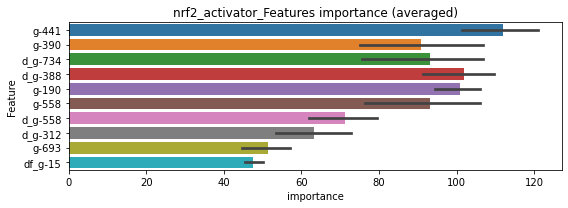

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125493	valid_1's binary_logloss: 0.019516
[200]	training's binary_logloss: 0.00141609	valid_1's binary_logloss: 0.00686846
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00067147	valid_1's binary_logloss: 0.0062548


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128915	valid_1's binary_logloss: 0.0197126
[200]	training's binary_logloss: 0.00143663	valid_1's binary_logloss: 0.00599607
[300]	training's binary_logloss: 0.000404886	valid_1's binary_logloss: 0.00437218
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000340382	valid_1's binary_logloss: 0.00425838


nrf2_activator logloss: 0.005256718595280039


neg labels: 3289 → selected neg labels: 3279


opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903553	valid_1's binary_logloss: 0.132923
[200]	training's binary_logloss: 0.0340103	valid_1's binary_logloss: 0.093717
[300]	training's binary_logloss: 0.0146398	valid_1's binary_logloss: 0.0819098
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0114522	valid_1's binary_logloss: 0.079979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949518	valid_1's binary_logloss: 0.124007
[200]	training's binary_logloss: 0.0396624	valid_1's binary_logloss: 0.0832115
[300]	training's binary_logloss: 0.0169428	valid_1's binary_logloss: 0.0683383
[400]	training's binary_logloss: 0.00853649	valid_1's binary_logloss: 0.0643592


1 / 3 AUC score:0.991
y_Threshold: 0.0587766, Threshold: 0.1743314, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00663284	valid_1's binary_logloss: 0.0629133


Remove_noisy_labels: 188 → Positive_corect_labels: 627/3746
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.15690, conf_1:0.19176
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.1743314
Num_p_label: 76.0, Expected: 10.2, Adj_threshold_2: 0.1843314
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_3: 0.1943314
Num_p_label: 57.0, Expected: 10.2, Adj_threshold_4: 0.2043314
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_5: 0.2143314
Num_p_label: 51.0, Expected: 10.2, Adj_threshold_6: 0.2243314
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_7: 0.2343314
Num_p_label: 44.0, Expected: 10.2, Adj_threshold_8: 0.2443314
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_9: 0.2543314
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_10: 0.2643314
threshold: 0.2743314, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 627.0/3746, y_label_rate: 0.1673785
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743776	valid_1's binary_logloss: 0.103202
[200]	training's binary_logloss: 0.0231753	valid_1's binary_logloss: 0.0553009
[300]	training's binary_logloss: 0.00918909	valid_1's binary_logloss: 0.0407057
[400]	training's binary_logloss: 0.00448242	valid_1's binary_logloss: 0.0363168
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00315197	valid_1's binary_logloss: 0.0348886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073542	valid_1's binary_logloss: 0.0978227
[200]	training's binary_logloss: 0.0214919	valid_1's binary_logloss: 0.0490339
[300]	training's binary_logloss: 0.00794849	valid_1's binary_logloss: 0.035205


2 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.0039309	valid_1's binary_logloss: 0.0299773
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00330765	valid_1's binary_logloss: 0.0293401


y_Threshold: 0.1089178, Threshold: 0.2743314, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 611.0/3714
p_label_rate: 0.0215972 Vs.target_rate: 0.00256, Num_p_label: 86.0, conf_0:0.24690, conf_1:0.30176
Num_p_label: 86.0, Expected: 10.2, Adj_threshold_1: 0.2743314
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_2: 0.2843314
Num_p_label: 78.0, Expected: 10.2, Adj_threshold_3: 0.2943314
Num_p_label: 78.0, Expected: 10.2, Adj_threshold_4: 0.3043314
Num_p_label: 76.0, Expected: 10.2, Adj_threshold_5: 0.3143314
Num_p_label: 73.0, Expected: 10.2, Adj_threshold_6: 0.3243314
Num_p_label: 69.0, Expected: 10.2, Adj_threshold_7: 0.3343314
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_8: 0.3443314
Num_p_label: 66.0, Expected: 10.2, Adj_threshold_9: 0.3543314
Num_p_label: 62.0, Expected: 10.2, Adj_threshold_10: 0.3643314
threshold: 0.3743314, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 611.0/3714, y_label_rate: 0.1645127
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637543	valid_1's binary_logloss: 0.0911944
[200]	training's binary_logloss: 0.0178681	valid_1's binary_logloss: 0.0468048
[300]	training's binary_logloss: 0.00667569	valid_1's binary_logloss: 0.0337445
[400]	training's binary_logloss: 0.00332335	valid_1's binary_logloss: 0.0311789
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00338042	valid_1's binary_logloss: 0.0310763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648424	valid_1's binary_logloss: 0.0883306
[200]	training's binary_logloss: 0.0188477	valid_1's binary_logloss: 0.0427446
[300]	training's binary_logloss: 0.00704175	valid_1's binary_logloss: 0.0283759
[400]	training's binary_logloss: 0.00352793	valid_1's binary_logloss: 0.0235597
[500]	training's binary_logloss: 0.00228656	valid_1's binary_logloss: 0.0216234
Early stopping, best iteration is:
[510]	traini

3 / 3 AUC score:0.999
y_Threshold: 0.1274195, Threshold: 0.3743314, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 601.0/3694
p_label_rate: 0.0145655 Vs.target_rate: 0.00256, Num_p_label: 58.0, conf_0:0.33690, conf_1:0.41176
Num_p_label: 58.0, Expected: 10.2, Adj_threshold_1: 0.3743314
Num_p_label: 56.0, Expected: 10.2, Adj_threshold_2: 0.3843314
Num_p_label: 55.0, Expected: 10.2, Adj_threshold_3: 0.3943314
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_4: 0.4043314
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_5: 0.4143314
Num_p_label: 50.0, Expected: 10.2, Adj_threshold_6: 0.4243314
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_7: 0.4343314
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_8: 0.4443314
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_9: 0.4543314
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_10: 0.4643314
threshold: 0.4743314, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 645.0/7676, y_label_rate: 0.08402

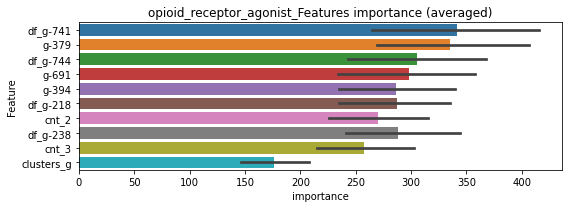

len(train_index) : 3838
len(valid_index) : 3838
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434963	valid_1's binary_logloss: 0.0571976
[200]	training's binary_logloss: 0.0144086	valid_1's binary_logloss: 0.0296479
[300]	training's binary_logloss: 0.0057382	valid_1's binary_logloss: 0.0204858


len(train_index) : 3838
len(valid_index) : 3838
================================= fold 2/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00313834	valid_1's binary_logloss: 0.0174463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429538	valid_1's binary_logloss: 0.0630223
[200]	training's binary_logloss: 0.0136812	valid_1's binary_logloss: 0.0364297
[300]	training's binary_logloss: 0.0056871	valid_1's binary_logloss: 0.0298013
[400]	training's binary_logloss: 0.00275168	valid_1's binary_logloss: 0.0271324
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00255311	valid_1's binary_logloss: 0.0267449


opioid_receptor_agonist logloss: 0.022095629500760192
opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656


neg labels: 3289 → selected neg labels: 3275


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110958	valid_1's binary_logloss: 0.182498
[200]	training's binary_logloss: 0.0527049	valid_1's binary_logloss: 0.149525
[300]	training's binary_logloss: 0.0271341	valid_1's binary_logloss: 0.1384
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0228711	valid_1's binary_logloss: 0.136884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120337	valid_1's binary_logloss: 0.176988
[200]	training's binary_logloss: 0.0592452	valid_1's binary_logloss: 0.133222
[300]	training's binary_logloss: 0.0308757	valid_1's binary_logloss: 0.1216


1 / 3 AUC score:0.970
y_Threshold: 0.1212777, Threshold: 0.2973284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 259 → Positive_corect_labels: 591/3671
p_label_rate: 0.0200904 Vs.target_rate: 0.00403, Num_p_label: 80.0, conf_0:0.26760, conf_1:0.32706
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.2973284
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_2: 0.3073284
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_3: 0.3173284
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_4: 0.3273284
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_5: 0.3373284


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.020653	valid_1's binary_logloss: 0.118087


Num_p_label: 57.0, Expected: 16.1, Adj_threshold_6: 0.3473284
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_7: 0.3573284
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_8: 0.3673284
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_9: 0.3773284
Num_p_label: 44.0, Expected: 16.1, Adj_threshold_10: 0.3873284
threshold: 0.3973284, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 591.0/3671, y_label_rate: 0.1609916
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077381	valid_1's binary_logloss: 0.126512
[200]	training's binary_logloss: 0.0278002	valid_1's binary_logloss: 0.0877965
[300]	training's binary_logloss: 0.0117629	valid_1's binary_logloss: 0.0761919
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00820117	valid_1's binary_logloss: 0.0737916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077507	valid_1's binary_logloss: 0.126272
[200]	training's binary_logloss: 0.0284692	valid_1's binary_logloss: 0.0868493
[300]	training's binary_logloss: 0.0120647	valid_1's binary_logloss: 0.0731369
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00712088	valid_1's binary_logloss: 0.0686781


2 / 3 AUC score:0.993
y_Threshold: 0.1884321, Threshold: 0.3973284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 549.0/3587
p_label_rate: 0.0236062 Vs.target_rate: 0.00403, Num_p_label: 94.0, conf_0:0.35760, conf_1:0.43706
Num_p_label: 94.0, Expected: 16.1, Adj_threshold_1: 0.3973284
Num_p_label: 92.0, Expected: 16.1, Adj_threshold_2: 0.4073284
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_3: 0.4173284
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_4: 0.4273284
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_5: 0.4373284
Num_p_label: 79.0, Expected: 16.1, Adj_threshold_6: 0.4473284
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_7: 0.4573284
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_8: 0.4673284
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_9: 0.4773284
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_10: 0.4873284
threshold: 0.4973284, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 549.0/3587, y_label_rate: 0.15305

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632237	valid_1's binary_logloss: 0.0964262
[200]	training's binary_logloss: 0.0196494	valid_1's binary_logloss: 0.0537565
[300]	training's binary_logloss: 0.0084196	valid_1's binary_logloss: 0.0407014
[400]	training's binary_logloss: 0.0044751	valid_1's binary_logloss: 0.0360089
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0036718	valid_1's binary_logloss: 0.0349454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592821	valid_1's binary_logloss: 0.111069


3 / 3 AUC score:0.998
y_Threshold: 0.1758851, Threshold: 0.4973284, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.017653	valid_1's binary_logloss: 0.0721719
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0104281	valid_1's binary_logloss: 0.0637465


Remove_noisy_labels: 48 → Positive_corect_labels: 525.0/3539
p_label_rate: 0.0175791 Vs.target_rate: 0.00403, Num_p_label: 70.0, conf_0:0.44760, conf_1:0.54706
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_1: 0.4973284
Num_p_label: 69.0, Expected: 16.1, Adj_threshold_2: 0.5073284
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_3: 0.5173284
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_4: 0.5273284
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_5: 0.5373284
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_6: 0.5473284
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_7: 0.5573284
Num_p_label: 58.0, Expected: 16.1, Adj_threshold_8: 0.5673284
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_9: 0.5773284
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_10: 0.5873284
threshold: 0.5973284, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 578.0/7521, y_label_rate: 0.0768515


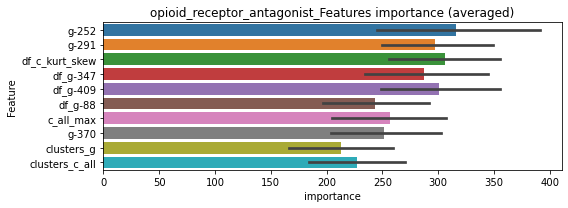

len(train_index) : 3760
len(valid_index) : 3761
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385227	valid_1's binary_logloss: 0.0667078
[200]	training's binary_logloss: 0.0127066	valid_1's binary_logloss: 0.0426369
[300]	training's binary_logloss: 0.00518356	valid_1's binary_logloss: 0.0348111
[400]	training's binary_logloss: 0.00271094	valid_1's binary_logloss: 0.0316777
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00180111	valid_1's binary_logloss: 0.029639


len(train_index) : 3761
len(valid_index) : 3760
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395781	valid_1's binary_logloss: 0.0602323
[200]	training's binary_logloss: 0.0128176	valid_1's binary_logloss: 0.0369822
[300]	training's binary_logloss: 0.00559717	valid_1's binary_logloss: 0.0296632
[400]	training's binary_logloss: 0.00296295	valid_1's binary_logloss: 0.0277219
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00241195	valid_1's binary_logloss: 0.026528


opioid_receptor_antagonist logloss: 0.028083710673301336
orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038749	valid_1's binary_logloss: 0.0608894
[200]	training's binary_logloss: 0.00612608	valid_1's binary_logloss: 0.020264
[300]	training's binary_logloss: 0.00173301	valid_1's binary_logloss: 0.0120931
[400]	training's binary_logloss: 0.000827238	valid_1's binary_logloss: 0.0099258
[500]	training's binary_logloss: 0.000538641	valid_1's binary_logloss: 0.00886822
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000480287	valid_1's binary_logloss: 0.00870893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038481	valid_1's binary_logloss: 0.0595884
[200]	training's binary_logloss: 0.00645931	valid_1's binary_logloss: 0.0165986
[300]	training's binary_logloss: 0.00179319	valid_1's binary_logloss: 0.00770158
[400]	training's binary_logloss: 0.00085849	valid_1's binary_logloss: 0.00530427
[500]	training's binary_logloss: 0.000556

1 / 3 AUC score:1.000
y_Threshold: 0.0037090, Threshold: 0.0046087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00415, conf_1:0.00507
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0046087
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_2: 0.0146087
threshold: 0.0146087, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373308	valid_1's binary_logloss: 0.0577237
[200]	training's binary_logloss: 0.00586169	valid_1's binary_logloss: 0.017851
[300]	training's binary_logloss: 0.00163767	valid_1's binary_logloss: 0.00991617
[400]	training's binary_logloss: 0.00079602	valid_1's binary_logloss: 0.00790548
[500]	training's binary_logloss: 0.000524928	valid_1's binary_logloss: 0.00696647
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000499248	valid_1's binary_logloss: 0.00690102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380621	valid_1's binary_logloss: 0.0597245
[200]	training's binary_logloss: 0.00633944	valid_1's binary_logloss: 0.0161869
[300]	training's binary_logloss: 0.00175742	valid_1's binary_logloss: 0.00738037
[400]	training's binary_logloss: 0.000846002	valid_1's binary_logloss: 0.00506082
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0718204, Threshold: 0.0146087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0080362 Vs.target_rate: 0.00155, Num_p_label: 32.0, conf_0:0.01315, conf_1:0.01607
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_1: 0.0146087
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.0246087
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_3: 0.0346087
threshold: 0.0346087, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369526	valid_1's binary_logloss: 0.0548181
[200]	training's binary_logloss: 0.00592634	valid_1's binary_logloss: 0.0158784
[300]	training's binary_logloss: 0.00166126	valid_1's binary_logloss: 0.00826837
[400]	training's binary_logloss: 0.000816816	valid_1's binary_logloss: 0.00631072
[500]	training's binary_logloss: 0.000535914	valid_1's binary_logloss: 0.00540733
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000481859	valid_1's binary_logloss: 0.00518134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383436	valid_1's binary_logloss: 0.059686
[200]	training's binary_logloss: 0.00620797	valid_1's binary_logloss: 0.0154427
[300]	training's binary_logloss: 0.00171089	valid_1's binary_logloss: 0.00716936
[400]	training's binary_logloss: 0.000820682	valid_1's binary_logloss: 0.00491404
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0496475, Threshold: 0.0346087, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0010045 Vs.target_rate: 0.00155, Num_p_label: 4.0, conf_0:0.03115, conf_1:0.03807
threshold: 0.0346087, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7787, y_label_rate: 0.0846282


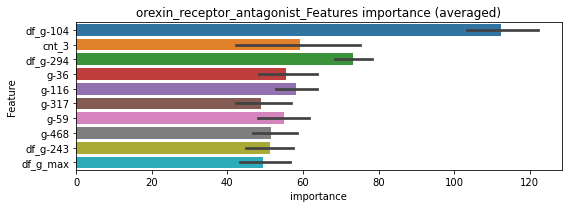

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205348	valid_1's binary_logloss: 0.0359341
[200]	training's binary_logloss: 0.00323629	valid_1's binary_logloss: 0.0149132
[300]	training's binary_logloss: 0.000878271	valid_1's binary_logloss: 0.0109235
[400]	training's binary_logloss: 0.000412572	valid_1's binary_logloss: 0.0100515
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000357681	valid_1's binary_logloss: 0.00998657


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198427	valid_1's binary_logloss: 0.0342932
[200]	training's binary_logloss: 0.00307741	valid_1's binary_logloss: 0.012717
[300]	training's binary_logloss: 0.000849211	valid_1's binary_logloss: 0.00802153
[400]	training's binary_logloss: 0.000410297	valid_1's binary_logloss: 0.00672635
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000361304	valid_1's binary_logloss: 0.006683


orexin_receptor_antagonist logloss: 0.008334999692916444
p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356866	valid_1's binary_logloss: 0.0669351
[200]	training's binary_logloss: 0.00570356	valid_1's binary_logloss: 0.0222973
[300]	training's binary_logloss: 0.00169928	valid_1's binary_logloss: 0.012743
[400]	training's binary_logloss: 0.000829831	valid_1's binary_logloss: 0.00985465
[500]	training's binary_logloss: 0.000547816	valid_1's binary_logloss: 0.00861433
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000464001	valid_1's binary_logloss: 0.00820498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336946	valid_1's binary_logloss: 0.0773388
[200]	training's binary_logloss: 0.00526824	valid_1's binary_logloss: 0.0429183


1 / 3 AUC score:0.998


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00190452	valid_1's binary_logloss: 0.0380727


y_Threshold: 0.0081050, Threshold: 0.0167410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00260, Num_p_label: 80.0, conf_0:0.01507, conf_1:0.01842
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0167410
Num_p_label: 47.0, Expected: 10.4, Adj_threshold_2: 0.0267410
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_3: 0.0367410
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_4: 0.0467410
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_5: 0.0567410
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_6: 0.0667410
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_7: 0.0767410
threshold: 0.0767410, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338436	valid_1's binary_logloss: 0.06273
[200]	training's binary_logloss: 0.00522252	valid_1's binary_logloss: 0.0202842
[300]	training's binary_logloss: 0.00153986	valid_1's binary_logloss: 0.0105825
[400]	training's binary_logloss: 0.000757448	valid_1's binary_logloss: 0.00759446
[500]	training's binary_logloss: 0.000500408	valid_1's binary_logloss: 0.00638582
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00043953	valid_1's binary_logloss: 0.00607493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339708	valid_1's binary_logloss: 0.0550869
[200]	training's binary_logloss: 0.00512879	valid_1's binary_logloss: 0.0159857
[300]	training's binary_logloss: 0.00151648	valid_1's binary_logloss: 0.00841265
[400]	training's binary_logloss: 0.000757408	valid_1's binary_logloss: 0.00624298
[500]	training's binary_logloss: 0.0005

2 / 3 AUC score:1.000
y_Threshold: 0.1056285, Threshold: 0.0767410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0080362 Vs.target_rate: 0.00260, Num_p_label: 32.0, conf_0:0.06907, conf_1:0.08442
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_1: 0.0767410
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_2: 0.0867410
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_3: 0.0967410
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_4: 0.1067410
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_5: 0.1167410
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_6: 0.1267410
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_7: 0.1367410
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_8: 0.1467410
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_9: 0.1567410
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_10: 0.1667410
threshold: 0.1767410, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 651.0/3793, y_label_rate: 0.171632

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338436	valid_1's binary_logloss: 0.06273
[200]	training's binary_logloss: 0.00522252	valid_1's binary_logloss: 0.0202842
[300]	training's binary_logloss: 0.00153986	valid_1's binary_logloss: 0.0105825
[400]	training's binary_logloss: 0.000757448	valid_1's binary_logloss: 0.00759446
[500]	training's binary_logloss: 0.000500408	valid_1's binary_logloss: 0.00638582
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00043953	valid_1's binary_logloss: 0.00607493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339708	valid_1's binary_logloss: 0.0550869
[200]	training's binary_logloss: 0.00512879	valid_1's binary_logloss: 0.0159857
[300]	training's binary_logloss: 0.00151648	valid_1's binary_logloss: 0.00841265
[400]	training's binary_logloss: 0.000757408	valid_1's binary_logloss: 0.00624298
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.1056285, Threshold: 0.1767410, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0050226 Vs.target_rate: 0.00260, Num_p_label: 20.0, conf_0:0.15907, conf_1:0.19442
threshold: 0.1767410, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 671.0/7775, y_label_rate: 0.0863023


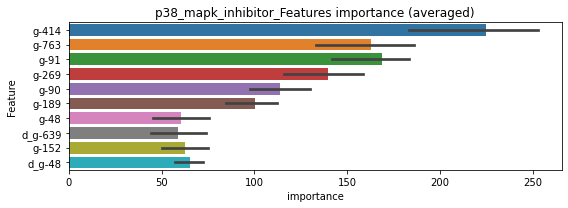

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178037	valid_1's binary_logloss: 0.0439686
[200]	training's binary_logloss: 0.00263564	valid_1's binary_logloss: 0.0234105
[300]	training's binary_logloss: 0.000777372	valid_1's binary_logloss: 0.0197156
[400]	training's binary_logloss: 0.000390922	valid_1's binary_logloss: 0.0183415
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000292215	valid_1's binary_logloss: 0.0177103


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180267	valid_1's binary_logloss: 0.042629
[200]	training's binary_logloss: 0.00263716	valid_1's binary_logloss: 0.0193111
[300]	training's binary_logloss: 0.000790686	valid_1's binary_logloss: 0.0144158
[400]	training's binary_logloss: 0.000392865	valid_1's binary_logloss: 0.0130637
[500]	training's binary_logloss: 0.000266433	valid_1's binary_logloss: 0.012539
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000251289	valid_1's binary_logloss: 0.0124103


p38_mapk_inhibitor logloss: 0.015060652698741833
p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03245	valid_1's binary_logloss: 0.0451189
[200]	training's binary_logloss: 0.00427957	valid_1's binary_logloss: 0.00926293
[300]	training's binary_logloss: 0.00115179	valid_1's binary_logloss: 0.00366859
[400]	training's binary_logloss: 0.000572752	valid_1's binary_logloss: 0.00229171
[500]	training's binary_logloss: 0.000411413	valid_1's binary_logloss: 0.00189631
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000399933	valid_1's binary_logloss: 0.00187517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328334	valid_1's binary_logloss: 0.0541397
[200]	training's binary_logloss: 0.00431352	valid_1's binary_logloss: 0.014874
[300]	training's binary_logloss: 0.00116396	valid_1's binary_logloss: 0.00749212
[400]	training's binary_logloss: 0.000573122	valid_1's binary_logloss: 0.00542502
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0023725, Threshold: 0.0036731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00331, conf_1:0.00404
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0036731
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0136731
threshold: 0.0136731, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307583	valid_1's binary_logloss: 0.0410223
[200]	training's binary_logloss: 0.00404279	valid_1's binary_logloss: 0.00821011
[300]	training's binary_logloss: 0.00111581	valid_1's binary_logloss: 0.00335494
[400]	training's binary_logloss: 0.000562527	valid_1's binary_logloss: 0.0020857
[500]	training's binary_logloss: 0.000408051	valid_1's binary_logloss: 0.00171717
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000402164	valid_1's binary_logloss: 0.00170793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321097	valid_1's binary_logloss: 0.0521916
[200]	training's binary_logloss: 0.00425183	valid_1's binary_logloss: 0.0158012
[300]	training's binary_logloss: 0.00113759	valid_1's binary_logloss: 0.00861424
[400]	training's binary_logloss: 0.000562777	valid_1's binary_logloss: 0.00658552
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0295706, Threshold: 0.0136731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0062783 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.01231, conf_1:0.01504
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.0136731
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.0236731
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0336731
threshold: 0.0336731, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307583	valid_1's binary_logloss: 0.0410223
[200]	training's binary_logloss: 0.00404279	valid_1's binary_logloss: 0.00821011
[300]	training's binary_logloss: 0.00111581	valid_1's binary_logloss: 0.00335494
[400]	training's binary_logloss: 0.000562527	valid_1's binary_logloss: 0.0020857
[500]	training's binary_logloss: 0.000408051	valid_1's binary_logloss: 0.00171717
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000402164	valid_1's binary_logloss: 0.00170793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321097	valid_1's binary_logloss: 0.0521916
[200]	training's binary_logloss: 0.00425183	valid_1's binary_logloss: 0.0158012
[300]	training's binary_logloss: 0.00113759	valid_1's binary_logloss: 0.00861424
[400]	training's binary_logloss: 0.000562777	valid_1's binary_logloss: 0.00658552
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0295706, Threshold: 0.0336731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.03031, conf_1:0.03704
threshold: 0.0336731, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


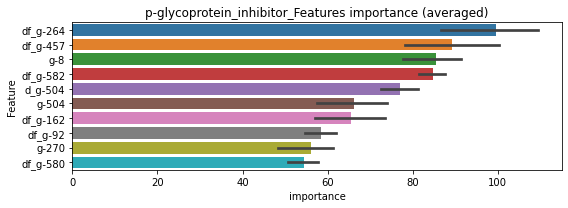

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188052	valid_1's binary_logloss: 0.0262851
[200]	training's binary_logloss: 0.00248324	valid_1's binary_logloss: 0.00760254
[300]	training's binary_logloss: 0.000628121	valid_1's binary_logloss: 0.00558171
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000404846	valid_1's binary_logloss: 0.0053186


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018256	valid_1's binary_logloss: 0.0263513
[200]	training's binary_logloss: 0.00237484	valid_1's binary_logloss: 0.00739138
[300]	training's binary_logloss: 0.000634921	valid_1's binary_logloss: 0.00467785
[400]	training's binary_logloss: 0.000306974	valid_1's binary_logloss: 0.00414089
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00022196	valid_1's binary_logloss: 0.00397291


p-glycoprotein_inhibitor logloss: 0.00464575397059964
parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849437	valid_1's binary_logloss: 0.130865
[200]	training's binary_logloss: 0.0331996	valid_1's binary_logloss: 0.0916801
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0162658	valid_1's binary_logloss: 0.0806272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842813	valid_1's binary_logloss: 0.137455
[200]	training's binary_logloss: 0.0343648	valid_1's binary_logloss: 0.0972128
[300]	training's binary_logloss: 0.0153755	valid_1's binary_logloss: 0.0809513
[400]	training's binary_logloss: 0.00766874	valid_1's binary_logloss: 0.0732233
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00637733	valid_1's binary_logloss: 0.0712862


1 / 3 AUC score:0.993
y_Threshold: 0.1012438, Threshold: 0.2565123, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 188 → Positive_corect_labels: 627/3746
p_label_rate: 0.0200904 Vs.target_rate: 0.00256, Num_p_label: 80.0, conf_0:0.23086, conf_1:0.28216
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.2565123
Num_p_label: 78.0, Expected: 10.2, Adj_threshold_2: 0.2665123
Num_p_label: 75.0, Expected: 10.2, Adj_threshold_3: 0.2765123
Num_p_label: 73.0, Expected: 10.2, Adj_threshold_4: 0.2865123
Num_p_label: 71.0, Expected: 10.2, Adj_threshold_5: 0.2965123
Num_p_label: 68.0, Expected: 10.2, Adj_threshold_6: 0.3065123
Num_p_label: 67.0, Expected: 10.2, Adj_threshold_7: 0.3165123
Num_p_label: 65.0, Expected: 10.2, Adj_threshold_8: 0.3265123
Num_p_label: 61.0, Expected: 10.2, Adj_threshold_9: 0.3365123
Num_p_label: 59.0, Expected: 10.2, Adj_threshold_10: 0.3465123
threshold: 0.3565123, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 627.0/3746, y_label_rate: 0.167378

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590006	valid_1's binary_logloss: 0.0994974
[200]	training's binary_logloss: 0.0164466	valid_1's binary_logloss: 0.059165
[300]	training's binary_logloss: 0.00626274	valid_1's binary_logloss: 0.0463808
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00397473	valid_1's binary_logloss: 0.0434569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631804	valid_1's binary_logloss: 0.0878793
[200]	training's binary_logloss: 0.0196359	valid_1's binary_logloss: 0.045522
[300]	training's binary_logloss: 0.00797101	valid_1's binary_logloss: 0.031711
[400]	training's binary_logloss: 0.00424154	valid_1's binary_logloss: 0.0270246
[500]	training's binary_logloss: 0.002705	valid_1's binary_logloss: 0.0241633
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.002705	valid_1's binary_logloss: 0.0241633


2 / 3 AUC score:0.998
y_Threshold: 0.2017588, Threshold: 0.3565123, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 610.0/3712
p_label_rate: 0.0263687 Vs.target_rate: 0.00256, Num_p_label: 105.0, conf_0:0.32086, conf_1:0.39216
Num_p_label: 105.0, Expected: 10.2, Adj_threshold_1: 0.3565123
Num_p_label: 102.0, Expected: 10.2, Adj_threshold_2: 0.3665123
Num_p_label: 100.0, Expected: 10.2, Adj_threshold_3: 0.3765123
Num_p_label: 99.0, Expected: 10.2, Adj_threshold_4: 0.3865123
Num_p_label: 98.0, Expected: 10.2, Adj_threshold_5: 0.3965123
Num_p_label: 95.0, Expected: 10.2, Adj_threshold_6: 0.4065123
Num_p_label: 95.0, Expected: 10.2, Adj_threshold_7: 0.4165123
Num_p_label: 89.0, Expected: 10.2, Adj_threshold_8: 0.4265123
Num_p_label: 86.0, Expected: 10.2, Adj_threshold_9: 0.4365123
Num_p_label: 86.0, Expected: 10.2, Adj_threshold_10: 0.4465123
threshold: 0.4565123, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 610.0/3712, y_label_rate: 0.1

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511232	valid_1's binary_logloss: 0.0904042
[200]	training's binary_logloss: 0.0138046	valid_1's binary_logloss: 0.0500603
[300]	training's binary_logloss: 0.0053122	valid_1's binary_logloss: 0.0378618
[400]	training's binary_logloss: 0.00281226	valid_1's binary_logloss: 0.0334448
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00202519	valid_1's binary_logloss: 0.0307897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563932	valid_1's binary_logloss: 0.0804423
[200]	training's binary_logloss: 0.0156887	valid_1's binary_logloss: 0.039813
[300]	training's binary_logloss: 0.00591631	valid_1's binary_logloss: 0.0274225
[400]	training's binary_logloss: 0.00307843	valid_1's binary_logloss: 0.0224379
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00233426	valid_1's binary_logloss: 0.0207988


3 / 3 AUC score:0.999
y_Threshold: 0.2319621, Threshold: 0.4565123, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 598.0/3688
p_label_rate: 0.0238574 Vs.target_rate: 0.00256, Num_p_label: 95.0, conf_0:0.41086, conf_1:0.50216
Num_p_label: 95.0, Expected: 10.2, Adj_threshold_1: 0.4565123
Num_p_label: 95.0, Expected: 10.2, Adj_threshold_2: 0.4665123
Num_p_label: 93.0, Expected: 10.2, Adj_threshold_3: 0.4765123
Num_p_label: 91.0, Expected: 10.2, Adj_threshold_4: 0.4865123
Num_p_label: 89.0, Expected: 10.2, Adj_threshold_5: 0.4965123
Num_p_label: 85.0, Expected: 10.2, Adj_threshold_6: 0.5065123
Num_p_label: 83.0, Expected: 10.2, Adj_threshold_7: 0.5165123
Num_p_label: 81.0, Expected: 10.2, Adj_threshold_8: 0.5265123
Num_p_label: 81.0, Expected: 10.2, Adj_threshold_9: 0.5365123
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_10: 0.5465123
threshold: 0.5565123, positive_p_label: 75.0/3982, p_label_rate: 0.0188348
positive_y_label: 673.0/7670, y_label_rate: 0.08774

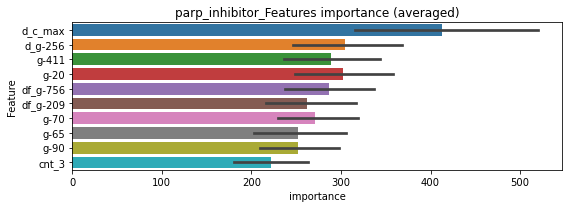

len(train_index) : 3835
len(valid_index) : 3835
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355552	valid_1's binary_logloss: 0.0520029
[200]	training's binary_logloss: 0.0105182	valid_1's binary_logloss: 0.0275199
[300]	training's binary_logloss: 0.00432307	valid_1's binary_logloss: 0.0211144
[400]	training's binary_logloss: 0.00230255	valid_1's binary_logloss: 0.0181526
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00191299	valid_1's binary_logloss: 0.0174885


len(train_index) : 3835
len(valid_index) : 3835
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337659	valid_1's binary_logloss: 0.0573952
[200]	training's binary_logloss: 0.0100271	valid_1's binary_logloss: 0.0323391
[300]	training's binary_logloss: 0.0039637	valid_1's binary_logloss: 0.0249682
[400]	training's binary_logloss: 0.00205133	valid_1's binary_logloss: 0.0214204
[500]	training's binary_logloss: 0.00133592	valid_1's binary_logloss: 0.0198295
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00137949	valid_1's binary_logloss: 0.0197656


parp_inhibitor logloss: 0.01862705278434387
pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179


neg labels: 3289 → selected neg labels: 3268


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083261	valid_1's binary_logloss: 0.13943
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0479075	valid_1's binary_logloss: 0.127336
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.976
y_Threshold: 0.1449896, Threshold: 0.6067320, pos_neg_ratio: 0.8000000


[100]	training's binary_logloss: 0.0750474	valid_1's binary_logloss: 0.138903
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0400893	valid_1's binary_logloss: 0.129438


Remove_noisy_labels: 230 → Positive_corect_labels: 604/3691
p_label_rate: 0.0200904 Vs.target_rate: 0.01247, Num_p_label: 80.0, conf_0:0.54606, conf_1:0.66741
threshold: 0.6067320, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 604.0/3691, y_label_rate: 0.1636413
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415757	valid_1's binary_logloss: 0.0652034
[200]	training's binary_logloss: 0.00941522	valid_1's binary_logloss: 0.0364146
[300]	training's binary_logloss: 0.00348523	valid_1's binary_logloss: 0.0321911
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00259256	valid_1's binary_logloss: 0.0312923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418339	valid_1's binary_logloss: 0.0632306


2 / 3 AUC score:0.997
y_Threshold: 0.2753164, Threshold: 0.6067320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 586.0/3655
p_label_rate: 0.0381718 Vs.target_rate: 0.01247, Num_p_label: 152.0, conf_0:0.54606, conf_1:0.66741
Num_p_label: 152.0, Expected: 49.7, Adj_threshold_1: 0.6067320
Num_p_label: 148.0, Expected: 49.7, Adj_threshold_2: 0.6167320
Num_p_label: 145.0, Expected: 49.7, Adj_threshold_3: 0.6267320
Num_p_label: 142.0, Expected: 49.7, Adj_threshold_4: 0.6367320
Num_p_label: 140.0, Expected: 49.7, Adj_threshold_5: 0.6467320
Num_p_label: 139.0, Expected: 49.7, Adj_threshold_6: 0.6567320
Num_p_label: 134.0, Expected: 49.7, Adj_threshold_7: 0.6667320
Num_p_label: 131.0, Expected: 49.7, Adj_threshold_8: 0.6767320
Num_p_label: 130.0, Expected: 49.7, Adj_threshold_9: 0.6867320
Num_p_label: 126.0, Expected: 49.7, Adj_threshold_10: 0.6967320


[200]	training's binary_logloss: 0.0100032	valid_1's binary_logloss: 0.035553
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00730172	valid_1's binary_logloss: 0.0338578


threshold: 0.7067320, positive_p_label: 124.0/3982, p_label_rate: 0.0311401
positive_y_label: 586.0/3655, y_label_rate: 0.1603283
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367178	valid_1's binary_logloss: 0.045931
[200]	training's binary_logloss: 0.00805288	valid_1's binary_logloss: 0.0176795
[300]	training's binary_logloss: 0.00289922	valid_1's binary_logloss: 0.0109475
[400]	training's binary_logloss: 0.00158434	valid_1's binary_logloss: 0.0087877
[500]	training's binary_logloss: 0.00107829	valid_1's binary_logloss: 0.00785826
[600]	training's binary_logloss: 0.000854512	valid_1's binary_logloss: 0.00729058
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.000772185	valid_1's binary_logloss: 0.00702622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326669	valid_1's binary_logloss: 0.0640683
[200]	training's binary_logloss: 0.00673593	valid_1's binary_logloss: 0.0367586


3 / 3 AUC score:0.999
y_Threshold: 0.2454771, Threshold: 0.7067320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 576.0/3635
p_label_rate: 0.0336514 Vs.target_rate: 0.01247, Num_p_label: 134.0, conf_0:0.63606, conf_1:0.77741
threshold: 0.7067320, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 710.0/7617, y_label_rate: 0.0932126


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00355633	valid_1's binary_logloss: 0.0332396


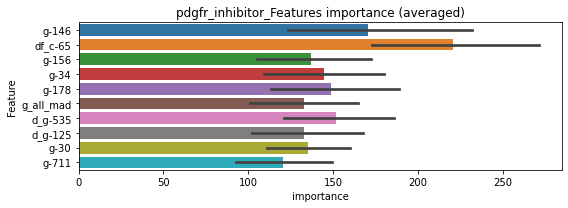

len(train_index) : 3808
len(valid_index) : 3809
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021933	valid_1's binary_logloss: 0.0388638
[200]	training's binary_logloss: 0.00459028	valid_1's binary_logloss: 0.0242344
[300]	training's binary_logloss: 0.00178407	valid_1's binary_logloss: 0.0220029
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00164818	valid_1's binary_logloss: 0.0218525


len(train_index) : 3809
len(valid_index) : 3808
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214619	valid_1's binary_logloss: 0.0376825
[200]	training's binary_logloss: 0.00444561	valid_1's binary_logloss: 0.0220413


pdgfr_inhibitor logloss: 0.020567211484111763


[300]	training's binary_logloss: 0.00169283	valid_1's binary_logloss: 0.0193459
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00159007	valid_1's binary_logloss: 0.0192816


pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251147	valid_1's binary_logloss: 0.0321258
[200]	training's binary_logloss: 0.00302819	valid_1's binary_logloss: 0.00535683
[300]	training's binary_logloss: 0.000839318	valid_1's binary_logloss: 0.00189465
[400]	training's binary_logloss: 0.000437092	valid_1's binary_logloss: 0.00112258
[500]	training's binary_logloss: 0.000348234	valid_1's binary_logloss: 0.000951844
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000345926	valid_1's binary_logloss: 0.000949202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251963	valid_1's binary_logloss: 0.0363946
[200]	training's binary_logloss: 0.00300578	valid_1's binary_logloss: 0.0083687
[300]	training's binary_logloss: 0.000832703	valid_1's binary_logloss: 0.0040456
[400]	training's binary_logloss: 0.000430455	valid_1's binary_logloss: 0.00294277
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0014683, Threshold: 0.0021724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00196, conf_1:0.00239
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021724
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0121724
threshold: 0.0121724, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243407	valid_1's binary_logloss: 0.0291543
[200]	training's binary_logloss: 0.00291739	valid_1's binary_logloss: 0.00438055
[300]	training's binary_logloss: 0.000822882	valid_1's binary_logloss: 0.00143589
[400]	training's binary_logloss: 0.000433899	valid_1's binary_logloss: 0.0008268
[500]	training's binary_logloss: 0.000347018	valid_1's binary_logloss: 0.000686133
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000342321	valid_1's binary_logloss: 0.000679569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241876	valid_1's binary_logloss: 0.0343816
[200]	training's binary_logloss: 0.00284794	valid_1's binary_logloss: 0.00749549
[300]	training's binary_logloss: 0.000817928	valid_1's binary_logloss: 0.00360988
[400]	training's binary_logloss: 0.000429731	valid_1's binary_logloss: 0.0026866
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0357916, Threshold: 0.0121724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.01096, conf_1:0.01339
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.0121724
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0221724
threshold: 0.0221724, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243407	valid_1's binary_logloss: 0.0291543
[200]	training's binary_logloss: 0.00291739	valid_1's binary_logloss: 0.00438055
[300]	training's binary_logloss: 0.000822882	valid_1's binary_logloss: 0.00143589
[400]	training's binary_logloss: 0.000433899	valid_1's binary_logloss: 0.0008268
[500]	training's binary_logloss: 0.000347018	valid_1's binary_logloss: 0.000686133
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000342321	valid_1's binary_logloss: 0.000679569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241876	valid_1's binary_logloss: 0.0343816
[200]	training's binary_logloss: 0.00284794	valid_1's binary_logloss: 0.00749549
[300]	training's binary_logloss: 0.000817928	valid_1's binary_logloss: 0.00360988
[400]	training's binary_logloss: 0.000429731	valid_1's binary_logloss: 0.0026866
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0357916, Threshold: 0.0221724, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.01996, conf_1:0.02439
threshold: 0.0221724, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


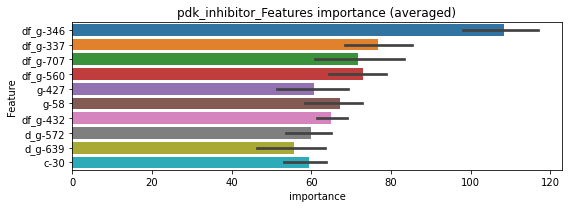

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140573	valid_1's binary_logloss: 0.0221479
[200]	training's binary_logloss: 0.00164226	valid_1's binary_logloss: 0.0077451
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000534915	valid_1's binary_logloss: 0.00694622


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148022	valid_1's binary_logloss: 0.0203225
[200]	training's binary_logloss: 0.00182612	valid_1's binary_logloss: 0.0057144
[300]	training's binary_logloss: 0.000486767	valid_1's binary_logloss: 0.00301313
[400]	training's binary_logloss: 0.000243574	valid_1's binary_logloss: 0.00230207
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000193061	valid_1's binary_logloss: 0.00218411


pdk_inhibitor logloss: 0.004565469251603456
phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064


neg labels: 3289 → selected neg labels: 3243


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171423	valid_1's binary_logloss: 0.303946
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.121566	valid_1's binary_logloss: 0.296691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202258	valid_1's binary_logloss: 0.280696
[200]	training's binary_logloss: 0.140753	valid_1's binary_logloss: 0.256489
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.124654	valid_1's binary_logloss: 0.254454


1 / 3 AUC score:0.865
y_Threshold: 0.1916981, Threshold: 0.3200928, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 551 → Positive_corect_labels: 438/3340
p_label_rate: 0.0200904 Vs.target_rate: 0.01109, Num_p_label: 80.0, conf_0:0.28808, conf_1:0.35210
threshold: 0.3200928, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 438.0/3340, y_label_rate: 0.1311377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807301	valid_1's binary_logloss: 0.155414
[200]	training's binary_logloss: 0.0332133	valid_1's binary_logloss: 0.124965
[300]	training's binary_logloss: 0.0163403	valid_1's binary_logloss: 0.116901
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0121496	valid_1's binary_logloss: 0.115342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880464	valid_1's binary_logloss: 0.13161
[200]	training's binary_logloss: 0.0385328	valid_1's binary_logloss: 0.0954283
[300]	training's binary_logloss: 0.0187057	valid_1's binary_logloss: 0.0844719


2 / 3 AUC score:0.984
y_Threshold: 0.1750574, Threshold: 0.3200928, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 120 → Positive_corect_labels: 378.0/3220
p_label_rate: 0.0276243 Vs.target_rate: 0.01109, Num_p_label: 110.0, conf_0:0.28808, conf_1:0.35210
threshold: 0.3200928, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 378.0/3220, y_label_rate: 0.1173913
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0126104	valid_1's binary_logloss: 0.0816579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600984	valid_1's binary_logloss: 0.110704
[200]	training's binary_logloss: 0.0210946	valid_1's binary_logloss: 0.0769053
[300]	training's binary_logloss: 0.00941103	valid_1's binary_logloss: 0.0660024
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00767102	valid_1's binary_logloss: 0.0645969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615183	valid_1's binary_logloss: 0.111941
[200]	training's binary_logloss: 0.0215956	valid_1's binary_logloss: 0.0756008
[300]	training's binary_logloss: 0.00950693	valid_1's binary_logloss: 0.0622531


3 / 3 AUC score:0.995
y_Threshold: 0.1629668, Threshold: 0.3200928, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 351.0/3166
p_label_rate: 0.0271220 Vs.target_rate: 0.01109, Num_p_label: 108.0, conf_0:0.28808, conf_1:0.35210
threshold: 0.3200928, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 459.0/7148, y_label_rate: 0.0642138


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00558004	valid_1's binary_logloss: 0.057571


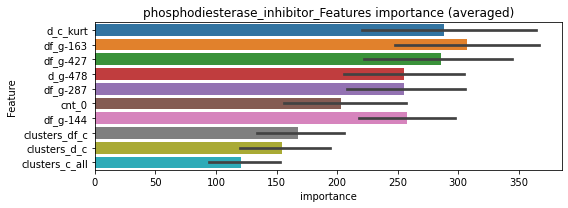

len(train_index) : 3574
len(valid_index) : 3574
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389211	valid_1's binary_logloss: 0.0827267
[200]	training's binary_logloss: 0.01391	valid_1's binary_logloss: 0.0596724
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00824488	valid_1's binary_logloss: 0.0555851


len(train_index) : 3574
len(valid_index) : 3574
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408492	valid_1's binary_logloss: 0.0700525
[200]	training's binary_logloss: 0.0146402	valid_1's binary_logloss: 0.0494961
[300]	training's binary_logloss: 0.00673444	valid_1's binary_logloss: 0.0431525


phosphodiesterase_inhibitor logloss: 0.04872237170366598


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00505881	valid_1's binary_logloss: 0.0418596


phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289051	valid_1's binary_logloss: 0.0462875
[200]	training's binary_logloss: 0.00391524	valid_1's binary_logloss: 0.0132856
[300]	training's binary_logloss: 0.00111831	valid_1's binary_logloss: 0.00749785
[400]	training's binary_logloss: 0.000567283	valid_1's binary_logloss: 0.00612743
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000421108	valid_1's binary_logloss: 0.00560914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305252	valid_1's binary_logloss: 0.0415763
[200]	training's binary_logloss: 0.00437616	valid_1's binary_logloss: 0.00904773
[300]	training's binary_logloss: 0.00120359	valid_1's binary_logloss: 0.00329681
[400]	training's binary_logloss: 0.000606631	valid_1's binary_logloss: 0.00205575
[500]	training's binary_logloss: 0.000430121	valid_1's binary_logloss: 0.00161025
[600]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0023627, Threshold: 0.0042468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00382, conf_1:0.00467
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0042468
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.0142468
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.0242468
threshold: 0.0242468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290326	valid_1's binary_logloss: 0.046213
[200]	training's binary_logloss: 0.00380846	valid_1's binary_logloss: 0.0136266
[300]	training's binary_logloss: 0.00109433	valid_1's binary_logloss: 0.00868049
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000660756	valid_1's binary_logloss: 0.00739426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300993	valid_1's binary_logloss: 0.0399317
[200]	training's binary_logloss: 0.00413971	valid_1's binary_logloss: 0.00766438
[300]	training's binary_logloss: 0.00116375	valid_1's binary_logloss: 0.00281967
[400]	training's binary_logloss: 0.000590846	valid_1's binary_logloss: 0.00166193
[500]	training's binary_logloss: 0.000428007	valid_1's binary_logloss: 0.00129655
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00041122	valid_1's binary_logloss: 0.00126054


2 / 3 AUC score:1.000
y_Threshold: 0.0462761, Threshold: 0.0242468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.02182, conf_1:0.02667
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.0242468
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.0342468
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_3: 0.0442468
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.0542468
threshold: 0.0542468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290326	valid_1's binary_logloss: 0.046213
[200]	training's binary_logloss: 0.00380846	valid_1's binary_logloss: 0.0136266
[300]	training's binary_logloss: 0.00109433	valid_1's binary_logloss: 0.00868049
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000660756	valid_1's binary_logloss: 0.00739426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300993	valid_1's binary_logloss: 0.0399317
[200]	training's binary_logloss: 0.00413971	valid_1's binary_logloss: 0.00766438
[300]	training's binary_logloss: 0.00116375	valid_1's binary_logloss: 0.00281967
[400]	training's binary_logloss: 0.000590846	valid_1's binary_logloss: 0.00166193
[500]	training's binary_logloss: 0.000428007	valid_1's binary_logloss: 0.00129655
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00041122	valid_1's binary_logloss: 0.00126054


3 / 3 AUC score:1.000
y_Threshold: 0.0462761, Threshold: 0.0542468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.04882, conf_1:0.05967
threshold: 0.0542468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


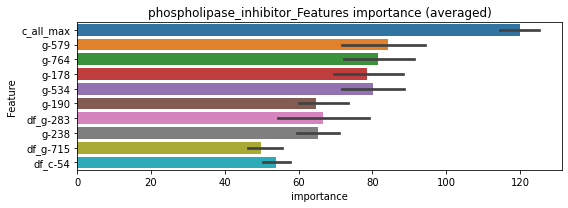

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158958	valid_1's binary_logloss: 0.0268343
[200]	training's binary_logloss: 0.00220311	valid_1's binary_logloss: 0.0103213
[300]	training's binary_logloss: 0.000606682	valid_1's binary_logloss: 0.00789879
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000557634	valid_1's binary_logloss: 0.00777363


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161688	valid_1's binary_logloss: 0.0261587
[200]	training's binary_logloss: 0.00214567	valid_1's binary_logloss: 0.00923798
[300]	training's binary_logloss: 0.000614499	valid_1's binary_logloss: 0.00650266
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000353022	valid_1's binary_logloss: 0.00599948


phospholipase_inhibitor logloss: 0.006886553706995127
pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749


neg labels: 3289 → selected neg labels: 3264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122957	valid_1's binary_logloss: 0.203887
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.076534	valid_1's binary_logloss: 0.188071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113735	valid_1's binary_logloss: 0.207324


1 / 3 AUC score:0.952
y_Threshold: 0.1748369, Threshold: 0.6312701, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.0620545	valid_1's binary_logloss: 0.188811
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0488414	valid_1's binary_logloss: 0.185762


Remove_noisy_labels: 350 → Positive_corect_labels: 543/3566
p_label_rate: 0.0200904 Vs.target_rate: 0.00634, Num_p_label: 80.0, conf_0:0.56814, conf_1:0.69440
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.6312701
Num_p_label: 78.0, Expected: 25.2, Adj_threshold_2: 0.6412701
Num_p_label: 76.0, Expected: 25.2, Adj_threshold_3: 0.6512701
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_4: 0.6612701
Num_p_label: 73.0, Expected: 25.2, Adj_threshold_5: 0.6712701
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_6: 0.6812701
Num_p_label: 67.0, Expected: 25.2, Adj_threshold_7: 0.6912701
Num_p_label: 65.0, Expected: 25.2, Adj_threshold_8: 0.7012701
Num_p_label: 62.0, Expected: 25.2, Adj_threshold_9: 0.7112701
Num_p_label: 59.0, Expected: 25.2, Adj_threshold_10: 0.7212701
threshold: 0.7312701, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 543.0/3566, y_label_rate: 0.1522715
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520964	valid_1's binary_logloss: 0.099116
[200]	training's binary_logloss: 0.0163119	valid_1's binary_logloss: 0.0734295
[300]	training's binary_logloss: 0.00627805	valid_1's binary_logloss: 0.0671414
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00573197	valid_1's binary_logloss: 0.0669264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054338	valid_1's binary_logloss: 0.116279


2 / 3 AUC score:0.990
y_Threshold: 0.1970841, Threshold: 0.7312701, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 504.0/3488
p_label_rate: 0.0364139 Vs.target_rate: 0.00634, Num_p_label: 145.0, conf_0:0.65814, conf_1:0.80440
Num_p_label: 145.0, Expected: 25.2, Adj_threshold_1: 0.7312701
Num_p_label: 144.0, Expected: 25.2, Adj_threshold_2: 0.7412701
Num_p_label: 143.0, Expected: 25.2, Adj_threshold_3: 0.7512701
Num_p_label: 142.0, Expected: 25.2, Adj_threshold_4: 0.7612701


[200]	training's binary_logloss: 0.0157102	valid_1's binary_logloss: 0.0810417
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0109497	valid_1's binary_logloss: 0.0782597


Num_p_label: 139.0, Expected: 25.2, Adj_threshold_5: 0.7712701
Num_p_label: 137.0, Expected: 25.2, Adj_threshold_6: 0.7812701
Num_p_label: 136.0, Expected: 25.2, Adj_threshold_7: 0.7912701
Num_p_label: 134.0, Expected: 25.2, Adj_threshold_8: 0.8012701
Num_p_label: 131.0, Expected: 25.2, Adj_threshold_9: 0.8112701
Num_p_label: 128.0, Expected: 25.2, Adj_threshold_10: 0.8212701
threshold: 0.8312701, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 504.0/3488, y_label_rate: 0.1444954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393372	valid_1's binary_logloss: 0.0704766
[200]	training's binary_logloss: 0.00914085	valid_1's binary_logloss: 0.0424861
[300]	training's binary_logloss: 0.00354038	valid_1's binary_logloss: 0.0360821
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0032864	valid_1's binary_logloss: 0.0356603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406946	valid_1's binary_logloss: 0.0855222
[200]	training's binary_logloss: 0.00955363	valid_1's binary_logloss: 0.057421
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00417656	valid_1's binary_logloss: 0.051979


3 / 3 AUC score:0.996
y_Threshold: 0.2090519, Threshold: 0.8312701, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 479.0/3438
p_label_rate: 0.0384229 Vs.target_rate: 0.00634, Num_p_label: 153.0, conf_0:0.74814, conf_1:0.91440
Num_p_label: 153.0, Expected: 25.2, Adj_threshold_1: 0.8312701
Num_p_label: 152.0, Expected: 25.2, Adj_threshold_2: 0.8412701
Num_p_label: 151.0, Expected: 25.2, Adj_threshold_3: 0.8512701
Num_p_label: 148.0, Expected: 25.2, Adj_threshold_4: 0.8612701
Num_p_label: 147.0, Expected: 25.2, Adj_threshold_5: 0.8712701
Num_p_label: 146.0, Expected: 25.2, Adj_threshold_6: 0.8812701
Num_p_label: 144.0, Expected: 25.2, Adj_threshold_7: 0.8912701
Num_p_label: 142.0, Expected: 25.2, Adj_threshold_8: 0.9012701
Num_p_label: 139.0, Expected: 25.2, Adj_threshold_9: 0.9112701
Num_p_label: 133.0, Expected: 25.2, Adj_threshold_10: 0.9212701
threshold: 0.9312701, positive_p_label: 129.0/3982, p_label_rate: 0.0323958
positive_y_label: 608.0/7420, y_label_r

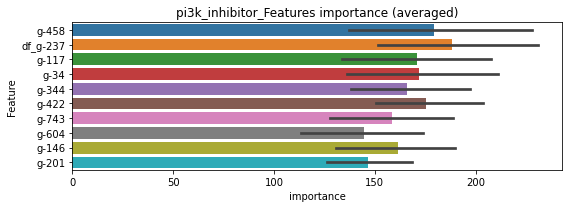

len(train_index) : 3710
len(valid_index) : 3710
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235351	valid_1's binary_logloss: 0.0452077
[200]	training's binary_logloss: 0.00666615	valid_1's binary_logloss: 0.0306518
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0035405	valid_1's binary_logloss: 0.0291079


len(train_index) : 3710
len(valid_index) : 3710
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235177	valid_1's binary_logloss: 0.0524088


pi3k_inhibitor logloss: 0.03198882675383029


[200]	training's binary_logloss: 0.00643876	valid_1's binary_logloss: 0.0361345
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00492664	valid_1's binary_logloss: 0.0348698


pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342263	valid_1's binary_logloss: 0.0559095
[200]	training's binary_logloss: 0.00484065	valid_1's binary_logloss: 0.0177086
[300]	training's binary_logloss: 0.00133453	valid_1's binary_logloss: 0.0105351
[400]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.00887557
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000492035	valid_1's binary_logloss: 0.00832682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328817	valid_1's binary_logloss: 0.0493414
[200]	training's binary_logloss: 0.00480365	valid_1's binary_logloss: 0.0125734
[300]	training's binary_logloss: 0.0013372	valid_1's binary_logloss: 0.00583736
[400]	training's binary_logloss: 0.000659017	valid_1's binary_logloss: 0.00399141
[500]	training's binary_logloss: 0.000454948	valid_1's binary_logloss: 0.00342865
Early stopping, best iteration is:
[5

1 / 3 AUC score:1.000
y_Threshold: 0.0026783, Threshold: 0.0040986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130, Num_p_label: 80.0, conf_0:0.00369, conf_1:0.00451
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0040986
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_2: 0.0140986
threshold: 0.0140986, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335443	valid_1's binary_logloss: 0.0552546
[200]	training's binary_logloss: 0.00456528	valid_1's binary_logloss: 0.0165092
[300]	training's binary_logloss: 0.0012583	valid_1's binary_logloss: 0.00958449
[400]	training's binary_logloss: 0.000635547	valid_1's binary_logloss: 0.00803553
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000494426	valid_1's binary_logloss: 0.00749255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329956	valid_1's binary_logloss: 0.0496637
[200]	training's binary_logloss: 0.0046537	valid_1's binary_logloss: 0.0133133
[300]	training's binary_logloss: 0.00133992	valid_1's binary_logloss: 0.00625951
[400]	training's binary_logloss: 0.000661106	valid_1's binary_logloss: 0.00427288
[500]	training's binary_logloss: 0.000459965	valid_1's binary_logloss: 0.0036485
Early stopping, best iteration is:
[56

2 / 3 AUC score:1.000
y_Threshold: 0.0335382, Threshold: 0.0140986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0085384 Vs.target_rate: 0.00130, Num_p_label: 34.0, conf_0:0.01269, conf_1:0.01551
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_1: 0.0140986
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_2: 0.0240986
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_3: 0.0340986
threshold: 0.0340986, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335443	valid_1's binary_logloss: 0.0552546
[200]	training's binary_logloss: 0.00456528	valid_1's binary_logloss: 0.0165092
[300]	training's binary_logloss: 0.0012583	valid_1's binary_logloss: 0.00958449
[400]	training's binary_logloss: 0.000635547	valid_1's binary_logloss: 0.00803553
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000494426	valid_1's binary_logloss: 0.00749255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329956	valid_1's binary_logloss: 0.0496637
[200]	training's binary_logloss: 0.0046537	valid_1's binary_logloss: 0.0133133
[300]	training's binary_logloss: 0.00133992	valid_1's binary_logloss: 0.00625951
[400]	training's binary_logloss: 0.000661106	valid_1's binary_logloss: 0.00427288
[500]	training's binary_logloss: 0.000459965	valid_1's binary_logloss: 0.0036485
Early stopping, best iteration is:
[56

3 / 3 AUC score:1.000
y_Threshold: 0.0335382, Threshold: 0.0340986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00130, Num_p_label: 10.0, conf_0:0.03069, conf_1:0.03751
threshold: 0.0340986, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


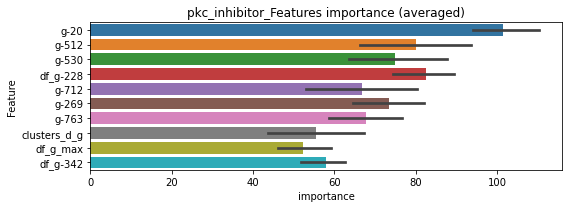

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178535	valid_1's binary_logloss: 0.0305087
[200]	training's binary_logloss: 0.00246572	valid_1's binary_logloss: 0.0119479
[300]	training's binary_logloss: 0.000689293	valid_1's binary_logloss: 0.00923668
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000549168	valid_1's binary_logloss: 0.00901942


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184126	valid_1's binary_logloss: 0.027126
[200]	training's binary_logloss: 0.00269654	valid_1's binary_logloss: 0.00852235
[300]	training's binary_logloss: 0.000735697	valid_1's binary_logloss: 0.00545705
[400]	training's binary_logloss: 0.000362972	valid_1's binary_logloss: 0.00483283
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000344569	valid_1's binary_logloss: 0.00480787


pkc_inhibitor logloss: 0.00691364591427845
potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962815	valid_1's binary_logloss: 0.152747
[200]	training's binary_logloss: 0.0429506	valid_1's binary_logloss: 0.111619
[300]	training's binary_logloss: 0.019277	valid_1's binary_logloss: 0.093248
[400]	training's binary_logloss: 0.00940153	valid_1's binary_logloss: 0.0835278
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00684926	valid_1's binary_logloss: 0.0812565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979305	valid_1's binary_logloss: 0.154234


1 / 3 AUC score:0.987
y_Threshold: 0.1763594, Threshold: 0.3776081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 204 → Positive_corect_labels: 619/3730
p_label_rate: 0.0200904 Vs.target_rate: 0.00231, Num_p_label: 80.0, conf_0:0.33985, conf_1:0.41537
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.3776081
Num_p_label: 78.0, Expected: 9.2, Adj_threshold_2: 0.3876081
Num_p_label: 77.0, Expected: 9.2, Adj_threshold_3: 0.3976081
Num_p_label: 73.0, Expected: 9.2, Adj_threshold_4: 0.4076081
Num_p_label: 70.0, Expected: 9.2, Adj_threshold_5: 0.4176081
Num_p_label: 67.0, Expected: 9.2, Adj_threshold_6: 0.4276081
Num_p_label: 65.0, Expected: 9.2, Adj_threshold_7: 0.4376081
Num_p_label: 63.0, Expected: 9.2, Adj_threshold_8: 0.4476081
Num_p_label: 62.0, Expected: 9.2, Adj_threshold_9: 0.4576081
Num_p_label: 61.0, Expected: 9.2, Adj_threshold_10: 0.4676081
threshold: 0.4776081, positive_p_label: 58.0/3982, p_label_rate: 0.0145655


[200]	training's binary_logloss: 0.0426187	valid_1's binary_logloss: 0.123428
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0393972	valid_1's binary_logloss: 0.121828


positive_y_label: 619.0/3730, y_label_rate: 0.1659517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749685	valid_1's binary_logloss: 0.112589
[200]	training's binary_logloss: 0.0256671	valid_1's binary_logloss: 0.0683254
[300]	training's binary_logloss: 0.0102952	valid_1's binary_logloss: 0.05205
[400]	training's binary_logloss: 0.00506535	valid_1's binary_logloss: 0.0430553
[500]	training's binary_logloss: 0.0032186	valid_1's binary_logloss: 0.0388004
[600]	training's binary_logloss: 0.00236294	valid_1's binary_logloss: 0.0368445
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00201432	valid_1's binary_logloss: 0.0359341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675759	valid_1's binary_logloss: 0.107221
[200]	training's binary_logloss: 0.0227405	valid_1's binary_logloss: 0.0664159
[300]	training's binary_logloss: 0.00953592	valid_1's binary_logloss: 0.0547371
[400]	training's binary_logloss: 0.0046621	valid_1's 

2 / 3 AUC score:0.998
y_Threshold: 0.3034758, Threshold: 0.4776081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 589.0/3670
p_label_rate: 0.0286288 Vs.target_rate: 0.00231, Num_p_label: 114.0, conf_0:0.42985, conf_1:0.52537
Num_p_label: 114.0, Expected: 9.2, Adj_threshold_1: 0.4776081
Num_p_label: 111.0, Expected: 9.2, Adj_threshold_2: 0.4876081
Num_p_label: 109.0, Expected: 9.2, Adj_threshold_3: 0.4976081
Num_p_label: 108.0, Expected: 9.2, Adj_threshold_4: 0.5076081
Num_p_label: 105.0, Expected: 9.2, Adj_threshold_5: 0.5176081
Num_p_label: 101.0, Expected: 9.2, Adj_threshold_6: 0.5276081
Num_p_label: 99.0, Expected: 9.2, Adj_threshold_7: 0.5376081
Num_p_label: 99.0, Expected: 9.2, Adj_threshold_8: 0.5476081
Num_p_label: 98.0, Expected: 9.2, Adj_threshold_9: 0.5576081
Num_p_label: 96.0, Expected: 9.2, Adj_threshold_10: 0.5676081
threshold: 0.5776081, positive_p_label: 95.0/3982, p_label_rate: 0.0238574
positive_y_label: 589.0/3670, y_label_rate: 0.1604905


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586515	valid_1's binary_logloss: 0.0914331
[200]	training's binary_logloss: 0.0178483	valid_1's binary_logloss: 0.0524111
[300]	training's binary_logloss: 0.00723267	valid_1's binary_logloss: 0.038847
[400]	training's binary_logloss: 0.00370064	valid_1's binary_logloss: 0.0335414
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0026144	valid_1's binary_logloss: 0.0315801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614454	valid_1's binary_logloss: 0.089576
[200]	training's binary_logloss: 0.0181134	valid_1's binary_logloss: 0.0473015
[300]	training's binary_logloss: 0.00735987	valid_1's binary_logloss: 0.0337206
[400]	training's binary_logloss: 0.00373013	valid_1's binary_logloss: 0.0289263
[500]	training's binary_logloss: 0.00245013	valid_1's binary_logloss: 0.0268547
[600]	training's binary_logloss: 0.00187047	valid_

3 / 3 AUC score:0.999
y_Threshold: 0.2947128, Threshold: 0.5776081, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 569.0/3630
p_label_rate: 0.0276243 Vs.target_rate: 0.00231, Num_p_label: 110.0, conf_0:0.51985, conf_1:0.63537
Num_p_label: 110.0, Expected: 9.2, Adj_threshold_1: 0.5776081
Num_p_label: 109.0, Expected: 9.2, Adj_threshold_2: 0.5876081
Num_p_label: 107.0, Expected: 9.2, Adj_threshold_3: 0.5976081
Num_p_label: 105.0, Expected: 9.2, Adj_threshold_4: 0.6076081
Num_p_label: 104.0, Expected: 9.2, Adj_threshold_5: 0.6176081
Num_p_label: 102.0, Expected: 9.2, Adj_threshold_6: 0.6276081
Num_p_label: 100.0, Expected: 9.2, Adj_threshold_7: 0.6376081
Num_p_label: 99.0, Expected: 9.2, Adj_threshold_8: 0.6476081
Num_p_label: 96.0, Expected: 9.2, Adj_threshold_9: 0.6576081
Num_p_label: 95.0, Expected: 9.2, Adj_threshold_10: 0.6676081
threshold: 0.6776081, positive_p_label: 92.0/3982, p_label_rate: 0.0231040
positive_y_label: 661.0/7612, y_label_rate: 0.0868366

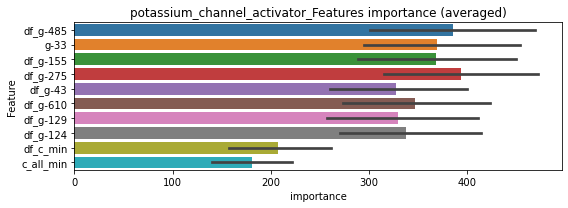

len(train_index) : 3806
len(valid_index) : 3806
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397389	valid_1's binary_logloss: 0.0633575
[200]	training's binary_logloss: 0.0131387	valid_1's binary_logloss: 0.0389363
[300]	training's binary_logloss: 0.00524628	valid_1's binary_logloss: 0.0301085
[400]	training's binary_logloss: 0.00266969	valid_1's binary_logloss: 0.0267499
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00185174	valid_1's binary_logloss: 0.0255077


len(train_index) : 3806
len(valid_index) : 3806
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398704	valid_1's binary_logloss: 0.0615818
[200]	training's binary_logloss: 0.0126418	valid_1's binary_logloss: 0.0364476
[300]	training's binary_logloss: 0.00521783	valid_1's binary_logloss: 0.0298376
[400]	training's binary_logloss: 0.00271212	valid_1's binary_logloss: 0.0274517
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00179509	valid_1's binary_logloss: 0.0265817


potassium_channel_activator logloss: 0.026044710092021327
potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375


neg labels: 3289 → selected neg labels: 3272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992013	valid_1's binary_logloss: 0.171751
[200]	training's binary_logloss: 0.0459602	valid_1's binary_logloss: 0.143876
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0318206	valid_1's binary_logloss: 0.140357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113614	valid_1's binary_logloss: 0.163585


1 / 3 AUC score:0.969
y_Threshold: 0.1474396, Threshold: 0.2919221, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 270 → Positive_corect_labels: 585/3656
p_label_rate: 0.0200904 Vs.target_rate: 0.00412, Num_p_label: 80.0, conf_0:0.26273, conf_1:0.32111
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.2919221
Num_p_label: 70.0, Expected: 16.4, Adj_threshold_2: 0.3019221
Num_p_label: 63.0, Expected: 16.4, Adj_threshold_3: 0.3119221


[200]	training's binary_logloss: 0.0629826	valid_1's binary_logloss: 0.131312
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0518346	valid_1's binary_logloss: 0.126191


Num_p_label: 60.0, Expected: 16.4, Adj_threshold_4: 0.3219221
Num_p_label: 56.0, Expected: 16.4, Adj_threshold_5: 0.3319221
Num_p_label: 51.0, Expected: 16.4, Adj_threshold_6: 0.3419221
Num_p_label: 44.0, Expected: 16.4, Adj_threshold_7: 0.3519221
Num_p_label: 38.0, Expected: 16.4, Adj_threshold_8: 0.3619221
Num_p_label: 35.0, Expected: 16.4, Adj_threshold_9: 0.3719221
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_10: 0.3819221
threshold: 0.3919221, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 585.0/3656, y_label_rate: 0.1600109
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698353	valid_1's binary_logloss: 0.116441
[200]	training's binary_logloss: 0.0232055	valid_1's binary_logloss: 0.0746777
[300]	training's binary_logloss: 0.00954681	valid_1's binary_logloss: 0.0608607
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00598272	valid_1's binary_logloss: 0.0576144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706239	valid_1's binary_logloss: 0.10339
[200]	training's binary_logloss: 0.0247978	valid_1's binary_logloss: 0.0646587
[300]	training's binary_logloss: 0.0103926	valid_1's binary_logloss: 0.051989
[400]	training's binary_logloss: 0.0054258	valid_1's binary_logloss: 0.0458946
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0054258	valid_1's binary_logloss: 0.0458946


2 / 3 AUC score:0.997
y_Threshold: 0.2117907, Threshold: 0.3919221, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 553.0/3592
p_label_rate: 0.0243596 Vs.target_rate: 0.00412, Num_p_label: 97.0, conf_0:0.35273, conf_1:0.43111
Num_p_label: 97.0, Expected: 16.4, Adj_threshold_1: 0.3919221
Num_p_label: 93.0, Expected: 16.4, Adj_threshold_2: 0.4019221
Num_p_label: 90.0, Expected: 16.4, Adj_threshold_3: 0.4119221
Num_p_label: 90.0, Expected: 16.4, Adj_threshold_4: 0.4219221
Num_p_label: 86.0, Expected: 16.4, Adj_threshold_5: 0.4319221
Num_p_label: 84.0, Expected: 16.4, Adj_threshold_6: 0.4419221
Num_p_label: 84.0, Expected: 16.4, Adj_threshold_7: 0.4519221
Num_p_label: 82.0, Expected: 16.4, Adj_threshold_8: 0.4619221
Num_p_label: 79.0, Expected: 16.4, Adj_threshold_9: 0.4719221
Num_p_label: 77.0, Expected: 16.4, Adj_threshold_10: 0.4819221
threshold: 0.4919221, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 553.0/3592, y_label_rate: 0.15395

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628061	valid_1's binary_logloss: 0.0907556
[200]	training's binary_logloss: 0.0189073	valid_1's binary_logloss: 0.0472092
[300]	training's binary_logloss: 0.00749092	valid_1's binary_logloss: 0.0326141
[400]	training's binary_logloss: 0.00389504	valid_1's binary_logloss: 0.0274745
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00370744	valid_1's binary_logloss: 0.0273055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594545	valid_1's binary_logloss: 0.0889515
[200]	training's binary_logloss: 0.0173262	valid_1's binary_logloss: 0.0467711
[300]	training's binary_logloss: 0.00685391	valid_1's binary_logloss: 0.0336988
[400]	training's binary_logloss: 0.00355959	valid_1's binary_logloss: 0.0290534
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00376044	valid_1's binary_logloss: 0.0288798


3 / 3 AUC score:1.000
y_Threshold: 0.2193791, Threshold: 0.4919221, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 539.0/3564
p_label_rate: 0.0193370 Vs.target_rate: 0.00412, Num_p_label: 77.0, conf_0:0.44273, conf_1:0.54111
Num_p_label: 77.0, Expected: 16.4, Adj_threshold_1: 0.4919221
Num_p_label: 76.0, Expected: 16.4, Adj_threshold_2: 0.5019221
Num_p_label: 73.0, Expected: 16.4, Adj_threshold_3: 0.5119221
Num_p_label: 71.0, Expected: 16.4, Adj_threshold_4: 0.5219221
Num_p_label: 69.0, Expected: 16.4, Adj_threshold_5: 0.5319221
Num_p_label: 68.0, Expected: 16.4, Adj_threshold_6: 0.5419221
Num_p_label: 66.0, Expected: 16.4, Adj_threshold_7: 0.5519221
Num_p_label: 61.0, Expected: 16.4, Adj_threshold_8: 0.5619221
Num_p_label: 59.0, Expected: 16.4, Adj_threshold_9: 0.5719221
Num_p_label: 55.0, Expected: 16.4, Adj_threshold_10: 0.5819221
threshold: 0.5919221, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 594.0/7546, y_label_rate: 0.07871

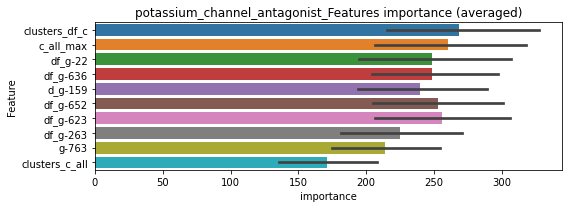

len(train_index) : 3773
len(valid_index) : 3773
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421439	valid_1's binary_logloss: 0.0667766
[200]	training's binary_logloss: 0.0139036	valid_1's binary_logloss: 0.0409872
[300]	training's binary_logloss: 0.00590653	valid_1's binary_logloss: 0.0341245
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00329186	valid_1's binary_logloss: 0.0311618


len(train_index) : 3773
len(valid_index) : 3773
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446541	valid_1's binary_logloss: 0.0688201
[200]	training's binary_logloss: 0.0146793	valid_1's binary_logloss: 0.0435681
[300]	training's binary_logloss: 0.00623573	valid_1's binary_logloss: 0.0360805


potassium_channel_antagonist logloss: 0.03203007693277126


[400]	training's binary_logloss: 0.00313266	valid_1's binary_logloss: 0.0330182
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00323584	valid_1's binary_logloss: 0.0328983


ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401


neg labels: 3289 → selected neg labels: 3269


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908478	valid_1's binary_logloss: 0.170799
[200]	training's binary_logloss: 0.0400705	valid_1's binary_logloss: 0.144396
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0370423	valid_1's binary_logloss: 0.143103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104034	valid_1's binary_logloss: 0.169789
[200]	training's binary_logloss: 0.0516336	valid_1's binary_logloss: 0.133889


1 / 3 AUC score:0.970
y_Threshold: 0.1207791, Threshold: 0.3537864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 258 → Positive_corect_labels: 590/3664
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.31841, conf_1:0.38916
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.3537864
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_2: 0.3637864


[300]	training's binary_logloss: 0.0270988	valid_1's binary_logloss: 0.124702
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.024961	valid_1's binary_logloss: 0.123193


Num_p_label: 75.0, Expected: 19.2, Adj_threshold_3: 0.3737864
Num_p_label: 72.0, Expected: 19.2, Adj_threshold_4: 0.3837864
Num_p_label: 67.0, Expected: 19.2, Adj_threshold_5: 0.3937864
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_6: 0.4037864
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_7: 0.4137864
Num_p_label: 56.0, Expected: 19.2, Adj_threshold_8: 0.4237864
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_9: 0.4337864
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_10: 0.4437864
threshold: 0.4537864, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 590.0/3664, y_label_rate: 0.1610262
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0643257	valid_1's binary_logloss: 0.103017
[200]	training's binary_logloss: 0.0210211	valid_1's binary_logloss: 0.0644466
[300]	training's binary_logloss: 0.00929438	valid_1's binary_logloss: 0.053594
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00589678	valid_1's binary_logloss: 0.0508335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574792	valid_1's binary_logloss: 0.112285
[200]	training's binary_logloss: 0.0157129	valid_1's binary_logloss: 0.068627
[300]	training's binary_logloss: 0.00649631	valid_1's binary_logloss: 0.0587184
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00394732	valid_1's binary_logloss: 0.0553442


2 / 3 AUC score:0.996
y_Threshold: 0.1757474, Threshold: 0.4537864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 560.0/3604
p_label_rate: 0.0306379 Vs.target_rate: 0.00483, Num_p_label: 122.0, conf_0:0.40841, conf_1:0.49916
Num_p_label: 122.0, Expected: 19.2, Adj_threshold_1: 0.4537864
Num_p_label: 119.0, Expected: 19.2, Adj_threshold_2: 0.4637864
Num_p_label: 118.0, Expected: 19.2, Adj_threshold_3: 0.4737864
Num_p_label: 116.0, Expected: 19.2, Adj_threshold_4: 0.4837864
Num_p_label: 113.0, Expected: 19.2, Adj_threshold_5: 0.4937864
Num_p_label: 111.0, Expected: 19.2, Adj_threshold_6: 0.5037864
Num_p_label: 109.0, Expected: 19.2, Adj_threshold_7: 0.5137864
Num_p_label: 105.0, Expected: 19.2, Adj_threshold_8: 0.5237864
Num_p_label: 99.0, Expected: 19.2, Adj_threshold_9: 0.5337864
Num_p_label: 97.0, Expected: 19.2, Adj_threshold_10: 0.5437864
threshold: 0.5537864, positive_p_label: 96.0/3982, p_label_rate: 0.0241085
positive_y_label: 560.0/3604, y_label_rate

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539619	valid_1's binary_logloss: 0.0899903
[200]	training's binary_logloss: 0.0143356	valid_1's binary_logloss: 0.049674
[300]	training's binary_logloss: 0.00574491	valid_1's binary_logloss: 0.0415841
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00368521	valid_1's binary_logloss: 0.0390274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509404	valid_1's binary_logloss: 0.094222
[200]	training's binary_logloss: 0.0129449	valid_1's binary_logloss: 0.0504364
[300]	training's binary_logloss: 0.00535383	valid_1's binary_logloss: 0.0409668
[400]	training's binary_logloss: 0.00301085	valid_1's binary_logloss: 0.0368512
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00232056	valid_1's binary_logloss: 0.0351681


3 / 3 AUC score:0.999
y_Threshold: 0.1333557, Threshold: 0.5537864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 544.0/3572
p_label_rate: 0.0374184 Vs.target_rate: 0.00483, Num_p_label: 149.0, conf_0:0.49841, conf_1:0.60916
Num_p_label: 149.0, Expected: 19.2, Adj_threshold_1: 0.5537864
Num_p_label: 145.0, Expected: 19.2, Adj_threshold_2: 0.5637864
Num_p_label: 142.0, Expected: 19.2, Adj_threshold_3: 0.5737864
Num_p_label: 141.0, Expected: 19.2, Adj_threshold_4: 0.5837864
Num_p_label: 138.0, Expected: 19.2, Adj_threshold_5: 0.5937864
Num_p_label: 135.0, Expected: 19.2, Adj_threshold_6: 0.6037864
Num_p_label: 132.0, Expected: 19.2, Adj_threshold_7: 0.6137864
Num_p_label: 129.0, Expected: 19.2, Adj_threshold_8: 0.6237864
Num_p_label: 124.0, Expected: 19.2, Adj_threshold_9: 0.6337864
Num_p_label: 122.0, Expected: 19.2, Adj_threshold_10: 0.6437864
threshold: 0.6537864, positive_p_label: 120.0/3982, p_label_rate: 0.0301356
positive_y_label: 664.0/7554, y_label_r

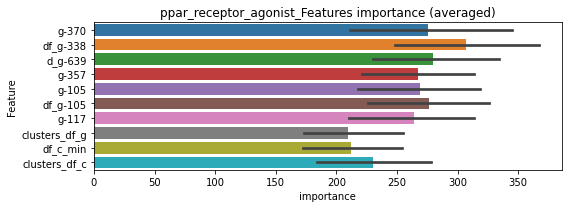

len(train_index) : 3777
len(valid_index) : 3777
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348509	valid_1's binary_logloss: 0.0567366
[200]	training's binary_logloss: 0.010341	valid_1's binary_logloss: 0.033744
[300]	training's binary_logloss: 0.00449705	valid_1's binary_logloss: 0.0286799
[400]	training's binary_logloss: 0.00242453	valid_1's binary_logloss: 0.0259511
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00233889	valid_1's binary_logloss: 0.0257597


len(train_index) : 3777
len(valid_index) : 3777
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347005	valid_1's binary_logloss: 0.0691626
[200]	training's binary_logloss: 0.0105445	valid_1's binary_logloss: 0.0436809
[300]	training's binary_logloss: 0.00432975	valid_1's binary_logloss: 0.0366268
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00264583	valid_1's binary_logloss: 0.0345656


ppar_receptor_agonist logloss: 0.03016265468072329
ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345298	valid_1's binary_logloss: 0.0500132
[200]	training's binary_logloss: 0.00499915	valid_1's binary_logloss: 0.0122834
[300]	training's binary_logloss: 0.00136931	valid_1's binary_logloss: 0.00529526
[400]	training's binary_logloss: 0.000666616	valid_1's binary_logloss: 0.00359555
[500]	training's binary_logloss: 0.000456875	valid_1's binary_logloss: 0.00295959
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000417551	valid_1's binary_logloss: 0.00284604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333882	valid_1's binary_logloss: 0.0595083
[200]	training's binary_logloss: 0.00491101	valid_1's binary_logloss: 0.0224411
[300]	training's binary_logloss: 0.00135431	valid_1's binary_logloss: 0.014246
[400]	training's binary_logloss: 0.000663969	valid_1's binary_logloss: 0.0117322
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0030706, Threshold: 0.0054895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00494, conf_1:0.00604
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0054895
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.0154895
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.0254895
threshold: 0.0254895, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334976	valid_1's binary_logloss: 0.048012
[200]	training's binary_logloss: 0.00482228	valid_1's binary_logloss: 0.0117828
[300]	training's binary_logloss: 0.00132866	valid_1's binary_logloss: 0.00534875
[400]	training's binary_logloss: 0.000655939	valid_1's binary_logloss: 0.00363498
[500]	training's binary_logloss: 0.000453287	valid_1's binary_logloss: 0.00301761
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00042976	valid_1's binary_logloss: 0.00294279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327373	valid_1's binary_logloss: 0.0565169
[200]	training's binary_logloss: 0.0046528	valid_1's binary_logloss: 0.0195497
[300]	training's binary_logloss: 0.00130907	valid_1's binary_logloss: 0.0123485
[400]	training's binary_logloss: 0.000653763	valid_1's binary_logloss: 0.0101915
Early stopping, best iteration is:
[466]

2 / 3 AUC score:1.000
y_Threshold: 0.0315919, Threshold: 0.0254895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0057760 Vs.target_rate: 0.00126, Num_p_label: 23.0, conf_0:0.02294, conf_1:0.02804
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_1: 0.0254895
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.0354895
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0454895
threshold: 0.0454895, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334976	valid_1's binary_logloss: 0.048012
[200]	training's binary_logloss: 0.00482228	valid_1's binary_logloss: 0.0117828
[300]	training's binary_logloss: 0.00132866	valid_1's binary_logloss: 0.00534875
[400]	training's binary_logloss: 0.000655939	valid_1's binary_logloss: 0.00363498
[500]	training's binary_logloss: 0.000453287	valid_1's binary_logloss: 0.00301761
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00042976	valid_1's binary_logloss: 0.00294279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327373	valid_1's binary_logloss: 0.0565169
[200]	training's binary_logloss: 0.0046528	valid_1's binary_logloss: 0.0195497
[300]	training's binary_logloss: 0.00130907	valid_1's binary_logloss: 0.0123485
[400]	training's binary_logloss: 0.000653763	valid_1's binary_logloss: 0.0101915
Early stopping, best iteration is:
[466]

3 / 3 AUC score:1.000
y_Threshold: 0.0315919, Threshold: 0.0454895, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.04094, conf_1:0.05004
threshold: 0.0454895, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


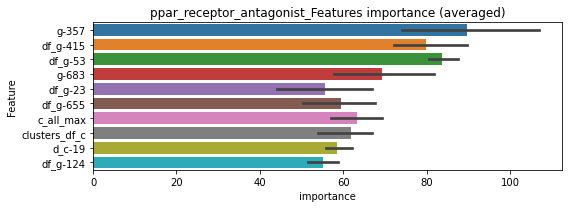

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186011	valid_1's binary_logloss: 0.0339611
[200]	training's binary_logloss: 0.00267398	valid_1's binary_logloss: 0.0166807
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00163511	valid_1's binary_logloss: 0.015868


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187226	valid_1's binary_logloss: 0.0326014
[200]	training's binary_logloss: 0.00277167	valid_1's binary_logloss: 0.0155136
[300]	training's binary_logloss: 0.00076598	valid_1's binary_logloss: 0.0118811
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000456404	valid_1's binary_logloss: 0.0110714


ppar_receptor_antagonist logloss: 0.013469675659067313
progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124646	valid_1's binary_logloss: 0.20818
[200]	training's binary_logloss: 0.0705217	valid_1's binary_logloss: 0.183528
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.042865	valid_1's binary_logloss: 0.177757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128062	valid_1's binary_logloss: 0.195686
[200]	training's binary_logloss: 0.0716628	valid_1's binary_logloss: 0.167367


1 / 3 AUC score:0.948
y_Threshold: 0.1427769, Threshold: 0.2936840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 341 → Positive_corect_labels: 549/3584
p_label_rate: 0.0200904 Vs.target_rate: 0.00500, Num_p_label: 80.0, conf_0:0.26432, conf_1:0.32305
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.2936840
Num_p_label: 74.0, Expected: 19.9, Adj_threshold_2: 0.3036840
Num_p_label: 66.0, Expected: 19.9, Adj_threshold_3: 0.3136840
Num_p_label: 62.0, Expected: 19.9, Adj_threshold_4: 0.3236840
Num_p_label: 59.0, Expected: 19.9, Adj_threshold_5: 0.3336840
Num_p_label: 53.0, Expected: 19.9, Adj_threshold_6: 0.3436840
Num_p_label: 50.0, Expected: 19.9, Adj_threshold_7: 0.3536840
Num_p_label: 47.0, Expected: 19.9, Adj_threshold_8: 0.3636840
Num_p_label: 43.0, Expected: 19.9, Adj_threshold_9: 0.3736840
Num_p_label: 39.0, Expected: 19.9, Adj_threshold_10: 0.3836840
threshold: 0.3836840, positive_p_label: 39.0/3982, p_label_rate: 0.0097941


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0472852	valid_1's binary_logloss: 0.159764


positive_y_label: 549.0/3584, y_label_rate: 0.1531808
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663994	valid_1's binary_logloss: 0.109262
[200]	training's binary_logloss: 0.0237025	valid_1's binary_logloss: 0.0773857
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0130511	valid_1's binary_logloss: 0.0696933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077694	valid_1's binary_logloss: 0.125097
[200]	training's binary_logloss: 0.0284867	valid_1's binary_logloss: 0.0828015
[300]	training's binary_logloss: 0.0123225	valid_1's binary_logloss: 0.0694655
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0109024	valid_1's binary_logloss: 0.0677376


2 / 3 AUC score:0.993
y_Threshold: 0.1830072, Threshold: 0.3836840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 512.0/3510
p_label_rate: 0.0215972 Vs.target_rate: 0.00500, Num_p_label: 86.0, conf_0:0.34532, conf_1:0.42205
Num_p_label: 86.0, Expected: 19.9, Adj_threshold_1: 0.3836840
Num_p_label: 83.0, Expected: 19.9, Adj_threshold_2: 0.3936840
Num_p_label: 81.0, Expected: 19.9, Adj_threshold_3: 0.4036840
Num_p_label: 79.0, Expected: 19.9, Adj_threshold_4: 0.4136840
Num_p_label: 79.0, Expected: 19.9, Adj_threshold_5: 0.4236840
Num_p_label: 74.0, Expected: 19.9, Adj_threshold_6: 0.4336840
Num_p_label: 72.0, Expected: 19.9, Adj_threshold_7: 0.4436840
Num_p_label: 70.0, Expected: 19.9, Adj_threshold_8: 0.4536840
Num_p_label: 70.0, Expected: 19.9, Adj_threshold_9: 0.4636840
Num_p_label: 67.0, Expected: 19.9, Adj_threshold_10: 0.4736840
threshold: 0.4836840, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 512.0/3510, y_label_rate: 0.14586

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539242	valid_1's binary_logloss: 0.0884472
[200]	training's binary_logloss: 0.015336	valid_1's binary_logloss: 0.0487368
[300]	training's binary_logloss: 0.00619248	valid_1's binary_logloss: 0.0378139
[400]	training's binary_logloss: 0.00326383	valid_1's binary_logloss: 0.0325122
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00297013	valid_1's binary_logloss: 0.0320516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059413	valid_1's binary_logloss: 0.0891735
[200]	training's binary_logloss: 0.0182278	valid_1's binary_logloss: 0.0491881
[300]	training's binary_logloss: 0.00762821	valid_1's binary_logloss: 0.0383437


3 / 3 AUC score:0.999
y_Threshold: 0.1787536, Threshold: 0.4836840, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 495.0/3476
p_label_rate: 0.0198393 Vs.target_rate: 0.00500, Num_p_label: 79.0, conf_0:0.43532, conf_1:0.53205
Num_p_label: 79.0, Expected: 19.9, Adj_threshold_1: 0.4836840
Num_p_label: 77.0, Expected: 19.9, Adj_threshold_2: 0.4936840
Num_p_label: 77.0, Expected: 19.9, Adj_threshold_3: 0.5036840
Num_p_label: 74.0, Expected: 19.9, Adj_threshold_4: 0.5136840
Num_p_label: 71.0, Expected: 19.9, Adj_threshold_5: 0.5236840
Num_p_label: 67.0, Expected: 19.9, Adj_threshold_6: 0.5336840
Num_p_label: 67.0, Expected: 19.9, Adj_threshold_7: 0.5436840
Num_p_label: 66.0, Expected: 19.9, Adj_threshold_8: 0.5536840


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0045672	valid_1's binary_logloss: 0.0353178


Num_p_label: 65.0, Expected: 19.9, Adj_threshold_9: 0.5636840
Num_p_label: 64.0, Expected: 19.9, Adj_threshold_10: 0.5736840
threshold: 0.5836840, positive_p_label: 63.0/3982, p_label_rate: 0.0158212
positive_y_label: 558.0/7458, y_label_rate: 0.0748190


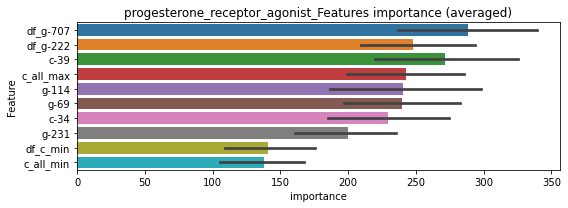

len(train_index) : 3729
len(valid_index) : 3729
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359404	valid_1's binary_logloss: 0.0634264
[200]	training's binary_logloss: 0.011125	valid_1's binary_logloss: 0.0402249
[300]	training's binary_logloss: 0.00449229	valid_1's binary_logloss: 0.034258
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00270763	valid_1's binary_logloss: 0.0327848


len(train_index) : 3729
len(valid_index) : 3729
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373575	valid_1's binary_logloss: 0.0585878
[200]	training's binary_logloss: 0.0117805	valid_1's binary_logloss: 0.0359582
[300]	training's binary_logloss: 0.00472691	valid_1's binary_logloss: 0.0283759
[400]	training's binary_logloss: 0.00241342	valid_1's binary_logloss: 0.0265925
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00255024	valid_1's binary_logloss: 0.0265557


progesterone_receptor_agonist logloss: 0.029670234981505884
progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220361	valid_1's binary_logloss: 0.0313598
[200]	training's binary_logloss: 0.002519	valid_1's binary_logloss: 0.00709468
[300]	training's binary_logloss: 0.000712392	valid_1's binary_logloss: 0.0038407
[400]	training's binary_logloss: 0.000383337	valid_1's binary_logloss: 0.00301679
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000325081	valid_1's binary_logloss: 0.0028401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229906	valid_1's binary_logloss: 0.0306549
[200]	training's binary_logloss: 0.00266431	valid_1's binary_logloss: 0.00447758
[300]	training's binary_logloss: 0.000752519	valid_1's binary_logloss: 0.00158114
[400]	training's binary_logloss: 0.000406244	valid_1's binary_logloss: 0.00100181
[500]	training's binary_logloss: 0.00032156	valid_1's binary_logloss: 0.000832093
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0014316, Threshold: 0.0026288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00237, conf_1:0.00289
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0026288
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0126288
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0226288
threshold: 0.0226288, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.0314801
[200]	training's binary_logloss: 0.00251957	valid_1's binary_logloss: 0.00799698
[300]	training's binary_logloss: 0.000713161	valid_1's binary_logloss: 0.00494574
[400]	training's binary_logloss: 0.000383622	valid_1's binary_logloss: 0.00398782
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000345642	valid_1's binary_logloss: 0.00385316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226879	valid_1's binary_logloss: 0.0305854
[200]	training's binary_logloss: 0.00255929	valid_1's binary_logloss: 0.00429204
[300]	training's binary_logloss: 0.000720203	valid_1's binary_logloss: 0.00147626
[400]	training's binary_logloss: 0.00039488	valid_1's binary_logloss: 0.000926902
[500]	training's binary_logloss: 0.000314224	valid_1's binary_logloss: 0.000766746
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0330615, Threshold: 0.0226288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.02037, conf_1:0.02489
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0226288
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0326288
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0426288
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0526288
threshold: 0.0526288, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222337	valid_1's binary_logloss: 0.0314801
[200]	training's binary_logloss: 0.00251957	valid_1's binary_logloss: 0.00799698
[300]	training's binary_logloss: 0.000713161	valid_1's binary_logloss: 0.00494574
[400]	training's binary_logloss: 0.000383622	valid_1's binary_logloss: 0.00398782
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000345642	valid_1's binary_logloss: 0.00385316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226879	valid_1's binary_logloss: 0.0305854
[200]	training's binary_logloss: 0.00255929	valid_1's binary_logloss: 0.00429204
[300]	training's binary_logloss: 0.000720203	valid_1's binary_logloss: 0.00147626
[400]	training's binary_logloss: 0.00039488	valid_1's binary_logloss: 0.000926902
[500]	training's binary_logloss: 0.000314224	valid_1's binary_logloss: 0.000766746
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0330615, Threshold: 0.0526288, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.04737, conf_1:0.05789
threshold: 0.0526288, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


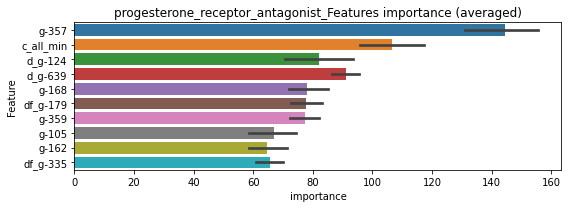

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118997	valid_1's binary_logloss: 0.0183929
[200]	training's binary_logloss: 0.00131815	valid_1's binary_logloss: 0.00668436
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000458683	valid_1's binary_logloss: 0.00591143


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120612	valid_1's binary_logloss: 0.0188203
[200]	training's binary_logloss: 0.00142094	valid_1's binary_logloss: 0.00516486
[300]	training's binary_logloss: 0.000399494	valid_1's binary_logloss: 0.00290094
[400]	training's binary_logloss: 0.000212149	valid_1's binary_logloss: 0.00229876
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000170385	valid_1's binary_logloss: 0.00210957


progesterone_receptor_antagonist logloss: 0.004010744128576415
prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355139	valid_1's binary_logloss: 0.0590154
[200]	training's binary_logloss: 0.00590342	valid_1's binary_logloss: 0.0184633
[300]	training's binary_logloss: 0.00162435	valid_1's binary_logloss: 0.00980641
[400]	training's binary_logloss: 0.00079491	valid_1's binary_logloss: 0.0072808
[500]	training's binary_logloss: 0.000525515	valid_1's binary_logloss: 0.0062695
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000513231	valid_1's binary_logloss: 0.00622413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369096	valid_1's binary_logloss: 0.0663922
[200]	training's binary_logloss: 0.00579998	valid_1's binary_logloss: 0.02936
[300]	training's binary_logloss: 0.00161649	valid_1's binary_logloss: 0.0206962
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00115502	valid_1's binary_logloss: 0.0194673


1 / 3 AUC score:1.000
y_Threshold: 0.0053597, Threshold: 0.0071075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00640, conf_1:0.00782
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0071075
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0171075
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.0271075
threshold: 0.0271075, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363754	valid_1's binary_logloss: 0.0568422
[200]	training's binary_logloss: 0.00549453	valid_1's binary_logloss: 0.0168193
[300]	training's binary_logloss: 0.00157326	valid_1's binary_logloss: 0.0100772
[400]	training's binary_logloss: 0.000773671	valid_1's binary_logloss: 0.00849596
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00063585	valid_1's binary_logloss: 0.00820205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347587	valid_1's binary_logloss: 0.0617173
[200]	training's binary_logloss: 0.00530323	valid_1's binary_logloss: 0.0204691
[300]	training's binary_logloss: 0.0015074	valid_1's binary_logloss: 0.0123606
[400]	training's binary_logloss: 0.000747124	valid_1's binary_logloss: 0.00977053
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000646755	valid_1's binary_logloss: 0.00931315


2 / 3 AUC score:1.000
y_Threshold: 0.0414924, Threshold: 0.0271075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0040181 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.02440, conf_1:0.02982
threshold: 0.0271075, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03595	valid_1's binary_logloss: 0.0553229
[200]	training's binary_logloss: 0.0056238	valid_1's binary_logloss: 0.015191
[300]	training's binary_logloss: 0.00159245	valid_1's binary_logloss: 0.00709149
[400]	training's binary_logloss: 0.000784071	valid_1's binary_logloss: 0.00525139
[500]	training's binary_logloss: 0.000528203	valid_1's binary_logloss: 0.00451429
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000492109	valid_1's binary_logloss: 0.00446275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345454	valid_1's binary_logloss: 0.0611312
[200]	training's binary_logloss: 0.00514717	valid_1's binary_logloss: 0.0204138
[300]	training's binary_logloss: 0.00148259	valid_1's binary_logloss: 0.0127669
[400]	training's binary_logloss: 0.000738765	valid_1's binary_logloss: 0.0104606
Early stopping, best iteration is:
[476]	

3 / 3 AUC score:1.000
y_Threshold: 0.0397558, Threshold: 0.0271075, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.02440, conf_1:0.02982
threshold: 0.0271075, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 664.0/7783, y_label_rate: 0.0853141


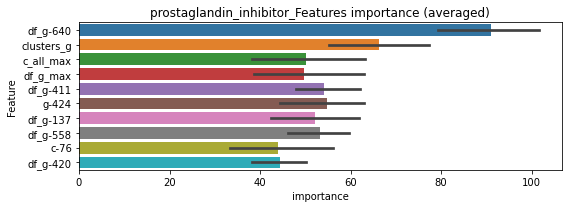

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178019	valid_1's binary_logloss: 0.0395593
[200]	training's binary_logloss: 0.00275833	valid_1's binary_logloss: 0.0197895
[300]	training's binary_logloss: 0.000793161	valid_1's binary_logloss: 0.0169118
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000649122	valid_1's binary_logloss: 0.0165289


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202484	valid_1's binary_logloss: 0.0369523
[200]	training's binary_logloss: 0.0030793	valid_1's binary_logloss: 0.0140642
[300]	training's binary_logloss: 0.000865829	valid_1's binary_logloss: 0.0100668
[400]	training's binary_logloss: 0.00041667	valid_1's binary_logloss: 0.00891623
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000369014	valid_1's binary_logloss: 0.00871935


prostaglandin_inhibitor logloss: 0.012624629280449775
prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294


neg labels: 3289 → selected neg labels: 3274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876439	valid_1's binary_logloss: 0.143336
[200]	training's binary_logloss: 0.0399693	valid_1's binary_logloss: 0.117988
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0274746	valid_1's binary_logloss: 0.112017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922741	valid_1's binary_logloss: 0.12323
[200]	training's binary_logloss: 0.0451384	valid_1's binary_logloss: 0.0947799
[300]	training's binary_logloss: 0.0228022	valid_1's binary_logloss: 0.0857974


1 / 3 AUC score:0.979
y_Threshold: 0.0880805, Threshold: 0.1444702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 234 → Positive_corect_labels: 603/3694
p_label_rate: 0.0200904 Vs.target_rate: 0.00353, Num_p_label: 80.0, conf_0:0.13002, conf_1:0.15892
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.1444702
Num_p_label: 68.0, Expected: 14.0, Adj_threshold_2: 0.1544702
Num_p_label: 62.0, Expected: 14.0, Adj_threshold_3: 0.1644702
Num_p_label: 55.0, Expected: 14.0, Adj_threshold_4: 0.1744702
Num_p_label: 43.0, Expected: 14.0, Adj_threshold_5: 0.1844702
Num_p_label: 39.0, Expected: 14.0, Adj_threshold_6: 0.1944702
Num_p_label: 32.0, Expected: 14.0, Adj_threshold_7: 0.2044702
Num_p_label: 29.0, Expected: 14.0, Adj_threshold_8: 0.2144702
Num_p_label: 26.0, Expected: 14.0, Adj_threshold_9: 0.2244702


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0176212	valid_1's binary_logloss: 0.0846675


threshold: 0.2244702, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 603.0/3694, y_label_rate: 0.1632377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539061	valid_1's binary_logloss: 0.10133
[200]	training's binary_logloss: 0.016907	valid_1's binary_logloss: 0.0730341
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0101419	valid_1's binary_logloss: 0.0690768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634603	valid_1's binary_logloss: 0.0878764
[200]	training's binary_logloss: 0.0205565	valid_1's binary_logloss: 0.0516714


2 / 3 AUC score:0.993
y_Threshold: 0.1347466, Threshold: 0.2244702, pos_neg_ratio: 0.8000000


[300]	training's binary_logloss: 0.00839616	valid_1's binary_logloss: 0.0427507
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00632311	valid_1's binary_logloss: 0.0416578


Remove_noisy_labels: 62 → Positive_corect_labels: 572.0/3632
p_label_rate: 0.0095429 Vs.target_rate: 0.00353, Num_p_label: 38.0, conf_0:0.20202, conf_1:0.24692
threshold: 0.2244702, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 572.0/3632, y_label_rate: 0.1574890
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045851	valid_1's binary_logloss: 0.0715294
[200]	training's binary_logloss: 0.0123599	valid_1's binary_logloss: 0.0346583
[300]	training's binary_logloss: 0.00502061	valid_1's binary_logloss: 0.0259209
[400]	training's binary_logloss: 0.00264155	valid_1's binary_logloss: 0.0225854
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00264155	valid_1's binary_logloss: 0.0225854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461258	valid_1's binary_logloss: 0.0691289
[200]	training's binary_logloss: 0.013317	valid_1's binary_logloss: 0.0375526
[300]	training's binary_logloss: 0.0048973	valid_1's binary_logloss: 0.0300278
[400]	training's binary_logloss: 0.00264107	valid_1's binary_logloss: 0.0273551


3 / 3 AUC score:0.999
y_Threshold: 0.0926324, Threshold: 0.2244702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 562.0/3612
p_label_rate: 0.0070316 Vs.target_rate: 0.00353, Num_p_label: 28.0, conf_0:0.20202, conf_1:0.24692
threshold: 0.2244702, positive_p_label: 28.0/3982, p_label_rate: 0.0070316


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00198773	valid_1's binary_logloss: 0.0268042


positive_y_label: 590.0/7594, y_label_rate: 0.0776929


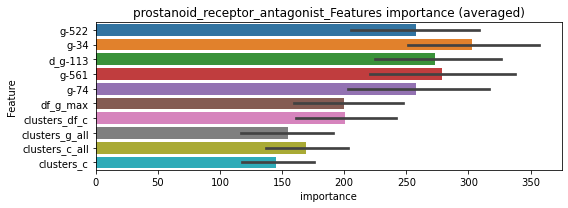

len(train_index) : 3797
len(valid_index) : 3797
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272192	valid_1's binary_logloss: 0.0395779
[200]	training's binary_logloss: 0.00821607	valid_1's binary_logloss: 0.0220629


len(train_index) : 3797
len(valid_index) : 3797
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00576179	valid_1's binary_logloss: 0.0203536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263405	valid_1's binary_logloss: 0.0448346
[200]	training's binary_logloss: 0.00744406	valid_1's binary_logloss: 0.0270916


prostanoid_receptor_antagonist logloss: 0.022287544035734158


[300]	training's binary_logloss: 0.00305557	valid_1's binary_logloss: 0.0243163
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00279926	valid_1's binary_logloss: 0.0242215


proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


neg labels: 3289 → selected neg labels: 3285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020979	valid_1's binary_logloss: 0.0236758
[200]	training's binary_logloss: 0.00200828	valid_1's binary_logloss: 0.00687922
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000990366	valid_1's binary_logloss: 0.00584641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194643	valid_1's binary_logloss: 0.0282181
[200]	training's binary_logloss: 0.00187077	valid_1's binary_logloss: 0.0123994
[300]	training's binary_logloss: 0.000437351	valid_1's binary_logloss: 0.010749
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000455901	valid_1's binary_logloss: 0.0107215


1 / 3 AUC score:1.000
y_Threshold: 0.0003578, Threshold: 0.9986985, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049, Num_p_label: 80.0, conf_0:0.89883, conf_1:1.09857
threshold: 0.9986985, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156085	valid_1's binary_logloss: 0.0160616
[200]	training's binary_logloss: 0.00100649	valid_1's binary_logloss: 0.00137232
[300]	training's binary_logloss: 0.000221792	valid_1's binary_logloss: 0.000572287
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00017147	valid_1's binary_logloss: 0.000511025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157067	valid_1's binary_logloss: 0.0163062
[200]	training's binary_logloss: 0.00101882	valid_1's binary_logloss: 0.00124747
[300]	training's binary_logloss: 0.000224852	valid_1's binary_logloss: 0.000412599
[400]	training's binary_logloss: 0.000148419	valid_1's binary_logloss: 0.000320927
[500]	training's binary_logloss: 0.000133704	valid_1's binary_logloss: 0.00030336


2 / 3 AUC score:1.000
y_Threshold: 0.5401972, Threshold: 0.9986985, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0379206 Vs.target_rate: 0.03049, Num_p_label: 151.0, conf_0:0.89883, conf_1:1.09857
threshold: 0.9986985, positive_p_label: 151.0/3982, p_label_rate: 0.0379206


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000130916	valid_1's binary_logloss: 0.000300934


positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156085	valid_1's binary_logloss: 0.0160616
[200]	training's binary_logloss: 0.00100649	valid_1's binary_logloss: 0.00137232
[300]	training's binary_logloss: 0.000221792	valid_1's binary_logloss: 0.000572287
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00017147	valid_1's binary_logloss: 0.000511025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157067	valid_1's binary_logloss: 0.0163062
[200]	training's binary_logloss: 0.00101882	valid_1's binary_logloss: 0.00124747
[300]	training's binary_logloss: 0.000224852	valid_1's binary_logloss: 0.000412599
[400]	training's binary_logloss: 0.000148419	valid_1's binary_logloss: 0.000320927
[500]	training's binary_logloss: 0.000133704	valid_1's binary_logloss: 0.00030336


3 / 3 AUC score:1.000
y_Threshold: 0.5401972, Threshold: 0.9986985, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.000130916	valid_1's binary_logloss: 0.000300934


p_label_rate: 0.0379206 Vs.target_rate: 0.03049, Num_p_label: 151.0, conf_0:0.89883, conf_1:1.09857
threshold: 0.9986985, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 877.0/7832, y_label_rate: 0.1119765


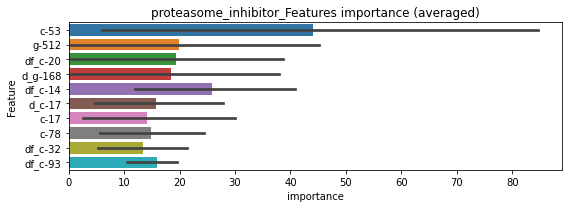

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111929	valid_1's binary_logloss: 0.012564
[200]	training's binary_logloss: 0.000834663	valid_1's binary_logloss: 0.00332386


len(train_index) : 3916
len(valid_index) : 3916


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000587389	valid_1's binary_logloss: 0.00321659


================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109379	valid_1's binary_logloss: 0.0130087
[200]	training's binary_logloss: 0.000811038	valid_1's binary_logloss: 0.00407436


proteasome_inhibitor logloss: 0.0035710118715304336


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000369604	valid_1's binary_logloss: 0.00392544


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041592	valid_1's binary_logloss: 0.0719387
[200]	training's binary_logloss: 0.00741836	valid_1's binary_logloss: 0.0262959
[300]	training's binary_logloss: 0.00219127	valid_1's binary_logloss: 0.0153091
[400]	training's binary_logloss: 0.00103623	valid_1's binary_logloss: 0.0117121
[500]	training's binary_logloss: 0.00065691	valid_1's binary_logloss: 0.010215
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000668891	valid_1's binary_logloss: 0.0101883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423253	valid_1's binary_logloss: 0.0727404
[200]	training's binary_logloss: 0.00784675	valid_1's binary_logloss: 0.0269683
[300]	training's binary_logloss: 0.00226208	valid_1's binary_logloss: 0.0163904
[400]	training's binary_logloss: 0.00106099	valid_1's binary_logloss: 0.0129506
[500]	training's binary_logloss: 0.000684379	v

1 / 3 AUC score:1.000
y_Threshold: 0.0053962, Threshold: 0.0107903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00971, conf_1:0.01187
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0107903
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.0207903
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0307903
threshold: 0.0307903, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414134	valid_1's binary_logloss: 0.073209
[200]	training's binary_logloss: 0.00723545	valid_1's binary_logloss: 0.0263426
[300]	training's binary_logloss: 0.00210679	valid_1's binary_logloss: 0.0144831
[400]	training's binary_logloss: 0.00100747	valid_1's binary_logloss: 0.0109983
[500]	training's binary_logloss: 0.000650563	valid_1's binary_logloss: 0.00966423
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000552635	valid_1's binary_logloss: 0.00925148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432588	valid_1's binary_logloss: 0.0725033
[200]	training's binary_logloss: 0.00746312	valid_1's binary_logloss: 0.0246192
[300]	training's binary_logloss: 0.00216575	valid_1's binary_logloss: 0.015061
[400]	training's binary_logloss: 0.00104075	valid_1's binary_logloss: 0.0120598
[500]	training's binary_logloss: 0.00066864

2 / 3 AUC score:1.000
y_Threshold: 0.0410791, Threshold: 0.0307903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0105475 Vs.target_rate: 0.00202, Num_p_label: 42.0, conf_0:0.02771, conf_1:0.03387
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_1: 0.0307903
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.0407903
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_3: 0.0507903
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.0607903
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.0707903
threshold: 0.0707903, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424299	valid_1's binary_logloss: 0.0759908
[200]	training's binary_logloss: 0.00741595	valid_1's binary_logloss: 0.0301622
[300]	training's binary_logloss: 0.00215775	valid_1's binary_logloss: 0.0197045
[400]	training's binary_logloss: 0.00103675	valid_1's binary_logloss: 0.0161447
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00071643	valid_1's binary_logloss: 0.0149237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408565	valid_1's binary_logloss: 0.0740553
[200]	training's binary_logloss: 0.00691793	valid_1's binary_logloss: 0.0279647
[300]	training's binary_logloss: 0.00202406	valid_1's binary_logloss: 0.0177827
[400]	training's binary_logloss: 0.000989041	valid_1's binary_logloss: 0.0140975
[500]	training's binary_logloss: 0.000645804	valid_1's binary_logloss: 0.0128069
Early stopping, best iteration is:
[521]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0327540, Threshold: 0.0707903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0045203 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.06371, conf_1:0.07787
threshold: 0.0707903, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 671.0/7781, y_label_rate: 0.0862357


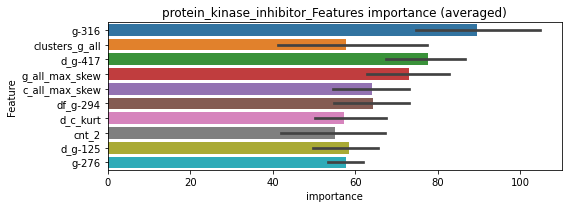

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241665	valid_1's binary_logloss: 0.0492432
[200]	training's binary_logloss: 0.00418732	valid_1's binary_logloss: 0.0227826
[300]	training's binary_logloss: 0.00117687	valid_1's binary_logloss: 0.0166006
[400]	training's binary_logloss: 0.000549272	valid_1's binary_logloss: 0.0150275
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000527982	valid_1's binary_logloss: 0.0149487


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227799	valid_1's binary_logloss: 0.0437289
[200]	training's binary_logloss: 0.00404921	valid_1's binary_logloss: 0.0195778
[300]	training's binary_logloss: 0.00118262	valid_1's binary_logloss: 0.0145703
[400]	training's binary_logloss: 0.000560753	valid_1's binary_logloss: 0.012914
[500]	training's binary_logloss: 0.000358888	valid_1's binary_logloss: 0.0123459
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000358888	valid_1's binary_logloss: 0.0123459


protein_kinase_inhibitor logloss: 0.013647476512030701
protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268107	valid_1's binary_logloss: 0.0422931
[200]	training's binary_logloss: 0.00351481	valid_1's binary_logloss: 0.0100689
[300]	training's binary_logloss: 0.000994627	valid_1's binary_logloss: 0.00526183
[400]	training's binary_logloss: 0.000507102	valid_1's binary_logloss: 0.00358303
[500]	training's binary_logloss: 0.000374715	valid_1's binary_logloss: 0.00301362
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000378584	valid_1's binary_logloss: 0.00299096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026532	valid_1's binary_logloss: 0.0401469
[200]	training's binary_logloss: 0.00344126	valid_1's binary_logloss: 0.00917849
[300]	training's binary_logloss: 0.000988997	valid_1's binary_logloss: 0.00433269
[400]	training's binary_logloss: 0.000507428	valid_1's binary_logloss: 0.00314175
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0023067, Threshold: 0.0036278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101, Num_p_label: 80.0, conf_0:0.00327, conf_1:0.00399
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0036278
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0136278
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.0236278
threshold: 0.0236278, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263985	valid_1's binary_logloss: 0.039576
[200]	training's binary_logloss: 0.00334542	valid_1's binary_logloss: 0.0082418
[300]	training's binary_logloss: 0.00095113	valid_1's binary_logloss: 0.00372738
[400]	training's binary_logloss: 0.00049189	valid_1's binary_logloss: 0.00245934
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000392552	valid_1's binary_logloss: 0.00214921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261348	valid_1's binary_logloss: 0.0382469
[200]	training's binary_logloss: 0.00331874	valid_1's binary_logloss: 0.007826
[300]	training's binary_logloss: 0.000945227	valid_1's binary_logloss: 0.00347631
[400]	training's binary_logloss: 0.000494111	valid_1's binary_logloss: 0.00249196
[500]	training's binary_logloss: 0.000367179	valid_1's binary_logloss: 0.00222442
Early stopping, best iteration is:
[5

2 / 3 AUC score:1.000
y_Threshold: 0.0646076, Threshold: 0.0236278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.02127, conf_1:0.02599
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.0236278
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.0336278
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.0436278
threshold: 0.0436278, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263985	valid_1's binary_logloss: 0.039576
[200]	training's binary_logloss: 0.00334542	valid_1's binary_logloss: 0.0082418
[300]	training's binary_logloss: 0.00095113	valid_1's binary_logloss: 0.00372738
[400]	training's binary_logloss: 0.00049189	valid_1's binary_logloss: 0.00245934
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000392552	valid_1's binary_logloss: 0.00214921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261348	valid_1's binary_logloss: 0.0382469
[200]	training's binary_logloss: 0.00331874	valid_1's binary_logloss: 0.007826
[300]	training's binary_logloss: 0.000945227	valid_1's binary_logloss: 0.00347631
[400]	training's binary_logloss: 0.000494111	valid_1's binary_logloss: 0.00249196
[500]	training's binary_logloss: 0.000367179	valid_1's binary_logloss: 0.00222442
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
y_Threshold: 0.0646076, Threshold: 0.0436278, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.03927, conf_1:0.04799
threshold: 0.0436278, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


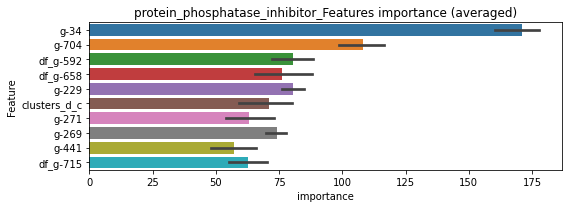

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144759	valid_1's binary_logloss: 0.0245498
[200]	training's binary_logloss: 0.00178139	valid_1's binary_logloss: 0.0085869
[300]	training's binary_logloss: 0.000497905	valid_1's binary_logloss: 0.00624564
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000396553	valid_1's binary_logloss: 0.00602487


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148866	valid_1's binary_logloss: 0.0203835
[200]	training's binary_logloss: 0.00191207	valid_1's binary_logloss: 0.00472837
[300]	training's binary_logloss: 0.000538369	valid_1's binary_logloss: 0.00268498
[400]	training's binary_logloss: 0.000271146	valid_1's binary_logloss: 0.0022579
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000246588	valid_1's binary_logloss: 0.00221672


protein_phosphatase_inhibitor logloss: 0.004121038965224176
protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950753	valid_1's binary_logloss: 0.148855
[200]	training's binary_logloss: 0.0465183	valid_1's binary_logloss: 0.123388
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0387191	valid_1's binary_logloss: 0.121797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102156	valid_1's binary_logloss: 0.163061
[200]	training's binary_logloss: 0.0478551	valid_1's binary_logloss: 0.126451


1 / 3 AUC score:0.972
y_Threshold: 0.0957820, Threshold: 0.3707198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 247 → Positive_corect_labels: 596/3678
p_label_rate: 0.0200904 Vs.target_rate: 0.00433, Num_p_label: 80.0, conf_0:0.33365, conf_1:0.40779
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.3707198
Num_p_label: 76.0, Expected: 17.2, Adj_threshold_2: 0.3807198
Num_p_label: 73.0, Expected: 17.2, Adj_threshold_3: 0.3907198


[300]	training's binary_logloss: 0.0240709	valid_1's binary_logloss: 0.116567
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0218944	valid_1's binary_logloss: 0.115153


Num_p_label: 71.0, Expected: 17.2, Adj_threshold_4: 0.4007198
Num_p_label: 71.0, Expected: 17.2, Adj_threshold_5: 0.4107198
Num_p_label: 67.0, Expected: 17.2, Adj_threshold_6: 0.4207198
Num_p_label: 67.0, Expected: 17.2, Adj_threshold_7: 0.4307198
Num_p_label: 65.0, Expected: 17.2, Adj_threshold_8: 0.4407198
Num_p_label: 63.0, Expected: 17.2, Adj_threshold_9: 0.4507198
Num_p_label: 58.0, Expected: 17.2, Adj_threshold_10: 0.4607198
threshold: 0.4707198, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 596.0/3678, y_label_rate: 0.1620446
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679463	valid_1's binary_logloss: 0.0971484
[200]	training's binary_logloss: 0.0214049	valid_1's binary_logloss: 0.0543991
[300]	training's binary_logloss: 0.00866127	valid_1's binary_logloss: 0.0447178
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00792702	valid_1's binary_logloss: 0.0442254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642571	valid_1's binary_logloss: 0.110274
[200]	training's binary_logloss: 0.0219114	valid_1's binary_logloss: 0.0705697
[300]	training's binary_logloss: 0.00938098	valid_1's binary_logloss: 0.0589248


2 / 3 AUC score:0.997
y_Threshold: 0.1660031, Threshold: 0.4707198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 569.0/3624
p_label_rate: 0.0273732 Vs.target_rate: 0.00433, Num_p_label: 109.0, conf_0:0.42365, conf_1:0.51779
Num_p_label: 109.0, Expected: 17.2, Adj_threshold_1: 0.4707198
Num_p_label: 107.0, Expected: 17.2, Adj_threshold_2: 0.4807198
Num_p_label: 104.0, Expected: 17.2, Adj_threshold_3: 0.4907198
Num_p_label: 103.0, Expected: 17.2, Adj_threshold_4: 0.5007198
Num_p_label: 101.0, Expected: 17.2, Adj_threshold_5: 0.5107198
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_6: 0.5207198
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_7: 0.5307198
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_8: 0.5407198
Num_p_label: 96.0, Expected: 17.2, Adj_threshold_9: 0.5507198
Num_p_label: 93.0, Expected: 17.2, Adj_threshold_10: 0.5607198


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.008242	valid_1's binary_logloss: 0.0573706


threshold: 0.5707198, positive_p_label: 92.0/3982, p_label_rate: 0.0231040
positive_y_label: 569.0/3624, y_label_rate: 0.1570088
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577876	valid_1's binary_logloss: 0.0826945
[200]	training's binary_logloss: 0.017845	valid_1's binary_logloss: 0.0433295
[300]	training's binary_logloss: 0.00711913	valid_1's binary_logloss: 0.0319896
[400]	training's binary_logloss: 0.00374549	valid_1's binary_logloss: 0.0280839
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00271338	valid_1's binary_logloss: 0.0260954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546768	valid_1's binary_logloss: 0.0950855
[200]	training's binary_logloss: 0.0153652	valid_1's binary_logloss: 0.054444
[300]	training's binary_logloss: 0.00591743	valid_1's binary_logloss: 0.0443731


3 / 3 AUC score:0.999
y_Threshold: 0.1242420, Threshold: 0.5707198, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 554.0/3594
p_label_rate: 0.0266198 Vs.target_rate: 0.00433, Num_p_label: 106.0, conf_0:0.51365, conf_1:0.62779
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_1: 0.5707198
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_2: 0.5807198
Num_p_label: 105.0, Expected: 17.2, Adj_threshold_3: 0.5907198
Num_p_label: 103.0, Expected: 17.2, Adj_threshold_4: 0.6007198
Num_p_label: 102.0, Expected: 17.2, Adj_threshold_5: 0.6107198
Num_p_label: 99.0, Expected: 17.2, Adj_threshold_6: 0.6207198
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_7: 0.6307198
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_8: 0.6407198
Num_p_label: 98.0, Expected: 17.2, Adj_threshold_9: 0.6507198


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0034231	valid_1's binary_logloss: 0.040853


Num_p_label: 97.0, Expected: 17.2, Adj_threshold_10: 0.6607198
threshold: 0.6707198, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 651.0/7576, y_label_rate: 0.0859293


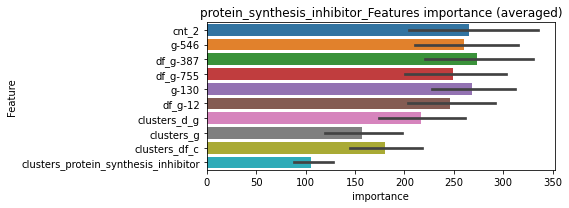

len(train_index) : 3788
len(valid_index) : 3788
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377597	valid_1's binary_logloss: 0.0567984
[200]	training's binary_logloss: 0.0105337	valid_1's binary_logloss: 0.0296081
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0063296	valid_1's binary_logloss: 0.0255512


len(train_index) : 3788
len(valid_index) : 3788
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361729	valid_1's binary_logloss: 0.0489626
[200]	training's binary_logloss: 0.0110664	valid_1's binary_logloss: 0.0249295
[300]	training's binary_logloss: 0.00459984	valid_1's binary_logloss: 0.0184165
[400]	training's binary_logloss: 0.00226486	valid_1's binary_logloss: 0.0162107
[500]	training's binary_logloss: 0.00136864	valid_1's binary_logloss: 0.0149326
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00138722	valid_1's binary_logloss: 0.0148467


protein_synthesis_inhibitor logloss: 0.02019891353859634
protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026179	valid_1's binary_logloss: 0.0352811
[200]	training's binary_logloss: 0.00327319	valid_1's binary_logloss: 0.0064303
[300]	training's binary_logloss: 0.000917552	valid_1's binary_logloss: 0.0023488
[400]	training's binary_logloss: 0.000484904	valid_1's binary_logloss: 0.00145527
[500]	training's binary_logloss: 0.000378212	valid_1's binary_logloss: 0.00122594
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000366815	valid_1's binary_logloss: 0.00121118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262523	valid_1's binary_logloss: 0.0325909
[200]	training's binary_logloss: 0.00328512	valid_1's binary_logloss: 0.00556969
[300]	training's binary_logloss: 0.000943224	valid_1's binary_logloss: 0.002061
[400]	training's binary_logloss: 0.00049697	valid_1's binary_logloss: 0.00130377
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0015684, Threshold: 0.0022234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00200, conf_1:0.00245
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0022234
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_2: 0.0122234
threshold: 0.0122234, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263234	valid_1's binary_logloss: 0.0364443
[200]	training's binary_logloss: 0.00313797	valid_1's binary_logloss: 0.00625066
[300]	training's binary_logloss: 0.000887234	valid_1's binary_logloss: 0.00228174
[400]	training's binary_logloss: 0.000472909	valid_1's binary_logloss: 0.00141998
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000380352	valid_1's binary_logloss: 0.00122832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262827	valid_1's binary_logloss: 0.0329358
[200]	training's binary_logloss: 0.00321167	valid_1's binary_logloss: 0.00515659
[300]	training's binary_logloss: 0.00091469	valid_1's binary_logloss: 0.0017345
[400]	training's binary_logloss: 0.000487845	valid_1's binary_logloss: 0.00104034
[500]	training's binary_logloss: 0.000379247	valid_1's binary_logloss: 0.000851953
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1248135, Threshold: 0.0122234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122234, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263234	valid_1's binary_logloss: 0.0364443
[200]	training's binary_logloss: 0.00313797	valid_1's binary_logloss: 0.00625066
[300]	training's binary_logloss: 0.000887234	valid_1's binary_logloss: 0.00228174
[400]	training's binary_logloss: 0.000472909	valid_1's binary_logloss: 0.00141998
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000380352	valid_1's binary_logloss: 0.00122832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262827	valid_1's binary_logloss: 0.0329358
[200]	training's binary_logloss: 0.00321167	valid_1's binary_logloss: 0.00515659
[300]	training's binary_logloss: 0.00091469	valid_1's binary_logloss: 0.0017345
[400]	training's binary_logloss: 0.000487845	valid_1's binary_logloss: 0.00104034
[500]	training's binary_logloss: 0.000379247	valid_1's binary_logloss: 0.000851953
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1248135, Threshold: 0.0122234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.01100, conf_1:0.01345
threshold: 0.0122234, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7792, y_label_rate: 0.0854723


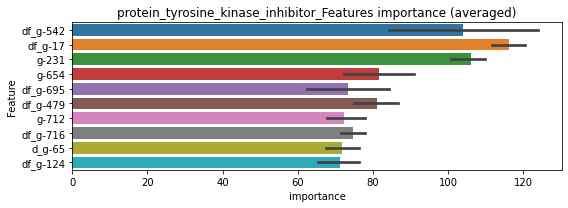

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014202	valid_1's binary_logloss: 0.0230586
[200]	training's binary_logloss: 0.00172802	valid_1's binary_logloss: 0.00962934
[300]	training's binary_logloss: 0.000481075	valid_1's binary_logloss: 0.00857097
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000506506	valid_1's binary_logloss: 0.00856531


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152906	valid_1's binary_logloss: 0.0225117
[200]	training's binary_logloss: 0.00196258	valid_1's binary_logloss: 0.0075568
[300]	training's binary_logloss: 0.000522986	valid_1's binary_logloss: 0.00586667
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000494665	valid_1's binary_logloss: 0.00584732


protein_tyrosine_kinase_inhibitor logloss: 0.007206312924339302
radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837578	valid_1's binary_logloss: 0.136872
[200]	training's binary_logloss: 0.0287947	valid_1's binary_logloss: 0.0953573
[300]	training's binary_logloss: 0.0121884	valid_1's binary_logloss: 0.0874319
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00677547	valid_1's binary_logloss: 0.0860155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926174	valid_1's binary_logloss: 0.12447
[200]	training's binary_logloss: 0.0372998	valid_1's binary_logloss: 0.0773406
[300]	training's binary_logloss: 0.0164225	valid_1's binary_logloss: 0.0603931
[400]	training's binary_logloss: 0.00817592	valid_1's binary_logloss: 0.0525441
[500]	training's binary_logloss: 0.00492892	valid_1's binary_logloss: 0.0498986
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00406272	valid_1's binary_logloss: 0.0491403


1 / 3 AUC score:0.993
y_Threshold: 0.0591357, Threshold: 0.1878752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 630/3753
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.16909, conf_1:0.20666
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.1878752
Num_p_label: 76.0, Expected: 9.4, Adj_threshold_2: 0.1978752
Num_p_label: 68.0, Expected: 9.4, Adj_threshold_3: 0.2078752
Num_p_label: 65.0, Expected: 9.4, Adj_threshold_4: 0.2178752
Num_p_label: 63.0, Expected: 9.4, Adj_threshold_5: 0.2278752
Num_p_label: 60.0, Expected: 9.4, Adj_threshold_6: 0.2378752
Num_p_label: 58.0, Expected: 9.4, Adj_threshold_7: 0.2478752
Num_p_label: 55.0, Expected: 9.4, Adj_threshold_8: 0.2578752
Num_p_label: 52.0, Expected: 9.4, Adj_threshold_9: 0.2678752
Num_p_label: 48.0, Expected: 9.4, Adj_threshold_10: 0.2778752
threshold: 0.2878752, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 630.0/3753, y_label_rate: 0.1678657
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675262	valid_1's binary_logloss: 0.107819
[200]	training's binary_logloss: 0.0197846	valid_1's binary_logloss: 0.0605148
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00835562	valid_1's binary_logloss: 0.0499161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646944	valid_1's binary_logloss: 0.0949743
[200]	training's binary_logloss: 0.0199079	valid_1's binary_logloss: 0.0507504
[300]	training's binary_logloss: 0.00782927	valid_1's binary_logloss: 0.0381101
[400]	training's binary_logloss: 0.00418205	valid_1's binary_logloss: 0.0338188
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00310741	valid_1's binary_logloss: 0.0322252


2 / 3 AUC score:0.998
y_Threshold: 0.1965153, Threshold: 0.2878752, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 607.0/3707
p_label_rate: 0.0258664 Vs.target_rate: 0.00235, Num_p_label: 103.0, conf_0:0.25909, conf_1:0.31666
Num_p_label: 103.0, Expected: 9.4, Adj_threshold_1: 0.2878752
Num_p_label: 100.0, Expected: 9.4, Adj_threshold_2: 0.2978752
Num_p_label: 96.0, Expected: 9.4, Adj_threshold_3: 0.3078752
Num_p_label: 92.0, Expected: 9.4, Adj_threshold_4: 0.3178752
Num_p_label: 87.0, Expected: 9.4, Adj_threshold_5: 0.3278752
Num_p_label: 81.0, Expected: 9.4, Adj_threshold_6: 0.3378752
Num_p_label: 78.0, Expected: 9.4, Adj_threshold_7: 0.3478752
Num_p_label: 76.0, Expected: 9.4, Adj_threshold_8: 0.3578752
Num_p_label: 75.0, Expected: 9.4, Adj_threshold_9: 0.3678752
Num_p_label: 69.0, Expected: 9.4, Adj_threshold_10: 0.3778752
threshold: 0.3878752, positive_p_label: 68.0/3982, p_label_rate: 0.0170768
positive_y_label: 607.0/3707, y_label_rate: 0.1637443
====

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592868	valid_1's binary_logloss: 0.0940807
[200]	training's binary_logloss: 0.0161936	valid_1's binary_logloss: 0.0446707
[300]	training's binary_logloss: 0.00603181	valid_1's binary_logloss: 0.0298528
[400]	training's binary_logloss: 0.00320109	valid_1's binary_logloss: 0.0245032
[500]	training's binary_logloss: 0.00209775	valid_1's binary_logloss: 0.0224772
[600]	training's binary_logloss: 0.00160889	valid_1's binary_logloss: 0.0208809
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00145882	valid_1's binary_logloss: 0.0201943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061708	valid_1's binary_logloss: 0.0970834


3 / 3 AUC score:1.000
y_Threshold: 0.2665064, Threshold: 0.3878752, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.0180599	valid_1's binary_logloss: 0.0473361
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00919607	valid_1's binary_logloss: 0.034754


Remove_noisy_labels: 28 → Positive_corect_labels: 593.0/3679
p_label_rate: 0.0185836 Vs.target_rate: 0.00235, Num_p_label: 74.0, conf_0:0.34909, conf_1:0.42666
Num_p_label: 74.0, Expected: 9.4, Adj_threshold_1: 0.3878752
Num_p_label: 74.0, Expected: 9.4, Adj_threshold_2: 0.3978752
Num_p_label: 69.0, Expected: 9.4, Adj_threshold_3: 0.4078752
Num_p_label: 68.0, Expected: 9.4, Adj_threshold_4: 0.4178752
Num_p_label: 68.0, Expected: 9.4, Adj_threshold_5: 0.4278752
Num_p_label: 67.0, Expected: 9.4, Adj_threshold_6: 0.4378752
Num_p_label: 64.0, Expected: 9.4, Adj_threshold_7: 0.4478752
Num_p_label: 64.0, Expected: 9.4, Adj_threshold_8: 0.4578752
Num_p_label: 61.0, Expected: 9.4, Adj_threshold_9: 0.4678752
Num_p_label: 59.0, Expected: 9.4, Adj_threshold_10: 0.4778752
threshold: 0.4878752, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 650.0/7661, y_label_rate: 0.0848453


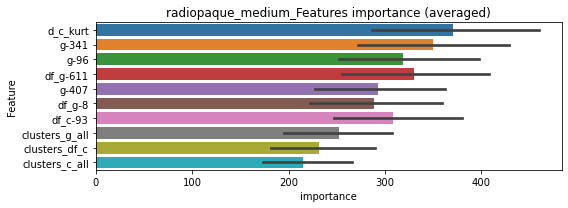

len(train_index) : 3830
len(valid_index) : 3831
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382587	valid_1's binary_logloss: 0.0581034
[200]	training's binary_logloss: 0.0116189	valid_1's binary_logloss: 0.0291979
[300]	training's binary_logloss: 0.0047263	valid_1's binary_logloss: 0.0212889
[400]	training's binary_logloss: 0.00238063	valid_1's binary_logloss: 0.0185601
[500]	training's binary_logloss: 0.0014855	valid_1's binary_logloss: 0.0174771
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00143851	valid_1's binary_logloss: 0.0173714


len(train_index) : 3831
len(valid_index) : 3830
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411661	valid_1's binary_logloss: 0.0625964
[200]	training's binary_logloss: 0.0120356	valid_1's binary_logloss: 0.0331903
[300]	training's binary_logloss: 0.00483664	valid_1's binary_logloss: 0.0245339
[400]	training's binary_logloss: 0.00235664	valid_1's binary_logloss: 0.0209866
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00166245	valid_1's binary_logloss: 0.0198732


radiopaque_medium logloss: 0.018622138308298865
raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226


neg labels: 3289 → selected neg labels: 3280


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385373	valid_1's binary_logloss: 0.0832742
[200]	training's binary_logloss: 0.0100306	valid_1's binary_logloss: 0.0674847
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00857793	valid_1's binary_logloss: 0.0668358
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.995
y_Threshold: 0.0441336, Threshold: 0.1960213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 635/3762
p_label_rate: 0.0200904 Vs.target_rate: 0.00936, Num_p_label: 80.0, conf_0:0.17642, conf_1:0.21562
threshold: 0.1960213, positive_p_label: 80.0/3982, p_label_rate: 0.0200904


[100]	training's binary_logloss: 0.0427736	valid_1's binary_logloss: 0.0646211
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0174239	valid_1's binary_logloss: 0.0519082


positive_y_label: 635.0/3762, y_label_rate: 0.1687932
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028096	valid_1's binary_logloss: 0.04233
[200]	training's binary_logloss: 0.00469525	valid_1's binary_logloss: 0.0244395
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00343035	valid_1's binary_logloss: 0.0237941
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.999
y_Threshold: 0.1886160, Threshold: 0.1960213, pos_neg_ratio: 0.8000000


[100]	training's binary_logloss: 0.0269205	valid_1's binary_logloss: 0.0435224
[200]	training's binary_logloss: 0.00465348	valid_1's binary_logloss: 0.0272556
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00408986	valid_1's binary_logloss: 0.0268028


Remove_noisy_labels: 32 → Positive_corect_labels: 619.0/3730
p_label_rate: 0.0313913 Vs.target_rate: 0.00936, Num_p_label: 125.0, conf_0:0.17642, conf_1:0.21562
Num_p_label: 125.0, Expected: 37.3, Adj_threshold_1: 0.1960213
Num_p_label: 124.0, Expected: 37.3, Adj_threshold_2: 0.2060213
Num_p_label: 124.0, Expected: 37.3, Adj_threshold_3: 0.2160213
Num_p_label: 122.0, Expected: 37.3, Adj_threshold_4: 0.2260213
Num_p_label: 122.0, Expected: 37.3, Adj_threshold_5: 0.2360213
Num_p_label: 117.0, Expected: 37.3, Adj_threshold_6: 0.2460213
Num_p_label: 114.0, Expected: 37.3, Adj_threshold_7: 0.2560213
Num_p_label: 113.0, Expected: 37.3, Adj_threshold_8: 0.2660213
Num_p_label: 113.0, Expected: 37.3, Adj_threshold_9: 0.2760213
Num_p_label: 110.0, Expected: 37.3, Adj_threshold_10: 0.2860213
threshold: 0.2960213, positive_p_label: 109.0/3982, p_label_rate: 0.0273732
positive_y_label: 619.0/3730, y_label_rate: 0.1659517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225601	valid_1's binary_logloss: 0.0326053
[200]	training's binary_logloss: 0.00356112	valid_1's binary_logloss: 0.0145934
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00222596	valid_1's binary_logloss: 0.0126216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240943	valid_1's binary_logloss: 0.0459347


3 / 3 AUC score:1.000
y_Threshold: 0.0673750, Threshold: 0.2960213, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 609.0/3710
p_label_rate: 0.0271220 Vs.target_rate: 0.00936, Num_p_label: 108.0, conf_0:0.26642, conf_1:0.32562
threshold: 0.2960213, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 717.0/7692, y_label_rate: 0.0932137


[200]	training's binary_logloss: 0.00334077	valid_1's binary_logloss: 0.02405
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00241303	valid_1's binary_logloss: 0.0229378


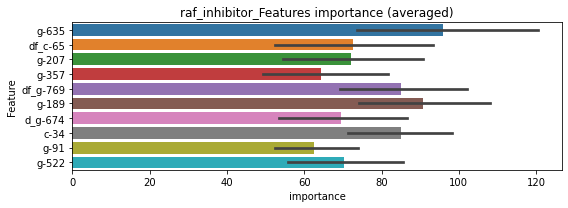

len(train_index) : 3846
len(valid_index) : 3846
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013122	valid_1's binary_logloss: 0.0286676


len(train_index) : 3846
len(valid_index) : 3846
================================= fold 2/2 raf_inhibitor=================================


[200]	training's binary_logloss: 0.0016692	valid_1's binary_logloss: 0.0180558
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000972429	valid_1's binary_logloss: 0.0173902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153375	valid_1's binary_logloss: 0.0194572
[200]	training's binary_logloss: 0.00265984	valid_1's binary_logloss: 0.00705191


raf_inhibitor logloss: 0.011480816810271011


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00131223	valid_1's binary_logloss: 0.00557141


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191472	valid_1's binary_logloss: 0.0243895
[200]	training's binary_logloss: 0.00195577	valid_1's binary_logloss: 0.0042859
[300]	training's binary_logloss: 0.000565491	valid_1's binary_logloss: 0.0019055
[400]	training's binary_logloss: 0.000321272	valid_1's binary_logloss: 0.0014195
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000283741	valid_1's binary_logloss: 0.00135048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191968	valid_1's binary_logloss: 0.0232524
[200]	training's binary_logloss: 0.00200283	valid_1's binary_logloss: 0.00359881
[300]	training's binary_logloss: 0.00058365	valid_1's binary_logloss: 0.00145809
[400]	training's binary_logloss: 0.000327576	valid_1's binary_logloss: 0.000958464
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000281123	valid_1's binary_logloss: 0.00086251

1 / 3 AUC score:1.000
y_Threshold: 0.0011159, Threshold: 0.0021905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00197, conf_1:0.00241
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0021905
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0121905
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0221905
threshold: 0.0221905, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193674	valid_1's binary_logloss: 0.024246
[200]	training's binary_logloss: 0.00194506	valid_1's binary_logloss: 0.0043416
[300]	training's binary_logloss: 0.000559565	valid_1's binary_logloss: 0.00218805
[400]	training's binary_logloss: 0.000319082	valid_1's binary_logloss: 0.00176281
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000276503	valid_1's binary_logloss: 0.00169071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019589	valid_1's binary_logloss: 0.0232982
[200]	training's binary_logloss: 0.00198492	valid_1's binary_logloss: 0.00333254
[300]	training's binary_logloss: 0.000564797	valid_1's binary_logloss: 0.00120686
[400]	training's binary_logloss: 0.000323373	valid_1's binary_logloss: 0.000764948
[500]	training's binary_logloss: 0.000273587	valid_1's binary_logloss: 0.000672263
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0418771, Threshold: 0.0221905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0065294 Vs.target_rate: 0.00050, Num_p_label: 26.0, conf_0:0.01997, conf_1:0.02441
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_1: 0.0221905
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_2: 0.0321905
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.0421905
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.0521905
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.0621905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.0721905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.0821905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_8: 0.0921905
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.1021905
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.1121905
threshold: 0.1121905, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
===============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193674	valid_1's binary_logloss: 0.024246
[200]	training's binary_logloss: 0.00194506	valid_1's binary_logloss: 0.0043416
[300]	training's binary_logloss: 0.000559565	valid_1's binary_logloss: 0.00218805
[400]	training's binary_logloss: 0.000319082	valid_1's binary_logloss: 0.00176281
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000276503	valid_1's binary_logloss: 0.00169071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019589	valid_1's binary_logloss: 0.0232982
[200]	training's binary_logloss: 0.00198492	valid_1's binary_logloss: 0.00333254
[300]	training's binary_logloss: 0.000564797	valid_1's binary_logloss: 0.00120686
[400]	training's binary_logloss: 0.000323373	valid_1's binary_logloss: 0.000764948
[500]	training's binary_logloss: 0.000273587	valid_1's binary_logloss: 0.000672263
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0418771, Threshold: 0.1121905, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.10097, conf_1:0.12341
threshold: 0.1121905, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


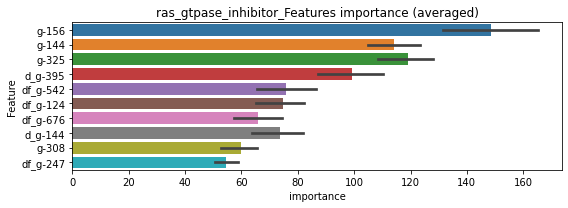

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101482	valid_1's binary_logloss: 0.0135199
[200]	training's binary_logloss: 0.00100979	valid_1's binary_logloss: 0.00284151
[300]	training's binary_logloss: 0.000282108	valid_1's binary_logloss: 0.00205184
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000253907	valid_1's binary_logloss: 0.00203653


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010313	valid_1's binary_logloss: 0.0136313
[200]	training's binary_logloss: 0.00105562	valid_1's binary_logloss: 0.00378632
[300]	training's binary_logloss: 0.000295037	valid_1's binary_logloss: 0.00260299
[400]	training's binary_logloss: 0.000167755	valid_1's binary_logloss: 0.00241337
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000154148	valid_1's binary_logloss: 0.00237364


ras_gtpase_inhibitor logloss: 0.002205087941061963
retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948


neg labels: 3289 → selected neg labels: 3278


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704257	valid_1's binary_logloss: 0.120701
[200]	training's binary_logloss: 0.0249906	valid_1's binary_logloss: 0.0842914
[300]	training's binary_logloss: 0.0105902	valid_1's binary_logloss: 0.0735698
[400]	training's binary_logloss: 0.00558503	valid_1's binary_logloss: 0.070153
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00525567	valid_1's binary_logloss: 0.0701199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744476	valid_1's binary_logloss: 0.121237
[200]	training's binary_logloss: 0.0265568	valid_1's binary_logloss: 0.0877855
[300]	training's binary_logloss: 0.0120077	valid_1's binary_logloss: 0.0782273
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0103075	valid_1's binary_logloss: 0.0771641


1 / 3 AUC score:0.994
y_Threshold: 0.0907631, Threshold: 0.2876675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 176 → Positive_corect_labels: 633/3757
p_label_rate: 0.0200904 Vs.target_rate: 0.00281, Num_p_label: 80.0, conf_0:0.25890, conf_1:0.31643
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.2876675
Num_p_label: 79.0, Expected: 11.2, Adj_threshold_2: 0.2976675
Num_p_label: 77.0, Expected: 11.2, Adj_threshold_3: 0.3076675
Num_p_label: 75.0, Expected: 11.2, Adj_threshold_4: 0.3176675
Num_p_label: 74.0, Expected: 11.2, Adj_threshold_5: 0.3276675
Num_p_label: 71.0, Expected: 11.2, Adj_threshold_6: 0.3376675
Num_p_label: 69.0, Expected: 11.2, Adj_threshold_7: 0.3476675
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_8: 0.3576675
Num_p_label: 64.0, Expected: 11.2, Adj_threshold_9: 0.3676675
Num_p_label: 61.0, Expected: 11.2, Adj_threshold_10: 0.3776675
threshold: 0.3876675, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 633.0/3757, y_label_rate: 0.168485

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055642	valid_1's binary_logloss: 0.0923745
[200]	training's binary_logloss: 0.0150516	valid_1's binary_logloss: 0.0532425
[300]	training's binary_logloss: 0.00575594	valid_1's binary_logloss: 0.0441408
[400]	training's binary_logloss: 0.00305729	valid_1's binary_logloss: 0.0414145
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00264911	valid_1's binary_logloss: 0.0398208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528242	valid_1's binary_logloss: 0.0967053
[200]	training's binary_logloss: 0.0135856	valid_1's binary_logloss: 0.0544072
[300]	training's binary_logloss: 0.00530032	valid_1's binary_logloss: 0.0435912


2 / 3 AUC score:0.997
y_Threshold: 0.2154262, Threshold: 0.3876675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 608.0/3707
p_label_rate: 0.0256153 Vs.target_rate: 0.00281, Num_p_label: 102.0, conf_0:0.34890, conf_1:0.42643
Num_p_label: 102.0, Expected: 11.2, Adj_threshold_1: 0.3876675
Num_p_label: 97.0, Expected: 11.2, Adj_threshold_2: 0.3976675
Num_p_label: 95.0, Expected: 11.2, Adj_threshold_3: 0.4076675
Num_p_label: 92.0, Expected: 11.2, Adj_threshold_4: 0.4176675
Num_p_label: 91.0, Expected: 11.2, Adj_threshold_5: 0.4276675
Num_p_label: 88.0, Expected: 11.2, Adj_threshold_6: 0.4376675
Num_p_label: 86.0, Expected: 11.2, Adj_threshold_7: 0.4476675


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00347446	valid_1's binary_logloss: 0.0414247


Num_p_label: 84.0, Expected: 11.2, Adj_threshold_8: 0.4576675
Num_p_label: 82.0, Expected: 11.2, Adj_threshold_9: 0.4676675
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_10: 0.4776675
threshold: 0.4876675, positive_p_label: 79.0/3982, p_label_rate: 0.0198393
positive_y_label: 608.0/3707, y_label_rate: 0.1640140
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465248	valid_1's binary_logloss: 0.0794198
[200]	training's binary_logloss: 0.0115635	valid_1's binary_logloss: 0.0473692
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00826134	valid_1's binary_logloss: 0.044908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464143	valid_1's binary_logloss: 0.0920824
[200]	training's binary_logloss: 0.0109308	valid_1's binary_logloss: 0.0553959
[300]	training's binary_logloss: 0.00410195	valid_1's binary_logloss: 0.0465014
[400]	training's binary_logloss: 0.00224684	valid_1's binary_logloss: 0.0420867
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00190937	valid_1's binary_logloss: 0.0415882


3 / 3 AUC score:0.998
y_Threshold: 0.1474862, Threshold: 0.4876675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 582.0/3655
p_label_rate: 0.0205927 Vs.target_rate: 0.00281, Num_p_label: 82.0, conf_0:0.43890, conf_1:0.53643
Num_p_label: 82.0, Expected: 11.2, Adj_threshold_1: 0.4876675
Num_p_label: 81.0, Expected: 11.2, Adj_threshold_2: 0.4976675
Num_p_label: 79.0, Expected: 11.2, Adj_threshold_3: 0.5076675
Num_p_label: 77.0, Expected: 11.2, Adj_threshold_4: 0.5176675
Num_p_label: 75.0, Expected: 11.2, Adj_threshold_5: 0.5276675
Num_p_label: 74.0, Expected: 11.2, Adj_threshold_6: 0.5376675
Num_p_label: 71.0, Expected: 11.2, Adj_threshold_7: 0.5476675
Num_p_label: 68.0, Expected: 11.2, Adj_threshold_8: 0.5576675
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_9: 0.5676675
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_10: 0.5776675
threshold: 0.5876675, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 648.0/7637, y_label_rate: 0.08485

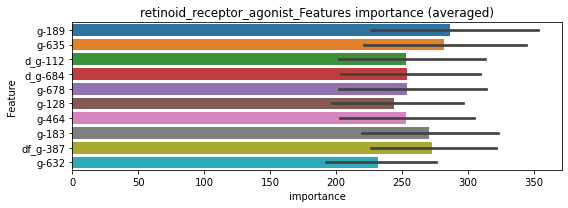

len(train_index) : 3818
len(valid_index) : 3819
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259437	valid_1's binary_logloss: 0.0492821
[200]	training's binary_logloss: 0.00671057	valid_1's binary_logloss: 0.030171
[300]	training's binary_logloss: 0.0027047	valid_1's binary_logloss: 0.0260551
[400]	training's binary_logloss: 0.0014736	valid_1's binary_logloss: 0.0244238


len(train_index) : 3819
len(valid_index) : 3818


Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00145413	valid_1's binary_logloss: 0.0243497


================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025171	valid_1's binary_logloss: 0.0523119
[200]	training's binary_logloss: 0.0064306	valid_1's binary_logloss: 0.0349484
[300]	training's binary_logloss: 0.00250319	valid_1's binary_logloss: 0.0306213


retinoid_receptor_agonist logloss: 0.027120545247164726


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00174031	valid_1's binary_logloss: 0.0298921


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153553	valid_1's binary_logloss: 0.0178474
[200]	training's binary_logloss: 0.00124076	valid_1's binary_logloss: 0.0034079
[300]	training's binary_logloss: 0.000334142	valid_1's binary_logloss: 0.00178939
[400]	training's binary_logloss: 0.000207718	valid_1's binary_logloss: 0.00144546
[500]	training's binary_logloss: 0.000184274	valid_1's binary_logloss: 0.00138403
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000182533	valid_1's binary_logloss: 0.00138027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155639	valid_1's binary_logloss: 0.0162201
[200]	training's binary_logloss: 0.00126522	valid_1's binary_logloss: 0.00139397
[300]	training's binary_logloss: 0.000339857	valid_1's binary_logloss: 0.000396409
[400]	training's binary_logloss: 0.00020906	valid_1's binary_logloss: 0.000247246
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0005117, Threshold: 0.0007059, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00064, conf_1:0.00078
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0007059
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0107059
threshold: 0.0107059, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157504	valid_1's binary_logloss: 0.0173679
[200]	training's binary_logloss: 0.00126181	valid_1's binary_logloss: 0.00256672
[300]	training's binary_logloss: 0.00033624	valid_1's binary_logloss: 0.00119913
[400]	training's binary_logloss: 0.00020927	valid_1's binary_logloss: 0.000962288
[500]	training's binary_logloss: 0.000185144	valid_1's binary_logloss: 0.000914053
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000181241	valid_1's binary_logloss: 0.000902479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160133	valid_1's binary_logloss: 0.0166614
[200]	training's binary_logloss: 0.00129124	valid_1's binary_logloss: 0.00140475
[300]	training's binary_logloss: 0.000339211	valid_1's binary_logloss: 0.000379616
[400]	training's binary_logloss: 0.000210098	valid_1's binary_logloss: 0.000237937
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.0836150, Threshold: 0.0107059, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00964, conf_1:0.01178
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0107059
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0207059
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0307059
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0407059
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0507059
threshold: 0.0507059, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157504	valid_1's binary_logloss: 0.0173679
[200]	training's binary_logloss: 0.00126181	valid_1's binary_logloss: 0.00256672
[300]	training's binary_logloss: 0.00033624	valid_1's binary_logloss: 0.00119913
[400]	training's binary_logloss: 0.00020927	valid_1's binary_logloss: 0.000962288
[500]	training's binary_logloss: 0.000185144	valid_1's binary_logloss: 0.000914053
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000181241	valid_1's binary_logloss: 0.000902479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160133	valid_1's binary_logloss: 0.0166614
[200]	training's binary_logloss: 0.00129124	valid_1's binary_logloss: 0.00140475
[300]	training's binary_logloss: 0.000339211	valid_1's binary_logloss: 0.000379616
[400]	training's binary_logloss: 0.000210098	valid_1's binary_logloss: 0.000237937
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.0836150, Threshold: 0.0507059, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.04564, conf_1:0.05578
threshold: 0.0507059, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


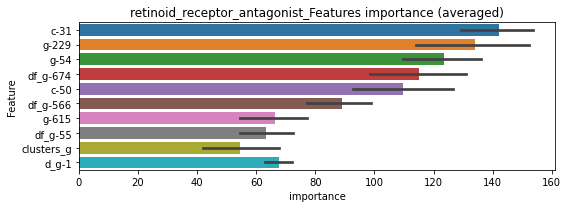

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00852468	valid_1's binary_logloss: 0.00958812
[200]	training's binary_logloss: 0.000690195	valid_1's binary_logloss: 0.00184935


len(train_index) : 3898
len(valid_index) : 3897


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000235279	valid_1's binary_logloss: 0.00148574


================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00848992	valid_1's binary_logloss: 0.0105029
[200]	training's binary_logloss: 0.000685004	valid_1's binary_logloss: 0.00243463
[300]	training's binary_logloss: 0.00018212	valid_1's binary_logloss: 0.0017604


retinoid_receptor_antagonist logloss: 0.0016016747917463761


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000161735	valid_1's binary_logloss: 0.00171763


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306324	valid_1's binary_logloss: 0.0494305
[200]	training's binary_logloss: 0.00429385	valid_1's binary_logloss: 0.012877
[300]	training's binary_logloss: 0.00123108	valid_1's binary_logloss: 0.00648936
[400]	training's binary_logloss: 0.000618123	valid_1's binary_logloss: 0.00469309
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000437549	valid_1's binary_logloss: 0.00405948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299927	valid_1's binary_logloss: 0.0464176
[200]	training's binary_logloss: 0.00431028	valid_1's binary_logloss: 0.0144154
[300]	training's binary_logloss: 0.00125155	valid_1's binary_logloss: 0.00925978
[400]	training's binary_logloss: 0.00062079	valid_1's binary_logloss: 0.00779701
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000580141	valid_1's binary_logloss: 0.00765636


1 / 3 AUC score:1.000
y_Threshold: 0.0038686, Threshold: 0.0056939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147, Num_p_label: 80.0, conf_0:0.00512, conf_1:0.00626
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0056939
Num_p_label: 20.0, Expected: 5.9, Adj_threshold_2: 0.0156939
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_3: 0.0256939
threshold: 0.0256939, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300625	valid_1's binary_logloss: 0.0455818
[200]	training's binary_logloss: 0.00415292	valid_1's binary_logloss: 0.011149
[300]	training's binary_logloss: 0.00120254	valid_1's binary_logloss: 0.00552223
[400]	training's binary_logloss: 0.000603439	valid_1's binary_logloss: 0.00387714
[500]	training's binary_logloss: 0.000423878	valid_1's binary_logloss: 0.00339844
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000397681	valid_1's binary_logloss: 0.0032948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300731	valid_1's binary_logloss: 0.0469841
[200]	training's binary_logloss: 0.00419417	valid_1's binary_logloss: 0.0140166
[300]	training's binary_logloss: 0.00121534	valid_1's binary_logloss: 0.00841203
[400]	training's binary_logloss: 0.000608279	valid_1's binary_logloss: 0.00699039
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0279204, Threshold: 0.0256939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0077850 Vs.target_rate: 0.00147, Num_p_label: 31.0, conf_0:0.02312, conf_1:0.02826
Num_p_label: 31.0, Expected: 5.9, Adj_threshold_1: 0.0256939
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_2: 0.0356939
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_3: 0.0456939
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_4: 0.0556939
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_5: 0.0656939
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_6: 0.0756939
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_7: 0.0856939
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_8: 0.0956939
threshold: 0.0956939, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299831	valid_1's binary_logloss: 0.0473014
[200]	training's binary_logloss: 0.00413429	valid_1's binary_logloss: 0.0112392
[300]	training's binary_logloss: 0.00120221	valid_1's binary_logloss: 0.00544869
[400]	training's binary_logloss: 0.000605191	valid_1's binary_logloss: 0.00363754
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000454815	valid_1's binary_logloss: 0.00317704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305003	valid_1's binary_logloss: 0.0441494
[200]	training's binary_logloss: 0.0042502	valid_1's binary_logloss: 0.00970375
[300]	training's binary_logloss: 0.00121627	valid_1's binary_logloss: 0.00442897
[400]	training's binary_logloss: 0.000611705	valid_1's binary_logloss: 0.00318101
[500]	training's binary_logloss: 0.000424675	valid_1's binary_logloss: 0.0027109
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0410638, Threshold: 0.0956939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0020090 Vs.target_rate: 0.00147, Num_p_label: 8.0, conf_0:0.08612, conf_1:0.10526
threshold: 0.0956939, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 663.0/7787, y_label_rate: 0.0851419


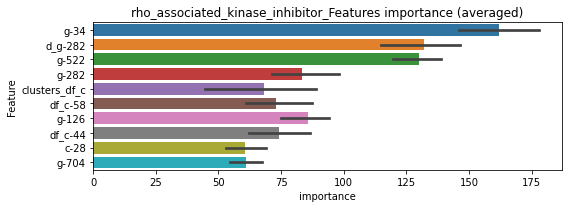

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155057	valid_1's binary_logloss: 0.0280799
[200]	training's binary_logloss: 0.00224534	valid_1's binary_logloss: 0.00980645
[300]	training's binary_logloss: 0.000638898	valid_1's binary_logloss: 0.00696175
[400]	training's binary_logloss: 0.000302729	valid_1's binary_logloss: 0.0062425
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000289763	valid_1's binary_logloss: 0.00619982


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160438	valid_1's binary_logloss: 0.0257717
[200]	training's binary_logloss: 0.00217392	valid_1's binary_logloss: 0.00820635
[300]	training's binary_logloss: 0.000634056	valid_1's binary_logloss: 0.00537431
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000355913	valid_1's binary_logloss: 0.00483041


rho_associated_kinase_inhibitor logloss: 0.005515204518301513
ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288333	valid_1's binary_logloss: 0.0476263
[200]	training's binary_logloss: 0.00403203	valid_1's binary_logloss: 0.0157819
[300]	training's binary_logloss: 0.00115065	valid_1's binary_logloss: 0.00999992
[400]	training's binary_logloss: 0.000580488	valid_1's binary_logloss: 0.00833599
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00042009	valid_1's binary_logloss: 0.00774804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298001	valid_1's binary_logloss: 0.040393
[200]	training's binary_logloss: 0.00420522	valid_1's binary_logloss: 0.0109482
[300]	training's binary_logloss: 0.001199	valid_1's binary_logloss: 0.0066704
[400]	training's binary_logloss: 0.000598587	valid_1's binary_logloss: 0.00588564
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000526474	valid_1's binary_logloss: 0.00576527


1 / 3 AUC score:1.000
y_Threshold: 0.0026594, Threshold: 0.0045642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00411, conf_1:0.00502
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0045642
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_2: 0.0145642
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.0245642
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.0345642
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_5: 0.0445642
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.0545642
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.0645642
threshold: 0.0645642, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275819	valid_1's binary_logloss: 0.043351
[200]	training's binary_logloss: 0.00366058	valid_1's binary_logloss: 0.0113755
[300]	training's binary_logloss: 0.00104826	valid_1's binary_logloss: 0.00623953
[400]	training's binary_logloss: 0.000532723	valid_1's binary_logloss: 0.00472547
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00044437	valid_1's binary_logloss: 0.00441594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283826	valid_1's binary_logloss: 0.0375954
[200]	training's binary_logloss: 0.0038127	valid_1's binary_logloss: 0.00786957
[300]	training's binary_logloss: 0.00109572	valid_1's binary_logloss: 0.00356737
[400]	training's binary_logloss: 0.000551124	valid_1's binary_logloss: 0.00259145
[500]	training's binary_logloss: 0.00039537	valid_1's binary_logloss: 0.00221207
Early stopping, best iteration is:
[50

2 / 3 AUC score:1.000
y_Threshold: 0.0414242, Threshold: 0.0645642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.05811, conf_1:0.07102
threshold: 0.0645642, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275819	valid_1's binary_logloss: 0.043351
[200]	training's binary_logloss: 0.00366058	valid_1's binary_logloss: 0.0113755
[300]	training's binary_logloss: 0.00104826	valid_1's binary_logloss: 0.00623953
[400]	training's binary_logloss: 0.000532723	valid_1's binary_logloss: 0.00472547
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00044437	valid_1's binary_logloss: 0.00441594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283826	valid_1's binary_logloss: 0.0375954
[200]	training's binary_logloss: 0.0038127	valid_1's binary_logloss: 0.00786957
[300]	training's binary_logloss: 0.00109572	valid_1's binary_logloss: 0.00356737
[400]	training's binary_logloss: 0.000551124	valid_1's binary_logloss: 0.00259145
[500]	training's binary_logloss: 0.00039537	valid_1's binary_logloss: 0.00221207
Early stopping, best iteration is:
[50

3 / 3 AUC score:1.000
y_Threshold: 0.0414242, Threshold: 0.0645642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.05811, conf_1:0.07102
threshold: 0.0645642, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7788, y_label_rate: 0.0865434


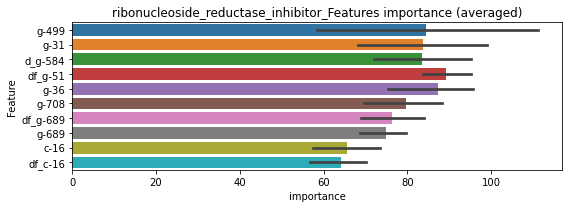

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150019	valid_1's binary_logloss: 0.0263427
[200]	training's binary_logloss: 0.00196951	valid_1's binary_logloss: 0.00980337
[300]	training's binary_logloss: 0.000556427	valid_1's binary_logloss: 0.00705174
[400]	training's binary_logloss: 0.000281152	valid_1's binary_logloss: 0.00611136
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000236077	valid_1's binary_logloss: 0.00586974


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152823	valid_1's binary_logloss: 0.0265429
[200]	training's binary_logloss: 0.00205327	valid_1's binary_logloss: 0.007712
[300]	training's binary_logloss: 0.000571038	valid_1's binary_logloss: 0.00500174
[400]	training's binary_logloss: 0.000286692	valid_1's binary_logloss: 0.00436517
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000210412	valid_1's binary_logloss: 0.00408139


ribonucleoside_reductase_inhibitor logloss: 0.0049755633051414856
rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290982	valid_1's binary_logloss: 0.038656
[200]	training's binary_logloss: 0.00373308	valid_1's binary_logloss: 0.007089
[300]	training's binary_logloss: 0.00106263	valid_1's binary_logloss: 0.00290857
[400]	training's binary_logloss: 0.000546057	valid_1's binary_logloss: 0.00189673
[500]	training's binary_logloss: 0.000407858	valid_1's binary_logloss: 0.00156968
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000395072	valid_1's binary_logloss: 0.00154721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299551	valid_1's binary_logloss: 0.0470944
[200]	training's binary_logloss: 0.00384877	valid_1's binary_logloss: 0.0115295
[300]	training's binary_logloss: 0.00105965	valid_1's binary_logloss: 0.00601307
[400]	training's binary_logloss: 0.000540653	valid_1's binary_logloss: 0.00457794
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0022142, Threshold: 0.0082744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00745, conf_1:0.00910
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0082744
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_2: 0.0182744
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_3: 0.0282744
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_4: 0.0382744
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_5: 0.0482744
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.0582744
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.0682744
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.0782744
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.0882744
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.0982744
threshold: 0.1082744, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279143	valid_1's binary_logloss: 0.0373217
[200]	training's binary_logloss: 0.00353488	valid_1's binary_logloss: 0.00709987
[300]	training's binary_logloss: 0.00099409	valid_1's binary_logloss: 0.0027289
[400]	training's binary_logloss: 0.000505876	valid_1's binary_logloss: 0.00167497
[500]	training's binary_logloss: 0.000387324	valid_1's binary_logloss: 0.00141115
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000383091	valid_1's binary_logloss: 0.00139832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287898	valid_1's binary_logloss: 0.0443037
[200]	training's binary_logloss: 0.00363485	valid_1's binary_logloss: 0.00939141
[300]	training's binary_logloss: 0.00100547	valid_1's binary_logloss: 0.00374305
[400]	training's binary_logloss: 0.000516811	valid_1's binary_logloss: 0.00234855
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1008286, Threshold: 0.1082744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0155701 Vs.target_rate: 0.00105, Num_p_label: 62.0, conf_0:0.09745, conf_1:0.11910
Num_p_label: 62.0, Expected: 4.2, Adj_threshold_1: 0.1082744
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_2: 0.1182744
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_3: 0.1282744
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_4: 0.1382744
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_5: 0.1482744
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_6: 0.1582744
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_7: 0.1682744
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_8: 0.1782744
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_9: 0.1882744
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_10: 0.1982744
threshold: 0.2082744, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279143	valid_1's binary_logloss: 0.0373217
[200]	training's binary_logloss: 0.00353488	valid_1's binary_logloss: 0.00709987
[300]	training's binary_logloss: 0.00099409	valid_1's binary_logloss: 0.0027289
[400]	training's binary_logloss: 0.000505876	valid_1's binary_logloss: 0.00167497
[500]	training's binary_logloss: 0.000387324	valid_1's binary_logloss: 0.00141115
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000383091	valid_1's binary_logloss: 0.00139832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287898	valid_1's binary_logloss: 0.0443037
[200]	training's binary_logloss: 0.00363485	valid_1's binary_logloss: 0.00939141
[300]	training's binary_logloss: 0.00100547	valid_1's binary_logloss: 0.00374305
[400]	training's binary_logloss: 0.000516811	valid_1's binary_logloss: 0.00234855
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1008286, Threshold: 0.2082744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0102963 Vs.target_rate: 0.00105, Num_p_label: 41.0, conf_0:0.18745, conf_1:0.22910
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_1: 0.2082744
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_2: 0.2182744
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_3: 0.2282744
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_4: 0.2382744
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_5: 0.2482744
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_6: 0.2582744
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_7: 0.2682744
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_8: 0.2782744
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_9: 0.2882744
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_10: 0.2982744
threshold: 0.3082744, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 691.0/7790, y_label_rate: 0.0887035


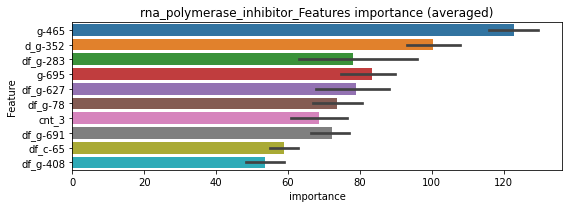

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175357	valid_1's binary_logloss: 0.0280403
[200]	training's binary_logloss: 0.00249405	valid_1's binary_logloss: 0.00983277
[300]	training's binary_logloss: 0.000700007	valid_1's binary_logloss: 0.00736601
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000424262	valid_1's binary_logloss: 0.00689884


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175686	valid_1's binary_logloss: 0.0256885
[200]	training's binary_logloss: 0.00251002	valid_1's binary_logloss: 0.0077869
[300]	training's binary_logloss: 0.000688372	valid_1's binary_logloss: 0.00506028
[400]	training's binary_logloss: 0.000342309	valid_1's binary_logloss: 0.00452407
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000323492	valid_1's binary_logloss: 0.00450296


rna_polymerase_inhibitor logloss: 0.005700899819349029
serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332


neg labels: 3289 → selected neg labels: 3249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174345	valid_1's binary_logloss: 0.296059
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.141888	valid_1's binary_logloss: 0.288429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204573	valid_1's binary_logloss: 0.275416
[200]	training's binary_logloss: 0.135134	valid_1's binary_logloss: 0.259755


1 / 3 AUC score:0.861
y_Threshold: 0.1886370, Threshold: 0.2898809, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 551 → Positive_corect_labels: 439/3347
p_label_rate: 0.0200904 Vs.target_rate: 0.00991, Num_p_label: 80.0, conf_0:0.26089, conf_1:0.31887
threshold: 0.2898809, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 439.0/3347, y_label_rate: 0.1311622
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.127239	valid_1's binary_logloss: 0.258412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728304	valid_1's binary_logloss: 0.131713
[200]	training's binary_logloss: 0.0286294	valid_1's binary_logloss: 0.108454
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0224388	valid_1's binary_logloss: 0.105415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761375	valid_1's binary_logloss: 0.129071
[200]	training's binary_logloss: 0.0292865	valid_1's binary_logloss: 0.0999653


2 / 3 AUC score:0.985
y_Threshold: 0.1443248, Threshold: 0.2898809, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 112 → Positive_corect_labels: 383.0/3235
p_label_rate: 0.0328980 Vs.target_rate: 0.00991, Num_p_label: 131.0, conf_0:0.26089, conf_1:0.31887
Num_p_label: 131.0, Expected: 39.5, Adj_threshold_1: 0.2898809
Num_p_label: 126.0, Expected: 39.5, Adj_threshold_2: 0.2998809
Num_p_label: 114.0, Expected: 39.5, Adj_threshold_3: 0.3098809
Num_p_label: 108.0, Expected: 39.5, Adj_threshold_4: 0.3198809
Num_p_label: 102.0, Expected: 39.5, Adj_threshold_5: 0.3298809
Num_p_label: 98.0, Expected: 39.5, Adj_threshold_6: 0.3398809
Num_p_label: 96.0, Expected: 39.5, Adj_threshold_7: 0.3498809
Num_p_label: 87.0, Expected: 39.5, Adj_threshold_8: 0.3598809


[300]	training's binary_logloss: 0.013141	valid_1's binary_logloss: 0.0904084
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.013141	valid_1's binary_logloss: 0.0904084


Num_p_label: 82.0, Expected: 39.5, Adj_threshold_9: 0.3698809
Num_p_label: 79.0, Expected: 39.5, Adj_threshold_10: 0.3798809
threshold: 0.3898809, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 383.0/3235, y_label_rate: 0.1183926
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502968	valid_1's binary_logloss: 0.0914406
[200]	training's binary_logloss: 0.0156673	valid_1's binary_logloss: 0.0653893
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0069613	valid_1's binary_logloss: 0.0593762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497391	valid_1's binary_logloss: 0.0997568


3 / 3 AUC score:0.994
y_Threshold: 0.1351746, Threshold: 0.3898809, pos_neg_ratio: 0.8000000


[200]	training's binary_logloss: 0.0156317	valid_1's binary_logloss: 0.0685426
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00761676	valid_1's binary_logloss: 0.0578602


Remove_noisy_labels: 54 → Positive_corect_labels: 356.0/3181
p_label_rate: 0.0145655 Vs.target_rate: 0.00991, Num_p_label: 58.0, conf_0:0.35089, conf_1:0.42887
threshold: 0.3898809, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 414.0/7163, y_label_rate: 0.0577970


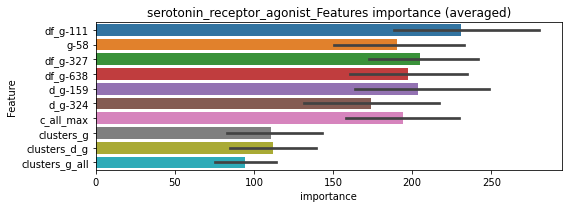

len(train_index) : 3581
len(valid_index) : 3582
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032128	valid_1's binary_logloss: 0.0498882
[200]	training's binary_logloss: 0.0113292	valid_1's binary_logloss: 0.0328337
[300]	training's binary_logloss: 0.00504755	valid_1's binary_logloss: 0.0279586
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00412597	valid_1's binary_logloss: 0.0268421


len(train_index) : 3582
len(valid_index) : 3581
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291007	valid_1's binary_logloss: 0.0532866
[200]	training's binary_logloss: 0.00931889	valid_1's binary_logloss: 0.0379923
[300]	training's binary_logloss: 0.00394182	valid_1's binary_logloss: 0.0335429


serotonin_receptor_agonist logloss: 0.03001130317337319


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00354398	valid_1's binary_logloss: 0.0331814


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918


neg labels: 3289 → selected neg labels: 3220


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239098	valid_1's binary_logloss: 0.369568
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.242004	valid_1's binary_logloss: 0.369411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253309	valid_1's binary_logloss: 0.367253
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.26094	valid_1's binary_logloss: 0.367154


1 / 3 AUC score:0.761
y_Threshold: 0.2215361, Threshold: 0.3346017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 781 → Positive_corect_labels: 318/3083
p_label_rate: 0.0200904 Vs.target_rate: 0.01696, Num_p_label: 80.0, conf_0:0.30114, conf_1:0.36806
threshold: 0.3346017, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 318.0/3083, y_label_rate: 0.1031463
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711903	valid_1's binary_logloss: 0.135387
[200]	training's binary_logloss: 0.0301728	valid_1's binary_logloss: 0.118421
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0256624	valid_1's binary_logloss: 0.115187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716945	valid_1's binary_logloss: 0.142833
[200]	training's binary_logloss: 0.0290299	valid_1's binary_logloss: 0.125755


2 / 3 AUC score:0.973
y_Threshold: 0.2118154, Threshold: 0.3346017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 248.0/2943
p_label_rate: 0.0552486 Vs.target_rate: 0.01696, Num_p_label: 220.0, conf_0:0.30114, conf_1:0.36806
Num_p_label: 220.0, Expected: 67.6, Adj_threshold_1: 0.3346017
Num_p_label: 214.0, Expected: 67.6, Adj_threshold_2: 0.3446017
Num_p_label: 207.0, Expected: 67.6, Adj_threshold_3: 0.3546017
Num_p_label: 200.0, Expected: 67.6, Adj_threshold_4: 0.3646017
Num_p_label: 192.0, Expected: 67.6, Adj_threshold_5: 0.3746017
Num_p_label: 188.0, Expected: 67.6, Adj_threshold_6: 0.3846017
Num_p_label: 184.0, Expected: 67.6, Adj_threshold_7: 0.3946017
Num_p_label: 180.0, Expected: 67.6, Adj_threshold_8: 0.4046017
Num_p_label: 176.0, Expected: 67.6, Adj_threshold_9: 0.4146017
Num_p_label: 170.0, Expected: 67.6, Adj_threshold_10: 0.4246017
threshold: 0.4346017, positive_p_label: 168.0/3982, p_label_rate: 0.0421899
positive_y_label: 248.0/2943, y_label_

Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0206827	valid_1's binary_logloss: 0.123579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390895	valid_1's binary_logloss: 0.0851011
[200]	training's binary_logloss: 0.0122005	valid_1's binary_logloss: 0.0668064
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0104477	valid_1's binary_logloss: 0.0658683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417545	valid_1's binary_logloss: 0.081829
[200]	training's binary_logloss: 0.0134282	valid_1's binary_logloss: 0.063371


3 / 3 AUC score:0.993
y_Threshold: 0.1917038, Threshold: 0.4346017, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 218.0/2883
p_label_rate: 0.0469613 Vs.target_rate: 0.01696, Num_p_label: 187.0, conf_0:0.39114, conf_1:0.47806
threshold: 0.4346017, positive_p_label: 187.0/3982, p_label_rate: 0.0469613
positive_y_label: 405.0/6865, y_label_rate: 0.0589949


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00870863	valid_1's binary_logloss: 0.0601902


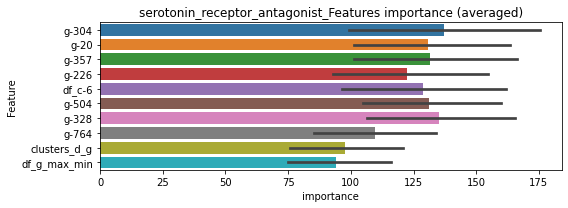

len(train_index) : 3432
len(valid_index) : 3433
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316912	valid_1's binary_logloss: 0.0545927
[200]	training's binary_logloss: 0.0112877	valid_1's binary_logloss: 0.042214
[300]	training's binary_logloss: 0.00509643	valid_1's binary_logloss: 0.0385999


len(train_index) : 3433
len(valid_index) : 3432
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00506072	valid_1's binary_logloss: 0.038577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285614	valid_1's binary_logloss: 0.0584273
[200]	training's binary_logloss: 0.00934075	valid_1's binary_logloss: 0.0465809
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00977744	valid_1's binary_logloss: 0.0463328


serotonin_receptor_antagonist logloss: 0.04245434179472408
serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388201	valid_1's binary_logloss: 0.0697173
[200]	training's binary_logloss: 0.00654392	valid_1's binary_logloss: 0.028248
[300]	training's binary_logloss: 0.00190359	valid_1's binary_logloss: 0.0185067
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00104693	valid_1's binary_logloss: 0.015652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414544	valid_1's binary_logloss: 0.066731
[200]	training's binary_logloss: 0.0078346	valid_1's binary_logloss: 0.0273999
[300]	training's binary_logloss: 0.00220671	valid_1's binary_logloss: 0.0194599
[400]	training's binary_logloss: 0.00103143	valid_1's binary_logloss: 0.0176209
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000974446	valid_1's binary_logloss: 0.0174885


1 / 3 AUC score:1.000
y_Threshold: 0.0058836, Threshold: 0.0078709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00185, Num_p_label: 80.0, conf_0:0.00708, conf_1:0.00866
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0078709
Num_p_label: 7.0, Expected: 7.4, Adj_threshold_2: 0.0178709
threshold: 0.0178709, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406761	valid_1's binary_logloss: 0.0730353
[200]	training's binary_logloss: 0.00699795	valid_1's binary_logloss: 0.030548
[300]	training's binary_logloss: 0.00201232	valid_1's binary_logloss: 0.0204885
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00181291	valid_1's binary_logloss: 0.0200921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400891	valid_1's binary_logloss: 0.0729515
[200]	training's binary_logloss: 0.00664453	valid_1's binary_logloss: 0.0271243
[300]	training's binary_logloss: 0.00190417	valid_1's binary_logloss: 0.0170625
[400]	training's binary_logloss: 0.000932297	valid_1's binary_logloss: 0.0145913
[500]	training's binary_logloss: 0.000618328	valid_1's binary_logloss: 0.0137494
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000543361	valid_1's binary_logloss: 0.0134184


2 / 3 AUC score:1.000
y_Threshold: 0.0329389, Threshold: 0.0178709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0095429 Vs.target_rate: 0.00185, Num_p_label: 38.0, conf_0:0.01608, conf_1:0.01966
Num_p_label: 38.0, Expected: 7.4, Adj_threshold_1: 0.0178709
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_2: 0.0278709
threshold: 0.0278709, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396222	valid_1's binary_logloss: 0.068138
[200]	training's binary_logloss: 0.00696499	valid_1's binary_logloss: 0.0275675
[300]	training's binary_logloss: 0.00197462	valid_1's binary_logloss: 0.018303
[400]	training's binary_logloss: 0.000951561	valid_1's binary_logloss: 0.0155764
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000672304	valid_1's binary_logloss: 0.0146434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389967	valid_1's binary_logloss: 0.0645885
[200]	training's binary_logloss: 0.00656993	valid_1's binary_logloss: 0.0234177
[300]	training's binary_logloss: 0.00191314	valid_1's binary_logloss: 0.0154025
[400]	training's binary_logloss: 0.000932834	valid_1's binary_logloss: 0.0132827
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000876973	valid_1's binary_logloss: 0.0130258


3 / 3 AUC score:1.000
y_Threshold: 0.0136633, Threshold: 0.0278709, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0020090 Vs.target_rate: 0.00185, Num_p_label: 8.0, conf_0:0.02508, conf_1:0.03066
threshold: 0.0278709, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 658.0/7775, y_label_rate: 0.0846302


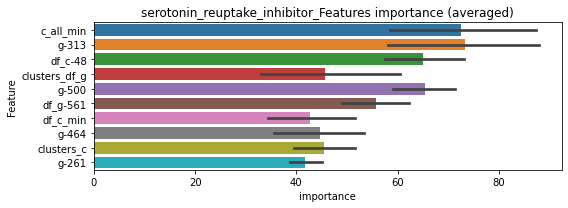

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222289	valid_1's binary_logloss: 0.0512481
[200]	training's binary_logloss: 0.00360354	valid_1's binary_logloss: 0.0291029
[300]	training's binary_logloss: 0.000997358	valid_1's binary_logloss: 0.0232427
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000697488	valid_1's binary_logloss: 0.0227223


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238569	valid_1's binary_logloss: 0.0399009
[200]	training's binary_logloss: 0.00408299	valid_1's binary_logloss: 0.0136033
[300]	training's binary_logloss: 0.00113531	valid_1's binary_logloss: 0.00805892
[400]	training's binary_logloss: 0.000525216	valid_1's binary_logloss: 0.00652582
[500]	training's binary_logloss: 0.00033199	valid_1's binary_logloss: 0.00597261
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000330789	valid_1's binary_logloss: 0.00597174


serotonin_reuptake_inhibitor logloss: 0.014348121175638974
sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040168	valid_1's binary_logloss: 0.0618174
[200]	training's binary_logloss: 0.0065966	valid_1's binary_logloss: 0.0184606
[300]	training's binary_logloss: 0.00183604	valid_1's binary_logloss: 0.00940717
[400]	training's binary_logloss: 0.000863686	valid_1's binary_logloss: 0.00673638
[500]	training's binary_logloss: 0.000564196	valid_1's binary_logloss: 0.00548766
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000576693	valid_1's binary_logloss: 0.00547592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401936	valid_1's binary_logloss: 0.0656508
[200]	training's binary_logloss: 0.00685071	valid_1's binary_logloss: 0.0206374
[300]	training's binary_logloss: 0.00188763	valid_1's binary_logloss: 0.00986533
[400]	training's binary_logloss: 0.000886591	valid_1's binary_logloss: 0.00691036
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0042798, Threshold: 0.0068706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00618, conf_1:0.00756
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0068706
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0168706
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0268706
threshold: 0.0268706, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386881	valid_1's binary_logloss: 0.0612241
[200]	training's binary_logloss: 0.00611845	valid_1's binary_logloss: 0.019115
[300]	training's binary_logloss: 0.00171909	valid_1's binary_logloss: 0.00983552
[400]	training's binary_logloss: 0.000838036	valid_1's binary_logloss: 0.00721633
[500]	training's binary_logloss: 0.000554343	valid_1's binary_logloss: 0.00601968
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000484832	valid_1's binary_logloss: 0.0057549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402553	valid_1's binary_logloss: 0.0628471
[200]	training's binary_logloss: 0.00662726	valid_1's binary_logloss: 0.0195388
[300]	training's binary_logloss: 0.00183517	valid_1's binary_logloss: 0.0100375
[400]	training's binary_logloss: 0.000870606	valid_1's binary_logloss: 0.00743066
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0767624, Threshold: 0.0268706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0072828 Vs.target_rate: 0.00151, Num_p_label: 29.0, conf_0:0.02418, conf_1:0.02956
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_1: 0.0268706
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0368706
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0468706
threshold: 0.0468706, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386881	valid_1's binary_logloss: 0.0612241
[200]	training's binary_logloss: 0.00611845	valid_1's binary_logloss: 0.019115
[300]	training's binary_logloss: 0.00171909	valid_1's binary_logloss: 0.00983552
[400]	training's binary_logloss: 0.000838036	valid_1's binary_logloss: 0.00721633
[500]	training's binary_logloss: 0.000554343	valid_1's binary_logloss: 0.00601968
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000484832	valid_1's binary_logloss: 0.0057549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402553	valid_1's binary_logloss: 0.0628471
[200]	training's binary_logloss: 0.00662726	valid_1's binary_logloss: 0.0195388
[300]	training's binary_logloss: 0.00183517	valid_1's binary_logloss: 0.0100375
[400]	training's binary_logloss: 0.000870606	valid_1's binary_logloss: 0.00743066
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0767624, Threshold: 0.0468706, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.04218, conf_1:0.05156
threshold: 0.0468706, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


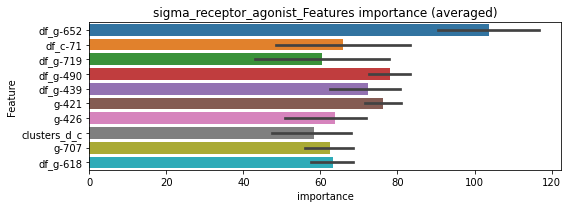

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022731	valid_1's binary_logloss: 0.0391147
[200]	training's binary_logloss: 0.00365699	valid_1's binary_logloss: 0.0148361
[300]	training's binary_logloss: 0.000997636	valid_1's binary_logloss: 0.0107832
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000947614	valid_1's binary_logloss: 0.0107273


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239377	valid_1's binary_logloss: 0.0366491
[200]	training's binary_logloss: 0.00399659	valid_1's binary_logloss: 0.0127937
[300]	training's binary_logloss: 0.00104716	valid_1's binary_logloss: 0.00817302
[400]	training's binary_logloss: 0.000486591	valid_1's binary_logloss: 0.0069034
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000347099	valid_1's binary_logloss: 0.00668625


sigma_receptor_agonist logloss: 0.00870702577838286
sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339468	valid_1's binary_logloss: 0.0580813
[200]	training's binary_logloss: 0.00526735	valid_1's binary_logloss: 0.0221128
[300]	training's binary_logloss: 0.00154447	valid_1's binary_logloss: 0.013587
[400]	training's binary_logloss: 0.000771716	valid_1's binary_logloss: 0.0109826
[500]	training's binary_logloss: 0.00052162	valid_1's binary_logloss: 0.00961465
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000468253	valid_1's binary_logloss: 0.00936619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381457	valid_1's binary_logloss: 0.0700067
[200]	training's binary_logloss: 0.00632219	valid_1's binary_logloss: 0.0302139
[300]	training's binary_logloss: 0.00174423	valid_1's binary_logloss: 0.0187375
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00100652	valid_1's binary_logloss: 0.0161377


1 / 3 AUC score:1.000
y_Threshold: 0.0053132, Threshold: 0.0088156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00793, conf_1:0.00970
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0088156
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.0188156
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0288156
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_4: 0.0388156
threshold: 0.0388156, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356955	valid_1's binary_logloss: 0.0552207
[200]	training's binary_logloss: 0.00545331	valid_1's binary_logloss: 0.0194769
[300]	training's binary_logloss: 0.00157271	valid_1's binary_logloss: 0.0119535
[400]	training's binary_logloss: 0.000776404	valid_1's binary_logloss: 0.00969062
[500]	training's binary_logloss: 0.000524176	valid_1's binary_logloss: 0.00857023
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000460248	valid_1's binary_logloss: 0.00822639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359652	valid_1's binary_logloss: 0.0655097
[200]	training's binary_logloss: 0.0055507	valid_1's binary_logloss: 0.0285417
[300]	training's binary_logloss: 0.00164242	valid_1's binary_logloss: 0.021272
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00127323	valid_1's binary_logloss: 0.0200706


2 / 3 AUC score:1.000
y_Threshold: 0.0302648, Threshold: 0.0388156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0085384 Vs.target_rate: 0.00151, Num_p_label: 34.0, conf_0:0.03493, conf_1:0.04270
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_1: 0.0388156
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.0488156
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0588156
threshold: 0.0588156, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349742	valid_1's binary_logloss: 0.051775
[200]	training's binary_logloss: 0.00540484	valid_1's binary_logloss: 0.01471
[300]	training's binary_logloss: 0.00157845	valid_1's binary_logloss: 0.00753039
[400]	training's binary_logloss: 0.000784062	valid_1's binary_logloss: 0.00552125
[500]	training's binary_logloss: 0.000520371	valid_1's binary_logloss: 0.00467657
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000467371	valid_1's binary_logloss: 0.00447853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355564	valid_1's binary_logloss: 0.0602321
[200]	training's binary_logloss: 0.00550361	valid_1's binary_logloss: 0.0187373
[300]	training's binary_logloss: 0.00158435	valid_1's binary_logloss: 0.0107624
[400]	training's binary_logloss: 0.000787916	valid_1's binary_logloss: 0.00801567
[500]	training's binary_logloss: 0.0005

3 / 3 AUC score:1.000
y_Threshold: 0.0352104, Threshold: 0.0588156, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0032647 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.05293, conf_1:0.06470
threshold: 0.0588156, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 665.0/7781, y_label_rate: 0.0854646


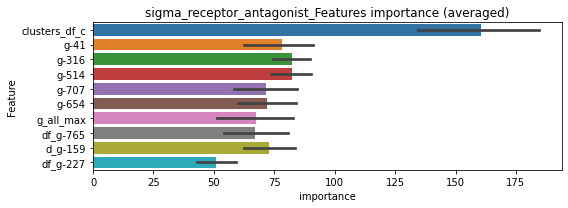

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196	valid_1's binary_logloss: 0.0358298
[200]	training's binary_logloss: 0.00306705	valid_1's binary_logloss: 0.0155835
[300]	training's binary_logloss: 0.000874258	valid_1's binary_logloss: 0.0125304
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000712423	valid_1's binary_logloss: 0.0123043


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201339	valid_1's binary_logloss: 0.0336907
[200]	training's binary_logloss: 0.0032844	valid_1's binary_logloss: 0.0122426
[300]	training's binary_logloss: 0.000949426	valid_1's binary_logloss: 0.00819483
[400]	training's binary_logloss: 0.000450569	valid_1's binary_logloss: 0.0073012
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000319453	valid_1's binary_logloss: 0.00696947


sigma_receptor_antagonist logloss: 0.009637247387889859
smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285072	valid_1's binary_logloss: 0.0449575
[200]	training's binary_logloss: 0.00400301	valid_1's binary_logloss: 0.0136617
[300]	training's binary_logloss: 0.00113328	valid_1's binary_logloss: 0.00769178
[400]	training's binary_logloss: 0.000565697	valid_1's binary_logloss: 0.00579922
[500]	training's binary_logloss: 0.000414387	valid_1's binary_logloss: 0.00509884
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000412365	valid_1's binary_logloss: 0.00508832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289219	valid_1's binary_logloss: 0.0423095
[200]	training's binary_logloss: 0.00396167	valid_1's binary_logloss: 0.0108441
[300]	training's binary_logloss: 0.00113008	valid_1's binary_logloss: 0.00541095
[400]	training's binary_logloss: 0.000577961	valid_1's binary_logloss: 0.0038966
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0021736, Threshold: 0.0038137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00343, conf_1:0.00420
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0038137
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_2: 0.0138137
threshold: 0.0138137, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282963	valid_1's binary_logloss: 0.0430703
[200]	training's binary_logloss: 0.00389681	valid_1's binary_logloss: 0.0123732
[300]	training's binary_logloss: 0.00111746	valid_1's binary_logloss: 0.00673732
[400]	training's binary_logloss: 0.000564735	valid_1's binary_logloss: 0.00507019
[500]	training's binary_logloss: 0.000414225	valid_1's binary_logloss: 0.00444945
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000396605	valid_1's binary_logloss: 0.00435889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282153	valid_1's binary_logloss: 0.043259
[200]	training's binary_logloss: 0.00380971	valid_1's binary_logloss: 0.0116461
[300]	training's binary_logloss: 0.0010959	valid_1's binary_logloss: 0.0060827
[400]	training's binary_logloss: 0.000569503	valid_1's binary_logloss: 0.00447738
Early stopping, best iteration is:
[46

2 / 3 AUC score:1.000
y_Threshold: 0.1003145, Threshold: 0.0138137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0055249 Vs.target_rate: 0.00105, Num_p_label: 22.0, conf_0:0.01243, conf_1:0.01520
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_1: 0.0138137
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.0238137
threshold: 0.0238137, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282963	valid_1's binary_logloss: 0.0430703
[200]	training's binary_logloss: 0.00389681	valid_1's binary_logloss: 0.0123732
[300]	training's binary_logloss: 0.00111746	valid_1's binary_logloss: 0.00673732
[400]	training's binary_logloss: 0.000564735	valid_1's binary_logloss: 0.00507019
[500]	training's binary_logloss: 0.000414225	valid_1's binary_logloss: 0.00444945
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000396605	valid_1's binary_logloss: 0.00435889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282153	valid_1's binary_logloss: 0.043259
[200]	training's binary_logloss: 0.00380971	valid_1's binary_logloss: 0.0116461
[300]	training's binary_logloss: 0.0010959	valid_1's binary_logloss: 0.0060827
[400]	training's binary_logloss: 0.000569503	valid_1's binary_logloss: 0.00447738
Early stopping, best iteration is:
[46

3 / 3 AUC score:1.000
y_Threshold: 0.1003145, Threshold: 0.0238137, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.02143, conf_1:0.02620
threshold: 0.0238137, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7790, y_label_rate: 0.0849807


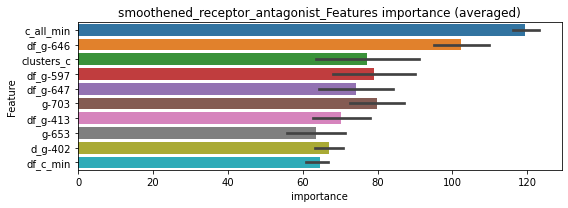

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150198	valid_1's binary_logloss: 0.0271487
[200]	training's binary_logloss: 0.00205939	valid_1's binary_logloss: 0.0116167
[300]	training's binary_logloss: 0.000583836	valid_1's binary_logloss: 0.00963899
[400]	training's binary_logloss: 0.000288625	valid_1's binary_logloss: 0.0092642
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000266325	valid_1's binary_logloss: 0.0091917


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158325	valid_1's binary_logloss: 0.023552
[200]	training's binary_logloss: 0.00220336	valid_1's binary_logloss: 0.00701619
[300]	training's binary_logloss: 0.000621943	valid_1's binary_logloss: 0.00409103
[400]	training's binary_logloss: 0.00031381	valid_1's binary_logloss: 0.00338283
[500]	training's binary_logloss: 0.000222558	valid_1's binary_logloss: 0.00313556
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000214048	valid_1's binary_logloss: 0.00312334


smoothened_receptor_antagonist logloss: 0.006157520763041165
sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991


neg labels: 3289 → selected neg labels: 3244


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1959	valid_1's binary_logloss: 0.305237
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.15877	valid_1's binary_logloss: 0.301063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215923	valid_1's binary_logloss: 0.29355
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.151788	valid_1's binary_logloss: 0.277105


1 / 3 AUC score:0.835
y_Threshold: 0.1893980, Threshold: 0.2917036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 573 → Positive_corect_labels: 427/3319
p_label_rate: 0.0200904 Vs.target_rate: 0.01121, Num_p_label: 80.0, conf_0:0.26253, conf_1:0.32087
threshold: 0.2917036, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 427.0/3319, y_label_rate: 0.1286532
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817162	valid_1's binary_logloss: 0.141227
[200]	training's binary_logloss: 0.0327066	valid_1's binary_logloss: 0.116043
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0247238	valid_1's binary_logloss: 0.112781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898311	valid_1's binary_logloss: 0.130898
[200]	training's binary_logloss: 0.0384981	valid_1's binary_logloss: 0.0982972


2 / 3 AUC score:0.983
y_Threshold: 0.1927327, Threshold: 0.2917036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 122 → Positive_corect_labels: 366.0/3197
p_label_rate: 0.0346560 Vs.target_rate: 0.01121, Num_p_label: 138.0, conf_0:0.26253, conf_1:0.32087
Num_p_label: 138.0, Expected: 44.6, Adj_threshold_1: 0.2917036
Num_p_label: 131.0, Expected: 44.6, Adj_threshold_2: 0.3017036
Num_p_label: 124.0, Expected: 44.6, Adj_threshold_3: 0.3117036
Num_p_label: 117.0, Expected: 44.6, Adj_threshold_4: 0.3217036
Num_p_label: 113.0, Expected: 44.6, Adj_threshold_5: 0.3317036


[300]	training's binary_logloss: 0.0190361	valid_1's binary_logloss: 0.0891516
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0166441	valid_1's binary_logloss: 0.0883624


Num_p_label: 102.0, Expected: 44.6, Adj_threshold_6: 0.3417036
Num_p_label: 100.0, Expected: 44.6, Adj_threshold_7: 0.3517036
Num_p_label: 93.0, Expected: 44.6, Adj_threshold_8: 0.3617036
Num_p_label: 90.0, Expected: 44.6, Adj_threshold_9: 0.3717036
Num_p_label: 85.0, Expected: 44.6, Adj_threshold_10: 0.3817036
threshold: 0.3817036, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 366.0/3197, y_label_rate: 0.1144823
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531898	valid_1's binary_logloss: 0.0969138
[200]	training's binary_logloss: 0.0174633	valid_1's binary_logloss: 0.0694235
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.011484	valid_1's binary_logloss: 0.0637328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559873	valid_1's binary_logloss: 0.0955934
[200]	training's binary_logloss: 0.0183817	valid_1's binary_logloss: 0.0640911
[300]	training's binary_logloss: 0.00783459	valid_1's binary_logloss: 0.0542015
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00466529	valid_1's binary_logloss: 0.0498723


3 / 3 AUC score:0.997
y_Threshold: 0.1324737, Threshold: 0.3817036, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 343.0/3151
p_label_rate: 0.0183325 Vs.target_rate: 0.01121, Num_p_label: 73.0, conf_0:0.34353, conf_1:0.41987
threshold: 0.3817036, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 416.0/7133, y_label_rate: 0.0583205


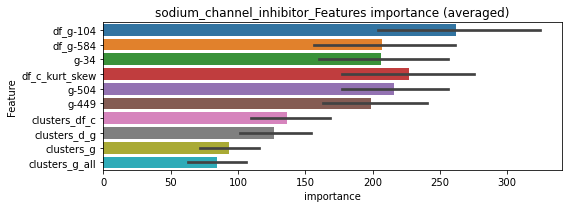

len(train_index) : 3566
len(valid_index) : 3567
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368554	valid_1's binary_logloss: 0.061585
[200]	training's binary_logloss: 0.0125848	valid_1's binary_logloss: 0.0431877
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00691155	valid_1's binary_logloss: 0.0388654


len(train_index) : 3567
len(valid_index) : 3566
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322649	valid_1's binary_logloss: 0.0640064
[200]	training's binary_logloss: 0.0102595	valid_1's binary_logloss: 0.0459
[300]	training's binary_logloss: 0.00456093	valid_1's binary_logloss: 0.0403803
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00466241	valid_1's binary_logloss: 0.0402347


sodium_channel_inhibitor logloss: 0.039549918454718946
sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343294	valid_1's binary_logloss: 0.0569356
[200]	training's binary_logloss: 0.00516424	valid_1's binary_logloss: 0.0178445
[300]	training's binary_logloss: 0.00145528	valid_1's binary_logloss: 0.00888986
[400]	training's binary_logloss: 0.000719833	valid_1's binary_logloss: 0.00622577
[500]	training's binary_logloss: 0.000488544	valid_1's binary_logloss: 0.00521701
[600]	training's binary_logloss: 0.0004377	valid_1's binary_logloss: 0.00500742
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000437023	valid_1's binary_logloss: 0.00500169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358862	valid_1's binary_logloss: 0.0584075
[200]	training's binary_logloss: 0.00526057	valid_1's binary_logloss: 0.0230818
[300]	training's binary_logloss: 0.00147656	valid_1's binary_logloss: 0.0165319
Early stopping, best iteration is:
[38

1 / 3 AUC score:1.000
y_Threshold: 0.0040988, Threshold: 0.0098383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134, Num_p_label: 80.0, conf_0:0.00885, conf_1:0.01082
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0098383
Num_p_label: 36.0, Expected: 5.4, Adj_threshold_2: 0.0198383
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_3: 0.0298383
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_4: 0.0398383
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_5: 0.0498383
threshold: 0.0498383, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350327	valid_1's binary_logloss: 0.0565819
[200]	training's binary_logloss: 0.00504173	valid_1's binary_logloss: 0.0156446
[300]	training's binary_logloss: 0.00141629	valid_1's binary_logloss: 0.00737182
[400]	training's binary_logloss: 0.000705448	valid_1's binary_logloss: 0.00528608
[500]	training's binary_logloss: 0.000482311	valid_1's binary_logloss: 0.00435833
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000453078	valid_1's binary_logloss: 0.00419673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337027	valid_1's binary_logloss: 0.0560299
[200]	training's binary_logloss: 0.00484889	valid_1's binary_logloss: 0.0209824
[300]	training's binary_logloss: 0.00139939	valid_1's binary_logloss: 0.0151583
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000764444	valid_1's binary_logloss: 0.0131078


2 / 3 AUC score:1.000
y_Threshold: 0.0350960, Threshold: 0.0498383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0095429 Vs.target_rate: 0.00134, Num_p_label: 38.0, conf_0:0.04485, conf_1:0.05482
Num_p_label: 38.0, Expected: 5.4, Adj_threshold_1: 0.0498383
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_2: 0.0598383
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_3: 0.0698383
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_4: 0.0798383
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_5: 0.0898383
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_6: 0.0998383
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_7: 0.1098383
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_8: 0.1198383
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_9: 0.1298383
threshold: 0.1298383, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334725	valid_1's binary_logloss: 0.0502143
[200]	training's binary_logloss: 0.00489573	valid_1's binary_logloss: 0.0131503
[300]	training's binary_logloss: 0.00140138	valid_1's binary_logloss: 0.00628066
[400]	training's binary_logloss: 0.000701259	valid_1's binary_logloss: 0.0044276
[500]	training's binary_logloss: 0.000482944	valid_1's binary_logloss: 0.00375663
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00044901	valid_1's binary_logloss: 0.00364845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344189	valid_1's binary_logloss: 0.0554217
[200]	training's binary_logloss: 0.00514781	valid_1's binary_logloss: 0.0179434
[300]	training's binary_logloss: 0.00144218	valid_1's binary_logloss: 0.0106243
[400]	training's binary_logloss: 0.000714639	valid_1's binary_logloss: 0.00851258
Early stopping, best iteration is:
[45

3 / 3 AUC score:1.000
y_Threshold: 0.0195592, Threshold: 0.1298383, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00134, Num_p_label: 10.0, conf_0:0.11685, conf_1:0.14282
threshold: 0.1298383, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


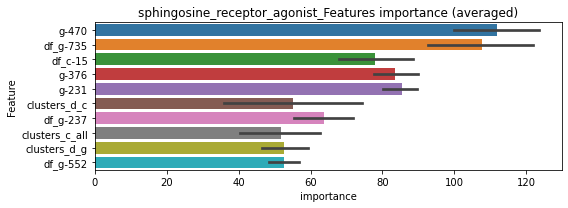

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200708	valid_1's binary_logloss: 0.0396428
[200]	training's binary_logloss: 0.002993	valid_1's binary_logloss: 0.0191922
[300]	training's binary_logloss: 0.000792806	valid_1's binary_logloss: 0.0150332
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000719103	valid_1's binary_logloss: 0.0148939


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190185	valid_1's binary_logloss: 0.0344056
[200]	training's binary_logloss: 0.00284679	valid_1's binary_logloss: 0.0128023
[300]	training's binary_logloss: 0.000787864	valid_1's binary_logloss: 0.00784739
[400]	training's binary_logloss: 0.00038624	valid_1's binary_logloss: 0.00673548
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000296764	valid_1's binary_logloss: 0.00641308


sphingosine_receptor_agonist logloss: 0.010654023889483947
src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461


neg labels: 3289 → selected neg labels: 3277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943545	valid_1's binary_logloss: 0.165755
[200]	training's binary_logloss: 0.0436259	valid_1's binary_logloss: 0.130256
[300]	training's binary_logloss: 0.0206036	valid_1's binary_logloss: 0.116097
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0156539	valid_1's binary_logloss: 0.113638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102634	valid_1's binary_logloss: 0.15685
[200]	training's binary_logloss: 0.0510196	valid_1's binary_logloss: 0.11938
[300]	training's binary_logloss: 0.0258818	valid_1's binary_logloss: 0.100078
[400]	training's binary_logloss: 0.0139797	valid_1's binary_logloss: 0.0909837
[500]	training's binary_logloss: 0.00811083	valid_1's binary_logloss: 0.0860333
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00845152	valid_1's binary_logloss: 0.0860016


1 / 3 AUC score:0.989
y_Threshold: 0.1494195, Threshold: 0.4720886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 202 → Positive_corect_labels: 620/3730
p_label_rate: 0.0200904 Vs.target_rate: 0.00298, Num_p_label: 80.0, conf_0:0.42488, conf_1:0.51930
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.4720886
Num_p_label: 78.0, Expected: 11.9, Adj_threshold_2: 0.4820886
Num_p_label: 77.0, Expected: 11.9, Adj_threshold_3: 0.4920886
Num_p_label: 77.0, Expected: 11.9, Adj_threshold_4: 0.5020886
Num_p_label: 76.0, Expected: 11.9, Adj_threshold_5: 0.5120886
Num_p_label: 75.0, Expected: 11.9, Adj_threshold_6: 0.5220886
Num_p_label: 74.0, Expected: 11.9, Adj_threshold_7: 0.5320886
Num_p_label: 72.0, Expected: 11.9, Adj_threshold_8: 0.5420886
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_9: 0.5520886
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_10: 0.5620886
threshold: 0.5720886, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 620.0/3730, y_label_rate: 0.166219

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642634	valid_1's binary_logloss: 0.115487
[200]	training's binary_logloss: 0.0216866	valid_1's binary_logloss: 0.0751882
[300]	training's binary_logloss: 0.00895995	valid_1's binary_logloss: 0.0630624
[400]	training's binary_logloss: 0.00450369	valid_1's binary_logloss: 0.0565155
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00376399	valid_1's binary_logloss: 0.055108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687549	valid_1's binary_logloss: 0.119934
[200]	training's binary_logloss: 0.0236509	valid_1's binary_logloss: 0.0850541
[300]	training's binary_logloss: 0.00970103	valid_1's binary_logloss: 0.0719005
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00869618	valid_1's binary_logloss: 0.0707821


2 / 3 AUC score:0.995
y_Threshold: 0.2512384, Threshold: 0.5720886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 579.0/3648
p_label_rate: 0.0326469 Vs.target_rate: 0.00298, Num_p_label: 130.0, conf_0:0.51488, conf_1:0.62930
Num_p_label: 130.0, Expected: 11.9, Adj_threshold_1: 0.5720886
Num_p_label: 126.0, Expected: 11.9, Adj_threshold_2: 0.5820886
Num_p_label: 125.0, Expected: 11.9, Adj_threshold_3: 0.5920886
Num_p_label: 122.0, Expected: 11.9, Adj_threshold_4: 0.6020886
Num_p_label: 117.0, Expected: 11.9, Adj_threshold_5: 0.6120886
Num_p_label: 116.0, Expected: 11.9, Adj_threshold_6: 0.6220886
Num_p_label: 112.0, Expected: 11.9, Adj_threshold_7: 0.6320886
Num_p_label: 111.0, Expected: 11.9, Adj_threshold_8: 0.6420886
Num_p_label: 109.0, Expected: 11.9, Adj_threshold_9: 0.6520886
Num_p_label: 107.0, Expected: 11.9, Adj_threshold_10: 0.6620886
threshold: 0.6720886, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 579.0/3648, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546812	valid_1's binary_logloss: 0.0960326
[200]	training's binary_logloss: 0.0158087	valid_1's binary_logloss: 0.0595188
[300]	training's binary_logloss: 0.00626401	valid_1's binary_logloss: 0.0471898
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00502721	valid_1's binary_logloss: 0.0456032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544062	valid_1's binary_logloss: 0.0975902
[200]	training's binary_logloss: 0.01477	valid_1's binary_logloss: 0.05961
[300]	training's binary_logloss: 0.00584247	valid_1's binary_logloss: 0.0501364
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00363018	valid_1's binary_logloss: 0.0467572


3 / 3 AUC score:0.996
y_Threshold: 0.1857019, Threshold: 0.6720886, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 556.0/3602
p_label_rate: 0.0286288 Vs.target_rate: 0.00298, Num_p_label: 114.0, conf_0:0.60488, conf_1:0.73930
Num_p_label: 114.0, Expected: 11.9, Adj_threshold_1: 0.6720886
Num_p_label: 112.0, Expected: 11.9, Adj_threshold_2: 0.6820886
Num_p_label: 111.0, Expected: 11.9, Adj_threshold_3: 0.6920886
Num_p_label: 107.0, Expected: 11.9, Adj_threshold_4: 0.7020886
Num_p_label: 103.0, Expected: 11.9, Adj_threshold_5: 0.7120886
Num_p_label: 102.0, Expected: 11.9, Adj_threshold_6: 0.7220886
Num_p_label: 101.0, Expected: 11.9, Adj_threshold_7: 0.7320886
Num_p_label: 101.0, Expected: 11.9, Adj_threshold_8: 0.7420886
Num_p_label: 100.0, Expected: 11.9, Adj_threshold_9: 0.7520886
Num_p_label: 99.0, Expected: 11.9, Adj_threshold_10: 0.7620886
threshold: 0.7720886, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 653.0/7584, y_label_rat

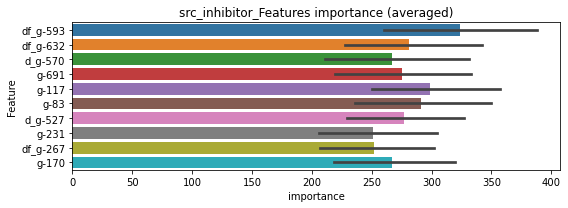

len(train_index) : 3792
len(valid_index) : 3792
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313683	valid_1's binary_logloss: 0.0598626
[200]	training's binary_logloss: 0.00905497	valid_1's binary_logloss: 0.0397184


len(train_index) : 3792
len(valid_index) : 3792
================================= fold 2/2 src_inhibitor=================================


[300]	training's binary_logloss: 0.00374182	valid_1's binary_logloss: 0.0350536
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00374182	valid_1's binary_logloss: 0.0350536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310262	valid_1's binary_logloss: 0.0653694
[200]	training's binary_logloss: 0.00890108	valid_1's binary_logloss: 0.0454131
[300]	training's binary_logloss: 0.00350049	valid_1's binary_logloss: 0.0403757
[400]	training's binary_logloss: 0.00186387	valid_1's binary_logloss: 0.0384282


src_inhibitor logloss: 0.036647902456188805


Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00170782	valid_1's binary_logloss: 0.0382423


steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119685	valid_1's binary_logloss: 0.193066
[200]	training's binary_logloss: 0.065101	valid_1's binary_logloss: 0.159095
[300]	training's binary_logloss: 0.0331436	valid_1's binary_logloss: 0.141503
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0273272	valid_1's binary_logloss: 0.139244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130096	valid_1's binary_logloss: 0.189121
[200]	training's binary_logloss: 0.0650951	valid_1's binary_logloss: 0.145596


1 / 3 AUC score:0.975
y_Threshold: 0.1526360, Threshold: 0.3991028, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 270 → Positive_corect_labels: 586/3661
p_label_rate: 0.0200904 Vs.target_rate: 0.00332, Num_p_label: 80.0, conf_0:0.35919, conf_1:0.43901
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.3991028
Num_p_label: 75.0, Expected: 13.2, Adj_threshold_2: 0.4091028
Num_p_label: 73.0, Expected: 13.2, Adj_threshold_3: 0.4191028
Num_p_label: 69.0, Expected: 13.2, Adj_threshold_4: 0.4291028
Num_p_label: 64.0, Expected: 13.2, Adj_threshold_5: 0.4391028
Num_p_label: 62.0, Expected: 13.2, Adj_threshold_6: 0.4491028
Num_p_label: 59.0, Expected: 13.2, Adj_threshold_7: 0.4591028
Num_p_label: 55.0, Expected: 13.2, Adj_threshold_8: 0.4691028


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0372451	valid_1's binary_logloss: 0.131653


Num_p_label: 52.0, Expected: 13.2, Adj_threshold_9: 0.4791028
Num_p_label: 50.0, Expected: 13.2, Adj_threshold_10: 0.4891028
threshold: 0.4991028, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 586.0/3661, y_label_rate: 0.1600656
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833426	valid_1's binary_logloss: 0.120805
[200]	training's binary_logloss: 0.0321008	valid_1's binary_logloss: 0.0721974
[300]	training's binary_logloss: 0.013931	valid_1's binary_logloss: 0.0530436
[400]	training's binary_logloss: 0.00698443	valid_1's binary_logloss: 0.0438138
[500]	training's binary_logloss: 0.00431794	valid_1's binary_logloss: 0.0399394
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00342338	valid_1's binary_logloss: 0.0383347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847686	valid_1's binary_logloss: 0.120482
[200]	training's binary_logloss: 0.0313091	valid_1's binary_logloss: 0.073495
[300]	training's binary_logloss: 0.0139162	valid_1's binary_logloss: 0.0561287
[400]	training's binary_logloss: 0.00743137	valid_1's binary_logloss: 0.0490469
[500]	training's binary_logloss: 0.00438276	valid_1's

2 / 3 AUC score:0.998
y_Threshold: 0.2276188, Threshold: 0.4991028, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 50 → Positive_corect_labels: 561.0/3611
p_label_rate: 0.0268709 Vs.target_rate: 0.00332, Num_p_label: 107.0, conf_0:0.44919, conf_1:0.54901
Num_p_label: 107.0, Expected: 13.2, Adj_threshold_1: 0.4991028
Num_p_label: 106.0, Expected: 13.2, Adj_threshold_2: 0.5091028
Num_p_label: 106.0, Expected: 13.2, Adj_threshold_3: 0.5191028
Num_p_label: 103.0, Expected: 13.2, Adj_threshold_4: 0.5291028
Num_p_label: 101.0, Expected: 13.2, Adj_threshold_5: 0.5391028
Num_p_label: 100.0, Expected: 13.2, Adj_threshold_6: 0.5491028
Num_p_label: 96.0, Expected: 13.2, Adj_threshold_7: 0.5591028
Num_p_label: 92.0, Expected: 13.2, Adj_threshold_8: 0.5691028
Num_p_label: 91.0, Expected: 13.2, Adj_threshold_9: 0.5791028
Num_p_label: 89.0, Expected: 13.2, Adj_threshold_10: 0.5891028
threshold: 0.5991028, positive_p_label: 85.0/3982, p_label_rate: 0.0213461
positive_y_label: 561.0/3611, y_label_rate: 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743029	valid_1's binary_logloss: 0.111385
[200]	training's binary_logloss: 0.0247719	valid_1's binary_logloss: 0.0695613
[300]	training's binary_logloss: 0.0102276	valid_1's binary_logloss: 0.0568176
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00645284	valid_1's binary_logloss: 0.0536889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698953	valid_1's binary_logloss: 0.11425
[200]	training's binary_logloss: 0.0236174	valid_1's binary_logloss: 0.0733543


3 / 3 AUC score:0.995
y_Threshold: 0.2564139, Threshold: 0.5991028, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 529.0/3547
p_label_rate: 0.0248619 Vs.target_rate: 0.00332, Num_p_label: 99.0, conf_0:0.53919, conf_1:0.65901
Num_p_label: 99.0, Expected: 13.2, Adj_threshold_1: 0.5991028
Num_p_label: 98.0, Expected: 13.2, Adj_threshold_2: 0.6091028
Num_p_label: 94.0, Expected: 13.2, Adj_threshold_3: 0.6191028
Num_p_label: 90.0, Expected: 13.2, Adj_threshold_4: 0.6291028


[300]	training's binary_logloss: 0.00971413	valid_1's binary_logloss: 0.0587253
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0085075	valid_1's binary_logloss: 0.0577452


Num_p_label: 89.0, Expected: 13.2, Adj_threshold_5: 0.6391028
Num_p_label: 87.0, Expected: 13.2, Adj_threshold_6: 0.6491028
Num_p_label: 84.0, Expected: 13.2, Adj_threshold_7: 0.6591028
Num_p_label: 82.0, Expected: 13.2, Adj_threshold_8: 0.6691028
Num_p_label: 82.0, Expected: 13.2, Adj_threshold_9: 0.6791028
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_10: 0.6891028
threshold: 0.6991028, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 605.0/7529, y_label_rate: 0.0803560


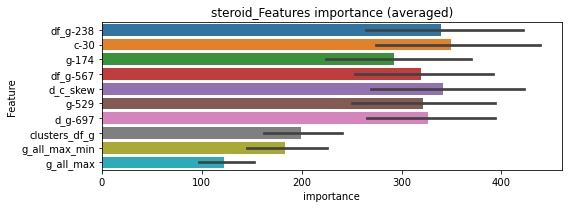

len(train_index) : 3764
len(valid_index) : 3765
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047151	valid_1's binary_logloss: 0.0708704
[200]	training's binary_logloss: 0.0160273	valid_1's binary_logloss: 0.0443568
[300]	training's binary_logloss: 0.00681905	valid_1's binary_logloss: 0.0364966
[400]	training's binary_logloss: 0.00338814	valid_1's binary_logloss: 0.0333252
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00326278	valid_1's binary_logloss: 0.0331661


len(train_index) : 3765
len(valid_index) : 3764
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043717	valid_1's binary_logloss: 0.0689097
[200]	training's binary_logloss: 0.0156017	valid_1's binary_logloss: 0.0419438
[300]	training's binary_logloss: 0.00649736	valid_1's binary_logloss: 0.0336381
[400]	training's binary_logloss: 0.00336466	valid_1's binary_logloss: 0.0305015
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00260531	valid_1's binary_logloss: 0.0294806


steroid logloss: 0.03132360529594573
syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212738	valid_1's binary_logloss: 0.0347634
[200]	training's binary_logloss: 0.00234515	valid_1's binary_logloss: 0.0118919
[300]	training's binary_logloss: 0.000667874	valid_1's binary_logloss: 0.00800078
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000418362	valid_1's binary_logloss: 0.00719397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217912	valid_1's binary_logloss: 0.0269191
[200]	training's binary_logloss: 0.00242953	valid_1's binary_logloss: 0.00542097
[300]	training's binary_logloss: 0.000690528	valid_1's binary_logloss: 0.00273446
[400]	training's binary_logloss: 0.000378143	valid_1's binary_logloss: 0.00210523
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000332414	valid_1's binary_logloss: 0.00204012


1 / 3 AUC score:1.000
y_Threshold: 0.0022467, Threshold: 0.0040428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00364, conf_1:0.00445
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0040428
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_2: 0.0140428
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0240428
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.0340428
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.0440428
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.0540428
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.0640428
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_8: 0.0740428
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.0840428
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.0940428
threshold: 0.1040428, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204352	valid_1's binary_logloss: 0.0330436
[200]	training's binary_logloss: 0.00216484	valid_1's binary_logloss: 0.0115482
[300]	training's binary_logloss: 0.000614848	valid_1's binary_logloss: 0.00840664
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000377681	valid_1's binary_logloss: 0.00775471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210309	valid_1's binary_logloss: 0.0260557
[200]	training's binary_logloss: 0.0022859	valid_1's binary_logloss: 0.00456445
[300]	training's binary_logloss: 0.000651217	valid_1's binary_logloss: 0.00191991
[400]	training's binary_logloss: 0.000354841	valid_1's binary_logloss: 0.00128992
[500]	training's binary_logloss: 0.000301261	valid_1's binary_logloss: 0.00121223
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000302379	valid_1's binary_logloss: 0.0012117

2 / 3 AUC score:1.000
y_Threshold: 0.0203936, Threshold: 0.1040428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0057760 Vs.target_rate: 0.00080, Num_p_label: 23.0, conf_0:0.09364, conf_1:0.11445
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_1: 0.1040428
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.1140428
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_3: 0.1240428
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_4: 0.1340428
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.1440428
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.1540428
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.1640428
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_8: 0.1740428
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.1840428
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_10: 0.1940428
threshold: 0.2040428, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203626	valid_1's binary_logloss: 0.0346028
[200]	training's binary_logloss: 0.0021855	valid_1's binary_logloss: 0.0127839
[300]	training's binary_logloss: 0.00062642	valid_1's binary_logloss: 0.00845844
[400]	training's binary_logloss: 0.000349283	valid_1's binary_logloss: 0.00721969
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000308311	valid_1's binary_logloss: 0.00699361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209999	valid_1's binary_logloss: 0.0244685
[200]	training's binary_logloss: 0.00222872	valid_1's binary_logloss: 0.00329423
[300]	training's binary_logloss: 0.000632279	valid_1's binary_logloss: 0.00113401
[400]	training's binary_logloss: 0.00034779	valid_1's binary_logloss: 0.000686543
[500]	training's binary_logloss: 0.00029285	valid_1's binary_logloss: 0.000592006
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0303915, Threshold: 0.2040428, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0035158 Vs.target_rate: 0.00080, Num_p_label: 14.0, conf_0:0.18364, conf_1:0.22445
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_1: 0.2040428
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.2140428
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.2240428
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.2340428
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.2440428
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.2540428
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.2640428
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.2740428
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.2840428
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_10: 0.2940428
threshold: 0.3040428, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7791, y_label_rate: 0.0852265


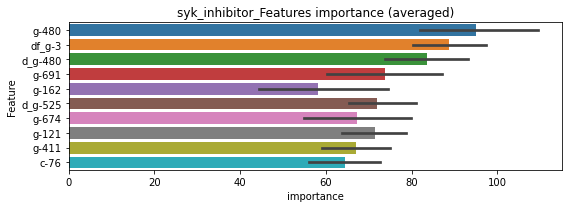

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108608	valid_1's binary_logloss: 0.0160362
[200]	training's binary_logloss: 0.00115462	valid_1's binary_logloss: 0.00426513
[300]	training's binary_logloss: 0.000330027	valid_1's binary_logloss: 0.00268655
[400]	training's binary_logloss: 0.000183448	valid_1's binary_logloss: 0.00234952
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000177763	valid_1's binary_logloss: 0.00231501


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113144	valid_1's binary_logloss: 0.0165403
[200]	training's binary_logloss: 0.00121625	valid_1's binary_logloss: 0.00429138
[300]	training's binary_logloss: 0.000341347	valid_1's binary_logloss: 0.00264366
[400]	training's binary_logloss: 0.000188825	valid_1's binary_logloss: 0.00227171
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00016771	valid_1's binary_logloss: 0.00219064


syk_inhibitor logloss: 0.002252833490386309
tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266


neg labels: 3289 → selected neg labels: 3279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949441	valid_1's binary_logloss: 0.138578
[200]	training's binary_logloss: 0.0393049	valid_1's binary_logloss: 0.0974071
[300]	training's binary_logloss: 0.0174961	valid_1's binary_logloss: 0.0834753
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0151453	valid_1's binary_logloss: 0.0826335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920144	valid_1's binary_logloss: 0.149499
[200]	training's binary_logloss: 0.0372648	valid_1's binary_logloss: 0.102767
[300]	training's binary_logloss: 0.0170047	valid_1's binary_logloss: 0.0861679


1 / 3 AUC score:0.991
y_Threshold: 0.0879314, Threshold: 0.1985018, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 192 → Positive_corect_labels: 625/3742
p_label_rate: 0.0200904 Vs.target_rate: 0.00252, Num_p_label: 80.0, conf_0:0.17865, conf_1:0.21835
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.1985018
Num_p_label: 75.0, Expected: 10.0, Adj_threshold_2: 0.2085018
Num_p_label: 75.0, Expected: 10.0, Adj_threshold_3: 0.2185018
Num_p_label: 70.0, Expected: 10.0, Adj_threshold_4: 0.2285018
Num_p_label: 66.0, Expected: 10.0, Adj_threshold_5: 0.2385018


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00966855	valid_1's binary_logloss: 0.0790437


Num_p_label: 63.0, Expected: 10.0, Adj_threshold_6: 0.2485018
Num_p_label: 62.0, Expected: 10.0, Adj_threshold_7: 0.2585018
Num_p_label: 57.0, Expected: 10.0, Adj_threshold_8: 0.2685018
Num_p_label: 57.0, Expected: 10.0, Adj_threshold_9: 0.2785018
Num_p_label: 54.0, Expected: 10.0, Adj_threshold_10: 0.2885018
threshold: 0.2985018, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 625.0/3742, y_label_rate: 0.1670230
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073221	valid_1's binary_logloss: 0.115184
[200]	training's binary_logloss: 0.0229853	valid_1's binary_logloss: 0.0637877
[300]	training's binary_logloss: 0.00976146	valid_1's binary_logloss: 0.0490928
[400]	training's binary_logloss: 0.0050152	valid_1's binary_logloss: 0.042136
[500]	training's binary_logloss: 0.00315711	valid_1's binary_logloss: 0.0397099
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0025731	valid_1's binary_logloss: 0.0381818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715235	valid_1's binary_logloss: 0.114939
[200]	training's binary_logloss: 0.0224582	valid_1's binary_logloss: 0.0746418
[300]	training's binary_logloss: 0.00888403	valid_1's binary_logloss: 0.062811


2 / 3 AUC score:0.997
y_Threshold: 0.2839121, Threshold: 0.2985018, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 596.0/3684
p_label_rate: 0.0281266 Vs.target_rate: 0.00252, Num_p_label: 112.0, conf_0:0.26865, conf_1:0.32835
Num_p_label: 112.0, Expected: 10.0, Adj_threshold_1: 0.2985018
Num_p_label: 110.0, Expected: 10.0, Adj_threshold_2: 0.3085018
Num_p_label: 108.0, Expected: 10.0, Adj_threshold_3: 0.3185018


[400]	training's binary_logloss: 0.00450326	valid_1's binary_logloss: 0.0586375
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00436233	valid_1's binary_logloss: 0.0584061


Num_p_label: 104.0, Expected: 10.0, Adj_threshold_4: 0.3285018
Num_p_label: 100.0, Expected: 10.0, Adj_threshold_5: 0.3385018
Num_p_label: 98.0, Expected: 10.0, Adj_threshold_6: 0.3485018
Num_p_label: 93.0, Expected: 10.0, Adj_threshold_7: 0.3585018
Num_p_label: 87.0, Expected: 10.0, Adj_threshold_8: 0.3685018
Num_p_label: 83.0, Expected: 10.0, Adj_threshold_9: 0.3785018
Num_p_label: 82.0, Expected: 10.0, Adj_threshold_10: 0.3885018
threshold: 0.3985018, positive_p_label: 81.0/3982, p_label_rate: 0.0203415
positive_y_label: 596.0/3684, y_label_rate: 0.1617807
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613395	valid_1's binary_logloss: 0.0939225
[200]	training's binary_logloss: 0.017688	valid_1's binary_logloss: 0.0466102
[300]	training's binary_logloss: 0.00667451	valid_1's binary_logloss: 0.033703
[400]	training's binary_logloss: 0.0034271	valid_1's binary_logloss: 0.030073
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00259234	valid_1's binary_logloss: 0.0284811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639349	valid_1's binary_logloss: 0.093077
[200]	training's binary_logloss: 0.0184294	valid_1's binary_logloss: 0.0430951
[300]	training's binary_logloss: 0.00732335	valid_1's binary_logloss: 0.028929
[400]	training's binary_logloss: 0.00375427	valid_1's binary_logloss: 0.0223223
[500]	training's binary_logloss: 0.00244524	valid_1's binary_logloss: 0.0194828
[600]	training's binary_logloss: 0.00180541	valid_1's

3 / 3 AUC score:1.000
y_Threshold: 0.2306757, Threshold: 0.3985018, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 585.0/3662
p_label_rate: 0.0226017 Vs.target_rate: 0.00252, Num_p_label: 90.0, conf_0:0.35865, conf_1:0.43835
Num_p_label: 90.0, Expected: 10.0, Adj_threshold_1: 0.3985018
Num_p_label: 87.0, Expected: 10.0, Adj_threshold_2: 0.4085018
Num_p_label: 87.0, Expected: 10.0, Adj_threshold_3: 0.4185018
Num_p_label: 85.0, Expected: 10.0, Adj_threshold_4: 0.4285018
Num_p_label: 82.0, Expected: 10.0, Adj_threshold_5: 0.4385018
Num_p_label: 79.0, Expected: 10.0, Adj_threshold_6: 0.4485018
Num_p_label: 79.0, Expected: 10.0, Adj_threshold_7: 0.4585018
Num_p_label: 78.0, Expected: 10.0, Adj_threshold_8: 0.4685018
Num_p_label: 77.0, Expected: 10.0, Adj_threshold_9: 0.4785018
Num_p_label: 76.0, Expected: 10.0, Adj_threshold_10: 0.4885018
threshold: 0.4985018, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 659.0/7644, y_label_rate: 0.08621

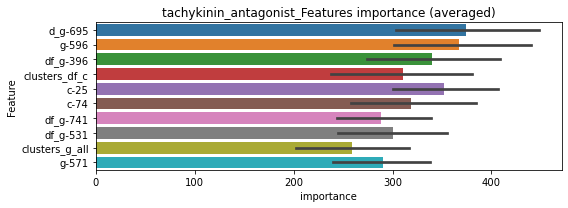

len(train_index) : 3822
len(valid_index) : 3822
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419782	valid_1's binary_logloss: 0.0689565
[200]	training's binary_logloss: 0.0128658	valid_1's binary_logloss: 0.0381344
[300]	training's binary_logloss: 0.00525214	valid_1's binary_logloss: 0.0288571
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00326496	valid_1's binary_logloss: 0.0260259


len(train_index) : 3822
len(valid_index) : 3822
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436491	valid_1's binary_logloss: 0.072299
[200]	training's binary_logloss: 0.0133022	valid_1's binary_logloss: 0.0384434
[300]	training's binary_logloss: 0.00540421	valid_1's binary_logloss: 0.0290759
[400]	training's binary_logloss: 0.00279772	valid_1's binary_logloss: 0.0250854
[500]	training's binary_logloss: 0.0017758	valid_1's binary_logloss: 0.0236983
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00147327	valid_1's binary_logloss: 0.0232478


tachykinin_antagonist logloss: 0.024636862520124925
tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182497	valid_1's binary_logloss: 0.0230721
[200]	training's binary_logloss: 0.00171878	valid_1's binary_logloss: 0.00552797
[300]	training's binary_logloss: 0.000458453	valid_1's binary_logloss: 0.00445882
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000346552	valid_1's binary_logloss: 0.00437608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184335	valid_1's binary_logloss: 0.0223683
[200]	training's binary_logloss: 0.00171465	valid_1's binary_logloss: 0.00439693
[300]	training's binary_logloss: 0.000467739	valid_1's binary_logloss: 0.00271895


1 / 3 AUC score:1.000
y_Threshold: 0.0008618, Threshold: 0.0015920, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000277382	valid_1's binary_logloss: 0.00250279


Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00143, conf_1:0.00175
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0015920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.0115920
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0215920
threshold: 0.0215920, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172561	valid_1's binary_logloss: 0.0200765
[200]	training's binary_logloss: 0.0014272	valid_1's binary_logloss: 0.00240575
[300]	training's binary_logloss: 0.000346519	valid_1's binary_logloss: 0.000746556
[400]	training's binary_logloss: 0.000206131	valid_1's binary_logloss: 0.000481606
[500]	training's binary_logloss: 0.000183939	valid_1's binary_logloss: 0.000441637
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000182128	valid_1's binary_logloss: 0.000438809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171991	valid_1's binary_logloss: 0.0197148
[200]	training's binary_logloss: 0.00141543	valid_1's binary_logloss: 0.00370866
[300]	training's binary_logloss: 0.000346676	valid_1's binary_logloss: 0.00186606


2 / 3 AUC score:1.000
y_Threshold: 0.0879005, Threshold: 0.0215920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0123054 Vs.target_rate: 0.00126, Num_p_label: 49.0, conf_0:0.01943, conf_1:0.02375
Num_p_label: 49.0, Expected: 5.0, Adj_threshold_1: 0.0215920


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000214279	valid_1's binary_logloss: 0.00157951


Num_p_label: 41.0, Expected: 5.0, Adj_threshold_2: 0.0315920
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_3: 0.0415920
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_4: 0.0515920
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_5: 0.0615920
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_6: 0.0715920
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.0815920
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_8: 0.0915920
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_9: 0.1015920
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_10: 0.1115920
threshold: 0.1215920, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172561	valid_1's binary_logloss: 0.0200765
[200]	training's binary_logloss: 0.0014272	valid_1's binary_logloss: 0.00240575
[300]	training's binary_logloss: 0.000346519	valid_1's binary_logloss: 0.000746556
[400]	training's binary_logloss: 0.000206131	valid_1's binary_logloss: 0.000481606
[500]	training's binary_logloss: 0.000183939	valid_1's binary_logloss: 0.000441637
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000182128	valid_1's binary_logloss: 0.000438809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171991	valid_1's binary_logloss: 0.0197148
[200]	training's binary_logloss: 0.00141543	valid_1's binary_logloss: 0.00370866
[300]	training's binary_logloss: 0.000346676	valid_1's binary_logloss: 0.00186606


3 / 3 AUC score:1.000
y_Threshold: 0.0879005, Threshold: 0.1215920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0050226 Vs.target_rate: 0.00126, Num_p_label: 20.0, conf_0:0.10943, conf_1:0.13375
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.1215920
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.1315920


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000214279	valid_1's binary_logloss: 0.00157951


Num_p_label: 18.0, Expected: 5.0, Adj_threshold_3: 0.1415920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.1515920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.1615920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_6: 0.1715920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.1815920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_8: 0.1915920
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_9: 0.2015920
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_10: 0.2115920
threshold: 0.2215920, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 669.0/7790, y_label_rate: 0.0858793


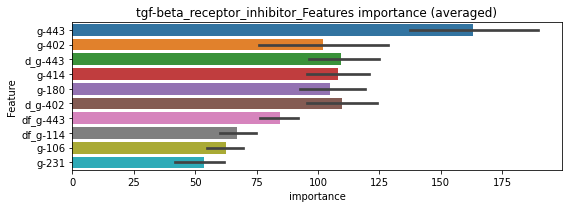

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00965214	valid_1's binary_logloss: 0.0137719
[200]	training's binary_logloss: 0.000869589	valid_1's binary_logloss: 0.00390726
[300]	training's binary_logloss: 0.000216805	valid_1's binary_logloss: 0.00306367
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000205978	valid_1's binary_logloss: 0.00304286


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00967981	valid_1's binary_logloss: 0.0125347
[200]	training's binary_logloss: 0.00087889	valid_1's binary_logloss: 0.00342793
[300]	training's binary_logloss: 0.000213751	valid_1's binary_logloss: 0.00265672
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000192611	valid_1's binary_logloss: 0.00262021


tgf-beta_receptor_inhibitor logloss: 0.002831536067444257
thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249697	valid_1's binary_logloss: 0.0384183
[200]	training's binary_logloss: 0.00345186	valid_1's binary_logloss: 0.0122039
[300]	training's binary_logloss: 0.000931129	valid_1's binary_logloss: 0.00566112
[400]	training's binary_logloss: 0.000445907	valid_1's binary_logloss: 0.00398411
[500]	training's binary_logloss: 0.000329435	valid_1's binary_logloss: 0.00346414
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000329435	valid_1's binary_logloss: 0.00346414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249071	valid_1's binary_logloss: 0.0298495
[200]	training's binary_logloss: 0.00309113	valid_1's binary_logloss: 0.00492112
[300]	training's binary_logloss: 0.000880478	valid_1's binary_logloss: 0.0017341
[400]	training's binary_logloss: 0.000461364	valid_1's binary_logloss: 0.000995802
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0021429, Threshold: 0.0042395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080, Num_p_label: 80.0, conf_0:0.00382, conf_1:0.00466
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0042395
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_2: 0.0142395
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.0242395
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.0342395
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_5: 0.0442395
threshold: 0.0442395, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231972	valid_1's binary_logloss: 0.0321384
[200]	training's binary_logloss: 0.00278325	valid_1's binary_logloss: 0.00695264
[300]	training's binary_logloss: 0.000810811	valid_1's binary_logloss: 0.00290265
[400]	training's binary_logloss: 0.000436396	valid_1's binary_logloss: 0.0018906
[500]	training's binary_logloss: 0.000347549	valid_1's binary_logloss: 0.00163858
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000341381	valid_1's binary_logloss: 0.00161544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241457	valid_1's binary_logloss: 0.0277576
[200]	training's binary_logloss: 0.00289453	valid_1's binary_logloss: 0.00415249
[300]	training's binary_logloss: 0.000827593	valid_1's binary_logloss: 0.00137958
[400]	training's binary_logloss: 0.00044544	valid_1's binary_logloss: 0.000789069
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1234179, Threshold: 0.0442395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00080, Num_p_label: 21.0, conf_0:0.03982, conf_1:0.04866
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_1: 0.0442395
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.0542395
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0642395
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.0742395
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.0842395
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.0942395
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.1042395
threshold: 0.1042395, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231972	valid_1's binary_logloss: 0.0321384
[200]	training's binary_logloss: 0.00278325	valid_1's binary_logloss: 0.00695264
[300]	training's binary_logloss: 0.000810811	valid_1's binary_logloss: 0.00290265
[400]	training's binary_logloss: 0.000436396	valid_1's binary_logloss: 0.0018906
[500]	training's binary_logloss: 0.000347549	valid_1's binary_logloss: 0.00163858
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000341381	valid_1's binary_logloss: 0.00161544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241457	valid_1's binary_logloss: 0.0277576
[200]	training's binary_logloss: 0.00289453	valid_1's binary_logloss: 0.00415249
[300]	training's binary_logloss: 0.000827593	valid_1's binary_logloss: 0.00137958
[400]	training's binary_logloss: 0.00044544	valid_1's binary_logloss: 0.000789069
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1234179, Threshold: 0.1042395, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.09382, conf_1:0.11466
threshold: 0.1042395, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


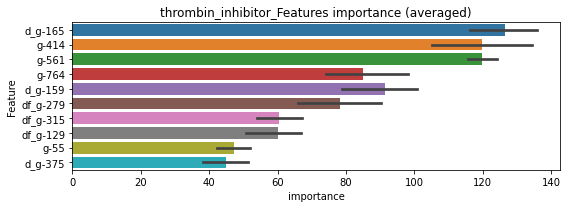

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138053	valid_1's binary_logloss: 0.0207204
[200]	training's binary_logloss: 0.00164635	valid_1's binary_logloss: 0.00784107
[300]	training's binary_logloss: 0.000446736	valid_1's binary_logloss: 0.00634816
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00039839	valid_1's binary_logloss: 0.00629548


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139051	valid_1's binary_logloss: 0.0198916
[200]	training's binary_logloss: 0.00171326	valid_1's binary_logloss: 0.00558329
[300]	training's binary_logloss: 0.000468922	valid_1's binary_logloss: 0.0034514
[400]	training's binary_logloss: 0.000243586	valid_1's binary_logloss: 0.0030292
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000197289	valid_1's binary_logloss: 0.0029046


thrombin_inhibitor logloss: 0.004600256490689754
thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343105	valid_1's binary_logloss: 0.0553674
[200]	training's binary_logloss: 0.00494648	valid_1's binary_logloss: 0.0181612
[300]	training's binary_logloss: 0.00139529	valid_1's binary_logloss: 0.0109073
[400]	training's binary_logloss: 0.000695258	valid_1's binary_logloss: 0.00924046
[500]	training's binary_logloss: 0.000481934	valid_1's binary_logloss: 0.00834954
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000462788	valid_1's binary_logloss: 0.0082531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351206	valid_1's binary_logloss: 0.0509268
[200]	training's binary_logloss: 0.00530434	valid_1's binary_logloss: 0.0120622
[300]	training's binary_logloss: 0.00151371	valid_1's binary_logloss: 0.00544061
[400]	training's binary_logloss: 0.000736593	valid_1's binary_logloss: 0.00343109
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0030381, Threshold: 0.0045940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00413, conf_1:0.00505
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0045940
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.0145940
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.0245940
threshold: 0.0245940, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331465	valid_1's binary_logloss: 0.0549527
[200]	training's binary_logloss: 0.00473387	valid_1's binary_logloss: 0.0172927
[300]	training's binary_logloss: 0.00133361	valid_1's binary_logloss: 0.0107394
[400]	training's binary_logloss: 0.000672162	valid_1's binary_logloss: 0.00899324
[500]	training's binary_logloss: 0.000465329	valid_1's binary_logloss: 0.00832869
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000459441	valid_1's binary_logloss: 0.00825653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341185	valid_1's binary_logloss: 0.049906
[200]	training's binary_logloss: 0.00497529	valid_1's binary_logloss: 0.0111366
[300]	training's binary_logloss: 0.0014279	valid_1's binary_logloss: 0.004848
[400]	training's binary_logloss: 0.000709571	valid_1's binary_logloss: 0.00321624
[500]	training's binary_logloss: 0.00049

2 / 3 AUC score:1.000
y_Threshold: 0.0207650, Threshold: 0.0245940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0050226 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.02213, conf_1:0.02705
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.0245940
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0345940
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.0445940
threshold: 0.0445940, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319862	valid_1's binary_logloss: 0.0526847
[200]	training's binary_logloss: 0.00463923	valid_1's binary_logloss: 0.0168031
[300]	training's binary_logloss: 0.00132605	valid_1's binary_logloss: 0.0101122
[400]	training's binary_logloss: 0.00065936	valid_1's binary_logloss: 0.00864309
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000479299	valid_1's binary_logloss: 0.00765556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343719	valid_1's binary_logloss: 0.0580306
[200]	training's binary_logloss: 0.0050058	valid_1's binary_logloss: 0.021784
[300]	training's binary_logloss: 0.00140008	valid_1's binary_logloss: 0.016752
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000901376	valid_1's binary_logloss: 0.0157308


3 / 3 AUC score:0.999
y_Threshold: 0.0196065, Threshold: 0.0445940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0035158 Vs.target_rate: 0.00155, Num_p_label: 14.0, conf_0:0.04013, conf_1:0.04905
threshold: 0.0445940, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 668.0/7786, y_label_rate: 0.0857950


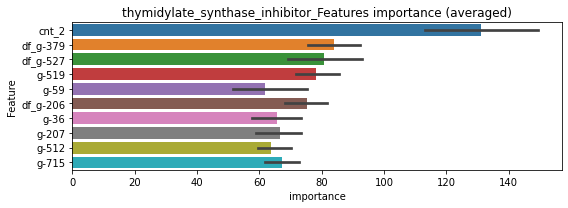

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181602	valid_1's binary_logloss: 0.0320058
[200]	training's binary_logloss: 0.00263208	valid_1's binary_logloss: 0.0132139
[300]	training's binary_logloss: 0.000727583	valid_1's binary_logloss: 0.0101708
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000579687	valid_1's binary_logloss: 0.00989818


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179508	valid_1's binary_logloss: 0.0295081
[200]	training's binary_logloss: 0.00255424	valid_1's binary_logloss: 0.00943653
[300]	training's binary_logloss: 0.000726198	valid_1's binary_logloss: 0.0061955
[400]	training's binary_logloss: 0.000364323	valid_1's binary_logloss: 0.00519231
[500]	training's binary_logloss: 0.000248855	valid_1's binary_logloss: 0.00486173
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000246236	valid_1's binary_logloss: 0.00484986


thymidylate_synthase_inhibitor logloss: 0.00737401804424607
tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328941	valid_1's binary_logloss: 0.0520373
[200]	training's binary_logloss: 0.00480959	valid_1's binary_logloss: 0.0146846
[300]	training's binary_logloss: 0.0013305	valid_1's binary_logloss: 0.00802167
[400]	training's binary_logloss: 0.000663077	valid_1's binary_logloss: 0.00624328
[500]	training's binary_logloss: 0.000466745	valid_1's binary_logloss: 0.00545505
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000446221	valid_1's binary_logloss: 0.00537203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337126	valid_1's binary_logloss: 0.0497916
[200]	training's binary_logloss: 0.00504859	valid_1's binary_logloss: 0.0128821
[300]	training's binary_logloss: 0.00140369	valid_1's binary_logloss: 0.00604266
[400]	training's binary_logloss: 0.000691571	valid_1's binary_logloss: 0.00426466
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0027325, Threshold: 0.0040939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00368, conf_1:0.00450
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0040939
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_2: 0.0140939
threshold: 0.0140939, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326966	valid_1's binary_logloss: 0.0533095
[200]	training's binary_logloss: 0.0045386	valid_1's binary_logloss: 0.0157049
[300]	training's binary_logloss: 0.00128903	valid_1's binary_logloss: 0.00900714
[400]	training's binary_logloss: 0.000654766	valid_1's binary_logloss: 0.00681934
[500]	training's binary_logloss: 0.000462904	valid_1's binary_logloss: 0.00603608
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000446389	valid_1's binary_logloss: 0.00597869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330619	valid_1's binary_logloss: 0.0473011
[200]	training's binary_logloss: 0.0048952	valid_1's binary_logloss: 0.0118176
[300]	training's binary_logloss: 0.00138125	valid_1's binary_logloss: 0.00538946
[400]	training's binary_logloss: 0.000685518	valid_1's binary_logloss: 0.0037348
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0324905, Threshold: 0.0140939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0075339 Vs.target_rate: 0.00126, Num_p_label: 30.0, conf_0:0.01268, conf_1:0.01550
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_1: 0.0140939
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.0240939
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_3: 0.0340939
threshold: 0.0340939, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326966	valid_1's binary_logloss: 0.0533095
[200]	training's binary_logloss: 0.0045386	valid_1's binary_logloss: 0.0157049
[300]	training's binary_logloss: 0.00128903	valid_1's binary_logloss: 0.00900714
[400]	training's binary_logloss: 0.000654766	valid_1's binary_logloss: 0.00681934
[500]	training's binary_logloss: 0.000462904	valid_1's binary_logloss: 0.00603608
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000446389	valid_1's binary_logloss: 0.00597869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330619	valid_1's binary_logloss: 0.0473011
[200]	training's binary_logloss: 0.0048952	valid_1's binary_logloss: 0.0118176
[300]	training's binary_logloss: 0.00138125	valid_1's binary_logloss: 0.00538946
[400]	training's binary_logloss: 0.000685518	valid_1's binary_logloss: 0.0037348
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0324905, Threshold: 0.0340939, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0007534 Vs.target_rate: 0.00126, Num_p_label: 3.0, conf_0:0.03068, conf_1:0.03750
threshold: 0.0340939, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 659.0/7790, y_label_rate: 0.0845956


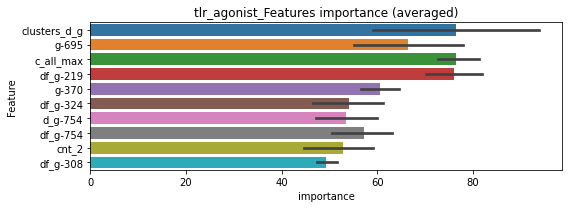

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185658	valid_1's binary_logloss: 0.0297353
[200]	training's binary_logloss: 0.00272874	valid_1's binary_logloss: 0.00930392
[300]	training's binary_logloss: 0.000734202	valid_1's binary_logloss: 0.00581565
[400]	training's binary_logloss: 0.000349757	valid_1's binary_logloss: 0.00503186
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00024557	valid_1's binary_logloss: 0.00476724


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017895	valid_1's binary_logloss: 0.0288576
[200]	training's binary_logloss: 0.00258679	valid_1's binary_logloss: 0.00934726
[300]	training's binary_logloss: 0.000684252	valid_1's binary_logloss: 0.00605748
[400]	training's binary_logloss: 0.000336132	valid_1's binary_logloss: 0.00518896
[500]	training's binary_logloss: 0.000235096	valid_1's binary_logloss: 0.00474408
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000230497	valid_1's binary_logloss: 0.00473956


tlr_agonist logloss: 0.0047534021431019195


neg labels: 3289 → selected neg labels: 3287


tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160838	valid_1's binary_logloss: 0.0176919
[200]	training's binary_logloss: 0.00141585	valid_1's binary_logloss: 0.00197959
[300]	training's binary_logloss: 0.000395799	valid_1's binary_logloss: 0.000659432
[400]	training's binary_logloss: 0.000237859	valid_1's binary_logloss: 0.000424861
[500]	training's binary_logloss: 0.000214154	valid_1's binary_logloss: 0.000388082
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00021091	valid_1's binary_logloss: 0.000383177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164229	valid_1's binary_logloss: 0.0172847
[200]	training's binary_logloss: 0.00142408	valid_1's binary_logloss: 0.00167038
[300]	training's binary_logloss: 0.000398392	valid_1's binary_logloss: 0.00051064
[400]	training's binary_logloss: 0.00024286	valid_1's binary_logloss: 0.000311205
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0007455, Threshold: 0.0013514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029, Num_p_label: 80.0, conf_0:0.00122, conf_1:0.00149
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0013514
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0113514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.0213514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.0313514
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_5: 0.0413514
threshold: 0.0413514, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016371	valid_1's binary_logloss: 0.0170923
[200]	training's binary_logloss: 0.00139503	valid_1's binary_logloss: 0.00159094
[300]	training's binary_logloss: 0.000388026	valid_1's binary_logloss: 0.000466112
[400]	training's binary_logloss: 0.000236628	valid_1's binary_logloss: 0.000292431
[500]	training's binary_logloss: 0.000209241	valid_1's binary_logloss: 0.000260633
[600]	training's binary_logloss: 0.000206026	valid_1's binary_logloss: 0.00025705
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000205885	valid_1's binary_logloss: 0.000256895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165714	valid_1's binary_logloss: 0.0175584
[200]	training's binary_logloss: 0.00139143	valid_1's binary_logloss: 0.00162034
[300]	training's binary_logloss: 0.000380368	valid_1's binary_logloss: 0.000477722
[400]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1713673, Threshold: 0.0413514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00029, Num_p_label: 8.0, conf_0:0.03722, conf_1:0.04549
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_1: 0.0413514
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0513514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0613514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0713514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0813514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.0913514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_7: 0.1013514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_8: 0.1113514
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_9: 0.1213514
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_10: 0.1313514
threshold: 0.1413514, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Ps

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016371	valid_1's binary_logloss: 0.0170923
[200]	training's binary_logloss: 0.00139503	valid_1's binary_logloss: 0.00159094
[300]	training's binary_logloss: 0.000388026	valid_1's binary_logloss: 0.000466112
[400]	training's binary_logloss: 0.000236628	valid_1's binary_logloss: 0.000292431
[500]	training's binary_logloss: 0.000209241	valid_1's binary_logloss: 0.000260633
[600]	training's binary_logloss: 0.000206026	valid_1's binary_logloss: 0.00025705
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.000205885	valid_1's binary_logloss: 0.000256895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165714	valid_1's binary_logloss: 0.0175584
[200]	training's binary_logloss: 0.00139143	valid_1's binary_logloss: 0.00162034
[300]	training's binary_logloss: 0.000380368	valid_1's binary_logloss: 0.000477722
[400]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1713673, Threshold: 0.1413514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00029, Num_p_label: 4.0, conf_0:0.12722, conf_1:0.15549
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_1: 0.1413514
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_2: 0.1513514
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.1613514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.1713514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.1813514
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.1913514
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.2013514
threshold: 0.2013514, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


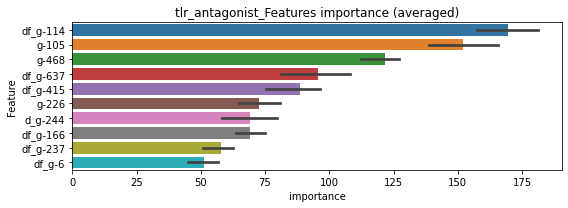

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00874153	valid_1's binary_logloss: 0.0100458
[200]	training's binary_logloss: 0.000754066	valid_1's binary_logloss: 0.00180714
[300]	training's binary_logloss: 0.000210923	valid_1's binary_logloss: 0.00132768
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000203604	valid_1's binary_logloss: 0.00132033


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00875307	valid_1's binary_logloss: 0.0123541
[200]	training's binary_logloss: 0.000737545	valid_1's binary_logloss: 0.00371236
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000338777	valid_1's binary_logloss: 0.00287235


tlr_antagonist logloss: 0.0020963395783241997
tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663


neg labels: 3289 → selected neg labels: 3283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345879	valid_1's binary_logloss: 0.0585784
[200]	training's binary_logloss: 0.00567948	valid_1's binary_logloss: 0.0222439
[300]	training's binary_logloss: 0.00156338	valid_1's binary_logloss: 0.0133595
[400]	training's binary_logloss: 0.000734669	valid_1's binary_logloss: 0.0109456
[500]	training's binary_logloss: 0.000492249	valid_1's binary_logloss: 0.00987774
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000453299	valid_1's binary_logloss: 0.00970776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378056	valid_1's binary_logloss: 0.0521274
[200]	training's binary_logloss: 0.00591183	valid_1's binary_logloss: 0.0136782
[300]	training's binary_logloss: 0.00168096	valid_1's binary_logloss: 0.00671096
[400]	training's binary_logloss: 0.000818379	valid_1's binary_logloss: 0.00497727
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0034067, Threshold: 0.0066692, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00600, conf_1:0.00734
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0066692
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0166692
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0266692
threshold: 0.0266692, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339442	valid_1's binary_logloss: 0.0584554
[200]	training's binary_logloss: 0.00515171	valid_1's binary_logloss: 0.0223759
[300]	training's binary_logloss: 0.00148846	valid_1's binary_logloss: 0.0146573
[400]	training's binary_logloss: 0.000739603	valid_1's binary_logloss: 0.012076
[500]	training's binary_logloss: 0.000501355	valid_1's binary_logloss: 0.0108349
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000479716	valid_1's binary_logloss: 0.0107524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03604	valid_1's binary_logloss: 0.0495222
[200]	training's binary_logloss: 0.00551344	valid_1's binary_logloss: 0.0124308
[300]	training's binary_logloss: 0.00160781	valid_1's binary_logloss: 0.00614439
[400]	training's binary_logloss: 0.000791006	valid_1's binary_logloss: 0.0043481
[500]	training's binary_logloss: 0.00052657

2 / 3 AUC score:1.000
y_Threshold: 0.0492390, Threshold: 0.0266692, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0087896 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.02400, conf_1:0.02934
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.0266692
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.0366692
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0466692
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.0566692
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_5: 0.0666692
threshold: 0.0666692, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339442	valid_1's binary_logloss: 0.0584554
[200]	training's binary_logloss: 0.00515171	valid_1's binary_logloss: 0.0223759
[300]	training's binary_logloss: 0.00148846	valid_1's binary_logloss: 0.0146573
[400]	training's binary_logloss: 0.000739603	valid_1's binary_logloss: 0.012076
[500]	training's binary_logloss: 0.000501355	valid_1's binary_logloss: 0.0108349
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000479716	valid_1's binary_logloss: 0.0107524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03604	valid_1's binary_logloss: 0.0495222
[200]	training's binary_logloss: 0.00551344	valid_1's binary_logloss: 0.0124308
[300]	training's binary_logloss: 0.00160781	valid_1's binary_logloss: 0.00614439
[400]	training's binary_logloss: 0.000791006	valid_1's binary_logloss: 0.0043481
[500]	training's binary_logloss: 0.00052657

3 / 3 AUC score:1.000
y_Threshold: 0.0492390, Threshold: 0.0666692, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0012557 Vs.target_rate: 0.00151, Num_p_label: 5.0, conf_0:0.06000, conf_1:0.07334
threshold: 0.0666692, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7789, y_label_rate: 0.0848633


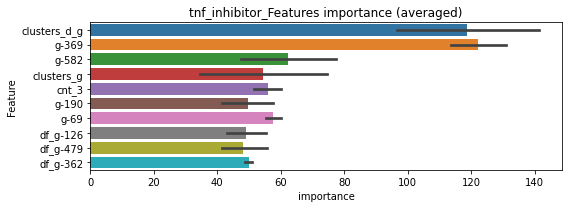

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197502	valid_1's binary_logloss: 0.0342085
[200]	training's binary_logloss: 0.00310533	valid_1's binary_logloss: 0.0129244
[300]	training's binary_logloss: 0.000848807	valid_1's binary_logloss: 0.00910755
[400]	training's binary_logloss: 0.000398953	valid_1's binary_logloss: 0.00821189
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000392644	valid_1's binary_logloss: 0.00819824


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202009	valid_1's binary_logloss: 0.0319078
[200]	training's binary_logloss: 0.00322529	valid_1's binary_logloss: 0.0107812
[300]	training's binary_logloss: 0.000881391	valid_1's binary_logloss: 0.00653258
[400]	training's binary_logloss: 0.000418298	valid_1's binary_logloss: 0.00542346
[500]	training's binary_logloss: 0.000271426	valid_1's binary_logloss: 0.00490872
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000253946	valid_1's binary_logloss: 0.00480257


tnf_inhibitor logloss: 0.006500625656808052
topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574


neg labels: 3289 → selected neg labels: 3271


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040137	valid_1's binary_logloss: 0.0902043
[200]	training's binary_logloss: 0.00722617	valid_1's binary_logloss: 0.0578845
[300]	training's binary_logloss: 0.00216428	valid_1's binary_logloss: 0.0505574
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00128846	valid_1's binary_logloss: 0.0483434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373341	valid_1's binary_logloss: 0.091673


1 / 3 AUC score:0.994
y_Threshold: 0.0218259, Threshold: 0.6032234, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00833823	valid_1's binary_logloss: 0.0758906


Remove_noisy_labels: 159 → Positive_corect_labels: 640/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.00533, Num_p_label: 80.0, conf_0:0.54290, conf_1:0.66355
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.6032234
Num_p_label: 77.0, Expected: 21.2, Adj_threshold_2: 0.6132234
Num_p_label: 74.0, Expected: 21.2, Adj_threshold_3: 0.6232234
Num_p_label: 72.0, Expected: 21.2, Adj_threshold_4: 0.6332234
Num_p_label: 69.0, Expected: 21.2, Adj_threshold_5: 0.6432234
Num_p_label: 67.0, Expected: 21.2, Adj_threshold_6: 0.6532234
Num_p_label: 62.0, Expected: 21.2, Adj_threshold_7: 0.6632234
Num_p_label: 59.0, Expected: 21.2, Adj_threshold_8: 0.6732234
Num_p_label: 59.0, Expected: 21.2, Adj_threshold_9: 0.6832234
Num_p_label: 57.0, Expected: 21.2, Adj_threshold_10: 0.6932234
threshold: 0.7032234, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 640.0/3766, y_label_rate: 0.1699416
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310287	valid_1's binary_logloss: 0.0711743
[200]	training's binary_logloss: 0.00427615	valid_1's binary_logloss: 0.0467738
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00192949	valid_1's binary_logloss: 0.0443384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030894	valid_1's binary_logloss: 0.0548061
[200]	training's binary_logloss: 0.00467576	valid_1's binary_logloss: 0.0246179
[300]	training's binary_logloss: 0.0014103	valid_1's binary_logloss: 0.0197957
[400]	training's binary_logloss: 0.000703205	valid_1's binary_logloss: 0.0184582
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000627803	valid_1's binary_logloss: 0.0182521


2 / 3 AUC score:0.998
y_Threshold: 0.0703992, Threshold: 0.7032234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 624.0/3734
p_label_rate: 0.0354093 Vs.target_rate: 0.00533, Num_p_label: 141.0, conf_0:0.63290, conf_1:0.77355
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_1: 0.7032234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_2: 0.7132234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_3: 0.7232234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_4: 0.7332234
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_5: 0.7432234
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_6: 0.7532234
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_7: 0.7632234
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_8: 0.7732234
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_9: 0.7832234
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_10: 0.7932234
threshold: 0.8032234, positive_p_label: 136.0/3982, p_label_rate: 0.0341537
positive_y_label: 624.0/3734, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274386	valid_1's binary_logloss: 0.0671451
[200]	training's binary_logloss: 0.00376944	valid_1's binary_logloss: 0.0396252
[300]	training's binary_logloss: 0.00108336	valid_1's binary_logloss: 0.0337703
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000916583	valid_1's binary_logloss: 0.0331261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280643	valid_1's binary_logloss: 0.0516887
[200]	training's binary_logloss: 0.00368761	valid_1's binary_logloss: 0.0274369
[300]	training's binary_logloss: 0.00107439	valid_1's binary_logloss: 0.0244899


3 / 3 AUC score:0.998
y_Threshold: 0.0851059, Threshold: 0.8032234, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000912323	valid_1's binary_logloss: 0.024297


Remove_noisy_labels: 28 → Positive_corect_labels: 610.0/3706
p_label_rate: 0.0389252 Vs.target_rate: 0.00533, Num_p_label: 155.0, conf_0:0.72290, conf_1:0.88355
Num_p_label: 155.0, Expected: 21.2, Adj_threshold_1: 0.8032234
Num_p_label: 150.0, Expected: 21.2, Adj_threshold_2: 0.8132234
Num_p_label: 150.0, Expected: 21.2, Adj_threshold_3: 0.8232234
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_4: 0.8332234
Num_p_label: 147.0, Expected: 21.2, Adj_threshold_5: 0.8432234
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_6: 0.8532234
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_7: 0.8632234
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_8: 0.8732234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_9: 0.8832234
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_10: 0.8932234
threshold: 0.9032234, positive_p_label: 138.0/3982, p_label_rate: 0.0346560
positive_y_label: 748.0/7688, y_label_rate: 0.0972945


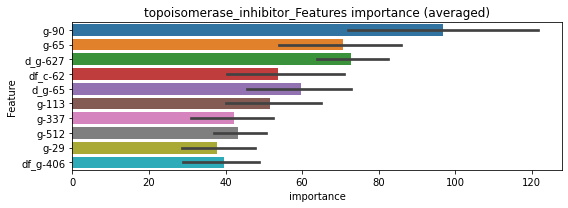

len(train_index) : 3844
len(valid_index) : 3844
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164426	valid_1's binary_logloss: 0.0370549
[200]	training's binary_logloss: 0.00221771	valid_1's binary_logloss: 0.0200108
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000752307	valid_1's binary_logloss: 0.0166257


len(train_index) : 3844
len(valid_index) : 3844
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176259	valid_1's binary_logloss: 0.0334257
[200]	training's binary_logloss: 0.00263483	valid_1's binary_logloss: 0.0176845
[300]	training's binary_logloss: 0.000701859	valid_1's binary_logloss: 0.0150345
[400]	training's binary_logloss: 0.000325515	valid_1's binary_logloss: 0.0135925
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000258867	valid_1's binary_logloss: 0.0133142


topoisomerase_inhibitor logloss: 0.014969948623145917
transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799


neg labels: 3289 → selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257649	valid_1's binary_logloss: 0.0333094
[200]	training's binary_logloss: 0.00311919	valid_1's binary_logloss: 0.00618434
[300]	training's binary_logloss: 0.000866132	valid_1's binary_logloss: 0.00262656
[400]	training's binary_logloss: 0.000450918	valid_1's binary_logloss: 0.0018865
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000368548	valid_1's binary_logloss: 0.00173419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02557	valid_1's binary_logloss: 0.0327223
[200]	training's binary_logloss: 0.0031241	valid_1's binary_logloss: 0.00514645
[300]	training's binary_logloss: 0.000867155	valid_1's binary_logloss: 0.00175386
[400]	training's binary_logloss: 0.000451958	valid_1's binary_logloss: 0.00102603
[500]	training's binary_logloss: 0.000350415	valid_1's binary_logloss: 0.000826192
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0016410, Threshold: 0.0021153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00190, conf_1:0.00233
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021153
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0121153
threshold: 0.0121153, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250295	valid_1's binary_logloss: 0.0322155
[200]	training's binary_logloss: 0.0029001	valid_1's binary_logloss: 0.00583107
[300]	training's binary_logloss: 0.000822554	valid_1's binary_logloss: 0.00240037
[400]	training's binary_logloss: 0.000437986	valid_1's binary_logloss: 0.00165818
[500]	training's binary_logloss: 0.000357708	valid_1's binary_logloss: 0.00148954
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000359358	valid_1's binary_logloss: 0.001488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259048	valid_1's binary_logloss: 0.0328542
[200]	training's binary_logloss: 0.00310446	valid_1's binary_logloss: 0.00522996
[300]	training's binary_logloss: 0.000858159	valid_1's binary_logloss: 0.0018183
[400]	training's binary_logloss: 0.000451047	valid_1's binary_logloss: 0.00107783
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0796290, Threshold: 0.0121153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0050226 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.01090, conf_1:0.01333
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.0121153
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0221153
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0321153
threshold: 0.0321153, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250295	valid_1's binary_logloss: 0.0322155
[200]	training's binary_logloss: 0.0029001	valid_1's binary_logloss: 0.00583107
[300]	training's binary_logloss: 0.000822554	valid_1's binary_logloss: 0.00240037
[400]	training's binary_logloss: 0.000437986	valid_1's binary_logloss: 0.00165818
[500]	training's binary_logloss: 0.000357708	valid_1's binary_logloss: 0.00148954
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000359358	valid_1's binary_logloss: 0.001488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259048	valid_1's binary_logloss: 0.0328542
[200]	training's binary_logloss: 0.00310446	valid_1's binary_logloss: 0.00522996
[300]	training's binary_logloss: 0.000858159	valid_1's binary_logloss: 0.0018183
[400]	training's binary_logloss: 0.000451047	valid_1's binary_logloss: 0.00107783
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0796290, Threshold: 0.0321153, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.02890, conf_1:0.03533
threshold: 0.0321153, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


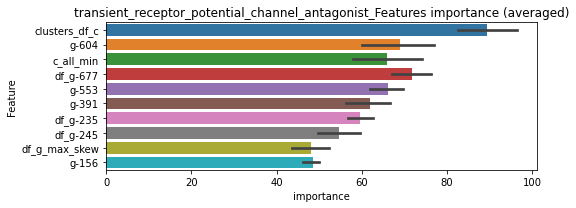

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136153	valid_1's binary_logloss: 0.0203521
[200]	training's binary_logloss: 0.00160976	valid_1's binary_logloss: 0.00656448
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000484517	valid_1's binary_logloss: 0.00533673


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143039	valid_1's binary_logloss: 0.0205257
[200]	training's binary_logloss: 0.00172886	valid_1's binary_logloss: 0.0059314
[300]	training's binary_logloss: 0.000460776	valid_1's binary_logloss: 0.00380116
[400]	training's binary_logloss: 0.000231892	valid_1's binary_logloss: 0.0033442
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000187431	valid_1's binary_logloss: 0.00323136


transient_receptor_potential_channel_antagonist logloss: 0.004284176790918115
tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851


neg labels: 3289 → selected neg labels: 3288


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162373	valid_1's binary_logloss: 0.0176477
[200]	training's binary_logloss: 0.00136509	valid_1's binary_logloss: 0.00223438
[300]	training's binary_logloss: 0.000364511	valid_1's binary_logloss: 0.00100567
[400]	training's binary_logloss: 0.000220154	valid_1's binary_logloss: 0.000764973
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000202008	valid_1's binary_logloss: 0.000740684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164042	valid_1's binary_logloss: 0.0177492
[200]	training's binary_logloss: 0.00136636	valid_1's binary_logloss: 0.00186167
[300]	training's binary_logloss: 0.000361764	valid_1's binary_logloss: 0.000622061
[400]	training's binary_logloss: 0.000220402	valid_1's binary_logloss: 0.000421652
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000198165	valid_1's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0005432, Threshold: 0.0010562, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025, Num_p_label: 80.0, conf_0:0.00095, conf_1:0.00116
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0110562
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.0210562
threshold: 0.0210562, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164337	valid_1's binary_logloss: 0.0179155
[200]	training's binary_logloss: 0.0013477	valid_1's binary_logloss: 0.00222934
[300]	training's binary_logloss: 0.000355151	valid_1's binary_logloss: 0.000849071
[400]	training's binary_logloss: 0.000216738	valid_1's binary_logloss: 0.000638427
[500]	training's binary_logloss: 0.000193973	valid_1's binary_logloss: 0.00059876
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000193974	valid_1's binary_logloss: 0.000598756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166966	valid_1's binary_logloss: 0.0177249
[200]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00192983
[300]	training's binary_logloss: 0.000357175	valid_1's binary_logloss: 0.000672302
[400]	training's binary_logloss: 0.000219932	valid_1's binary_logloss: 0.000499757


2 / 3 AUC score:1.000
y_Threshold: 0.1034991, Threshold: 0.0210562, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000198006	valid_1's binary_logloss: 0.000464905


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.01895, conf_1:0.02316
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.0210562
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0310562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0410562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0510562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0610562
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0710562
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.0810562
threshold: 0.0810562, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164337	valid_1's binary_logloss: 0.0179155
[200]	training's binary_logloss: 0.0013477	valid_1's binary_logloss: 0.00222934
[300]	training's binary_logloss: 0.000355151	valid_1's binary_logloss: 0.000849071
[400]	training's binary_logloss: 0.000216738	valid_1's binary_logloss: 0.000638427
[500]	training's binary_logloss: 0.000193973	valid_1's binary_logloss: 0.00059876
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000193974	valid_1's binary_logloss: 0.000598756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166966	valid_1's binary_logloss: 0.0177249
[200]	training's binary_logloss: 0.00135027	valid_1's binary_logloss: 0.00192983
[300]	training's binary_logloss: 0.000357175	valid_1's binary_logloss: 0.000672302
[400]	training's binary_logloss: 0.000219932	valid_1's binary_logloss: 0.000499757


3 / 3 AUC score:1.000
y_Threshold: 0.1034991, Threshold: 0.0810562, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000198006	valid_1's binary_logloss: 0.000464905


Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.07295, conf_1:0.08916
threshold: 0.0810562, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


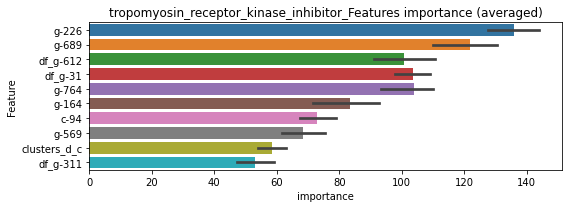

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00875361	valid_1's binary_logloss: 0.011793
[200]	training's binary_logloss: 0.000711672	valid_1's binary_logloss: 0.00316235
[300]	training's binary_logloss: 0.000183759	valid_1's binary_logloss: 0.00244222
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000188415	valid_1's binary_logloss: 0.00243808


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00887862	valid_1's binary_logloss: 0.0098383
[200]	training's binary_logloss: 0.000722275	valid_1's binary_logloss: 0.00133104
[300]	training's binary_logloss: 0.000188818	valid_1's binary_logloss: 0.000579765
[400]	training's binary_logloss: 0.000112519	valid_1's binary_logloss: 0.000450917
Early stopping, best iteration is:
[481]	training's binary_logloss: 9.91954e-05	valid_1's binary_logloss: 0.000430523


tropomyosin_receptor_kinase_inhibitor logloss: 0.0014344310693874208
trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251942	valid_1's binary_logloss: 0.0426512
[200]	training's binary_logloss: 0.0031304	valid_1's binary_logloss: 0.0122449
[300]	training's binary_logloss: 0.000901715	valid_1's binary_logloss: 0.00804678
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000559451	valid_1's binary_logloss: 0.00709265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256355	valid_1's binary_logloss: 0.0364287
[200]	training's binary_logloss: 0.00317146	valid_1's binary_logloss: 0.00688708
[300]	training's binary_logloss: 0.00092444	valid_1's binary_logloss: 0.00294934
[400]	training's binary_logloss: 0.000483513	valid_1's binary_logloss: 0.00198467
[500]	training's binary_logloss: 0.000367651	valid_1's binary_logloss: 0.00170908
[600]	training's binary_logloss: 0.000348671	valid_1's binary_logloss: 0.00165628
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0026274, Threshold: 0.0068457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105, Num_p_label: 80.0, conf_0:0.00616, conf_1:0.00753
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0068457
Num_p_label: 49.0, Expected: 4.2, Adj_threshold_2: 0.0168457
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_3: 0.0268457
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_4: 0.0368457
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_5: 0.0468457
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_6: 0.0568457
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.0668457
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_8: 0.0768457
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.0868457
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_10: 0.0968457
threshold: 0.1068457, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246663	valid_1's binary_logloss: 0.0407162
[200]	training's binary_logloss: 0.00294508	valid_1's binary_logloss: 0.0101111
[300]	training's binary_logloss: 0.000847086	valid_1's binary_logloss: 0.00604901
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000817336	valid_1's binary_logloss: 0.00601415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245506	valid_1's binary_logloss: 0.0330543
[200]	training's binary_logloss: 0.00297893	valid_1's binary_logloss: 0.00570189
[300]	training's binary_logloss: 0.000851794	valid_1's binary_logloss: 0.00220493
[400]	training's binary_logloss: 0.00044984	valid_1's binary_logloss: 0.00135851
[500]	training's binary_logloss: 0.000356536	valid_1's binary_logloss: 0.00116921
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000339811	valid_1's binary_logloss: 0.0011349

2 / 3 AUC score:1.000
y_Threshold: 0.0591104, Threshold: 0.1068457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0115520 Vs.target_rate: 0.00105, Num_p_label: 46.0, conf_0:0.09616, conf_1:0.11753
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_1: 0.1068457
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_2: 0.1168457
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_3: 0.1268457
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_4: 0.1368457
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_5: 0.1468457
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_6: 0.1568457
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_7: 0.1668457
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_8: 0.1768457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_9: 0.1868457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_10: 0.1968457
threshold: 0.2068457, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246663	valid_1's binary_logloss: 0.0407162
[200]	training's binary_logloss: 0.00294508	valid_1's binary_logloss: 0.0101111
[300]	training's binary_logloss: 0.000847086	valid_1's binary_logloss: 0.00604901
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000817336	valid_1's binary_logloss: 0.00601415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245506	valid_1's binary_logloss: 0.0330543
[200]	training's binary_logloss: 0.00297893	valid_1's binary_logloss: 0.00570189
[300]	training's binary_logloss: 0.000851794	valid_1's binary_logloss: 0.00220493
[400]	training's binary_logloss: 0.00044984	valid_1's binary_logloss: 0.00135851
[500]	training's binary_logloss: 0.000356536	valid_1's binary_logloss: 0.00116921
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000339811	valid_1's binary_logloss: 0.0011349

3 / 3 AUC score:1.000
y_Threshold: 0.0591104, Threshold: 0.2068457, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0085384 Vs.target_rate: 0.00105, Num_p_label: 34.0, conf_0:0.18616, conf_1:0.22753
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_1: 0.2068457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_2: 0.2168457
Num_p_label: 34.0, Expected: 4.2, Adj_threshold_3: 0.2268457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_4: 0.2368457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_5: 0.2468457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_6: 0.2568457
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_7: 0.2668457
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_8: 0.2768457
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_9: 0.2868457
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_10: 0.2968457
threshold: 0.3068457, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 688.0/7792, y_label_rate: 0.0882957


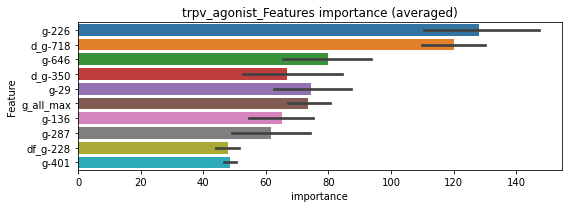

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136173	valid_1's binary_logloss: 0.0245865
[200]	training's binary_logloss: 0.00168324	valid_1's binary_logloss: 0.00947477
[300]	training's binary_logloss: 0.000485632	valid_1's binary_logloss: 0.00711844
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000357069	valid_1's binary_logloss: 0.00692141


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138515	valid_1's binary_logloss: 0.0277198
[200]	training's binary_logloss: 0.00173984	valid_1's binary_logloss: 0.0117538
[300]	training's binary_logloss: 0.000504915	valid_1's binary_logloss: 0.00914437
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000339742	valid_1's binary_logloss: 0.00863533


trpv_agonist logloss: 0.007778366371813217
trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422585	valid_1's binary_logloss: 0.0909355
[200]	training's binary_logloss: 0.00792308	valid_1's binary_logloss: 0.0528903
[300]	training's binary_logloss: 0.00230926	valid_1's binary_logloss: 0.0445994
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00144856	valid_1's binary_logloss: 0.0436283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469912	valid_1's binary_logloss: 0.0752041
[200]	training's binary_logloss: 0.00901708	valid_1's binary_logloss: 0.0255609
[300]	training's binary_logloss: 0.00259784	valid_1's binary_logloss: 0.013293
[400]	training's binary_logloss: 0.00120046	valid_1's binary_logloss: 0.00980591
[500]	training's binary_logloss: 0.000752604	valid_1's binary_logloss: 0.00855377
[600]	training's binary_logloss: 0.000579962	valid_1's binary_logloss: 0.0080063
Early stopping, best iteration is:
[600]	t

1 / 3 AUC score:0.999
y_Threshold: 0.0057272, Threshold: 0.0090788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00202, Num_p_label: 80.0, conf_0:0.00817, conf_1:0.00999
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0090788
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_2: 0.0190788
threshold: 0.0190788, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043842	valid_1's binary_logloss: 0.0759354
[200]	training's binary_logloss: 0.00788479	valid_1's binary_logloss: 0.0341999
[300]	training's binary_logloss: 0.00232703	valid_1's binary_logloss: 0.0261342
[400]	training's binary_logloss: 0.00109049	valid_1's binary_logloss: 0.0228547
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00112044	valid_1's binary_logloss: 0.0227764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448093	valid_1's binary_logloss: 0.0739399
[200]	training's binary_logloss: 0.00828451	valid_1's binary_logloss: 0.0280807
[300]	training's binary_logloss: 0.002401	valid_1's binary_logloss: 0.0182835
[400]	training's binary_logloss: 0.001133	valid_1's binary_logloss: 0.0152414
[500]	training's binary_logloss: 0.000717609	valid_1's binary_logloss: 0.0141002
Early stopping, best iteration is:
[556]	training

2 / 3 AUC score:1.000
y_Threshold: 0.0271878, Threshold: 0.0190788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0097941 Vs.target_rate: 0.00202, Num_p_label: 39.0, conf_0:0.01717, conf_1:0.02099
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_1: 0.0190788
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.0290788
threshold: 0.0290788, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043842	valid_1's binary_logloss: 0.0759354
[200]	training's binary_logloss: 0.00788479	valid_1's binary_logloss: 0.0341999
[300]	training's binary_logloss: 0.00232703	valid_1's binary_logloss: 0.0261342
[400]	training's binary_logloss: 0.00109049	valid_1's binary_logloss: 0.0228547
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00112044	valid_1's binary_logloss: 0.0227764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448093	valid_1's binary_logloss: 0.0739399
[200]	training's binary_logloss: 0.00828451	valid_1's binary_logloss: 0.0280807
[300]	training's binary_logloss: 0.002401	valid_1's binary_logloss: 0.0182835
[400]	training's binary_logloss: 0.001133	valid_1's binary_logloss: 0.0152414
[500]	training's binary_logloss: 0.000717609	valid_1's binary_logloss: 0.0141002
Early stopping, best iteration is:
[556]	training

3 / 3 AUC score:1.000
y_Threshold: 0.0271878, Threshold: 0.0290788, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0037670 Vs.target_rate: 0.00202, Num_p_label: 15.0, conf_0:0.02617, conf_1:0.03199
threshold: 0.0290788, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 668.0/7781, y_label_rate: 0.0858501


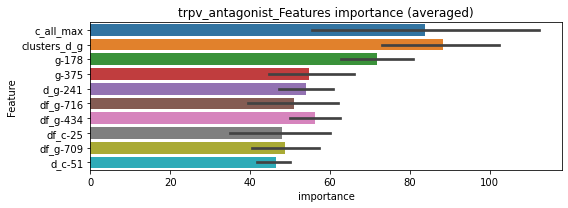

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255038	valid_1's binary_logloss: 0.0514126
[200]	training's binary_logloss: 0.00450453	valid_1's binary_logloss: 0.0291362
[300]	training's binary_logloss: 0.00129942	valid_1's binary_logloss: 0.0257021
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00144785	valid_1's binary_logloss: 0.0256977


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265478	valid_1's binary_logloss: 0.0487794
[200]	training's binary_logloss: 0.00534292	valid_1's binary_logloss: 0.0256955
[300]	training's binary_logloss: 0.0013779	valid_1's binary_logloss: 0.0208534
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000711979	valid_1's binary_logloss: 0.0199072


trpv_antagonist logloss: 0.02280283473803334


neg labels: 3289 → selected neg labels: 3267


tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042278	valid_1's binary_logloss: 0.125732
[200]	training's binary_logloss: 0.00807744	valid_1's binary_logloss: 0.109532
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00917581	valid_1's binary_logloss: 0.109217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443043	valid_1's binary_logloss: 0.102638
[200]	training's binary_logloss: 0.00848037	valid_1's binary_logloss: 0.077882


1 / 3 AUC score:0.985
y_Threshold: 0.0218465, Threshold: 0.1622446, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00456008	valid_1's binary_logloss: 0.0755698


Remove_noisy_labels: 193 → Positive_corect_labels: 622/3727
p_label_rate: 0.0200904 Vs.target_rate: 0.01327, Num_p_label: 80.0, conf_0:0.14602, conf_1:0.17847
threshold: 0.1622446, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 622.0/3727, y_label_rate: 0.1668903
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316771	valid_1's binary_logloss: 0.0901903
[200]	training's binary_logloss: 0.00487284	valid_1's binary_logloss: 0.0723951
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00433097	valid_1's binary_logloss: 0.0716758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315978	valid_1's binary_logloss: 0.0838853
[200]	training's binary_logloss: 0.00473929	valid_1's binary_logloss: 0.060831


2 / 3 AUC score:0.991
y_Threshold: 0.0473864, Threshold: 0.1622446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 592.0/3667
p_label_rate: 0.0291311 Vs.target_rate: 0.01327, Num_p_label: 116.0, conf_0:0.14602, conf_1:0.17847
threshold: 0.1622446, positive_p_label: 116.0/3982, p_label_rate: 0.0291311


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00437362	valid_1's binary_logloss: 0.0604769


positive_y_label: 592.0/3667, y_label_rate: 0.1614399
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259518	valid_1's binary_logloss: 0.0658157
[200]	training's binary_logloss: 0.00352815	valid_1's binary_logloss: 0.0449453
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00324699	valid_1's binary_logloss: 0.0447166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288726	valid_1's binary_logloss: 0.0641446
[200]	training's binary_logloss: 0.00371944	valid_1's binary_logloss: 0.0447531


3 / 3 AUC score:0.992
y_Threshold: 0.0493602, Threshold: 0.1622446, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00251165	valid_1's binary_logloss: 0.0442452


Remove_noisy_labels: 32 → Positive_corect_labels: 576.0/3635
p_label_rate: 0.0316424 Vs.target_rate: 0.01327, Num_p_label: 126.0, conf_0:0.14602, conf_1:0.17847
threshold: 0.1622446, positive_p_label: 126.0/3982, p_label_rate: 0.0316424
positive_y_label: 702.0/7617, y_label_rate: 0.0921623


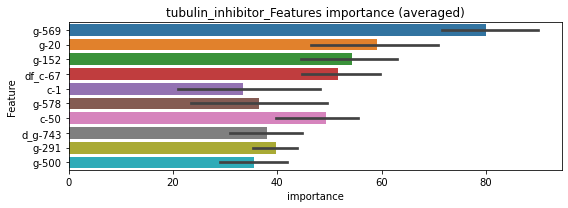

len(train_index) : 3808
len(valid_index) : 3809
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160804	valid_1's binary_logloss: 0.0403865
[200]	training's binary_logloss: 0.0022026	valid_1's binary_logloss: 0.0268506
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00114934	valid_1's binary_logloss: 0.0255663


len(train_index) : 3809
len(valid_index) : 3808
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158475	valid_1's binary_logloss: 0.0397132
[200]	training's binary_logloss: 0.00225142	valid_1's binary_logloss: 0.0240576
[300]	training's binary_logloss: 0.000614125	valid_1's binary_logloss: 0.0213154
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000394446	valid_1's binary_logloss: 0.020313


tubulin_inhibitor logloss: 0.022939978067362487
tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212


neg labels: 3289 → selected neg labels: 3276


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105193	valid_1's binary_logloss: 0.163418
[200]	training's binary_logloss: 0.0457832	valid_1's binary_logloss: 0.124051
[300]	training's binary_logloss: 0.0225259	valid_1's binary_logloss: 0.111991
[400]	training's binary_logloss: 0.0118655	valid_1's binary_logloss: 0.107314
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0122327	valid_1's binary_logloss: 0.106766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100949	valid_1's binary_logloss: 0.156417
[200]	training's binary_logloss: 0.045725	valid_1's binary_logloss: 0.123417
[300]	training's binary_logloss: 0.0222532	valid_1's binary_logloss: 0.111103


1 / 3 AUC score:0.984
y_Threshold: 0.1266535, Threshold: 0.2872049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 224 → Positive_corect_labels: 609/3707
p_label_rate: 0.0200904 Vs.target_rate: 0.00307, Num_p_label: 80.0, conf_0:0.25848, conf_1:0.31593
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.2872049
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_2: 0.2972049
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_3: 0.3072049
Num_p_label: 67.0, Expected: 12.2, Adj_threshold_4: 0.3172049
Num_p_label: 62.0, Expected: 12.2, Adj_threshold_5: 0.3272049
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_6: 0.3372049
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_7: 0.3472049


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0170815	valid_1's binary_logloss: 0.109393


Num_p_label: 52.0, Expected: 12.2, Adj_threshold_8: 0.3572049
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_9: 0.3672049
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_10: 0.3772049
threshold: 0.3872049, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 609.0/3707, y_label_rate: 0.1642838
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689186	valid_1's binary_logloss: 0.12128
[200]	training's binary_logloss: 0.022163	valid_1's binary_logloss: 0.0833102
[300]	training's binary_logloss: 0.00911559	valid_1's binary_logloss: 0.0723327
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00842367	valid_1's binary_logloss: 0.0716733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792421	valid_1's binary_logloss: 0.117771
[200]	training's binary_logloss: 0.0286143	valid_1's binary_logloss: 0.0809741
[300]	training's binary_logloss: 0.0124782	valid_1's binary_logloss: 0.0680571


2 / 3 AUC score:0.989
y_Threshold: 0.2201609, Threshold: 0.3872049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 573.0/3635
p_label_rate: 0.0258664 Vs.target_rate: 0.00307, Num_p_label: 103.0, conf_0:0.34848, conf_1:0.42593
Num_p_label: 103.0, Expected: 12.2, Adj_threshold_1: 0.3872049
Num_p_label: 102.0, Expected: 12.2, Adj_threshold_2: 0.3972049
Num_p_label: 99.0, Expected: 12.2, Adj_threshold_3: 0.4072049
Num_p_label: 95.0, Expected: 12.2, Adj_threshold_4: 0.4172049


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00860443	valid_1's binary_logloss: 0.0661061


Num_p_label: 90.0, Expected: 12.2, Adj_threshold_5: 0.4272049
Num_p_label: 86.0, Expected: 12.2, Adj_threshold_6: 0.4372049
Num_p_label: 81.0, Expected: 12.2, Adj_threshold_7: 0.4472049
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_8: 0.4572049
Num_p_label: 77.0, Expected: 12.2, Adj_threshold_9: 0.4672049
Num_p_label: 76.0, Expected: 12.2, Adj_threshold_10: 0.4772049
threshold: 0.4872049, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 573.0/3635, y_label_rate: 0.1576341
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549957	valid_1's binary_logloss: 0.0959974
[200]	training's binary_logloss: 0.016105	valid_1's binary_logloss: 0.0531981
[300]	training's binary_logloss: 0.00655727	valid_1's binary_logloss: 0.0410333
[400]	training's binary_logloss: 0.00351904	valid_1's binary_logloss: 0.0367668
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00316571	valid_1's binary_logloss: 0.0360171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620913	valid_1's binary_logloss: 0.0941339


3 / 3 AUC score:0.998
y_Threshold: 0.1953205, Threshold: 0.4872049, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 551.0/3591
p_label_rate: 0.0228528 Vs.target_rate: 0.00307, Num_p_label: 91.0, conf_0:0.43848, conf_1:0.53593
Num_p_label: 91.0, Expected: 12.2, Adj_threshold_1: 0.4872049
Num_p_label: 90.0, Expected: 12.2, Adj_threshold_2: 0.4972049
Num_p_label: 89.0, Expected: 12.2, Adj_threshold_3: 0.5072049
Num_p_label: 88.0, Expected: 12.2, Adj_threshold_4: 0.5172049
Num_p_label: 86.0, Expected: 12.2, Adj_threshold_5: 0.5272049
Num_p_label: 85.0, Expected: 12.2, Adj_threshold_6: 0.5372049


[200]	training's binary_logloss: 0.0195214	valid_1's binary_logloss: 0.0561123
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0145063	valid_1's binary_logloss: 0.0510981


Num_p_label: 83.0, Expected: 12.2, Adj_threshold_7: 0.5472049
Num_p_label: 78.0, Expected: 12.2, Adj_threshold_8: 0.5572049
Num_p_label: 75.0, Expected: 12.2, Adj_threshold_9: 0.5672049
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_10: 0.5772049
threshold: 0.5872049, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 618.0/7573, y_label_rate: 0.0816057


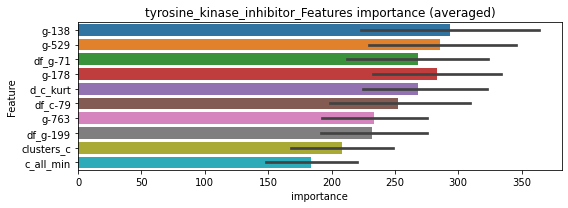

len(train_index) : 3786
len(valid_index) : 3787
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345548	valid_1's binary_logloss: 0.063445
[200]	training's binary_logloss: 0.0109747	valid_1's binary_logloss: 0.04134
[300]	training's binary_logloss: 0.00453916	valid_1's binary_logloss: 0.0350727
[400]	training's binary_logloss: 0.00238999	valid_1's binary_logloss: 0.0329916
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00185889	valid_1's binary_logloss: 0.0324333


len(train_index) : 3787
len(valid_index) : 3786
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362803	valid_1's binary_logloss: 0.0569053
[200]	training's binary_logloss: 0.0120108	valid_1's binary_logloss: 0.0317409
[300]	training's binary_logloss: 0.00482846	valid_1's binary_logloss: 0.0247034
[400]	training's binary_logloss: 0.00247754	valid_1's binary_logloss: 0.0220506
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00203827	valid_1's binary_logloss: 0.0211829


tyrosine_kinase_inhibitor logloss: 0.026808815473459688
ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942


neg labels: 3289 → selected neg labels: 3287


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180249	valid_1's binary_logloss: 0.0204966
[200]	training's binary_logloss: 0.00178456	valid_1's binary_logloss: 0.00268185
[300]	training's binary_logloss: 0.000508798	valid_1's binary_logloss: 0.000982805
[400]	training's binary_logloss: 0.000296618	valid_1's binary_logloss: 0.000635386
[500]	training's binary_logloss: 0.000259637	valid_1's binary_logloss: 0.000577898
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000258887	valid_1's binary_logloss: 0.000576637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180317	valid_1's binary_logloss: 0.0210018
[200]	training's binary_logloss: 0.00176141	valid_1's binary_logloss: 0.00289758
[300]	training's binary_logloss: 0.000500716	valid_1's binary_logloss: 0.00113607
[400]	training's binary_logloss: 0.000289611	valid_1's binary_logloss: 0.000764947
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0009062, Threshold: 0.0015032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050, Num_p_label: 80.0, conf_0:0.00135, conf_1:0.00165
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015032
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0115032
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0215032
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0315032
threshold: 0.0315032, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180124	valid_1's binary_logloss: 0.020884
[200]	training's binary_logloss: 0.00167702	valid_1's binary_logloss: 0.0029896
[300]	training's binary_logloss: 0.000470465	valid_1's binary_logloss: 0.00139851
[400]	training's binary_logloss: 0.000277063	valid_1's binary_logloss: 0.00106886
[500]	training's binary_logloss: 0.000242701	valid_1's binary_logloss: 0.000997505
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000240826	valid_1's binary_logloss: 0.000994423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183118	valid_1's binary_logloss: 0.0203511
[200]	training's binary_logloss: 0.00183815	valid_1's binary_logloss: 0.0023673
[300]	training's binary_logloss: 0.000546323	valid_1's binary_logloss: 0.000748036
[400]	training's binary_logloss: 0.000280569	valid_1's binary_logloss: 0.000430114
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.2231824, Threshold: 0.0315032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0110497 Vs.target_rate: 0.00050, Num_p_label: 44.0, conf_0:0.02835, conf_1:0.03465
Num_p_label: 44.0, Expected: 2.0, Adj_threshold_1: 0.0315032
Num_p_label: 39.0, Expected: 2.0, Adj_threshold_2: 0.0415032
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_3: 0.0515032
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_4: 0.0615032
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_5: 0.0715032
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_6: 0.0815032
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_7: 0.0915032
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_8: 0.1015032
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_9: 0.1115032
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_10: 0.1215032
threshold: 0.1315032, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180124	valid_1's binary_logloss: 0.020884
[200]	training's binary_logloss: 0.00167702	valid_1's binary_logloss: 0.0029896
[300]	training's binary_logloss: 0.000470465	valid_1's binary_logloss: 0.00139851
[400]	training's binary_logloss: 0.000277063	valid_1's binary_logloss: 0.00106886
[500]	training's binary_logloss: 0.000242701	valid_1's binary_logloss: 0.000997505
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000240826	valid_1's binary_logloss: 0.000994423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183118	valid_1's binary_logloss: 0.0203511
[200]	training's binary_logloss: 0.00183815	valid_1's binary_logloss: 0.0023673
[300]	training's binary_logloss: 0.000546323	valid_1's binary_logloss: 0.000748036
[400]	training's binary_logloss: 0.000280569	valid_1's binary_logloss: 0.000430114
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.2231824, Threshold: 0.1315032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.11835, conf_1:0.14465
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.1315032
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.1415032
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_3: 0.1515032
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_4: 0.1615032
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_5: 0.1715032
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_6: 0.1815032
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_7: 0.1915032
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_8: 0.2015032
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_9: 0.2115032
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_10: 0.2215032
threshold: 0.2315032, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 670.0/7794, y_label_rate: 0.0859636


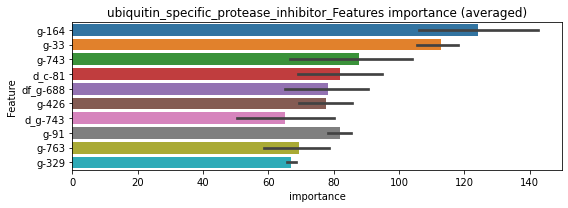

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00991015	valid_1's binary_logloss: 0.0142965
[200]	training's binary_logloss: 0.000957644	valid_1's binary_logloss: 0.00459411
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000316692	valid_1's binary_logloss: 0.00391743


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00997558	valid_1's binary_logloss: 0.011819
[200]	training's binary_logloss: 0.000996614	valid_1's binary_logloss: 0.00256587
[300]	training's binary_logloss: 0.000283993	valid_1's binary_logloss: 0.0016254
[400]	training's binary_logloss: 0.000161897	valid_1's binary_logloss: 0.00138483
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000149823	valid_1's binary_logloss: 0.00136422


ubiquitin_specific_protease_inhibitor logloss: 0.002640822736624357
vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081


neg labels: 3289 → selected neg labels: 3258


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954777	valid_1's binary_logloss: 0.189086
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.050642	valid_1's binary_logloss: 0.169243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107317	valid_1's binary_logloss: 0.17029
[200]	training's binary_logloss: 0.0550987	valid_1's binary_logloss: 0.146013
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0528781	valid_1's binary_logloss: 0.144938


1 / 3 AUC score:0.968
y_Threshold: 0.1655526, Threshold: 0.4875550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 277 → Positive_corect_labels: 578/3632
p_label_rate: 0.0200904 Vs.target_rate: 0.00714, Num_p_label: 80.0, conf_0:0.43880, conf_1:0.53631
threshold: 0.4875550, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 578.0/3632, y_label_rate: 0.1591410
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555796	valid_1's binary_logloss: 0.1006
[200]	training's binary_logloss: 0.016293	valid_1's binary_logloss: 0.0683034
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00744954	valid_1's binary_logloss: 0.0608378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574424	valid_1's binary_logloss: 0.0856257
[200]	training's binary_logloss: 0.0184148	valid_1's binary_logloss: 0.0556621
[300]	training's binary_logloss: 0.0077841	valid_1's binary_logloss: 0.0474489
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00566753	valid_1's binary_logloss: 0.0452859


2 / 3 AUC score:0.996
y_Threshold: 0.2400103, Threshold: 0.4875550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 545.0/3566
p_label_rate: 0.0416876 Vs.target_rate: 0.00714, Num_p_label: 166.0, conf_0:0.43880, conf_1:0.53631
Num_p_label: 166.0, Expected: 28.4, Adj_threshold_1: 0.4875550
Num_p_label: 161.0, Expected: 28.4, Adj_threshold_2: 0.4975550
Num_p_label: 158.0, Expected: 28.4, Adj_threshold_3: 0.5075550
Num_p_label: 156.0, Expected: 28.4, Adj_threshold_4: 0.5175550
Num_p_label: 154.0, Expected: 28.4, Adj_threshold_5: 0.5275550
Num_p_label: 152.0, Expected: 28.4, Adj_threshold_6: 0.5375550
Num_p_label: 148.0, Expected: 28.4, Adj_threshold_7: 0.5475550
Num_p_label: 146.0, Expected: 28.4, Adj_threshold_8: 0.5575550
Num_p_label: 140.0, Expected: 28.4, Adj_threshold_9: 0.5675550
Num_p_label: 138.0, Expected: 28.4, Adj_threshold_10: 0.5775550
threshold: 0.5875550, positive_p_label: 137.0/3982, p_label_rate: 0.0344048
positive_y_label: 545.0/3566, y_label_r

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433618	valid_1's binary_logloss: 0.073075
[200]	training's binary_logloss: 0.0109903	valid_1's binary_logloss: 0.0430064
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00496842	valid_1's binary_logloss: 0.0374561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434121	valid_1's binary_logloss: 0.0685628
[200]	training's binary_logloss: 0.0108349	valid_1's binary_logloss: 0.0396443
[300]	training's binary_logloss: 0.00412887	valid_1's binary_logloss: 0.0322917


3 / 3 AUC score:0.998
y_Threshold: 0.2476335, Threshold: 0.5875550, pos_neg_ratio: 0.8000000


[400]	training's binary_logloss: 0.0023287	valid_1's binary_logloss: 0.0296016
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00186591	valid_1's binary_logloss: 0.0284496


Remove_noisy_labels: 36 → Positive_corect_labels: 527.0/3530
p_label_rate: 0.0379206 Vs.target_rate: 0.00714, Num_p_label: 151.0, conf_0:0.52880, conf_1:0.64631
Num_p_label: 151.0, Expected: 28.4, Adj_threshold_1: 0.5875550
Num_p_label: 150.0, Expected: 28.4, Adj_threshold_2: 0.5975550
Num_p_label: 150.0, Expected: 28.4, Adj_threshold_3: 0.6075550
Num_p_label: 148.0, Expected: 28.4, Adj_threshold_4: 0.6175550
Num_p_label: 146.0, Expected: 28.4, Adj_threshold_5: 0.6275550
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_6: 0.6375550
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_7: 0.6475550
Num_p_label: 142.0, Expected: 28.4, Adj_threshold_8: 0.6575550
Num_p_label: 139.0, Expected: 28.4, Adj_threshold_9: 0.6675550
Num_p_label: 139.0, Expected: 28.4, Adj_threshold_10: 0.6775550
threshold: 0.6875550, positive_p_label: 137.0/3982, p_label_rate: 0.0344048
positive_y_label: 664.0/7512, y_label_rate: 0.0883919


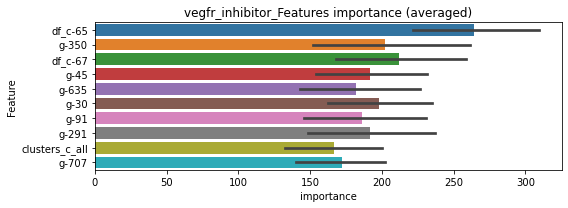

len(train_index) : 3756
len(valid_index) : 3756
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271817	valid_1's binary_logloss: 0.0469823
[200]	training's binary_logloss: 0.00661904	valid_1's binary_logloss: 0.0313215
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00403045	valid_1's binary_logloss: 0.0293166


len(train_index) : 3756
len(valid_index) : 3756
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251719	valid_1's binary_logloss: 0.049997
[200]	training's binary_logloss: 0.00604557	valid_1's binary_logloss: 0.0331685
[300]	training's binary_logloss: 0.00234072	valid_1's binary_logloss: 0.0297307
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00187152	valid_1's binary_logloss: 0.0292583


vegfr_inhibitor logloss: 0.029287451192262535
vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394


neg labels: 3289 → selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313574	valid_1's binary_logloss: 0.04683
[200]	training's binary_logloss: 0.00440272	valid_1's binary_logloss: 0.0116494
[300]	training's binary_logloss: 0.00122022	valid_1's binary_logloss: 0.0061031
[400]	training's binary_logloss: 0.000615581	valid_1's binary_logloss: 0.00440783
[500]	training's binary_logloss: 0.000434561	valid_1's binary_logloss: 0.00390881
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000415481	valid_1's binary_logloss: 0.00386568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327811	valid_1's binary_logloss: 0.0439246
[200]	training's binary_logloss: 0.00456964	valid_1's binary_logloss: 0.0103964
[300]	training's binary_logloss: 0.00128575	valid_1's binary_logloss: 0.00498992
[400]	training's binary_logloss: 0.000640363	valid_1's binary_logloss: 0.00349898
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0027170, Threshold: 0.0040620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109, Num_p_label: 80.0, conf_0:0.00366, conf_1:0.00447
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0040620
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_2: 0.0140620
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.0240620
threshold: 0.0240620, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304963	valid_1's binary_logloss: 0.0456338
[200]	training's binary_logloss: 0.00422614	valid_1's binary_logloss: 0.0113039
[300]	training's binary_logloss: 0.00118085	valid_1's binary_logloss: 0.00596452
[400]	training's binary_logloss: 0.00060305	valid_1's binary_logloss: 0.00446072
[500]	training's binary_logloss: 0.000430831	valid_1's binary_logloss: 0.00400793
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000424649	valid_1's binary_logloss: 0.00399886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320371	valid_1's binary_logloss: 0.0439978
[200]	training's binary_logloss: 0.00439852	valid_1's binary_logloss: 0.0103452
[300]	training's binary_logloss: 0.00123191	valid_1's binary_logloss: 0.00524109
[400]	training's binary_logloss: 0.00062089	valid_1's binary_logloss: 0.00388746
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0237355, Threshold: 0.0240620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0035158 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.02166, conf_1:0.02647
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.0240620
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0340620
threshold: 0.0340620, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304963	valid_1's binary_logloss: 0.0456338
[200]	training's binary_logloss: 0.00422614	valid_1's binary_logloss: 0.0113039
[300]	training's binary_logloss: 0.00118085	valid_1's binary_logloss: 0.00596452
[400]	training's binary_logloss: 0.00060305	valid_1's binary_logloss: 0.00446072
[500]	training's binary_logloss: 0.000430831	valid_1's binary_logloss: 0.00400793
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000424649	valid_1's binary_logloss: 0.00399886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320371	valid_1's binary_logloss: 0.0439978
[200]	training's binary_logloss: 0.00439852	valid_1's binary_logloss: 0.0103452
[300]	training's binary_logloss: 0.00123191	valid_1's binary_logloss: 0.00524109
[400]	training's binary_logloss: 0.00062089	valid_1's binary_logloss: 0.00388746
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0237355, Threshold: 0.0340620, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00109, Num_p_label: 8.0, conf_0:0.03066, conf_1:0.03747
threshold: 0.0340620, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


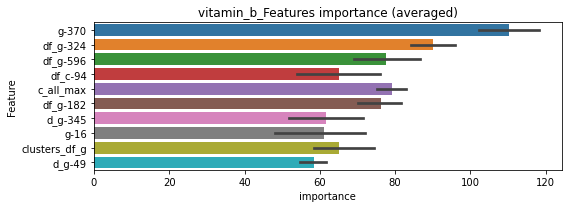

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165839	valid_1's binary_logloss: 0.0318161
[200]	training's binary_logloss: 0.00228359	valid_1's binary_logloss: 0.0133646
[300]	training's binary_logloss: 0.000628445	valid_1's binary_logloss: 0.0101923
[400]	training's binary_logloss: 0.000312922	valid_1's binary_logloss: 0.00991082
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000327045	valid_1's binary_logloss: 0.00988138


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180725	valid_1's binary_logloss: 0.0257027
[200]	training's binary_logloss: 0.00258895	valid_1's binary_logloss: 0.00676566
[300]	training's binary_logloss: 0.000720287	valid_1's binary_logloss: 0.00422644
[400]	training's binary_logloss: 0.000336942	valid_1's binary_logloss: 0.00363912
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000261093	valid_1's binary_logloss: 0.00350971


vitamin_b logloss: 0.006695547144821096
vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906


neg labels: 3289 → selected neg labels: 3281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272436	valid_1's binary_logloss: 0.039183
[200]	training's binary_logloss: 0.00361159	valid_1's binary_logloss: 0.00819698
[300]	training's binary_logloss: 0.00102928	valid_1's binary_logloss: 0.00335518
[400]	training's binary_logloss: 0.000518429	valid_1's binary_logloss: 0.00212663
[500]	training's binary_logloss: 0.000369736	valid_1's binary_logloss: 0.00173083
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000340458	valid_1's binary_logloss: 0.00165693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277069	valid_1's binary_logloss: 0.042778
[200]	training's binary_logloss: 0.00365363	valid_1's binary_logloss: 0.0084778
[300]	training's binary_logloss: 0.00104797	valid_1's binary_logloss: 0.00337008
[400]	training's binary_logloss: 0.000528637	valid_1's binary_logloss: 0.00205202
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0021423, Threshold: 0.0055060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164, Num_p_label: 80.0, conf_0:0.00496, conf_1:0.00606
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0055060
Num_p_label: 29.0, Expected: 6.5, Adj_threshold_2: 0.0155060
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_3: 0.0255060
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_4: 0.0355060
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_5: 0.0455060
threshold: 0.0455060, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274813	valid_1's binary_logloss: 0.0399248
[200]	training's binary_logloss: 0.00359599	valid_1's binary_logloss: 0.00823144
[300]	training's binary_logloss: 0.00101695	valid_1's binary_logloss: 0.00328006
[400]	training's binary_logloss: 0.000515451	valid_1's binary_logloss: 0.00213651
[500]	training's binary_logloss: 0.00037032	valid_1's binary_logloss: 0.00175319
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000352901	valid_1's binary_logloss: 0.00170552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278402	valid_1's binary_logloss: 0.0422267
[200]	training's binary_logloss: 0.00358545	valid_1's binary_logloss: 0.00864188
[300]	training's binary_logloss: 0.00101824	valid_1's binary_logloss: 0.00343127
[400]	training's binary_logloss: 0.00051497	valid_1's binary_logloss: 0.00207073
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1081107, Threshold: 0.0455060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00164, Num_p_label: 19.0, conf_0:0.04096, conf_1:0.05006
threshold: 0.0455060, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274813	valid_1's binary_logloss: 0.0399248
[200]	training's binary_logloss: 0.00359599	valid_1's binary_logloss: 0.00823144
[300]	training's binary_logloss: 0.00101695	valid_1's binary_logloss: 0.00328006
[400]	training's binary_logloss: 0.000515451	valid_1's binary_logloss: 0.00213651
[500]	training's binary_logloss: 0.00037032	valid_1's binary_logloss: 0.00175319
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000352901	valid_1's binary_logloss: 0.00170552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278402	valid_1's binary_logloss: 0.0422267
[200]	training's binary_logloss: 0.00358545	valid_1's binary_logloss: 0.00864188
[300]	training's binary_logloss: 0.00101824	valid_1's binary_logloss: 0.00343127
[400]	training's binary_logloss: 0.00051497	valid_1's binary_logloss: 0.00207073
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1081107, Threshold: 0.0455060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0047715 Vs.target_rate: 0.00164, Num_p_label: 19.0, conf_0:0.04096, conf_1:0.05006
threshold: 0.0455060, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 675.0/7787, y_label_rate: 0.0866829


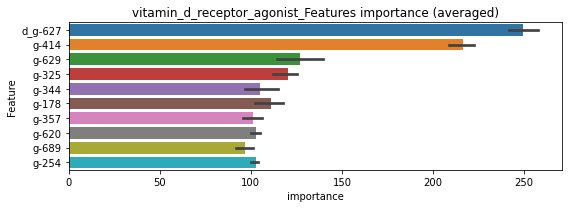

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151934	valid_1's binary_logloss: 0.0281901
[200]	training's binary_logloss: 0.00199103	valid_1's binary_logloss: 0.0121465
[300]	training's binary_logloss: 0.00055856	valid_1's binary_logloss: 0.0100284
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000340795	valid_1's binary_logloss: 0.00955685


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150436	valid_1's binary_logloss: 0.0267839
[200]	training's binary_logloss: 0.00195588	valid_1's binary_logloss: 0.00971234
[300]	training's binary_logloss: 0.000554325	valid_1's binary_logloss: 0.0072413
[400]	training's binary_logloss: 0.000280982	valid_1's binary_logloss: 0.00662988
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000235438	valid_1's binary_logloss: 0.00651775


vitamin_d_receptor_agonist logloss: 0.008037494040000072
wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127


neg labels: 3289 → selected neg labels: 3284


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351895	valid_1's binary_logloss: 0.0559464
[200]	training's binary_logloss: 0.00516503	valid_1's binary_logloss: 0.0157116
[300]	training's binary_logloss: 0.00141368	valid_1's binary_logloss: 0.00777063
[400]	training's binary_logloss: 0.000694451	valid_1's binary_logloss: 0.00580774
[500]	training's binary_logloss: 0.000473836	valid_1's binary_logloss: 0.0050405
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000448087	valid_1's binary_logloss: 0.00500581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347539	valid_1's binary_logloss: 0.0574276
[200]	training's binary_logloss: 0.0052114	valid_1's binary_logloss: 0.0189759
[300]	training's binary_logloss: 0.00146525	valid_1's binary_logloss: 0.011316
[400]	training's binary_logloss: 0.000707438	valid_1's binary_logloss: 0.00935675
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0024246, Threshold: 0.0035284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126, Num_p_label: 80.0, conf_0:0.00318, conf_1:0.00388
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0035284
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_2: 0.0135284
threshold: 0.0135284, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358334	valid_1's binary_logloss: 0.0569825
[200]	training's binary_logloss: 0.00513738	valid_1's binary_logloss: 0.01588
[300]	training's binary_logloss: 0.00141814	valid_1's binary_logloss: 0.00752311
[400]	training's binary_logloss: 0.000695552	valid_1's binary_logloss: 0.00542126
[500]	training's binary_logloss: 0.00047384	valid_1's binary_logloss: 0.00447261
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000444174	valid_1's binary_logloss: 0.00437554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348732	valid_1's binary_logloss: 0.0565888
[200]	training's binary_logloss: 0.00514688	valid_1's binary_logloss: 0.0178221
[300]	training's binary_logloss: 0.00143534	valid_1's binary_logloss: 0.0103818
[400]	training's binary_logloss: 0.000705352	valid_1's binary_logloss: 0.00837859
Early stopping, best iteration is:
[398

2 / 3 AUC score:1.000
y_Threshold: 0.0205700, Threshold: 0.0135284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0082873 Vs.target_rate: 0.00126, Num_p_label: 33.0, conf_0:0.01218, conf_1:0.01488
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_1: 0.0135284
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_2: 0.0235284
threshold: 0.0235284, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358334	valid_1's binary_logloss: 0.0569825
[200]	training's binary_logloss: 0.00513738	valid_1's binary_logloss: 0.01588
[300]	training's binary_logloss: 0.00141814	valid_1's binary_logloss: 0.00752311
[400]	training's binary_logloss: 0.000695552	valid_1's binary_logloss: 0.00542126
[500]	training's binary_logloss: 0.00047384	valid_1's binary_logloss: 0.00447261
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000444174	valid_1's binary_logloss: 0.00437554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348732	valid_1's binary_logloss: 0.0565888
[200]	training's binary_logloss: 0.00514688	valid_1's binary_logloss: 0.0178221
[300]	training's binary_logloss: 0.00143534	valid_1's binary_logloss: 0.0103818
[400]	training's binary_logloss: 0.000705352	valid_1's binary_logloss: 0.00837859
Early stopping, best iteration is:
[398

3 / 3 AUC score:1.000
y_Threshold: 0.0205700, Threshold: 0.0235284, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.02118, conf_1:0.02588
threshold: 0.0235284, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


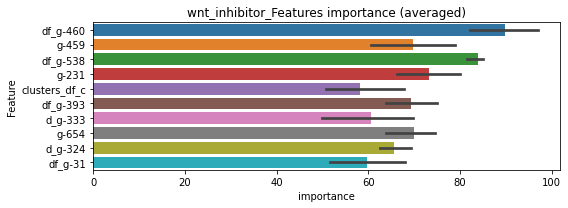

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203017	valid_1's binary_logloss: 0.0393675
[200]	training's binary_logloss: 0.00296513	valid_1's binary_logloss: 0.0182774
[300]	training's binary_logloss: 0.000779458	valid_1's binary_logloss: 0.014845
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000527155	valid_1's binary_logloss: 0.0145038


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209016	valid_1's binary_logloss: 0.0312962
[200]	training's binary_logloss: 0.00310673	valid_1's binary_logloss: 0.00847682
[300]	training's binary_logloss: 0.000842556	valid_1's binary_logloss: 0.00500186
[400]	training's binary_logloss: 0.000399096	valid_1's binary_logloss: 0.00449581
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000421349	valid_1's binary_logloss: 0.00449037


wnt_inhibitor logloss: 0.00949708635987976


In [47]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    #if DEBUG:
    #    feature_importance_df = create_featureimprotance(models, feature_importance_df)
    #    importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [48]:
sub.to_csv('submission.csv', index=False)

In [49]:
print(f"CV:{np.mean(scores)}")

CV:0.015033772029553133


In [50]:
#if DEBUG:
#    show_feature_importance(feature_importance_df)
#    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
#    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)